<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия." data-toc-modified-id="Линейная-регрессия.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия.</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Таксомоторная компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
RS = 12345 # константа для random_state

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso)
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error)
import warnings
from catboost import CatBoostRegressor
from sklearn.model_selection import (TimeSeriesSplit,  
                                     GridSearchCV)

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим на данные

In [4]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, действительно ли данные расположены в хронологическом порядке.

In [6]:
data.info()
print('\nИндексы расположены в порядке возрастания' if data.index.is_monotonic_increasing else 
      'Индексы не расположены в поряядке возрастания')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Индексы расположены в порядке возрастания


Пропусков нет, тип данных соответствует их смыслу.  
Сделаем ресемплинг данных, чтобы получить количество заказов за каждый час.

In [7]:
data = data.resample('1H').sum()

Посмотрим на временной диапазон данных.

In [8]:
print(f'Первое наблюдение: {data.index.min()}')
print(f'Последнее наблюдение: {data.index.max()}')

Первое наблюдение: 2018-03-01 00:00:00
Последнее наблюдение: 2018-08-31 23:00:00


## Анализ

Посмотрим на скользящее среднее с размером окна 24 часа.

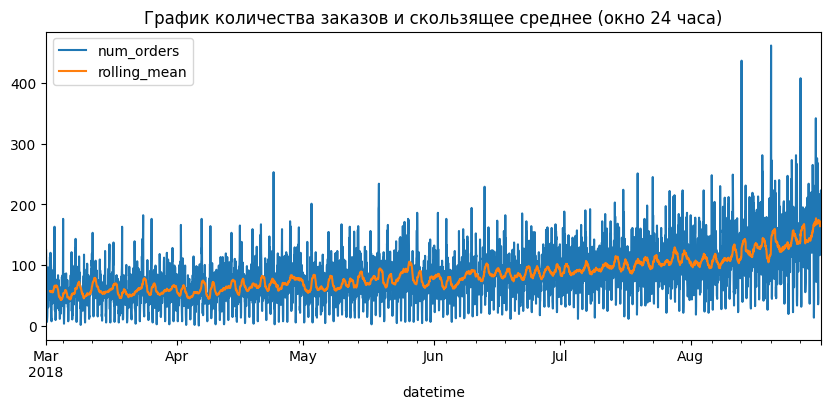

In [9]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean()

data.plot(figsize = (10,4), title = 'График количества заказов и скользящее среднее (окно 24 часа)');

На графике видно наличие среднесуточных колебаний количества заказов, а также заметен тренд на увеличение количества заказов.

Рассмотрим тренд, сезонность и случайную составляющую в целевом признаке.

In [10]:
decomposed = seasonal_decompose(data['num_orders'])

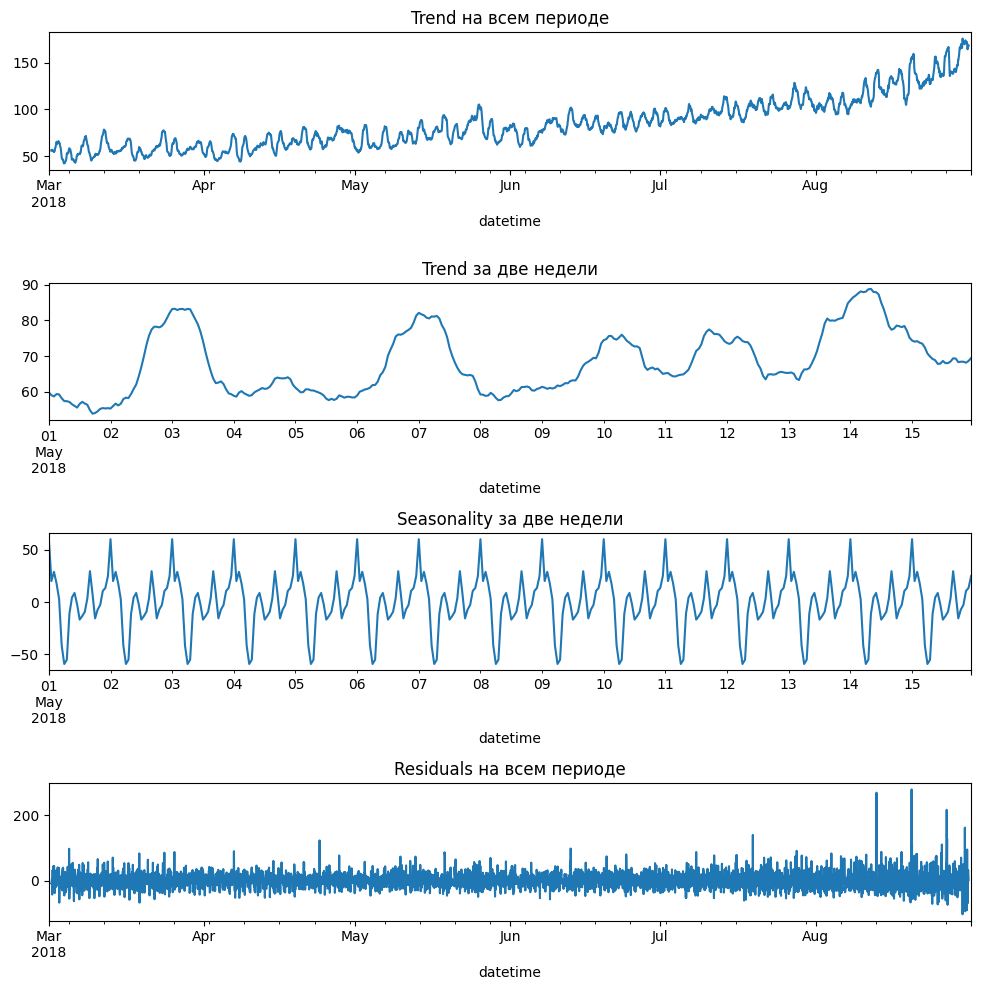

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(411)

decomposed.trend.plot()
plt.title('Trend на всем периоде') 
plt.subplot(412)
decomposed.trend['2018-05-01':'2018-05-15'].plot()
plt.title('Trend за две недели')
plt.subplot(413)
decomposed.seasonal['2018-05-01':'2018-05-15'].plot()
plt.title('Seasonality за две недели')
plt.subplot(414)
decomposed.resid.plot()
plt.title('Residuals на всем периоде')
plt.tight_layout()


Построим автокорреляционную функцию.


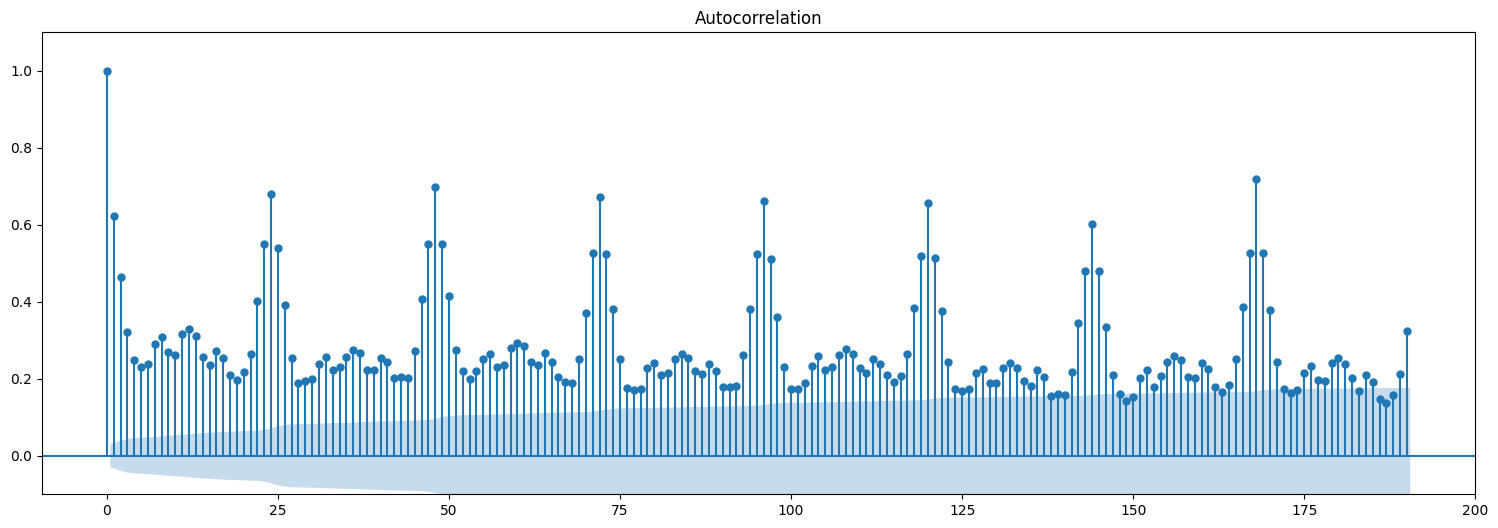

In [12]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data['num_orders'],lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

На графиках виден восходящий тренд, его периодичность по неделям и суточная периодичность сезонности и автокорреляционной функции.

## Обучение

Поскольку мы работаем с временными рядими, и виден тренд на увеличение целевого признака, целесообразно применять линейные модели, потому что они обладают хорошей способностью экстраполировать предсказания. Экстраполирующие способности моделей на основе решающих деревьев ограничены. Также при работе с временными рядами нельзя использовать стандартную кросс-валидацию. Будем использовать TimeSeriesSplit. 

Подготовим данные. Возьмем информацию о времени, дне недели, суточное скользящее среднее и лаги за неделю.

In [13]:
data = data[['num_orders']].copy()

data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

warnings.filterwarnings('ignore')
for lag in range(1, 168 + 1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()
warnings.filterwarnings('default')
data = data.dropna()

data.shape

(4248, 172)

Разделим данные на обучающие и тестовые.

In [14]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)

features_train = train.drop(columns = ['num_orders'])
features_test = test.drop(columns = ['num_orders'])
target_train = train['num_orders']
target_test = test['num_orders']
    
features_train.shape, features_test.shape, target_train.shape, target_test.shape


((3823, 171), (425, 171), (3823,), (425,))

In [15]:
def params_search(model, X, y, param_grid):
    """
    Функция обучает модель и печатает лучшую метрику
    """
    tscv = TimeSeriesSplit(n_splits=10)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_grid, scoring='neg_root_mean_squared_error', verbose=10)
    gsearch.fit(X, y)
    print('\nBest_score:', -gsearch.best_score_)
    print('Best_params:', gsearch.best_params_)
    return gsearch.best_estimator_

### Линейная регрессия.


In [16]:
model_lr = LinearRegression()
params_lr = [{}]
model_lr = params_search(model_lr, features_train, target_train, params_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................
[CV 1/10; 1/1] END ..........................., score=-22.778 total time=   0.0s
[CV 2/10; 1/1] START ...........................................................
[CV 2/10; 1/1] END ..........................., score=-18.137 total time=   0.0s
[CV 3/10; 1/1] START ...........................................................
[CV 3/10; 1/1] END ..........................., score=-21.551 total time=   0.0s
[CV 4/10; 1/1] START ...........................................................
[CV 4/10; 1/1] END ..........................., score=-20.821 total time=   0.0s
[CV 5/10; 1/1] START ...........................................................
[CV 5/10; 1/1] END ..........................., score=-21.412 total time=   0.0s
[CV 6/10; 1/1] START ...........................................................
[CV 6/10; 1/1] END ..........................., 

### Ridge

 Подберем гиперпараметры для регресии Ridge.

In [17]:
model_ridge = Ridge(random_state=RS)
params_ridge = [{'alpha' : np.arange(0, 5, 0.2), 'solver' : ['cholesky', 'sparse_cg', 'lbfgs'], 
                 'positive' : [True, False]}]
warnings.filterwarnings('ignore')
model_ridge = params_search(model_ridge, features_train, target_train, params_ridge)
warnings.filterwarnings('default')

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
[CV 1/10; 1/150] START alpha=0.0, positive=True, solver=cholesky................
[CV 1/10; 1/150] END alpha=0.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 2/10; 1/150] START alpha=0.0, positive=True, solver=cholesky................
[CV 2/10; 1/150] END alpha=0.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 3/10; 1/150] START alpha=0.0, positive=True, solver=cholesky................
[CV 3/10; 1/150] END alpha=0.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 4/10; 1/150] START alpha=0.0, positive=True, solver=cholesky................
[CV 4/10; 1/150] END alpha=0.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 5/10; 1/150] START alpha=0.0, positive=True, solver=cholesky................
[CV 5/10; 1/150] END alpha=0.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 6/10; 1/150] START alpha=0.0, positive=True, solver=chol

[CV 8/10; 5/150] END alpha=0.0, positive=False, solver=sparse_cg;, score=-22.924 total time=   0.0s
[CV 9/10; 5/150] START alpha=0.0, positive=False, solver=sparse_cg..............
[CV 9/10; 5/150] END alpha=0.0, positive=False, solver=sparse_cg;, score=-25.893 total time=   0.0s
[CV 10/10; 5/150] START alpha=0.0, positive=False, solver=sparse_cg.............
[CV 10/10; 5/150] END alpha=0.0, positive=False, solver=sparse_cg;, score=-29.597 total time=   0.0s
[CV 1/10; 6/150] START alpha=0.0, positive=False, solver=lbfgs..................
[CV 1/10; 6/150] END alpha=0.0, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/10; 6/150] START alpha=0.0, positive=False, solver=lbfgs..................
[CV 2/10; 6/150] END alpha=0.0, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/10; 6/150] START alpha=0.0, positive=False, solver=lbfgs..................
[CV 3/10; 6/150] END alpha=0.0, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/10; 6/150] S

[CV 4/10; 11/150] END alpha=0.2, positive=False, solver=sparse_cg;, score=-20.834 total time=   0.0s
[CV 5/10; 11/150] START alpha=0.2, positive=False, solver=sparse_cg.............
[CV 5/10; 11/150] END alpha=0.2, positive=False, solver=sparse_cg;, score=-21.408 total time=   0.0s
[CV 6/10; 11/150] START alpha=0.2, positive=False, solver=sparse_cg.............
[CV 6/10; 11/150] END alpha=0.2, positive=False, solver=sparse_cg;, score=-20.802 total time=   0.0s
[CV 7/10; 11/150] START alpha=0.2, positive=False, solver=sparse_cg.............
[CV 7/10; 11/150] END alpha=0.2, positive=False, solver=sparse_cg;, score=-21.215 total time=   0.0s
[CV 8/10; 11/150] START alpha=0.2, positive=False, solver=sparse_cg.............
[CV 8/10; 11/150] END alpha=0.2, positive=False, solver=sparse_cg;, score=-22.924 total time=   0.0s
[CV 9/10; 11/150] START alpha=0.2, positive=False, solver=sparse_cg.............
[CV 9/10; 11/150] END alpha=0.2, positive=False, solver=sparse_cg;, score=-25.893 total ti

[CV 7/10; 16/150] END alpha=0.4, positive=False, solver=cholesky;, score=-21.208 total time=   0.0s
[CV 8/10; 16/150] START alpha=0.4, positive=False, solver=cholesky..............
[CV 8/10; 16/150] END alpha=0.4, positive=False, solver=cholesky;, score=-22.951 total time=   0.0s
[CV 9/10; 16/150] START alpha=0.4, positive=False, solver=cholesky..............
[CV 9/10; 16/150] END alpha=0.4, positive=False, solver=cholesky;, score=-25.846 total time=   0.0s
[CV 10/10; 16/150] START alpha=0.4, positive=False, solver=cholesky.............
[CV 10/10; 16/150] END alpha=0.4, positive=False, solver=cholesky;, score=-29.615 total time=   0.0s
[CV 1/10; 17/150] START alpha=0.4, positive=False, solver=sparse_cg.............
[CV 1/10; 17/150] END alpha=0.4, positive=False, solver=sparse_cg;, score=-22.301 total time=   0.0s
[CV 2/10; 17/150] START alpha=0.4, positive=False, solver=sparse_cg.............
[CV 2/10; 17/150] END alpha=0.4, positive=False, solver=sparse_cg;, score=-18.123 total time=

[CV 2/10; 22/150] END alpha=0.6000000000000001, positive=False, solver=cholesky;, score=-18.137 total time=   0.0s
[CV 3/10; 22/150] START alpha=0.6000000000000001, positive=False, solver=cholesky
[CV 3/10; 22/150] END alpha=0.6000000000000001, positive=False, solver=cholesky;, score=-21.551 total time=   0.0s
[CV 4/10; 22/150] START alpha=0.6000000000000001, positive=False, solver=cholesky
[CV 4/10; 22/150] END alpha=0.6000000000000001, positive=False, solver=cholesky;, score=-20.821 total time=   0.0s
[CV 5/10; 22/150] START alpha=0.6000000000000001, positive=False, solver=cholesky
[CV 5/10; 22/150] END alpha=0.6000000000000001, positive=False, solver=cholesky;, score=-21.412 total time=   0.0s
[CV 6/10; 22/150] START alpha=0.6000000000000001, positive=False, solver=cholesky
[CV 6/10; 22/150] END alpha=0.6000000000000001, positive=False, solver=cholesky;, score=-20.816 total time=   0.0s
[CV 7/10; 22/150] START alpha=0.6000000000000001, positive=False, solver=cholesky
[CV 7/10; 22/15

[CV 8/10; 27/150] END alpha=0.8, positive=True, solver=lbfgs;, score=-22.170 total time=   0.0s
[CV 9/10; 27/150] START alpha=0.8, positive=True, solver=lbfgs..................
[CV 9/10; 27/150] END alpha=0.8, positive=True, solver=lbfgs;, score=-25.615 total time=   0.0s
[CV 10/10; 27/150] START alpha=0.8, positive=True, solver=lbfgs.................
[CV 10/10; 27/150] END alpha=0.8, positive=True, solver=lbfgs;, score=-30.153 total time=   0.0s
[CV 1/10; 28/150] START alpha=0.8, positive=False, solver=cholesky..............
[CV 1/10; 28/150] END alpha=0.8, positive=False, solver=cholesky;, score=-22.776 total time=   0.0s
[CV 2/10; 28/150] START alpha=0.8, positive=False, solver=cholesky..............
[CV 2/10; 28/150] END alpha=0.8, positive=False, solver=cholesky;, score=-18.137 total time=   0.0s
[CV 3/10; 28/150] START alpha=0.8, positive=False, solver=cholesky..............
[CV 3/10; 28/150] END alpha=0.8, positive=False, solver=cholesky;, score=-21.551 total time=   0.0s
[CV 4/

[CV 4/10; 33/150] END alpha=1.0, positive=True, solver=lbfgs;, score=-20.480 total time=   0.0s
[CV 5/10; 33/150] START alpha=1.0, positive=True, solver=lbfgs..................
[CV 5/10; 33/150] END alpha=1.0, positive=True, solver=lbfgs;, score=-22.845 total time=   0.0s
[CV 6/10; 33/150] START alpha=1.0, positive=True, solver=lbfgs..................
[CV 6/10; 33/150] END alpha=1.0, positive=True, solver=lbfgs;, score=-20.615 total time=   0.0s
[CV 7/10; 33/150] START alpha=1.0, positive=True, solver=lbfgs..................
[CV 7/10; 33/150] END alpha=1.0, positive=True, solver=lbfgs;, score=-20.901 total time=   0.0s
[CV 8/10; 33/150] START alpha=1.0, positive=True, solver=lbfgs..................
[CV 8/10; 33/150] END alpha=1.0, positive=True, solver=lbfgs;, score=-22.170 total time=   0.0s
[CV 9/10; 33/150] START alpha=1.0, positive=True, solver=lbfgs..................
[CV 9/10; 33/150] END alpha=1.0, positive=True, solver=lbfgs;, score=-25.615 total time=   0.0s
[CV 10/10; 33/150] 

[CV 5/10; 38/150] END alpha=1.2000000000000002, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 6/10; 38/150] START alpha=1.2000000000000002, positive=True, solver=sparse_cg
[CV 6/10; 38/150] END alpha=1.2000000000000002, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 7/10; 38/150] START alpha=1.2000000000000002, positive=True, solver=sparse_cg
[CV 7/10; 38/150] END alpha=1.2000000000000002, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 8/10; 38/150] START alpha=1.2000000000000002, positive=True, solver=sparse_cg
[CV 8/10; 38/150] END alpha=1.2000000000000002, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 9/10; 38/150] START alpha=1.2000000000000002, positive=True, solver=sparse_cg
[CV 9/10; 38/150] END alpha=1.2000000000000002, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 10/10; 38/150] START alpha=1.2000000000000002, positive=True, solver=sparse_cg
[CV 10/10; 38/150] END alpha=1.200

[CV 8/10; 42/150] END alpha=1.2000000000000002, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 9/10; 42/150] START alpha=1.2000000000000002, positive=False, solver=lbfgs..
[CV 9/10; 42/150] END alpha=1.2000000000000002, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 10/10; 42/150] START alpha=1.2000000000000002, positive=False, solver=lbfgs.
[CV 10/10; 42/150] END alpha=1.2000000000000002, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/10; 43/150] START alpha=1.4000000000000001, positive=True, solver=cholesky
[CV 1/10; 43/150] END alpha=1.4000000000000001, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 2/10; 43/150] START alpha=1.4000000000000001, positive=True, solver=cholesky
[CV 2/10; 43/150] END alpha=1.4000000000000001, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 3/10; 43/150] START alpha=1.4000000000000001, positive=True, solver=cholesky
[CV 3/10; 43/150] END alpha=1.4000000000000001, po

[CV 8/10; 47/150] END alpha=1.4000000000000001, positive=False, solver=sparse_cg;, score=-22.924 total time=   0.0s
[CV 9/10; 47/150] START alpha=1.4000000000000001, positive=False, solver=sparse_cg
[CV 9/10; 47/150] END alpha=1.4000000000000001, positive=False, solver=sparse_cg;, score=-25.893 total time=   0.0s
[CV 10/10; 47/150] START alpha=1.4000000000000001, positive=False, solver=sparse_cg
[CV 10/10; 47/150] END alpha=1.4000000000000001, positive=False, solver=sparse_cg;, score=-29.597 total time=   0.0s
[CV 1/10; 48/150] START alpha=1.4000000000000001, positive=False, solver=lbfgs..
[CV 1/10; 48/150] END alpha=1.4000000000000001, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/10; 48/150] START alpha=1.4000000000000001, positive=False, solver=lbfgs..
[CV 2/10; 48/150] END alpha=1.4000000000000001, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/10; 48/150] START alpha=1.4000000000000001, positive=False, solver=lbfgs..
[CV 3/10; 48/150] END alp

[CV 5/10; 53/150] END alpha=1.6, positive=False, solver=sparse_cg;, score=-21.408 total time=   0.0s
[CV 6/10; 53/150] START alpha=1.6, positive=False, solver=sparse_cg.............
[CV 6/10; 53/150] END alpha=1.6, positive=False, solver=sparse_cg;, score=-20.802 total time=   0.0s
[CV 7/10; 53/150] START alpha=1.6, positive=False, solver=sparse_cg.............
[CV 7/10; 53/150] END alpha=1.6, positive=False, solver=sparse_cg;, score=-21.215 total time=   0.0s
[CV 8/10; 53/150] START alpha=1.6, positive=False, solver=sparse_cg.............
[CV 8/10; 53/150] END alpha=1.6, positive=False, solver=sparse_cg;, score=-22.924 total time=   0.0s
[CV 9/10; 53/150] START alpha=1.6, positive=False, solver=sparse_cg.............
[CV 9/10; 53/150] END alpha=1.6, positive=False, solver=sparse_cg;, score=-25.893 total time=   0.0s
[CV 10/10; 53/150] START alpha=1.6, positive=False, solver=sparse_cg............
[CV 10/10; 53/150] END alpha=1.6, positive=False, solver=sparse_cg;, score=-29.597 total t

[CV 9/10; 58/150] END alpha=1.8, positive=False, solver=cholesky;, score=-25.846 total time=   0.0s
[CV 10/10; 58/150] START alpha=1.8, positive=False, solver=cholesky.............
[CV 10/10; 58/150] END alpha=1.8, positive=False, solver=cholesky;, score=-29.615 total time=   0.0s
[CV 1/10; 59/150] START alpha=1.8, positive=False, solver=sparse_cg.............
[CV 1/10; 59/150] END alpha=1.8, positive=False, solver=sparse_cg;, score=-22.280 total time=   0.0s
[CV 2/10; 59/150] START alpha=1.8, positive=False, solver=sparse_cg.............
[CV 2/10; 59/150] END alpha=1.8, positive=False, solver=sparse_cg;, score=-18.123 total time=   0.0s
[CV 3/10; 59/150] START alpha=1.8, positive=False, solver=sparse_cg.............
[CV 3/10; 59/150] END alpha=1.8, positive=False, solver=sparse_cg;, score=-21.552 total time=   0.0s
[CV 4/10; 59/150] START alpha=1.8, positive=False, solver=sparse_cg.............
[CV 4/10; 59/150] END alpha=1.8, positive=False, solver=sparse_cg;, score=-20.836 total tim

[CV 4/10; 64/150] END alpha=2.0, positive=False, solver=cholesky;, score=-20.821 total time=   0.0s
[CV 5/10; 64/150] START alpha=2.0, positive=False, solver=cholesky..............
[CV 5/10; 64/150] END alpha=2.0, positive=False, solver=cholesky;, score=-21.412 total time=   0.0s
[CV 6/10; 64/150] START alpha=2.0, positive=False, solver=cholesky..............
[CV 6/10; 64/150] END alpha=2.0, positive=False, solver=cholesky;, score=-20.816 total time=   0.0s
[CV 7/10; 64/150] START alpha=2.0, positive=False, solver=cholesky..............
[CV 7/10; 64/150] END alpha=2.0, positive=False, solver=cholesky;, score=-21.208 total time=   0.0s
[CV 8/10; 64/150] START alpha=2.0, positive=False, solver=cholesky..............
[CV 8/10; 64/150] END alpha=2.0, positive=False, solver=cholesky;, score=-22.951 total time=   0.0s
[CV 9/10; 64/150] START alpha=2.0, positive=False, solver=cholesky..............
[CV 9/10; 64/150] END alpha=2.0, positive=False, solver=cholesky;, score=-25.846 total time=   

[CV 8/10; 69/150] END alpha=2.2, positive=True, solver=lbfgs;, score=-22.170 total time=   0.0s
[CV 9/10; 69/150] START alpha=2.2, positive=True, solver=lbfgs..................
[CV 9/10; 69/150] END alpha=2.2, positive=True, solver=lbfgs;, score=-25.615 total time=   0.0s
[CV 10/10; 69/150] START alpha=2.2, positive=True, solver=lbfgs.................
[CV 10/10; 69/150] END alpha=2.2, positive=True, solver=lbfgs;, score=-30.153 total time=   0.0s
[CV 1/10; 70/150] START alpha=2.2, positive=False, solver=cholesky..............
[CV 1/10; 70/150] END alpha=2.2, positive=False, solver=cholesky;, score=-22.771 total time=   0.0s
[CV 2/10; 70/150] START alpha=2.2, positive=False, solver=cholesky..............
[CV 2/10; 70/150] END alpha=2.2, positive=False, solver=cholesky;, score=-18.137 total time=   0.0s
[CV 3/10; 70/150] START alpha=2.2, positive=False, solver=cholesky..............
[CV 3/10; 70/150] END alpha=2.2, positive=False, solver=cholesky;, score=-21.551 total time=   0.0s
[CV 4/

[CV 2/10; 75/150] END alpha=2.4000000000000004, positive=True, solver=lbfgs;, score=-17.658 total time=   0.0s
[CV 3/10; 75/150] START alpha=2.4000000000000004, positive=True, solver=lbfgs...
[CV 3/10; 75/150] END alpha=2.4000000000000004, positive=True, solver=lbfgs;, score=-23.319 total time=   0.0s
[CV 4/10; 75/150] START alpha=2.4000000000000004, positive=True, solver=lbfgs...
[CV 4/10; 75/150] END alpha=2.4000000000000004, positive=True, solver=lbfgs;, score=-20.480 total time=   0.0s
[CV 5/10; 75/150] START alpha=2.4000000000000004, positive=True, solver=lbfgs...
[CV 5/10; 75/150] END alpha=2.4000000000000004, positive=True, solver=lbfgs;, score=-22.845 total time=   0.0s
[CV 6/10; 75/150] START alpha=2.4000000000000004, positive=True, solver=lbfgs...
[CV 6/10; 75/150] END alpha=2.4000000000000004, positive=True, solver=lbfgs;, score=-20.615 total time=   0.0s
[CV 7/10; 75/150] START alpha=2.4000000000000004, positive=True, solver=lbfgs...
[CV 7/10; 75/150] END alpha=2.4000000000

[CV 6/10; 79/150] END alpha=2.6, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 7/10; 79/150] START alpha=2.6, positive=True, solver=cholesky...............
[CV 7/10; 79/150] END alpha=2.6, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 8/10; 79/150] START alpha=2.6, positive=True, solver=cholesky...............
[CV 8/10; 79/150] END alpha=2.6, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 9/10; 79/150] START alpha=2.6, positive=True, solver=cholesky...............
[CV 9/10; 79/150] END alpha=2.6, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 10/10; 79/150] START alpha=2.6, positive=True, solver=cholesky..............
[CV 10/10; 79/150] END alpha=2.6, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 1/10; 80/150] START alpha=2.6, positive=True, solver=sparse_cg..............
[CV 1/10; 80/150] END alpha=2.6, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 2/10; 80/150] START

[CV 8/10; 86/150] END alpha=2.8000000000000003, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 9/10; 86/150] START alpha=2.8000000000000003, positive=True, solver=sparse_cg
[CV 9/10; 86/150] END alpha=2.8000000000000003, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 10/10; 86/150] START alpha=2.8000000000000003, positive=True, solver=sparse_cg
[CV 10/10; 86/150] END alpha=2.8000000000000003, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 1/10; 87/150] START alpha=2.8000000000000003, positive=True, solver=lbfgs...
[CV 1/10; 87/150] END alpha=2.8000000000000003, positive=True, solver=lbfgs;, score=-19.304 total time=   0.0s
[CV 2/10; 87/150] START alpha=2.8000000000000003, positive=True, solver=lbfgs...
[CV 2/10; 87/150] END alpha=2.8000000000000003, positive=True, solver=lbfgs;, score=-17.658 total time=   0.0s
[CV 3/10; 87/150] START alpha=2.8000000000000003, positive=True, solver=lbfgs...
[CV 3/10; 87/150] END alpha=2.800000

[CV 5/10; 91/150] END alpha=3.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 6/10; 91/150] START alpha=3.0, positive=True, solver=cholesky...............
[CV 6/10; 91/150] END alpha=3.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 7/10; 91/150] START alpha=3.0, positive=True, solver=cholesky...............
[CV 7/10; 91/150] END alpha=3.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 8/10; 91/150] START alpha=3.0, positive=True, solver=cholesky...............
[CV 8/10; 91/150] END alpha=3.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 9/10; 91/150] START alpha=3.0, positive=True, solver=cholesky...............
[CV 9/10; 91/150] END alpha=3.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 10/10; 91/150] START alpha=3.0, positive=True, solver=cholesky..............
[CV 10/10; 91/150] END alpha=3.0, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 1/10; 92/150] START 

[CV 2/10; 99/150] END alpha=3.2, positive=True, solver=lbfgs;, score=-17.658 total time=   0.0s
[CV 3/10; 99/150] START alpha=3.2, positive=True, solver=lbfgs..................
[CV 3/10; 99/150] END alpha=3.2, positive=True, solver=lbfgs;, score=-23.319 total time=   0.0s
[CV 4/10; 99/150] START alpha=3.2, positive=True, solver=lbfgs..................
[CV 4/10; 99/150] END alpha=3.2, positive=True, solver=lbfgs;, score=-20.480 total time=   0.0s
[CV 5/10; 99/150] START alpha=3.2, positive=True, solver=lbfgs..................
[CV 5/10; 99/150] END alpha=3.2, positive=True, solver=lbfgs;, score=-22.845 total time=   0.0s
[CV 6/10; 99/150] START alpha=3.2, positive=True, solver=lbfgs..................
[CV 6/10; 99/150] END alpha=3.2, positive=True, solver=lbfgs;, score=-20.615 total time=   0.0s
[CV 7/10; 99/150] START alpha=3.2, positive=True, solver=lbfgs..................
[CV 7/10; 99/150] END alpha=3.2, positive=True, solver=lbfgs;, score=-20.901 total time=   0.0s
[CV 8/10; 99/150] S

[CV 9/10; 103/150] END alpha=3.4000000000000004, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 10/10; 103/150] START alpha=3.4000000000000004, positive=True, solver=cholesky
[CV 10/10; 103/150] END alpha=3.4000000000000004, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 1/10; 104/150] START alpha=3.4000000000000004, positive=True, solver=sparse_cg
[CV 1/10; 104/150] END alpha=3.4000000000000004, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 2/10; 104/150] START alpha=3.4000000000000004, positive=True, solver=sparse_cg
[CV 2/10; 104/150] END alpha=3.4000000000000004, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 3/10; 104/150] START alpha=3.4000000000000004, positive=True, solver=sparse_cg
[CV 3/10; 104/150] END alpha=3.4000000000000004, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 4/10; 104/150] START alpha=3.4000000000000004, positive=True, solver=sparse_cg
[CV 4/10; 104/150] END alp

[CV 7/10; 108/150] END alpha=3.4000000000000004, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 8/10; 108/150] START alpha=3.4000000000000004, positive=False, solver=lbfgs.
[CV 8/10; 108/150] END alpha=3.4000000000000004, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 9/10; 108/150] START alpha=3.4000000000000004, positive=False, solver=lbfgs.
[CV 9/10; 108/150] END alpha=3.4000000000000004, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 10/10; 108/150] START alpha=3.4000000000000004, positive=False, solver=lbfgs
[CV 10/10; 108/150] END alpha=3.4000000000000004, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/10; 109/150] START alpha=3.6, positive=True, solver=cholesky..............
[CV 1/10; 109/150] END alpha=3.6, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 2/10; 109/150] START alpha=3.6, positive=True, solver=cholesky..............
[CV 2/10; 109/150] END alpha=3.6, positive=True, solver=choles

[CV 9/10; 113/150] END alpha=3.6, positive=False, solver=sparse_cg;, score=-25.893 total time=   0.0s
[CV 10/10; 113/150] START alpha=3.6, positive=False, solver=sparse_cg...........
[CV 10/10; 113/150] END alpha=3.6, positive=False, solver=sparse_cg;, score=-29.597 total time=   0.0s
[CV 1/10; 114/150] START alpha=3.6, positive=False, solver=lbfgs................
[CV 1/10; 114/150] END alpha=3.6, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/10; 114/150] START alpha=3.6, positive=False, solver=lbfgs................
[CV 2/10; 114/150] END alpha=3.6, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/10; 114/150] START alpha=3.6, positive=False, solver=lbfgs................
[CV 3/10; 114/150] END alpha=3.6, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/10; 114/150] START alpha=3.6, positive=False, solver=lbfgs................
[CV 4/10; 114/150] END alpha=3.6, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/10; 114/

[CV 5/10; 118/150] END alpha=3.8000000000000003, positive=False, solver=cholesky;, score=-21.412 total time=   0.0s
[CV 6/10; 118/150] START alpha=3.8000000000000003, positive=False, solver=cholesky
[CV 6/10; 118/150] END alpha=3.8000000000000003, positive=False, solver=cholesky;, score=-20.816 total time=   0.0s
[CV 7/10; 118/150] START alpha=3.8000000000000003, positive=False, solver=cholesky
[CV 7/10; 118/150] END alpha=3.8000000000000003, positive=False, solver=cholesky;, score=-21.208 total time=   0.0s
[CV 8/10; 118/150] START alpha=3.8000000000000003, positive=False, solver=cholesky
[CV 8/10; 118/150] END alpha=3.8000000000000003, positive=False, solver=cholesky;, score=-22.951 total time=   0.0s
[CV 9/10; 118/150] START alpha=3.8000000000000003, positive=False, solver=cholesky
[CV 9/10; 118/150] END alpha=3.8000000000000003, positive=False, solver=cholesky;, score=-25.846 total time=   0.0s
[CV 10/10; 118/150] START alpha=3.8000000000000003, positive=False, solver=cholesky
[CV 

[CV 9/10; 123/150] END alpha=4.0, positive=True, solver=lbfgs;, score=-25.615 total time=   0.0s
[CV 10/10; 123/150] START alpha=4.0, positive=True, solver=lbfgs................
[CV 10/10; 123/150] END alpha=4.0, positive=True, solver=lbfgs;, score=-30.153 total time=   0.0s
[CV 1/10; 124/150] START alpha=4.0, positive=False, solver=cholesky.............
[CV 1/10; 124/150] END alpha=4.0, positive=False, solver=cholesky;, score=-22.765 total time=   0.0s
[CV 2/10; 124/150] START alpha=4.0, positive=False, solver=cholesky.............
[CV 2/10; 124/150] END alpha=4.0, positive=False, solver=cholesky;, score=-18.137 total time=   0.0s
[CV 3/10; 124/150] START alpha=4.0, positive=False, solver=cholesky.............
[CV 3/10; 124/150] END alpha=4.0, positive=False, solver=cholesky;, score=-21.551 total time=   0.0s
[CV 4/10; 124/150] START alpha=4.0, positive=False, solver=cholesky.............
[CV 4/10; 124/150] END alpha=4.0, positive=False, solver=cholesky;, score=-20.821 total time=   0

[CV 4/10; 129/150] END alpha=4.2, positive=True, solver=lbfgs;, score=-20.480 total time=   0.0s
[CV 5/10; 129/150] START alpha=4.2, positive=True, solver=lbfgs.................
[CV 5/10; 129/150] END alpha=4.2, positive=True, solver=lbfgs;, score=-22.845 total time=   0.0s
[CV 6/10; 129/150] START alpha=4.2, positive=True, solver=lbfgs.................
[CV 6/10; 129/150] END alpha=4.2, positive=True, solver=lbfgs;, score=-20.615 total time=   0.0s
[CV 7/10; 129/150] START alpha=4.2, positive=True, solver=lbfgs.................
[CV 7/10; 129/150] END alpha=4.2, positive=True, solver=lbfgs;, score=-20.901 total time=   0.0s
[CV 8/10; 129/150] START alpha=4.2, positive=True, solver=lbfgs.................
[CV 8/10; 129/150] END alpha=4.2, positive=True, solver=lbfgs;, score=-22.170 total time=   0.0s
[CV 9/10; 129/150] START alpha=4.2, positive=True, solver=lbfgs.................
[CV 9/10; 129/150] END alpha=4.2, positive=True, solver=lbfgs;, score=-25.615 total time=   0.0s
[CV 10/10; 12

[CV 4/10; 134/150] END alpha=4.4, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 5/10; 134/150] START alpha=4.4, positive=True, solver=sparse_cg.............
[CV 5/10; 134/150] END alpha=4.4, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 6/10; 134/150] START alpha=4.4, positive=True, solver=sparse_cg.............
[CV 6/10; 134/150] END alpha=4.4, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 7/10; 134/150] START alpha=4.4, positive=True, solver=sparse_cg.............
[CV 7/10; 134/150] END alpha=4.4, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 8/10; 134/150] START alpha=4.4, positive=True, solver=sparse_cg.............
[CV 8/10; 134/150] END alpha=4.4, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 9/10; 134/150] START alpha=4.4, positive=True, solver=sparse_cg.............
[CV 9/10; 134/150] END alpha=4.4, positive=True, solver=sparse_cg;, score=nan total time=   0.0s
[CV 10/10; 13

[CV 4/10; 139/150] END alpha=4.6000000000000005, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 5/10; 139/150] START alpha=4.6000000000000005, positive=True, solver=cholesky
[CV 5/10; 139/150] END alpha=4.6000000000000005, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 6/10; 139/150] START alpha=4.6000000000000005, positive=True, solver=cholesky
[CV 6/10; 139/150] END alpha=4.6000000000000005, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 7/10; 139/150] START alpha=4.6000000000000005, positive=True, solver=cholesky
[CV 7/10; 139/150] END alpha=4.6000000000000005, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 8/10; 139/150] START alpha=4.6000000000000005, positive=True, solver=cholesky
[CV 8/10; 139/150] END alpha=4.6000000000000005, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 9/10; 139/150] START alpha=4.6000000000000005, positive=True, solver=cholesky
[CV 9/10; 139/150] END alpha=4.6000

[CV 9/10; 143/150] END alpha=4.6000000000000005, positive=False, solver=sparse_cg;, score=-25.893 total time=   0.0s
[CV 10/10; 143/150] START alpha=4.6000000000000005, positive=False, solver=sparse_cg
[CV 10/10; 143/150] END alpha=4.6000000000000005, positive=False, solver=sparse_cg;, score=-29.597 total time=   0.0s
[CV 1/10; 144/150] START alpha=4.6000000000000005, positive=False, solver=lbfgs.
[CV 1/10; 144/150] END alpha=4.6000000000000005, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/10; 144/150] START alpha=4.6000000000000005, positive=False, solver=lbfgs.
[CV 2/10; 144/150] END alpha=4.6000000000000005, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/10; 144/150] START alpha=4.6000000000000005, positive=False, solver=lbfgs.
[CV 3/10; 144/150] END alpha=4.6000000000000005, positive=False, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/10; 144/150] START alpha=4.6000000000000005, positive=False, solver=lbfgs.
[CV 4/10; 144/150] END alpha=

[CV 5/10; 148/150] END alpha=4.800000000000001, positive=False, solver=cholesky;, score=-21.412 total time=   0.0s
[CV 6/10; 148/150] START alpha=4.800000000000001, positive=False, solver=cholesky
[CV 6/10; 148/150] END alpha=4.800000000000001, positive=False, solver=cholesky;, score=-20.816 total time=   0.0s
[CV 7/10; 148/150] START alpha=4.800000000000001, positive=False, solver=cholesky
[CV 7/10; 148/150] END alpha=4.800000000000001, positive=False, solver=cholesky;, score=-21.208 total time=   0.0s
[CV 8/10; 148/150] START alpha=4.800000000000001, positive=False, solver=cholesky
[CV 8/10; 148/150] END alpha=4.800000000000001, positive=False, solver=cholesky;, score=-22.951 total time=   0.0s
[CV 9/10; 148/150] START alpha=4.800000000000001, positive=False, solver=cholesky
[CV 9/10; 148/150] END alpha=4.800000000000001, positive=False, solver=cholesky;, score=-25.846 total time=   0.0s
[CV 10/10; 148/150] START alpha=4.800000000000001, positive=False, solver=cholesky
[CV 10/10; 148

### Lasso

 Подберем гиперпараметры для регресии Lasso.

In [18]:
model_lasso = Ridge(random_state=RS)
params_lasso = [{'alpha' : np.arange(0, 5, 0.2), 'max_iter' : range(100, 3000, 100)}]
warnings.filterwarnings('ignore')
model_lasso = params_search(model_lasso, features_train, target_train, params_lasso)
warnings.filterwarnings('default')

Fitting 10 folds for each of 725 candidates, totalling 7250 fits
[CV 1/10; 1/725] START alpha=0.0, max_iter=100..................................
[CV 1/10; 1/725] END .alpha=0.0, max_iter=100;, score=-22.766 total time=   0.0s
[CV 2/10; 1/725] START alpha=0.0, max_iter=100..................................
[CV 2/10; 1/725] END .alpha=0.0, max_iter=100;, score=-18.110 total time=   0.0s
[CV 3/10; 1/725] START alpha=0.0, max_iter=100..................................
[CV 3/10; 1/725] END .alpha=0.0, max_iter=100;, score=-21.515 total time=   0.0s
[CV 4/10; 1/725] START alpha=0.0, max_iter=100..................................
[CV 4/10; 1/725] END .alpha=0.0, max_iter=100;, score=-21.004 total time=   0.0s
[CV 5/10; 1/725] START alpha=0.0, max_iter=100..................................
[CV 5/10; 1/725] END .alpha=0.0, max_iter=100;, score=-21.471 total time=   0.0s
[CV 6/10; 1/725] START alpha=0.0, max_iter=100..................................
[CV 6/10; 1/725] END .alpha=0.0, max_iter=10

[CV 1/10; 6/725] END .alpha=0.0, max_iter=600;, score=-22.766 total time=   0.0s
[CV 2/10; 6/725] START alpha=0.0, max_iter=600..................................
[CV 2/10; 6/725] END .alpha=0.0, max_iter=600;, score=-18.110 total time=   0.0s
[CV 3/10; 6/725] START alpha=0.0, max_iter=600..................................
[CV 3/10; 6/725] END .alpha=0.0, max_iter=600;, score=-21.515 total time=   0.0s
[CV 4/10; 6/725] START alpha=0.0, max_iter=600..................................
[CV 4/10; 6/725] END .alpha=0.0, max_iter=600;, score=-21.004 total time=   0.0s
[CV 5/10; 6/725] START alpha=0.0, max_iter=600..................................
[CV 5/10; 6/725] END .alpha=0.0, max_iter=600;, score=-21.471 total time=   0.0s
[CV 6/10; 6/725] START alpha=0.0, max_iter=600..................................
[CV 6/10; 6/725] END .alpha=0.0, max_iter=600;, score=-20.815 total time=   0.0s
[CV 7/10; 6/725] START alpha=0.0, max_iter=600..................................
[CV 7/10; 6/725] END .alpha=

[CV 2/10; 11/725] END alpha=0.0, max_iter=1100;, score=-18.110 total time=   0.0s
[CV 3/10; 11/725] START alpha=0.0, max_iter=1100................................
[CV 3/10; 11/725] END alpha=0.0, max_iter=1100;, score=-21.515 total time=   0.0s
[CV 4/10; 11/725] START alpha=0.0, max_iter=1100................................
[CV 4/10; 11/725] END alpha=0.0, max_iter=1100;, score=-21.004 total time=   0.0s
[CV 5/10; 11/725] START alpha=0.0, max_iter=1100................................
[CV 5/10; 11/725] END alpha=0.0, max_iter=1100;, score=-21.471 total time=   0.0s
[CV 6/10; 11/725] START alpha=0.0, max_iter=1100................................
[CV 6/10; 11/725] END alpha=0.0, max_iter=1100;, score=-20.815 total time=   0.0s
[CV 7/10; 11/725] START alpha=0.0, max_iter=1100................................
[CV 7/10; 11/725] END alpha=0.0, max_iter=1100;, score=-21.224 total time=   0.0s
[CV 8/10; 11/725] START alpha=0.0, max_iter=1100................................
[CV 8/10; 11/725] END 

[CV 3/10; 16/725] END alpha=0.0, max_iter=1600;, score=-21.515 total time=   0.0s
[CV 4/10; 16/725] START alpha=0.0, max_iter=1600................................
[CV 4/10; 16/725] END alpha=0.0, max_iter=1600;, score=-21.004 total time=   0.0s
[CV 5/10; 16/725] START alpha=0.0, max_iter=1600................................
[CV 5/10; 16/725] END alpha=0.0, max_iter=1600;, score=-21.471 total time=   0.0s
[CV 6/10; 16/725] START alpha=0.0, max_iter=1600................................
[CV 6/10; 16/725] END alpha=0.0, max_iter=1600;, score=-20.815 total time=   0.0s
[CV 7/10; 16/725] START alpha=0.0, max_iter=1600................................
[CV 7/10; 16/725] END alpha=0.0, max_iter=1600;, score=-21.224 total time=   0.0s
[CV 8/10; 16/725] START alpha=0.0, max_iter=1600................................
[CV 8/10; 16/725] END alpha=0.0, max_iter=1600;, score=-22.951 total time=   0.0s
[CV 9/10; 16/725] START alpha=0.0, max_iter=1600................................
[CV 9/10; 16/725] END 

[CV 5/10; 21/725] END alpha=0.0, max_iter=2100;, score=-21.471 total time=   0.0s
[CV 6/10; 21/725] START alpha=0.0, max_iter=2100................................
[CV 6/10; 21/725] END alpha=0.0, max_iter=2100;, score=-20.815 total time=   0.0s
[CV 7/10; 21/725] START alpha=0.0, max_iter=2100................................
[CV 7/10; 21/725] END alpha=0.0, max_iter=2100;, score=-21.224 total time=   0.0s
[CV 8/10; 21/725] START alpha=0.0, max_iter=2100................................
[CV 8/10; 21/725] END alpha=0.0, max_iter=2100;, score=-22.951 total time=   0.0s
[CV 9/10; 21/725] START alpha=0.0, max_iter=2100................................
[CV 9/10; 21/725] END alpha=0.0, max_iter=2100;, score=-25.846 total time=   0.0s
[CV 10/10; 21/725] START alpha=0.0, max_iter=2100...............................
[CV 10/10; 21/725] END alpha=0.0, max_iter=2100;, score=-29.615 total time=   0.0s
[CV 1/10; 22/725] START alpha=0.0, max_iter=2200................................
[CV 1/10; 22/725] END

[CV 8/10; 26/725] END alpha=0.0, max_iter=2600;, score=-22.951 total time=   0.0s
[CV 9/10; 26/725] START alpha=0.0, max_iter=2600................................
[CV 9/10; 26/725] END alpha=0.0, max_iter=2600;, score=-25.846 total time=   0.0s
[CV 10/10; 26/725] START alpha=0.0, max_iter=2600...............................
[CV 10/10; 26/725] END alpha=0.0, max_iter=2600;, score=-29.615 total time=   0.0s
[CV 1/10; 27/725] START alpha=0.0, max_iter=2700................................
[CV 1/10; 27/725] END alpha=0.0, max_iter=2700;, score=-22.766 total time=   0.0s
[CV 2/10; 27/725] START alpha=0.0, max_iter=2700................................
[CV 2/10; 27/725] END alpha=0.0, max_iter=2700;, score=-18.110 total time=   0.0s
[CV 3/10; 27/725] START alpha=0.0, max_iter=2700................................
[CV 3/10; 27/725] END alpha=0.0, max_iter=2700;, score=-21.515 total time=   0.0s
[CV 4/10; 27/725] START alpha=0.0, max_iter=2700................................
[CV 4/10; 27/725] END

[CV 9/10; 31/725] END alpha=0.2, max_iter=200;, score=-25.846 total time=   0.0s
[CV 10/10; 31/725] START alpha=0.2, max_iter=200................................
[CV 10/10; 31/725] END alpha=0.2, max_iter=200;, score=-29.615 total time=   0.0s
[CV 1/10; 32/725] START alpha=0.2, max_iter=300.................................
[CV 1/10; 32/725] END alpha=0.2, max_iter=300;, score=-22.778 total time=   0.0s
[CV 2/10; 32/725] START alpha=0.2, max_iter=300.................................
[CV 2/10; 32/725] END alpha=0.2, max_iter=300;, score=-18.137 total time=   0.0s
[CV 3/10; 32/725] START alpha=0.2, max_iter=300.................................
[CV 3/10; 32/725] END alpha=0.2, max_iter=300;, score=-21.551 total time=   0.0s
[CV 4/10; 32/725] START alpha=0.2, max_iter=300.................................
[CV 4/10; 32/725] END alpha=0.2, max_iter=300;, score=-20.821 total time=   0.0s
[CV 5/10; 32/725] START alpha=0.2, max_iter=300.................................
[CV 5/10; 32/725] END alpha

[CV 10/10; 37/725] END alpha=0.2, max_iter=800;, score=-29.615 total time=   0.0s
[CV 1/10; 38/725] START alpha=0.2, max_iter=900.................................
[CV 1/10; 38/725] END alpha=0.2, max_iter=900;, score=-22.778 total time=   0.0s
[CV 2/10; 38/725] START alpha=0.2, max_iter=900.................................
[CV 2/10; 38/725] END alpha=0.2, max_iter=900;, score=-18.137 total time=   0.0s
[CV 3/10; 38/725] START alpha=0.2, max_iter=900.................................
[CV 3/10; 38/725] END alpha=0.2, max_iter=900;, score=-21.551 total time=   0.0s
[CV 4/10; 38/725] START alpha=0.2, max_iter=900.................................
[CV 4/10; 38/725] END alpha=0.2, max_iter=900;, score=-20.821 total time=   0.0s
[CV 5/10; 38/725] START alpha=0.2, max_iter=900.................................
[CV 5/10; 38/725] END alpha=0.2, max_iter=900;, score=-21.412 total time=   0.0s
[CV 6/10; 38/725] START alpha=0.2, max_iter=900.................................
[CV 6/10; 38/725] END alpha

[CV 1/10; 44/725] END alpha=0.2, max_iter=1500;, score=-22.778 total time=   0.0s
[CV 2/10; 44/725] START alpha=0.2, max_iter=1500................................
[CV 2/10; 44/725] END alpha=0.2, max_iter=1500;, score=-18.137 total time=   0.0s
[CV 3/10; 44/725] START alpha=0.2, max_iter=1500................................
[CV 3/10; 44/725] END alpha=0.2, max_iter=1500;, score=-21.551 total time=   0.0s
[CV 4/10; 44/725] START alpha=0.2, max_iter=1500................................
[CV 4/10; 44/725] END alpha=0.2, max_iter=1500;, score=-20.821 total time=   0.0s
[CV 5/10; 44/725] START alpha=0.2, max_iter=1500................................
[CV 5/10; 44/725] END alpha=0.2, max_iter=1500;, score=-21.412 total time=   0.0s
[CV 6/10; 44/725] START alpha=0.2, max_iter=1500................................
[CV 6/10; 44/725] END alpha=0.2, max_iter=1500;, score=-20.816 total time=   0.0s
[CV 7/10; 44/725] START alpha=0.2, max_iter=1500................................
[CV 7/10; 44/725] END 

[CV 10/10; 49/725] END alpha=0.2, max_iter=2000;, score=-29.615 total time=   0.0s
[CV 1/10; 50/725] START alpha=0.2, max_iter=2100................................
[CV 1/10; 50/725] END alpha=0.2, max_iter=2100;, score=-22.778 total time=   0.0s
[CV 2/10; 50/725] START alpha=0.2, max_iter=2100................................
[CV 2/10; 50/725] END alpha=0.2, max_iter=2100;, score=-18.137 total time=   0.0s
[CV 3/10; 50/725] START alpha=0.2, max_iter=2100................................
[CV 3/10; 50/725] END alpha=0.2, max_iter=2100;, score=-21.551 total time=   0.0s
[CV 4/10; 50/725] START alpha=0.2, max_iter=2100................................
[CV 4/10; 50/725] END alpha=0.2, max_iter=2100;, score=-20.821 total time=   0.0s
[CV 5/10; 50/725] START alpha=0.2, max_iter=2100................................
[CV 5/10; 50/725] END alpha=0.2, max_iter=2100;, score=-21.412 total time=   0.0s
[CV 6/10; 50/725] START alpha=0.2, max_iter=2100................................
[CV 6/10; 50/725] END

[CV 10/10; 55/725] END alpha=0.2, max_iter=2600;, score=-29.615 total time=   0.0s
[CV 1/10; 56/725] START alpha=0.2, max_iter=2700................................
[CV 1/10; 56/725] END alpha=0.2, max_iter=2700;, score=-22.778 total time=   0.0s
[CV 2/10; 56/725] START alpha=0.2, max_iter=2700................................
[CV 2/10; 56/725] END alpha=0.2, max_iter=2700;, score=-18.137 total time=   0.0s
[CV 3/10; 56/725] START alpha=0.2, max_iter=2700................................
[CV 3/10; 56/725] END alpha=0.2, max_iter=2700;, score=-21.551 total time=   0.0s
[CV 4/10; 56/725] START alpha=0.2, max_iter=2700................................
[CV 4/10; 56/725] END alpha=0.2, max_iter=2700;, score=-20.821 total time=   0.0s
[CV 5/10; 56/725] START alpha=0.2, max_iter=2700................................
[CV 5/10; 56/725] END alpha=0.2, max_iter=2700;, score=-21.412 total time=   0.0s
[CV 6/10; 56/725] START alpha=0.2, max_iter=2700................................
[CV 6/10; 56/725] END

[CV 9/10; 61/725] END alpha=0.4, max_iter=300;, score=-25.846 total time=   0.0s
[CV 10/10; 61/725] START alpha=0.4, max_iter=300................................
[CV 10/10; 61/725] END alpha=0.4, max_iter=300;, score=-29.615 total time=   0.0s
[CV 1/10; 62/725] START alpha=0.4, max_iter=400.................................
[CV 1/10; 62/725] END alpha=0.4, max_iter=400;, score=-22.777 total time=   0.0s
[CV 2/10; 62/725] START alpha=0.4, max_iter=400.................................
[CV 2/10; 62/725] END alpha=0.4, max_iter=400;, score=-18.137 total time=   0.0s
[CV 3/10; 62/725] START alpha=0.4, max_iter=400.................................
[CV 3/10; 62/725] END alpha=0.4, max_iter=400;, score=-21.551 total time=   0.0s
[CV 4/10; 62/725] START alpha=0.4, max_iter=400.................................
[CV 4/10; 62/725] END alpha=0.4, max_iter=400;, score=-20.821 total time=   0.0s
[CV 5/10; 62/725] START alpha=0.4, max_iter=400.................................
[CV 5/10; 62/725] END alpha

[CV 8/10; 67/725] END alpha=0.4, max_iter=900;, score=-22.951 total time=   0.0s
[CV 9/10; 67/725] START alpha=0.4, max_iter=900.................................
[CV 9/10; 67/725] END alpha=0.4, max_iter=900;, score=-25.846 total time=   0.0s
[CV 10/10; 67/725] START alpha=0.4, max_iter=900................................
[CV 10/10; 67/725] END alpha=0.4, max_iter=900;, score=-29.615 total time=   0.0s
[CV 1/10; 68/725] START alpha=0.4, max_iter=1000................................
[CV 1/10; 68/725] END alpha=0.4, max_iter=1000;, score=-22.777 total time=   0.0s
[CV 2/10; 68/725] START alpha=0.4, max_iter=1000................................
[CV 2/10; 68/725] END alpha=0.4, max_iter=1000;, score=-18.137 total time=   0.0s
[CV 3/10; 68/725] START alpha=0.4, max_iter=1000................................
[CV 3/10; 68/725] END alpha=0.4, max_iter=1000;, score=-21.551 total time=   0.0s
[CV 4/10; 68/725] START alpha=0.4, max_iter=1000................................
[CV 4/10; 68/725] END al

[CV 7/10; 73/725] END alpha=0.4, max_iter=1500;, score=-21.208 total time=   0.0s
[CV 8/10; 73/725] START alpha=0.4, max_iter=1500................................
[CV 8/10; 73/725] END alpha=0.4, max_iter=1500;, score=-22.951 total time=   0.0s
[CV 9/10; 73/725] START alpha=0.4, max_iter=1500................................
[CV 9/10; 73/725] END alpha=0.4, max_iter=1500;, score=-25.846 total time=   0.0s
[CV 10/10; 73/725] START alpha=0.4, max_iter=1500...............................
[CV 10/10; 73/725] END alpha=0.4, max_iter=1500;, score=-29.615 total time=   0.0s
[CV 1/10; 74/725] START alpha=0.4, max_iter=1600................................
[CV 1/10; 74/725] END alpha=0.4, max_iter=1600;, score=-22.777 total time=   0.0s
[CV 2/10; 74/725] START alpha=0.4, max_iter=1600................................
[CV 2/10; 74/725] END alpha=0.4, max_iter=1600;, score=-18.137 total time=   0.0s
[CV 3/10; 74/725] START alpha=0.4, max_iter=1600................................
[CV 3/10; 74/725] END

[CV 7/10; 79/725] END alpha=0.4, max_iter=2100;, score=-21.208 total time=   0.0s
[CV 8/10; 79/725] START alpha=0.4, max_iter=2100................................
[CV 8/10; 79/725] END alpha=0.4, max_iter=2100;, score=-22.951 total time=   0.0s
[CV 9/10; 79/725] START alpha=0.4, max_iter=2100................................
[CV 9/10; 79/725] END alpha=0.4, max_iter=2100;, score=-25.846 total time=   0.0s
[CV 10/10; 79/725] START alpha=0.4, max_iter=2100...............................
[CV 10/10; 79/725] END alpha=0.4, max_iter=2100;, score=-29.615 total time=   0.0s
[CV 1/10; 80/725] START alpha=0.4, max_iter=2200................................
[CV 1/10; 80/725] END alpha=0.4, max_iter=2200;, score=-22.777 total time=   0.0s
[CV 2/10; 80/725] START alpha=0.4, max_iter=2200................................
[CV 2/10; 80/725] END alpha=0.4, max_iter=2200;, score=-18.137 total time=   0.0s
[CV 3/10; 80/725] START alpha=0.4, max_iter=2200................................
[CV 3/10; 80/725] END

[CV 7/10; 85/725] END alpha=0.4, max_iter=2700;, score=-21.208 total time=   0.0s
[CV 8/10; 85/725] START alpha=0.4, max_iter=2700................................
[CV 8/10; 85/725] END alpha=0.4, max_iter=2700;, score=-22.951 total time=   0.0s
[CV 9/10; 85/725] START alpha=0.4, max_iter=2700................................
[CV 9/10; 85/725] END alpha=0.4, max_iter=2700;, score=-25.846 total time=   0.0s
[CV 10/10; 85/725] START alpha=0.4, max_iter=2700...............................
[CV 10/10; 85/725] END alpha=0.4, max_iter=2700;, score=-29.615 total time=   0.0s
[CV 1/10; 86/725] START alpha=0.4, max_iter=2800................................
[CV 1/10; 86/725] END alpha=0.4, max_iter=2800;, score=-22.777 total time=   0.0s
[CV 2/10; 86/725] START alpha=0.4, max_iter=2800................................
[CV 2/10; 86/725] END alpha=0.4, max_iter=2800;, score=-18.137 total time=   0.0s
[CV 3/10; 86/725] START alpha=0.4, max_iter=2800................................
[CV 3/10; 86/725] END

[CV 8/10; 91/725] END alpha=0.6000000000000001, max_iter=400;, score=-22.951 total time=   0.0s
[CV 9/10; 91/725] START alpha=0.6000000000000001, max_iter=400..................
[CV 9/10; 91/725] END alpha=0.6000000000000001, max_iter=400;, score=-25.846 total time=   0.0s
[CV 10/10; 91/725] START alpha=0.6000000000000001, max_iter=400.................
[CV 10/10; 91/725] END alpha=0.6000000000000001, max_iter=400;, score=-29.615 total time=   0.0s
[CV 1/10; 92/725] START alpha=0.6000000000000001, max_iter=500..................
[CV 1/10; 92/725] END alpha=0.6000000000000001, max_iter=500;, score=-22.777 total time=   0.0s
[CV 2/10; 92/725] START alpha=0.6000000000000001, max_iter=500..................
[CV 2/10; 92/725] END alpha=0.6000000000000001, max_iter=500;, score=-18.137 total time=   0.0s
[CV 3/10; 92/725] START alpha=0.6000000000000001, max_iter=500..................
[CV 3/10; 92/725] END alpha=0.6000000000000001, max_iter=500;, score=-21.551 total time=   0.0s
[CV 4/10; 92/725] 

[CV 5/10; 96/725] END alpha=0.6000000000000001, max_iter=900;, score=-21.412 total time=   0.0s
[CV 6/10; 96/725] START alpha=0.6000000000000001, max_iter=900..................
[CV 6/10; 96/725] END alpha=0.6000000000000001, max_iter=900;, score=-20.816 total time=   0.0s
[CV 7/10; 96/725] START alpha=0.6000000000000001, max_iter=900..................
[CV 7/10; 96/725] END alpha=0.6000000000000001, max_iter=900;, score=-21.208 total time=   0.0s
[CV 8/10; 96/725] START alpha=0.6000000000000001, max_iter=900..................
[CV 8/10; 96/725] END alpha=0.6000000000000001, max_iter=900;, score=-22.951 total time=   0.0s
[CV 9/10; 96/725] START alpha=0.6000000000000001, max_iter=900..................
[CV 9/10; 96/725] END alpha=0.6000000000000001, max_iter=900;, score=-25.846 total time=   0.0s
[CV 10/10; 96/725] START alpha=0.6000000000000001, max_iter=900.................
[CV 10/10; 96/725] END alpha=0.6000000000000001, max_iter=900;, score=-29.615 total time=   0.0s
[CV 1/10; 97/725] 

[CV 5/10; 102/725] END alpha=0.6000000000000001, max_iter=1500;, score=-21.412 total time=   0.0s
[CV 6/10; 102/725] START alpha=0.6000000000000001, max_iter=1500................
[CV 6/10; 102/725] END alpha=0.6000000000000001, max_iter=1500;, score=-20.816 total time=   0.0s
[CV 7/10; 102/725] START alpha=0.6000000000000001, max_iter=1500................
[CV 7/10; 102/725] END alpha=0.6000000000000001, max_iter=1500;, score=-21.208 total time=   0.0s
[CV 8/10; 102/725] START alpha=0.6000000000000001, max_iter=1500................
[CV 8/10; 102/725] END alpha=0.6000000000000001, max_iter=1500;, score=-22.951 total time=   0.0s
[CV 9/10; 102/725] START alpha=0.6000000000000001, max_iter=1500................
[CV 9/10; 102/725] END alpha=0.6000000000000001, max_iter=1500;, score=-25.846 total time=   0.0s
[CV 10/10; 102/725] START alpha=0.6000000000000001, max_iter=1500...............
[CV 10/10; 102/725] END alpha=0.6000000000000001, max_iter=1500;, score=-29.615 total time=   0.0s
[CV 1/

[CV 3/10; 108/725] END alpha=0.6000000000000001, max_iter=2100;, score=-21.551 total time=   0.0s
[CV 4/10; 108/725] START alpha=0.6000000000000001, max_iter=2100................
[CV 4/10; 108/725] END alpha=0.6000000000000001, max_iter=2100;, score=-20.821 total time=   0.0s
[CV 5/10; 108/725] START alpha=0.6000000000000001, max_iter=2100................
[CV 5/10; 108/725] END alpha=0.6000000000000001, max_iter=2100;, score=-21.412 total time=   0.0s
[CV 6/10; 108/725] START alpha=0.6000000000000001, max_iter=2100................
[CV 6/10; 108/725] END alpha=0.6000000000000001, max_iter=2100;, score=-20.816 total time=   0.0s
[CV 7/10; 108/725] START alpha=0.6000000000000001, max_iter=2100................
[CV 7/10; 108/725] END alpha=0.6000000000000001, max_iter=2100;, score=-21.208 total time=   0.0s
[CV 8/10; 108/725] START alpha=0.6000000000000001, max_iter=2100................
[CV 8/10; 108/725] END alpha=0.6000000000000001, max_iter=2100;, score=-22.951 total time=   0.0s
[CV 9/1

[CV 1/10; 114/725] END alpha=0.6000000000000001, max_iter=2700;, score=-22.777 total time=   0.0s
[CV 2/10; 114/725] START alpha=0.6000000000000001, max_iter=2700................
[CV 2/10; 114/725] END alpha=0.6000000000000001, max_iter=2700;, score=-18.137 total time=   0.0s
[CV 3/10; 114/725] START alpha=0.6000000000000001, max_iter=2700................
[CV 3/10; 114/725] END alpha=0.6000000000000001, max_iter=2700;, score=-21.551 total time=   0.0s
[CV 4/10; 114/725] START alpha=0.6000000000000001, max_iter=2700................
[CV 4/10; 114/725] END alpha=0.6000000000000001, max_iter=2700;, score=-20.821 total time=   0.0s
[CV 5/10; 114/725] START alpha=0.6000000000000001, max_iter=2700................
[CV 5/10; 114/725] END alpha=0.6000000000000001, max_iter=2700;, score=-21.412 total time=   0.0s
[CV 6/10; 114/725] START alpha=0.6000000000000001, max_iter=2700................
[CV 6/10; 114/725] END alpha=0.6000000000000001, max_iter=2700;, score=-20.816 total time=   0.0s
[CV 7/1

[CV 9/10; 119/725] END alpha=0.8, max_iter=300;, score=-25.846 total time=   0.0s
[CV 10/10; 119/725] START alpha=0.8, max_iter=300...............................
[CV 10/10; 119/725] END alpha=0.8, max_iter=300;, score=-29.615 total time=   0.0s
[CV 1/10; 120/725] START alpha=0.8, max_iter=400................................
[CV 1/10; 120/725] END alpha=0.8, max_iter=400;, score=-22.776 total time=   0.0s
[CV 2/10; 120/725] START alpha=0.8, max_iter=400................................
[CV 2/10; 120/725] END alpha=0.8, max_iter=400;, score=-18.137 total time=   0.0s
[CV 3/10; 120/725] START alpha=0.8, max_iter=400................................
[CV 3/10; 120/725] END alpha=0.8, max_iter=400;, score=-21.551 total time=   0.0s
[CV 4/10; 120/725] START alpha=0.8, max_iter=400................................
[CV 4/10; 120/725] END alpha=0.8, max_iter=400;, score=-20.821 total time=   0.0s
[CV 5/10; 120/725] START alpha=0.8, max_iter=400................................
[CV 5/10; 120/725] EN

[CV 8/10; 125/725] END alpha=0.8, max_iter=900;, score=-22.951 total time=   0.0s
[CV 9/10; 125/725] START alpha=0.8, max_iter=900................................
[CV 9/10; 125/725] END alpha=0.8, max_iter=900;, score=-25.846 total time=   0.0s
[CV 10/10; 125/725] START alpha=0.8, max_iter=900...............................
[CV 10/10; 125/725] END alpha=0.8, max_iter=900;, score=-29.615 total time=   0.0s
[CV 1/10; 126/725] START alpha=0.8, max_iter=1000...............................
[CV 1/10; 126/725] END alpha=0.8, max_iter=1000;, score=-22.776 total time=   0.0s
[CV 2/10; 126/725] START alpha=0.8, max_iter=1000...............................
[CV 2/10; 126/725] END alpha=0.8, max_iter=1000;, score=-18.137 total time=   0.0s
[CV 3/10; 126/725] START alpha=0.8, max_iter=1000...............................
[CV 3/10; 126/725] END alpha=0.8, max_iter=1000;, score=-21.551 total time=   0.0s
[CV 4/10; 126/725] START alpha=0.8, max_iter=1000...............................
[CV 4/10; 126/725]

[CV 9/10; 131/725] END alpha=0.8, max_iter=1500;, score=-25.846 total time=   0.0s
[CV 10/10; 131/725] START alpha=0.8, max_iter=1500..............................
[CV 10/10; 131/725] END alpha=0.8, max_iter=1500;, score=-29.615 total time=   0.0s
[CV 1/10; 132/725] START alpha=0.8, max_iter=1600...............................
[CV 1/10; 132/725] END alpha=0.8, max_iter=1600;, score=-22.776 total time=   0.0s
[CV 2/10; 132/725] START alpha=0.8, max_iter=1600...............................
[CV 2/10; 132/725] END alpha=0.8, max_iter=1600;, score=-18.137 total time=   0.0s
[CV 3/10; 132/725] START alpha=0.8, max_iter=1600...............................
[CV 3/10; 132/725] END alpha=0.8, max_iter=1600;, score=-21.551 total time=   0.0s
[CV 4/10; 132/725] START alpha=0.8, max_iter=1600...............................
[CV 4/10; 132/725] END alpha=0.8, max_iter=1600;, score=-20.821 total time=   0.0s
[CV 5/10; 132/725] START alpha=0.8, max_iter=1600...............................
[CV 5/10; 132/7

[CV 10/10; 137/725] END alpha=0.8, max_iter=2100;, score=-29.615 total time=   0.0s
[CV 1/10; 138/725] START alpha=0.8, max_iter=2200...............................
[CV 1/10; 138/725] END alpha=0.8, max_iter=2200;, score=-22.776 total time=   0.0s
[CV 2/10; 138/725] START alpha=0.8, max_iter=2200...............................
[CV 2/10; 138/725] END alpha=0.8, max_iter=2200;, score=-18.137 total time=   0.0s
[CV 3/10; 138/725] START alpha=0.8, max_iter=2200...............................
[CV 3/10; 138/725] END alpha=0.8, max_iter=2200;, score=-21.551 total time=   0.0s
[CV 4/10; 138/725] START alpha=0.8, max_iter=2200...............................
[CV 4/10; 138/725] END alpha=0.8, max_iter=2200;, score=-20.821 total time=   0.0s
[CV 5/10; 138/725] START alpha=0.8, max_iter=2200...............................
[CV 5/10; 138/725] END alpha=0.8, max_iter=2200;, score=-21.412 total time=   0.0s
[CV 6/10; 138/725] START alpha=0.8, max_iter=2200...............................
[CV 6/10; 138/7

[CV 9/10; 143/725] END alpha=0.8, max_iter=2700;, score=-25.846 total time=   0.0s
[CV 10/10; 143/725] START alpha=0.8, max_iter=2700..............................
[CV 10/10; 143/725] END alpha=0.8, max_iter=2700;, score=-29.615 total time=   0.0s
[CV 1/10; 144/725] START alpha=0.8, max_iter=2800...............................
[CV 1/10; 144/725] END alpha=0.8, max_iter=2800;, score=-22.776 total time=   0.0s
[CV 2/10; 144/725] START alpha=0.8, max_iter=2800...............................
[CV 2/10; 144/725] END alpha=0.8, max_iter=2800;, score=-18.137 total time=   0.0s
[CV 3/10; 144/725] START alpha=0.8, max_iter=2800...............................
[CV 3/10; 144/725] END alpha=0.8, max_iter=2800;, score=-21.551 total time=   0.0s
[CV 4/10; 144/725] START alpha=0.8, max_iter=2800...............................
[CV 4/10; 144/725] END alpha=0.8, max_iter=2800;, score=-20.821 total time=   0.0s
[CV 5/10; 144/725] START alpha=0.8, max_iter=2800...............................
[CV 5/10; 144/7

[CV 8/10; 149/725] END alpha=1.0, max_iter=400;, score=-22.951 total time=   0.0s
[CV 9/10; 149/725] START alpha=1.0, max_iter=400................................
[CV 9/10; 149/725] END alpha=1.0, max_iter=400;, score=-25.846 total time=   0.0s
[CV 10/10; 149/725] START alpha=1.0, max_iter=400...............................
[CV 10/10; 149/725] END alpha=1.0, max_iter=400;, score=-29.615 total time=   0.0s
[CV 1/10; 150/725] START alpha=1.0, max_iter=500................................
[CV 1/10; 150/725] END alpha=1.0, max_iter=500;, score=-22.775 total time=   0.0s
[CV 2/10; 150/725] START alpha=1.0, max_iter=500................................
[CV 2/10; 150/725] END alpha=1.0, max_iter=500;, score=-18.137 total time=   0.0s
[CV 3/10; 150/725] START alpha=1.0, max_iter=500................................
[CV 3/10; 150/725] END alpha=1.0, max_iter=500;, score=-21.551 total time=   0.0s
[CV 4/10; 150/725] START alpha=1.0, max_iter=500................................
[CV 4/10; 150/725] EN

[CV 9/10; 155/725] END alpha=1.0, max_iter=1000;, score=-25.846 total time=   0.0s
[CV 10/10; 155/725] START alpha=1.0, max_iter=1000..............................
[CV 10/10; 155/725] END alpha=1.0, max_iter=1000;, score=-29.615 total time=   0.0s
[CV 1/10; 156/725] START alpha=1.0, max_iter=1100...............................
[CV 1/10; 156/725] END alpha=1.0, max_iter=1100;, score=-22.775 total time=   0.0s
[CV 2/10; 156/725] START alpha=1.0, max_iter=1100...............................
[CV 2/10; 156/725] END alpha=1.0, max_iter=1100;, score=-18.137 total time=   0.0s
[CV 3/10; 156/725] START alpha=1.0, max_iter=1100...............................
[CV 3/10; 156/725] END alpha=1.0, max_iter=1100;, score=-21.551 total time=   0.0s
[CV 4/10; 156/725] START alpha=1.0, max_iter=1100...............................
[CV 4/10; 156/725] END alpha=1.0, max_iter=1100;, score=-20.821 total time=   0.0s
[CV 5/10; 156/725] START alpha=1.0, max_iter=1100...............................
[CV 5/10; 156/7

[CV 1/10; 162/725] END alpha=1.0, max_iter=1700;, score=-22.775 total time=   0.0s
[CV 2/10; 162/725] START alpha=1.0, max_iter=1700...............................
[CV 2/10; 162/725] END alpha=1.0, max_iter=1700;, score=-18.137 total time=   0.0s
[CV 3/10; 162/725] START alpha=1.0, max_iter=1700...............................
[CV 3/10; 162/725] END alpha=1.0, max_iter=1700;, score=-21.551 total time=   0.0s
[CV 4/10; 162/725] START alpha=1.0, max_iter=1700...............................
[CV 4/10; 162/725] END alpha=1.0, max_iter=1700;, score=-20.821 total time=   0.0s
[CV 5/10; 162/725] START alpha=1.0, max_iter=1700...............................
[CV 5/10; 162/725] END alpha=1.0, max_iter=1700;, score=-21.412 total time=   0.0s
[CV 6/10; 162/725] START alpha=1.0, max_iter=1700...............................
[CV 6/10; 162/725] END alpha=1.0, max_iter=1700;, score=-20.816 total time=   0.0s
[CV 7/10; 162/725] START alpha=1.0, max_iter=1700...............................
[CV 7/10; 162/72

[CV 9/10; 167/725] END alpha=1.0, max_iter=2200;, score=-25.846 total time=   0.0s
[CV 10/10; 167/725] START alpha=1.0, max_iter=2200..............................
[CV 10/10; 167/725] END alpha=1.0, max_iter=2200;, score=-29.615 total time=   0.0s
[CV 1/10; 168/725] START alpha=1.0, max_iter=2300...............................
[CV 1/10; 168/725] END alpha=1.0, max_iter=2300;, score=-22.775 total time=   0.0s
[CV 2/10; 168/725] START alpha=1.0, max_iter=2300...............................
[CV 2/10; 168/725] END alpha=1.0, max_iter=2300;, score=-18.137 total time=   0.0s
[CV 3/10; 168/725] START alpha=1.0, max_iter=2300...............................
[CV 3/10; 168/725] END alpha=1.0, max_iter=2300;, score=-21.551 total time=   0.0s
[CV 4/10; 168/725] START alpha=1.0, max_iter=2300...............................
[CV 4/10; 168/725] END alpha=1.0, max_iter=2300;, score=-20.821 total time=   0.0s
[CV 5/10; 168/725] START alpha=1.0, max_iter=2300...............................
[CV 5/10; 168/7

[CV 8/10; 173/725] END alpha=1.0, max_iter=2800;, score=-22.951 total time=   0.0s
[CV 9/10; 173/725] START alpha=1.0, max_iter=2800...............................
[CV 9/10; 173/725] END alpha=1.0, max_iter=2800;, score=-25.846 total time=   0.0s
[CV 10/10; 173/725] START alpha=1.0, max_iter=2800..............................
[CV 10/10; 173/725] END alpha=1.0, max_iter=2800;, score=-29.615 total time=   0.0s
[CV 1/10; 174/725] START alpha=1.0, max_iter=2900...............................
[CV 1/10; 174/725] END alpha=1.0, max_iter=2900;, score=-22.775 total time=   0.0s
[CV 2/10; 174/725] START alpha=1.0, max_iter=2900...............................
[CV 2/10; 174/725] END alpha=1.0, max_iter=2900;, score=-18.137 total time=   0.0s
[CV 3/10; 174/725] START alpha=1.0, max_iter=2900...............................
[CV 3/10; 174/725] END alpha=1.0, max_iter=2900;, score=-21.551 total time=   0.0s
[CV 4/10; 174/725] START alpha=1.0, max_iter=2900...............................
[CV 4/10; 174/7

[CV 5/10; 179/725] END alpha=1.2000000000000002, max_iter=500;, score=-21.412 total time=   0.0s
[CV 6/10; 179/725] START alpha=1.2000000000000002, max_iter=500.................
[CV 6/10; 179/725] END alpha=1.2000000000000002, max_iter=500;, score=-20.816 total time=   0.0s
[CV 7/10; 179/725] START alpha=1.2000000000000002, max_iter=500.................
[CV 7/10; 179/725] END alpha=1.2000000000000002, max_iter=500;, score=-21.208 total time=   0.0s
[CV 8/10; 179/725] START alpha=1.2000000000000002, max_iter=500.................
[CV 8/10; 179/725] END alpha=1.2000000000000002, max_iter=500;, score=-22.951 total time=   0.0s
[CV 9/10; 179/725] START alpha=1.2000000000000002, max_iter=500.................
[CV 9/10; 179/725] END alpha=1.2000000000000002, max_iter=500;, score=-25.846 total time=   0.0s
[CV 10/10; 179/725] START alpha=1.2000000000000002, max_iter=500................
[CV 10/10; 179/725] END alpha=1.2000000000000002, max_iter=500;, score=-29.615 total time=   0.0s
[CV 1/10; 18

[CV 6/10; 185/725] END alpha=1.2000000000000002, max_iter=1100;, score=-20.816 total time=   0.0s
[CV 7/10; 185/725] START alpha=1.2000000000000002, max_iter=1100................
[CV 7/10; 185/725] END alpha=1.2000000000000002, max_iter=1100;, score=-21.208 total time=   0.0s
[CV 8/10; 185/725] START alpha=1.2000000000000002, max_iter=1100................
[CV 8/10; 185/725] END alpha=1.2000000000000002, max_iter=1100;, score=-22.951 total time=   0.0s
[CV 9/10; 185/725] START alpha=1.2000000000000002, max_iter=1100................
[CV 9/10; 185/725] END alpha=1.2000000000000002, max_iter=1100;, score=-25.846 total time=   0.0s
[CV 10/10; 185/725] START alpha=1.2000000000000002, max_iter=1100...............
[CV 10/10; 185/725] END alpha=1.2000000000000002, max_iter=1100;, score=-29.615 total time=   0.0s
[CV 1/10; 186/725] START alpha=1.2000000000000002, max_iter=1200................
[CV 1/10; 186/725] END alpha=1.2000000000000002, max_iter=1200;, score=-22.775 total time=   0.0s
[CV 2/

[CV 5/10; 191/725] END alpha=1.2000000000000002, max_iter=1700;, score=-21.412 total time=   0.0s
[CV 6/10; 191/725] START alpha=1.2000000000000002, max_iter=1700................
[CV 6/10; 191/725] END alpha=1.2000000000000002, max_iter=1700;, score=-20.816 total time=   0.0s
[CV 7/10; 191/725] START alpha=1.2000000000000002, max_iter=1700................
[CV 7/10; 191/725] END alpha=1.2000000000000002, max_iter=1700;, score=-21.208 total time=   0.0s
[CV 8/10; 191/725] START alpha=1.2000000000000002, max_iter=1700................
[CV 8/10; 191/725] END alpha=1.2000000000000002, max_iter=1700;, score=-22.951 total time=   0.0s
[CV 9/10; 191/725] START alpha=1.2000000000000002, max_iter=1700................
[CV 9/10; 191/725] END alpha=1.2000000000000002, max_iter=1700;, score=-25.846 total time=   0.0s
[CV 10/10; 191/725] START alpha=1.2000000000000002, max_iter=1700...............
[CV 10/10; 191/725] END alpha=1.2000000000000002, max_iter=1700;, score=-29.615 total time=   0.0s
[CV 1/

[CV 6/10; 197/725] END alpha=1.2000000000000002, max_iter=2300;, score=-20.816 total time=   0.0s
[CV 7/10; 197/725] START alpha=1.2000000000000002, max_iter=2300................
[CV 7/10; 197/725] END alpha=1.2000000000000002, max_iter=2300;, score=-21.208 total time=   0.0s
[CV 8/10; 197/725] START alpha=1.2000000000000002, max_iter=2300................
[CV 8/10; 197/725] END alpha=1.2000000000000002, max_iter=2300;, score=-22.951 total time=   0.0s
[CV 9/10; 197/725] START alpha=1.2000000000000002, max_iter=2300................
[CV 9/10; 197/725] END alpha=1.2000000000000002, max_iter=2300;, score=-25.846 total time=   0.0s
[CV 10/10; 197/725] START alpha=1.2000000000000002, max_iter=2300...............
[CV 10/10; 197/725] END alpha=1.2000000000000002, max_iter=2300;, score=-29.615 total time=   0.0s
[CV 1/10; 198/725] START alpha=1.2000000000000002, max_iter=2400................
[CV 1/10; 198/725] END alpha=1.2000000000000002, max_iter=2400;, score=-22.775 total time=   0.0s
[CV 2/

[CV 7/10; 203/725] END alpha=1.2000000000000002, max_iter=2900;, score=-21.208 total time=   0.0s
[CV 8/10; 203/725] START alpha=1.2000000000000002, max_iter=2900................
[CV 8/10; 203/725] END alpha=1.2000000000000002, max_iter=2900;, score=-22.951 total time=   0.0s
[CV 9/10; 203/725] START alpha=1.2000000000000002, max_iter=2900................
[CV 9/10; 203/725] END alpha=1.2000000000000002, max_iter=2900;, score=-25.846 total time=   0.0s
[CV 10/10; 203/725] START alpha=1.2000000000000002, max_iter=2900...............
[CV 10/10; 203/725] END alpha=1.2000000000000002, max_iter=2900;, score=-29.615 total time=   0.0s
[CV 1/10; 204/725] START alpha=1.4000000000000001, max_iter=100.................
[CV 1/10; 204/725] END alpha=1.4000000000000001, max_iter=100;, score=-22.774 total time=   0.0s
[CV 2/10; 204/725] START alpha=1.4000000000000001, max_iter=100.................
[CV 2/10; 204/725] END alpha=1.4000000000000001, max_iter=100;, score=-18.137 total time=   0.0s
[CV 3/10

[CV 3/10; 208/725] END alpha=1.4000000000000001, max_iter=500;, score=-21.551 total time=   0.0s
[CV 4/10; 208/725] START alpha=1.4000000000000001, max_iter=500.................
[CV 4/10; 208/725] END alpha=1.4000000000000001, max_iter=500;, score=-20.821 total time=   0.0s
[CV 5/10; 208/725] START alpha=1.4000000000000001, max_iter=500.................
[CV 5/10; 208/725] END alpha=1.4000000000000001, max_iter=500;, score=-21.412 total time=   0.0s
[CV 6/10; 208/725] START alpha=1.4000000000000001, max_iter=500.................
[CV 6/10; 208/725] END alpha=1.4000000000000001, max_iter=500;, score=-20.816 total time=   0.0s
[CV 7/10; 208/725] START alpha=1.4000000000000001, max_iter=500.................
[CV 7/10; 208/725] END alpha=1.4000000000000001, max_iter=500;, score=-21.208 total time=   0.0s
[CV 8/10; 208/725] START alpha=1.4000000000000001, max_iter=500.................
[CV 8/10; 208/725] END alpha=1.4000000000000001, max_iter=500;, score=-22.951 total time=   0.0s
[CV 9/10; 208

[CV 2/10; 214/725] END alpha=1.4000000000000001, max_iter=1100;, score=-18.137 total time=   0.0s
[CV 3/10; 214/725] START alpha=1.4000000000000001, max_iter=1100................
[CV 3/10; 214/725] END alpha=1.4000000000000001, max_iter=1100;, score=-21.551 total time=   0.0s
[CV 4/10; 214/725] START alpha=1.4000000000000001, max_iter=1100................
[CV 4/10; 214/725] END alpha=1.4000000000000001, max_iter=1100;, score=-20.821 total time=   0.0s
[CV 5/10; 214/725] START alpha=1.4000000000000001, max_iter=1100................
[CV 5/10; 214/725] END alpha=1.4000000000000001, max_iter=1100;, score=-21.412 total time=   0.0s
[CV 6/10; 214/725] START alpha=1.4000000000000001, max_iter=1100................
[CV 6/10; 214/725] END alpha=1.4000000000000001, max_iter=1100;, score=-20.816 total time=   0.0s
[CV 7/10; 214/725] START alpha=1.4000000000000001, max_iter=1100................
[CV 7/10; 214/725] END alpha=1.4000000000000001, max_iter=1100;, score=-21.208 total time=   0.0s
[CV 8/1

[CV 1/10; 220/725] END alpha=1.4000000000000001, max_iter=1700;, score=-22.774 total time=   0.0s
[CV 2/10; 220/725] START alpha=1.4000000000000001, max_iter=1700................
[CV 2/10; 220/725] END alpha=1.4000000000000001, max_iter=1700;, score=-18.137 total time=   0.0s
[CV 3/10; 220/725] START alpha=1.4000000000000001, max_iter=1700................
[CV 3/10; 220/725] END alpha=1.4000000000000001, max_iter=1700;, score=-21.551 total time=   0.0s
[CV 4/10; 220/725] START alpha=1.4000000000000001, max_iter=1700................
[CV 4/10; 220/725] END alpha=1.4000000000000001, max_iter=1700;, score=-20.821 total time=   0.0s
[CV 5/10; 220/725] START alpha=1.4000000000000001, max_iter=1700................
[CV 5/10; 220/725] END alpha=1.4000000000000001, max_iter=1700;, score=-21.412 total time=   0.0s
[CV 6/10; 220/725] START alpha=1.4000000000000001, max_iter=1700................
[CV 6/10; 220/725] END alpha=1.4000000000000001, max_iter=1700;, score=-20.816 total time=   0.0s
[CV 7/1

[CV 7/10; 224/725] END alpha=1.4000000000000001, max_iter=2100;, score=-21.208 total time=   0.0s
[CV 8/10; 224/725] START alpha=1.4000000000000001, max_iter=2100................
[CV 8/10; 224/725] END alpha=1.4000000000000001, max_iter=2100;, score=-22.951 total time=   0.0s
[CV 9/10; 224/725] START alpha=1.4000000000000001, max_iter=2100................
[CV 9/10; 224/725] END alpha=1.4000000000000001, max_iter=2100;, score=-25.846 total time=   0.0s
[CV 10/10; 224/725] START alpha=1.4000000000000001, max_iter=2100...............
[CV 10/10; 224/725] END alpha=1.4000000000000001, max_iter=2100;, score=-29.615 total time=   0.0s
[CV 1/10; 225/725] START alpha=1.4000000000000001, max_iter=2200................
[CV 1/10; 225/725] END alpha=1.4000000000000001, max_iter=2200;, score=-22.774 total time=   0.0s
[CV 2/10; 225/725] START alpha=1.4000000000000001, max_iter=2200................
[CV 2/10; 225/725] END alpha=1.4000000000000001, max_iter=2200;, score=-18.137 total time=   0.0s
[CV 3/

[CV 3/10; 229/725] END alpha=1.4000000000000001, max_iter=2600;, score=-21.551 total time=   0.0s
[CV 4/10; 229/725] START alpha=1.4000000000000001, max_iter=2600................
[CV 4/10; 229/725] END alpha=1.4000000000000001, max_iter=2600;, score=-20.821 total time=   0.0s
[CV 5/10; 229/725] START alpha=1.4000000000000001, max_iter=2600................
[CV 5/10; 229/725] END alpha=1.4000000000000001, max_iter=2600;, score=-21.412 total time=   0.0s
[CV 6/10; 229/725] START alpha=1.4000000000000001, max_iter=2600................
[CV 6/10; 229/725] END alpha=1.4000000000000001, max_iter=2600;, score=-20.816 total time=   0.0s
[CV 7/10; 229/725] START alpha=1.4000000000000001, max_iter=2600................
[CV 7/10; 229/725] END alpha=1.4000000000000001, max_iter=2600;, score=-21.208 total time=   0.0s
[CV 8/10; 229/725] START alpha=1.4000000000000001, max_iter=2600................
[CV 8/10; 229/725] END alpha=1.4000000000000001, max_iter=2600;, score=-22.951 total time=   0.0s
[CV 9/1

[CV 4/10; 235/725] END alpha=1.6, max_iter=300;, score=-20.821 total time=   0.0s
[CV 5/10; 235/725] START alpha=1.6, max_iter=300................................
[CV 5/10; 235/725] END alpha=1.6, max_iter=300;, score=-21.412 total time=   0.0s
[CV 6/10; 235/725] START alpha=1.6, max_iter=300................................
[CV 6/10; 235/725] END alpha=1.6, max_iter=300;, score=-20.816 total time=   0.0s
[CV 7/10; 235/725] START alpha=1.6, max_iter=300................................
[CV 7/10; 235/725] END alpha=1.6, max_iter=300;, score=-21.208 total time=   0.0s
[CV 8/10; 235/725] START alpha=1.6, max_iter=300................................
[CV 8/10; 235/725] END alpha=1.6, max_iter=300;, score=-22.951 total time=   0.0s
[CV 9/10; 235/725] START alpha=1.6, max_iter=300................................
[CV 9/10; 235/725] END alpha=1.6, max_iter=300;, score=-25.846 total time=   0.0s
[CV 10/10; 235/725] START alpha=1.6, max_iter=300...............................
[CV 10/10; 235/725] EN

[CV 5/10; 241/725] END alpha=1.6, max_iter=900;, score=-21.412 total time=   0.0s
[CV 6/10; 241/725] START alpha=1.6, max_iter=900................................
[CV 6/10; 241/725] END alpha=1.6, max_iter=900;, score=-20.816 total time=   0.0s
[CV 7/10; 241/725] START alpha=1.6, max_iter=900................................
[CV 7/10; 241/725] END alpha=1.6, max_iter=900;, score=-21.208 total time=   0.0s
[CV 8/10; 241/725] START alpha=1.6, max_iter=900................................
[CV 8/10; 241/725] END alpha=1.6, max_iter=900;, score=-22.951 total time=   0.0s
[CV 9/10; 241/725] START alpha=1.6, max_iter=900................................
[CV 9/10; 241/725] END alpha=1.6, max_iter=900;, score=-25.846 total time=   0.0s
[CV 10/10; 241/725] START alpha=1.6, max_iter=900...............................
[CV 10/10; 241/725] END alpha=1.6, max_iter=900;, score=-29.615 total time=   0.0s
[CV 1/10; 242/725] START alpha=1.6, max_iter=1000...............................
[CV 1/10; 242/725] EN

[CV 5/10; 247/725] END alpha=1.6, max_iter=1500;, score=-21.412 total time=   0.0s
[CV 6/10; 247/725] START alpha=1.6, max_iter=1500...............................
[CV 6/10; 247/725] END alpha=1.6, max_iter=1500;, score=-20.816 total time=   0.0s
[CV 7/10; 247/725] START alpha=1.6, max_iter=1500...............................
[CV 7/10; 247/725] END alpha=1.6, max_iter=1500;, score=-21.208 total time=   0.0s
[CV 8/10; 247/725] START alpha=1.6, max_iter=1500...............................
[CV 8/10; 247/725] END alpha=1.6, max_iter=1500;, score=-22.951 total time=   0.0s
[CV 9/10; 247/725] START alpha=1.6, max_iter=1500...............................
[CV 9/10; 247/725] END alpha=1.6, max_iter=1500;, score=-25.846 total time=   0.0s
[CV 10/10; 247/725] START alpha=1.6, max_iter=1500..............................
[CV 10/10; 247/725] END alpha=1.6, max_iter=1500;, score=-29.615 total time=   0.0s
[CV 1/10; 248/725] START alpha=1.6, max_iter=1600...............................
[CV 1/10; 248/7

[CV 6/10; 253/725] END alpha=1.6, max_iter=2100;, score=-20.816 total time=   0.0s
[CV 7/10; 253/725] START alpha=1.6, max_iter=2100...............................
[CV 7/10; 253/725] END alpha=1.6, max_iter=2100;, score=-21.208 total time=   0.0s
[CV 8/10; 253/725] START alpha=1.6, max_iter=2100...............................
[CV 8/10; 253/725] END alpha=1.6, max_iter=2100;, score=-22.951 total time=   0.0s
[CV 9/10; 253/725] START alpha=1.6, max_iter=2100...............................
[CV 9/10; 253/725] END alpha=1.6, max_iter=2100;, score=-25.846 total time=   0.0s
[CV 10/10; 253/725] START alpha=1.6, max_iter=2100..............................
[CV 10/10; 253/725] END alpha=1.6, max_iter=2100;, score=-29.615 total time=   0.0s
[CV 1/10; 254/725] START alpha=1.6, max_iter=2200...............................
[CV 1/10; 254/725] END alpha=1.6, max_iter=2200;, score=-22.773 total time=   0.0s
[CV 2/10; 254/725] START alpha=1.6, max_iter=2200...............................
[CV 2/10; 254/7

[CV 7/10; 259/725] END alpha=1.6, max_iter=2700;, score=-21.208 total time=   0.0s
[CV 8/10; 259/725] START alpha=1.6, max_iter=2700...............................
[CV 8/10; 259/725] END alpha=1.6, max_iter=2700;, score=-22.951 total time=   0.0s
[CV 9/10; 259/725] START alpha=1.6, max_iter=2700...............................
[CV 9/10; 259/725] END alpha=1.6, max_iter=2700;, score=-25.846 total time=   0.0s
[CV 10/10; 259/725] START alpha=1.6, max_iter=2700..............................
[CV 10/10; 259/725] END alpha=1.6, max_iter=2700;, score=-29.615 total time=   0.0s
[CV 1/10; 260/725] START alpha=1.6, max_iter=2800...............................
[CV 1/10; 260/725] END alpha=1.6, max_iter=2800;, score=-22.773 total time=   0.0s
[CV 2/10; 260/725] START alpha=1.6, max_iter=2800...............................
[CV 2/10; 260/725] END alpha=1.6, max_iter=2800;, score=-18.137 total time=   0.0s
[CV 3/10; 260/725] START alpha=1.6, max_iter=2800...............................
[CV 3/10; 260/7

[CV 8/10; 265/725] END alpha=1.8, max_iter=400;, score=-22.951 total time=   0.0s
[CV 9/10; 265/725] START alpha=1.8, max_iter=400................................
[CV 9/10; 265/725] END alpha=1.8, max_iter=400;, score=-25.846 total time=   0.0s
[CV 10/10; 265/725] START alpha=1.8, max_iter=400...............................
[CV 10/10; 265/725] END alpha=1.8, max_iter=400;, score=-29.615 total time=   0.0s
[CV 1/10; 266/725] START alpha=1.8, max_iter=500................................
[CV 1/10; 266/725] END alpha=1.8, max_iter=500;, score=-22.773 total time=   0.0s
[CV 2/10; 266/725] START alpha=1.8, max_iter=500................................
[CV 2/10; 266/725] END alpha=1.8, max_iter=500;, score=-18.137 total time=   0.0s
[CV 3/10; 266/725] START alpha=1.8, max_iter=500................................
[CV 3/10; 266/725] END alpha=1.8, max_iter=500;, score=-21.551 total time=   0.0s
[CV 4/10; 266/725] START alpha=1.8, max_iter=500................................
[CV 4/10; 266/725] EN

[CV 10/10; 271/725] END alpha=1.8, max_iter=1000;, score=-29.615 total time=   0.0s
[CV 1/10; 272/725] START alpha=1.8, max_iter=1100...............................
[CV 1/10; 272/725] END alpha=1.8, max_iter=1100;, score=-22.773 total time=   0.0s
[CV 2/10; 272/725] START alpha=1.8, max_iter=1100...............................
[CV 2/10; 272/725] END alpha=1.8, max_iter=1100;, score=-18.137 total time=   0.0s
[CV 3/10; 272/725] START alpha=1.8, max_iter=1100...............................
[CV 3/10; 272/725] END alpha=1.8, max_iter=1100;, score=-21.551 total time=   0.0s
[CV 4/10; 272/725] START alpha=1.8, max_iter=1100...............................
[CV 4/10; 272/725] END alpha=1.8, max_iter=1100;, score=-20.821 total time=   0.0s
[CV 5/10; 272/725] START alpha=1.8, max_iter=1100...............................
[CV 5/10; 272/725] END alpha=1.8, max_iter=1100;, score=-21.412 total time=   0.0s
[CV 6/10; 272/725] START alpha=1.8, max_iter=1100...............................
[CV 6/10; 272/7

[CV 9/10; 277/725] END alpha=1.8, max_iter=1600;, score=-25.846 total time=   0.0s
[CV 10/10; 277/725] START alpha=1.8, max_iter=1600..............................
[CV 10/10; 277/725] END alpha=1.8, max_iter=1600;, score=-29.615 total time=   0.0s
[CV 1/10; 278/725] START alpha=1.8, max_iter=1700...............................
[CV 1/10; 278/725] END alpha=1.8, max_iter=1700;, score=-22.773 total time=   0.0s
[CV 2/10; 278/725] START alpha=1.8, max_iter=1700...............................
[CV 2/10; 278/725] END alpha=1.8, max_iter=1700;, score=-18.137 total time=   0.0s
[CV 3/10; 278/725] START alpha=1.8, max_iter=1700...............................
[CV 3/10; 278/725] END alpha=1.8, max_iter=1700;, score=-21.551 total time=   0.0s
[CV 4/10; 278/725] START alpha=1.8, max_iter=1700...............................
[CV 4/10; 278/725] END alpha=1.8, max_iter=1700;, score=-20.821 total time=   0.0s
[CV 5/10; 278/725] START alpha=1.8, max_iter=1700...............................
[CV 5/10; 278/7

[CV 9/10; 283/725] END alpha=1.8, max_iter=2200;, score=-25.846 total time=   0.0s
[CV 10/10; 283/725] START alpha=1.8, max_iter=2200..............................
[CV 10/10; 283/725] END alpha=1.8, max_iter=2200;, score=-29.615 total time=   0.0s
[CV 1/10; 284/725] START alpha=1.8, max_iter=2300...............................
[CV 1/10; 284/725] END alpha=1.8, max_iter=2300;, score=-22.773 total time=   0.0s
[CV 2/10; 284/725] START alpha=1.8, max_iter=2300...............................
[CV 2/10; 284/725] END alpha=1.8, max_iter=2300;, score=-18.137 total time=   0.0s
[CV 3/10; 284/725] START alpha=1.8, max_iter=2300...............................
[CV 3/10; 284/725] END alpha=1.8, max_iter=2300;, score=-21.551 total time=   0.0s
[CV 4/10; 284/725] START alpha=1.8, max_iter=2300...............................
[CV 4/10; 284/725] END alpha=1.8, max_iter=2300;, score=-20.821 total time=   0.0s
[CV 5/10; 284/725] START alpha=1.8, max_iter=2300...............................
[CV 5/10; 284/7

[CV 9/10; 289/725] END alpha=1.8, max_iter=2800;, score=-25.846 total time=   0.0s
[CV 10/10; 289/725] START alpha=1.8, max_iter=2800..............................
[CV 10/10; 289/725] END alpha=1.8, max_iter=2800;, score=-29.615 total time=   0.0s
[CV 1/10; 290/725] START alpha=1.8, max_iter=2900...............................
[CV 1/10; 290/725] END alpha=1.8, max_iter=2900;, score=-22.773 total time=   0.0s
[CV 2/10; 290/725] START alpha=1.8, max_iter=2900...............................
[CV 2/10; 290/725] END alpha=1.8, max_iter=2900;, score=-18.137 total time=   0.0s
[CV 3/10; 290/725] START alpha=1.8, max_iter=2900...............................
[CV 3/10; 290/725] END alpha=1.8, max_iter=2900;, score=-21.551 total time=   0.0s
[CV 4/10; 290/725] START alpha=1.8, max_iter=2900...............................
[CV 4/10; 290/725] END alpha=1.8, max_iter=2900;, score=-20.821 total time=   0.0s
[CV 5/10; 290/725] START alpha=1.8, max_iter=2900...............................
[CV 5/10; 290/7

[CV 10/10; 295/725] END alpha=2.0, max_iter=500;, score=-29.615 total time=   0.0s
[CV 1/10; 296/725] START alpha=2.0, max_iter=600................................
[CV 1/10; 296/725] END alpha=2.0, max_iter=600;, score=-22.772 total time=   0.0s
[CV 2/10; 296/725] START alpha=2.0, max_iter=600................................
[CV 2/10; 296/725] END alpha=2.0, max_iter=600;, score=-18.137 total time=   0.0s
[CV 3/10; 296/725] START alpha=2.0, max_iter=600................................
[CV 3/10; 296/725] END alpha=2.0, max_iter=600;, score=-21.551 total time=   0.0s
[CV 4/10; 296/725] START alpha=2.0, max_iter=600................................
[CV 4/10; 296/725] END alpha=2.0, max_iter=600;, score=-20.821 total time=   0.0s
[CV 5/10; 296/725] START alpha=2.0, max_iter=600................................
[CV 5/10; 296/725] END alpha=2.0, max_iter=600;, score=-21.412 total time=   0.0s
[CV 6/10; 296/725] START alpha=2.0, max_iter=600................................
[CV 6/10; 296/725] EN

[CV 10/10; 301/725] END alpha=2.0, max_iter=1100;, score=-29.615 total time=   0.0s
[CV 1/10; 302/725] START alpha=2.0, max_iter=1200...............................
[CV 1/10; 302/725] END alpha=2.0, max_iter=1200;, score=-22.772 total time=   0.0s
[CV 2/10; 302/725] START alpha=2.0, max_iter=1200...............................
[CV 2/10; 302/725] END alpha=2.0, max_iter=1200;, score=-18.137 total time=   0.0s
[CV 3/10; 302/725] START alpha=2.0, max_iter=1200...............................
[CV 3/10; 302/725] END alpha=2.0, max_iter=1200;, score=-21.551 total time=   0.0s
[CV 4/10; 302/725] START alpha=2.0, max_iter=1200...............................
[CV 4/10; 302/725] END alpha=2.0, max_iter=1200;, score=-20.821 total time=   0.0s
[CV 5/10; 302/725] START alpha=2.0, max_iter=1200...............................
[CV 5/10; 302/725] END alpha=2.0, max_iter=1200;, score=-21.412 total time=   0.0s
[CV 6/10; 302/725] START alpha=2.0, max_iter=1200...............................
[CV 6/10; 302/7

[CV 8/10; 307/725] END alpha=2.0, max_iter=1700;, score=-22.951 total time=   0.0s
[CV 9/10; 307/725] START alpha=2.0, max_iter=1700...............................
[CV 9/10; 307/725] END alpha=2.0, max_iter=1700;, score=-25.846 total time=   0.0s
[CV 10/10; 307/725] START alpha=2.0, max_iter=1700..............................
[CV 10/10; 307/725] END alpha=2.0, max_iter=1700;, score=-29.615 total time=   0.0s
[CV 1/10; 308/725] START alpha=2.0, max_iter=1800...............................
[CV 1/10; 308/725] END alpha=2.0, max_iter=1800;, score=-22.772 total time=   0.0s
[CV 2/10; 308/725] START alpha=2.0, max_iter=1800...............................
[CV 2/10; 308/725] END alpha=2.0, max_iter=1800;, score=-18.137 total time=   0.0s
[CV 3/10; 308/725] START alpha=2.0, max_iter=1800...............................
[CV 3/10; 308/725] END alpha=2.0, max_iter=1800;, score=-21.551 total time=   0.0s
[CV 4/10; 308/725] START alpha=2.0, max_iter=1800...............................
[CV 4/10; 308/7

[CV 7/10; 313/725] END alpha=2.0, max_iter=2300;, score=-21.208 total time=   0.0s
[CV 8/10; 313/725] START alpha=2.0, max_iter=2300...............................
[CV 8/10; 313/725] END alpha=2.0, max_iter=2300;, score=-22.951 total time=   0.0s
[CV 9/10; 313/725] START alpha=2.0, max_iter=2300...............................
[CV 9/10; 313/725] END alpha=2.0, max_iter=2300;, score=-25.846 total time=   0.0s
[CV 10/10; 313/725] START alpha=2.0, max_iter=2300..............................
[CV 10/10; 313/725] END alpha=2.0, max_iter=2300;, score=-29.615 total time=   0.0s
[CV 1/10; 314/725] START alpha=2.0, max_iter=2400...............................
[CV 1/10; 314/725] END alpha=2.0, max_iter=2400;, score=-22.772 total time=   0.0s
[CV 2/10; 314/725] START alpha=2.0, max_iter=2400...............................
[CV 2/10; 314/725] END alpha=2.0, max_iter=2400;, score=-18.137 total time=   0.0s
[CV 3/10; 314/725] START alpha=2.0, max_iter=2400...............................
[CV 3/10; 314/7

[CV 6/10; 319/725] END alpha=2.0, max_iter=2900;, score=-20.816 total time=   0.0s
[CV 7/10; 319/725] START alpha=2.0, max_iter=2900...............................
[CV 7/10; 319/725] END alpha=2.0, max_iter=2900;, score=-21.208 total time=   0.0s
[CV 8/10; 319/725] START alpha=2.0, max_iter=2900...............................
[CV 8/10; 319/725] END alpha=2.0, max_iter=2900;, score=-22.951 total time=   0.0s
[CV 9/10; 319/725] START alpha=2.0, max_iter=2900...............................
[CV 9/10; 319/725] END alpha=2.0, max_iter=2900;, score=-25.846 total time=   0.0s
[CV 10/10; 319/725] START alpha=2.0, max_iter=2900..............................
[CV 10/10; 319/725] END alpha=2.0, max_iter=2900;, score=-29.615 total time=   0.0s
[CV 1/10; 320/725] START alpha=2.2, max_iter=100................................
[CV 1/10; 320/725] END alpha=2.2, max_iter=100;, score=-22.771 total time=   0.0s
[CV 2/10; 320/725] START alpha=2.2, max_iter=100................................
[CV 2/10; 320/72

[CV 5/10; 325/725] END alpha=2.2, max_iter=600;, score=-21.412 total time=   0.0s
[CV 6/10; 325/725] START alpha=2.2, max_iter=600................................
[CV 6/10; 325/725] END alpha=2.2, max_iter=600;, score=-20.816 total time=   0.0s
[CV 7/10; 325/725] START alpha=2.2, max_iter=600................................
[CV 7/10; 325/725] END alpha=2.2, max_iter=600;, score=-21.208 total time=   0.0s
[CV 8/10; 325/725] START alpha=2.2, max_iter=600................................
[CV 8/10; 325/725] END alpha=2.2, max_iter=600;, score=-22.951 total time=   0.0s
[CV 9/10; 325/725] START alpha=2.2, max_iter=600................................
[CV 9/10; 325/725] END alpha=2.2, max_iter=600;, score=-25.846 total time=   0.0s
[CV 10/10; 325/725] START alpha=2.2, max_iter=600...............................
[CV 10/10; 325/725] END alpha=2.2, max_iter=600;, score=-29.615 total time=   0.0s
[CV 1/10; 326/725] START alpha=2.2, max_iter=700................................
[CV 1/10; 326/725] EN

[CV 7/10; 331/725] END alpha=2.2, max_iter=1200;, score=-21.208 total time=   0.0s
[CV 8/10; 331/725] START alpha=2.2, max_iter=1200...............................
[CV 8/10; 331/725] END alpha=2.2, max_iter=1200;, score=-22.951 total time=   0.0s
[CV 9/10; 331/725] START alpha=2.2, max_iter=1200...............................
[CV 9/10; 331/725] END alpha=2.2, max_iter=1200;, score=-25.846 total time=   0.0s
[CV 10/10; 331/725] START alpha=2.2, max_iter=1200..............................
[CV 10/10; 331/725] END alpha=2.2, max_iter=1200;, score=-29.615 total time=   0.0s
[CV 1/10; 332/725] START alpha=2.2, max_iter=1300...............................
[CV 1/10; 332/725] END alpha=2.2, max_iter=1300;, score=-22.771 total time=   0.0s
[CV 2/10; 332/725] START alpha=2.2, max_iter=1300...............................
[CV 2/10; 332/725] END alpha=2.2, max_iter=1300;, score=-18.137 total time=   0.0s
[CV 3/10; 332/725] START alpha=2.2, max_iter=1300...............................
[CV 3/10; 332/7

[CV 7/10; 337/725] END alpha=2.2, max_iter=1800;, score=-21.208 total time=   0.0s
[CV 8/10; 337/725] START alpha=2.2, max_iter=1800...............................
[CV 8/10; 337/725] END alpha=2.2, max_iter=1800;, score=-22.951 total time=   0.0s
[CV 9/10; 337/725] START alpha=2.2, max_iter=1800...............................
[CV 9/10; 337/725] END alpha=2.2, max_iter=1800;, score=-25.846 total time=   0.0s
[CV 10/10; 337/725] START alpha=2.2, max_iter=1800..............................
[CV 10/10; 337/725] END alpha=2.2, max_iter=1800;, score=-29.615 total time=   0.0s
[CV 1/10; 338/725] START alpha=2.2, max_iter=1900...............................
[CV 1/10; 338/725] END alpha=2.2, max_iter=1900;, score=-22.771 total time=   0.0s
[CV 2/10; 338/725] START alpha=2.2, max_iter=1900...............................
[CV 2/10; 338/725] END alpha=2.2, max_iter=1900;, score=-18.137 total time=   0.0s
[CV 3/10; 338/725] START alpha=2.2, max_iter=1900...............................
[CV 3/10; 338/7

[CV 8/10; 343/725] END alpha=2.2, max_iter=2400;, score=-22.951 total time=   0.0s
[CV 9/10; 343/725] START alpha=2.2, max_iter=2400...............................
[CV 9/10; 343/725] END alpha=2.2, max_iter=2400;, score=-25.846 total time=   0.0s
[CV 10/10; 343/725] START alpha=2.2, max_iter=2400..............................
[CV 10/10; 343/725] END alpha=2.2, max_iter=2400;, score=-29.615 total time=   0.0s
[CV 1/10; 344/725] START alpha=2.2, max_iter=2500...............................
[CV 1/10; 344/725] END alpha=2.2, max_iter=2500;, score=-22.771 total time=   0.0s
[CV 2/10; 344/725] START alpha=2.2, max_iter=2500...............................
[CV 2/10; 344/725] END alpha=2.2, max_iter=2500;, score=-18.137 total time=   0.0s
[CV 3/10; 344/725] START alpha=2.2, max_iter=2500...............................
[CV 3/10; 344/725] END alpha=2.2, max_iter=2500;, score=-21.551 total time=   0.0s
[CV 4/10; 344/725] START alpha=2.2, max_iter=2500...............................
[CV 4/10; 344/7

[CV 8/10; 349/725] END alpha=2.4000000000000004, max_iter=100;, score=-22.951 total time=   0.0s
[CV 9/10; 349/725] START alpha=2.4000000000000004, max_iter=100.................
[CV 9/10; 349/725] END alpha=2.4000000000000004, max_iter=100;, score=-25.846 total time=   0.0s
[CV 10/10; 349/725] START alpha=2.4000000000000004, max_iter=100................
[CV 10/10; 349/725] END alpha=2.4000000000000004, max_iter=100;, score=-29.615 total time=   0.0s
[CV 1/10; 350/725] START alpha=2.4000000000000004, max_iter=200.................
[CV 1/10; 350/725] END alpha=2.4000000000000004, max_iter=200;, score=-22.771 total time=   0.0s
[CV 2/10; 350/725] START alpha=2.4000000000000004, max_iter=200.................
[CV 2/10; 350/725] END alpha=2.4000000000000004, max_iter=200;, score=-18.137 total time=   0.0s
[CV 3/10; 350/725] START alpha=2.4000000000000004, max_iter=200.................
[CV 3/10; 350/725] END alpha=2.4000000000000004, max_iter=200;, score=-21.551 total time=   0.0s
[CV 4/10; 35

[CV 4/10; 354/725] END alpha=2.4000000000000004, max_iter=600;, score=-20.821 total time=   0.0s
[CV 5/10; 354/725] START alpha=2.4000000000000004, max_iter=600.................
[CV 5/10; 354/725] END alpha=2.4000000000000004, max_iter=600;, score=-21.412 total time=   0.0s
[CV 6/10; 354/725] START alpha=2.4000000000000004, max_iter=600.................
[CV 6/10; 354/725] END alpha=2.4000000000000004, max_iter=600;, score=-20.816 total time=   0.0s
[CV 7/10; 354/725] START alpha=2.4000000000000004, max_iter=600.................
[CV 7/10; 354/725] END alpha=2.4000000000000004, max_iter=600;, score=-21.208 total time=   0.0s
[CV 8/10; 354/725] START alpha=2.4000000000000004, max_iter=600.................
[CV 8/10; 354/725] END alpha=2.4000000000000004, max_iter=600;, score=-22.951 total time=   0.0s
[CV 9/10; 354/725] START alpha=2.4000000000000004, max_iter=600.................
[CV 9/10; 354/725] END alpha=2.4000000000000004, max_iter=600;, score=-25.846 total time=   0.0s
[CV 10/10; 35

[CV 2/10; 360/725] END alpha=2.4000000000000004, max_iter=1200;, score=-18.137 total time=   0.0s
[CV 3/10; 360/725] START alpha=2.4000000000000004, max_iter=1200................
[CV 3/10; 360/725] END alpha=2.4000000000000004, max_iter=1200;, score=-21.551 total time=   0.0s
[CV 4/10; 360/725] START alpha=2.4000000000000004, max_iter=1200................
[CV 4/10; 360/725] END alpha=2.4000000000000004, max_iter=1200;, score=-20.821 total time=   0.0s
[CV 5/10; 360/725] START alpha=2.4000000000000004, max_iter=1200................
[CV 5/10; 360/725] END alpha=2.4000000000000004, max_iter=1200;, score=-21.412 total time=   0.0s
[CV 6/10; 360/725] START alpha=2.4000000000000004, max_iter=1200................
[CV 6/10; 360/725] END alpha=2.4000000000000004, max_iter=1200;, score=-20.816 total time=   0.0s
[CV 7/10; 360/725] START alpha=2.4000000000000004, max_iter=1200................
[CV 7/10; 360/725] END alpha=2.4000000000000004, max_iter=1200;, score=-21.208 total time=   0.0s
[CV 8/1

[CV 1/10; 366/725] END alpha=2.4000000000000004, max_iter=1800;, score=-22.771 total time=   0.0s
[CV 2/10; 366/725] START alpha=2.4000000000000004, max_iter=1800................
[CV 2/10; 366/725] END alpha=2.4000000000000004, max_iter=1800;, score=-18.137 total time=   0.0s
[CV 3/10; 366/725] START alpha=2.4000000000000004, max_iter=1800................
[CV 3/10; 366/725] END alpha=2.4000000000000004, max_iter=1800;, score=-21.551 total time=   0.0s
[CV 4/10; 366/725] START alpha=2.4000000000000004, max_iter=1800................
[CV 4/10; 366/725] END alpha=2.4000000000000004, max_iter=1800;, score=-20.821 total time=   0.0s
[CV 5/10; 366/725] START alpha=2.4000000000000004, max_iter=1800................
[CV 5/10; 366/725] END alpha=2.4000000000000004, max_iter=1800;, score=-21.412 total time=   0.0s
[CV 6/10; 366/725] START alpha=2.4000000000000004, max_iter=1800................
[CV 6/10; 366/725] END alpha=2.4000000000000004, max_iter=1800;, score=-20.816 total time=   0.0s
[CV 7/1

[CV 7/10; 370/725] END alpha=2.4000000000000004, max_iter=2200;, score=-21.208 total time=   0.0s
[CV 8/10; 370/725] START alpha=2.4000000000000004, max_iter=2200................
[CV 8/10; 370/725] END alpha=2.4000000000000004, max_iter=2200;, score=-22.951 total time=   0.0s
[CV 9/10; 370/725] START alpha=2.4000000000000004, max_iter=2200................
[CV 9/10; 370/725] END alpha=2.4000000000000004, max_iter=2200;, score=-25.846 total time=   0.0s
[CV 10/10; 370/725] START alpha=2.4000000000000004, max_iter=2200...............
[CV 10/10; 370/725] END alpha=2.4000000000000004, max_iter=2200;, score=-29.615 total time=   0.0s
[CV 1/10; 371/725] START alpha=2.4000000000000004, max_iter=2300................
[CV 1/10; 371/725] END alpha=2.4000000000000004, max_iter=2300;, score=-22.771 total time=   0.0s
[CV 2/10; 371/725] START alpha=2.4000000000000004, max_iter=2300................
[CV 2/10; 371/725] END alpha=2.4000000000000004, max_iter=2300;, score=-18.137 total time=   0.0s
[CV 3/

[CV 7/10; 376/725] END alpha=2.4000000000000004, max_iter=2800;, score=-21.208 total time=   0.0s
[CV 8/10; 376/725] START alpha=2.4000000000000004, max_iter=2800................
[CV 8/10; 376/725] END alpha=2.4000000000000004, max_iter=2800;, score=-22.951 total time=   0.0s
[CV 9/10; 376/725] START alpha=2.4000000000000004, max_iter=2800................
[CV 9/10; 376/725] END alpha=2.4000000000000004, max_iter=2800;, score=-25.846 total time=   0.0s
[CV 10/10; 376/725] START alpha=2.4000000000000004, max_iter=2800...............
[CV 10/10; 376/725] END alpha=2.4000000000000004, max_iter=2800;, score=-29.615 total time=   0.0s
[CV 1/10; 377/725] START alpha=2.4000000000000004, max_iter=2900................
[CV 1/10; 377/725] END alpha=2.4000000000000004, max_iter=2900;, score=-22.771 total time=   0.0s
[CV 2/10; 377/725] START alpha=2.4000000000000004, max_iter=2900................
[CV 2/10; 377/725] END alpha=2.4000000000000004, max_iter=2900;, score=-18.137 total time=   0.0s
[CV 3/

[CV 6/10; 382/725] END alpha=2.6, max_iter=500;, score=-20.816 total time=   0.0s
[CV 7/10; 382/725] START alpha=2.6, max_iter=500................................
[CV 7/10; 382/725] END alpha=2.6, max_iter=500;, score=-21.208 total time=   0.0s
[CV 8/10; 382/725] START alpha=2.6, max_iter=500................................
[CV 8/10; 382/725] END alpha=2.6, max_iter=500;, score=-22.951 total time=   0.0s
[CV 9/10; 382/725] START alpha=2.6, max_iter=500................................
[CV 9/10; 382/725] END alpha=2.6, max_iter=500;, score=-25.846 total time=   0.0s
[CV 10/10; 382/725] START alpha=2.6, max_iter=500...............................
[CV 10/10; 382/725] END alpha=2.6, max_iter=500;, score=-29.615 total time=   0.0s
[CV 1/10; 383/725] START alpha=2.6, max_iter=600................................
[CV 1/10; 383/725] END alpha=2.6, max_iter=600;, score=-22.770 total time=   0.0s
[CV 2/10; 383/725] START alpha=2.6, max_iter=600................................
[CV 2/10; 383/725] EN

[CV 5/10; 388/725] END alpha=2.6, max_iter=1100;, score=-21.412 total time=   0.0s
[CV 6/10; 388/725] START alpha=2.6, max_iter=1100...............................
[CV 6/10; 388/725] END alpha=2.6, max_iter=1100;, score=-20.816 total time=   0.0s
[CV 7/10; 388/725] START alpha=2.6, max_iter=1100...............................
[CV 7/10; 388/725] END alpha=2.6, max_iter=1100;, score=-21.208 total time=   0.0s
[CV 8/10; 388/725] START alpha=2.6, max_iter=1100...............................
[CV 8/10; 388/725] END alpha=2.6, max_iter=1100;, score=-22.951 total time=   0.0s
[CV 9/10; 388/725] START alpha=2.6, max_iter=1100...............................
[CV 9/10; 388/725] END alpha=2.6, max_iter=1100;, score=-25.846 total time=   0.0s
[CV 10/10; 388/725] START alpha=2.6, max_iter=1100..............................
[CV 10/10; 388/725] END alpha=2.6, max_iter=1100;, score=-29.615 total time=   0.0s
[CV 1/10; 389/725] START alpha=2.6, max_iter=1200...............................
[CV 1/10; 389/7

[CV 1/10; 394/725] END alpha=2.6, max_iter=1700;, score=-22.770 total time=   0.0s
[CV 2/10; 394/725] START alpha=2.6, max_iter=1700...............................
[CV 2/10; 394/725] END alpha=2.6, max_iter=1700;, score=-18.137 total time=   0.0s
[CV 3/10; 394/725] START alpha=2.6, max_iter=1700...............................
[CV 3/10; 394/725] END alpha=2.6, max_iter=1700;, score=-21.551 total time=   0.0s
[CV 4/10; 394/725] START alpha=2.6, max_iter=1700...............................
[CV 4/10; 394/725] END alpha=2.6, max_iter=1700;, score=-20.821 total time=   0.0s
[CV 5/10; 394/725] START alpha=2.6, max_iter=1700...............................
[CV 5/10; 394/725] END alpha=2.6, max_iter=1700;, score=-21.412 total time=   0.0s
[CV 6/10; 394/725] START alpha=2.6, max_iter=1700...............................
[CV 6/10; 394/725] END alpha=2.6, max_iter=1700;, score=-20.816 total time=   0.0s
[CV 7/10; 394/725] START alpha=2.6, max_iter=1700...............................
[CV 7/10; 394/72

[CV 7/10; 399/725] END alpha=2.6, max_iter=2200;, score=-21.208 total time=   0.0s
[CV 8/10; 399/725] START alpha=2.6, max_iter=2200...............................
[CV 8/10; 399/725] END alpha=2.6, max_iter=2200;, score=-22.951 total time=   0.0s
[CV 9/10; 399/725] START alpha=2.6, max_iter=2200...............................
[CV 9/10; 399/725] END alpha=2.6, max_iter=2200;, score=-25.846 total time=   0.0s
[CV 10/10; 399/725] START alpha=2.6, max_iter=2200..............................
[CV 10/10; 399/725] END alpha=2.6, max_iter=2200;, score=-29.615 total time=   0.0s
[CV 1/10; 400/725] START alpha=2.6, max_iter=2300...............................
[CV 1/10; 400/725] END alpha=2.6, max_iter=2300;, score=-22.770 total time=   0.0s
[CV 2/10; 400/725] START alpha=2.6, max_iter=2300...............................
[CV 2/10; 400/725] END alpha=2.6, max_iter=2300;, score=-18.137 total time=   0.0s
[CV 3/10; 400/725] START alpha=2.6, max_iter=2300...............................
[CV 3/10; 400/7

[CV 7/10; 404/725] END alpha=2.6, max_iter=2700;, score=-21.208 total time=   0.0s
[CV 8/10; 404/725] START alpha=2.6, max_iter=2700...............................
[CV 8/10; 404/725] END alpha=2.6, max_iter=2700;, score=-22.951 total time=   0.0s
[CV 9/10; 404/725] START alpha=2.6, max_iter=2700...............................
[CV 9/10; 404/725] END alpha=2.6, max_iter=2700;, score=-25.846 total time=   0.0s
[CV 10/10; 404/725] START alpha=2.6, max_iter=2700..............................
[CV 10/10; 404/725] END alpha=2.6, max_iter=2700;, score=-29.615 total time=   0.0s
[CV 1/10; 405/725] START alpha=2.6, max_iter=2800...............................
[CV 1/10; 405/725] END alpha=2.6, max_iter=2800;, score=-22.770 total time=   0.0s
[CV 2/10; 405/725] START alpha=2.6, max_iter=2800...............................
[CV 2/10; 405/725] END alpha=2.6, max_iter=2800;, score=-18.137 total time=   0.0s
[CV 3/10; 405/725] START alpha=2.6, max_iter=2800...............................
[CV 3/10; 405/7

[CV 7/10; 409/725] END alpha=2.8000000000000003, max_iter=300;, score=-21.208 total time=   0.0s
[CV 8/10; 409/725] START alpha=2.8000000000000003, max_iter=300.................
[CV 8/10; 409/725] END alpha=2.8000000000000003, max_iter=300;, score=-22.951 total time=   0.0s
[CV 9/10; 409/725] START alpha=2.8000000000000003, max_iter=300.................
[CV 9/10; 409/725] END alpha=2.8000000000000003, max_iter=300;, score=-25.846 total time=   0.0s
[CV 10/10; 409/725] START alpha=2.8000000000000003, max_iter=300................
[CV 10/10; 409/725] END alpha=2.8000000000000003, max_iter=300;, score=-29.615 total time=   0.0s
[CV 1/10; 410/725] START alpha=2.8000000000000003, max_iter=400.................
[CV 1/10; 410/725] END alpha=2.8000000000000003, max_iter=400;, score=-22.769 total time=   0.0s
[CV 2/10; 410/725] START alpha=2.8000000000000003, max_iter=400.................
[CV 2/10; 410/725] END alpha=2.8000000000000003, max_iter=400;, score=-18.137 total time=   0.0s
[CV 3/10; 41

[CV 1/10; 415/725] END alpha=2.8000000000000003, max_iter=900;, score=-22.769 total time=   0.0s
[CV 2/10; 415/725] START alpha=2.8000000000000003, max_iter=900.................
[CV 2/10; 415/725] END alpha=2.8000000000000003, max_iter=900;, score=-18.137 total time=   0.0s
[CV 3/10; 415/725] START alpha=2.8000000000000003, max_iter=900.................
[CV 3/10; 415/725] END alpha=2.8000000000000003, max_iter=900;, score=-21.551 total time=   0.0s
[CV 4/10; 415/725] START alpha=2.8000000000000003, max_iter=900.................
[CV 4/10; 415/725] END alpha=2.8000000000000003, max_iter=900;, score=-20.821 total time=   0.0s
[CV 5/10; 415/725] START alpha=2.8000000000000003, max_iter=900.................
[CV 5/10; 415/725] END alpha=2.8000000000000003, max_iter=900;, score=-21.412 total time=   0.0s
[CV 6/10; 415/725] START alpha=2.8000000000000003, max_iter=900.................
[CV 6/10; 415/725] END alpha=2.8000000000000003, max_iter=900;, score=-20.816 total time=   0.0s
[CV 7/10; 415

[CV 8/10; 420/725] END alpha=2.8000000000000003, max_iter=1400;, score=-22.951 total time=   0.0s
[CV 9/10; 420/725] START alpha=2.8000000000000003, max_iter=1400................
[CV 9/10; 420/725] END alpha=2.8000000000000003, max_iter=1400;, score=-25.846 total time=   0.0s
[CV 10/10; 420/725] START alpha=2.8000000000000003, max_iter=1400...............
[CV 10/10; 420/725] END alpha=2.8000000000000003, max_iter=1400;, score=-29.615 total time=   0.0s
[CV 1/10; 421/725] START alpha=2.8000000000000003, max_iter=1500................
[CV 1/10; 421/725] END alpha=2.8000000000000003, max_iter=1500;, score=-22.769 total time=   0.0s
[CV 2/10; 421/725] START alpha=2.8000000000000003, max_iter=1500................
[CV 2/10; 421/725] END alpha=2.8000000000000003, max_iter=1500;, score=-18.137 total time=   0.0s
[CV 3/10; 421/725] START alpha=2.8000000000000003, max_iter=1500................
[CV 3/10; 421/725] END alpha=2.8000000000000003, max_iter=1500;, score=-21.551 total time=   0.0s
[CV 4/

[CV 6/10; 426/725] END alpha=2.8000000000000003, max_iter=2000;, score=-20.816 total time=   0.0s
[CV 7/10; 426/725] START alpha=2.8000000000000003, max_iter=2000................
[CV 7/10; 426/725] END alpha=2.8000000000000003, max_iter=2000;, score=-21.208 total time=   0.0s
[CV 8/10; 426/725] START alpha=2.8000000000000003, max_iter=2000................
[CV 8/10; 426/725] END alpha=2.8000000000000003, max_iter=2000;, score=-22.951 total time=   0.0s
[CV 9/10; 426/725] START alpha=2.8000000000000003, max_iter=2000................
[CV 9/10; 426/725] END alpha=2.8000000000000003, max_iter=2000;, score=-25.846 total time=   0.0s
[CV 10/10; 426/725] START alpha=2.8000000000000003, max_iter=2000...............
[CV 10/10; 426/725] END alpha=2.8000000000000003, max_iter=2000;, score=-29.615 total time=   0.0s
[CV 1/10; 427/725] START alpha=2.8000000000000003, max_iter=2100................
[CV 1/10; 427/725] END alpha=2.8000000000000003, max_iter=2100;, score=-22.769 total time=   0.0s
[CV 2/

[CV 4/10; 432/725] END alpha=2.8000000000000003, max_iter=2600;, score=-20.821 total time=   0.0s
[CV 5/10; 432/725] START alpha=2.8000000000000003, max_iter=2600................
[CV 5/10; 432/725] END alpha=2.8000000000000003, max_iter=2600;, score=-21.412 total time=   0.0s
[CV 6/10; 432/725] START alpha=2.8000000000000003, max_iter=2600................
[CV 6/10; 432/725] END alpha=2.8000000000000003, max_iter=2600;, score=-20.816 total time=   0.0s
[CV 7/10; 432/725] START alpha=2.8000000000000003, max_iter=2600................
[CV 7/10; 432/725] END alpha=2.8000000000000003, max_iter=2600;, score=-21.208 total time=   0.0s
[CV 8/10; 432/725] START alpha=2.8000000000000003, max_iter=2600................
[CV 8/10; 432/725] END alpha=2.8000000000000003, max_iter=2600;, score=-22.951 total time=   0.0s
[CV 9/10; 432/725] START alpha=2.8000000000000003, max_iter=2600................
[CV 9/10; 432/725] END alpha=2.8000000000000003, max_iter=2600;, score=-25.846 total time=   0.0s
[CV 10/

[CV 3/10; 438/725] END alpha=3.0, max_iter=300;, score=-21.551 total time=   0.0s
[CV 4/10; 438/725] START alpha=3.0, max_iter=300................................
[CV 4/10; 438/725] END alpha=3.0, max_iter=300;, score=-20.821 total time=   0.0s
[CV 5/10; 438/725] START alpha=3.0, max_iter=300................................
[CV 5/10; 438/725] END alpha=3.0, max_iter=300;, score=-21.412 total time=   0.0s
[CV 6/10; 438/725] START alpha=3.0, max_iter=300................................
[CV 6/10; 438/725] END alpha=3.0, max_iter=300;, score=-20.816 total time=   0.0s
[CV 7/10; 438/725] START alpha=3.0, max_iter=300................................
[CV 7/10; 438/725] END alpha=3.0, max_iter=300;, score=-21.208 total time=   0.0s
[CV 8/10; 438/725] START alpha=3.0, max_iter=300................................
[CV 8/10; 438/725] END alpha=3.0, max_iter=300;, score=-22.951 total time=   0.0s
[CV 9/10; 438/725] START alpha=3.0, max_iter=300................................
[CV 9/10; 438/725] END

[CV 10/10; 443/725] END alpha=3.0, max_iter=800;, score=-29.615 total time=   0.0s
[CV 1/10; 444/725] START alpha=3.0, max_iter=900................................
[CV 1/10; 444/725] END alpha=3.0, max_iter=900;, score=-22.769 total time=   0.0s
[CV 2/10; 444/725] START alpha=3.0, max_iter=900................................
[CV 2/10; 444/725] END alpha=3.0, max_iter=900;, score=-18.137 total time=   0.0s
[CV 3/10; 444/725] START alpha=3.0, max_iter=900................................
[CV 3/10; 444/725] END alpha=3.0, max_iter=900;, score=-21.551 total time=   0.0s
[CV 4/10; 444/725] START alpha=3.0, max_iter=900................................
[CV 4/10; 444/725] END alpha=3.0, max_iter=900;, score=-20.821 total time=   0.0s
[CV 5/10; 444/725] START alpha=3.0, max_iter=900................................
[CV 5/10; 444/725] END alpha=3.0, max_iter=900;, score=-21.412 total time=   0.0s
[CV 6/10; 444/725] START alpha=3.0, max_iter=900................................
[CV 6/10; 444/725] EN

[CV 8/10; 449/725] END alpha=3.0, max_iter=1400;, score=-22.951 total time=   0.0s
[CV 9/10; 449/725] START alpha=3.0, max_iter=1400...............................
[CV 9/10; 449/725] END alpha=3.0, max_iter=1400;, score=-25.846 total time=   0.0s
[CV 10/10; 449/725] START alpha=3.0, max_iter=1400..............................
[CV 10/10; 449/725] END alpha=3.0, max_iter=1400;, score=-29.615 total time=   0.0s
[CV 1/10; 450/725] START alpha=3.0, max_iter=1500...............................
[CV 1/10; 450/725] END alpha=3.0, max_iter=1500;, score=-22.769 total time=   0.0s
[CV 2/10; 450/725] START alpha=3.0, max_iter=1500...............................
[CV 2/10; 450/725] END alpha=3.0, max_iter=1500;, score=-18.137 total time=   0.0s
[CV 3/10; 450/725] START alpha=3.0, max_iter=1500...............................
[CV 3/10; 450/725] END alpha=3.0, max_iter=1500;, score=-21.551 total time=   0.0s
[CV 4/10; 450/725] START alpha=3.0, max_iter=1500...............................
[CV 4/10; 450/7

[CV 5/10; 455/725] END alpha=3.0, max_iter=2000;, score=-21.412 total time=   0.0s
[CV 6/10; 455/725] START alpha=3.0, max_iter=2000...............................
[CV 6/10; 455/725] END alpha=3.0, max_iter=2000;, score=-20.816 total time=   0.0s
[CV 7/10; 455/725] START alpha=3.0, max_iter=2000...............................
[CV 7/10; 455/725] END alpha=3.0, max_iter=2000;, score=-21.208 total time=   0.0s
[CV 8/10; 455/725] START alpha=3.0, max_iter=2000...............................
[CV 8/10; 455/725] END alpha=3.0, max_iter=2000;, score=-22.951 total time=   0.0s
[CV 9/10; 455/725] START alpha=3.0, max_iter=2000...............................
[CV 9/10; 455/725] END alpha=3.0, max_iter=2000;, score=-25.846 total time=   0.0s
[CV 10/10; 455/725] START alpha=3.0, max_iter=2000..............................
[CV 10/10; 455/725] END alpha=3.0, max_iter=2000;, score=-29.615 total time=   0.0s
[CV 1/10; 456/725] START alpha=3.0, max_iter=2100...............................
[CV 1/10; 456/7

[CV 2/10; 461/725] END alpha=3.0, max_iter=2600;, score=-18.137 total time=   0.0s
[CV 3/10; 461/725] START alpha=3.0, max_iter=2600...............................
[CV 3/10; 461/725] END alpha=3.0, max_iter=2600;, score=-21.551 total time=   0.0s
[CV 4/10; 461/725] START alpha=3.0, max_iter=2600...............................
[CV 4/10; 461/725] END alpha=3.0, max_iter=2600;, score=-20.821 total time=   0.0s
[CV 5/10; 461/725] START alpha=3.0, max_iter=2600...............................
[CV 5/10; 461/725] END alpha=3.0, max_iter=2600;, score=-21.412 total time=   0.0s
[CV 6/10; 461/725] START alpha=3.0, max_iter=2600...............................
[CV 6/10; 461/725] END alpha=3.0, max_iter=2600;, score=-20.816 total time=   0.0s
[CV 7/10; 461/725] START alpha=3.0, max_iter=2600...............................
[CV 7/10; 461/725] END alpha=3.0, max_iter=2600;, score=-21.208 total time=   0.0s
[CV 8/10; 461/725] START alpha=3.0, max_iter=2600...............................
[CV 8/10; 461/72

[CV 10/10; 466/725] END alpha=3.2, max_iter=200;, score=-29.615 total time=   0.0s
[CV 1/10; 467/725] START alpha=3.2, max_iter=300................................
[CV 1/10; 467/725] END alpha=3.2, max_iter=300;, score=-22.768 total time=   0.0s
[CV 2/10; 467/725] START alpha=3.2, max_iter=300................................
[CV 2/10; 467/725] END alpha=3.2, max_iter=300;, score=-18.137 total time=   0.0s
[CV 3/10; 467/725] START alpha=3.2, max_iter=300................................
[CV 3/10; 467/725] END alpha=3.2, max_iter=300;, score=-21.551 total time=   0.0s
[CV 4/10; 467/725] START alpha=3.2, max_iter=300................................
[CV 4/10; 467/725] END alpha=3.2, max_iter=300;, score=-20.821 total time=   0.0s
[CV 5/10; 467/725] START alpha=3.2, max_iter=300................................
[CV 5/10; 467/725] END alpha=3.2, max_iter=300;, score=-21.412 total time=   0.0s
[CV 6/10; 467/725] START alpha=3.2, max_iter=300................................
[CV 6/10; 467/725] EN

[CV 8/10; 472/725] END alpha=3.2, max_iter=800;, score=-22.951 total time=   0.0s
[CV 9/10; 472/725] START alpha=3.2, max_iter=800................................
[CV 9/10; 472/725] END alpha=3.2, max_iter=800;, score=-25.846 total time=   0.0s
[CV 10/10; 472/725] START alpha=3.2, max_iter=800...............................
[CV 10/10; 472/725] END alpha=3.2, max_iter=800;, score=-29.615 total time=   0.0s
[CV 1/10; 473/725] START alpha=3.2, max_iter=900................................
[CV 1/10; 473/725] END alpha=3.2, max_iter=900;, score=-22.768 total time=   0.0s
[CV 2/10; 473/725] START alpha=3.2, max_iter=900................................
[CV 2/10; 473/725] END alpha=3.2, max_iter=900;, score=-18.137 total time=   0.0s
[CV 3/10; 473/725] START alpha=3.2, max_iter=900................................
[CV 3/10; 473/725] END alpha=3.2, max_iter=900;, score=-21.551 total time=   0.0s
[CV 4/10; 473/725] START alpha=3.2, max_iter=900................................
[CV 4/10; 473/725] EN

[CV 6/10; 478/725] END alpha=3.2, max_iter=1400;, score=-20.816 total time=   0.0s
[CV 7/10; 478/725] START alpha=3.2, max_iter=1400...............................
[CV 7/10; 478/725] END alpha=3.2, max_iter=1400;, score=-21.208 total time=   0.0s
[CV 8/10; 478/725] START alpha=3.2, max_iter=1400...............................
[CV 8/10; 478/725] END alpha=3.2, max_iter=1400;, score=-22.951 total time=   0.0s
[CV 9/10; 478/725] START alpha=3.2, max_iter=1400...............................
[CV 9/10; 478/725] END alpha=3.2, max_iter=1400;, score=-25.846 total time=   0.0s
[CV 10/10; 478/725] START alpha=3.2, max_iter=1400..............................
[CV 10/10; 478/725] END alpha=3.2, max_iter=1400;, score=-29.615 total time=   0.0s
[CV 1/10; 479/725] START alpha=3.2, max_iter=1500...............................
[CV 1/10; 479/725] END alpha=3.2, max_iter=1500;, score=-22.768 total time=   0.0s
[CV 2/10; 479/725] START alpha=3.2, max_iter=1500...............................
[CV 2/10; 479/7

[CV 5/10; 484/725] END alpha=3.2, max_iter=2000;, score=-21.412 total time=   0.0s
[CV 6/10; 484/725] START alpha=3.2, max_iter=2000...............................
[CV 6/10; 484/725] END alpha=3.2, max_iter=2000;, score=-20.816 total time=   0.0s
[CV 7/10; 484/725] START alpha=3.2, max_iter=2000...............................
[CV 7/10; 484/725] END alpha=3.2, max_iter=2000;, score=-21.208 total time=   0.0s
[CV 8/10; 484/725] START alpha=3.2, max_iter=2000...............................
[CV 8/10; 484/725] END alpha=3.2, max_iter=2000;, score=-22.951 total time=   0.0s
[CV 9/10; 484/725] START alpha=3.2, max_iter=2000...............................
[CV 9/10; 484/725] END alpha=3.2, max_iter=2000;, score=-25.846 total time=   0.0s
[CV 10/10; 484/725] START alpha=3.2, max_iter=2000..............................
[CV 10/10; 484/725] END alpha=3.2, max_iter=2000;, score=-29.615 total time=   0.0s
[CV 1/10; 485/725] START alpha=3.2, max_iter=2100...............................
[CV 1/10; 485/7

[CV 8/10; 489/725] END alpha=3.2, max_iter=2500;, score=-22.951 total time=   0.0s
[CV 9/10; 489/725] START alpha=3.2, max_iter=2500...............................
[CV 9/10; 489/725] END alpha=3.2, max_iter=2500;, score=-25.846 total time=   0.0s
[CV 10/10; 489/725] START alpha=3.2, max_iter=2500..............................
[CV 10/10; 489/725] END alpha=3.2, max_iter=2500;, score=-29.615 total time=   0.0s
[CV 1/10; 490/725] START alpha=3.2, max_iter=2600...............................
[CV 1/10; 490/725] END alpha=3.2, max_iter=2600;, score=-22.768 total time=   0.0s
[CV 2/10; 490/725] START alpha=3.2, max_iter=2600...............................
[CV 2/10; 490/725] END alpha=3.2, max_iter=2600;, score=-18.137 total time=   0.0s
[CV 3/10; 490/725] START alpha=3.2, max_iter=2600...............................
[CV 3/10; 490/725] END alpha=3.2, max_iter=2600;, score=-21.551 total time=   0.0s
[CV 4/10; 490/725] START alpha=3.2, max_iter=2600...............................
[CV 4/10; 490/7

[CV 4/10; 495/725] END alpha=3.4000000000000004, max_iter=200;, score=-20.821 total time=   0.0s
[CV 5/10; 495/725] START alpha=3.4000000000000004, max_iter=200.................
[CV 5/10; 495/725] END alpha=3.4000000000000004, max_iter=200;, score=-21.412 total time=   0.0s
[CV 6/10; 495/725] START alpha=3.4000000000000004, max_iter=200.................
[CV 6/10; 495/725] END alpha=3.4000000000000004, max_iter=200;, score=-20.816 total time=   0.0s
[CV 7/10; 495/725] START alpha=3.4000000000000004, max_iter=200.................
[CV 7/10; 495/725] END alpha=3.4000000000000004, max_iter=200;, score=-21.208 total time=   0.0s
[CV 8/10; 495/725] START alpha=3.4000000000000004, max_iter=200.................
[CV 8/10; 495/725] END alpha=3.4000000000000004, max_iter=200;, score=-22.951 total time=   0.0s
[CV 9/10; 495/725] START alpha=3.4000000000000004, max_iter=200.................
[CV 9/10; 495/725] END alpha=3.4000000000000004, max_iter=200;, score=-25.846 total time=   0.0s
[CV 10/10; 49

[CV 7/10; 500/725] END alpha=3.4000000000000004, max_iter=700;, score=-21.208 total time=   0.0s
[CV 8/10; 500/725] START alpha=3.4000000000000004, max_iter=700.................
[CV 8/10; 500/725] END alpha=3.4000000000000004, max_iter=700;, score=-22.951 total time=   0.0s
[CV 9/10; 500/725] START alpha=3.4000000000000004, max_iter=700.................
[CV 9/10; 500/725] END alpha=3.4000000000000004, max_iter=700;, score=-25.846 total time=   0.0s
[CV 10/10; 500/725] START alpha=3.4000000000000004, max_iter=700................
[CV 10/10; 500/725] END alpha=3.4000000000000004, max_iter=700;, score=-29.615 total time=   0.0s
[CV 1/10; 501/725] START alpha=3.4000000000000004, max_iter=800.................
[CV 1/10; 501/725] END alpha=3.4000000000000004, max_iter=800;, score=-22.767 total time=   0.0s
[CV 2/10; 501/725] START alpha=3.4000000000000004, max_iter=800.................
[CV 2/10; 501/725] END alpha=3.4000000000000004, max_iter=800;, score=-18.137 total time=   0.0s
[CV 3/10; 50

[CV 5/10; 506/725] END alpha=3.4000000000000004, max_iter=1300;, score=-21.412 total time=   0.0s
[CV 6/10; 506/725] START alpha=3.4000000000000004, max_iter=1300................
[CV 6/10; 506/725] END alpha=3.4000000000000004, max_iter=1300;, score=-20.816 total time=   0.0s
[CV 7/10; 506/725] START alpha=3.4000000000000004, max_iter=1300................
[CV 7/10; 506/725] END alpha=3.4000000000000004, max_iter=1300;, score=-21.208 total time=   0.0s
[CV 8/10; 506/725] START alpha=3.4000000000000004, max_iter=1300................
[CV 8/10; 506/725] END alpha=3.4000000000000004, max_iter=1300;, score=-22.951 total time=   0.0s
[CV 9/10; 506/725] START alpha=3.4000000000000004, max_iter=1300................
[CV 9/10; 506/725] END alpha=3.4000000000000004, max_iter=1300;, score=-25.846 total time=   0.0s
[CV 10/10; 506/725] START alpha=3.4000000000000004, max_iter=1300...............
[CV 10/10; 506/725] END alpha=3.4000000000000004, max_iter=1300;, score=-29.615 total time=   0.0s
[CV 1/

[CV 4/10; 512/725] END alpha=3.4000000000000004, max_iter=1900;, score=-20.821 total time=   0.0s
[CV 5/10; 512/725] START alpha=3.4000000000000004, max_iter=1900................
[CV 5/10; 512/725] END alpha=3.4000000000000004, max_iter=1900;, score=-21.412 total time=   0.0s
[CV 6/10; 512/725] START alpha=3.4000000000000004, max_iter=1900................
[CV 6/10; 512/725] END alpha=3.4000000000000004, max_iter=1900;, score=-20.816 total time=   0.0s
[CV 7/10; 512/725] START alpha=3.4000000000000004, max_iter=1900................
[CV 7/10; 512/725] END alpha=3.4000000000000004, max_iter=1900;, score=-21.208 total time=   0.0s
[CV 8/10; 512/725] START alpha=3.4000000000000004, max_iter=1900................
[CV 8/10; 512/725] END alpha=3.4000000000000004, max_iter=1900;, score=-22.951 total time=   0.0s
[CV 9/10; 512/725] START alpha=3.4000000000000004, max_iter=1900................
[CV 9/10; 512/725] END alpha=3.4000000000000004, max_iter=1900;, score=-25.846 total time=   0.0s
[CV 10/

[CV 3/10; 518/725] END alpha=3.4000000000000004, max_iter=2500;, score=-21.551 total time=   0.0s
[CV 4/10; 518/725] START alpha=3.4000000000000004, max_iter=2500................
[CV 4/10; 518/725] END alpha=3.4000000000000004, max_iter=2500;, score=-20.821 total time=   0.0s
[CV 5/10; 518/725] START alpha=3.4000000000000004, max_iter=2500................
[CV 5/10; 518/725] END alpha=3.4000000000000004, max_iter=2500;, score=-21.412 total time=   0.0s
[CV 6/10; 518/725] START alpha=3.4000000000000004, max_iter=2500................
[CV 6/10; 518/725] END alpha=3.4000000000000004, max_iter=2500;, score=-20.816 total time=   0.0s
[CV 7/10; 518/725] START alpha=3.4000000000000004, max_iter=2500................
[CV 7/10; 518/725] END alpha=3.4000000000000004, max_iter=2500;, score=-21.208 total time=   0.0s
[CV 8/10; 518/725] START alpha=3.4000000000000004, max_iter=2500................
[CV 8/10; 518/725] END alpha=3.4000000000000004, max_iter=2500;, score=-22.951 total time=   0.0s
[CV 9/1

[CV 3/10; 524/725] END alpha=3.6, max_iter=200;, score=-21.551 total time=   0.0s
[CV 4/10; 524/725] START alpha=3.6, max_iter=200................................
[CV 4/10; 524/725] END alpha=3.6, max_iter=200;, score=-20.821 total time=   0.0s
[CV 5/10; 524/725] START alpha=3.6, max_iter=200................................
[CV 5/10; 524/725] END alpha=3.6, max_iter=200;, score=-21.412 total time=   0.0s
[CV 6/10; 524/725] START alpha=3.6, max_iter=200................................
[CV 6/10; 524/725] END alpha=3.6, max_iter=200;, score=-20.816 total time=   0.0s
[CV 7/10; 524/725] START alpha=3.6, max_iter=200................................
[CV 7/10; 524/725] END alpha=3.6, max_iter=200;, score=-21.208 total time=   0.0s
[CV 8/10; 524/725] START alpha=3.6, max_iter=200................................
[CV 8/10; 524/725] END alpha=3.6, max_iter=200;, score=-22.951 total time=   0.0s
[CV 9/10; 524/725] START alpha=3.6, max_iter=200................................
[CV 9/10; 524/725] END

[CV 4/10; 530/725] END alpha=3.6, max_iter=800;, score=-20.821 total time=   0.0s
[CV 5/10; 530/725] START alpha=3.6, max_iter=800................................
[CV 5/10; 530/725] END alpha=3.6, max_iter=800;, score=-21.412 total time=   0.0s
[CV 6/10; 530/725] START alpha=3.6, max_iter=800................................
[CV 6/10; 530/725] END alpha=3.6, max_iter=800;, score=-20.816 total time=   0.0s
[CV 7/10; 530/725] START alpha=3.6, max_iter=800................................
[CV 7/10; 530/725] END alpha=3.6, max_iter=800;, score=-21.208 total time=   0.0s
[CV 8/10; 530/725] START alpha=3.6, max_iter=800................................
[CV 8/10; 530/725] END alpha=3.6, max_iter=800;, score=-22.951 total time=   0.0s
[CV 9/10; 530/725] START alpha=3.6, max_iter=800................................
[CV 9/10; 530/725] END alpha=3.6, max_iter=800;, score=-25.846 total time=   0.0s
[CV 10/10; 530/725] START alpha=3.6, max_iter=800...............................
[CV 10/10; 530/725] EN

[CV 10/10; 535/725] END alpha=3.6, max_iter=1300;, score=-29.615 total time=   0.0s
[CV 1/10; 536/725] START alpha=3.6, max_iter=1400...............................
[CV 1/10; 536/725] END alpha=3.6, max_iter=1400;, score=-22.767 total time=   0.0s
[CV 2/10; 536/725] START alpha=3.6, max_iter=1400...............................
[CV 2/10; 536/725] END alpha=3.6, max_iter=1400;, score=-18.137 total time=   0.0s
[CV 3/10; 536/725] START alpha=3.6, max_iter=1400...............................
[CV 3/10; 536/725] END alpha=3.6, max_iter=1400;, score=-21.551 total time=   0.0s
[CV 4/10; 536/725] START alpha=3.6, max_iter=1400...............................
[CV 4/10; 536/725] END alpha=3.6, max_iter=1400;, score=-20.821 total time=   0.0s
[CV 5/10; 536/725] START alpha=3.6, max_iter=1400...............................
[CV 5/10; 536/725] END alpha=3.6, max_iter=1400;, score=-21.412 total time=   0.0s
[CV 6/10; 536/725] START alpha=3.6, max_iter=1400...............................
[CV 6/10; 536/7

[CV 10/10; 541/725] END alpha=3.6, max_iter=1900;, score=-29.615 total time=   0.0s
[CV 1/10; 542/725] START alpha=3.6, max_iter=2000...............................
[CV 1/10; 542/725] END alpha=3.6, max_iter=2000;, score=-22.767 total time=   0.0s
[CV 2/10; 542/725] START alpha=3.6, max_iter=2000...............................
[CV 2/10; 542/725] END alpha=3.6, max_iter=2000;, score=-18.137 total time=   0.0s
[CV 3/10; 542/725] START alpha=3.6, max_iter=2000...............................
[CV 3/10; 542/725] END alpha=3.6, max_iter=2000;, score=-21.551 total time=   0.0s
[CV 4/10; 542/725] START alpha=3.6, max_iter=2000...............................
[CV 4/10; 542/725] END alpha=3.6, max_iter=2000;, score=-20.821 total time=   0.0s
[CV 5/10; 542/725] START alpha=3.6, max_iter=2000...............................
[CV 5/10; 542/725] END alpha=3.6, max_iter=2000;, score=-21.412 total time=   0.0s
[CV 6/10; 542/725] START alpha=3.6, max_iter=2000...............................
[CV 6/10; 542/7

[CV 2/10; 548/725] END alpha=3.6, max_iter=2600;, score=-18.137 total time=   0.0s
[CV 3/10; 548/725] START alpha=3.6, max_iter=2600...............................
[CV 3/10; 548/725] END alpha=3.6, max_iter=2600;, score=-21.551 total time=   0.0s
[CV 4/10; 548/725] START alpha=3.6, max_iter=2600...............................
[CV 4/10; 548/725] END alpha=3.6, max_iter=2600;, score=-20.821 total time=   0.0s
[CV 5/10; 548/725] START alpha=3.6, max_iter=2600...............................
[CV 5/10; 548/725] END alpha=3.6, max_iter=2600;, score=-21.412 total time=   0.0s
[CV 6/10; 548/725] START alpha=3.6, max_iter=2600...............................
[CV 6/10; 548/725] END alpha=3.6, max_iter=2600;, score=-20.816 total time=   0.0s
[CV 7/10; 548/725] START alpha=3.6, max_iter=2600...............................
[CV 7/10; 548/725] END alpha=3.6, max_iter=2600;, score=-21.208 total time=   0.0s
[CV 8/10; 548/725] START alpha=3.6, max_iter=2600...............................
[CV 8/10; 548/72

[CV 9/10; 553/725] END alpha=3.8000000000000003, max_iter=200;, score=-25.846 total time=   0.0s
[CV 10/10; 553/725] START alpha=3.8000000000000003, max_iter=200................
[CV 10/10; 553/725] END alpha=3.8000000000000003, max_iter=200;, score=-29.615 total time=   0.0s
[CV 1/10; 554/725] START alpha=3.8000000000000003, max_iter=300.................
[CV 1/10; 554/725] END alpha=3.8000000000000003, max_iter=300;, score=-22.766 total time=   0.0s
[CV 2/10; 554/725] START alpha=3.8000000000000003, max_iter=300.................
[CV 2/10; 554/725] END alpha=3.8000000000000003, max_iter=300;, score=-18.137 total time=   0.0s
[CV 3/10; 554/725] START alpha=3.8000000000000003, max_iter=300.................
[CV 3/10; 554/725] END alpha=3.8000000000000003, max_iter=300;, score=-21.551 total time=   0.0s
[CV 4/10; 554/725] START alpha=3.8000000000000003, max_iter=300.................
[CV 4/10; 554/725] END alpha=3.8000000000000003, max_iter=300;, score=-20.821 total time=   0.0s
[CV 5/10; 55

[CV 9/10; 559/725] END alpha=3.8000000000000003, max_iter=800;, score=-25.846 total time=   0.0s
[CV 10/10; 559/725] START alpha=3.8000000000000003, max_iter=800................
[CV 10/10; 559/725] END alpha=3.8000000000000003, max_iter=800;, score=-29.615 total time=   0.0s
[CV 1/10; 560/725] START alpha=3.8000000000000003, max_iter=900.................
[CV 1/10; 560/725] END alpha=3.8000000000000003, max_iter=900;, score=-22.766 total time=   0.0s
[CV 2/10; 560/725] START alpha=3.8000000000000003, max_iter=900.................
[CV 2/10; 560/725] END alpha=3.8000000000000003, max_iter=900;, score=-18.137 total time=   0.0s
[CV 3/10; 560/725] START alpha=3.8000000000000003, max_iter=900.................
[CV 3/10; 560/725] END alpha=3.8000000000000003, max_iter=900;, score=-21.551 total time=   0.0s
[CV 4/10; 560/725] START alpha=3.8000000000000003, max_iter=900.................
[CV 4/10; 560/725] END alpha=3.8000000000000003, max_iter=900;, score=-20.821 total time=   0.0s
[CV 5/10; 56

[CV 5/10; 564/725] END alpha=3.8000000000000003, max_iter=1300;, score=-21.412 total time=   0.0s
[CV 6/10; 564/725] START alpha=3.8000000000000003, max_iter=1300................
[CV 6/10; 564/725] END alpha=3.8000000000000003, max_iter=1300;, score=-20.816 total time=   0.0s
[CV 7/10; 564/725] START alpha=3.8000000000000003, max_iter=1300................
[CV 7/10; 564/725] END alpha=3.8000000000000003, max_iter=1300;, score=-21.208 total time=   0.0s
[CV 8/10; 564/725] START alpha=3.8000000000000003, max_iter=1300................
[CV 8/10; 564/725] END alpha=3.8000000000000003, max_iter=1300;, score=-22.951 total time=   0.0s
[CV 9/10; 564/725] START alpha=3.8000000000000003, max_iter=1300................
[CV 9/10; 564/725] END alpha=3.8000000000000003, max_iter=1300;, score=-25.846 total time=   0.0s
[CV 10/10; 564/725] START alpha=3.8000000000000003, max_iter=1300...............
[CV 10/10; 564/725] END alpha=3.8000000000000003, max_iter=1300;, score=-29.615 total time=   0.0s
[CV 1/

[CV 5/10; 570/725] END alpha=3.8000000000000003, max_iter=1900;, score=-21.412 total time=   0.0s
[CV 6/10; 570/725] START alpha=3.8000000000000003, max_iter=1900................
[CV 6/10; 570/725] END alpha=3.8000000000000003, max_iter=1900;, score=-20.816 total time=   0.0s
[CV 7/10; 570/725] START alpha=3.8000000000000003, max_iter=1900................
[CV 7/10; 570/725] END alpha=3.8000000000000003, max_iter=1900;, score=-21.208 total time=   0.0s
[CV 8/10; 570/725] START alpha=3.8000000000000003, max_iter=1900................
[CV 8/10; 570/725] END alpha=3.8000000000000003, max_iter=1900;, score=-22.951 total time=   0.0s
[CV 9/10; 570/725] START alpha=3.8000000000000003, max_iter=1900................
[CV 9/10; 570/725] END alpha=3.8000000000000003, max_iter=1900;, score=-25.846 total time=   0.0s
[CV 10/10; 570/725] START alpha=3.8000000000000003, max_iter=1900...............
[CV 10/10; 570/725] END alpha=3.8000000000000003, max_iter=1900;, score=-29.615 total time=   0.0s
[CV 1/

[CV 1/10; 575/725] END alpha=3.8000000000000003, max_iter=2400;, score=-22.766 total time=   0.0s
[CV 2/10; 575/725] START alpha=3.8000000000000003, max_iter=2400................
[CV 2/10; 575/725] END alpha=3.8000000000000003, max_iter=2400;, score=-18.137 total time=   0.0s
[CV 3/10; 575/725] START alpha=3.8000000000000003, max_iter=2400................
[CV 3/10; 575/725] END alpha=3.8000000000000003, max_iter=2400;, score=-21.551 total time=   0.0s
[CV 4/10; 575/725] START alpha=3.8000000000000003, max_iter=2400................
[CV 4/10; 575/725] END alpha=3.8000000000000003, max_iter=2400;, score=-20.821 total time=   0.0s
[CV 5/10; 575/725] START alpha=3.8000000000000003, max_iter=2400................
[CV 5/10; 575/725] END alpha=3.8000000000000003, max_iter=2400;, score=-21.412 total time=   0.0s
[CV 6/10; 575/725] START alpha=3.8000000000000003, max_iter=2400................
[CV 6/10; 575/725] END alpha=3.8000000000000003, max_iter=2400;, score=-20.816 total time=   0.0s
[CV 7/1

[CV 10/10; 580/725] END alpha=3.8000000000000003, max_iter=2900;, score=-29.615 total time=   0.0s
[CV 1/10; 581/725] START alpha=4.0, max_iter=100................................
[CV 1/10; 581/725] END alpha=4.0, max_iter=100;, score=-22.765 total time=   0.0s
[CV 2/10; 581/725] START alpha=4.0, max_iter=100................................
[CV 2/10; 581/725] END alpha=4.0, max_iter=100;, score=-18.137 total time=   0.0s
[CV 3/10; 581/725] START alpha=4.0, max_iter=100................................
[CV 3/10; 581/725] END alpha=4.0, max_iter=100;, score=-21.551 total time=   0.0s
[CV 4/10; 581/725] START alpha=4.0, max_iter=100................................
[CV 4/10; 581/725] END alpha=4.0, max_iter=100;, score=-20.821 total time=   0.0s
[CV 5/10; 581/725] START alpha=4.0, max_iter=100................................
[CV 5/10; 581/725] END alpha=4.0, max_iter=100;, score=-21.412 total time=   0.0s
[CV 6/10; 581/725] START alpha=4.0, max_iter=100................................
[CV 6

[CV 1/10; 587/725] END alpha=4.0, max_iter=700;, score=-22.765 total time=   0.0s
[CV 2/10; 587/725] START alpha=4.0, max_iter=700................................
[CV 2/10; 587/725] END alpha=4.0, max_iter=700;, score=-18.137 total time=   0.0s
[CV 3/10; 587/725] START alpha=4.0, max_iter=700................................
[CV 3/10; 587/725] END alpha=4.0, max_iter=700;, score=-21.551 total time=   0.0s
[CV 4/10; 587/725] START alpha=4.0, max_iter=700................................
[CV 4/10; 587/725] END alpha=4.0, max_iter=700;, score=-20.821 total time=   0.0s
[CV 5/10; 587/725] START alpha=4.0, max_iter=700................................
[CV 5/10; 587/725] END alpha=4.0, max_iter=700;, score=-21.412 total time=   0.0s
[CV 6/10; 587/725] START alpha=4.0, max_iter=700................................
[CV 6/10; 587/725] END alpha=4.0, max_iter=700;, score=-20.816 total time=   0.0s
[CV 7/10; 587/725] START alpha=4.0, max_iter=700................................
[CV 7/10; 587/725] END

[CV 10/10; 592/725] END alpha=4.0, max_iter=1200;, score=-29.615 total time=   0.0s
[CV 1/10; 593/725] START alpha=4.0, max_iter=1300...............................
[CV 1/10; 593/725] END alpha=4.0, max_iter=1300;, score=-22.765 total time=   0.0s
[CV 2/10; 593/725] START alpha=4.0, max_iter=1300...............................
[CV 2/10; 593/725] END alpha=4.0, max_iter=1300;, score=-18.137 total time=   0.0s
[CV 3/10; 593/725] START alpha=4.0, max_iter=1300...............................
[CV 3/10; 593/725] END alpha=4.0, max_iter=1300;, score=-21.551 total time=   0.0s
[CV 4/10; 593/725] START alpha=4.0, max_iter=1300...............................
[CV 4/10; 593/725] END alpha=4.0, max_iter=1300;, score=-20.821 total time=   0.0s
[CV 5/10; 593/725] START alpha=4.0, max_iter=1300...............................
[CV 5/10; 593/725] END alpha=4.0, max_iter=1300;, score=-21.412 total time=   0.0s
[CV 6/10; 593/725] START alpha=4.0, max_iter=1300...............................
[CV 6/10; 593/7

[CV 9/10; 598/725] END alpha=4.0, max_iter=1800;, score=-25.846 total time=   0.0s
[CV 10/10; 598/725] START alpha=4.0, max_iter=1800..............................
[CV 10/10; 598/725] END alpha=4.0, max_iter=1800;, score=-29.615 total time=   0.0s
[CV 1/10; 599/725] START alpha=4.0, max_iter=1900...............................
[CV 1/10; 599/725] END alpha=4.0, max_iter=1900;, score=-22.765 total time=   0.0s
[CV 2/10; 599/725] START alpha=4.0, max_iter=1900...............................
[CV 2/10; 599/725] END alpha=4.0, max_iter=1900;, score=-18.137 total time=   0.0s
[CV 3/10; 599/725] START alpha=4.0, max_iter=1900...............................
[CV 3/10; 599/725] END alpha=4.0, max_iter=1900;, score=-21.551 total time=   0.0s
[CV 4/10; 599/725] START alpha=4.0, max_iter=1900...............................
[CV 4/10; 599/725] END alpha=4.0, max_iter=1900;, score=-20.821 total time=   0.0s
[CV 5/10; 599/725] START alpha=4.0, max_iter=1900...............................
[CV 5/10; 599/7

[CV 7/10; 604/725] END alpha=4.0, max_iter=2400;, score=-21.208 total time=   0.0s
[CV 8/10; 604/725] START alpha=4.0, max_iter=2400...............................
[CV 8/10; 604/725] END alpha=4.0, max_iter=2400;, score=-22.951 total time=   0.0s
[CV 9/10; 604/725] START alpha=4.0, max_iter=2400...............................
[CV 9/10; 604/725] END alpha=4.0, max_iter=2400;, score=-25.846 total time=   0.0s
[CV 10/10; 604/725] START alpha=4.0, max_iter=2400..............................
[CV 10/10; 604/725] END alpha=4.0, max_iter=2400;, score=-29.615 total time=   0.0s
[CV 1/10; 605/725] START alpha=4.0, max_iter=2500...............................
[CV 1/10; 605/725] END alpha=4.0, max_iter=2500;, score=-22.765 total time=   0.0s
[CV 2/10; 605/725] START alpha=4.0, max_iter=2500...............................
[CV 2/10; 605/725] END alpha=4.0, max_iter=2500;, score=-18.137 total time=   0.0s
[CV 3/10; 605/725] START alpha=4.0, max_iter=2500...............................
[CV 3/10; 605/7

[CV 4/10; 610/725] END alpha=4.2, max_iter=100;, score=-20.821 total time=   0.0s
[CV 5/10; 610/725] START alpha=4.2, max_iter=100................................
[CV 5/10; 610/725] END alpha=4.2, max_iter=100;, score=-21.412 total time=   0.0s
[CV 6/10; 610/725] START alpha=4.2, max_iter=100................................
[CV 6/10; 610/725] END alpha=4.2, max_iter=100;, score=-20.816 total time=   0.0s
[CV 7/10; 610/725] START alpha=4.2, max_iter=100................................
[CV 7/10; 610/725] END alpha=4.2, max_iter=100;, score=-21.208 total time=   0.0s
[CV 8/10; 610/725] START alpha=4.2, max_iter=100................................
[CV 8/10; 610/725] END alpha=4.2, max_iter=100;, score=-22.951 total time=   0.0s
[CV 9/10; 610/725] START alpha=4.2, max_iter=100................................
[CV 9/10; 610/725] END alpha=4.2, max_iter=100;, score=-25.846 total time=   0.0s
[CV 10/10; 610/725] START alpha=4.2, max_iter=100...............................
[CV 10/10; 610/725] EN

[CV 2/10; 616/725] END alpha=4.2, max_iter=700;, score=-18.137 total time=   0.0s
[CV 3/10; 616/725] START alpha=4.2, max_iter=700................................
[CV 3/10; 616/725] END alpha=4.2, max_iter=700;, score=-21.551 total time=   0.0s
[CV 4/10; 616/725] START alpha=4.2, max_iter=700................................
[CV 4/10; 616/725] END alpha=4.2, max_iter=700;, score=-20.821 total time=   0.0s
[CV 5/10; 616/725] START alpha=4.2, max_iter=700................................
[CV 5/10; 616/725] END alpha=4.2, max_iter=700;, score=-21.412 total time=   0.0s
[CV 6/10; 616/725] START alpha=4.2, max_iter=700................................
[CV 6/10; 616/725] END alpha=4.2, max_iter=700;, score=-20.816 total time=   0.0s
[CV 7/10; 616/725] START alpha=4.2, max_iter=700................................
[CV 7/10; 616/725] END alpha=4.2, max_iter=700;, score=-21.208 total time=   0.0s
[CV 8/10; 616/725] START alpha=4.2, max_iter=700................................
[CV 8/10; 616/725] END

[CV 3/10; 622/725] END alpha=4.2, max_iter=1300;, score=-21.551 total time=   0.0s
[CV 4/10; 622/725] START alpha=4.2, max_iter=1300...............................
[CV 4/10; 622/725] END alpha=4.2, max_iter=1300;, score=-20.821 total time=   0.0s
[CV 5/10; 622/725] START alpha=4.2, max_iter=1300...............................
[CV 5/10; 622/725] END alpha=4.2, max_iter=1300;, score=-21.412 total time=   0.0s
[CV 6/10; 622/725] START alpha=4.2, max_iter=1300...............................
[CV 6/10; 622/725] END alpha=4.2, max_iter=1300;, score=-20.816 total time=   0.0s
[CV 7/10; 622/725] START alpha=4.2, max_iter=1300...............................
[CV 7/10; 622/725] END alpha=4.2, max_iter=1300;, score=-21.208 total time=   0.0s
[CV 8/10; 622/725] START alpha=4.2, max_iter=1300...............................
[CV 8/10; 622/725] END alpha=4.2, max_iter=1300;, score=-22.951 total time=   0.0s
[CV 9/10; 622/725] START alpha=4.2, max_iter=1300...............................
[CV 9/10; 622/72

[CV 2/10; 628/725] END alpha=4.2, max_iter=1900;, score=-18.137 total time=   0.0s
[CV 3/10; 628/725] START alpha=4.2, max_iter=1900...............................
[CV 3/10; 628/725] END alpha=4.2, max_iter=1900;, score=-21.551 total time=   0.0s
[CV 4/10; 628/725] START alpha=4.2, max_iter=1900...............................
[CV 4/10; 628/725] END alpha=4.2, max_iter=1900;, score=-20.821 total time=   0.0s
[CV 5/10; 628/725] START alpha=4.2, max_iter=1900...............................
[CV 5/10; 628/725] END alpha=4.2, max_iter=1900;, score=-21.412 total time=   0.0s
[CV 6/10; 628/725] START alpha=4.2, max_iter=1900...............................
[CV 6/10; 628/725] END alpha=4.2, max_iter=1900;, score=-20.816 total time=   0.0s
[CV 7/10; 628/725] START alpha=4.2, max_iter=1900...............................
[CV 7/10; 628/725] END alpha=4.2, max_iter=1900;, score=-21.208 total time=   0.0s
[CV 8/10; 628/725] START alpha=4.2, max_iter=1900...............................
[CV 8/10; 628/72

[CV 2/10; 634/725] END alpha=4.2, max_iter=2500;, score=-18.137 total time=   0.0s
[CV 3/10; 634/725] START alpha=4.2, max_iter=2500...............................
[CV 3/10; 634/725] END alpha=4.2, max_iter=2500;, score=-21.551 total time=   0.0s
[CV 4/10; 634/725] START alpha=4.2, max_iter=2500...............................
[CV 4/10; 634/725] END alpha=4.2, max_iter=2500;, score=-20.821 total time=   0.0s
[CV 5/10; 634/725] START alpha=4.2, max_iter=2500...............................
[CV 5/10; 634/725] END alpha=4.2, max_iter=2500;, score=-21.412 total time=   0.0s
[CV 6/10; 634/725] START alpha=4.2, max_iter=2500...............................
[CV 6/10; 634/725] END alpha=4.2, max_iter=2500;, score=-20.816 total time=   0.0s
[CV 7/10; 634/725] START alpha=4.2, max_iter=2500...............................
[CV 7/10; 634/725] END alpha=4.2, max_iter=2500;, score=-21.208 total time=   0.0s
[CV 8/10; 634/725] START alpha=4.2, max_iter=2500...............................
[CV 8/10; 634/72

[CV 2/10; 640/725] END alpha=4.4, max_iter=200;, score=-18.137 total time=   0.0s
[CV 3/10; 640/725] START alpha=4.4, max_iter=200................................
[CV 3/10; 640/725] END alpha=4.4, max_iter=200;, score=-21.551 total time=   0.0s
[CV 4/10; 640/725] START alpha=4.4, max_iter=200................................
[CV 4/10; 640/725] END alpha=4.4, max_iter=200;, score=-20.821 total time=   0.0s
[CV 5/10; 640/725] START alpha=4.4, max_iter=200................................
[CV 5/10; 640/725] END alpha=4.4, max_iter=200;, score=-21.412 total time=   0.0s
[CV 6/10; 640/725] START alpha=4.4, max_iter=200................................
[CV 6/10; 640/725] END alpha=4.4, max_iter=200;, score=-20.816 total time=   0.0s
[CV 7/10; 640/725] START alpha=4.4, max_iter=200................................
[CV 7/10; 640/725] END alpha=4.4, max_iter=200;, score=-21.208 total time=   0.0s
[CV 8/10; 640/725] START alpha=4.4, max_iter=200................................
[CV 8/10; 640/725] END

[CV 8/10; 645/725] END alpha=4.4, max_iter=700;, score=-22.951 total time=   0.0s
[CV 9/10; 645/725] START alpha=4.4, max_iter=700................................
[CV 9/10; 645/725] END alpha=4.4, max_iter=700;, score=-25.846 total time=   0.0s
[CV 10/10; 645/725] START alpha=4.4, max_iter=700...............................
[CV 10/10; 645/725] END alpha=4.4, max_iter=700;, score=-29.615 total time=   0.0s
[CV 1/10; 646/725] START alpha=4.4, max_iter=800................................
[CV 1/10; 646/725] END alpha=4.4, max_iter=800;, score=-22.764 total time=   0.0s
[CV 2/10; 646/725] START alpha=4.4, max_iter=800................................
[CV 2/10; 646/725] END alpha=4.4, max_iter=800;, score=-18.137 total time=   0.0s
[CV 3/10; 646/725] START alpha=4.4, max_iter=800................................
[CV 3/10; 646/725] END alpha=4.4, max_iter=800;, score=-21.551 total time=   0.0s
[CV 4/10; 646/725] START alpha=4.4, max_iter=800................................
[CV 4/10; 646/725] EN

[CV 9/10; 651/725] END alpha=4.4, max_iter=1300;, score=-25.846 total time=   0.0s
[CV 10/10; 651/725] START alpha=4.4, max_iter=1300..............................
[CV 10/10; 651/725] END alpha=4.4, max_iter=1300;, score=-29.615 total time=   0.0s
[CV 1/10; 652/725] START alpha=4.4, max_iter=1400...............................
[CV 1/10; 652/725] END alpha=4.4, max_iter=1400;, score=-22.764 total time=   0.0s
[CV 2/10; 652/725] START alpha=4.4, max_iter=1400...............................
[CV 2/10; 652/725] END alpha=4.4, max_iter=1400;, score=-18.137 total time=   0.0s
[CV 3/10; 652/725] START alpha=4.4, max_iter=1400...............................
[CV 3/10; 652/725] END alpha=4.4, max_iter=1400;, score=-21.551 total time=   0.0s
[CV 4/10; 652/725] START alpha=4.4, max_iter=1400...............................
[CV 4/10; 652/725] END alpha=4.4, max_iter=1400;, score=-20.821 total time=   0.0s
[CV 5/10; 652/725] START alpha=4.4, max_iter=1400...............................
[CV 5/10; 652/7

[CV 10/10; 657/725] END alpha=4.4, max_iter=1900;, score=-29.615 total time=   0.0s
[CV 1/10; 658/725] START alpha=4.4, max_iter=2000...............................
[CV 1/10; 658/725] END alpha=4.4, max_iter=2000;, score=-22.764 total time=   0.0s
[CV 2/10; 658/725] START alpha=4.4, max_iter=2000...............................
[CV 2/10; 658/725] END alpha=4.4, max_iter=2000;, score=-18.137 total time=   0.0s
[CV 3/10; 658/725] START alpha=4.4, max_iter=2000...............................
[CV 3/10; 658/725] END alpha=4.4, max_iter=2000;, score=-21.551 total time=   0.0s
[CV 4/10; 658/725] START alpha=4.4, max_iter=2000...............................
[CV 4/10; 658/725] END alpha=4.4, max_iter=2000;, score=-20.821 total time=   0.0s
[CV 5/10; 658/725] START alpha=4.4, max_iter=2000...............................
[CV 5/10; 658/725] END alpha=4.4, max_iter=2000;, score=-21.412 total time=   0.0s
[CV 6/10; 658/725] START alpha=4.4, max_iter=2000...............................
[CV 6/10; 658/7

[CV 1/10; 664/725] END alpha=4.4, max_iter=2600;, score=-22.764 total time=   0.0s
[CV 2/10; 664/725] START alpha=4.4, max_iter=2600...............................
[CV 2/10; 664/725] END alpha=4.4, max_iter=2600;, score=-18.137 total time=   0.0s
[CV 3/10; 664/725] START alpha=4.4, max_iter=2600...............................
[CV 3/10; 664/725] END alpha=4.4, max_iter=2600;, score=-21.551 total time=   0.0s
[CV 4/10; 664/725] START alpha=4.4, max_iter=2600...............................
[CV 4/10; 664/725] END alpha=4.4, max_iter=2600;, score=-20.821 total time=   0.0s
[CV 5/10; 664/725] START alpha=4.4, max_iter=2600...............................
[CV 5/10; 664/725] END alpha=4.4, max_iter=2600;, score=-21.412 total time=   0.0s
[CV 6/10; 664/725] START alpha=4.4, max_iter=2600...............................
[CV 6/10; 664/725] END alpha=4.4, max_iter=2600;, score=-20.816 total time=   0.0s
[CV 7/10; 664/725] START alpha=4.4, max_iter=2600...............................
[CV 7/10; 664/72

[CV 1/10; 670/725] END alpha=4.6000000000000005, max_iter=300;, score=-22.764 total time=   0.0s
[CV 2/10; 670/725] START alpha=4.6000000000000005, max_iter=300.................
[CV 2/10; 670/725] END alpha=4.6000000000000005, max_iter=300;, score=-18.137 total time=   0.0s
[CV 3/10; 670/725] START alpha=4.6000000000000005, max_iter=300.................
[CV 3/10; 670/725] END alpha=4.6000000000000005, max_iter=300;, score=-21.551 total time=   0.0s
[CV 4/10; 670/725] START alpha=4.6000000000000005, max_iter=300.................
[CV 4/10; 670/725] END alpha=4.6000000000000005, max_iter=300;, score=-20.821 total time=   0.0s
[CV 5/10; 670/725] START alpha=4.6000000000000005, max_iter=300.................
[CV 5/10; 670/725] END alpha=4.6000000000000005, max_iter=300;, score=-21.412 total time=   0.0s
[CV 6/10; 670/725] START alpha=4.6000000000000005, max_iter=300.................
[CV 6/10; 670/725] END alpha=4.6000000000000005, max_iter=300;, score=-20.816 total time=   0.0s
[CV 7/10; 670

[CV 8/10; 674/725] END alpha=4.6000000000000005, max_iter=700;, score=-22.951 total time=   0.0s
[CV 9/10; 674/725] START alpha=4.6000000000000005, max_iter=700.................
[CV 9/10; 674/725] END alpha=4.6000000000000005, max_iter=700;, score=-25.846 total time=   0.0s
[CV 10/10; 674/725] START alpha=4.6000000000000005, max_iter=700................
[CV 10/10; 674/725] END alpha=4.6000000000000005, max_iter=700;, score=-29.615 total time=   0.0s
[CV 1/10; 675/725] START alpha=4.6000000000000005, max_iter=800.................
[CV 1/10; 675/725] END alpha=4.6000000000000005, max_iter=800;, score=-22.764 total time=   0.0s
[CV 2/10; 675/725] START alpha=4.6000000000000005, max_iter=800.................
[CV 2/10; 675/725] END alpha=4.6000000000000005, max_iter=800;, score=-18.137 total time=   0.0s
[CV 3/10; 675/725] START alpha=4.6000000000000005, max_iter=800.................
[CV 3/10; 675/725] END alpha=4.6000000000000005, max_iter=800;, score=-21.551 total time=   0.0s
[CV 4/10; 67

[CV 8/10; 680/725] END alpha=4.6000000000000005, max_iter=1300;, score=-22.951 total time=   0.0s
[CV 9/10; 680/725] START alpha=4.6000000000000005, max_iter=1300................
[CV 9/10; 680/725] END alpha=4.6000000000000005, max_iter=1300;, score=-25.846 total time=   0.0s
[CV 10/10; 680/725] START alpha=4.6000000000000005, max_iter=1300...............
[CV 10/10; 680/725] END alpha=4.6000000000000005, max_iter=1300;, score=-29.615 total time=   0.0s
[CV 1/10; 681/725] START alpha=4.6000000000000005, max_iter=1400................
[CV 1/10; 681/725] END alpha=4.6000000000000005, max_iter=1400;, score=-22.764 total time=   0.0s
[CV 2/10; 681/725] START alpha=4.6000000000000005, max_iter=1400................
[CV 2/10; 681/725] END alpha=4.6000000000000005, max_iter=1400;, score=-18.137 total time=   0.0s
[CV 3/10; 681/725] START alpha=4.6000000000000005, max_iter=1400................
[CV 3/10; 681/725] END alpha=4.6000000000000005, max_iter=1400;, score=-21.551 total time=   0.0s
[CV 4/

[CV 8/10; 686/725] END alpha=4.6000000000000005, max_iter=1900;, score=-22.951 total time=   0.0s
[CV 9/10; 686/725] START alpha=4.6000000000000005, max_iter=1900................
[CV 9/10; 686/725] END alpha=4.6000000000000005, max_iter=1900;, score=-25.846 total time=   0.0s
[CV 10/10; 686/725] START alpha=4.6000000000000005, max_iter=1900...............
[CV 10/10; 686/725] END alpha=4.6000000000000005, max_iter=1900;, score=-29.615 total time=   0.0s
[CV 1/10; 687/725] START alpha=4.6000000000000005, max_iter=2000................
[CV 1/10; 687/725] END alpha=4.6000000000000005, max_iter=2000;, score=-22.764 total time=   0.0s
[CV 2/10; 687/725] START alpha=4.6000000000000005, max_iter=2000................
[CV 2/10; 687/725] END alpha=4.6000000000000005, max_iter=2000;, score=-18.137 total time=   0.0s
[CV 3/10; 687/725] START alpha=4.6000000000000005, max_iter=2000................
[CV 3/10; 687/725] END alpha=4.6000000000000005, max_iter=2000;, score=-21.551 total time=   0.0s
[CV 4/

[CV 4/10; 691/725] END alpha=4.6000000000000005, max_iter=2400;, score=-20.821 total time=   0.0s
[CV 5/10; 691/725] START alpha=4.6000000000000005, max_iter=2400................
[CV 5/10; 691/725] END alpha=4.6000000000000005, max_iter=2400;, score=-21.412 total time=   0.0s
[CV 6/10; 691/725] START alpha=4.6000000000000005, max_iter=2400................
[CV 6/10; 691/725] END alpha=4.6000000000000005, max_iter=2400;, score=-20.816 total time=   0.0s
[CV 7/10; 691/725] START alpha=4.6000000000000005, max_iter=2400................
[CV 7/10; 691/725] END alpha=4.6000000000000005, max_iter=2400;, score=-21.208 total time=   0.0s
[CV 8/10; 691/725] START alpha=4.6000000000000005, max_iter=2400................
[CV 8/10; 691/725] END alpha=4.6000000000000005, max_iter=2400;, score=-22.951 total time=   0.0s
[CV 9/10; 691/725] START alpha=4.6000000000000005, max_iter=2400................
[CV 9/10; 691/725] END alpha=4.6000000000000005, max_iter=2400;, score=-25.846 total time=   0.0s
[CV 10/

[CV 4/10; 697/725] END alpha=4.800000000000001, max_iter=100;, score=-20.821 total time=   0.0s
[CV 5/10; 697/725] START alpha=4.800000000000001, max_iter=100..................
[CV 5/10; 697/725] END alpha=4.800000000000001, max_iter=100;, score=-21.412 total time=   0.0s
[CV 6/10; 697/725] START alpha=4.800000000000001, max_iter=100..................
[CV 6/10; 697/725] END alpha=4.800000000000001, max_iter=100;, score=-20.816 total time=   0.0s
[CV 7/10; 697/725] START alpha=4.800000000000001, max_iter=100..................
[CV 7/10; 697/725] END alpha=4.800000000000001, max_iter=100;, score=-21.208 total time=   0.0s
[CV 8/10; 697/725] START alpha=4.800000000000001, max_iter=100..................
[CV 8/10; 697/725] END alpha=4.800000000000001, max_iter=100;, score=-22.951 total time=   0.0s
[CV 9/10; 697/725] START alpha=4.800000000000001, max_iter=100..................
[CV 9/10; 697/725] END alpha=4.800000000000001, max_iter=100;, score=-25.846 total time=   0.0s
[CV 10/10; 697/725]

[CV 4/10; 703/725] END alpha=4.800000000000001, max_iter=700;, score=-20.821 total time=   0.0s
[CV 5/10; 703/725] START alpha=4.800000000000001, max_iter=700..................
[CV 5/10; 703/725] END alpha=4.800000000000001, max_iter=700;, score=-21.412 total time=   0.0s
[CV 6/10; 703/725] START alpha=4.800000000000001, max_iter=700..................
[CV 6/10; 703/725] END alpha=4.800000000000001, max_iter=700;, score=-20.816 total time=   0.0s
[CV 7/10; 703/725] START alpha=4.800000000000001, max_iter=700..................
[CV 7/10; 703/725] END alpha=4.800000000000001, max_iter=700;, score=-21.208 total time=   0.0s
[CV 8/10; 703/725] START alpha=4.800000000000001, max_iter=700..................
[CV 8/10; 703/725] END alpha=4.800000000000001, max_iter=700;, score=-22.951 total time=   0.0s
[CV 9/10; 703/725] START alpha=4.800000000000001, max_iter=700..................
[CV 9/10; 703/725] END alpha=4.800000000000001, max_iter=700;, score=-25.846 total time=   0.0s
[CV 10/10; 703/725]

[CV 3/10; 709/725] END alpha=4.800000000000001, max_iter=1300;, score=-21.551 total time=   0.0s
[CV 4/10; 709/725] START alpha=4.800000000000001, max_iter=1300.................
[CV 4/10; 709/725] END alpha=4.800000000000001, max_iter=1300;, score=-20.821 total time=   0.0s
[CV 5/10; 709/725] START alpha=4.800000000000001, max_iter=1300.................
[CV 5/10; 709/725] END alpha=4.800000000000001, max_iter=1300;, score=-21.412 total time=   0.0s
[CV 6/10; 709/725] START alpha=4.800000000000001, max_iter=1300.................
[CV 6/10; 709/725] END alpha=4.800000000000001, max_iter=1300;, score=-20.816 total time=   0.0s
[CV 7/10; 709/725] START alpha=4.800000000000001, max_iter=1300.................
[CV 7/10; 709/725] END alpha=4.800000000000001, max_iter=1300;, score=-21.208 total time=   0.0s
[CV 8/10; 709/725] START alpha=4.800000000000001, max_iter=1300.................
[CV 8/10; 709/725] END alpha=4.800000000000001, max_iter=1300;, score=-22.951 total time=   0.0s
[CV 9/10; 709

[CV 3/10; 715/725] END alpha=4.800000000000001, max_iter=1900;, score=-21.551 total time=   0.0s
[CV 4/10; 715/725] START alpha=4.800000000000001, max_iter=1900.................
[CV 4/10; 715/725] END alpha=4.800000000000001, max_iter=1900;, score=-20.821 total time=   0.0s
[CV 5/10; 715/725] START alpha=4.800000000000001, max_iter=1900.................
[CV 5/10; 715/725] END alpha=4.800000000000001, max_iter=1900;, score=-21.412 total time=   0.0s
[CV 6/10; 715/725] START alpha=4.800000000000001, max_iter=1900.................
[CV 6/10; 715/725] END alpha=4.800000000000001, max_iter=1900;, score=-20.816 total time=   0.0s
[CV 7/10; 715/725] START alpha=4.800000000000001, max_iter=1900.................
[CV 7/10; 715/725] END alpha=4.800000000000001, max_iter=1900;, score=-21.208 total time=   0.0s
[CV 8/10; 715/725] START alpha=4.800000000000001, max_iter=1900.................
[CV 8/10; 715/725] END alpha=4.800000000000001, max_iter=1900;, score=-22.951 total time=   0.0s
[CV 9/10; 715

[CV 10/10; 720/725] END alpha=4.800000000000001, max_iter=2400;, score=-29.615 total time=   0.0s
[CV 1/10; 721/725] START alpha=4.800000000000001, max_iter=2500.................
[CV 1/10; 721/725] END alpha=4.800000000000001, max_iter=2500;, score=-22.763 total time=   0.0s
[CV 2/10; 721/725] START alpha=4.800000000000001, max_iter=2500.................
[CV 2/10; 721/725] END alpha=4.800000000000001, max_iter=2500;, score=-18.137 total time=   0.0s
[CV 3/10; 721/725] START alpha=4.800000000000001, max_iter=2500.................
[CV 3/10; 721/725] END alpha=4.800000000000001, max_iter=2500;, score=-21.551 total time=   0.0s
[CV 4/10; 721/725] START alpha=4.800000000000001, max_iter=2500.................
[CV 4/10; 721/725] END alpha=4.800000000000001, max_iter=2500;, score=-20.821 total time=   0.0s
[CV 5/10; 721/725] START alpha=4.800000000000001, max_iter=2500.................
[CV 5/10; 721/725] END alpha=4.800000000000001, max_iter=2500;, score=-21.412 total time=   0.0s
[CV 6/10; 72

### CatBoost

In [19]:
model_cb = CatBoostRegressor(random_state=RS)
params_cb = [{'learning_rate' : np.arange(0.1, 0.6, 0.1), 'depth': [4, 6]}]
warnings.filterwarnings('ignore')
model_cb = params_search(model_cb, features_train, target_train, params_cb)
warnings.filterwarnings('default')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START depth=4, learning_rate=0.1................................
0:	learn: 27.4268649	total: 155ms	remaining: 2m 34s
1:	learn: 26.3119941	total: 157ms	remaining: 1m 18s
2:	learn: 25.3031353	total: 159ms	remaining: 53s
3:	learn: 24.3668729	total: 162ms	remaining: 40.3s
4:	learn: 23.5493368	total: 165ms	remaining: 32.7s
5:	learn: 22.8728742	total: 167ms	remaining: 27.7s
6:	learn: 22.0824204	total: 170ms	remaining: 24.1s
7:	learn: 21.4420336	total: 172ms	remaining: 21.3s
8:	learn: 20.9220556	total: 174ms	remaining: 19.2s
9:	learn: 20.4094380	total: 177ms	remaining: 17.5s
10:	learn: 19.8122789	total: 179ms	remaining: 16.1s
11:	learn: 19.3443573	total: 181ms	remaining: 14.9s
12:	learn: 19.0082733	total: 183ms	remaining: 13.9s
13:	learn: 18.6084669	total: 186ms	remaining: 13.1s
14:	learn: 18.3453404	total: 188ms	remaining: 12.3s
15:	learn: 18.0699323	total: 190ms	remaining: 11.7s
16:	learn: 17.7509702	total: 192ms

188:	learn: 4.8471803	total: 561ms	remaining: 2.4s
189:	learn: 4.8234126	total: 563ms	remaining: 2.4s
190:	learn: 4.7860366	total: 566ms	remaining: 2.4s
191:	learn: 4.7478508	total: 568ms	remaining: 2.39s
192:	learn: 4.7317531	total: 570ms	remaining: 2.38s
193:	learn: 4.7082429	total: 572ms	remaining: 2.38s
194:	learn: 4.6696825	total: 575ms	remaining: 2.37s
195:	learn: 4.6498308	total: 578ms	remaining: 2.37s
196:	learn: 4.6265432	total: 581ms	remaining: 2.37s
197:	learn: 4.6122525	total: 584ms	remaining: 2.36s
198:	learn: 4.6013414	total: 586ms	remaining: 2.36s
199:	learn: 4.5624791	total: 588ms	remaining: 2.35s
200:	learn: 4.5574678	total: 591ms	remaining: 2.35s
201:	learn: 4.5294895	total: 593ms	remaining: 2.34s
202:	learn: 4.4990517	total: 595ms	remaining: 2.34s
203:	learn: 4.4737906	total: 597ms	remaining: 2.33s
204:	learn: 4.4373548	total: 599ms	remaining: 2.32s
205:	learn: 4.4137620	total: 601ms	remaining: 2.32s
206:	learn: 4.4032401	total: 604ms	remaining: 2.31s
207:	learn: 4.3

358:	learn: 1.6729974	total: 941ms	remaining: 1.68s
359:	learn: 1.6567930	total: 943ms	remaining: 1.68s
360:	learn: 1.6490258	total: 945ms	remaining: 1.67s
361:	learn: 1.6279249	total: 947ms	remaining: 1.67s
362:	learn: 1.6124417	total: 950ms	remaining: 1.67s
363:	learn: 1.6076101	total: 952ms	remaining: 1.66s
364:	learn: 1.5933404	total: 955ms	remaining: 1.66s
365:	learn: 1.5864688	total: 957ms	remaining: 1.66s
366:	learn: 1.5780565	total: 961ms	remaining: 1.66s
367:	learn: 1.5707523	total: 965ms	remaining: 1.66s
368:	learn: 1.5652711	total: 969ms	remaining: 1.66s
369:	learn: 1.5563579	total: 985ms	remaining: 1.68s
370:	learn: 1.5430113	total: 988ms	remaining: 1.67s
371:	learn: 1.5322087	total: 990ms	remaining: 1.67s
372:	learn: 1.5293193	total: 992ms	remaining: 1.67s
373:	learn: 1.5177370	total: 995ms	remaining: 1.66s
374:	learn: 1.5104533	total: 997ms	remaining: 1.66s
375:	learn: 1.5045896	total: 999ms	remaining: 1.66s
376:	learn: 1.4862583	total: 1s	remaining: 1.65s
377:	learn: 1.4

532:	learn: 0.5716026	total: 1.33s	remaining: 1.17s
533:	learn: 0.5707557	total: 1.34s	remaining: 1.17s
534:	learn: 0.5683206	total: 1.34s	remaining: 1.16s
535:	learn: 0.5670657	total: 1.34s	remaining: 1.16s
536:	learn: 0.5641451	total: 1.34s	remaining: 1.16s
537:	learn: 0.5588107	total: 1.35s	remaining: 1.16s
538:	learn: 0.5540446	total: 1.35s	remaining: 1.15s
539:	learn: 0.5486469	total: 1.35s	remaining: 1.15s
540:	learn: 0.5418080	total: 1.35s	remaining: 1.15s
541:	learn: 0.5410268	total: 1.35s	remaining: 1.15s
542:	learn: 0.5357153	total: 1.36s	remaining: 1.14s
543:	learn: 0.5306195	total: 1.36s	remaining: 1.14s
544:	learn: 0.5294553	total: 1.36s	remaining: 1.14s
545:	learn: 0.5262436	total: 1.36s	remaining: 1.13s
546:	learn: 0.5238339	total: 1.36s	remaining: 1.13s
547:	learn: 0.5190138	total: 1.37s	remaining: 1.13s
548:	learn: 0.5170792	total: 1.37s	remaining: 1.12s
549:	learn: 0.5148755	total: 1.37s	remaining: 1.12s
550:	learn: 0.5101604	total: 1.37s	remaining: 1.12s
551:	learn: 

724:	learn: 0.1873067	total: 1.74s	remaining: 658ms
725:	learn: 0.1859206	total: 1.74s	remaining: 656ms
726:	learn: 0.1846688	total: 1.74s	remaining: 654ms
727:	learn: 0.1837447	total: 1.74s	remaining: 651ms
728:	learn: 0.1823593	total: 1.75s	remaining: 649ms
729:	learn: 0.1808688	total: 1.75s	remaining: 646ms
730:	learn: 0.1795864	total: 1.75s	remaining: 644ms
731:	learn: 0.1786587	total: 1.75s	remaining: 641ms
732:	learn: 0.1781485	total: 1.75s	remaining: 639ms
733:	learn: 0.1760207	total: 1.76s	remaining: 637ms
734:	learn: 0.1757846	total: 1.76s	remaining: 634ms
735:	learn: 0.1744842	total: 1.76s	remaining: 632ms
736:	learn: 0.1740257	total: 1.76s	remaining: 629ms
737:	learn: 0.1726179	total: 1.76s	remaining: 627ms
738:	learn: 0.1715560	total: 1.77s	remaining: 624ms
739:	learn: 0.1698883	total: 1.77s	remaining: 622ms
740:	learn: 0.1682600	total: 1.77s	remaining: 619ms
741:	learn: 0.1677318	total: 1.77s	remaining: 617ms
742:	learn: 0.1673743	total: 1.77s	remaining: 614ms
743:	learn: 

913:	learn: 0.0618231	total: 2.13s	remaining: 200ms
914:	learn: 0.0617568	total: 2.13s	remaining: 198ms
915:	learn: 0.0615997	total: 2.13s	remaining: 196ms
916:	learn: 0.0614946	total: 2.13s	remaining: 193ms
917:	learn: 0.0608538	total: 2.14s	remaining: 191ms
918:	learn: 0.0607085	total: 2.14s	remaining: 189ms
919:	learn: 0.0602998	total: 2.14s	remaining: 186ms
920:	learn: 0.0599171	total: 2.14s	remaining: 184ms
921:	learn: 0.0597948	total: 2.15s	remaining: 182ms
922:	learn: 0.0594653	total: 2.15s	remaining: 179ms
923:	learn: 0.0590353	total: 2.15s	remaining: 177ms
924:	learn: 0.0587192	total: 2.15s	remaining: 175ms
925:	learn: 0.0586140	total: 2.15s	remaining: 172ms
926:	learn: 0.0582189	total: 2.16s	remaining: 170ms
927:	learn: 0.0577042	total: 2.16s	remaining: 168ms
928:	learn: 0.0573114	total: 2.16s	remaining: 165ms
929:	learn: 0.0571107	total: 2.16s	remaining: 163ms
930:	learn: 0.0569279	total: 2.17s	remaining: 161ms
931:	learn: 0.0567698	total: 2.17s	remaining: 158ms
932:	learn: 

75:	learn: 13.0380137	total: 177ms	remaining: 2.15s
76:	learn: 12.9838251	total: 180ms	remaining: 2.15s
77:	learn: 12.9216620	total: 182ms	remaining: 2.15s
78:	learn: 12.8300185	total: 185ms	remaining: 2.15s
79:	learn: 12.7754971	total: 187ms	remaining: 2.15s
80:	learn: 12.7248351	total: 189ms	remaining: 2.14s
81:	learn: 12.6964957	total: 191ms	remaining: 2.14s
82:	learn: 12.6559362	total: 194ms	remaining: 2.14s
83:	learn: 12.5984466	total: 196ms	remaining: 2.14s
84:	learn: 12.5602852	total: 199ms	remaining: 2.14s
85:	learn: 12.4829235	total: 201ms	remaining: 2.14s
86:	learn: 12.4579609	total: 204ms	remaining: 2.14s
87:	learn: 12.3738386	total: 207ms	remaining: 2.14s
88:	learn: 12.2987271	total: 209ms	remaining: 2.14s
89:	learn: 12.2669938	total: 211ms	remaining: 2.14s
90:	learn: 12.2036307	total: 214ms	remaining: 2.14s
91:	learn: 12.1800320	total: 216ms	remaining: 2.13s
92:	learn: 12.1262466	total: 218ms	remaining: 2.13s
93:	learn: 12.0991365	total: 220ms	remaining: 2.12s
94:	learn: 1

296:	learn: 5.6677703	total: 754ms	remaining: 1.78s
297:	learn: 5.6411053	total: 758ms	remaining: 1.78s
298:	learn: 5.6134306	total: 761ms	remaining: 1.78s
299:	learn: 5.6079432	total: 765ms	remaining: 1.78s
300:	learn: 5.5850801	total: 769ms	remaining: 1.78s
301:	learn: 5.5650605	total: 772ms	remaining: 1.78s
302:	learn: 5.5299486	total: 775ms	remaining: 1.78s
303:	learn: 5.5109737	total: 778ms	remaining: 1.78s
304:	learn: 5.5051325	total: 781ms	remaining: 1.78s
305:	learn: 5.4828265	total: 785ms	remaining: 1.78s
306:	learn: 5.4562999	total: 788ms	remaining: 1.78s
307:	learn: 5.4371803	total: 791ms	remaining: 1.78s
308:	learn: 5.4225629	total: 794ms	remaining: 1.77s
309:	learn: 5.4102507	total: 797ms	remaining: 1.77s
310:	learn: 5.3840755	total: 799ms	remaining: 1.77s
311:	learn: 5.3789702	total: 802ms	remaining: 1.77s
312:	learn: 5.3707480	total: 804ms	remaining: 1.76s
313:	learn: 5.3485907	total: 807ms	remaining: 1.76s
314:	learn: 5.3447842	total: 809ms	remaining: 1.76s
315:	learn: 

486:	learn: 3.0393351	total: 1.33s	remaining: 1.41s
487:	learn: 3.0298961	total: 1.36s	remaining: 1.43s
488:	learn: 3.0261873	total: 1.39s	remaining: 1.45s
489:	learn: 3.0200440	total: 1.42s	remaining: 1.47s
490:	learn: 3.0124226	total: 1.44s	remaining: 1.49s
491:	learn: 3.0091051	total: 1.46s	remaining: 1.51s
492:	learn: 3.0016395	total: 1.49s	remaining: 1.53s
493:	learn: 2.9965309	total: 1.51s	remaining: 1.55s
494:	learn: 2.9803140	total: 1.54s	remaining: 1.57s
495:	learn: 2.9671120	total: 1.56s	remaining: 1.59s
496:	learn: 2.9564568	total: 1.59s	remaining: 1.61s
497:	learn: 2.9428471	total: 1.62s	remaining: 1.63s
498:	learn: 2.9282934	total: 1.64s	remaining: 1.65s
499:	learn: 2.9186400	total: 1.67s	remaining: 1.67s
500:	learn: 2.9067206	total: 1.7s	remaining: 1.69s
501:	learn: 2.8920435	total: 1.73s	remaining: 1.71s
502:	learn: 2.8731863	total: 1.76s	remaining: 1.74s
503:	learn: 2.8636040	total: 1.79s	remaining: 1.76s
504:	learn: 2.8542297	total: 1.82s	remaining: 1.79s
505:	learn: 2

650:	learn: 1.8526455	total: 5.55s	remaining: 2.97s
651:	learn: 1.8512664	total: 5.57s	remaining: 2.98s
652:	learn: 1.8425885	total: 5.6s	remaining: 2.98s
653:	learn: 1.8365543	total: 5.63s	remaining: 2.98s
654:	learn: 1.8312527	total: 5.65s	remaining: 2.98s
655:	learn: 1.8303364	total: 5.67s	remaining: 2.98s
656:	learn: 1.8235519	total: 5.7s	remaining: 2.98s
657:	learn: 1.8200044	total: 5.72s	remaining: 2.98s
658:	learn: 1.8111379	total: 5.75s	remaining: 2.97s
659:	learn: 1.8095168	total: 5.77s	remaining: 2.97s
660:	learn: 1.8058953	total: 5.8s	remaining: 2.97s
661:	learn: 1.7992561	total: 5.83s	remaining: 2.98s
662:	learn: 1.7915594	total: 5.85s	remaining: 2.97s
663:	learn: 1.7856000	total: 5.88s	remaining: 2.97s
664:	learn: 1.7801423	total: 5.9s	remaining: 2.97s
665:	learn: 1.7787043	total: 5.93s	remaining: 2.97s
666:	learn: 1.7709207	total: 5.95s	remaining: 2.97s
667:	learn: 1.7635291	total: 5.98s	remaining: 2.97s
668:	learn: 1.7606897	total: 6s	remaining: 2.97s
669:	learn: 1.75547

862:	learn: 0.9339676	total: 9.18s	remaining: 1.46s
863:	learn: 0.9332104	total: 9.18s	remaining: 1.45s
864:	learn: 0.9279159	total: 9.19s	remaining: 1.43s
865:	learn: 0.9235312	total: 9.19s	remaining: 1.42s
866:	learn: 0.9208053	total: 9.19s	remaining: 1.41s
867:	learn: 0.9179145	total: 9.2s	remaining: 1.4s
868:	learn: 0.9145150	total: 9.2s	remaining: 1.39s
869:	learn: 0.9099685	total: 9.2s	remaining: 1.37s
870:	learn: 0.9051971	total: 9.2s	remaining: 1.36s
871:	learn: 0.9019763	total: 9.21s	remaining: 1.35s
872:	learn: 0.8981112	total: 9.21s	remaining: 1.34s
873:	learn: 0.8929343	total: 9.21s	remaining: 1.33s
874:	learn: 0.8900526	total: 9.21s	remaining: 1.32s
875:	learn: 0.8889394	total: 9.21s	remaining: 1.3s
876:	learn: 0.8883455	total: 9.22s	remaining: 1.29s
877:	learn: 0.8878544	total: 9.22s	remaining: 1.28s
878:	learn: 0.8873858	total: 9.22s	remaining: 1.27s
879:	learn: 0.8837590	total: 9.22s	remaining: 1.26s
880:	learn: 0.8832613	total: 9.23s	remaining: 1.25s
881:	learn: 0.8782

68:	learn: 14.2899129	total: 213ms	remaining: 2.87s
69:	learn: 14.2665805	total: 216ms	remaining: 2.87s
70:	learn: 14.2303139	total: 219ms	remaining: 2.87s
71:	learn: 14.1727781	total: 221ms	remaining: 2.85s
72:	learn: 14.1281308	total: 224ms	remaining: 2.85s
73:	learn: 14.0911248	total: 227ms	remaining: 2.84s
74:	learn: 14.0411282	total: 230ms	remaining: 2.83s
75:	learn: 14.0175706	total: 232ms	remaining: 2.82s
76:	learn: 13.9907526	total: 235ms	remaining: 2.82s
77:	learn: 13.9770691	total: 238ms	remaining: 2.81s
78:	learn: 13.9457142	total: 240ms	remaining: 2.8s
79:	learn: 13.8871380	total: 243ms	remaining: 2.8s
80:	learn: 13.8517141	total: 246ms	remaining: 2.79s
81:	learn: 13.8346632	total: 249ms	remaining: 2.79s
82:	learn: 13.7915254	total: 252ms	remaining: 2.78s
83:	learn: 13.7436202	total: 254ms	remaining: 2.77s
84:	learn: 13.6745518	total: 257ms	remaining: 2.76s
85:	learn: 13.6077754	total: 259ms	remaining: 2.75s
86:	learn: 13.5477222	total: 261ms	remaining: 2.74s
87:	learn: 13.

226:	learn: 8.9559292	total: 613ms	remaining: 2.09s
227:	learn: 8.9304472	total: 616ms	remaining: 2.08s
228:	learn: 8.9026740	total: 619ms	remaining: 2.08s
229:	learn: 8.8777925	total: 622ms	remaining: 2.08s
230:	learn: 8.8612503	total: 625ms	remaining: 2.08s
231:	learn: 8.8548099	total: 628ms	remaining: 2.08s
232:	learn: 8.8299062	total: 631ms	remaining: 2.08s
233:	learn: 8.8039081	total: 634ms	remaining: 2.07s
234:	learn: 8.7868628	total: 637ms	remaining: 2.07s
235:	learn: 8.7549857	total: 640ms	remaining: 2.07s
236:	learn: 8.7225446	total: 643ms	remaining: 2.07s
237:	learn: 8.6935838	total: 646ms	remaining: 2.07s
238:	learn: 8.6731001	total: 649ms	remaining: 2.06s
239:	learn: 8.6405622	total: 651ms	remaining: 2.06s
240:	learn: 8.6179407	total: 655ms	remaining: 2.06s
241:	learn: 8.5770970	total: 658ms	remaining: 2.06s
242:	learn: 8.5703606	total: 661ms	remaining: 2.06s
243:	learn: 8.5613629	total: 664ms	remaining: 2.06s
244:	learn: 8.5568750	total: 667ms	remaining: 2.06s
245:	learn: 

440:	learn: 5.0955370	total: 1.21s	remaining: 1.53s
441:	learn: 5.0848760	total: 1.21s	remaining: 1.53s
442:	learn: 5.0708270	total: 1.22s	remaining: 1.53s
443:	learn: 5.0599734	total: 1.22s	remaining: 1.52s
444:	learn: 5.0413470	total: 1.22s	remaining: 1.52s
445:	learn: 5.0305172	total: 1.22s	remaining: 1.52s
446:	learn: 5.0203722	total: 1.23s	remaining: 1.52s
447:	learn: 5.0047366	total: 1.23s	remaining: 1.52s
448:	learn: 5.0007332	total: 1.23s	remaining: 1.51s
449:	learn: 4.9808295	total: 1.24s	remaining: 1.51s
450:	learn: 4.9635741	total: 1.24s	remaining: 1.51s
451:	learn: 4.9472272	total: 1.24s	remaining: 1.5s
452:	learn: 4.9351932	total: 1.24s	remaining: 1.5s
453:	learn: 4.9183996	total: 1.25s	remaining: 1.5s
454:	learn: 4.9121792	total: 1.25s	remaining: 1.5s
455:	learn: 4.8939531	total: 1.25s	remaining: 1.49s
456:	learn: 4.8800506	total: 1.25s	remaining: 1.49s
457:	learn: 4.8655312	total: 1.26s	remaining: 1.49s
458:	learn: 4.8528595	total: 1.26s	remaining: 1.48s
459:	learn: 4.83

660:	learn: 2.9666284	total: 1.8s	remaining: 925ms
661:	learn: 2.9581827	total: 1.81s	remaining: 922ms
662:	learn: 2.9513099	total: 1.81s	remaining: 919ms
663:	learn: 2.9449151	total: 1.81s	remaining: 916ms
664:	learn: 2.9404202	total: 1.81s	remaining: 914ms
665:	learn: 2.9376498	total: 1.82s	remaining: 911ms
666:	learn: 2.9361283	total: 1.82s	remaining: 908ms
667:	learn: 2.9323838	total: 1.82s	remaining: 906ms
668:	learn: 2.9251914	total: 1.82s	remaining: 903ms
669:	learn: 2.9172274	total: 1.83s	remaining: 900ms
670:	learn: 2.9092258	total: 1.83s	remaining: 897ms
671:	learn: 2.9016993	total: 1.83s	remaining: 894ms
672:	learn: 2.8993979	total: 1.83s	remaining: 892ms
673:	learn: 2.8967788	total: 1.84s	remaining: 889ms
674:	learn: 2.8880338	total: 1.84s	remaining: 886ms
675:	learn: 2.8800016	total: 1.84s	remaining: 883ms
676:	learn: 2.8729582	total: 1.85s	remaining: 881ms
677:	learn: 2.8704066	total: 1.85s	remaining: 878ms
678:	learn: 2.8573960	total: 1.85s	remaining: 875ms
679:	learn: 2

874:	learn: 1.7916016	total: 2.38s	remaining: 339ms
875:	learn: 1.7845909	total: 2.38s	remaining: 337ms
876:	learn: 1.7784477	total: 2.38s	remaining: 334ms
877:	learn: 1.7722380	total: 2.38s	remaining: 331ms
878:	learn: 1.7670926	total: 2.39s	remaining: 329ms
879:	learn: 1.7621913	total: 2.39s	remaining: 326ms
880:	learn: 1.7583101	total: 2.4s	remaining: 324ms
881:	learn: 1.7539532	total: 2.4s	remaining: 321ms
882:	learn: 1.7513323	total: 2.4s	remaining: 318ms
883:	learn: 1.7476021	total: 2.4s	remaining: 316ms
884:	learn: 1.7468778	total: 2.41s	remaining: 313ms
885:	learn: 1.7424216	total: 2.41s	remaining: 310ms
886:	learn: 1.7401559	total: 2.42s	remaining: 308ms
887:	learn: 1.7388624	total: 2.42s	remaining: 305ms
888:	learn: 1.7360718	total: 2.42s	remaining: 302ms
889:	learn: 1.7309402	total: 2.42s	remaining: 300ms
890:	learn: 1.7262514	total: 2.43s	remaining: 297ms
891:	learn: 1.7219110	total: 2.43s	remaining: 294ms
892:	learn: 1.7169690	total: 2.43s	remaining: 291ms
893:	learn: 1.71

55:	learn: 15.7732604	total: 197ms	remaining: 3.32s
56:	learn: 15.7401177	total: 201ms	remaining: 3.33s
57:	learn: 15.6931454	total: 204ms	remaining: 3.32s
58:	learn: 15.6442139	total: 208ms	remaining: 3.32s
59:	learn: 15.5992822	total: 212ms	remaining: 3.32s
60:	learn: 15.5907484	total: 216ms	remaining: 3.32s
61:	learn: 15.5302198	total: 220ms	remaining: 3.32s
62:	learn: 15.5011840	total: 224ms	remaining: 3.33s
63:	learn: 15.4606510	total: 228ms	remaining: 3.33s
64:	learn: 15.4102086	total: 231ms	remaining: 3.32s
65:	learn: 15.3746479	total: 234ms	remaining: 3.31s
66:	learn: 15.3363851	total: 237ms	remaining: 3.3s
67:	learn: 15.3185958	total: 241ms	remaining: 3.3s
68:	learn: 15.2695086	total: 244ms	remaining: 3.29s
69:	learn: 15.2319866	total: 247ms	remaining: 3.29s
70:	learn: 15.2126315	total: 250ms	remaining: 3.27s
71:	learn: 15.1947829	total: 253ms	remaining: 3.26s
72:	learn: 15.1634756	total: 257ms	remaining: 3.26s
73:	learn: 15.1219091	total: 260ms	remaining: 3.25s
74:	learn: 15.

232:	learn: 10.6980236	total: 805ms	remaining: 2.65s
233:	learn: 10.6732925	total: 809ms	remaining: 2.65s
234:	learn: 10.6347634	total: 813ms	remaining: 2.65s
235:	learn: 10.6039144	total: 817ms	remaining: 2.65s
236:	learn: 10.5972061	total: 821ms	remaining: 2.64s
237:	learn: 10.5825496	total: 824ms	remaining: 2.64s
238:	learn: 10.5465336	total: 828ms	remaining: 2.64s
239:	learn: 10.5346079	total: 832ms	remaining: 2.63s
240:	learn: 10.5305995	total: 835ms	remaining: 2.63s
241:	learn: 10.4991186	total: 839ms	remaining: 2.63s
242:	learn: 10.4956766	total: 842ms	remaining: 2.62s
243:	learn: 10.4745040	total: 847ms	remaining: 2.62s
244:	learn: 10.4623423	total: 850ms	remaining: 2.62s
245:	learn: 10.4430877	total: 853ms	remaining: 2.61s
246:	learn: 10.4131177	total: 856ms	remaining: 2.61s
247:	learn: 10.3874352	total: 859ms	remaining: 2.6s
248:	learn: 10.3588487	total: 863ms	remaining: 2.6s
249:	learn: 10.3505537	total: 867ms	remaining: 2.6s
250:	learn: 10.3393616	total: 870ms	remaining: 2.

408:	learn: 7.6102926	total: 1.4s	remaining: 2.02s
409:	learn: 7.5928011	total: 1.4s	remaining: 2.02s
410:	learn: 7.5896084	total: 1.41s	remaining: 2.01s
411:	learn: 7.5759477	total: 1.41s	remaining: 2.01s
412:	learn: 7.5619816	total: 1.41s	remaining: 2.01s
413:	learn: 7.5569829	total: 1.42s	remaining: 2s
414:	learn: 7.5514185	total: 1.42s	remaining: 2s
415:	learn: 7.5475740	total: 1.42s	remaining: 2s
416:	learn: 7.5297665	total: 1.43s	remaining: 2s
417:	learn: 7.5186251	total: 1.43s	remaining: 1.99s
418:	learn: 7.5150103	total: 1.44s	remaining: 1.99s
419:	learn: 7.5017897	total: 1.44s	remaining: 1.99s
420:	learn: 7.4888600	total: 1.44s	remaining: 1.98s
421:	learn: 7.4707349	total: 1.44s	remaining: 1.98s
422:	learn: 7.4555922	total: 1.45s	remaining: 1.97s
423:	learn: 7.4366585	total: 1.45s	remaining: 1.97s
424:	learn: 7.4188549	total: 1.45s	remaining: 1.97s
425:	learn: 7.4034832	total: 1.46s	remaining: 1.96s
426:	learn: 7.3840360	total: 1.46s	remaining: 1.96s
427:	learn: 7.3764068	tota

595:	learn: 5.3713355	total: 2.02s	remaining: 1.37s
596:	learn: 5.3680050	total: 2.02s	remaining: 1.36s
597:	learn: 5.3563158	total: 2.02s	remaining: 1.36s
598:	learn: 5.3497101	total: 2.03s	remaining: 1.36s
599:	learn: 5.3397524	total: 2.03s	remaining: 1.35s
600:	learn: 5.3264399	total: 2.04s	remaining: 1.35s
601:	learn: 5.3160436	total: 2.04s	remaining: 1.35s
602:	learn: 5.3032032	total: 2.04s	remaining: 1.34s
603:	learn: 5.2903981	total: 2.05s	remaining: 1.34s
604:	learn: 5.2781002	total: 2.05s	remaining: 1.34s
605:	learn: 5.2664685	total: 2.05s	remaining: 1.33s
606:	learn: 5.2527306	total: 2.06s	remaining: 1.33s
607:	learn: 5.2424949	total: 2.06s	remaining: 1.33s
608:	learn: 5.2313487	total: 2.06s	remaining: 1.32s
609:	learn: 5.2135190	total: 2.07s	remaining: 1.32s
610:	learn: 5.1996083	total: 2.07s	remaining: 1.32s
611:	learn: 5.1908300	total: 2.08s	remaining: 1.32s
612:	learn: 5.1800658	total: 2.08s	remaining: 1.31s
613:	learn: 5.1708745	total: 2.08s	remaining: 1.31s
614:	learn: 

769:	learn: 3.9045260	total: 2.61s	remaining: 779ms
770:	learn: 3.9011859	total: 2.61s	remaining: 775ms
771:	learn: 3.8935215	total: 2.61s	remaining: 772ms
772:	learn: 3.8847012	total: 2.62s	remaining: 768ms
773:	learn: 3.8818738	total: 2.62s	remaining: 765ms
774:	learn: 3.8745284	total: 2.62s	remaining: 761ms
775:	learn: 3.8692706	total: 2.63s	remaining: 758ms
776:	learn: 3.8600294	total: 2.63s	remaining: 755ms
777:	learn: 3.8483153	total: 2.63s	remaining: 751ms
778:	learn: 3.8440054	total: 2.64s	remaining: 748ms
779:	learn: 3.8407812	total: 2.64s	remaining: 745ms
780:	learn: 3.8325986	total: 2.64s	remaining: 741ms
781:	learn: 3.8314043	total: 2.65s	remaining: 738ms
782:	learn: 3.8231323	total: 2.65s	remaining: 734ms
783:	learn: 3.8219870	total: 2.65s	remaining: 731ms
784:	learn: 3.8149432	total: 2.66s	remaining: 728ms
785:	learn: 3.8056263	total: 2.66s	remaining: 724ms
786:	learn: 3.8045190	total: 2.66s	remaining: 721ms
787:	learn: 3.7938192	total: 2.67s	remaining: 717ms
788:	learn: 

949:	learn: 2.8352836	total: 3.21s	remaining: 169ms
950:	learn: 2.8269991	total: 3.22s	remaining: 166ms
951:	learn: 2.8201012	total: 3.22s	remaining: 162ms
952:	learn: 2.8141837	total: 3.23s	remaining: 159ms
953:	learn: 2.8130434	total: 3.23s	remaining: 156ms
954:	learn: 2.8055053	total: 3.24s	remaining: 153ms
955:	learn: 2.7970655	total: 3.24s	remaining: 149ms
956:	learn: 2.7961455	total: 3.25s	remaining: 146ms
957:	learn: 2.7899917	total: 3.25s	remaining: 143ms
958:	learn: 2.7822955	total: 3.26s	remaining: 139ms
959:	learn: 2.7816953	total: 3.26s	remaining: 136ms
960:	learn: 2.7807401	total: 3.27s	remaining: 133ms
961:	learn: 2.7745455	total: 3.27s	remaining: 129ms
962:	learn: 2.7681444	total: 3.28s	remaining: 126ms
963:	learn: 2.7627828	total: 3.29s	remaining: 123ms
964:	learn: 2.7589753	total: 3.29s	remaining: 119ms
965:	learn: 2.7531300	total: 3.3s	remaining: 116ms
966:	learn: 2.7490849	total: 3.3s	remaining: 113ms
967:	learn: 2.7477836	total: 3.3s	remaining: 109ms
968:	learn: 2.7

141:	learn: 13.5572974	total: 513ms	remaining: 3.1s
142:	learn: 13.5482671	total: 517ms	remaining: 3.1s
143:	learn: 13.5145109	total: 520ms	remaining: 3.09s
144:	learn: 13.4971662	total: 523ms	remaining: 3.08s
145:	learn: 13.4620374	total: 526ms	remaining: 3.08s
146:	learn: 13.4370318	total: 529ms	remaining: 3.07s
147:	learn: 13.4012004	total: 532ms	remaining: 3.06s
148:	learn: 13.3635512	total: 536ms	remaining: 3.06s
149:	learn: 13.3466384	total: 539ms	remaining: 3.06s
150:	learn: 13.3363124	total: 542ms	remaining: 3.05s
151:	learn: 13.3037872	total: 546ms	remaining: 3.04s
152:	learn: 13.2825787	total: 549ms	remaining: 3.04s
153:	learn: 13.2630745	total: 552ms	remaining: 3.03s
154:	learn: 13.2309646	total: 555ms	remaining: 3.03s
155:	learn: 13.2178154	total: 558ms	remaining: 3.02s
156:	learn: 13.1819097	total: 562ms	remaining: 3.02s
157:	learn: 13.1475293	total: 565ms	remaining: 3.01s
158:	learn: 13.1194288	total: 568ms	remaining: 3s
159:	learn: 13.0910852	total: 571ms	remaining: 3s
1

327:	learn: 9.8503828	total: 1.1s	remaining: 2.26s
328:	learn: 9.8358509	total: 1.11s	remaining: 2.26s
329:	learn: 9.8195715	total: 1.11s	remaining: 2.25s
330:	learn: 9.8092324	total: 1.11s	remaining: 2.25s
331:	learn: 9.7867809	total: 1.12s	remaining: 2.25s
332:	learn: 9.7750065	total: 1.12s	remaining: 2.24s
333:	learn: 9.7721820	total: 1.12s	remaining: 2.24s
334:	learn: 9.7519157	total: 1.13s	remaining: 2.23s
335:	learn: 9.7299706	total: 1.13s	remaining: 2.23s
336:	learn: 9.7263393	total: 1.13s	remaining: 2.23s
337:	learn: 9.7121778	total: 1.14s	remaining: 2.23s
338:	learn: 9.6955500	total: 1.14s	remaining: 2.22s
339:	learn: 9.6781220	total: 1.14s	remaining: 2.22s
340:	learn: 9.6489039	total: 1.15s	remaining: 2.21s
341:	learn: 9.6350414	total: 1.15s	remaining: 2.21s
342:	learn: 9.6221977	total: 1.15s	remaining: 2.21s
343:	learn: 9.6185710	total: 1.16s	remaining: 2.2s
344:	learn: 9.6112120	total: 1.16s	remaining: 2.2s
345:	learn: 9.6005616	total: 1.16s	remaining: 2.2s
346:	learn: 9.58

512:	learn: 7.4554722	total: 1.72s	remaining: 1.63s
513:	learn: 7.4537993	total: 1.72s	remaining: 1.63s
514:	learn: 7.4413999	total: 1.73s	remaining: 1.63s
515:	learn: 7.4286092	total: 1.73s	remaining: 1.62s
516:	learn: 7.4103825	total: 1.73s	remaining: 1.62s
517:	learn: 7.4070473	total: 1.74s	remaining: 1.62s
518:	learn: 7.4021009	total: 1.74s	remaining: 1.61s
519:	learn: 7.4006507	total: 1.74s	remaining: 1.61s
520:	learn: 7.3889927	total: 1.75s	remaining: 1.6s
521:	learn: 7.3779366	total: 1.75s	remaining: 1.6s
522:	learn: 7.3734923	total: 1.75s	remaining: 1.6s
523:	learn: 7.3684881	total: 1.76s	remaining: 1.6s
524:	learn: 7.3548331	total: 1.76s	remaining: 1.59s
525:	learn: 7.3432503	total: 1.76s	remaining: 1.59s
526:	learn: 7.3373223	total: 1.77s	remaining: 1.58s
527:	learn: 7.3204704	total: 1.77s	remaining: 1.58s
528:	learn: 7.3065746	total: 1.77s	remaining: 1.58s
529:	learn: 7.2940731	total: 1.78s	remaining: 1.57s
530:	learn: 7.2811816	total: 1.78s	remaining: 1.57s
531:	learn: 7.26

696:	learn: 5.6237994	total: 2.33s	remaining: 1.01s
697:	learn: 5.6093292	total: 2.33s	remaining: 1.01s
698:	learn: 5.6024262	total: 2.33s	remaining: 1s
699:	learn: 5.5929753	total: 2.33s	remaining: 1s
700:	learn: 5.5915533	total: 2.34s	remaining: 997ms
701:	learn: 5.5825640	total: 2.34s	remaining: 994ms
702:	learn: 5.5799936	total: 2.34s	remaining: 990ms
703:	learn: 5.5775157	total: 2.35s	remaining: 987ms
704:	learn: 5.5758781	total: 2.35s	remaining: 983ms
705:	learn: 5.5641101	total: 2.35s	remaining: 980ms
706:	learn: 5.5540067	total: 2.36s	remaining: 977ms
707:	learn: 5.5418542	total: 2.36s	remaining: 974ms
708:	learn: 5.5316027	total: 2.36s	remaining: 971ms
709:	learn: 5.5305581	total: 2.37s	remaining: 967ms
710:	learn: 5.5286628	total: 2.37s	remaining: 964ms
711:	learn: 5.5193127	total: 2.37s	remaining: 960ms
712:	learn: 5.5159132	total: 2.38s	remaining: 957ms
713:	learn: 5.5082592	total: 2.38s	remaining: 953ms
714:	learn: 5.5019779	total: 2.38s	remaining: 950ms
715:	learn: 5.4911

888:	learn: 4.1831133	total: 2.93s	remaining: 366ms
889:	learn: 4.1818778	total: 2.93s	remaining: 363ms
890:	learn: 4.1809580	total: 2.94s	remaining: 359ms
891:	learn: 4.1750316	total: 2.94s	remaining: 356ms
892:	learn: 4.1741414	total: 2.94s	remaining: 353ms
893:	learn: 4.1732763	total: 2.95s	remaining: 349ms
894:	learn: 4.1685403	total: 2.95s	remaining: 346ms
895:	learn: 4.1612513	total: 2.95s	remaining: 343ms
896:	learn: 4.1522542	total: 2.96s	remaining: 340ms
897:	learn: 4.1435800	total: 2.96s	remaining: 336ms
898:	learn: 4.1422141	total: 2.96s	remaining: 333ms
899:	learn: 4.1355940	total: 2.97s	remaining: 330ms
900:	learn: 4.1315376	total: 2.97s	remaining: 327ms
901:	learn: 4.1224877	total: 2.97s	remaining: 323ms
902:	learn: 4.1156960	total: 2.98s	remaining: 320ms
903:	learn: 4.1084984	total: 2.98s	remaining: 317ms
904:	learn: 4.1039793	total: 2.98s	remaining: 313ms
905:	learn: 4.0943429	total: 2.99s	remaining: 310ms
906:	learn: 4.0933386	total: 2.99s	remaining: 307ms
907:	learn: 

62:	learn: 17.0221396	total: 204ms	remaining: 3.03s
63:	learn: 16.9929934	total: 208ms	remaining: 3.04s
64:	learn: 16.9532641	total: 212ms	remaining: 3.05s
65:	learn: 16.9167170	total: 216ms	remaining: 3.05s
66:	learn: 16.8856453	total: 220ms	remaining: 3.06s
67:	learn: 16.8714731	total: 223ms	remaining: 3.06s
68:	learn: 16.8619417	total: 227ms	remaining: 3.07s
69:	learn: 16.8358539	total: 231ms	remaining: 3.06s
70:	learn: 16.8045840	total: 234ms	remaining: 3.06s
71:	learn: 16.7692695	total: 237ms	remaining: 3.06s
72:	learn: 16.7143841	total: 241ms	remaining: 3.06s
73:	learn: 16.6919594	total: 244ms	remaining: 3.06s
74:	learn: 16.6511338	total: 247ms	remaining: 3.05s
75:	learn: 16.6250004	total: 250ms	remaining: 3.04s
76:	learn: 16.6075654	total: 253ms	remaining: 3.04s
77:	learn: 16.5787209	total: 257ms	remaining: 3.03s
78:	learn: 16.5611347	total: 260ms	remaining: 3.03s
79:	learn: 16.5437130	total: 263ms	remaining: 3.02s
80:	learn: 16.5013539	total: 266ms	remaining: 3.02s
81:	learn: 1

255:	learn: 12.2897911	total: 825ms	remaining: 2.4s
256:	learn: 12.2819814	total: 829ms	remaining: 2.4s
257:	learn: 12.2611695	total: 833ms	remaining: 2.39s
258:	learn: 12.2578462	total: 836ms	remaining: 2.39s
259:	learn: 12.2501727	total: 840ms	remaining: 2.39s
260:	learn: 12.2300912	total: 844ms	remaining: 2.39s
261:	learn: 12.2088271	total: 847ms	remaining: 2.39s
262:	learn: 12.2039293	total: 850ms	remaining: 2.38s
263:	learn: 12.1846198	total: 854ms	remaining: 2.38s
264:	learn: 12.1602421	total: 857ms	remaining: 2.38s
265:	learn: 12.1567490	total: 860ms	remaining: 2.37s
266:	learn: 12.1436590	total: 863ms	remaining: 2.37s
267:	learn: 12.1230612	total: 866ms	remaining: 2.37s
268:	learn: 12.1116198	total: 869ms	remaining: 2.36s
269:	learn: 12.0926897	total: 872ms	remaining: 2.36s
270:	learn: 12.0644446	total: 876ms	remaining: 2.36s
271:	learn: 12.0488045	total: 880ms	remaining: 2.35s
272:	learn: 12.0320783	total: 883ms	remaining: 2.35s
273:	learn: 12.0118072	total: 886ms	remaining: 2

442:	learn: 9.6754898	total: 1.43s	remaining: 1.8s
443:	learn: 9.6607613	total: 1.43s	remaining: 1.79s
444:	learn: 9.6581220	total: 1.44s	remaining: 1.79s
445:	learn: 9.6443652	total: 1.44s	remaining: 1.79s
446:	learn: 9.6412101	total: 1.45s	remaining: 1.79s
447:	learn: 9.6244338	total: 1.45s	remaining: 1.79s
448:	learn: 9.6063206	total: 1.45s	remaining: 1.78s
449:	learn: 9.5955461	total: 1.46s	remaining: 1.78s
450:	learn: 9.5809626	total: 1.46s	remaining: 1.78s
451:	learn: 9.5701050	total: 1.46s	remaining: 1.77s
452:	learn: 9.5671168	total: 1.47s	remaining: 1.77s
453:	learn: 9.5609335	total: 1.47s	remaining: 1.77s
454:	learn: 9.5591468	total: 1.47s	remaining: 1.76s
455:	learn: 9.5562531	total: 1.48s	remaining: 1.76s
456:	learn: 9.5399277	total: 1.48s	remaining: 1.76s
457:	learn: 9.5210146	total: 1.48s	remaining: 1.75s
458:	learn: 9.5063865	total: 1.49s	remaining: 1.75s
459:	learn: 9.4918108	total: 1.49s	remaining: 1.75s
460:	learn: 9.4887204	total: 1.49s	remaining: 1.74s
461:	learn: 9

618:	learn: 7.6738023	total: 2.03s	remaining: 1.25s
619:	learn: 7.6673728	total: 2.03s	remaining: 1.25s
620:	learn: 7.6621343	total: 2.04s	remaining: 1.24s
621:	learn: 7.6487643	total: 2.04s	remaining: 1.24s
622:	learn: 7.6361592	total: 2.04s	remaining: 1.24s
623:	learn: 7.6249909	total: 2.05s	remaining: 1.23s
624:	learn: 7.6156190	total: 2.05s	remaining: 1.23s
625:	learn: 7.6031285	total: 2.05s	remaining: 1.23s
626:	learn: 7.6009311	total: 2.06s	remaining: 1.22s
627:	learn: 7.5878115	total: 2.06s	remaining: 1.22s
628:	learn: 7.5844014	total: 2.06s	remaining: 1.22s
629:	learn: 7.5691720	total: 2.07s	remaining: 1.21s
630:	learn: 7.5574020	total: 2.07s	remaining: 1.21s
631:	learn: 7.5489566	total: 2.07s	remaining: 1.21s
632:	learn: 7.5322256	total: 2.08s	remaining: 1.2s
633:	learn: 7.5308833	total: 2.08s	remaining: 1.2s
634:	learn: 7.5293090	total: 2.08s	remaining: 1.2s
635:	learn: 7.5258054	total: 2.08s	remaining: 1.19s
636:	learn: 7.5180307	total: 2.09s	remaining: 1.19s
637:	learn: 7.5

796:	learn: 6.0968433	total: 2.62s	remaining: 667ms
797:	learn: 6.0888151	total: 2.62s	remaining: 664ms
798:	learn: 6.0790314	total: 2.63s	remaining: 661ms
799:	learn: 6.0708435	total: 2.63s	remaining: 658ms
800:	learn: 6.0623744	total: 2.63s	remaining: 655ms
801:	learn: 6.0593383	total: 2.64s	remaining: 651ms
802:	learn: 6.0504579	total: 2.64s	remaining: 648ms
803:	learn: 6.0495524	total: 2.65s	remaining: 645ms
804:	learn: 6.0365115	total: 2.65s	remaining: 642ms
805:	learn: 6.0284104	total: 2.65s	remaining: 638ms
806:	learn: 6.0270772	total: 2.65s	remaining: 635ms
807:	learn: 6.0261159	total: 2.66s	remaining: 631ms
808:	learn: 6.0159928	total: 2.66s	remaining: 628ms
809:	learn: 6.0090114	total: 2.66s	remaining: 625ms
810:	learn: 5.9983806	total: 2.67s	remaining: 622ms
811:	learn: 5.9893930	total: 2.67s	remaining: 618ms
812:	learn: 5.9809447	total: 2.67s	remaining: 615ms
813:	learn: 5.9790872	total: 2.68s	remaining: 612ms
814:	learn: 5.9702502	total: 2.68s	remaining: 608ms
815:	learn: 

977:	learn: 4.8930725	total: 3.23s	remaining: 72.7ms
978:	learn: 4.8862625	total: 3.23s	remaining: 69.4ms
979:	learn: 4.8814962	total: 3.24s	remaining: 66.1ms
980:	learn: 4.8712058	total: 3.24s	remaining: 62.8ms
981:	learn: 4.8655464	total: 3.25s	remaining: 59.5ms
982:	learn: 4.8596355	total: 3.25s	remaining: 56.2ms
983:	learn: 4.8511545	total: 3.25s	remaining: 52.9ms
984:	learn: 4.8460280	total: 3.26s	remaining: 49.6ms
985:	learn: 4.8378169	total: 3.26s	remaining: 46.3ms
986:	learn: 4.8367058	total: 3.26s	remaining: 43ms
987:	learn: 4.8285796	total: 3.27s	remaining: 39.7ms
988:	learn: 4.8207085	total: 3.27s	remaining: 36.4ms
989:	learn: 4.8109404	total: 3.27s	remaining: 33ms
990:	learn: 4.8026049	total: 3.27s	remaining: 29.7ms
991:	learn: 4.7971263	total: 3.28s	remaining: 26.4ms
992:	learn: 4.7865494	total: 3.28s	remaining: 23.1ms
993:	learn: 4.7784623	total: 3.28s	remaining: 19.8ms
994:	learn: 4.7756435	total: 3.29s	remaining: 16.5ms
995:	learn: 4.7733748	total: 3.29s	remaining: 13.2

183:	learn: 14.4205900	total: 655ms	remaining: 2.9s
184:	learn: 14.4030094	total: 659ms	remaining: 2.9s
185:	learn: 14.3814562	total: 663ms	remaining: 2.9s
186:	learn: 14.3482961	total: 667ms	remaining: 2.9s
187:	learn: 14.3375547	total: 670ms	remaining: 2.9s
188:	learn: 14.3195858	total: 674ms	remaining: 2.89s
189:	learn: 14.2996398	total: 678ms	remaining: 2.89s
190:	learn: 14.2792428	total: 682ms	remaining: 2.89s
191:	learn: 14.2733406	total: 685ms	remaining: 2.88s
192:	learn: 14.2560869	total: 688ms	remaining: 2.88s
193:	learn: 14.2460673	total: 691ms	remaining: 2.87s
194:	learn: 14.2223311	total: 695ms	remaining: 2.87s
195:	learn: 14.1861818	total: 698ms	remaining: 2.86s
196:	learn: 14.1629716	total: 702ms	remaining: 2.86s
197:	learn: 14.1419485	total: 705ms	remaining: 2.85s
198:	learn: 14.1209766	total: 708ms	remaining: 2.85s
199:	learn: 14.1148681	total: 711ms	remaining: 2.85s
200:	learn: 14.0934395	total: 715ms	remaining: 2.84s
201:	learn: 14.0698860	total: 718ms	remaining: 2.84

350:	learn: 11.6477015	total: 1.26s	remaining: 2.34s
351:	learn: 11.6342392	total: 1.27s	remaining: 2.34s
352:	learn: 11.6168354	total: 1.27s	remaining: 2.33s
353:	learn: 11.6148094	total: 1.28s	remaining: 2.33s
354:	learn: 11.5886443	total: 1.28s	remaining: 2.33s
355:	learn: 11.5742646	total: 1.28s	remaining: 2.32s
356:	learn: 11.5585979	total: 1.29s	remaining: 2.32s
357:	learn: 11.5413706	total: 1.29s	remaining: 2.31s
358:	learn: 11.5264519	total: 1.29s	remaining: 2.31s
359:	learn: 11.5239852	total: 1.3s	remaining: 2.31s
360:	learn: 11.4991033	total: 1.3s	remaining: 2.31s
361:	learn: 11.4817853	total: 1.31s	remaining: 2.3s
362:	learn: 11.4634531	total: 1.31s	remaining: 2.3s
363:	learn: 11.4421575	total: 1.31s	remaining: 2.29s
364:	learn: 11.4288828	total: 1.32s	remaining: 2.29s
365:	learn: 11.4120164	total: 1.32s	remaining: 2.29s
366:	learn: 11.3919847	total: 1.32s	remaining: 2.29s
367:	learn: 11.3744545	total: 1.33s	remaining: 2.28s
368:	learn: 11.3697841	total: 1.33s	remaining: 2.2

522:	learn: 9.5315675	total: 1.89s	remaining: 1.72s
523:	learn: 9.5215684	total: 1.89s	remaining: 1.72s
524:	learn: 9.5058243	total: 1.89s	remaining: 1.71s
525:	learn: 9.4992067	total: 1.9s	remaining: 1.71s
526:	learn: 9.4886669	total: 1.9s	remaining: 1.71s
527:	learn: 9.4779117	total: 1.91s	remaining: 1.7s
528:	learn: 9.4695615	total: 1.91s	remaining: 1.7s
529:	learn: 9.4514030	total: 1.91s	remaining: 1.7s
530:	learn: 9.4486433	total: 1.92s	remaining: 1.69s
531:	learn: 9.4308433	total: 1.92s	remaining: 1.69s
532:	learn: 9.4182045	total: 1.92s	remaining: 1.69s
533:	learn: 9.4161809	total: 1.93s	remaining: 1.68s
534:	learn: 9.4030062	total: 1.93s	remaining: 1.68s
535:	learn: 9.3853215	total: 1.93s	remaining: 1.67s
536:	learn: 9.3787516	total: 1.94s	remaining: 1.67s
537:	learn: 9.3771483	total: 1.94s	remaining: 1.67s
538:	learn: 9.3750901	total: 1.94s	remaining: 1.66s
539:	learn: 9.3629948	total: 1.95s	remaining: 1.66s
540:	learn: 9.3488799	total: 1.95s	remaining: 1.65s
541:	learn: 9.346

684:	learn: 7.9604366	total: 2.48s	remaining: 1.14s
685:	learn: 7.9484608	total: 2.48s	remaining: 1.14s
686:	learn: 7.9371380	total: 2.48s	remaining: 1.13s
687:	learn: 7.9254006	total: 2.49s	remaining: 1.13s
688:	learn: 7.9136432	total: 2.49s	remaining: 1.13s
689:	learn: 7.9071236	total: 2.5s	remaining: 1.12s
690:	learn: 7.8948708	total: 2.5s	remaining: 1.12s
691:	learn: 7.8887216	total: 2.51s	remaining: 1.11s
692:	learn: 7.8876408	total: 2.51s	remaining: 1.11s
693:	learn: 7.8813671	total: 2.51s	remaining: 1.11s
694:	learn: 7.8723458	total: 2.52s	remaining: 1.1s
695:	learn: 7.8701899	total: 2.52s	remaining: 1.1s
696:	learn: 7.8621786	total: 2.52s	remaining: 1.1s
697:	learn: 7.8518760	total: 2.53s	remaining: 1.09s
698:	learn: 7.8461939	total: 2.53s	remaining: 1.09s
699:	learn: 7.8448098	total: 2.53s	remaining: 1.09s
700:	learn: 7.8354659	total: 2.54s	remaining: 1.08s
701:	learn: 7.8268045	total: 2.54s	remaining: 1.08s
702:	learn: 7.8185955	total: 2.54s	remaining: 1.07s
703:	learn: 7.810

852:	learn: 6.6837723	total: 3.1s	remaining: 535ms
853:	learn: 6.6804605	total: 3.1s	remaining: 531ms
854:	learn: 6.6664401	total: 3.11s	remaining: 527ms
855:	learn: 6.6562184	total: 3.11s	remaining: 524ms
856:	learn: 6.6551083	total: 3.12s	remaining: 520ms
857:	learn: 6.6541546	total: 3.12s	remaining: 516ms
858:	learn: 6.6512215	total: 3.12s	remaining: 513ms
859:	learn: 6.6408431	total: 3.13s	remaining: 509ms
860:	learn: 6.6322648	total: 3.13s	remaining: 505ms
861:	learn: 6.6306223	total: 3.13s	remaining: 502ms
862:	learn: 6.6269386	total: 3.14s	remaining: 498ms
863:	learn: 6.6183897	total: 3.14s	remaining: 494ms
864:	learn: 6.6079095	total: 3.14s	remaining: 491ms
865:	learn: 6.5982180	total: 3.15s	remaining: 487ms
866:	learn: 6.5967708	total: 3.15s	remaining: 483ms
867:	learn: 6.5958281	total: 3.15s	remaining: 480ms
868:	learn: 6.5846460	total: 3.16s	remaining: 476ms
869:	learn: 6.5777998	total: 3.16s	remaining: 472ms
870:	learn: 6.5711776	total: 3.16s	remaining: 469ms
871:	learn: 6.

55:	learn: 18.1098375	total: 224ms	remaining: 3.78s
56:	learn: 18.0704183	total: 229ms	remaining: 3.78s
57:	learn: 18.0392162	total: 232ms	remaining: 3.77s
58:	learn: 18.0046086	total: 237ms	remaining: 3.77s
59:	learn: 17.9856750	total: 241ms	remaining: 3.77s
60:	learn: 17.9746912	total: 245ms	remaining: 3.77s
61:	learn: 17.9305084	total: 249ms	remaining: 3.76s
62:	learn: 17.9096267	total: 252ms	remaining: 3.75s
63:	learn: 17.8887103	total: 256ms	remaining: 3.74s
64:	learn: 17.8623207	total: 259ms	remaining: 3.73s
65:	learn: 17.8337351	total: 263ms	remaining: 3.72s
66:	learn: 17.8022284	total: 267ms	remaining: 3.71s
67:	learn: 17.7690140	total: 270ms	remaining: 3.7s
68:	learn: 17.7467784	total: 274ms	remaining: 3.69s
69:	learn: 17.7331352	total: 277ms	remaining: 3.68s
70:	learn: 17.7123790	total: 280ms	remaining: 3.67s
71:	learn: 17.6800359	total: 284ms	remaining: 3.66s
72:	learn: 17.6386731	total: 288ms	remaining: 3.65s
73:	learn: 17.6242966	total: 291ms	remaining: 3.64s
74:	learn: 17

221:	learn: 14.5781027	total: 828ms	remaining: 2.9s
222:	learn: 14.5361504	total: 832ms	remaining: 2.9s
223:	learn: 14.5140955	total: 836ms	remaining: 2.9s
224:	learn: 14.4935180	total: 840ms	remaining: 2.9s
225:	learn: 14.4743780	total: 845ms	remaining: 2.89s
226:	learn: 14.4525243	total: 849ms	remaining: 2.89s
227:	learn: 14.4237865	total: 853ms	remaining: 2.89s
228:	learn: 14.4020192	total: 857ms	remaining: 2.88s
229:	learn: 14.3811594	total: 861ms	remaining: 2.88s
230:	learn: 14.3718803	total: 865ms	remaining: 2.88s
231:	learn: 14.3468806	total: 869ms	remaining: 2.88s
232:	learn: 14.3147015	total: 873ms	remaining: 2.87s
233:	learn: 14.2963982	total: 877ms	remaining: 2.87s
234:	learn: 14.2863825	total: 880ms	remaining: 2.87s
235:	learn: 14.2829097	total: 884ms	remaining: 2.86s
236:	learn: 14.2655908	total: 888ms	remaining: 2.86s
237:	learn: 14.2433427	total: 891ms	remaining: 2.85s
238:	learn: 14.2249468	total: 895ms	remaining: 2.85s
239:	learn: 14.2129047	total: 899ms	remaining: 2.8

381:	learn: 12.1336035	total: 1.45s	remaining: 2.34s
382:	learn: 12.1318216	total: 1.45s	remaining: 2.34s
383:	learn: 12.1300072	total: 1.46s	remaining: 2.34s
384:	learn: 12.1158823	total: 1.46s	remaining: 2.33s
385:	learn: 12.0958275	total: 1.47s	remaining: 2.33s
386:	learn: 12.0865493	total: 1.47s	remaining: 2.33s
387:	learn: 12.0716243	total: 1.47s	remaining: 2.33s
388:	learn: 12.0577478	total: 1.48s	remaining: 2.32s
389:	learn: 12.0454083	total: 1.48s	remaining: 2.32s
390:	learn: 12.0288690	total: 1.49s	remaining: 2.31s
391:	learn: 12.0200832	total: 1.49s	remaining: 2.31s
392:	learn: 12.0165232	total: 1.49s	remaining: 2.3s
393:	learn: 11.9958184	total: 1.5s	remaining: 2.3s
394:	learn: 11.9803606	total: 1.5s	remaining: 2.3s
395:	learn: 11.9606476	total: 1.5s	remaining: 2.29s
396:	learn: 11.9426925	total: 1.51s	remaining: 2.29s
397:	learn: 11.9235199	total: 1.51s	remaining: 2.29s
398:	learn: 11.9208924	total: 1.51s	remaining: 2.28s
399:	learn: 11.9102990	total: 1.52s	remaining: 2.28s

585:	learn: 9.8080135	total: 2.24s	remaining: 1.58s
586:	learn: 9.7976800	total: 2.25s	remaining: 1.58s
587:	learn: 9.7964512	total: 2.25s	remaining: 1.58s
588:	learn: 9.7836323	total: 2.25s	remaining: 1.57s
589:	learn: 9.7816503	total: 2.26s	remaining: 1.57s
590:	learn: 9.7687186	total: 2.26s	remaining: 1.56s
591:	learn: 9.7562225	total: 2.27s	remaining: 1.56s
592:	learn: 9.7368535	total: 2.27s	remaining: 1.56s
593:	learn: 9.7231048	total: 2.27s	remaining: 1.55s
594:	learn: 9.7140589	total: 2.28s	remaining: 1.55s
595:	learn: 9.7022737	total: 2.28s	remaining: 1.55s
596:	learn: 9.6900283	total: 2.29s	remaining: 1.54s
597:	learn: 9.6811296	total: 2.29s	remaining: 1.54s
598:	learn: 9.6695715	total: 2.29s	remaining: 1.53s
599:	learn: 9.6600096	total: 2.3s	remaining: 1.53s
600:	learn: 9.6501819	total: 2.3s	remaining: 1.53s
601:	learn: 9.6333081	total: 2.3s	remaining: 1.52s
602:	learn: 9.6174913	total: 2.31s	remaining: 1.52s
603:	learn: 9.6152292	total: 2.31s	remaining: 1.51s
604:	learn: 9.6

785:	learn: 7.9839959	total: 3.02s	remaining: 822ms
786:	learn: 7.9828770	total: 3.02s	remaining: 818ms
787:	learn: 7.9759613	total: 3.03s	remaining: 814ms
788:	learn: 7.9682214	total: 3.03s	remaining: 811ms
789:	learn: 7.9604234	total: 3.04s	remaining: 807ms
790:	learn: 7.9529845	total: 3.04s	remaining: 803ms
791:	learn: 7.9429440	total: 3.04s	remaining: 799ms
792:	learn: 7.9341279	total: 3.05s	remaining: 796ms
793:	learn: 7.9330451	total: 3.05s	remaining: 792ms
794:	learn: 7.9286146	total: 3.06s	remaining: 788ms
795:	learn: 7.9206604	total: 3.06s	remaining: 784ms
796:	learn: 7.9180553	total: 3.06s	remaining: 780ms
797:	learn: 7.9169730	total: 3.07s	remaining: 776ms
798:	learn: 7.9067780	total: 3.07s	remaining: 773ms
799:	learn: 7.8980612	total: 3.08s	remaining: 769ms
800:	learn: 7.8908800	total: 3.08s	remaining: 765ms
801:	learn: 7.8835445	total: 3.08s	remaining: 761ms
802:	learn: 7.8732728	total: 3.09s	remaining: 757ms
803:	learn: 7.8628379	total: 3.09s	remaining: 754ms
804:	learn: 

997:	learn: 6.5523245	total: 3.84s	remaining: 7.69ms
998:	learn: 6.5495868	total: 3.84s	remaining: 3.85ms
999:	learn: 6.5456280	total: 3.85s	remaining: 0us
[CV 8/10; 1/10] END depth=4, learning_rate=0.1;, score=-22.638 total time=   4.0s
[CV 9/10; 1/10] START depth=4, learning_rate=0.1................................
0:	learn: 33.0434560	total: 5.23ms	remaining: 5.22s
1:	learn: 31.5506866	total: 9.03ms	remaining: 4.51s
2:	learn: 30.0741010	total: 12.9ms	remaining: 4.29s
3:	learn: 28.9678518	total: 17.1ms	remaining: 4.25s
4:	learn: 28.0052907	total: 20.9ms	remaining: 4.15s
5:	learn: 27.1632317	total: 24.6ms	remaining: 4.08s
6:	learn: 26.2047163	total: 28.5ms	remaining: 4.05s
7:	learn: 25.4043353	total: 32.5ms	remaining: 4.03s
8:	learn: 24.6979484	total: 36.3ms	remaining: 4s
9:	learn: 24.0406064	total: 40.4ms	remaining: 4s
10:	learn: 23.4842840	total: 44.7ms	remaining: 4.02s
11:	learn: 22.9623924	total: 48.6ms	remaining: 4s
12:	learn: 22.5150308	total: 52.5ms	remaining: 3.99s
13:	learn: 

182:	learn: 15.8360326	total: 752ms	remaining: 3.36s
183:	learn: 15.8153246	total: 757ms	remaining: 3.36s
184:	learn: 15.7972202	total: 761ms	remaining: 3.35s
185:	learn: 15.7796355	total: 766ms	remaining: 3.35s
186:	learn: 15.7751149	total: 770ms	remaining: 3.35s
187:	learn: 15.7555135	total: 774ms	remaining: 3.34s
188:	learn: 15.7349224	total: 778ms	remaining: 3.34s
189:	learn: 15.7167117	total: 782ms	remaining: 3.33s
190:	learn: 15.7111828	total: 786ms	remaining: 3.33s
191:	learn: 15.6855406	total: 790ms	remaining: 3.32s
192:	learn: 15.6731941	total: 794ms	remaining: 3.32s
193:	learn: 15.6586383	total: 797ms	remaining: 3.31s
194:	learn: 15.6457465	total: 801ms	remaining: 3.31s
195:	learn: 15.6255449	total: 805ms	remaining: 3.3s
196:	learn: 15.6027839	total: 809ms	remaining: 3.3s
197:	learn: 15.5890535	total: 813ms	remaining: 3.29s
198:	learn: 15.5715974	total: 817ms	remaining: 3.29s
199:	learn: 15.5637313	total: 821ms	remaining: 3.28s
200:	learn: 15.5460992	total: 826ms	remaining: 3

382:	learn: 12.8085333	total: 1.55s	remaining: 2.49s
383:	learn: 12.7981738	total: 1.55s	remaining: 2.49s
384:	learn: 12.7834881	total: 1.55s	remaining: 2.48s
385:	learn: 12.7738880	total: 1.56s	remaining: 2.48s
386:	learn: 12.7586211	total: 1.56s	remaining: 2.48s
387:	learn: 12.7436631	total: 1.57s	remaining: 2.48s
388:	learn: 12.7294299	total: 1.57s	remaining: 2.47s
389:	learn: 12.7158968	total: 1.58s	remaining: 2.47s
390:	learn: 12.6943909	total: 1.58s	remaining: 2.46s
391:	learn: 12.6813571	total: 1.59s	remaining: 2.46s
392:	learn: 12.6709223	total: 1.59s	remaining: 2.46s
393:	learn: 12.6614367	total: 1.6s	remaining: 2.46s
394:	learn: 12.6596461	total: 1.6s	remaining: 2.45s
395:	learn: 12.6420937	total: 1.6s	remaining: 2.45s
396:	learn: 12.6291003	total: 1.61s	remaining: 2.44s
397:	learn: 12.6078612	total: 1.61s	remaining: 2.44s
398:	learn: 12.5928532	total: 1.62s	remaining: 2.44s
399:	learn: 12.5822949	total: 1.62s	remaining: 2.43s
400:	learn: 12.5666947	total: 1.63s	remaining: 2.

542:	learn: 10.9694160	total: 2.16s	remaining: 1.82s
543:	learn: 10.9575128	total: 2.17s	remaining: 1.81s
544:	learn: 10.9440594	total: 2.17s	remaining: 1.81s
545:	learn: 10.9396579	total: 2.17s	remaining: 1.81s
546:	learn: 10.9378794	total: 2.18s	remaining: 1.8s
547:	learn: 10.9290586	total: 2.18s	remaining: 1.8s
548:	learn: 10.9143737	total: 2.18s	remaining: 1.79s
549:	learn: 10.9016870	total: 2.19s	remaining: 1.79s
550:	learn: 10.8906490	total: 2.19s	remaining: 1.79s
551:	learn: 10.8817204	total: 2.19s	remaining: 1.78s
552:	learn: 10.8699302	total: 2.2s	remaining: 1.78s
553:	learn: 10.8548811	total: 2.2s	remaining: 1.77s
554:	learn: 10.8411282	total: 2.21s	remaining: 1.77s
555:	learn: 10.8309193	total: 2.21s	remaining: 1.76s
556:	learn: 10.8144569	total: 2.21s	remaining: 1.76s
557:	learn: 10.8078379	total: 2.22s	remaining: 1.76s
558:	learn: 10.8058837	total: 2.22s	remaining: 1.75s
559:	learn: 10.7933571	total: 2.23s	remaining: 1.75s
560:	learn: 10.7821513	total: 2.23s	remaining: 1.7

704:	learn: 9.3825033	total: 2.78s	remaining: 1.16s
705:	learn: 9.3713247	total: 2.79s	remaining: 1.16s
706:	learn: 9.3545791	total: 2.79s	remaining: 1.16s
707:	learn: 9.3406779	total: 2.79s	remaining: 1.15s
708:	learn: 9.3388556	total: 2.8s	remaining: 1.15s
709:	learn: 9.3324319	total: 2.8s	remaining: 1.15s
710:	learn: 9.3237976	total: 2.81s	remaining: 1.14s
711:	learn: 9.3144856	total: 2.81s	remaining: 1.14s
712:	learn: 9.3126475	total: 2.81s	remaining: 1.13s
713:	learn: 9.3047596	total: 2.82s	remaining: 1.13s
714:	learn: 9.2964553	total: 2.82s	remaining: 1.13s
715:	learn: 9.2857173	total: 2.83s	remaining: 1.12s
716:	learn: 9.2781107	total: 2.83s	remaining: 1.12s
717:	learn: 9.2769186	total: 2.83s	remaining: 1.11s
718:	learn: 9.2660533	total: 2.84s	remaining: 1.11s
719:	learn: 9.2600568	total: 2.84s	remaining: 1.1s
720:	learn: 9.2507115	total: 2.85s	remaining: 1.1s
721:	learn: 9.2412003	total: 2.85s	remaining: 1.1s
722:	learn: 9.2296792	total: 2.85s	remaining: 1.09s
723:	learn: 9.225

911:	learn: 7.8525673	total: 3.58s	remaining: 346ms
912:	learn: 7.8497823	total: 3.59s	remaining: 342ms
913:	learn: 7.8417617	total: 3.59s	remaining: 338ms
914:	learn: 7.8370271	total: 3.6s	remaining: 334ms
915:	learn: 7.8323488	total: 3.6s	remaining: 330ms
916:	learn: 7.8264307	total: 3.6s	remaining: 326ms
917:	learn: 7.8166746	total: 3.61s	remaining: 322ms
918:	learn: 7.8108347	total: 3.61s	remaining: 319ms
919:	learn: 7.8080189	total: 3.62s	remaining: 315ms
920:	learn: 7.7995346	total: 3.62s	remaining: 311ms
921:	learn: 7.7889468	total: 3.63s	remaining: 307ms
922:	learn: 7.7854290	total: 3.63s	remaining: 303ms
923:	learn: 7.7788302	total: 3.63s	remaining: 299ms
924:	learn: 7.7701310	total: 3.64s	remaining: 295ms
925:	learn: 7.7626776	total: 3.64s	remaining: 291ms
926:	learn: 7.7526354	total: 3.65s	remaining: 287ms
927:	learn: 7.7455465	total: 3.65s	remaining: 283ms
928:	learn: 7.7333177	total: 3.65s	remaining: 279ms
929:	learn: 7.7218055	total: 3.66s	remaining: 275ms
930:	learn: 7.7

95:	learn: 18.5020332	total: 412ms	remaining: 3.88s
96:	learn: 18.4842184	total: 416ms	remaining: 3.88s
97:	learn: 18.4450113	total: 421ms	remaining: 3.87s
98:	learn: 18.4205706	total: 425ms	remaining: 3.87s
99:	learn: 18.4025183	total: 430ms	remaining: 3.87s
100:	learn: 18.3728203	total: 434ms	remaining: 3.86s
101:	learn: 18.3508937	total: 438ms	remaining: 3.86s
102:	learn: 18.3415423	total: 442ms	remaining: 3.85s
103:	learn: 18.3049208	total: 445ms	remaining: 3.84s
104:	learn: 18.2888148	total: 449ms	remaining: 3.83s
105:	learn: 18.2649672	total: 453ms	remaining: 3.82s
106:	learn: 18.2309922	total: 458ms	remaining: 3.82s
107:	learn: 18.2076530	total: 462ms	remaining: 3.81s
108:	learn: 18.1775233	total: 466ms	remaining: 3.81s
109:	learn: 18.1482547	total: 471ms	remaining: 3.81s
110:	learn: 18.1245520	total: 475ms	remaining: 3.8s
111:	learn: 18.0954446	total: 479ms	remaining: 3.8s
112:	learn: 18.0682285	total: 483ms	remaining: 3.79s
113:	learn: 18.0549500	total: 487ms	remaining: 3.79s


298:	learn: 14.9954389	total: 1.21s	remaining: 2.84s
299:	learn: 14.9938542	total: 1.22s	remaining: 2.84s
300:	learn: 14.9769322	total: 1.22s	remaining: 2.84s
301:	learn: 14.9533147	total: 1.23s	remaining: 2.83s
302:	learn: 14.9367279	total: 1.23s	remaining: 2.83s
303:	learn: 14.9179365	total: 1.24s	remaining: 2.83s
304:	learn: 14.9069295	total: 1.24s	remaining: 2.83s
305:	learn: 14.8949006	total: 1.24s	remaining: 2.82s
306:	learn: 14.8810489	total: 1.25s	remaining: 2.82s
307:	learn: 14.8661734	total: 1.25s	remaining: 2.81s
308:	learn: 14.8593924	total: 1.25s	remaining: 2.81s
309:	learn: 14.8466932	total: 1.26s	remaining: 2.81s
310:	learn: 14.8252057	total: 1.26s	remaining: 2.8s
311:	learn: 14.8117869	total: 1.27s	remaining: 2.8s
312:	learn: 14.8092979	total: 1.27s	remaining: 2.79s
313:	learn: 14.7821180	total: 1.28s	remaining: 2.79s
314:	learn: 14.7664277	total: 1.28s	remaining: 2.78s
315:	learn: 14.7500946	total: 1.28s	remaining: 2.78s
316:	learn: 14.7293848	total: 1.29s	remaining: 2

499:	learn: 12.3997313	total: 2.01s	remaining: 2.01s
500:	learn: 12.3911004	total: 2.01s	remaining: 2s
501:	learn: 12.3830528	total: 2.02s	remaining: 2s
502:	learn: 12.3763179	total: 2.02s	remaining: 2s
503:	learn: 12.3653802	total: 2.02s	remaining: 1.99s
504:	learn: 12.3498143	total: 2.03s	remaining: 1.99s
505:	learn: 12.3385794	total: 2.03s	remaining: 1.99s
506:	learn: 12.3318347	total: 2.04s	remaining: 1.98s
507:	learn: 12.3198241	total: 2.04s	remaining: 1.98s
508:	learn: 12.3109052	total: 2.05s	remaining: 1.97s
509:	learn: 12.3002355	total: 2.05s	remaining: 1.97s
510:	learn: 12.2987490	total: 2.05s	remaining: 1.97s
511:	learn: 12.2790417	total: 2.06s	remaining: 1.96s
512:	learn: 12.2683307	total: 2.06s	remaining: 1.96s
513:	learn: 12.2663389	total: 2.06s	remaining: 1.95s
514:	learn: 12.2500664	total: 2.07s	remaining: 1.95s
515:	learn: 12.2392174	total: 2.07s	remaining: 1.94s
516:	learn: 12.2323503	total: 2.08s	remaining: 1.94s
517:	learn: 12.2206567	total: 2.08s	remaining: 1.94s
51

696:	learn: 10.4812258	total: 2.81s	remaining: 1.22s
697:	learn: 10.4670221	total: 2.81s	remaining: 1.22s
698:	learn: 10.4583268	total: 2.81s	remaining: 1.21s
699:	learn: 10.4452254	total: 2.82s	remaining: 1.21s
700:	learn: 10.4445486	total: 2.82s	remaining: 1.2s
701:	learn: 10.4430087	total: 2.83s	remaining: 1.2s
702:	learn: 10.4287889	total: 2.83s	remaining: 1.2s
703:	learn: 10.4191882	total: 2.84s	remaining: 1.19s
704:	learn: 10.4151873	total: 2.84s	remaining: 1.19s
705:	learn: 10.4021709	total: 2.85s	remaining: 1.19s
706:	learn: 10.3936136	total: 2.85s	remaining: 1.18s
707:	learn: 10.3919370	total: 2.85s	remaining: 1.18s
708:	learn: 10.3805389	total: 2.86s	remaining: 1.17s
709:	learn: 10.3655499	total: 2.86s	remaining: 1.17s
710:	learn: 10.3549423	total: 2.87s	remaining: 1.16s
711:	learn: 10.3435652	total: 2.87s	remaining: 1.16s
712:	learn: 10.3426348	total: 2.87s	remaining: 1.16s
713:	learn: 10.3276579	total: 2.88s	remaining: 1.15s
714:	learn: 10.3202727	total: 2.88s	remaining: 1.

888:	learn: 8.9003117	total: 3.59s	remaining: 448ms
889:	learn: 8.8914149	total: 3.6s	remaining: 444ms
890:	learn: 8.8844357	total: 3.6s	remaining: 440ms
891:	learn: 8.8745581	total: 3.6s	remaining: 436ms
892:	learn: 8.8653587	total: 3.61s	remaining: 432ms
893:	learn: 8.8587273	total: 3.61s	remaining: 428ms
894:	learn: 8.8533026	total: 3.62s	remaining: 424ms
895:	learn: 8.8460771	total: 3.62s	remaining: 420ms
896:	learn: 8.8345858	total: 3.63s	remaining: 416ms
897:	learn: 8.8246647	total: 3.63s	remaining: 412ms
898:	learn: 8.8162826	total: 3.63s	remaining: 408ms
899:	learn: 8.8113042	total: 3.64s	remaining: 404ms
900:	learn: 8.7991525	total: 3.64s	remaining: 400ms
901:	learn: 8.7945230	total: 3.65s	remaining: 396ms
902:	learn: 8.7809222	total: 3.65s	remaining: 392ms
903:	learn: 8.7735954	total: 3.65s	remaining: 388ms
904:	learn: 8.7726147	total: 3.66s	remaining: 384ms
905:	learn: 8.7648715	total: 3.66s	remaining: 380ms
906:	learn: 8.7572800	total: 3.67s	remaining: 376ms
907:	learn: 8.7

113:	learn: 3.9161042	total: 296ms	remaining: 2.3s
114:	learn: 3.8582363	total: 299ms	remaining: 2.3s
115:	learn: 3.8386347	total: 302ms	remaining: 2.3s
116:	learn: 3.7693447	total: 305ms	remaining: 2.3s
117:	learn: 3.6923575	total: 307ms	remaining: 2.29s
118:	learn: 3.6514154	total: 310ms	remaining: 2.29s
119:	learn: 3.6267432	total: 312ms	remaining: 2.29s
120:	learn: 3.5831802	total: 314ms	remaining: 2.28s
121:	learn: 3.4945835	total: 317ms	remaining: 2.28s
122:	learn: 3.4326476	total: 319ms	remaining: 2.27s
123:	learn: 3.3819812	total: 321ms	remaining: 2.27s
124:	learn: 3.3719484	total: 324ms	remaining: 2.27s
125:	learn: 3.3201317	total: 326ms	remaining: 2.26s
126:	learn: 3.3036237	total: 329ms	remaining: 2.26s
127:	learn: 3.2343115	total: 333ms	remaining: 2.27s
128:	learn: 3.1797791	total: 336ms	remaining: 2.27s
129:	learn: 3.1612583	total: 338ms	remaining: 2.26s
130:	learn: 3.1134482	total: 340ms	remaining: 2.26s
131:	learn: 3.0389130	total: 343ms	remaining: 2.25s
132:	learn: 2.99

342:	learn: 0.2488791	total: 868ms	remaining: 1.66s
343:	learn: 0.2457581	total: 871ms	remaining: 1.66s
344:	learn: 0.2443891	total: 873ms	remaining: 1.66s
345:	learn: 0.2407881	total: 875ms	remaining: 1.65s
346:	learn: 0.2401658	total: 878ms	remaining: 1.65s
347:	learn: 0.2366968	total: 880ms	remaining: 1.65s
348:	learn: 0.2327048	total: 883ms	remaining: 1.65s
349:	learn: 0.2312062	total: 885ms	remaining: 1.64s
350:	learn: 0.2276257	total: 888ms	remaining: 1.64s
351:	learn: 0.2252360	total: 890ms	remaining: 1.64s
352:	learn: 0.2242968	total: 893ms	remaining: 1.64s
353:	learn: 0.2231578	total: 895ms	remaining: 1.63s
354:	learn: 0.2194415	total: 904ms	remaining: 1.64s
355:	learn: 0.2149354	total: 907ms	remaining: 1.64s
356:	learn: 0.2111310	total: 910ms	remaining: 1.64s
357:	learn: 0.2083378	total: 913ms	remaining: 1.64s
358:	learn: 0.2057384	total: 916ms	remaining: 1.64s
359:	learn: 0.2047975	total: 918ms	remaining: 1.63s
360:	learn: 0.2036391	total: 921ms	remaining: 1.63s
361:	learn: 

569:	learn: 0.0183356	total: 1.44s	remaining: 1.09s
570:	learn: 0.0182624	total: 1.45s	remaining: 1.08s
571:	learn: 0.0180409	total: 1.45s	remaining: 1.08s
572:	learn: 0.0178666	total: 1.45s	remaining: 1.08s
573:	learn: 0.0177909	total: 1.45s	remaining: 1.08s
574:	learn: 0.0173992	total: 1.45s	remaining: 1.07s
575:	learn: 0.0173277	total: 1.46s	remaining: 1.07s
576:	learn: 0.0170317	total: 1.46s	remaining: 1.07s
577:	learn: 0.0168570	total: 1.46s	remaining: 1.07s
578:	learn: 0.0167519	total: 1.46s	remaining: 1.06s
579:	learn: 0.0163670	total: 1.47s	remaining: 1.06s
580:	learn: 0.0163289	total: 1.47s	remaining: 1.06s
581:	learn: 0.0160835	total: 1.47s	remaining: 1.06s
582:	learn: 0.0160422	total: 1.48s	remaining: 1.05s
583:	learn: 0.0159556	total: 1.48s	remaining: 1.05s
584:	learn: 0.0157198	total: 1.48s	remaining: 1.05s
585:	learn: 0.0154816	total: 1.49s	remaining: 1.05s
586:	learn: 0.0153047	total: 1.49s	remaining: 1.05s
587:	learn: 0.0151058	total: 1.49s	remaining: 1.04s
588:	learn: 

742:	learn: 0.0026937	total: 1.85s	remaining: 639ms
743:	learn: 0.0026657	total: 1.85s	remaining: 636ms
744:	learn: 0.0026533	total: 1.85s	remaining: 634ms
745:	learn: 0.0026187	total: 1.85s	remaining: 631ms
746:	learn: 0.0025900	total: 1.86s	remaining: 629ms
747:	learn: 0.0025802	total: 1.86s	remaining: 626ms
748:	learn: 0.0025358	total: 1.86s	remaining: 624ms
749:	learn: 0.0025196	total: 1.86s	remaining: 621ms
750:	learn: 0.0024821	total: 1.87s	remaining: 619ms
751:	learn: 0.0024495	total: 1.87s	remaining: 616ms
752:	learn: 0.0024064	total: 1.87s	remaining: 614ms
753:	learn: 0.0023894	total: 1.87s	remaining: 611ms
754:	learn: 0.0023538	total: 1.88s	remaining: 609ms
755:	learn: 0.0023108	total: 1.88s	remaining: 607ms
756:	learn: 0.0022909	total: 1.88s	remaining: 604ms
757:	learn: 0.0022754	total: 1.88s	remaining: 601ms
758:	learn: 0.0022379	total: 1.89s	remaining: 599ms
759:	learn: 0.0022297	total: 1.89s	remaining: 596ms
760:	learn: 0.0022139	total: 1.89s	remaining: 594ms
761:	learn: 

912:	learn: 0.0004026	total: 2.24s	remaining: 213ms
913:	learn: 0.0003944	total: 2.24s	remaining: 211ms
914:	learn: 0.0003932	total: 2.25s	remaining: 209ms
915:	learn: 0.0003873	total: 2.25s	remaining: 206ms
916:	learn: 0.0003865	total: 2.25s	remaining: 204ms
917:	learn: 0.0003823	total: 2.25s	remaining: 201ms
918:	learn: 0.0003745	total: 2.25s	remaining: 199ms
919:	learn: 0.0003685	total: 2.26s	remaining: 196ms
920:	learn: 0.0003651	total: 2.26s	remaining: 194ms
921:	learn: 0.0003626	total: 2.26s	remaining: 191ms
922:	learn: 0.0003606	total: 2.27s	remaining: 189ms
923:	learn: 0.0003583	total: 2.27s	remaining: 187ms
924:	learn: 0.0003552	total: 2.27s	remaining: 184ms
925:	learn: 0.0003507	total: 2.27s	remaining: 182ms
926:	learn: 0.0003424	total: 2.28s	remaining: 179ms
927:	learn: 0.0003405	total: 2.28s	remaining: 177ms
928:	learn: 0.0003374	total: 2.28s	remaining: 174ms
929:	learn: 0.0003315	total: 2.28s	remaining: 172ms
930:	learn: 0.0003303	total: 2.29s	remaining: 169ms
931:	learn: 

114:	learn: 7.4241902	total: 324ms	remaining: 2.49s
115:	learn: 7.3122552	total: 328ms	remaining: 2.5s
116:	learn: 7.2562575	total: 331ms	remaining: 2.49s
117:	learn: 7.2392905	total: 333ms	remaining: 2.49s
118:	learn: 7.1553378	total: 335ms	remaining: 2.48s
119:	learn: 7.0936164	total: 338ms	remaining: 2.48s
120:	learn: 7.0451758	total: 341ms	remaining: 2.48s
121:	learn: 7.0243991	total: 344ms	remaining: 2.47s
122:	learn: 6.9595108	total: 347ms	remaining: 2.47s
123:	learn: 6.8864394	total: 350ms	remaining: 2.47s
124:	learn: 6.8067094	total: 352ms	remaining: 2.46s
125:	learn: 6.7349697	total: 355ms	remaining: 2.46s
126:	learn: 6.7170882	total: 358ms	remaining: 2.46s
127:	learn: 6.6972765	total: 361ms	remaining: 2.46s
128:	learn: 6.6547410	total: 364ms	remaining: 2.46s
129:	learn: 6.5978665	total: 366ms	remaining: 2.45s
130:	learn: 6.5536595	total: 369ms	remaining: 2.45s
131:	learn: 6.5056115	total: 371ms	remaining: 2.44s
132:	learn: 6.4895809	total: 375ms	remaining: 2.44s
133:	learn: 6

327:	learn: 1.9409340	total: 924ms	remaining: 1.89s
328:	learn: 1.9265064	total: 927ms	remaining: 1.89s
329:	learn: 1.9151798	total: 929ms	remaining: 1.89s
330:	learn: 1.9101316	total: 932ms	remaining: 1.88s
331:	learn: 1.9056566	total: 935ms	remaining: 1.88s
332:	learn: 1.8966416	total: 938ms	remaining: 1.88s
333:	learn: 1.8846257	total: 941ms	remaining: 1.88s
334:	learn: 1.8812741	total: 944ms	remaining: 1.87s
335:	learn: 1.8707599	total: 946ms	remaining: 1.87s
336:	learn: 1.8584279	total: 949ms	remaining: 1.87s
337:	learn: 1.8346453	total: 953ms	remaining: 1.87s
338:	learn: 1.8310121	total: 957ms	remaining: 1.86s
339:	learn: 1.8103475	total: 960ms	remaining: 1.86s
340:	learn: 1.8055970	total: 964ms	remaining: 1.86s
341:	learn: 1.7947077	total: 968ms	remaining: 1.86s
342:	learn: 1.7920075	total: 971ms	remaining: 1.86s
343:	learn: 1.7901247	total: 974ms	remaining: 1.86s
344:	learn: 1.7788852	total: 977ms	remaining: 1.85s
345:	learn: 1.7767341	total: 979ms	remaining: 1.85s
346:	learn: 

537:	learn: 0.5358541	total: 1.51s	remaining: 1.3s
538:	learn: 0.5349195	total: 1.51s	remaining: 1.29s
539:	learn: 0.5319001	total: 1.52s	remaining: 1.29s
540:	learn: 0.5299075	total: 1.52s	remaining: 1.29s
541:	learn: 0.5248783	total: 1.52s	remaining: 1.29s
542:	learn: 0.5209746	total: 1.52s	remaining: 1.28s
543:	learn: 0.5170549	total: 1.53s	remaining: 1.28s
544:	learn: 0.5159926	total: 1.53s	remaining: 1.28s
545:	learn: 0.5125178	total: 1.53s	remaining: 1.28s
546:	learn: 0.5083476	total: 1.54s	remaining: 1.27s
547:	learn: 0.5036616	total: 1.54s	remaining: 1.27s
548:	learn: 0.5025412	total: 1.54s	remaining: 1.27s
549:	learn: 0.4987820	total: 1.55s	remaining: 1.26s
550:	learn: 0.4967065	total: 1.55s	remaining: 1.26s
551:	learn: 0.4912873	total: 1.55s	remaining: 1.26s
552:	learn: 0.4904937	total: 1.55s	remaining: 1.26s
553:	learn: 0.4859184	total: 1.56s	remaining: 1.25s
554:	learn: 0.4827638	total: 1.56s	remaining: 1.25s
555:	learn: 0.4791562	total: 1.56s	remaining: 1.25s
556:	learn: 0

733:	learn: 0.1654782	total: 2.1s	remaining: 761ms
734:	learn: 0.1653329	total: 2.1s	remaining: 759ms
735:	learn: 0.1651874	total: 2.11s	remaining: 756ms
736:	learn: 0.1641547	total: 2.11s	remaining: 753ms
737:	learn: 0.1638877	total: 2.11s	remaining: 750ms
738:	learn: 0.1622825	total: 2.12s	remaining: 747ms
739:	learn: 0.1605526	total: 2.12s	remaining: 744ms
740:	learn: 0.1598502	total: 2.12s	remaining: 742ms
741:	learn: 0.1587458	total: 2.12s	remaining: 739ms
742:	learn: 0.1583669	total: 2.13s	remaining: 736ms
743:	learn: 0.1582739	total: 2.13s	remaining: 733ms
744:	learn: 0.1576013	total: 2.13s	remaining: 730ms
745:	learn: 0.1572276	total: 2.14s	remaining: 727ms
746:	learn: 0.1559084	total: 2.14s	remaining: 724ms
747:	learn: 0.1541844	total: 2.14s	remaining: 722ms
748:	learn: 0.1540128	total: 2.14s	remaining: 719ms
749:	learn: 0.1531928	total: 2.15s	remaining: 716ms
750:	learn: 0.1515678	total: 2.15s	remaining: 713ms
751:	learn: 0.1505063	total: 2.15s	remaining: 710ms
752:	learn: 0.

941:	learn: 0.0548371	total: 2.71s	remaining: 167ms
942:	learn: 0.0544483	total: 2.71s	remaining: 164ms
943:	learn: 0.0543346	total: 2.72s	remaining: 161ms
944:	learn: 0.0538487	total: 2.72s	remaining: 158ms
945:	learn: 0.0537819	total: 2.72s	remaining: 155ms
946:	learn: 0.0537377	total: 2.73s	remaining: 153ms
947:	learn: 0.0533598	total: 2.73s	remaining: 150ms
948:	learn: 0.0531149	total: 2.73s	remaining: 147ms
949:	learn: 0.0530188	total: 2.73s	remaining: 144ms
950:	learn: 0.0529005	total: 2.74s	remaining: 141ms
951:	learn: 0.0526085	total: 2.74s	remaining: 138ms
952:	learn: 0.0522554	total: 2.74s	remaining: 135ms
953:	learn: 0.0517331	total: 2.75s	remaining: 132ms
954:	learn: 0.0516617	total: 2.75s	remaining: 130ms
955:	learn: 0.0516284	total: 2.75s	remaining: 127ms
956:	learn: 0.0515303	total: 2.76s	remaining: 124ms
957:	learn: 0.0511272	total: 2.76s	remaining: 121ms
958:	learn: 0.0506904	total: 2.76s	remaining: 118ms
959:	learn: 0.0500932	total: 2.77s	remaining: 115ms
960:	learn: 

110:	learn: 9.2236961	total: 365ms	remaining: 2.93s
111:	learn: 9.1675459	total: 370ms	remaining: 2.93s
112:	learn: 9.1527212	total: 374ms	remaining: 2.94s
113:	learn: 9.1310683	total: 378ms	remaining: 2.94s
114:	learn: 9.0693660	total: 382ms	remaining: 2.94s
115:	learn: 9.0604333	total: 386ms	remaining: 2.94s
116:	learn: 8.9944244	total: 389ms	remaining: 2.94s
117:	learn: 8.9327350	total: 393ms	remaining: 2.94s
118:	learn: 8.8987754	total: 396ms	remaining: 2.93s
119:	learn: 8.8272761	total: 399ms	remaining: 2.93s
120:	learn: 8.8100550	total: 402ms	remaining: 2.92s
121:	learn: 8.7779915	total: 405ms	remaining: 2.92s
122:	learn: 8.7364763	total: 408ms	remaining: 2.91s
123:	learn: 8.7241020	total: 411ms	remaining: 2.9s
124:	learn: 8.6652697	total: 414ms	remaining: 2.9s
125:	learn: 8.6071219	total: 417ms	remaining: 2.89s
126:	learn: 8.5982728	total: 420ms	remaining: 2.88s
127:	learn: 8.5406912	total: 423ms	remaining: 2.88s
128:	learn: 8.4737681	total: 426ms	remaining: 2.87s
129:	learn: 8.

291:	learn: 3.8612834	total: 959ms	remaining: 2.32s
292:	learn: 3.8442834	total: 964ms	remaining: 2.33s
293:	learn: 3.8238717	total: 974ms	remaining: 2.34s
294:	learn: 3.7976189	total: 979ms	remaining: 2.34s
295:	learn: 3.7701791	total: 983ms	remaining: 2.34s
296:	learn: 3.7485280	total: 986ms	remaining: 2.33s
297:	learn: 3.7263826	total: 989ms	remaining: 2.33s
298:	learn: 3.7047337	total: 992ms	remaining: 2.32s
299:	learn: 3.6907141	total: 995ms	remaining: 2.32s
300:	learn: 3.6873135	total: 998ms	remaining: 2.32s
301:	learn: 3.6629481	total: 1s	remaining: 2.31s
302:	learn: 3.6420601	total: 1s	remaining: 2.31s
303:	learn: 3.6225740	total: 1.01s	remaining: 2.31s
304:	learn: 3.6010888	total: 1.01s	remaining: 2.3s
305:	learn: 3.5953468	total: 1.01s	remaining: 2.3s
306:	learn: 3.5764359	total: 1.02s	remaining: 2.29s
307:	learn: 3.5524791	total: 1.02s	remaining: 2.29s
308:	learn: 3.5474110	total: 1.02s	remaining: 2.29s
309:	learn: 3.5278982	total: 1.03s	remaining: 2.28s
310:	learn: 3.504301

475:	learn: 1.6842868	total: 1.57s	remaining: 1.73s
476:	learn: 1.6799207	total: 1.58s	remaining: 1.73s
477:	learn: 1.6685331	total: 1.58s	remaining: 1.73s
478:	learn: 1.6640673	total: 1.58s	remaining: 1.72s
479:	learn: 1.6545658	total: 1.59s	remaining: 1.72s
480:	learn: 1.6532069	total: 1.59s	remaining: 1.72s
481:	learn: 1.6420076	total: 1.59s	remaining: 1.71s
482:	learn: 1.6324105	total: 1.6s	remaining: 1.71s
483:	learn: 1.6253978	total: 1.6s	remaining: 1.71s
484:	learn: 1.6131308	total: 1.61s	remaining: 1.71s
485:	learn: 1.6017455	total: 1.61s	remaining: 1.7s
486:	learn: 1.5963165	total: 1.61s	remaining: 1.7s
487:	learn: 1.5897632	total: 1.61s	remaining: 1.7s
488:	learn: 1.5809277	total: 1.62s	remaining: 1.69s
489:	learn: 1.5704223	total: 1.62s	remaining: 1.69s
490:	learn: 1.5687309	total: 1.63s	remaining: 1.69s
491:	learn: 1.5615651	total: 1.63s	remaining: 1.68s
492:	learn: 1.5561554	total: 1.63s	remaining: 1.68s
493:	learn: 1.5516837	total: 1.63s	remaining: 1.67s
494:	learn: 1.543

653:	learn: 0.7514014	total: 2.15s	remaining: 1.14s
654:	learn: 0.7485570	total: 2.15s	remaining: 1.13s
655:	learn: 0.7450119	total: 2.16s	remaining: 1.13s
656:	learn: 0.7429188	total: 2.16s	remaining: 1.13s
657:	learn: 0.7394264	total: 2.16s	remaining: 1.13s
658:	learn: 0.7351558	total: 2.17s	remaining: 1.12s
659:	learn: 0.7338296	total: 2.17s	remaining: 1.12s
660:	learn: 0.7300053	total: 2.17s	remaining: 1.11s
661:	learn: 0.7252068	total: 2.18s	remaining: 1.11s
662:	learn: 0.7213491	total: 2.18s	remaining: 1.11s
663:	learn: 0.7177632	total: 2.19s	remaining: 1.1s
664:	learn: 0.7167790	total: 2.19s	remaining: 1.1s
665:	learn: 0.7159679	total: 2.19s	remaining: 1.1s
666:	learn: 0.7134505	total: 2.19s	remaining: 1.09s
667:	learn: 0.7128854	total: 2.2s	remaining: 1.09s
668:	learn: 0.7107949	total: 2.2s	remaining: 1.09s
669:	learn: 0.7076577	total: 2.2s	remaining: 1.08s
670:	learn: 0.7024734	total: 2.21s	remaining: 1.08s
671:	learn: 0.6995735	total: 2.21s	remaining: 1.08s
672:	learn: 0.6957

841:	learn: 0.3478561	total: 2.74s	remaining: 514ms
842:	learn: 0.3464653	total: 2.74s	remaining: 511ms
843:	learn: 0.3438038	total: 2.75s	remaining: 507ms
844:	learn: 0.3416329	total: 2.75s	remaining: 504ms
845:	learn: 0.3398586	total: 2.75s	remaining: 501ms
846:	learn: 0.3379477	total: 2.75s	remaining: 498ms
847:	learn: 0.3372982	total: 2.76s	remaining: 494ms
848:	learn: 0.3346926	total: 2.76s	remaining: 491ms
849:	learn: 0.3323067	total: 2.76s	remaining: 488ms
850:	learn: 0.3320736	total: 2.77s	remaining: 485ms
851:	learn: 0.3294323	total: 2.77s	remaining: 481ms
852:	learn: 0.3280198	total: 2.77s	remaining: 478ms
853:	learn: 0.3276508	total: 2.78s	remaining: 475ms
854:	learn: 0.3259762	total: 2.78s	remaining: 472ms
855:	learn: 0.3256254	total: 2.78s	remaining: 468ms
856:	learn: 0.3238748	total: 2.79s	remaining: 465ms
857:	learn: 0.3236566	total: 2.79s	remaining: 462ms
858:	learn: 0.3228587	total: 2.79s	remaining: 458ms
859:	learn: 0.3213359	total: 2.79s	remaining: 455ms
860:	learn: 

19:	learn: 16.4808941	total: 65.8ms	remaining: 3.22s
20:	learn: 16.4503483	total: 69.2ms	remaining: 3.23s
21:	learn: 16.3361655	total: 72.4ms	remaining: 3.22s
22:	learn: 16.2304858	total: 75.3ms	remaining: 3.2s
23:	learn: 16.1540257	total: 78.4ms	remaining: 3.19s
24:	learn: 16.0127669	total: 82.2ms	remaining: 3.21s
25:	learn: 15.9207327	total: 86.1ms	remaining: 3.22s
26:	learn: 15.7631759	total: 89.8ms	remaining: 3.23s
27:	learn: 15.6799072	total: 93.7ms	remaining: 3.25s
28:	learn: 15.5775435	total: 97.6ms	remaining: 3.27s
29:	learn: 15.4756637	total: 101ms	remaining: 3.27s
30:	learn: 15.4138834	total: 105ms	remaining: 3.27s
31:	learn: 15.3869346	total: 108ms	remaining: 3.26s
32:	learn: 15.3675408	total: 111ms	remaining: 3.26s
33:	learn: 15.3146449	total: 114ms	remaining: 3.25s
34:	learn: 15.2540533	total: 118ms	remaining: 3.24s
35:	learn: 15.1814067	total: 121ms	remaining: 3.24s
36:	learn: 15.1698503	total: 124ms	remaining: 3.23s
37:	learn: 15.0623168	total: 128ms	remaining: 3.23s
38:

207:	learn: 7.4848983	total: 670ms	remaining: 2.55s
208:	learn: 7.4536624	total: 674ms	remaining: 2.55s
209:	learn: 7.4267142	total: 677ms	remaining: 2.55s
210:	learn: 7.4088334	total: 680ms	remaining: 2.54s
211:	learn: 7.3703857	total: 683ms	remaining: 2.54s
212:	learn: 7.3318708	total: 687ms	remaining: 2.54s
213:	learn: 7.3271439	total: 690ms	remaining: 2.54s
214:	learn: 7.3087871	total: 694ms	remaining: 2.53s
215:	learn: 7.2970424	total: 697ms	remaining: 2.53s
216:	learn: 7.2897422	total: 701ms	remaining: 2.53s
217:	learn: 7.2562375	total: 705ms	remaining: 2.53s
218:	learn: 7.2232342	total: 708ms	remaining: 2.53s
219:	learn: 7.1818408	total: 711ms	remaining: 2.52s
220:	learn: 7.1486284	total: 715ms	remaining: 2.52s
221:	learn: 7.1221199	total: 717ms	remaining: 2.51s
222:	learn: 7.1011024	total: 721ms	remaining: 2.51s
223:	learn: 7.0905645	total: 725ms	remaining: 2.51s
224:	learn: 7.0603570	total: 728ms	remaining: 2.51s
225:	learn: 7.0566587	total: 731ms	remaining: 2.5s
226:	learn: 7

397:	learn: 3.8024376	total: 1.27s	remaining: 1.93s
398:	learn: 3.7838226	total: 1.28s	remaining: 1.93s
399:	learn: 3.7818947	total: 1.28s	remaining: 1.92s
400:	learn: 3.7686066	total: 1.28s	remaining: 1.92s
401:	learn: 3.7637989	total: 1.29s	remaining: 1.92s
402:	learn: 3.7420115	total: 1.29s	remaining: 1.91s
403:	learn: 3.7294836	total: 1.29s	remaining: 1.91s
404:	learn: 3.7258848	total: 1.3s	remaining: 1.91s
405:	learn: 3.7143717	total: 1.3s	remaining: 1.9s
406:	learn: 3.7028918	total: 1.3s	remaining: 1.9s
407:	learn: 3.6813731	total: 1.31s	remaining: 1.9s
408:	learn: 3.6719460	total: 1.31s	remaining: 1.9s
409:	learn: 3.6693083	total: 1.31s	remaining: 1.89s
410:	learn: 3.6470567	total: 1.32s	remaining: 1.89s
411:	learn: 3.6397969	total: 1.32s	remaining: 1.89s
412:	learn: 3.6232126	total: 1.32s	remaining: 1.88s
413:	learn: 3.6090996	total: 1.33s	remaining: 1.88s
414:	learn: 3.5862997	total: 1.33s	remaining: 1.88s
415:	learn: 3.5642143	total: 1.33s	remaining: 1.87s
416:	learn: 3.54651

588:	learn: 1.9515925	total: 1.87s	remaining: 1.31s
589:	learn: 1.9442361	total: 1.88s	remaining: 1.3s
590:	learn: 1.9385978	total: 1.88s	remaining: 1.3s
591:	learn: 1.9306172	total: 1.88s	remaining: 1.3s
592:	learn: 1.9253643	total: 1.89s	remaining: 1.29s
593:	learn: 1.9194187	total: 1.89s	remaining: 1.29s
594:	learn: 1.9185063	total: 1.89s	remaining: 1.29s
595:	learn: 1.9045159	total: 1.9s	remaining: 1.28s
596:	learn: 1.8938598	total: 1.9s	remaining: 1.28s
597:	learn: 1.8876164	total: 1.9s	remaining: 1.28s
598:	learn: 1.8818771	total: 1.91s	remaining: 1.28s
599:	learn: 1.8729864	total: 1.91s	remaining: 1.27s
600:	learn: 1.8633962	total: 1.91s	remaining: 1.27s
601:	learn: 1.8625175	total: 1.92s	remaining: 1.27s
602:	learn: 1.8536101	total: 1.92s	remaining: 1.26s
603:	learn: 1.8522809	total: 1.92s	remaining: 1.26s
604:	learn: 1.8456637	total: 1.93s	remaining: 1.26s
605:	learn: 1.8382824	total: 1.93s	remaining: 1.25s
606:	learn: 1.8299566	total: 1.93s	remaining: 1.25s
607:	learn: 1.8177

775:	learn: 1.0195993	total: 2.48s	remaining: 715ms
776:	learn: 1.0191045	total: 2.48s	remaining: 712ms
777:	learn: 1.0186964	total: 2.48s	remaining: 709ms
778:	learn: 1.0168321	total: 2.49s	remaining: 705ms
779:	learn: 1.0122308	total: 2.49s	remaining: 702ms
780:	learn: 1.0089995	total: 2.49s	remaining: 699ms
781:	learn: 1.0049617	total: 2.5s	remaining: 696ms
782:	learn: 1.0006406	total: 2.5s	remaining: 693ms
783:	learn: 0.9965996	total: 2.5s	remaining: 690ms
784:	learn: 0.9931755	total: 2.51s	remaining: 687ms
785:	learn: 0.9878764	total: 2.51s	remaining: 684ms
786:	learn: 0.9842737	total: 2.51s	remaining: 680ms
787:	learn: 0.9810494	total: 2.52s	remaining: 677ms
788:	learn: 0.9805785	total: 2.52s	remaining: 674ms
789:	learn: 0.9787568	total: 2.52s	remaining: 671ms
790:	learn: 0.9755930	total: 2.53s	remaining: 668ms
791:	learn: 0.9722653	total: 2.53s	remaining: 665ms
792:	learn: 0.9688291	total: 2.53s	remaining: 662ms
793:	learn: 0.9681311	total: 2.54s	remaining: 658ms
794:	learn: 0.9

954:	learn: 0.5701941	total: 3.08s	remaining: 145ms
955:	learn: 0.5680526	total: 3.08s	remaining: 142ms
956:	learn: 0.5655905	total: 3.08s	remaining: 139ms
957:	learn: 0.5653811	total: 3.09s	remaining: 135ms
958:	learn: 0.5643261	total: 3.09s	remaining: 132ms
959:	learn: 0.5621542	total: 3.09s	remaining: 129ms
960:	learn: 0.5603882	total: 3.1s	remaining: 126ms
961:	learn: 0.5582775	total: 3.1s	remaining: 123ms
962:	learn: 0.5557312	total: 3.1s	remaining: 119ms
963:	learn: 0.5545218	total: 3.11s	remaining: 116ms
964:	learn: 0.5515945	total: 3.11s	remaining: 113ms
965:	learn: 0.5493007	total: 3.12s	remaining: 110ms
966:	learn: 0.5461504	total: 3.12s	remaining: 106ms
967:	learn: 0.5438172	total: 3.12s	remaining: 103ms
968:	learn: 0.5434557	total: 3.13s	remaining: 100ms
969:	learn: 0.5408375	total: 3.13s	remaining: 96.8ms
970:	learn: 0.5378552	total: 3.13s	remaining: 93.6ms
971:	learn: 0.5372933	total: 3.14s	remaining: 90.4ms
972:	learn: 0.5354440	total: 3.14s	remaining: 87.1ms
973:	learn:

123:	learn: 11.5154379	total: 409ms	remaining: 2.89s
124:	learn: 11.4850196	total: 413ms	remaining: 2.89s
125:	learn: 11.4544314	total: 417ms	remaining: 2.89s
126:	learn: 11.4062632	total: 421ms	remaining: 2.89s
127:	learn: 11.3598062	total: 425ms	remaining: 2.89s
128:	learn: 11.3125866	total: 429ms	remaining: 2.9s
129:	learn: 11.2872679	total: 434ms	remaining: 2.9s
130:	learn: 11.2485375	total: 437ms	remaining: 2.9s
131:	learn: 11.2120854	total: 441ms	remaining: 2.9s
132:	learn: 11.1903271	total: 444ms	remaining: 2.89s
133:	learn: 11.1459348	total: 447ms	remaining: 2.89s
134:	learn: 11.0872284	total: 451ms	remaining: 2.89s
135:	learn: 11.0453462	total: 454ms	remaining: 2.89s
136:	learn: 11.0044140	total: 458ms	remaining: 2.88s
137:	learn: 10.9971585	total: 462ms	remaining: 2.88s
138:	learn: 10.9636198	total: 465ms	remaining: 2.88s
139:	learn: 10.9410908	total: 469ms	remaining: 2.88s
140:	learn: 10.9068703	total: 473ms	remaining: 2.88s
141:	learn: 10.8605473	total: 476ms	remaining: 2.8

308:	learn: 6.4539912	total: 1.02s	remaining: 2.27s
309:	learn: 6.4497463	total: 1.02s	remaining: 2.27s
310:	learn: 6.4470686	total: 1.02s	remaining: 2.27s
311:	learn: 6.4170984	total: 1.03s	remaining: 2.27s
312:	learn: 6.3997806	total: 1.03s	remaining: 2.26s
313:	learn: 6.3769206	total: 1.03s	remaining: 2.26s
314:	learn: 6.3574774	total: 1.04s	remaining: 2.26s
315:	learn: 6.3454639	total: 1.04s	remaining: 2.25s
316:	learn: 6.3286375	total: 1.04s	remaining: 2.25s
317:	learn: 6.3071027	total: 1.05s	remaining: 2.25s
318:	learn: 6.2809260	total: 1.05s	remaining: 2.24s
319:	learn: 6.2598753	total: 1.05s	remaining: 2.24s
320:	learn: 6.2392908	total: 1.06s	remaining: 2.24s
321:	learn: 6.2173095	total: 1.06s	remaining: 2.23s
322:	learn: 6.1951968	total: 1.06s	remaining: 2.23s
323:	learn: 6.1866199	total: 1.07s	remaining: 2.23s
324:	learn: 6.1686603	total: 1.07s	remaining: 2.22s
325:	learn: 6.1542049	total: 1.07s	remaining: 2.22s
326:	learn: 6.1324111	total: 1.08s	remaining: 2.22s
327:	learn: 

495:	learn: 3.7051723	total: 1.62s	remaining: 1.65s
496:	learn: 3.6949739	total: 1.62s	remaining: 1.64s
497:	learn: 3.6798883	total: 1.63s	remaining: 1.64s
498:	learn: 3.6676523	total: 1.63s	remaining: 1.64s
499:	learn: 3.6585274	total: 1.63s	remaining: 1.63s
500:	learn: 3.6502285	total: 1.64s	remaining: 1.63s
501:	learn: 3.6330423	total: 1.64s	remaining: 1.63s
502:	learn: 3.6210130	total: 1.64s	remaining: 1.62s
503:	learn: 3.6016043	total: 1.65s	remaining: 1.62s
504:	learn: 3.5903488	total: 1.65s	remaining: 1.62s
505:	learn: 3.5874701	total: 1.65s	remaining: 1.61s
506:	learn: 3.5705713	total: 1.66s	remaining: 1.61s
507:	learn: 3.5546224	total: 1.66s	remaining: 1.61s
508:	learn: 3.5427894	total: 1.66s	remaining: 1.6s
509:	learn: 3.5336793	total: 1.67s	remaining: 1.6s
510:	learn: 3.5321357	total: 1.67s	remaining: 1.6s
511:	learn: 3.5239266	total: 1.67s	remaining: 1.59s
512:	learn: 3.5207749	total: 1.68s	remaining: 1.59s
513:	learn: 3.5036901	total: 1.68s	remaining: 1.59s
514:	learn: 3.4

684:	learn: 2.1628490	total: 2.22s	remaining: 1.02s
685:	learn: 2.1554089	total: 2.22s	remaining: 1.02s
686:	learn: 2.1470001	total: 2.23s	remaining: 1.01s
687:	learn: 2.1403615	total: 2.23s	remaining: 1.01s
688:	learn: 2.1329767	total: 2.23s	remaining: 1.01s
689:	learn: 2.1323522	total: 2.24s	remaining: 1s
690:	learn: 2.1233120	total: 2.24s	remaining: 1s
691:	learn: 2.1129945	total: 2.24s	remaining: 999ms
692:	learn: 2.1116821	total: 2.25s	remaining: 996ms
693:	learn: 2.1016534	total: 2.25s	remaining: 992ms
694:	learn: 2.0935202	total: 2.25s	remaining: 989ms
695:	learn: 2.0870600	total: 2.26s	remaining: 986ms
696:	learn: 2.0780660	total: 2.26s	remaining: 983ms
697:	learn: 2.0717426	total: 2.26s	remaining: 980ms
698:	learn: 2.0661088	total: 2.27s	remaining: 976ms
699:	learn: 2.0586546	total: 2.27s	remaining: 973ms
700:	learn: 2.0530331	total: 2.27s	remaining: 970ms
701:	learn: 2.0511835	total: 2.28s	remaining: 967ms
702:	learn: 2.0441448	total: 2.28s	remaining: 963ms
703:	learn: 2.0347

874:	learn: 1.2941586	total: 2.83s	remaining: 404ms
875:	learn: 1.2895768	total: 2.83s	remaining: 401ms
876:	learn: 1.2865039	total: 2.83s	remaining: 397ms
877:	learn: 1.2812911	total: 2.84s	remaining: 394ms
878:	learn: 1.2771572	total: 2.84s	remaining: 391ms
879:	learn: 1.2762563	total: 2.84s	remaining: 388ms
880:	learn: 1.2734083	total: 2.85s	remaining: 385ms
881:	learn: 1.2728716	total: 2.85s	remaining: 381ms
882:	learn: 1.2673848	total: 2.85s	remaining: 378ms
883:	learn: 1.2637089	total: 2.86s	remaining: 375ms
884:	learn: 1.2583519	total: 2.86s	remaining: 372ms
885:	learn: 1.2535086	total: 2.86s	remaining: 368ms
886:	learn: 1.2506820	total: 2.87s	remaining: 365ms
887:	learn: 1.2465953	total: 2.87s	remaining: 362ms
888:	learn: 1.2430509	total: 2.87s	remaining: 359ms
889:	learn: 1.2413979	total: 2.88s	remaining: 355ms
890:	learn: 1.2380816	total: 2.88s	remaining: 352ms
891:	learn: 1.2336516	total: 2.88s	remaining: 349ms
892:	learn: 1.2328197	total: 2.88s	remaining: 346ms
893:	learn: 

42:	learn: 16.5762756	total: 148ms	remaining: 3.3s
43:	learn: 16.5487170	total: 152ms	remaining: 3.31s
44:	learn: 16.4662864	total: 157ms	remaining: 3.32s
45:	learn: 16.4098651	total: 161ms	remaining: 3.33s
46:	learn: 16.3490456	total: 164ms	remaining: 3.33s
47:	learn: 16.2891743	total: 168ms	remaining: 3.34s
48:	learn: 16.2508231	total: 172ms	remaining: 3.34s
49:	learn: 16.1508530	total: 176ms	remaining: 3.33s
50:	learn: 16.1171028	total: 179ms	remaining: 3.33s
51:	learn: 16.0403404	total: 182ms	remaining: 3.32s
52:	learn: 15.9549590	total: 186ms	remaining: 3.31s
53:	learn: 15.9102079	total: 189ms	remaining: 3.31s
54:	learn: 15.8121091	total: 192ms	remaining: 3.31s
55:	learn: 15.7527862	total: 196ms	remaining: 3.3s
56:	learn: 15.6507081	total: 199ms	remaining: 3.29s
57:	learn: 15.5762155	total: 203ms	remaining: 3.29s
58:	learn: 15.5238732	total: 206ms	remaining: 3.28s
59:	learn: 15.4687327	total: 209ms	remaining: 3.27s
60:	learn: 15.3979862	total: 212ms	remaining: 3.27s
61:	learn: 15.

222:	learn: 9.7211032	total: 770ms	remaining: 2.68s
223:	learn: 9.6799366	total: 774ms	remaining: 2.68s
224:	learn: 9.6319194	total: 778ms	remaining: 2.68s
225:	learn: 9.6089357	total: 782ms	remaining: 2.68s
226:	learn: 9.5834082	total: 786ms	remaining: 2.67s
227:	learn: 9.5599059	total: 790ms	remaining: 2.67s
228:	learn: 9.5327641	total: 793ms	remaining: 2.67s
229:	learn: 9.5269527	total: 797ms	remaining: 2.67s
230:	learn: 9.5026762	total: 800ms	remaining: 2.66s
231:	learn: 9.4770107	total: 803ms	remaining: 2.66s
232:	learn: 9.4598291	total: 807ms	remaining: 2.65s
233:	learn: 9.4321860	total: 810ms	remaining: 2.65s
234:	learn: 9.4060440	total: 814ms	remaining: 2.65s
235:	learn: 9.3838960	total: 817ms	remaining: 2.65s
236:	learn: 9.3802337	total: 821ms	remaining: 2.64s
237:	learn: 9.3494585	total: 824ms	remaining: 2.64s
238:	learn: 9.3078756	total: 827ms	remaining: 2.63s
239:	learn: 9.2815300	total: 831ms	remaining: 2.63s
240:	learn: 9.2747677	total: 834ms	remaining: 2.63s
241:	learn: 

397:	learn: 6.3333188	total: 1.37s	remaining: 2.08s
398:	learn: 6.3284473	total: 1.38s	remaining: 2.08s
399:	learn: 6.3197421	total: 1.38s	remaining: 2.07s
400:	learn: 6.2974036	total: 1.39s	remaining: 2.07s
401:	learn: 6.2838263	total: 1.39s	remaining: 2.07s
402:	learn: 6.2640942	total: 1.39s	remaining: 2.07s
403:	learn: 6.2450181	total: 1.4s	remaining: 2.06s
404:	learn: 6.2394168	total: 1.4s	remaining: 2.06s
405:	learn: 6.2253808	total: 1.41s	remaining: 2.06s
406:	learn: 6.2043322	total: 1.41s	remaining: 2.05s
407:	learn: 6.1857101	total: 1.41s	remaining: 2.05s
408:	learn: 6.1563508	total: 1.42s	remaining: 2.04s
409:	learn: 6.1467868	total: 1.42s	remaining: 2.04s
410:	learn: 6.1330238	total: 1.42s	remaining: 2.04s
411:	learn: 6.1200411	total: 1.43s	remaining: 2.03s
412:	learn: 6.1017950	total: 1.43s	remaining: 2.03s
413:	learn: 6.0808065	total: 1.43s	remaining: 2.03s
414:	learn: 6.0544848	total: 1.44s	remaining: 2.02s
415:	learn: 6.0369129	total: 1.44s	remaining: 2.02s
416:	learn: 6.

568:	learn: 4.2200817	total: 1.96s	remaining: 1.48s
569:	learn: 4.2081684	total: 1.96s	remaining: 1.48s
570:	learn: 4.1997061	total: 1.97s	remaining: 1.48s
571:	learn: 4.1876153	total: 1.97s	remaining: 1.47s
572:	learn: 4.1856100	total: 1.97s	remaining: 1.47s
573:	learn: 4.1796202	total: 1.98s	remaining: 1.47s
574:	learn: 4.1672949	total: 1.98s	remaining: 1.47s
575:	learn: 4.1566013	total: 1.99s	remaining: 1.46s
576:	learn: 4.1551667	total: 1.99s	remaining: 1.46s
577:	learn: 4.1538471	total: 1.99s	remaining: 1.46s
578:	learn: 4.1363139	total: 2s	remaining: 1.45s
579:	learn: 4.1331908	total: 2s	remaining: 1.45s
580:	learn: 4.1216402	total: 2s	remaining: 1.45s
581:	learn: 4.1082479	total: 2.01s	remaining: 1.44s
582:	learn: 4.0985628	total: 2.01s	remaining: 1.44s
583:	learn: 4.0973301	total: 2.01s	remaining: 1.43s
584:	learn: 4.0865892	total: 2.02s	remaining: 1.43s
585:	learn: 4.0730728	total: 2.02s	remaining: 1.43s
586:	learn: 4.0623096	total: 2.02s	remaining: 1.42s
587:	learn: 4.0496888

742:	learn: 2.7709182	total: 2.56s	remaining: 887ms
743:	learn: 2.7653952	total: 2.57s	remaining: 884ms
744:	learn: 2.7562984	total: 2.57s	remaining: 881ms
745:	learn: 2.7491991	total: 2.58s	remaining: 877ms
746:	learn: 2.7398943	total: 2.58s	remaining: 874ms
747:	learn: 2.7346805	total: 2.58s	remaining: 871ms
748:	learn: 2.7307716	total: 2.59s	remaining: 867ms
749:	learn: 2.7213527	total: 2.59s	remaining: 864ms
750:	learn: 2.7110088	total: 2.6s	remaining: 861ms
751:	learn: 2.7030224	total: 2.6s	remaining: 857ms
752:	learn: 2.6930099	total: 2.6s	remaining: 854ms
753:	learn: 2.6919874	total: 2.6s	remaining: 850ms
754:	learn: 2.6816370	total: 2.61s	remaining: 847ms
755:	learn: 2.6717943	total: 2.61s	remaining: 843ms
756:	learn: 2.6618733	total: 2.62s	remaining: 840ms
757:	learn: 2.6518123	total: 2.62s	remaining: 836ms
758:	learn: 2.6439664	total: 2.62s	remaining: 833ms
759:	learn: 2.6426943	total: 2.63s	remaining: 830ms
760:	learn: 2.6364467	total: 2.63s	remaining: 826ms
761:	learn: 2.62

913:	learn: 1.8022595	total: 3.16s	remaining: 297ms
914:	learn: 1.7981297	total: 3.17s	remaining: 294ms
915:	learn: 1.7929311	total: 3.17s	remaining: 291ms
916:	learn: 1.7922569	total: 3.17s	remaining: 287ms
917:	learn: 1.7916142	total: 3.18s	remaining: 284ms
918:	learn: 1.7871857	total: 3.18s	remaining: 280ms
919:	learn: 1.7844429	total: 3.18s	remaining: 277ms
920:	learn: 1.7777131	total: 3.19s	remaining: 273ms
921:	learn: 1.7712688	total: 3.19s	remaining: 270ms
922:	learn: 1.7652721	total: 3.19s	remaining: 267ms
923:	learn: 1.7620519	total: 3.2s	remaining: 263ms
924:	learn: 1.7570170	total: 3.2s	remaining: 260ms
925:	learn: 1.7528186	total: 3.21s	remaining: 256ms
926:	learn: 1.7485388	total: 3.21s	remaining: 253ms
927:	learn: 1.7439234	total: 3.21s	remaining: 249ms
928:	learn: 1.7398560	total: 3.21s	remaining: 246ms
929:	learn: 1.7336484	total: 3.22s	remaining: 242ms
930:	learn: 1.7258394	total: 3.22s	remaining: 239ms
931:	learn: 1.7207494	total: 3.23s	remaining: 235ms
932:	learn: 1.

121:	learn: 13.5245463	total: 448ms	remaining: 3.22s
122:	learn: 13.4700417	total: 453ms	remaining: 3.23s
123:	learn: 13.4403218	total: 457ms	remaining: 3.23s
124:	learn: 13.4056955	total: 461ms	remaining: 3.23s
125:	learn: 13.3493810	total: 465ms	remaining: 3.23s
126:	learn: 13.3146750	total: 470ms	remaining: 3.23s
127:	learn: 13.2483444	total: 474ms	remaining: 3.23s
128:	learn: 13.1935281	total: 478ms	remaining: 3.23s
129:	learn: 13.1518864	total: 482ms	remaining: 3.22s
130:	learn: 13.1059754	total: 486ms	remaining: 3.22s
131:	learn: 13.0574998	total: 490ms	remaining: 3.22s
132:	learn: 12.9960519	total: 494ms	remaining: 3.22s
133:	learn: 12.9343046	total: 498ms	remaining: 3.22s
134:	learn: 12.9261061	total: 501ms	remaining: 3.21s
135:	learn: 12.8717287	total: 505ms	remaining: 3.21s
136:	learn: 12.8189917	total: 509ms	remaining: 3.2s
137:	learn: 12.7825020	total: 512ms	remaining: 3.2s
138:	learn: 12.7202288	total: 516ms	remaining: 3.2s
139:	learn: 12.6807021	total: 520ms	remaining: 3.

318:	learn: 8.2094387	total: 1.23s	remaining: 2.63s
319:	learn: 8.1868924	total: 1.24s	remaining: 2.63s
320:	learn: 8.1768791	total: 1.24s	remaining: 2.62s
321:	learn: 8.1613804	total: 1.25s	remaining: 2.62s
322:	learn: 8.1491103	total: 1.25s	remaining: 2.62s
323:	learn: 8.1165093	total: 1.25s	remaining: 2.62s
324:	learn: 8.1083689	total: 1.26s	remaining: 2.61s
325:	learn: 8.0842769	total: 1.26s	remaining: 2.61s
326:	learn: 8.0812395	total: 1.26s	remaining: 2.6s
327:	learn: 8.0601610	total: 1.27s	remaining: 2.6s
328:	learn: 8.0425238	total: 1.27s	remaining: 2.6s
329:	learn: 8.0214281	total: 1.28s	remaining: 2.59s
330:	learn: 8.0181584	total: 1.28s	remaining: 2.59s
331:	learn: 7.9943520	total: 1.28s	remaining: 2.58s
332:	learn: 7.9907463	total: 1.29s	remaining: 2.58s
333:	learn: 7.9687032	total: 1.29s	remaining: 2.58s
334:	learn: 7.9373775	total: 1.3s	remaining: 2.57s
335:	learn: 7.9114287	total: 1.3s	remaining: 2.57s
336:	learn: 7.8837457	total: 1.3s	remaining: 2.56s
337:	learn: 7.8530

522:	learn: 5.2534180	total: 2.04s	remaining: 1.86s
523:	learn: 5.2384932	total: 2.04s	remaining: 1.85s
524:	learn: 5.2278523	total: 2.05s	remaining: 1.85s
525:	learn: 5.2118216	total: 2.05s	remaining: 1.85s
526:	learn: 5.1977081	total: 2.06s	remaining: 1.84s
527:	learn: 5.1841561	total: 2.06s	remaining: 1.84s
528:	learn: 5.1738954	total: 2.07s	remaining: 1.84s
529:	learn: 5.1598687	total: 2.07s	remaining: 1.84s
530:	learn: 5.1425695	total: 2.08s	remaining: 1.83s
531:	learn: 5.1301548	total: 2.08s	remaining: 1.83s
532:	learn: 5.1208385	total: 2.08s	remaining: 1.82s
533:	learn: 5.1087770	total: 2.09s	remaining: 1.82s
534:	learn: 5.0927815	total: 2.09s	remaining: 1.82s
535:	learn: 5.0915326	total: 2.1s	remaining: 1.81s
536:	learn: 5.0783524	total: 2.1s	remaining: 1.81s
537:	learn: 5.0624178	total: 2.1s	remaining: 1.81s
538:	learn: 5.0519913	total: 2.11s	remaining: 1.8s
539:	learn: 5.0379218	total: 2.11s	remaining: 1.8s
540:	learn: 5.0367938	total: 2.12s	remaining: 1.79s
541:	learn: 5.023

722:	learn: 3.3942366	total: 2.84s	remaining: 1.09s
723:	learn: 3.3849927	total: 2.85s	remaining: 1.08s
724:	learn: 3.3797495	total: 2.85s	remaining: 1.08s
725:	learn: 3.3702667	total: 2.85s	remaining: 1.08s
726:	learn: 3.3689794	total: 2.86s	remaining: 1.07s
727:	learn: 3.3591216	total: 2.87s	remaining: 1.07s
728:	learn: 3.3578746	total: 2.87s	remaining: 1.07s
729:	learn: 3.3572322	total: 2.87s	remaining: 1.06s
730:	learn: 3.3492422	total: 2.88s	remaining: 1.06s
731:	learn: 3.3446165	total: 2.88s	remaining: 1.05s
732:	learn: 3.3351510	total: 2.88s	remaining: 1.05s
733:	learn: 3.3289155	total: 2.89s	remaining: 1.05s
734:	learn: 3.3178271	total: 2.89s	remaining: 1.04s
735:	learn: 3.3089980	total: 2.9s	remaining: 1.04s
736:	learn: 3.3037530	total: 2.9s	remaining: 1.03s
737:	learn: 3.2979271	total: 2.9s	remaining: 1.03s
738:	learn: 3.2882535	total: 2.91s	remaining: 1.03s
739:	learn: 3.2816693	total: 2.91s	remaining: 1.02s
740:	learn: 3.2745279	total: 2.91s	remaining: 1.02s
741:	learn: 3.2

920:	learn: 2.2775848	total: 3.63s	remaining: 312ms
921:	learn: 2.2736911	total: 3.64s	remaining: 308ms
922:	learn: 2.2670182	total: 3.65s	remaining: 304ms
923:	learn: 2.2598315	total: 3.65s	remaining: 300ms
924:	learn: 2.2516933	total: 3.65s	remaining: 296ms
925:	learn: 2.2464637	total: 3.66s	remaining: 292ms
926:	learn: 2.2396471	total: 3.66s	remaining: 289ms
927:	learn: 2.2351168	total: 3.67s	remaining: 285ms
928:	learn: 2.2266599	total: 3.67s	remaining: 281ms
929:	learn: 2.2204093	total: 3.68s	remaining: 277ms
930:	learn: 2.2158942	total: 3.68s	remaining: 273ms
931:	learn: 2.2115447	total: 3.69s	remaining: 269ms
932:	learn: 2.2086954	total: 3.69s	remaining: 265ms
933:	learn: 2.2039654	total: 3.69s	remaining: 261ms
934:	learn: 2.1980422	total: 3.7s	remaining: 257ms
935:	learn: 2.1942450	total: 3.7s	remaining: 253ms
936:	learn: 2.1873227	total: 3.71s	remaining: 249ms
937:	learn: 2.1838773	total: 3.71s	remaining: 245ms
938:	learn: 2.1800186	total: 3.72s	remaining: 242ms
939:	learn: 2.

103:	learn: 14.7413749	total: 400ms	remaining: 3.44s
104:	learn: 14.6906620	total: 404ms	remaining: 3.45s
105:	learn: 14.6498021	total: 408ms	remaining: 3.44s
106:	learn: 14.6100484	total: 413ms	remaining: 3.45s
107:	learn: 14.5556709	total: 418ms	remaining: 3.45s
108:	learn: 14.5022098	total: 423ms	remaining: 3.45s
109:	learn: 14.4417219	total: 427ms	remaining: 3.45s
110:	learn: 14.4356429	total: 430ms	remaining: 3.45s
111:	learn: 14.4121123	total: 435ms	remaining: 3.44s
112:	learn: 14.3647870	total: 438ms	remaining: 3.44s
113:	learn: 14.3310142	total: 442ms	remaining: 3.44s
114:	learn: 14.2821868	total: 446ms	remaining: 3.43s
115:	learn: 14.2379460	total: 450ms	remaining: 3.43s
116:	learn: 14.2297606	total: 454ms	remaining: 3.43s
117:	learn: 14.2242874	total: 458ms	remaining: 3.42s
118:	learn: 14.1921712	total: 461ms	remaining: 3.42s
119:	learn: 14.1496374	total: 465ms	remaining: 3.41s
120:	learn: 14.1184837	total: 469ms	remaining: 3.4s
121:	learn: 14.0793623	total: 472ms	remaining: 

260:	learn: 10.4525960	total: 999ms	remaining: 2.83s
261:	learn: 10.4398234	total: 1s	remaining: 2.82s
262:	learn: 10.4197302	total: 1.01s	remaining: 2.82s
263:	learn: 10.3848188	total: 1.01s	remaining: 2.82s
264:	learn: 10.3680390	total: 1.01s	remaining: 2.81s
265:	learn: 10.3322437	total: 1.02s	remaining: 2.81s
266:	learn: 10.3135206	total: 1.02s	remaining: 2.81s
267:	learn: 10.2812163	total: 1.03s	remaining: 2.81s
268:	learn: 10.2525993	total: 1.03s	remaining: 2.8s
269:	learn: 10.2477543	total: 1.03s	remaining: 2.8s
270:	learn: 10.2232362	total: 1.04s	remaining: 2.79s
271:	learn: 10.1981581	total: 1.04s	remaining: 2.79s
272:	learn: 10.1944509	total: 1.04s	remaining: 2.78s
273:	learn: 10.1914376	total: 1.05s	remaining: 2.78s
274:	learn: 10.1643406	total: 1.05s	remaining: 2.77s
275:	learn: 10.1423642	total: 1.06s	remaining: 2.77s
276:	learn: 10.1364487	total: 1.06s	remaining: 2.77s
277:	learn: 10.1064282	total: 1.06s	remaining: 2.76s
278:	learn: 10.0738731	total: 1.07s	remaining: 2.76

420:	learn: 7.5923196	total: 1.59s	remaining: 2.19s
421:	learn: 7.5885346	total: 1.6s	remaining: 2.19s
422:	learn: 7.5750351	total: 1.6s	remaining: 2.19s
423:	learn: 7.5572140	total: 1.61s	remaining: 2.18s
424:	learn: 7.5544794	total: 1.61s	remaining: 2.18s
425:	learn: 7.5358821	total: 1.61s	remaining: 2.17s
426:	learn: 7.5277760	total: 1.62s	remaining: 2.17s
427:	learn: 7.5183660	total: 1.62s	remaining: 2.17s
428:	learn: 7.5073763	total: 1.63s	remaining: 2.16s
429:	learn: 7.4877979	total: 1.63s	remaining: 2.16s
430:	learn: 7.4698104	total: 1.63s	remaining: 2.16s
431:	learn: 7.4544820	total: 1.64s	remaining: 2.15s
432:	learn: 7.4354227	total: 1.64s	remaining: 2.15s
433:	learn: 7.4203197	total: 1.64s	remaining: 2.14s
434:	learn: 7.4081666	total: 1.65s	remaining: 2.14s
435:	learn: 7.3917880	total: 1.65s	remaining: 2.13s
436:	learn: 7.3658355	total: 1.65s	remaining: 2.13s
437:	learn: 7.3511576	total: 1.66s	remaining: 2.13s
438:	learn: 7.3361524	total: 1.66s	remaining: 2.12s
439:	learn: 7.

583:	learn: 5.5759458	total: 2.2s	remaining: 1.57s
584:	learn: 5.5641303	total: 2.21s	remaining: 1.57s
585:	learn: 5.5544172	total: 2.21s	remaining: 1.56s
586:	learn: 5.5453156	total: 2.22s	remaining: 1.56s
587:	learn: 5.5282167	total: 2.22s	remaining: 1.56s
588:	learn: 5.5153681	total: 2.23s	remaining: 1.55s
589:	learn: 5.5019872	total: 2.23s	remaining: 1.55s
590:	learn: 5.4847506	total: 2.23s	remaining: 1.54s
591:	learn: 5.4673128	total: 2.24s	remaining: 1.54s
592:	learn: 5.4592974	total: 2.24s	remaining: 1.54s
593:	learn: 5.4515890	total: 2.24s	remaining: 1.53s
594:	learn: 5.4495439	total: 2.25s	remaining: 1.53s
595:	learn: 5.4402846	total: 2.25s	remaining: 1.53s
596:	learn: 5.4393660	total: 2.25s	remaining: 1.52s
597:	learn: 5.4260536	total: 2.26s	remaining: 1.52s
598:	learn: 5.4166624	total: 2.26s	remaining: 1.51s
599:	learn: 5.4072010	total: 2.27s	remaining: 1.51s
600:	learn: 5.4019498	total: 2.27s	remaining: 1.51s
601:	learn: 5.3827825	total: 2.27s	remaining: 1.5s
602:	learn: 5.

786:	learn: 3.8100445	total: 3.01s	remaining: 814ms
787:	learn: 3.8084715	total: 3.01s	remaining: 811ms
788:	learn: 3.8071278	total: 3.02s	remaining: 807ms
789:	learn: 3.8006238	total: 3.02s	remaining: 803ms
790:	learn: 3.7997996	total: 3.02s	remaining: 799ms
791:	learn: 3.7872230	total: 3.03s	remaining: 796ms
792:	learn: 3.7825685	total: 3.03s	remaining: 792ms
793:	learn: 3.7714593	total: 3.04s	remaining: 788ms
794:	learn: 3.7620901	total: 3.04s	remaining: 785ms
795:	learn: 3.7505460	total: 3.05s	remaining: 781ms
796:	learn: 3.7461559	total: 3.05s	remaining: 777ms
797:	learn: 3.7367392	total: 3.05s	remaining: 773ms
798:	learn: 3.7280846	total: 3.06s	remaining: 769ms
799:	learn: 3.7199871	total: 3.06s	remaining: 765ms
800:	learn: 3.7143201	total: 3.06s	remaining: 762ms
801:	learn: 3.7031215	total: 3.07s	remaining: 758ms
802:	learn: 3.6940848	total: 3.07s	remaining: 754ms
803:	learn: 3.6904584	total: 3.08s	remaining: 750ms
804:	learn: 3.6822214	total: 3.08s	remaining: 746ms
805:	learn: 

986:	learn: 2.6512080	total: 3.79s	remaining: 49.9ms
987:	learn: 2.6437555	total: 3.79s	remaining: 46.1ms
988:	learn: 2.6395937	total: 3.8s	remaining: 42.2ms
989:	learn: 2.6337184	total: 3.8s	remaining: 38.4ms
990:	learn: 2.6284671	total: 3.8s	remaining: 34.6ms
991:	learn: 2.6276551	total: 3.81s	remaining: 30.7ms
992:	learn: 2.6220399	total: 3.81s	remaining: 26.9ms
993:	learn: 2.6170030	total: 3.82s	remaining: 23ms
994:	learn: 2.6101724	total: 3.82s	remaining: 19.2ms
995:	learn: 2.6030835	total: 3.83s	remaining: 15.4ms
996:	learn: 2.5981232	total: 3.83s	remaining: 11.5ms
997:	learn: 2.5968828	total: 3.83s	remaining: 7.68ms
998:	learn: 2.5913219	total: 3.84s	remaining: 3.84ms
999:	learn: 2.5848520	total: 3.84s	remaining: 0us
[CV 8/10; 2/10] END depth=4, learning_rate=0.2;, score=-22.873 total time=   4.0s
[CV 9/10; 2/10] START depth=4, learning_rate=0.2................................
0:	learn: 31.4190166	total: 5.06ms	remaining: 5.05s
1:	learn: 28.8102973	total: 8.89ms	remaining: 4.44s

170:	learn: 13.4288638	total: 672ms	remaining: 3.26s
171:	learn: 13.4194503	total: 676ms	remaining: 3.25s
172:	learn: 13.3910045	total: 680ms	remaining: 3.25s
173:	learn: 13.3577264	total: 684ms	remaining: 3.25s
174:	learn: 13.3420751	total: 689ms	remaining: 3.25s
175:	learn: 13.3233101	total: 693ms	remaining: 3.24s
176:	learn: 13.2837101	total: 697ms	remaining: 3.24s
177:	learn: 13.2613465	total: 701ms	remaining: 3.24s
178:	learn: 13.2229623	total: 705ms	remaining: 3.23s
179:	learn: 13.1916078	total: 709ms	remaining: 3.23s
180:	learn: 13.1578486	total: 713ms	remaining: 3.22s
181:	learn: 13.1414277	total: 716ms	remaining: 3.22s
182:	learn: 13.1172081	total: 720ms	remaining: 3.21s
183:	learn: 13.1140484	total: 724ms	remaining: 3.21s
184:	learn: 13.1052523	total: 727ms	remaining: 3.2s
185:	learn: 13.0799074	total: 731ms	remaining: 3.2s
186:	learn: 13.0528565	total: 735ms	remaining: 3.19s
187:	learn: 13.0108706	total: 739ms	remaining: 3.19s
188:	learn: 12.9894568	total: 742ms	remaining: 3

372:	learn: 9.2041215	total: 1.49s	remaining: 2.51s
373:	learn: 9.1910238	total: 1.5s	remaining: 2.5s
374:	learn: 9.1748660	total: 1.5s	remaining: 2.5s
375:	learn: 9.1532985	total: 1.5s	remaining: 2.5s
376:	learn: 9.1325887	total: 1.51s	remaining: 2.49s
377:	learn: 9.1299711	total: 1.51s	remaining: 2.49s
378:	learn: 9.1059443	total: 1.52s	remaining: 2.49s
379:	learn: 9.1023946	total: 1.52s	remaining: 2.48s
380:	learn: 9.0795802	total: 1.53s	remaining: 2.48s
381:	learn: 9.0698516	total: 1.53s	remaining: 2.48s
382:	learn: 9.0427550	total: 1.54s	remaining: 2.48s
383:	learn: 9.0159772	total: 1.54s	remaining: 2.47s
384:	learn: 8.9989541	total: 1.55s	remaining: 2.47s
385:	learn: 8.9758991	total: 1.55s	remaining: 2.47s
386:	learn: 8.9637396	total: 1.55s	remaining: 2.46s
387:	learn: 8.9433601	total: 1.56s	remaining: 2.46s
388:	learn: 8.9318560	total: 1.56s	remaining: 2.46s
389:	learn: 8.9145378	total: 1.57s	remaining: 2.45s
390:	learn: 8.8911647	total: 1.57s	remaining: 2.45s
391:	learn: 8.8744

573:	learn: 6.4057131	total: 2.32s	remaining: 1.72s
574:	learn: 6.3916167	total: 2.32s	remaining: 1.72s
575:	learn: 6.3761516	total: 2.33s	remaining: 1.71s
576:	learn: 6.3614646	total: 2.33s	remaining: 1.71s
577:	learn: 6.3467205	total: 2.33s	remaining: 1.7s
578:	learn: 6.3455237	total: 2.34s	remaining: 1.7s
579:	learn: 6.3342880	total: 2.34s	remaining: 1.7s
580:	learn: 6.3321786	total: 2.35s	remaining: 1.69s
581:	learn: 6.3193671	total: 2.35s	remaining: 1.69s
582:	learn: 6.3141522	total: 2.36s	remaining: 1.69s
583:	learn: 6.3125534	total: 2.36s	remaining: 1.68s
584:	learn: 6.3004992	total: 2.36s	remaining: 1.68s
585:	learn: 6.2903935	total: 2.37s	remaining: 1.67s
586:	learn: 6.2793274	total: 2.37s	remaining: 1.67s
587:	learn: 6.2710613	total: 2.38s	remaining: 1.66s
588:	learn: 6.2687122	total: 2.38s	remaining: 1.66s
589:	learn: 6.2588021	total: 2.38s	remaining: 1.66s
590:	learn: 6.2450842	total: 2.39s	remaining: 1.65s
591:	learn: 6.2334065	total: 2.39s	remaining: 1.65s
592:	learn: 6.2

766:	learn: 4.6362577	total: 3.13s	remaining: 951ms
767:	learn: 4.6353225	total: 3.13s	remaining: 947ms
768:	learn: 4.6324695	total: 3.14s	remaining: 943ms
769:	learn: 4.6227676	total: 3.14s	remaining: 939ms
770:	learn: 4.6116985	total: 3.15s	remaining: 935ms
771:	learn: 4.6032133	total: 3.15s	remaining: 931ms
772:	learn: 4.5949273	total: 3.16s	remaining: 927ms
773:	learn: 4.5858684	total: 3.16s	remaining: 923ms
774:	learn: 4.5790323	total: 3.17s	remaining: 919ms
775:	learn: 4.5737107	total: 3.17s	remaining: 915ms
776:	learn: 4.5713172	total: 3.17s	remaining: 911ms
777:	learn: 4.5704178	total: 3.18s	remaining: 907ms
778:	learn: 4.5621868	total: 3.18s	remaining: 903ms
779:	learn: 4.5561302	total: 3.19s	remaining: 899ms
780:	learn: 4.5478986	total: 3.19s	remaining: 895ms
781:	learn: 4.5361454	total: 3.19s	remaining: 891ms
782:	learn: 4.5288222	total: 3.2s	remaining: 887ms
783:	learn: 4.5176550	total: 3.2s	remaining: 882ms
784:	learn: 4.5091734	total: 3.21s	remaining: 879ms
785:	learn: 4.

957:	learn: 3.3886493	total: 3.93s	remaining: 172ms
958:	learn: 3.3802188	total: 3.93s	remaining: 168ms
959:	learn: 3.3748736	total: 3.93s	remaining: 164ms
960:	learn: 3.3710275	total: 3.94s	remaining: 160ms
961:	learn: 3.3651686	total: 3.94s	remaining: 156ms
962:	learn: 3.3578938	total: 3.95s	remaining: 152ms
963:	learn: 3.3522111	total: 3.95s	remaining: 148ms
964:	learn: 3.3476314	total: 3.96s	remaining: 144ms
965:	learn: 3.3439825	total: 3.96s	remaining: 139ms
966:	learn: 3.3426497	total: 3.97s	remaining: 135ms
967:	learn: 3.3344991	total: 3.97s	remaining: 131ms
968:	learn: 3.3281090	total: 3.98s	remaining: 127ms
969:	learn: 3.3241477	total: 3.98s	remaining: 123ms
970:	learn: 3.3202083	total: 3.98s	remaining: 119ms
971:	learn: 3.3162404	total: 3.99s	remaining: 115ms
972:	learn: 3.3100013	total: 3.99s	remaining: 111ms
973:	learn: 3.3040074	total: 4s	remaining: 107ms
974:	learn: 3.2971161	total: 4s	remaining: 103ms
975:	learn: 3.2891499	total: 4s	remaining: 98.5ms
976:	learn: 3.283150

134:	learn: 15.2981350	total: 568ms	remaining: 3.64s
135:	learn: 15.2724847	total: 573ms	remaining: 3.64s
136:	learn: 15.2324765	total: 577ms	remaining: 3.64s
137:	learn: 15.2051540	total: 582ms	remaining: 3.64s
138:	learn: 15.1998116	total: 587ms	remaining: 3.64s
139:	learn: 15.1713193	total: 592ms	remaining: 3.64s
140:	learn: 15.1503404	total: 597ms	remaining: 3.63s
141:	learn: 15.1362448	total: 601ms	remaining: 3.63s
142:	learn: 15.1050956	total: 606ms	remaining: 3.63s
143:	learn: 15.0723131	total: 611ms	remaining: 3.63s
144:	learn: 15.0327606	total: 616ms	remaining: 3.63s
145:	learn: 14.9871902	total: 620ms	remaining: 3.63s
146:	learn: 14.9528015	total: 625ms	remaining: 3.63s
147:	learn: 14.9295759	total: 630ms	remaining: 3.63s
148:	learn: 14.8938856	total: 635ms	remaining: 3.63s
149:	learn: 14.8712870	total: 639ms	remaining: 3.62s
150:	learn: 14.8414115	total: 644ms	remaining: 3.62s
151:	learn: 14.8238413	total: 648ms	remaining: 3.62s
152:	learn: 14.7994983	total: 652ms	remaining:

323:	learn: 10.9361299	total: 1.39s	remaining: 2.9s
324:	learn: 10.9253585	total: 1.4s	remaining: 2.9s
325:	learn: 10.9075396	total: 1.4s	remaining: 2.9s
326:	learn: 10.8986951	total: 1.41s	remaining: 2.89s
327:	learn: 10.8749629	total: 1.41s	remaining: 2.89s
328:	learn: 10.8442865	total: 1.41s	remaining: 2.88s
329:	learn: 10.8412540	total: 1.42s	remaining: 2.88s
330:	learn: 10.8093278	total: 1.42s	remaining: 2.88s
331:	learn: 10.8072181	total: 1.43s	remaining: 2.87s
332:	learn: 10.7736366	total: 1.43s	remaining: 2.87s
333:	learn: 10.7718165	total: 1.44s	remaining: 2.86s
334:	learn: 10.7655783	total: 1.44s	remaining: 2.86s
335:	learn: 10.7465017	total: 1.45s	remaining: 2.86s
336:	learn: 10.7384763	total: 1.45s	remaining: 2.85s
337:	learn: 10.7236842	total: 1.45s	remaining: 2.85s
338:	learn: 10.6969502	total: 1.46s	remaining: 2.84s
339:	learn: 10.6674849	total: 1.46s	remaining: 2.84s
340:	learn: 10.6481830	total: 1.47s	remaining: 2.83s
341:	learn: 10.6206101	total: 1.47s	remaining: 2.83

511:	learn: 7.8374314	total: 2.21s	remaining: 2.1s
512:	learn: 7.8334296	total: 2.21s	remaining: 2.1s
513:	learn: 7.8207525	total: 2.22s	remaining: 2.1s
514:	learn: 7.8044399	total: 2.22s	remaining: 2.09s
515:	learn: 7.7886534	total: 2.23s	remaining: 2.09s
516:	learn: 7.7715896	total: 2.23s	remaining: 2.08s
517:	learn: 7.7577926	total: 2.23s	remaining: 2.08s
518:	learn: 7.7454706	total: 2.24s	remaining: 2.08s
519:	learn: 7.7316306	total: 2.25s	remaining: 2.07s
520:	learn: 7.7200833	total: 2.25s	remaining: 2.07s
521:	learn: 7.7036821	total: 2.25s	remaining: 2.06s
522:	learn: 7.7017998	total: 2.26s	remaining: 2.06s
523:	learn: 7.6889559	total: 2.26s	remaining: 2.06s
524:	learn: 7.6729147	total: 2.27s	remaining: 2.05s
525:	learn: 7.6559962	total: 2.27s	remaining: 2.04s
526:	learn: 7.6354223	total: 2.27s	remaining: 2.04s
527:	learn: 7.6195285	total: 2.28s	remaining: 2.04s
528:	learn: 7.6131764	total: 2.28s	remaining: 2.03s
529:	learn: 7.5940266	total: 2.29s	remaining: 2.03s
530:	learn: 7.5

692:	learn: 5.8164489	total: 3s	remaining: 1.33s
693:	learn: 5.8061886	total: 3.01s	remaining: 1.33s
694:	learn: 5.7948835	total: 3.01s	remaining: 1.32s
695:	learn: 5.7889450	total: 3.02s	remaining: 1.32s
696:	learn: 5.7777163	total: 3.02s	remaining: 1.31s
697:	learn: 5.7647638	total: 3.03s	remaining: 1.31s
698:	learn: 5.7478737	total: 3.03s	remaining: 1.31s
699:	learn: 5.7319222	total: 3.04s	remaining: 1.3s
700:	learn: 5.7223134	total: 3.04s	remaining: 1.3s
701:	learn: 5.7162701	total: 3.05s	remaining: 1.29s
702:	learn: 5.7053567	total: 3.05s	remaining: 1.29s
703:	learn: 5.6966089	total: 3.06s	remaining: 1.28s
704:	learn: 5.6874719	total: 3.06s	remaining: 1.28s
705:	learn: 5.6802755	total: 3.07s	remaining: 1.28s
706:	learn: 5.6668964	total: 3.07s	remaining: 1.27s
707:	learn: 5.6568153	total: 3.08s	remaining: 1.27s
708:	learn: 5.6537427	total: 3.08s	remaining: 1.26s
709:	learn: 5.6352852	total: 3.08s	remaining: 1.26s
710:	learn: 5.6247391	total: 3.09s	remaining: 1.25s
711:	learn: 5.615

873:	learn: 4.3520434	total: 3.8s	remaining: 548ms
874:	learn: 4.3438829	total: 3.81s	remaining: 544ms
875:	learn: 4.3364721	total: 3.81s	remaining: 540ms
876:	learn: 4.3318126	total: 3.81s	remaining: 535ms
877:	learn: 4.3254723	total: 3.82s	remaining: 531ms
878:	learn: 4.3197027	total: 3.82s	remaining: 526ms
879:	learn: 4.3114061	total: 3.83s	remaining: 522ms
880:	learn: 4.3057411	total: 3.83s	remaining: 518ms
881:	learn: 4.3024848	total: 3.84s	remaining: 513ms
882:	learn: 4.3016993	total: 3.84s	remaining: 509ms
883:	learn: 4.2946469	total: 3.85s	remaining: 505ms
884:	learn: 4.2873358	total: 3.85s	remaining: 501ms
885:	learn: 4.2794530	total: 3.86s	remaining: 496ms
886:	learn: 4.2698909	total: 3.86s	remaining: 492ms
887:	learn: 4.2617073	total: 3.87s	remaining: 488ms
888:	learn: 4.2496068	total: 3.87s	remaining: 483ms
889:	learn: 4.2375984	total: 3.88s	remaining: 479ms
890:	learn: 4.2245854	total: 3.88s	remaining: 475ms
891:	learn: 4.2141148	total: 3.88s	remaining: 470ms
892:	learn: 4

68:	learn: 4.4840911	total: 176ms	remaining: 2.37s
69:	learn: 4.4106880	total: 179ms	remaining: 2.38s
70:	learn: 4.3705531	total: 182ms	remaining: 2.38s
71:	learn: 4.2983947	total: 184ms	remaining: 2.38s
72:	learn: 4.1809177	total: 187ms	remaining: 2.38s
73:	learn: 4.1060318	total: 190ms	remaining: 2.38s
74:	learn: 4.0388950	total: 193ms	remaining: 2.38s
75:	learn: 4.0151381	total: 195ms	remaining: 2.38s
76:	learn: 3.9425729	total: 198ms	remaining: 2.38s
77:	learn: 3.8948239	total: 201ms	remaining: 2.38s
78:	learn: 3.7831428	total: 204ms	remaining: 2.38s
79:	learn: 3.7340709	total: 206ms	remaining: 2.37s
80:	learn: 3.6000814	total: 209ms	remaining: 2.37s
81:	learn: 3.5689019	total: 212ms	remaining: 2.37s
82:	learn: 3.4568135	total: 214ms	remaining: 2.37s
83:	learn: 3.4276688	total: 217ms	remaining: 2.36s
84:	learn: 3.3499612	total: 219ms	remaining: 2.36s
85:	learn: 3.3224295	total: 221ms	remaining: 2.35s
86:	learn: 3.2562628	total: 224ms	remaining: 2.35s
87:	learn: 3.1727985	total: 226

299:	learn: 0.1069948	total: 760ms	remaining: 1.77s
300:	learn: 0.1061996	total: 763ms	remaining: 1.77s
301:	learn: 0.1055227	total: 765ms	remaining: 1.77s
302:	learn: 0.1038877	total: 768ms	remaining: 1.77s
303:	learn: 0.1017283	total: 771ms	remaining: 1.76s
304:	learn: 0.1012602	total: 774ms	remaining: 1.76s
305:	learn: 0.1001838	total: 777ms	remaining: 1.76s
306:	learn: 0.0980033	total: 780ms	remaining: 1.76s
307:	learn: 0.0968119	total: 783ms	remaining: 1.76s
308:	learn: 0.0945379	total: 786ms	remaining: 1.76s
309:	learn: 0.0926657	total: 789ms	remaining: 1.75s
310:	learn: 0.0915729	total: 791ms	remaining: 1.75s
311:	learn: 0.0898443	total: 794ms	remaining: 1.75s
312:	learn: 0.0881452	total: 796ms	remaining: 1.75s
313:	learn: 0.0863624	total: 799ms	remaining: 1.75s
314:	learn: 0.0840035	total: 801ms	remaining: 1.74s
315:	learn: 0.0834363	total: 804ms	remaining: 1.74s
316:	learn: 0.0830775	total: 806ms	remaining: 1.74s
317:	learn: 0.0825001	total: 809ms	remaining: 1.73s
318:	learn: 

526:	learn: 0.0024278	total: 1.35s	remaining: 1.21s
527:	learn: 0.0023539	total: 1.35s	remaining: 1.21s
528:	learn: 0.0023422	total: 1.35s	remaining: 1.21s
529:	learn: 0.0023348	total: 1.36s	remaining: 1.2s
530:	learn: 0.0023176	total: 1.36s	remaining: 1.2s
531:	learn: 0.0022825	total: 1.36s	remaining: 1.2s
532:	learn: 0.0022404	total: 1.36s	remaining: 1.2s
533:	learn: 0.0022000	total: 1.37s	remaining: 1.19s
534:	learn: 0.0021874	total: 1.37s	remaining: 1.19s
535:	learn: 0.0021737	total: 1.38s	remaining: 1.19s
536:	learn: 0.0021610	total: 1.38s	remaining: 1.19s
537:	learn: 0.0021518	total: 1.38s	remaining: 1.19s
538:	learn: 0.0020871	total: 1.39s	remaining: 1.19s
539:	learn: 0.0020618	total: 1.39s	remaining: 1.18s
540:	learn: 0.0020442	total: 1.39s	remaining: 1.18s
541:	learn: 0.0020355	total: 1.4s	remaining: 1.18s
542:	learn: 0.0020023	total: 1.4s	remaining: 1.18s
543:	learn: 0.0019669	total: 1.4s	remaining: 1.17s
544:	learn: 0.0019384	total: 1.4s	remaining: 1.17s
545:	learn: 0.001905

759:	learn: 0.0000615	total: 1.94s	remaining: 614ms
760:	learn: 0.0000609	total: 1.95s	remaining: 612ms
761:	learn: 0.0000590	total: 1.95s	remaining: 609ms
762:	learn: 0.0000582	total: 1.95s	remaining: 607ms
763:	learn: 0.0000575	total: 1.96s	remaining: 605ms
764:	learn: 0.0000564	total: 1.96s	remaining: 602ms
765:	learn: 0.0000555	total: 1.96s	remaining: 600ms
766:	learn: 0.0000551	total: 1.97s	remaining: 598ms
767:	learn: 0.0000537	total: 1.97s	remaining: 595ms
768:	learn: 0.0000529	total: 1.97s	remaining: 593ms
769:	learn: 0.0000526	total: 1.98s	remaining: 591ms
770:	learn: 0.0000512	total: 1.98s	remaining: 588ms
771:	learn: 0.0000510	total: 1.98s	remaining: 585ms
772:	learn: 0.0000505	total: 1.98s	remaining: 583ms
773:	learn: 0.0000494	total: 1.99s	remaining: 580ms
774:	learn: 0.0000490	total: 1.99s	remaining: 578ms
775:	learn: 0.0000487	total: 1.99s	remaining: 575ms
776:	learn: 0.0000480	total: 1.99s	remaining: 572ms
777:	learn: 0.0000468	total: 2s	remaining: 570ms
778:	learn: 0.0

994:	learn: 0.0000020	total: 2.54s	remaining: 12.8ms
995:	learn: 0.0000020	total: 2.55s	remaining: 10.2ms
996:	learn: 0.0000019	total: 2.55s	remaining: 7.67ms
997:	learn: 0.0000019	total: 2.55s	remaining: 5.11ms
998:	learn: 0.0000019	total: 2.55s	remaining: 2.56ms
999:	learn: 0.0000019	total: 2.56s	remaining: 0us
[CV 1/10; 3/10] END depth=4, learning_rate=0.30000000000000004;, score=-18.480 total time=   2.7s
[CV 2/10; 3/10] START depth=4, learning_rate=0.30000000000000004................
0:	learn: 24.9913930	total: 3.64ms	remaining: 3.63s
1:	learn: 22.6110778	total: 6.43ms	remaining: 3.21s
2:	learn: 20.5241206	total: 9.06ms	remaining: 3.01s
3:	learn: 19.4293485	total: 11.9ms	remaining: 2.97s
4:	learn: 18.4308261	total: 14.6ms	remaining: 2.91s
5:	learn: 17.8844196	total: 17.4ms	remaining: 2.88s
6:	learn: 17.2704782	total: 20.2ms	remaining: 2.87s
7:	learn: 16.7342166	total: 22.8ms	remaining: 2.83s
8:	learn: 16.3248118	total: 25.7ms	remaining: 2.83s
9:	learn: 16.0635978	total: 28.5ms	rem

192:	learn: 2.4309653	total: 542ms	remaining: 2.27s
193:	learn: 2.3979753	total: 546ms	remaining: 2.27s
194:	learn: 2.3725793	total: 549ms	remaining: 2.27s
195:	learn: 2.3407485	total: 552ms	remaining: 2.26s
196:	learn: 2.3099806	total: 555ms	remaining: 2.26s
197:	learn: 2.3013185	total: 558ms	remaining: 2.26s
198:	learn: 2.2951421	total: 561ms	remaining: 2.26s
199:	learn: 2.2861421	total: 564ms	remaining: 2.26s
200:	learn: 2.2488057	total: 567ms	remaining: 2.25s
201:	learn: 2.2187940	total: 570ms	remaining: 2.25s
202:	learn: 2.1947218	total: 573ms	remaining: 2.25s
203:	learn: 2.1652958	total: 576ms	remaining: 2.25s
204:	learn: 2.1517723	total: 578ms	remaining: 2.24s
205:	learn: 2.1399248	total: 581ms	remaining: 2.24s
206:	learn: 2.1040321	total: 584ms	remaining: 2.24s
207:	learn: 2.0832764	total: 586ms	remaining: 2.23s
208:	learn: 2.0573344	total: 589ms	remaining: 2.23s
209:	learn: 2.0232106	total: 592ms	remaining: 2.23s
210:	learn: 2.0025234	total: 595ms	remaining: 2.22s
211:	learn: 

420:	learn: 0.3165876	total: 1.15s	remaining: 1.58s
421:	learn: 0.3156649	total: 1.15s	remaining: 1.58s
422:	learn: 0.3151347	total: 1.15s	remaining: 1.57s
423:	learn: 0.3115368	total: 1.16s	remaining: 1.57s
424:	learn: 0.3069916	total: 1.16s	remaining: 1.57s
425:	learn: 0.3066007	total: 1.16s	remaining: 1.57s
426:	learn: 0.3039658	total: 1.17s	remaining: 1.56s
427:	learn: 0.3001047	total: 1.17s	remaining: 1.56s
428:	learn: 0.2963185	total: 1.17s	remaining: 1.56s
429:	learn: 0.2921192	total: 1.17s	remaining: 1.56s
430:	learn: 0.2877908	total: 1.18s	remaining: 1.55s
431:	learn: 0.2837173	total: 1.18s	remaining: 1.55s
432:	learn: 0.2800174	total: 1.18s	remaining: 1.55s
433:	learn: 0.2796069	total: 1.18s	remaining: 1.54s
434:	learn: 0.2765696	total: 1.19s	remaining: 1.54s
435:	learn: 0.2754039	total: 1.19s	remaining: 1.54s
436:	learn: 0.2723588	total: 1.19s	remaining: 1.53s
437:	learn: 0.2694309	total: 1.19s	remaining: 1.53s
438:	learn: 0.2688475	total: 1.2s	remaining: 1.53s
439:	learn: 0

638:	learn: 0.0473479	total: 1.74s	remaining: 981ms
639:	learn: 0.0471821	total: 1.74s	remaining: 978ms
640:	learn: 0.0464606	total: 1.74s	remaining: 975ms
641:	learn: 0.0458877	total: 1.74s	remaining: 973ms
642:	learn: 0.0458448	total: 1.75s	remaining: 970ms
643:	learn: 0.0454491	total: 1.75s	remaining: 968ms
644:	learn: 0.0453611	total: 1.75s	remaining: 965ms
645:	learn: 0.0449049	total: 1.76s	remaining: 963ms
646:	learn: 0.0447094	total: 1.76s	remaining: 960ms
647:	learn: 0.0442678	total: 1.76s	remaining: 957ms
648:	learn: 0.0435489	total: 1.76s	remaining: 955ms
649:	learn: 0.0434258	total: 1.77s	remaining: 952ms
650:	learn: 0.0430398	total: 1.77s	remaining: 950ms
651:	learn: 0.0429396	total: 1.77s	remaining: 947ms
652:	learn: 0.0423153	total: 1.78s	remaining: 944ms
653:	learn: 0.0418103	total: 1.78s	remaining: 941ms
654:	learn: 0.0414486	total: 1.78s	remaining: 938ms
655:	learn: 0.0413731	total: 1.78s	remaining: 936ms
656:	learn: 0.0410347	total: 1.79s	remaining: 933ms
657:	learn: 

860:	learn: 0.0069665	total: 2.32s	remaining: 375ms
861:	learn: 0.0069023	total: 2.32s	remaining: 372ms
862:	learn: 0.0068598	total: 2.33s	remaining: 369ms
863:	learn: 0.0067806	total: 2.33s	remaining: 367ms
864:	learn: 0.0066868	total: 2.33s	remaining: 364ms
865:	learn: 0.0066754	total: 2.34s	remaining: 361ms
866:	learn: 0.0066622	total: 2.34s	remaining: 359ms
867:	learn: 0.0066189	total: 2.34s	remaining: 356ms
868:	learn: 0.0066038	total: 2.34s	remaining: 353ms
869:	learn: 0.0065244	total: 2.35s	remaining: 351ms
870:	learn: 0.0064113	total: 2.35s	remaining: 348ms
871:	learn: 0.0063568	total: 2.35s	remaining: 345ms
872:	learn: 0.0063237	total: 2.35s	remaining: 343ms
873:	learn: 0.0062505	total: 2.36s	remaining: 340ms
874:	learn: 0.0062058	total: 2.36s	remaining: 337ms
875:	learn: 0.0061354	total: 2.36s	remaining: 335ms
876:	learn: 0.0060652	total: 2.37s	remaining: 332ms
877:	learn: 0.0060209	total: 2.37s	remaining: 329ms
878:	learn: 0.0059994	total: 2.37s	remaining: 326ms
879:	learn: 

57:	learn: 10.8370857	total: 169ms	remaining: 2.75s
58:	learn: 10.7422069	total: 173ms	remaining: 2.76s
59:	learn: 10.7176305	total: 176ms	remaining: 2.75s
60:	learn: 10.6016255	total: 179ms	remaining: 2.75s
61:	learn: 10.5058939	total: 182ms	remaining: 2.75s
62:	learn: 10.4290604	total: 185ms	remaining: 2.75s
63:	learn: 10.3917898	total: 188ms	remaining: 2.75s
64:	learn: 10.3000043	total: 192ms	remaining: 2.76s
65:	learn: 10.1745167	total: 195ms	remaining: 2.76s
66:	learn: 10.0459009	total: 198ms	remaining: 2.75s
67:	learn: 10.0298938	total: 200ms	remaining: 2.75s
68:	learn: 9.9418117	total: 203ms	remaining: 2.74s
69:	learn: 9.8756031	total: 206ms	remaining: 2.73s
70:	learn: 9.8412951	total: 209ms	remaining: 2.73s
71:	learn: 9.7489485	total: 212ms	remaining: 2.73s
72:	learn: 9.6282826	total: 215ms	remaining: 2.73s
73:	learn: 9.5190787	total: 217ms	remaining: 2.72s
74:	learn: 9.4435158	total: 220ms	remaining: 2.71s
75:	learn: 9.4254874	total: 223ms	remaining: 2.71s
76:	learn: 9.3204478

260:	learn: 2.5115881	total: 763ms	remaining: 2.16s
261:	learn: 2.4978494	total: 767ms	remaining: 2.16s
262:	learn: 2.4750718	total: 770ms	remaining: 2.16s
263:	learn: 2.4712458	total: 773ms	remaining: 2.15s
264:	learn: 2.4481857	total: 776ms	remaining: 2.15s
265:	learn: 2.4264730	total: 779ms	remaining: 2.15s
266:	learn: 2.4210433	total: 782ms	remaining: 2.15s
267:	learn: 2.4008466	total: 785ms	remaining: 2.15s
268:	learn: 2.3809441	total: 789ms	remaining: 2.14s
269:	learn: 2.3642033	total: 792ms	remaining: 2.14s
270:	learn: 2.3435051	total: 795ms	remaining: 2.14s
271:	learn: 2.3240469	total: 798ms	remaining: 2.13s
272:	learn: 2.3042078	total: 800ms	remaining: 2.13s
273:	learn: 2.2972357	total: 803ms	remaining: 2.13s
274:	learn: 2.2737327	total: 806ms	remaining: 2.13s
275:	learn: 2.2704084	total: 809ms	remaining: 2.12s
276:	learn: 2.2503100	total: 812ms	remaining: 2.12s
277:	learn: 2.2474434	total: 814ms	remaining: 2.12s
278:	learn: 2.2289756	total: 817ms	remaining: 2.11s
279:	learn: 

466:	learn: 0.6618482	total: 1.37s	remaining: 1.57s
467:	learn: 0.6566221	total: 1.38s	remaining: 1.56s
468:	learn: 0.6555404	total: 1.38s	remaining: 1.56s
469:	learn: 0.6512670	total: 1.38s	remaining: 1.56s
470:	learn: 0.6498004	total: 1.39s	remaining: 1.56s
471:	learn: 0.6445451	total: 1.39s	remaining: 1.55s
472:	learn: 0.6427549	total: 1.39s	remaining: 1.55s
473:	learn: 0.6378888	total: 1.4s	remaining: 1.55s
474:	learn: 0.6347874	total: 1.4s	remaining: 1.55s
475:	learn: 0.6338832	total: 1.4s	remaining: 1.54s
476:	learn: 0.6302438	total: 1.41s	remaining: 1.54s
477:	learn: 0.6253395	total: 1.41s	remaining: 1.54s
478:	learn: 0.6245173	total: 1.41s	remaining: 1.53s
479:	learn: 0.6200620	total: 1.41s	remaining: 1.53s
480:	learn: 0.6143343	total: 1.42s	remaining: 1.53s
481:	learn: 0.6070311	total: 1.42s	remaining: 1.52s
482:	learn: 0.6037680	total: 1.42s	remaining: 1.52s
483:	learn: 0.6010576	total: 1.42s	remaining: 1.52s
484:	learn: 0.5984629	total: 1.43s	remaining: 1.51s
485:	learn: 0.5

678:	learn: 0.1936386	total: 1.97s	remaining: 931ms
679:	learn: 0.1932963	total: 1.97s	remaining: 929ms
680:	learn: 0.1924371	total: 1.98s	remaining: 926ms
681:	learn: 0.1921849	total: 1.98s	remaining: 923ms
682:	learn: 0.1905429	total: 1.98s	remaining: 920ms
683:	learn: 0.1902069	total: 1.99s	remaining: 918ms
684:	learn: 0.1889041	total: 1.99s	remaining: 915ms
685:	learn: 0.1876572	total: 1.99s	remaining: 912ms
686:	learn: 0.1864692	total: 2s	remaining: 910ms
687:	learn: 0.1841907	total: 2s	remaining: 907ms
688:	learn: 0.1834414	total: 2s	remaining: 904ms
689:	learn: 0.1827779	total: 2s	remaining: 901ms
690:	learn: 0.1813202	total: 2.01s	remaining: 898ms
691:	learn: 0.1811356	total: 2.01s	remaining: 895ms
692:	learn: 0.1808071	total: 2.01s	remaining: 892ms
693:	learn: 0.1795673	total: 2.02s	remaining: 889ms
694:	learn: 0.1779624	total: 2.02s	remaining: 886ms
695:	learn: 0.1764142	total: 2.02s	remaining: 883ms
696:	learn: 0.1752673	total: 2.02s	remaining: 880ms
697:	learn: 0.1750258	to

888:	learn: 0.0563753	total: 2.56s	remaining: 320ms
889:	learn: 0.0559241	total: 2.57s	remaining: 317ms
890:	learn: 0.0554640	total: 2.57s	remaining: 315ms
891:	learn: 0.0554016	total: 2.58s	remaining: 312ms
892:	learn: 0.0551811	total: 2.58s	remaining: 309ms
893:	learn: 0.0549303	total: 2.58s	remaining: 306ms
894:	learn: 0.0545304	total: 2.58s	remaining: 303ms
895:	learn: 0.0544541	total: 2.59s	remaining: 300ms
896:	learn: 0.0539262	total: 2.59s	remaining: 298ms
897:	learn: 0.0537369	total: 2.59s	remaining: 295ms
898:	learn: 0.0535230	total: 2.6s	remaining: 292ms
899:	learn: 0.0531676	total: 2.6s	remaining: 289ms
900:	learn: 0.0526423	total: 2.6s	remaining: 286ms
901:	learn: 0.0522496	total: 2.6s	remaining: 283ms
902:	learn: 0.0518600	total: 2.61s	remaining: 280ms
903:	learn: 0.0517844	total: 2.61s	remaining: 277ms
904:	learn: 0.0513232	total: 2.61s	remaining: 274ms
905:	learn: 0.0512103	total: 2.62s	remaining: 272ms
906:	learn: 0.0506711	total: 2.62s	remaining: 269ms
907:	learn: 0.05

77:	learn: 10.8434162	total: 233ms	remaining: 2.75s
78:	learn: 10.7830357	total: 237ms	remaining: 2.76s
79:	learn: 10.7071005	total: 240ms	remaining: 2.76s
80:	learn: 10.6608153	total: 243ms	remaining: 2.76s
81:	learn: 10.6159754	total: 247ms	remaining: 2.76s
82:	learn: 10.5678702	total: 250ms	remaining: 2.76s
83:	learn: 10.4869521	total: 253ms	remaining: 2.76s
84:	learn: 10.3850867	total: 257ms	remaining: 2.77s
85:	learn: 10.3167281	total: 261ms	remaining: 2.77s
86:	learn: 10.2617307	total: 264ms	remaining: 2.77s
87:	learn: 10.1520141	total: 267ms	remaining: 2.76s
88:	learn: 10.0707294	total: 270ms	remaining: 2.76s
89:	learn: 9.9896491	total: 273ms	remaining: 2.76s
90:	learn: 9.9781174	total: 276ms	remaining: 2.75s
91:	learn: 9.9677980	total: 278ms	remaining: 2.75s
92:	learn: 9.8664613	total: 281ms	remaining: 2.74s
93:	learn: 9.7629367	total: 284ms	remaining: 2.74s
94:	learn: 9.6617289	total: 287ms	remaining: 2.74s
95:	learn: 9.6243732	total: 290ms	remaining: 2.73s
96:	learn: 9.549900

271:	learn: 3.8011584	total: 828ms	remaining: 2.21s
272:	learn: 3.7976698	total: 831ms	remaining: 2.21s
273:	learn: 3.7870393	total: 834ms	remaining: 2.21s
274:	learn: 3.7633298	total: 838ms	remaining: 2.21s
275:	learn: 3.7357893	total: 841ms	remaining: 2.21s
276:	learn: 3.7040265	total: 845ms	remaining: 2.21s
277:	learn: 3.6911858	total: 849ms	remaining: 2.2s
278:	learn: 3.6682370	total: 852ms	remaining: 2.2s
279:	learn: 3.6501556	total: 856ms	remaining: 2.2s
280:	learn: 3.6266182	total: 859ms	remaining: 2.2s
281:	learn: 3.6060622	total: 862ms	remaining: 2.19s
282:	learn: 3.5989461	total: 865ms	remaining: 2.19s
283:	learn: 3.5803889	total: 868ms	remaining: 2.19s
284:	learn: 3.5761651	total: 871ms	remaining: 2.19s
285:	learn: 3.5460014	total: 874ms	remaining: 2.18s
286:	learn: 3.5254355	total: 877ms	remaining: 2.18s
287:	learn: 3.5047319	total: 880ms	remaining: 2.18s
288:	learn: 3.5010291	total: 883ms	remaining: 2.17s
289:	learn: 3.4802996	total: 886ms	remaining: 2.17s
290:	learn: 3.45

467:	learn: 1.3932360	total: 1.43s	remaining: 1.63s
468:	learn: 1.3813101	total: 1.44s	remaining: 1.63s
469:	learn: 1.3738762	total: 1.44s	remaining: 1.62s
470:	learn: 1.3643135	total: 1.44s	remaining: 1.62s
471:	learn: 1.3538927	total: 1.45s	remaining: 1.62s
472:	learn: 1.3529422	total: 1.45s	remaining: 1.61s
473:	learn: 1.3426290	total: 1.45s	remaining: 1.61s
474:	learn: 1.3298473	total: 1.46s	remaining: 1.61s
475:	learn: 1.3200320	total: 1.46s	remaining: 1.61s
476:	learn: 1.3141084	total: 1.46s	remaining: 1.6s
477:	learn: 1.3060989	total: 1.47s	remaining: 1.6s
478:	learn: 1.3019761	total: 1.47s	remaining: 1.6s
479:	learn: 1.2954105	total: 1.47s	remaining: 1.59s
480:	learn: 1.2854277	total: 1.48s	remaining: 1.59s
481:	learn: 1.2798150	total: 1.48s	remaining: 1.59s
482:	learn: 1.2713917	total: 1.48s	remaining: 1.59s
483:	learn: 1.2697427	total: 1.48s	remaining: 1.58s
484:	learn: 1.2601945	total: 1.49s	remaining: 1.59s
485:	learn: 1.2531924	total: 1.5s	remaining: 1.58s
486:	learn: 1.24

661:	learn: 0.5383230	total: 2.03s	remaining: 1.04s
662:	learn: 0.5348746	total: 2.03s	remaining: 1.03s
663:	learn: 0.5313575	total: 2.04s	remaining: 1.03s
664:	learn: 0.5275204	total: 2.04s	remaining: 1.03s
665:	learn: 0.5266494	total: 2.04s	remaining: 1.02s
666:	learn: 0.5243450	total: 2.05s	remaining: 1.02s
667:	learn: 0.5212210	total: 2.05s	remaining: 1.02s
668:	learn: 0.5184644	total: 2.05s	remaining: 1.01s
669:	learn: 0.5179497	total: 2.06s	remaining: 1.01s
670:	learn: 0.5145369	total: 2.06s	remaining: 1.01s
671:	learn: 0.5124258	total: 2.06s	remaining: 1.01s
672:	learn: 0.5076329	total: 2.06s	remaining: 1s
673:	learn: 0.5035360	total: 2.07s	remaining: 1s
674:	learn: 0.5006046	total: 2.07s	remaining: 998ms
675:	learn: 0.4990503	total: 2.07s	remaining: 994ms
676:	learn: 0.4985519	total: 2.08s	remaining: 991ms
677:	learn: 0.4946560	total: 2.08s	remaining: 988ms
678:	learn: 0.4927551	total: 2.08s	remaining: 985ms
679:	learn: 0.4893917	total: 2.09s	remaining: 982ms
680:	learn: 0.4890

849:	learn: 0.2149871	total: 2.63s	remaining: 464ms
850:	learn: 0.2142022	total: 2.63s	remaining: 461ms
851:	learn: 0.2129198	total: 2.63s	remaining: 458ms
852:	learn: 0.2120537	total: 2.64s	remaining: 455ms
853:	learn: 0.2106134	total: 2.64s	remaining: 452ms
854:	learn: 0.2104882	total: 2.65s	remaining: 449ms
855:	learn: 0.2095970	total: 2.65s	remaining: 446ms
856:	learn: 0.2093709	total: 2.65s	remaining: 443ms
857:	learn: 0.2083794	total: 2.65s	remaining: 439ms
858:	learn: 0.2082358	total: 2.66s	remaining: 436ms
859:	learn: 0.2074046	total: 2.66s	remaining: 433ms
860:	learn: 0.2072428	total: 2.66s	remaining: 430ms
861:	learn: 0.2055983	total: 2.67s	remaining: 427ms
862:	learn: 0.2044505	total: 2.67s	remaining: 424ms
863:	learn: 0.2030311	total: 2.67s	remaining: 421ms
864:	learn: 0.2019024	total: 2.68s	remaining: 418ms
865:	learn: 0.2006130	total: 2.68s	remaining: 415ms
866:	learn: 0.2004882	total: 2.68s	remaining: 412ms
867:	learn: 0.1996105	total: 2.69s	remaining: 408ms
868:	learn: 

26:	learn: 15.9372031	total: 86.3ms	remaining: 3.11s
27:	learn: 15.8415212	total: 90.1ms	remaining: 3.13s
28:	learn: 15.7521311	total: 93.7ms	remaining: 3.14s
29:	learn: 15.6277449	total: 97.1ms	remaining: 3.14s
30:	learn: 15.5449377	total: 101ms	remaining: 3.15s
31:	learn: 15.4813571	total: 104ms	remaining: 3.16s
32:	learn: 15.3942032	total: 109ms	remaining: 3.18s
33:	learn: 15.2905134	total: 112ms	remaining: 3.19s
34:	learn: 15.2440606	total: 116ms	remaining: 3.19s
35:	learn: 15.1359325	total: 119ms	remaining: 3.18s
36:	learn: 15.0368144	total: 122ms	remaining: 3.17s
37:	learn: 14.9056572	total: 125ms	remaining: 3.17s
38:	learn: 14.8166580	total: 128ms	remaining: 3.16s
39:	learn: 14.7280948	total: 131ms	remaining: 3.15s
40:	learn: 14.6156045	total: 135ms	remaining: 3.15s
41:	learn: 14.5174369	total: 138ms	remaining: 3.15s
42:	learn: 14.3606890	total: 141ms	remaining: 3.14s
43:	learn: 14.3126206	total: 145ms	remaining: 3.14s
44:	learn: 14.2077267	total: 148ms	remaining: 3.13s
45:	lear

208:	learn: 6.3419380	total: 681ms	remaining: 2.58s
209:	learn: 6.3233928	total: 685ms	remaining: 2.58s
210:	learn: 6.3043128	total: 688ms	remaining: 2.57s
211:	learn: 6.2743932	total: 692ms	remaining: 2.57s
212:	learn: 6.2503782	total: 695ms	remaining: 2.57s
213:	learn: 6.2266390	total: 699ms	remaining: 2.57s
214:	learn: 6.1931626	total: 703ms	remaining: 2.57s
215:	learn: 6.1664152	total: 707ms	remaining: 2.56s
216:	learn: 6.1606040	total: 710ms	remaining: 2.56s
217:	learn: 6.1374470	total: 714ms	remaining: 2.56s
218:	learn: 6.1049957	total: 717ms	remaining: 2.56s
219:	learn: 6.0747248	total: 720ms	remaining: 2.55s
220:	learn: 6.0486007	total: 723ms	remaining: 2.55s
221:	learn: 6.0292219	total: 726ms	remaining: 2.54s
222:	learn: 5.9942831	total: 730ms	remaining: 2.54s
223:	learn: 5.9631008	total: 733ms	remaining: 2.54s
224:	learn: 5.9294195	total: 736ms	remaining: 2.53s
225:	learn: 5.8948393	total: 739ms	remaining: 2.53s
226:	learn: 5.8661153	total: 742ms	remaining: 2.53s
227:	learn: 

399:	learn: 2.8899755	total: 1.3s	remaining: 1.95s
400:	learn: 2.8799892	total: 1.3s	remaining: 1.94s
401:	learn: 2.8665713	total: 1.3s	remaining: 1.94s
402:	learn: 2.8547921	total: 1.31s	remaining: 1.94s
403:	learn: 2.8379807	total: 1.31s	remaining: 1.94s
404:	learn: 2.8242629	total: 1.31s	remaining: 1.93s
405:	learn: 2.8116560	total: 1.32s	remaining: 1.93s
406:	learn: 2.8056429	total: 1.33s	remaining: 1.93s
407:	learn: 2.7877826	total: 1.33s	remaining: 1.93s
408:	learn: 2.7740233	total: 1.33s	remaining: 1.93s
409:	learn: 2.7545918	total: 1.34s	remaining: 1.93s
410:	learn: 2.7417870	total: 1.34s	remaining: 1.92s
411:	learn: 2.7389491	total: 1.35s	remaining: 1.92s
412:	learn: 2.7233547	total: 1.35s	remaining: 1.92s
413:	learn: 2.7149106	total: 1.35s	remaining: 1.92s
414:	learn: 2.7036438	total: 1.36s	remaining: 1.91s
415:	learn: 2.6928488	total: 1.36s	remaining: 1.91s
416:	learn: 2.6863713	total: 1.36s	remaining: 1.91s
417:	learn: 2.6734706	total: 1.37s	remaining: 1.9s
418:	learn: 2.65

584:	learn: 1.3606045	total: 1.9s	remaining: 1.35s
585:	learn: 1.3497861	total: 1.91s	remaining: 1.35s
586:	learn: 1.3441066	total: 1.91s	remaining: 1.34s
587:	learn: 1.3362108	total: 1.91s	remaining: 1.34s
588:	learn: 1.3310696	total: 1.92s	remaining: 1.34s
589:	learn: 1.3247005	total: 1.92s	remaining: 1.33s
590:	learn: 1.3186874	total: 1.92s	remaining: 1.33s
591:	learn: 1.3123964	total: 1.93s	remaining: 1.33s
592:	learn: 1.3040638	total: 1.93s	remaining: 1.32s
593:	learn: 1.2993299	total: 1.93s	remaining: 1.32s
594:	learn: 1.2912478	total: 1.94s	remaining: 1.32s
595:	learn: 1.2842932	total: 1.94s	remaining: 1.31s
596:	learn: 1.2793492	total: 1.94s	remaining: 1.31s
597:	learn: 1.2738333	total: 1.95s	remaining: 1.31s
598:	learn: 1.2682899	total: 1.95s	remaining: 1.3s
599:	learn: 1.2672450	total: 1.95s	remaining: 1.3s
600:	learn: 1.2594354	total: 1.96s	remaining: 1.3s
601:	learn: 1.2585175	total: 1.96s	remaining: 1.29s
602:	learn: 1.2547526	total: 1.96s	remaining: 1.29s
603:	learn: 1.24

764:	learn: 0.6260586	total: 2.52s	remaining: 775ms
765:	learn: 0.6218506	total: 2.53s	remaining: 772ms
766:	learn: 0.6171519	total: 2.53s	remaining: 769ms
767:	learn: 0.6133213	total: 2.54s	remaining: 766ms
768:	learn: 0.6117706	total: 2.54s	remaining: 763ms
769:	learn: 0.6111874	total: 2.54s	remaining: 759ms
770:	learn: 0.6094271	total: 2.54s	remaining: 756ms
771:	learn: 0.6067728	total: 2.55s	remaining: 753ms
772:	learn: 0.6064961	total: 2.55s	remaining: 750ms
773:	learn: 0.6062416	total: 2.56s	remaining: 747ms
774:	learn: 0.6057894	total: 2.56s	remaining: 743ms
775:	learn: 0.6031801	total: 2.56s	remaining: 740ms
776:	learn: 0.5992139	total: 2.57s	remaining: 737ms
777:	learn: 0.5989461	total: 2.57s	remaining: 734ms
778:	learn: 0.5955590	total: 2.58s	remaining: 731ms
779:	learn: 0.5929559	total: 2.58s	remaining: 728ms
780:	learn: 0.5898750	total: 2.58s	remaining: 725ms
781:	learn: 0.5877319	total: 2.59s	remaining: 722ms
782:	learn: 0.5848525	total: 2.59s	remaining: 718ms
783:	learn: 

935:	learn: 0.3112501	total: 3.12s	remaining: 213ms
936:	learn: 0.3104154	total: 3.13s	remaining: 210ms
937:	learn: 0.3091193	total: 3.13s	remaining: 207ms
938:	learn: 0.3075896	total: 3.13s	remaining: 204ms
939:	learn: 0.3065626	total: 3.14s	remaining: 200ms
940:	learn: 0.3051476	total: 3.14s	remaining: 197ms
941:	learn: 0.3032845	total: 3.15s	remaining: 194ms
942:	learn: 0.3019960	total: 3.15s	remaining: 190ms
943:	learn: 0.3007612	total: 3.15s	remaining: 187ms
944:	learn: 0.2989377	total: 3.16s	remaining: 184ms
945:	learn: 0.2969962	total: 3.16s	remaining: 181ms
946:	learn: 0.2962840	total: 3.17s	remaining: 177ms
947:	learn: 0.2951525	total: 3.17s	remaining: 174ms
948:	learn: 0.2949714	total: 3.18s	remaining: 171ms
949:	learn: 0.2933546	total: 3.18s	remaining: 167ms
950:	learn: 0.2919135	total: 3.18s	remaining: 164ms
951:	learn: 0.2910684	total: 3.19s	remaining: 161ms
952:	learn: 0.2893918	total: 3.19s	remaining: 157ms
953:	learn: 0.2892493	total: 3.19s	remaining: 154ms
954:	learn: 

123:	learn: 10.7246168	total: 513ms	remaining: 3.62s
124:	learn: 10.6640425	total: 518ms	remaining: 3.62s
125:	learn: 10.6541428	total: 521ms	remaining: 3.62s
126:	learn: 10.5986600	total: 526ms	remaining: 3.61s
127:	learn: 10.5928518	total: 530ms	remaining: 3.61s
128:	learn: 10.5393672	total: 535ms	remaining: 3.61s
129:	learn: 10.5173399	total: 539ms	remaining: 3.61s
130:	learn: 10.4757746	total: 543ms	remaining: 3.6s
131:	learn: 10.4208611	total: 547ms	remaining: 3.6s
132:	learn: 10.4114759	total: 551ms	remaining: 3.59s
133:	learn: 10.3946924	total: 555ms	remaining: 3.58s
134:	learn: 10.3436392	total: 559ms	remaining: 3.58s
135:	learn: 10.2977506	total: 563ms	remaining: 3.58s
136:	learn: 10.2532935	total: 567ms	remaining: 3.57s
137:	learn: 10.2057650	total: 571ms	remaining: 3.57s
138:	learn: 10.1434681	total: 575ms	remaining: 3.56s
139:	learn: 10.0679144	total: 579ms	remaining: 3.55s
140:	learn: 10.0205866	total: 582ms	remaining: 3.55s
141:	learn: 9.9876267	total: 586ms	remaining: 3.

322:	learn: 5.1508362	total: 1.32s	remaining: 2.76s
323:	learn: 5.1467338	total: 1.32s	remaining: 2.76s
324:	learn: 5.1439259	total: 1.33s	remaining: 2.75s
325:	learn: 5.1245148	total: 1.33s	remaining: 2.75s
326:	learn: 5.1105159	total: 1.34s	remaining: 2.75s
327:	learn: 5.0835646	total: 1.34s	remaining: 2.75s
328:	learn: 5.0583834	total: 1.35s	remaining: 2.75s
329:	learn: 5.0391678	total: 1.35s	remaining: 2.74s
330:	learn: 5.0350402	total: 1.35s	remaining: 2.74s
331:	learn: 5.0116463	total: 1.36s	remaining: 2.73s
332:	learn: 4.9913308	total: 1.36s	remaining: 2.73s
333:	learn: 4.9764689	total: 1.37s	remaining: 2.72s
334:	learn: 4.9596499	total: 1.37s	remaining: 2.72s
335:	learn: 4.9381316	total: 1.37s	remaining: 2.71s
336:	learn: 4.9360490	total: 1.38s	remaining: 2.71s
337:	learn: 4.9111853	total: 1.38s	remaining: 2.71s
338:	learn: 4.9037662	total: 1.38s	remaining: 2.7s
339:	learn: 4.8777135	total: 1.39s	remaining: 2.69s
340:	learn: 4.8732772	total: 1.39s	remaining: 2.69s
341:	learn: 4

526:	learn: 2.5144774	total: 2.14s	remaining: 1.92s
527:	learn: 2.5014960	total: 2.15s	remaining: 1.93s
528:	learn: 2.4900077	total: 2.16s	remaining: 1.92s
529:	learn: 2.4888070	total: 2.16s	remaining: 1.92s
530:	learn: 2.4789473	total: 2.17s	remaining: 1.92s
531:	learn: 2.4649129	total: 2.17s	remaining: 1.91s
532:	learn: 2.4638323	total: 2.18s	remaining: 1.91s
533:	learn: 2.4540660	total: 2.18s	remaining: 1.9s
534:	learn: 2.4472112	total: 2.18s	remaining: 1.9s
535:	learn: 2.4427948	total: 2.19s	remaining: 1.89s
536:	learn: 2.4353880	total: 2.19s	remaining: 1.89s
537:	learn: 2.4269401	total: 2.2s	remaining: 1.89s
538:	learn: 2.4248012	total: 2.2s	remaining: 1.88s
539:	learn: 2.4142226	total: 2.2s	remaining: 1.88s
540:	learn: 2.4078703	total: 2.21s	remaining: 1.87s
541:	learn: 2.3988294	total: 2.21s	remaining: 1.87s
542:	learn: 2.3976714	total: 2.22s	remaining: 1.87s
543:	learn: 2.3894369	total: 2.22s	remaining: 1.86s
544:	learn: 2.3851764	total: 2.22s	remaining: 1.86s
545:	learn: 2.372

725:	learn: 1.2947637	total: 2.94s	remaining: 1.11s
726:	learn: 1.2895365	total: 2.95s	remaining: 1.11s
727:	learn: 1.2864948	total: 2.95s	remaining: 1.1s
728:	learn: 1.2821164	total: 2.96s	remaining: 1.1s
729:	learn: 1.2812902	total: 2.96s	remaining: 1.09s
730:	learn: 1.2807124	total: 2.96s	remaining: 1.09s
731:	learn: 1.2802960	total: 2.97s	remaining: 1.09s
732:	learn: 1.2759481	total: 2.97s	remaining: 1.08s
733:	learn: 1.2705964	total: 2.98s	remaining: 1.08s
734:	learn: 1.2664314	total: 2.98s	remaining: 1.07s
735:	learn: 1.2632022	total: 2.99s	remaining: 1.07s
736:	learn: 1.2624720	total: 2.99s	remaining: 1.07s
737:	learn: 1.2585289	total: 2.99s	remaining: 1.06s
738:	learn: 1.2541690	total: 3s	remaining: 1.06s
739:	learn: 1.2485204	total: 3s	remaining: 1.05s
740:	learn: 1.2413740	total: 3s	remaining: 1.05s
741:	learn: 1.2350151	total: 3.01s	remaining: 1.05s
742:	learn: 1.2292827	total: 3.01s	remaining: 1.04s
743:	learn: 1.2259972	total: 3.02s	remaining: 1.04s
744:	learn: 1.2251770	t

887:	learn: 0.7438149	total: 3.57s	remaining: 450ms
888:	learn: 0.7435641	total: 3.57s	remaining: 446ms
889:	learn: 0.7406281	total: 3.58s	remaining: 442ms
890:	learn: 0.7398252	total: 3.58s	remaining: 438ms
891:	learn: 0.7377758	total: 3.59s	remaining: 434ms
892:	learn: 0.7340270	total: 3.59s	remaining: 430ms
893:	learn: 0.7322440	total: 3.6s	remaining: 426ms
894:	learn: 0.7289107	total: 3.6s	remaining: 422ms
895:	learn: 0.7261463	total: 3.6s	remaining: 418ms
896:	learn: 0.7256594	total: 3.61s	remaining: 414ms
897:	learn: 0.7239438	total: 3.61s	remaining: 410ms
898:	learn: 0.7194539	total: 3.62s	remaining: 406ms
899:	learn: 0.7167090	total: 3.62s	remaining: 402ms
900:	learn: 0.7134433	total: 3.62s	remaining: 398ms
901:	learn: 0.7102718	total: 3.63s	remaining: 394ms
902:	learn: 0.7075851	total: 3.63s	remaining: 390ms
903:	learn: 0.7043391	total: 3.63s	remaining: 386ms
904:	learn: 0.7012213	total: 3.64s	remaining: 382ms
905:	learn: 0.6979146	total: 3.64s	remaining: 378ms
906:	learn: 0.6

79:	learn: 13.6206973	total: 312ms	remaining: 3.59s
80:	learn: 13.5576966	total: 317ms	remaining: 3.59s
81:	learn: 13.5015802	total: 321ms	remaining: 3.59s
82:	learn: 13.4441387	total: 325ms	remaining: 3.59s
83:	learn: 13.3703553	total: 329ms	remaining: 3.59s
84:	learn: 13.3226003	total: 333ms	remaining: 3.59s
85:	learn: 13.3035435	total: 338ms	remaining: 3.59s
86:	learn: 13.2554602	total: 341ms	remaining: 3.58s
87:	learn: 13.2464446	total: 345ms	remaining: 3.58s
88:	learn: 13.2305626	total: 349ms	remaining: 3.58s
89:	learn: 13.2164643	total: 353ms	remaining: 3.57s
90:	learn: 13.2073428	total: 357ms	remaining: 3.56s
91:	learn: 13.1558378	total: 360ms	remaining: 3.56s
92:	learn: 13.1179084	total: 365ms	remaining: 3.56s
93:	learn: 13.0800475	total: 368ms	remaining: 3.55s
94:	learn: 13.0217542	total: 373ms	remaining: 3.55s
95:	learn: 12.9578413	total: 376ms	remaining: 3.54s
96:	learn: 12.9055020	total: 380ms	remaining: 3.53s
97:	learn: 12.8484077	total: 384ms	remaining: 3.53s
98:	learn: 1

238:	learn: 7.7958597	total: 923ms	remaining: 2.94s
239:	learn: 7.7753635	total: 929ms	remaining: 2.94s
240:	learn: 7.7531239	total: 932ms	remaining: 2.94s
241:	learn: 7.7175192	total: 937ms	remaining: 2.93s
242:	learn: 7.6795342	total: 941ms	remaining: 2.93s
243:	learn: 7.6615799	total: 945ms	remaining: 2.93s
244:	learn: 7.6288619	total: 950ms	remaining: 2.93s
245:	learn: 7.6253570	total: 954ms	remaining: 2.92s
246:	learn: 7.5876101	total: 957ms	remaining: 2.92s
247:	learn: 7.5511790	total: 961ms	remaining: 2.91s
248:	learn: 7.5133432	total: 964ms	remaining: 2.91s
249:	learn: 7.5096571	total: 968ms	remaining: 2.9s
250:	learn: 7.5031240	total: 973ms	remaining: 2.9s
251:	learn: 7.4748851	total: 979ms	remaining: 2.91s
252:	learn: 7.4663965	total: 983ms	remaining: 2.9s
253:	learn: 7.4374189	total: 987ms	remaining: 2.9s
254:	learn: 7.4160957	total: 992ms	remaining: 2.9s
255:	learn: 7.3981067	total: 997ms	remaining: 2.9s
256:	learn: 7.3643545	total: 1s	remaining: 2.89s
257:	learn: 7.3164640

431:	learn: 4.2997479	total: 1.75s	remaining: 2.3s
432:	learn: 4.2806572	total: 1.75s	remaining: 2.29s
433:	learn: 4.2674636	total: 1.75s	remaining: 2.29s
434:	learn: 4.2473828	total: 1.76s	remaining: 2.29s
435:	learn: 4.2254584	total: 1.76s	remaining: 2.28s
436:	learn: 4.2216513	total: 1.77s	remaining: 2.28s
437:	learn: 4.2007182	total: 1.77s	remaining: 2.28s
438:	learn: 4.1736268	total: 1.78s	remaining: 2.27s
439:	learn: 4.1589419	total: 1.78s	remaining: 2.27s
440:	learn: 4.1436012	total: 1.79s	remaining: 2.27s
441:	learn: 4.1260444	total: 1.8s	remaining: 2.27s
442:	learn: 4.1168313	total: 1.8s	remaining: 2.27s
443:	learn: 4.1020283	total: 1.81s	remaining: 2.26s
444:	learn: 4.0881214	total: 1.81s	remaining: 2.26s
445:	learn: 4.0754985	total: 1.81s	remaining: 2.25s
446:	learn: 4.0562881	total: 1.82s	remaining: 2.25s
447:	learn: 4.0438246	total: 1.82s	remaining: 2.24s
448:	learn: 4.0315827	total: 1.82s	remaining: 2.24s
449:	learn: 4.0296928	total: 1.83s	remaining: 2.23s
450:	learn: 4.0

637:	learn: 2.2728492	total: 2.57s	remaining: 1.46s
638:	learn: 2.2677789	total: 2.58s	remaining: 1.46s
639:	learn: 2.2559713	total: 2.58s	remaining: 1.45s
640:	learn: 2.2483423	total: 2.58s	remaining: 1.45s
641:	learn: 2.2383867	total: 2.59s	remaining: 1.44s
642:	learn: 2.2277476	total: 2.59s	remaining: 1.44s
643:	learn: 2.2202244	total: 2.6s	remaining: 1.43s
644:	learn: 2.2113723	total: 2.6s	remaining: 1.43s
645:	learn: 2.2101088	total: 2.6s	remaining: 1.43s
646:	learn: 2.2090775	total: 2.61s	remaining: 1.42s
647:	learn: 2.2024872	total: 2.61s	remaining: 1.42s
648:	learn: 2.1946556	total: 2.61s	remaining: 1.41s
649:	learn: 2.1868440	total: 2.62s	remaining: 1.41s
650:	learn: 2.1762347	total: 2.62s	remaining: 1.41s
651:	learn: 2.1666329	total: 2.63s	remaining: 1.4s
652:	learn: 2.1599134	total: 2.63s	remaining: 1.4s
653:	learn: 2.1531629	total: 2.63s	remaining: 1.39s
654:	learn: 2.1450106	total: 2.64s	remaining: 1.39s
655:	learn: 2.1339404	total: 2.64s	remaining: 1.38s
656:	learn: 2.124

841:	learn: 1.2351997	total: 3.37s	remaining: 633ms
842:	learn: 1.2295625	total: 3.38s	remaining: 629ms
843:	learn: 1.2253223	total: 3.38s	remaining: 625ms
844:	learn: 1.2224365	total: 3.38s	remaining: 621ms
845:	learn: 1.2215228	total: 3.39s	remaining: 617ms
846:	learn: 1.2172285	total: 3.39s	remaining: 613ms
847:	learn: 1.2142998	total: 3.4s	remaining: 609ms
848:	learn: 1.2138022	total: 3.4s	remaining: 605ms
849:	learn: 1.2076712	total: 3.41s	remaining: 601ms
850:	learn: 1.2014824	total: 3.41s	remaining: 597ms
851:	learn: 1.1975090	total: 3.42s	remaining: 593ms
852:	learn: 1.1968731	total: 3.42s	remaining: 589ms
853:	learn: 1.1917589	total: 3.42s	remaining: 585ms
854:	learn: 1.1867167	total: 3.43s	remaining: 581ms
855:	learn: 1.1847591	total: 3.43s	remaining: 577ms
856:	learn: 1.1803704	total: 3.44s	remaining: 573ms
857:	learn: 1.1797414	total: 3.44s	remaining: 569ms
858:	learn: 1.1757017	total: 3.44s	remaining: 565ms
859:	learn: 1.1707759	total: 3.45s	remaining: 561ms
860:	learn: 1.

[CV 7/10; 3/10] END depth=4, learning_rate=0.30000000000000004;, score=-22.339 total time=   4.1s
[CV 8/10; 3/10] START depth=4, learning_rate=0.30000000000000004................
0:	learn: 29.1781409	total: 5.29ms	remaining: 5.28s
1:	learn: 25.9036669	total: 9.51ms	remaining: 4.75s
2:	learn: 23.6151438	total: 13.8ms	remaining: 4.59s
3:	learn: 22.4856192	total: 18.1ms	remaining: 4.5s
4:	learn: 21.4932897	total: 22.2ms	remaining: 4.43s
5:	learn: 20.7948105	total: 26.3ms	remaining: 4.36s
6:	learn: 20.2569264	total: 30.1ms	remaining: 4.28s
7:	learn: 19.8514028	total: 33.9ms	remaining: 4.2s
8:	learn: 19.5920199	total: 37.8ms	remaining: 4.16s
9:	learn: 19.3736737	total: 41.7ms	remaining: 4.13s
10:	learn: 19.1649467	total: 45.4ms	remaining: 4.08s
11:	learn: 18.9804349	total: 49.2ms	remaining: 4.05s
12:	learn: 18.8811551	total: 52.9ms	remaining: 4.02s
13:	learn: 18.8125194	total: 56.5ms	remaining: 3.98s
14:	learn: 18.7006412	total: 60.1ms	remaining: 3.95s
15:	learn: 18.6120142	total: 63.8ms	re

206:	learn: 9.6840031	total: 784ms	remaining: 3s
207:	learn: 9.6590686	total: 788ms	remaining: 3s
208:	learn: 9.6544284	total: 792ms	remaining: 3s
209:	learn: 9.6270302	total: 796ms	remaining: 2.99s
210:	learn: 9.5976428	total: 800ms	remaining: 2.99s
211:	learn: 9.5906606	total: 804ms	remaining: 2.99s
212:	learn: 9.5587687	total: 808ms	remaining: 2.99s
213:	learn: 9.5179313	total: 813ms	remaining: 2.98s
214:	learn: 9.4702489	total: 816ms	remaining: 2.98s
215:	learn: 9.4532257	total: 820ms	remaining: 2.98s
216:	learn: 9.4189744	total: 824ms	remaining: 2.97s
217:	learn: 9.3710566	total: 827ms	remaining: 2.97s
218:	learn: 9.3429901	total: 831ms	remaining: 2.96s
219:	learn: 9.3201969	total: 835ms	remaining: 2.96s
220:	learn: 9.2791469	total: 838ms	remaining: 2.96s
221:	learn: 9.2596211	total: 842ms	remaining: 2.95s
222:	learn: 9.2555456	total: 846ms	remaining: 2.95s
223:	learn: 9.2173279	total: 849ms	remaining: 2.94s
224:	learn: 9.1828312	total: 853ms	remaining: 2.94s
225:	learn: 9.1328212

390:	learn: 5.7368687	total: 1.58s	remaining: 2.46s
391:	learn: 5.7165899	total: 1.58s	remaining: 2.46s
392:	learn: 5.7042496	total: 1.59s	remaining: 2.46s
393:	learn: 5.6902704	total: 1.59s	remaining: 2.45s
394:	learn: 5.6725064	total: 1.6s	remaining: 2.45s
395:	learn: 5.6697717	total: 1.6s	remaining: 2.45s
396:	learn: 5.6544327	total: 1.61s	remaining: 2.44s
397:	learn: 5.6398174	total: 1.61s	remaining: 2.44s
398:	learn: 5.6225591	total: 1.62s	remaining: 2.44s
399:	learn: 5.6090415	total: 1.62s	remaining: 2.43s
400:	learn: 5.5894787	total: 1.63s	remaining: 2.43s
401:	learn: 5.5746205	total: 1.63s	remaining: 2.43s
402:	learn: 5.5703256	total: 1.64s	remaining: 2.42s
403:	learn: 5.5530451	total: 1.64s	remaining: 2.42s
404:	learn: 5.5300183	total: 1.64s	remaining: 2.42s
405:	learn: 5.5120464	total: 1.65s	remaining: 2.41s
406:	learn: 5.5076487	total: 1.65s	remaining: 2.41s
407:	learn: 5.4872177	total: 1.66s	remaining: 2.4s
408:	learn: 5.4599063	total: 1.66s	remaining: 2.4s
409:	learn: 5.43

588:	learn: 3.3391503	total: 2.39s	remaining: 1.67s
589:	learn: 3.3327360	total: 2.4s	remaining: 1.66s
590:	learn: 3.3266612	total: 2.4s	remaining: 1.66s
591:	learn: 3.3216543	total: 2.4s	remaining: 1.66s
592:	learn: 3.3093798	total: 2.41s	remaining: 1.65s
593:	learn: 3.2981101	total: 2.41s	remaining: 1.65s
594:	learn: 3.2970319	total: 2.42s	remaining: 1.65s
595:	learn: 3.2867147	total: 2.42s	remaining: 1.64s
596:	learn: 3.2743317	total: 2.43s	remaining: 1.64s
597:	learn: 3.2627525	total: 2.43s	remaining: 1.64s
598:	learn: 3.2503562	total: 2.44s	remaining: 1.63s
599:	learn: 3.2410929	total: 2.44s	remaining: 1.63s
600:	learn: 3.2296737	total: 2.44s	remaining: 1.62s
601:	learn: 3.2250491	total: 2.45s	remaining: 1.62s
602:	learn: 3.2111494	total: 2.45s	remaining: 1.61s
603:	learn: 3.2095688	total: 2.46s	remaining: 1.61s
604:	learn: 3.2082367	total: 2.46s	remaining: 1.61s
605:	learn: 3.2000401	total: 2.47s	remaining: 1.6s
606:	learn: 3.1990466	total: 2.47s	remaining: 1.6s
607:	learn: 3.191

785:	learn: 1.9859036	total: 3.21s	remaining: 875ms
786:	learn: 1.9791414	total: 3.22s	remaining: 871ms
787:	learn: 1.9736653	total: 3.22s	remaining: 867ms
788:	learn: 1.9707074	total: 3.23s	remaining: 863ms
789:	learn: 1.9664599	total: 3.23s	remaining: 859ms
790:	learn: 1.9625793	total: 3.24s	remaining: 855ms
791:	learn: 1.9572841	total: 3.24s	remaining: 852ms
792:	learn: 1.9524088	total: 3.25s	remaining: 848ms
793:	learn: 1.9500733	total: 3.25s	remaining: 844ms
794:	learn: 1.9454413	total: 3.26s	remaining: 840ms
795:	learn: 1.9378042	total: 3.26s	remaining: 836ms
796:	learn: 1.9323660	total: 3.27s	remaining: 832ms
797:	learn: 1.9317003	total: 3.27s	remaining: 828ms
798:	learn: 1.9282871	total: 3.27s	remaining: 824ms
799:	learn: 1.9251411	total: 3.28s	remaining: 820ms
800:	learn: 1.9208655	total: 3.28s	remaining: 816ms
801:	learn: 1.9142830	total: 3.29s	remaining: 812ms
802:	learn: 1.9062336	total: 3.29s	remaining: 808ms
803:	learn: 1.8999554	total: 3.3s	remaining: 805ms
804:	learn: 1

981:	learn: 1.1757677	total: 4.03s	remaining: 73.9ms
982:	learn: 1.1723404	total: 4.03s	remaining: 69.8ms
983:	learn: 1.1691496	total: 4.04s	remaining: 65.7ms
984:	learn: 1.1648922	total: 4.04s	remaining: 61.6ms
985:	learn: 1.1611514	total: 4.05s	remaining: 57.5ms
986:	learn: 1.1607634	total: 4.05s	remaining: 53.4ms
987:	learn: 1.1579824	total: 4.05s	remaining: 49.3ms
988:	learn: 1.1521275	total: 4.06s	remaining: 45.2ms
989:	learn: 1.1483799	total: 4.06s	remaining: 41ms
990:	learn: 1.1442812	total: 4.07s	remaining: 36.9ms
991:	learn: 1.1393151	total: 4.07s	remaining: 32.8ms
992:	learn: 1.1364000	total: 4.08s	remaining: 28.7ms
993:	learn: 1.1339514	total: 4.08s	remaining: 24.6ms
994:	learn: 1.1308786	total: 4.08s	remaining: 20.5ms
995:	learn: 1.1279320	total: 4.09s	remaining: 16.4ms
996:	learn: 1.1254027	total: 4.09s	remaining: 12.3ms
997:	learn: 1.1236489	total: 4.09s	remaining: 8.2ms
998:	learn: 1.1194981	total: 4.1s	remaining: 4.1ms
999:	learn: 1.1164445	total: 4.1s	remaining: 0us
[C

173:	learn: 11.5827680	total: 684ms	remaining: 3.25s
174:	learn: 11.5365530	total: 688ms	remaining: 3.25s
175:	learn: 11.4956418	total: 693ms	remaining: 3.24s
176:	learn: 11.4848712	total: 697ms	remaining: 3.24s
177:	learn: 11.4538449	total: 701ms	remaining: 3.24s
178:	learn: 11.4471333	total: 705ms	remaining: 3.23s
179:	learn: 11.4336558	total: 710ms	remaining: 3.23s
180:	learn: 11.4060892	total: 714ms	remaining: 3.23s
181:	learn: 11.3549898	total: 718ms	remaining: 3.23s
182:	learn: 11.2991943	total: 722ms	remaining: 3.22s
183:	learn: 11.2938358	total: 726ms	remaining: 3.22s
184:	learn: 11.2463583	total: 730ms	remaining: 3.21s
185:	learn: 11.2415734	total: 734ms	remaining: 3.21s
186:	learn: 11.2166908	total: 738ms	remaining: 3.21s
187:	learn: 11.1760842	total: 742ms	remaining: 3.2s
188:	learn: 11.1306063	total: 746ms	remaining: 3.2s
189:	learn: 11.1023923	total: 749ms	remaining: 3.19s
190:	learn: 11.0697849	total: 753ms	remaining: 3.19s
191:	learn: 11.0238335	total: 757ms	remaining: 3

380:	learn: 6.6346753	total: 1.5s	remaining: 2.44s
381:	learn: 6.6144125	total: 1.51s	remaining: 2.44s
382:	learn: 6.6008562	total: 1.51s	remaining: 2.44s
383:	learn: 6.5802176	total: 1.52s	remaining: 2.44s
384:	learn: 6.5554899	total: 1.52s	remaining: 2.43s
385:	learn: 6.5401901	total: 1.53s	remaining: 2.43s
386:	learn: 6.5180534	total: 1.53s	remaining: 2.43s
387:	learn: 6.5051216	total: 1.54s	remaining: 2.43s
388:	learn: 6.4858640	total: 1.54s	remaining: 2.42s
389:	learn: 6.4827712	total: 1.55s	remaining: 2.42s
390:	learn: 6.4647514	total: 1.55s	remaining: 2.42s
391:	learn: 6.4410763	total: 1.56s	remaining: 2.42s
392:	learn: 6.4268180	total: 1.56s	remaining: 2.41s
393:	learn: 6.4051780	total: 1.57s	remaining: 2.41s
394:	learn: 6.3871754	total: 1.57s	remaining: 2.4s
395:	learn: 6.3734968	total: 1.57s	remaining: 2.4s
396:	learn: 6.3567727	total: 1.58s	remaining: 2.4s
397:	learn: 6.3362207	total: 1.58s	remaining: 2.39s
398:	learn: 6.3195177	total: 1.58s	remaining: 2.39s
399:	learn: 6.30

587:	learn: 3.9275658	total: 2.33s	remaining: 1.63s
588:	learn: 3.9224469	total: 2.33s	remaining: 1.63s
589:	learn: 3.9100759	total: 2.33s	remaining: 1.62s
590:	learn: 3.8958056	total: 2.34s	remaining: 1.62s
591:	learn: 3.8818152	total: 2.35s	remaining: 1.62s
592:	learn: 3.8688429	total: 2.35s	remaining: 1.61s
593:	learn: 3.8567501	total: 2.35s	remaining: 1.61s
594:	learn: 3.8524818	total: 2.36s	remaining: 1.6s
595:	learn: 3.8493965	total: 2.36s	remaining: 1.6s
596:	learn: 3.8475542	total: 2.37s	remaining: 1.6s
597:	learn: 3.8397988	total: 2.37s	remaining: 1.59s
598:	learn: 3.8298279	total: 2.37s	remaining: 1.59s
599:	learn: 3.8156824	total: 2.38s	remaining: 1.58s
600:	learn: 3.8086758	total: 2.38s	remaining: 1.58s
601:	learn: 3.7976901	total: 2.39s	remaining: 1.58s
602:	learn: 3.7883848	total: 2.39s	remaining: 1.57s
603:	learn: 3.7809841	total: 2.39s	remaining: 1.57s
604:	learn: 3.7736686	total: 2.4s	remaining: 1.56s
605:	learn: 3.7639033	total: 2.4s	remaining: 1.56s
606:	learn: 3.749

773:	learn: 2.5164020	total: 3.14s	remaining: 917ms
774:	learn: 2.5150704	total: 3.15s	remaining: 913ms
775:	learn: 2.5056034	total: 3.15s	remaining: 909ms
776:	learn: 2.4999613	total: 3.16s	remaining: 906ms
777:	learn: 2.4926783	total: 3.16s	remaining: 902ms
778:	learn: 2.4881550	total: 3.17s	remaining: 898ms
779:	learn: 2.4840107	total: 3.17s	remaining: 895ms
780:	learn: 2.4772310	total: 3.18s	remaining: 891ms
781:	learn: 2.4724030	total: 3.18s	remaining: 887ms
782:	learn: 2.4710921	total: 3.19s	remaining: 883ms
783:	learn: 2.4645973	total: 3.19s	remaining: 879ms
784:	learn: 2.4576821	total: 3.19s	remaining: 875ms
785:	learn: 2.4565077	total: 3.2s	remaining: 871ms
786:	learn: 2.4522940	total: 3.2s	remaining: 867ms
787:	learn: 2.4410947	total: 3.21s	remaining: 863ms
788:	learn: 2.4365711	total: 3.21s	remaining: 859ms
789:	learn: 2.4283713	total: 3.22s	remaining: 855ms
790:	learn: 2.4273762	total: 3.22s	remaining: 851ms
791:	learn: 2.4216250	total: 3.22s	remaining: 847ms
792:	learn: 2.

960:	learn: 1.6570080	total: 3.96s	remaining: 161ms
961:	learn: 1.6528248	total: 3.97s	remaining: 157ms
962:	learn: 1.6477968	total: 3.97s	remaining: 153ms
963:	learn: 1.6429495	total: 3.98s	remaining: 148ms
964:	learn: 1.6398418	total: 3.98s	remaining: 144ms
965:	learn: 1.6349260	total: 3.98s	remaining: 140ms
966:	learn: 1.6340453	total: 3.99s	remaining: 136ms
967:	learn: 1.6325065	total: 3.99s	remaining: 132ms
968:	learn: 1.6274535	total: 4s	remaining: 128ms
969:	learn: 1.6239854	total: 4s	remaining: 124ms
970:	learn: 1.6204636	total: 4.01s	remaining: 120ms
971:	learn: 1.6166673	total: 4.01s	remaining: 116ms
972:	learn: 1.6126543	total: 4.01s	remaining: 111ms
973:	learn: 1.6122521	total: 4.02s	remaining: 107ms
974:	learn: 1.6099509	total: 4.02s	remaining: 103ms
975:	learn: 1.6049417	total: 4.03s	remaining: 99.1ms
976:	learn: 1.6021766	total: 4.03s	remaining: 94.9ms
977:	learn: 1.5988870	total: 4.04s	remaining: 90.8ms
978:	learn: 1.5959443	total: 4.04s	remaining: 86.7ms
979:	learn: 1.

140:	learn: 13.4908699	total: 632ms	remaining: 3.85s
141:	learn: 13.4379284	total: 637ms	remaining: 3.85s
142:	learn: 13.4119339	total: 647ms	remaining: 3.88s
143:	learn: 13.3554128	total: 652ms	remaining: 3.88s
144:	learn: 13.3090789	total: 657ms	remaining: 3.88s
145:	learn: 13.2757301	total: 663ms	remaining: 3.88s
146:	learn: 13.2357267	total: 667ms	remaining: 3.87s
147:	learn: 13.1915122	total: 672ms	remaining: 3.87s
148:	learn: 13.1590389	total: 676ms	remaining: 3.86s
149:	learn: 13.0988071	total: 681ms	remaining: 3.86s
150:	learn: 13.0563041	total: 686ms	remaining: 3.85s
151:	learn: 13.0389622	total: 690ms	remaining: 3.85s
152:	learn: 12.9967929	total: 695ms	remaining: 3.85s
153:	learn: 12.9583513	total: 699ms	remaining: 3.84s
154:	learn: 12.9378973	total: 704ms	remaining: 3.84s
155:	learn: 12.8963531	total: 708ms	remaining: 3.83s
156:	learn: 12.8457598	total: 713ms	remaining: 3.83s
157:	learn: 12.7996118	total: 717ms	remaining: 3.82s
158:	learn: 12.7688103	total: 722ms	remaining:

321:	learn: 8.4761514	total: 1.47s	remaining: 3.09s
322:	learn: 8.4541754	total: 1.47s	remaining: 3.09s
323:	learn: 8.4266137	total: 1.48s	remaining: 3.09s
324:	learn: 8.4239356	total: 1.48s	remaining: 3.08s
325:	learn: 8.3949108	total: 1.49s	remaining: 3.08s
326:	learn: 8.3689800	total: 1.5s	remaining: 3.08s
327:	learn: 8.3367116	total: 1.5s	remaining: 3.08s
328:	learn: 8.3143101	total: 1.5s	remaining: 3.07s
329:	learn: 8.2874505	total: 1.51s	remaining: 3.07s
330:	learn: 8.2745660	total: 1.52s	remaining: 3.07s
331:	learn: 8.2719676	total: 1.52s	remaining: 3.06s
332:	learn: 8.2523145	total: 1.52s	remaining: 3.06s
333:	learn: 8.2315993	total: 1.53s	remaining: 3.05s
334:	learn: 8.2080013	total: 1.53s	remaining: 3.04s
335:	learn: 8.1897896	total: 1.54s	remaining: 3.04s
336:	learn: 8.1596789	total: 1.54s	remaining: 3.03s
337:	learn: 8.1434294	total: 1.55s	remaining: 3.03s
338:	learn: 8.1189774	total: 1.55s	remaining: 3.02s
339:	learn: 8.1119000	total: 1.55s	remaining: 3.02s
340:	learn: 8.0

498:	learn: 5.6679155	total: 2.29s	remaining: 2.3s
499:	learn: 5.6512984	total: 2.29s	remaining: 2.29s
500:	learn: 5.6478783	total: 2.3s	remaining: 2.29s
501:	learn: 5.6259526	total: 2.3s	remaining: 2.29s
502:	learn: 5.6127278	total: 2.31s	remaining: 2.28s
503:	learn: 5.5977087	total: 2.31s	remaining: 2.28s
504:	learn: 5.5915716	total: 2.32s	remaining: 2.27s
505:	learn: 5.5715158	total: 2.32s	remaining: 2.27s
506:	learn: 5.5547845	total: 2.33s	remaining: 2.26s
507:	learn: 5.5442808	total: 2.33s	remaining: 2.25s
508:	learn: 5.5353925	total: 2.33s	remaining: 2.25s
509:	learn: 5.5243392	total: 2.34s	remaining: 2.25s
510:	learn: 5.5104369	total: 2.34s	remaining: 2.24s
511:	learn: 5.4982849	total: 2.35s	remaining: 2.24s
512:	learn: 5.4842365	total: 2.35s	remaining: 2.23s
513:	learn: 5.4667592	total: 2.35s	remaining: 2.23s
514:	learn: 5.4470160	total: 2.36s	remaining: 2.22s
515:	learn: 5.4280772	total: 2.36s	remaining: 2.22s
516:	learn: 5.4142208	total: 2.37s	remaining: 2.21s
517:	learn: 5.3

688:	learn: 3.6982848	total: 3.09s	remaining: 1.39s
689:	learn: 3.6917233	total: 3.09s	remaining: 1.39s
690:	learn: 3.6804704	total: 3.1s	remaining: 1.39s
691:	learn: 3.6731136	total: 3.1s	remaining: 1.38s
692:	learn: 3.6627447	total: 3.11s	remaining: 1.38s
693:	learn: 3.6510383	total: 3.11s	remaining: 1.37s
694:	learn: 3.6405126	total: 3.12s	remaining: 1.37s
695:	learn: 3.6330809	total: 3.12s	remaining: 1.36s
696:	learn: 3.6262980	total: 3.12s	remaining: 1.36s
697:	learn: 3.6173864	total: 3.13s	remaining: 1.35s
698:	learn: 3.6100815	total: 3.13s	remaining: 1.35s
699:	learn: 3.5963470	total: 3.14s	remaining: 1.34s
700:	learn: 3.5949722	total: 3.14s	remaining: 1.34s
701:	learn: 3.5844658	total: 3.14s	remaining: 1.33s
702:	learn: 3.5766517	total: 3.15s	remaining: 1.33s
703:	learn: 3.5679254	total: 3.15s	remaining: 1.32s
704:	learn: 3.5625222	total: 3.16s	remaining: 1.32s
705:	learn: 3.5519872	total: 3.16s	remaining: 1.32s
706:	learn: 3.5467721	total: 3.17s	remaining: 1.31s
707:	learn: 3.

885:	learn: 2.4797218	total: 3.91s	remaining: 503ms
886:	learn: 2.4721162	total: 3.91s	remaining: 499ms
887:	learn: 2.4715772	total: 3.92s	remaining: 494ms
888:	learn: 2.4629996	total: 3.92s	remaining: 490ms
889:	learn: 2.4624972	total: 3.93s	remaining: 485ms
890:	learn: 2.4559780	total: 3.93s	remaining: 481ms
891:	learn: 2.4494918	total: 3.94s	remaining: 477ms
892:	learn: 2.4450068	total: 3.94s	remaining: 472ms
893:	learn: 2.4360538	total: 3.94s	remaining: 468ms
894:	learn: 2.4343222	total: 3.95s	remaining: 463ms
895:	learn: 2.4336189	total: 3.95s	remaining: 459ms
896:	learn: 2.4290326	total: 3.96s	remaining: 454ms
897:	learn: 2.4245805	total: 3.96s	remaining: 450ms
898:	learn: 2.4219011	total: 3.96s	remaining: 445ms
899:	learn: 2.4171313	total: 3.97s	remaining: 441ms
900:	learn: 2.4105950	total: 3.97s	remaining: 437ms
901:	learn: 2.4060700	total: 3.98s	remaining: 432ms
902:	learn: 2.3966801	total: 3.98s	remaining: 428ms
903:	learn: 2.3895353	total: 3.98s	remaining: 423ms
904:	learn: 

113:	learn: 1.1161730	total: 260ms	remaining: 2.02s
114:	learn: 1.0953302	total: 263ms	remaining: 2.02s
115:	learn: 1.0850945	total: 265ms	remaining: 2.02s
116:	learn: 1.0690185	total: 268ms	remaining: 2.02s
117:	learn: 1.0359861	total: 271ms	remaining: 2.02s
118:	learn: 1.0214914	total: 274ms	remaining: 2.02s
119:	learn: 1.0035928	total: 276ms	remaining: 2.03s
120:	learn: 0.9650539	total: 279ms	remaining: 2.03s
121:	learn: 0.9502317	total: 282ms	remaining: 2.03s
122:	learn: 0.9235247	total: 285ms	remaining: 2.03s
123:	learn: 0.8947799	total: 288ms	remaining: 2.03s
124:	learn: 0.8731117	total: 290ms	remaining: 2.03s
125:	learn: 0.8526170	total: 293ms	remaining: 2.03s
126:	learn: 0.8297943	total: 295ms	remaining: 2.03s
127:	learn: 0.8199481	total: 297ms	remaining: 2.02s
128:	learn: 0.8129559	total: 300ms	remaining: 2.02s
129:	learn: 0.7828381	total: 302ms	remaining: 2.02s
130:	learn: 0.7563652	total: 304ms	remaining: 2.02s
131:	learn: 0.7353735	total: 307ms	remaining: 2.02s
132:	learn: 

279:	learn: 0.0247779	total: 657ms	remaining: 1.69s
280:	learn: 0.0239280	total: 660ms	remaining: 1.69s
281:	learn: 0.0236182	total: 662ms	remaining: 1.69s
282:	learn: 0.0231120	total: 665ms	remaining: 1.68s
283:	learn: 0.0225701	total: 667ms	remaining: 1.68s
284:	learn: 0.0221424	total: 670ms	remaining: 1.68s
285:	learn: 0.0219843	total: 672ms	remaining: 1.68s
286:	learn: 0.0213528	total: 675ms	remaining: 1.68s
287:	learn: 0.0207946	total: 678ms	remaining: 1.68s
288:	learn: 0.0206499	total: 680ms	remaining: 1.67s
289:	learn: 0.0198679	total: 683ms	remaining: 1.67s
290:	learn: 0.0197515	total: 685ms	remaining: 1.67s
291:	learn: 0.0190748	total: 687ms	remaining: 1.67s
292:	learn: 0.0185672	total: 690ms	remaining: 1.66s
293:	learn: 0.0182575	total: 692ms	remaining: 1.66s
294:	learn: 0.0178375	total: 695ms	remaining: 1.66s
295:	learn: 0.0173431	total: 697ms	remaining: 1.66s
296:	learn: 0.0169019	total: 699ms	remaining: 1.66s
297:	learn: 0.0166340	total: 702ms	remaining: 1.65s
298:	learn: 

451:	learn: 0.0006352	total: 1.06s	remaining: 1.29s
452:	learn: 0.0006247	total: 1.06s	remaining: 1.28s
453:	learn: 0.0006199	total: 1.07s	remaining: 1.28s
454:	learn: 0.0006143	total: 1.07s	remaining: 1.28s
455:	learn: 0.0005923	total: 1.07s	remaining: 1.28s
456:	learn: 0.0005868	total: 1.07s	remaining: 1.28s
457:	learn: 0.0005617	total: 1.08s	remaining: 1.27s
458:	learn: 0.0005365	total: 1.08s	remaining: 1.27s
459:	learn: 0.0005139	total: 1.08s	remaining: 1.27s
460:	learn: 0.0005074	total: 1.08s	remaining: 1.27s
461:	learn: 0.0004935	total: 1.09s	remaining: 1.27s
462:	learn: 0.0004758	total: 1.09s	remaining: 1.26s
463:	learn: 0.0004635	total: 1.09s	remaining: 1.26s
464:	learn: 0.0004590	total: 1.1s	remaining: 1.26s
465:	learn: 0.0004446	total: 1.1s	remaining: 1.26s
466:	learn: 0.0004305	total: 1.1s	remaining: 1.26s
467:	learn: 0.0004263	total: 1.1s	remaining: 1.25s
468:	learn: 0.0004206	total: 1.11s	remaining: 1.25s
469:	learn: 0.0004070	total: 1.11s	remaining: 1.25s
470:	learn: 0.00

614:	learn: 0.0000152	total: 1.44s	remaining: 903ms
615:	learn: 0.0000148	total: 1.45s	remaining: 901ms
616:	learn: 0.0000144	total: 1.45s	remaining: 899ms
617:	learn: 0.0000141	total: 1.45s	remaining: 897ms
618:	learn: 0.0000140	total: 1.45s	remaining: 894ms
619:	learn: 0.0000137	total: 1.46s	remaining: 892ms
620:	learn: 0.0000135	total: 1.46s	remaining: 890ms
621:	learn: 0.0000131	total: 1.46s	remaining: 888ms
622:	learn: 0.0000129	total: 1.46s	remaining: 886ms
623:	learn: 0.0000128	total: 1.47s	remaining: 884ms
624:	learn: 0.0000127	total: 1.47s	remaining: 881ms
625:	learn: 0.0000127	total: 1.47s	remaining: 879ms
626:	learn: 0.0000123	total: 1.47s	remaining: 877ms
627:	learn: 0.0000122	total: 1.48s	remaining: 874ms
628:	learn: 0.0000119	total: 1.48s	remaining: 872ms
629:	learn: 0.0000117	total: 1.48s	remaining: 870ms
630:	learn: 0.0000114	total: 1.48s	remaining: 867ms
631:	learn: 0.0000111	total: 1.48s	remaining: 865ms
632:	learn: 0.0000107	total: 1.49s	remaining: 862ms
633:	learn: 

786:	learn: 0.0000003	total: 1.84s	remaining: 498ms
787:	learn: 0.0000003	total: 1.84s	remaining: 496ms
788:	learn: 0.0000003	total: 1.84s	remaining: 493ms
789:	learn: 0.0000003	total: 1.85s	remaining: 491ms
790:	learn: 0.0000003	total: 1.85s	remaining: 489ms
791:	learn: 0.0000003	total: 1.85s	remaining: 486ms
792:	learn: 0.0000003	total: 1.85s	remaining: 484ms
793:	learn: 0.0000003	total: 1.86s	remaining: 482ms
794:	learn: 0.0000003	total: 1.86s	remaining: 479ms
795:	learn: 0.0000002	total: 1.86s	remaining: 477ms
796:	learn: 0.0000002	total: 1.86s	remaining: 475ms
797:	learn: 0.0000002	total: 1.87s	remaining: 472ms
798:	learn: 0.0000002	total: 1.87s	remaining: 470ms
799:	learn: 0.0000002	total: 1.87s	remaining: 468ms
800:	learn: 0.0000002	total: 1.87s	remaining: 466ms
801:	learn: 0.0000002	total: 1.88s	remaining: 463ms
802:	learn: 0.0000002	total: 1.88s	remaining: 461ms
803:	learn: 0.0000002	total: 1.88s	remaining: 459ms
804:	learn: 0.0000002	total: 1.88s	remaining: 456ms
805:	learn: 

956:	learn: 0.0000000	total: 2.23s	remaining: 100ms
957:	learn: 0.0000000	total: 2.23s	remaining: 97.8ms
958:	learn: 0.0000000	total: 2.23s	remaining: 95.5ms
959:	learn: 0.0000000	total: 2.23s	remaining: 93.2ms
960:	learn: 0.0000000	total: 2.24s	remaining: 90.8ms
961:	learn: 0.0000000	total: 2.24s	remaining: 88.5ms
962:	learn: 0.0000000	total: 2.24s	remaining: 86.2ms
963:	learn: 0.0000000	total: 2.25s	remaining: 83.9ms
964:	learn: 0.0000000	total: 2.25s	remaining: 81.6ms
965:	learn: 0.0000000	total: 2.25s	remaining: 79.3ms
966:	learn: 0.0000000	total: 2.25s	remaining: 77ms
967:	learn: 0.0000000	total: 2.26s	remaining: 74.6ms
968:	learn: 0.0000000	total: 2.26s	remaining: 72.3ms
969:	learn: 0.0000000	total: 2.26s	remaining: 70ms
970:	learn: 0.0000000	total: 2.26s	remaining: 67.6ms
971:	learn: 0.0000000	total: 2.27s	remaining: 65.3ms
972:	learn: 0.0000000	total: 2.27s	remaining: 63ms
973:	learn: 0.0000000	total: 2.27s	remaining: 60.6ms
974:	learn: 0.0000000	total: 2.27s	remaining: 58.3ms


160:	learn: 1.9403885	total: 443ms	remaining: 2.31s
161:	learn: 1.9065647	total: 446ms	remaining: 2.31s
162:	learn: 1.8750940	total: 449ms	remaining: 2.31s
163:	learn: 1.8270922	total: 452ms	remaining: 2.31s
164:	learn: 1.8103982	total: 455ms	remaining: 2.3s
165:	learn: 1.8051017	total: 458ms	remaining: 2.3s
166:	learn: 1.7705089	total: 461ms	remaining: 2.3s
167:	learn: 1.7624673	total: 463ms	remaining: 2.29s
168:	learn: 1.7394133	total: 466ms	remaining: 2.29s
169:	learn: 1.7149973	total: 469ms	remaining: 2.29s
170:	learn: 1.7109811	total: 472ms	remaining: 2.29s
171:	learn: 1.6927535	total: 476ms	remaining: 2.29s
172:	learn: 1.6720602	total: 478ms	remaining: 2.29s
173:	learn: 1.6503034	total: 481ms	remaining: 2.28s
174:	learn: 1.6467733	total: 484ms	remaining: 2.28s
175:	learn: 1.6329516	total: 487ms	remaining: 2.28s
176:	learn: 1.5975274	total: 490ms	remaining: 2.28s
177:	learn: 1.5768024	total: 492ms	remaining: 2.27s
178:	learn: 1.5702814	total: 496ms	remaining: 2.28s
179:	learn: 1.5

378:	learn: 0.1497005	total: 1.03s	remaining: 1.7s
379:	learn: 0.1469229	total: 1.04s	remaining: 1.69s
380:	learn: 0.1462392	total: 1.04s	remaining: 1.69s
381:	learn: 0.1433954	total: 1.04s	remaining: 1.69s
382:	learn: 0.1411675	total: 1.05s	remaining: 1.69s
383:	learn: 0.1408813	total: 1.05s	remaining: 1.68s
384:	learn: 0.1399996	total: 1.05s	remaining: 1.68s
385:	learn: 0.1397109	total: 1.05s	remaining: 1.68s
386:	learn: 0.1388172	total: 1.06s	remaining: 1.68s
387:	learn: 0.1370945	total: 1.06s	remaining: 1.68s
388:	learn: 0.1364081	total: 1.06s	remaining: 1.67s
389:	learn: 0.1343544	total: 1.07s	remaining: 1.67s
390:	learn: 0.1320726	total: 1.07s	remaining: 1.67s
391:	learn: 0.1305914	total: 1.07s	remaining: 1.66s
392:	learn: 0.1300933	total: 1.08s	remaining: 1.66s
393:	learn: 0.1284939	total: 1.08s	remaining: 1.66s
394:	learn: 0.1260841	total: 1.08s	remaining: 1.66s
395:	learn: 0.1244526	total: 1.08s	remaining: 1.65s
396:	learn: 0.1232098	total: 1.09s	remaining: 1.65s
397:	learn: 0

601:	learn: 0.0134757	total: 1.62s	remaining: 1.07s
602:	learn: 0.0134367	total: 1.63s	remaining: 1.07s
603:	learn: 0.0132878	total: 1.63s	remaining: 1.07s
604:	learn: 0.0131306	total: 1.63s	remaining: 1.07s
605:	learn: 0.0130867	total: 1.64s	remaining: 1.06s
606:	learn: 0.0130052	total: 1.64s	remaining: 1.06s
607:	learn: 0.0127640	total: 1.64s	remaining: 1.06s
608:	learn: 0.0125409	total: 1.65s	remaining: 1.06s
609:	learn: 0.0124391	total: 1.65s	remaining: 1.05s
610:	learn: 0.0123909	total: 1.65s	remaining: 1.05s
611:	learn: 0.0123653	total: 1.66s	remaining: 1.05s
612:	learn: 0.0121651	total: 1.66s	remaining: 1.05s
613:	learn: 0.0119488	total: 1.66s	remaining: 1.04s
614:	learn: 0.0117170	total: 1.66s	remaining: 1.04s
615:	learn: 0.0114916	total: 1.67s	remaining: 1.04s
616:	learn: 0.0113240	total: 1.67s	remaining: 1.03s
617:	learn: 0.0112324	total: 1.67s	remaining: 1.03s
618:	learn: 0.0111961	total: 1.67s	remaining: 1.03s
619:	learn: 0.0111560	total: 1.68s	remaining: 1.03s
620:	learn: 

820:	learn: 0.0012347	total: 2.2s	remaining: 480ms
821:	learn: 0.0012286	total: 2.2s	remaining: 477ms
822:	learn: 0.0012260	total: 2.21s	remaining: 475ms
823:	learn: 0.0012055	total: 2.21s	remaining: 472ms
824:	learn: 0.0011828	total: 2.21s	remaining: 469ms
825:	learn: 0.0011711	total: 2.21s	remaining: 467ms
826:	learn: 0.0011676	total: 2.22s	remaining: 464ms
827:	learn: 0.0011541	total: 2.22s	remaining: 462ms
828:	learn: 0.0011465	total: 2.22s	remaining: 459ms
829:	learn: 0.0011433	total: 2.23s	remaining: 456ms
830:	learn: 0.0011219	total: 2.23s	remaining: 454ms
831:	learn: 0.0011068	total: 2.23s	remaining: 451ms
832:	learn: 0.0010926	total: 2.24s	remaining: 448ms
833:	learn: 0.0010899	total: 2.24s	remaining: 446ms
834:	learn: 0.0010687	total: 2.24s	remaining: 443ms
835:	learn: 0.0010572	total: 2.24s	remaining: 440ms
836:	learn: 0.0010479	total: 2.25s	remaining: 438ms
837:	learn: 0.0010279	total: 2.25s	remaining: 435ms
838:	learn: 0.0010104	total: 2.25s	remaining: 432ms
839:	learn: 0.

18:	learn: 14.8175957	total: 53.7ms	remaining: 2.77s
19:	learn: 14.5978355	total: 57.3ms	remaining: 2.81s
20:	learn: 14.3819444	total: 60.3ms	remaining: 2.81s
21:	learn: 14.2884335	total: 63.5ms	remaining: 2.82s
22:	learn: 14.0524854	total: 66.7ms	remaining: 2.83s
23:	learn: 13.8694182	total: 70.2ms	remaining: 2.86s
24:	learn: 13.8144251	total: 73.6ms	remaining: 2.87s
25:	learn: 13.6024683	total: 77.2ms	remaining: 2.89s
26:	learn: 13.3400080	total: 80.8ms	remaining: 2.91s
27:	learn: 13.0880501	total: 83.9ms	remaining: 2.91s
28:	learn: 12.9116784	total: 86.7ms	remaining: 2.9s
29:	learn: 12.6991730	total: 89.7ms	remaining: 2.9s
30:	learn: 12.5629640	total: 92.6ms	remaining: 2.9s
31:	learn: 12.3876424	total: 95.5ms	remaining: 2.89s
32:	learn: 12.1773867	total: 98.5ms	remaining: 2.89s
33:	learn: 12.0294611	total: 101ms	remaining: 2.88s
34:	learn: 11.9598673	total: 104ms	remaining: 2.87s
35:	learn: 11.7979766	total: 107ms	remaining: 2.87s
36:	learn: 11.7560321	total: 110ms	remaining: 2.86s


219:	learn: 2.0256002	total: 657ms	remaining: 2.33s
220:	learn: 2.0069914	total: 661ms	remaining: 2.33s
221:	learn: 1.9840373	total: 664ms	remaining: 2.33s
222:	learn: 1.9788026	total: 667ms	remaining: 2.32s
223:	learn: 1.9617307	total: 670ms	remaining: 2.32s
224:	learn: 1.9302486	total: 674ms	remaining: 2.32s
225:	learn: 1.9156201	total: 677ms	remaining: 2.32s
226:	learn: 1.8972084	total: 680ms	remaining: 2.32s
227:	learn: 1.8680174	total: 684ms	remaining: 2.31s
228:	learn: 1.8520828	total: 687ms	remaining: 2.31s
229:	learn: 1.8486676	total: 690ms	remaining: 2.31s
230:	learn: 1.8286778	total: 693ms	remaining: 2.31s
231:	learn: 1.8228845	total: 696ms	remaining: 2.3s
232:	learn: 1.8047884	total: 699ms	remaining: 2.3s
233:	learn: 1.7994092	total: 701ms	remaining: 2.29s
234:	learn: 1.7942161	total: 704ms	remaining: 2.29s
235:	learn: 1.7874488	total: 708ms	remaining: 2.29s
236:	learn: 1.7842773	total: 711ms	remaining: 2.29s
237:	learn: 1.7733515	total: 714ms	remaining: 2.29s
238:	learn: 1.

412:	learn: 0.4041508	total: 1.24s	remaining: 1.76s
413:	learn: 0.4019444	total: 1.25s	remaining: 1.76s
414:	learn: 0.3988353	total: 1.25s	remaining: 1.76s
415:	learn: 0.3977306	total: 1.25s	remaining: 1.76s
416:	learn: 0.3941329	total: 1.25s	remaining: 1.75s
417:	learn: 0.3908402	total: 1.26s	remaining: 1.75s
418:	learn: 0.3897749	total: 1.26s	remaining: 1.75s
419:	learn: 0.3850084	total: 1.27s	remaining: 1.75s
420:	learn: 0.3799824	total: 1.27s	remaining: 1.75s
421:	learn: 0.3767563	total: 1.27s	remaining: 1.74s
422:	learn: 0.3737534	total: 1.27s	remaining: 1.74s
423:	learn: 0.3697425	total: 1.28s	remaining: 1.74s
424:	learn: 0.3659315	total: 1.28s	remaining: 1.73s
425:	learn: 0.3651483	total: 1.28s	remaining: 1.73s
426:	learn: 0.3631327	total: 1.29s	remaining: 1.73s
427:	learn: 0.3603459	total: 1.29s	remaining: 1.72s
428:	learn: 0.3563788	total: 1.29s	remaining: 1.72s
429:	learn: 0.3521571	total: 1.29s	remaining: 1.72s
430:	learn: 0.3506986	total: 1.3s	remaining: 1.71s
431:	learn: 0

613:	learn: 0.0724772	total: 1.82s	remaining: 1.15s
614:	learn: 0.0718683	total: 1.82s	remaining: 1.14s
615:	learn: 0.0717557	total: 1.83s	remaining: 1.14s
616:	learn: 0.0711840	total: 1.83s	remaining: 1.14s
617:	learn: 0.0704919	total: 1.83s	remaining: 1.13s
618:	learn: 0.0703380	total: 1.84s	remaining: 1.13s
619:	learn: 0.0698903	total: 1.84s	remaining: 1.13s
620:	learn: 0.0692122	total: 1.84s	remaining: 1.13s
621:	learn: 0.0684023	total: 1.85s	remaining: 1.12s
622:	learn: 0.0677995	total: 1.85s	remaining: 1.12s
623:	learn: 0.0672916	total: 1.85s	remaining: 1.12s
624:	learn: 0.0667256	total: 1.86s	remaining: 1.11s
625:	learn: 0.0666243	total: 1.86s	remaining: 1.11s
626:	learn: 0.0660582	total: 1.86s	remaining: 1.11s
627:	learn: 0.0653286	total: 1.87s	remaining: 1.1s
628:	learn: 0.0652398	total: 1.87s	remaining: 1.1s
629:	learn: 0.0644551	total: 1.87s	remaining: 1.1s
630:	learn: 0.0638026	total: 1.87s	remaining: 1.1s
631:	learn: 0.0632049	total: 1.88s	remaining: 1.09s
632:	learn: 0.06

822:	learn: 0.0135560	total: 2.43s	remaining: 522ms
823:	learn: 0.0134874	total: 2.43s	remaining: 519ms
824:	learn: 0.0133276	total: 2.43s	remaining: 516ms
825:	learn: 0.0131969	total: 2.44s	remaining: 513ms
826:	learn: 0.0130632	total: 2.44s	remaining: 510ms
827:	learn: 0.0129287	total: 2.44s	remaining: 508ms
828:	learn: 0.0127994	total: 2.45s	remaining: 505ms
829:	learn: 0.0126937	total: 2.45s	remaining: 502ms
830:	learn: 0.0126274	total: 2.45s	remaining: 499ms
831:	learn: 0.0124629	total: 2.46s	remaining: 496ms
832:	learn: 0.0123682	total: 2.46s	remaining: 493ms
833:	learn: 0.0123415	total: 2.46s	remaining: 490ms
834:	learn: 0.0121986	total: 2.46s	remaining: 487ms
835:	learn: 0.0121775	total: 2.47s	remaining: 484ms
836:	learn: 0.0120088	total: 2.47s	remaining: 481ms
837:	learn: 0.0118563	total: 2.47s	remaining: 478ms
838:	learn: 0.0117200	total: 2.48s	remaining: 475ms
839:	learn: 0.0115690	total: 2.48s	remaining: 472ms
840:	learn: 0.0114220	total: 2.48s	remaining: 469ms
841:	learn: 

1:	learn: 23.0496925	total: 7.47ms	remaining: 3.73s
2:	learn: 20.7841029	total: 10.8ms	remaining: 3.6s
3:	learn: 19.6527377	total: 13.9ms	remaining: 3.47s
4:	learn: 18.8451344	total: 17ms	remaining: 3.38s
5:	learn: 18.4106826	total: 20.3ms	remaining: 3.36s
6:	learn: 17.8042477	total: 23.7ms	remaining: 3.36s
7:	learn: 17.5402910	total: 27ms	remaining: 3.35s
8:	learn: 17.2381234	total: 30.7ms	remaining: 3.38s
9:	learn: 17.0647183	total: 34.2ms	remaining: 3.39s
10:	learn: 16.8549985	total: 37.3ms	remaining: 3.35s
11:	learn: 16.6214577	total: 40.3ms	remaining: 3.32s
12:	learn: 16.5051326	total: 43.5ms	remaining: 3.31s
13:	learn: 16.3476142	total: 47.2ms	remaining: 3.33s
14:	learn: 16.2524802	total: 50.4ms	remaining: 3.31s
15:	learn: 16.0768063	total: 53.5ms	remaining: 3.29s
16:	learn: 15.8692158	total: 56.5ms	remaining: 3.26s
17:	learn: 15.6770894	total: 59.6ms	remaining: 3.25s
18:	learn: 15.5835868	total: 62.5ms	remaining: 3.23s
19:	learn: 15.4554468	total: 65.5ms	remaining: 3.21s
20:	lea

193:	learn: 3.9937195	total: 603ms	remaining: 2.51s
194:	learn: 3.9567285	total: 607ms	remaining: 2.51s
195:	learn: 3.9511235	total: 610ms	remaining: 2.5s
196:	learn: 3.9189411	total: 614ms	remaining: 2.5s
197:	learn: 3.8795273	total: 618ms	remaining: 2.5s
198:	learn: 3.8708545	total: 621ms	remaining: 2.5s
199:	learn: 3.8488988	total: 625ms	remaining: 2.5s
200:	learn: 3.8064220	total: 629ms	remaining: 2.5s
201:	learn: 3.7953672	total: 633ms	remaining: 2.5s
202:	learn: 3.7564341	total: 636ms	remaining: 2.5s
203:	learn: 3.7167764	total: 639ms	remaining: 2.49s
204:	learn: 3.6933491	total: 642ms	remaining: 2.49s
205:	learn: 3.6559213	total: 645ms	remaining: 2.49s
206:	learn: 3.6271682	total: 648ms	remaining: 2.48s
207:	learn: 3.6029833	total: 652ms	remaining: 2.48s
208:	learn: 3.5516047	total: 655ms	remaining: 2.48s
209:	learn: 3.5478170	total: 658ms	remaining: 2.47s
210:	learn: 3.5196594	total: 661ms	remaining: 2.47s
211:	learn: 3.4934037	total: 664ms	remaining: 2.47s
212:	learn: 3.457744

380:	learn: 1.0873748	total: 1.21s	remaining: 1.97s
381:	learn: 1.0754027	total: 1.21s	remaining: 1.96s
382:	learn: 1.0695618	total: 1.22s	remaining: 1.96s
383:	learn: 1.0605971	total: 1.22s	remaining: 1.96s
384:	learn: 1.0497017	total: 1.23s	remaining: 1.96s
385:	learn: 1.0399462	total: 1.23s	remaining: 1.96s
386:	learn: 1.0276893	total: 1.23s	remaining: 1.95s
387:	learn: 1.0264614	total: 1.24s	remaining: 1.95s
388:	learn: 1.0158893	total: 1.24s	remaining: 1.95s
389:	learn: 1.0126987	total: 1.25s	remaining: 1.95s
390:	learn: 1.0034859	total: 1.25s	remaining: 1.95s
391:	learn: 1.0012602	total: 1.25s	remaining: 1.94s
392:	learn: 0.9970690	total: 1.26s	remaining: 1.94s
393:	learn: 0.9884146	total: 1.26s	remaining: 1.94s
394:	learn: 0.9803398	total: 1.26s	remaining: 1.94s
395:	learn: 0.9794022	total: 1.27s	remaining: 1.93s
396:	learn: 0.9706556	total: 1.27s	remaining: 1.93s
397:	learn: 0.9610046	total: 1.27s	remaining: 1.93s
398:	learn: 0.9528621	total: 1.28s	remaining: 1.93s
399:	learn: 

552:	learn: 0.3628064	total: 1.8s	remaining: 1.46s
553:	learn: 0.3604841	total: 1.81s	remaining: 1.45s
554:	learn: 0.3575092	total: 1.81s	remaining: 1.45s
555:	learn: 0.3543836	total: 1.81s	remaining: 1.45s
556:	learn: 0.3507326	total: 1.82s	remaining: 1.45s
557:	learn: 0.3481708	total: 1.82s	remaining: 1.44s
558:	learn: 0.3477186	total: 1.83s	remaining: 1.44s
559:	learn: 0.3472723	total: 1.83s	remaining: 1.44s
560:	learn: 0.3446614	total: 1.83s	remaining: 1.44s
561:	learn: 0.3417323	total: 1.84s	remaining: 1.43s
562:	learn: 0.3390534	total: 1.84s	remaining: 1.43s
563:	learn: 0.3364902	total: 1.84s	remaining: 1.43s
564:	learn: 0.3346839	total: 1.85s	remaining: 1.42s
565:	learn: 0.3323122	total: 1.85s	remaining: 1.42s
566:	learn: 0.3317710	total: 1.85s	remaining: 1.42s
567:	learn: 0.3288822	total: 1.86s	remaining: 1.41s
568:	learn: 0.3256934	total: 1.86s	remaining: 1.41s
569:	learn: 0.3239161	total: 1.86s	remaining: 1.41s
570:	learn: 0.3219307	total: 1.87s	remaining: 1.4s
571:	learn: 0.

720:	learn: 0.1233389	total: 2.38s	remaining: 922ms
721:	learn: 0.1221326	total: 2.38s	remaining: 918ms
722:	learn: 0.1215154	total: 2.39s	remaining: 915ms
723:	learn: 0.1203493	total: 2.39s	remaining: 912ms
724:	learn: 0.1190360	total: 2.4s	remaining: 909ms
725:	learn: 0.1181208	total: 2.4s	remaining: 905ms
726:	learn: 0.1174899	total: 2.4s	remaining: 902ms
727:	learn: 0.1165995	total: 2.41s	remaining: 899ms
728:	learn: 0.1157988	total: 2.41s	remaining: 896ms
729:	learn: 0.1147274	total: 2.41s	remaining: 893ms
730:	learn: 0.1139786	total: 2.42s	remaining: 889ms
731:	learn: 0.1132915	total: 2.42s	remaining: 886ms
732:	learn: 0.1125005	total: 2.42s	remaining: 883ms
733:	learn: 0.1123041	total: 2.43s	remaining: 880ms
734:	learn: 0.1111726	total: 2.43s	remaining: 876ms
735:	learn: 0.1105096	total: 2.43s	remaining: 873ms
736:	learn: 0.1100709	total: 2.44s	remaining: 870ms
737:	learn: 0.1094085	total: 2.44s	remaining: 866ms
738:	learn: 0.1084443	total: 2.44s	remaining: 863ms
739:	learn: 0.1

894:	learn: 0.0422608	total: 2.98s	remaining: 350ms
895:	learn: 0.0421144	total: 2.99s	remaining: 347ms
896:	learn: 0.0417427	total: 2.99s	remaining: 344ms
897:	learn: 0.0416355	total: 3s	remaining: 340ms
898:	learn: 0.0413141	total: 3s	remaining: 337ms
899:	learn: 0.0410643	total: 3s	remaining: 334ms
900:	learn: 0.0409445	total: 3.01s	remaining: 331ms
901:	learn: 0.0409004	total: 3.01s	remaining: 327ms
902:	learn: 0.0406654	total: 3.02s	remaining: 324ms
903:	learn: 0.0402979	total: 3.02s	remaining: 321ms
904:	learn: 0.0401035	total: 3.02s	remaining: 317ms
905:	learn: 0.0397160	total: 3.03s	remaining: 314ms
906:	learn: 0.0394473	total: 3.03s	remaining: 311ms
907:	learn: 0.0392614	total: 3.03s	remaining: 307ms
908:	learn: 0.0390800	total: 3.04s	remaining: 304ms
909:	learn: 0.0386880	total: 3.04s	remaining: 301ms
910:	learn: 0.0384030	total: 3.04s	remaining: 297ms
911:	learn: 0.0380625	total: 3.05s	remaining: 294ms
912:	learn: 0.0377568	total: 3.05s	remaining: 291ms
913:	learn: 0.0374108

53:	learn: 12.3794171	total: 199ms	remaining: 3.48s
54:	learn: 12.2821581	total: 203ms	remaining: 3.48s
55:	learn: 12.2092958	total: 207ms	remaining: 3.48s
56:	learn: 12.1038334	total: 211ms	remaining: 3.48s
57:	learn: 12.0015202	total: 215ms	remaining: 3.49s
58:	learn: 11.8817113	total: 219ms	remaining: 3.49s
59:	learn: 11.8608048	total: 223ms	remaining: 3.49s
60:	learn: 11.7762032	total: 227ms	remaining: 3.5s
61:	learn: 11.6865547	total: 231ms	remaining: 3.49s
62:	learn: 11.6438612	total: 235ms	remaining: 3.49s
63:	learn: 11.5775859	total: 238ms	remaining: 3.48s
64:	learn: 11.4983488	total: 242ms	remaining: 3.48s
65:	learn: 11.4146243	total: 246ms	remaining: 3.48s
66:	learn: 11.3320978	total: 250ms	remaining: 3.48s
67:	learn: 11.2307507	total: 253ms	remaining: 3.47s
68:	learn: 11.1398191	total: 257ms	remaining: 3.47s
69:	learn: 11.0451770	total: 261ms	remaining: 3.47s
70:	learn: 10.9467287	total: 265ms	remaining: 3.47s
71:	learn: 10.9106893	total: 269ms	remaining: 3.46s
72:	learn: 10

214:	learn: 4.7213206	total: 806ms	remaining: 2.94s
215:	learn: 4.6909785	total: 810ms	remaining: 2.94s
216:	learn: 4.6524202	total: 814ms	remaining: 2.94s
217:	learn: 4.6227841	total: 818ms	remaining: 2.93s
218:	learn: 4.5709120	total: 822ms	remaining: 2.93s
219:	learn: 4.5375435	total: 826ms	remaining: 2.93s
220:	learn: 4.5196726	total: 830ms	remaining: 2.92s
221:	learn: 4.4900959	total: 834ms	remaining: 2.92s
222:	learn: 4.4517990	total: 838ms	remaining: 2.92s
223:	learn: 4.4305499	total: 842ms	remaining: 2.92s
224:	learn: 4.4268637	total: 845ms	remaining: 2.91s
225:	learn: 4.4064432	total: 849ms	remaining: 2.91s
226:	learn: 4.3761586	total: 853ms	remaining: 2.9s
227:	learn: 4.3388778	total: 856ms	remaining: 2.9s
228:	learn: 4.3064393	total: 860ms	remaining: 2.89s
229:	learn: 4.2712851	total: 863ms	remaining: 2.89s
230:	learn: 4.2435498	total: 867ms	remaining: 2.89s
231:	learn: 4.2378649	total: 871ms	remaining: 2.88s
232:	learn: 4.2012935	total: 874ms	remaining: 2.88s
233:	learn: 4.

374:	learn: 2.0214434	total: 1.41s	remaining: 2.35s
375:	learn: 2.0067812	total: 1.41s	remaining: 2.35s
376:	learn: 1.9857139	total: 1.42s	remaining: 2.34s
377:	learn: 1.9728253	total: 1.42s	remaining: 2.34s
378:	learn: 1.9527947	total: 1.43s	remaining: 2.33s
379:	learn: 1.9327857	total: 1.43s	remaining: 2.33s
380:	learn: 1.9231682	total: 1.43s	remaining: 2.33s
381:	learn: 1.9059425	total: 1.44s	remaining: 2.33s
382:	learn: 1.8910016	total: 1.44s	remaining: 2.32s
383:	learn: 1.8840906	total: 1.44s	remaining: 2.32s
384:	learn: 1.8741528	total: 1.45s	remaining: 2.31s
385:	learn: 1.8696841	total: 1.45s	remaining: 2.31s
386:	learn: 1.8549195	total: 1.45s	remaining: 2.3s
387:	learn: 1.8441405	total: 1.46s	remaining: 2.3s
388:	learn: 1.8343883	total: 1.46s	remaining: 2.29s
389:	learn: 1.8200194	total: 1.46s	remaining: 2.29s
390:	learn: 1.8131689	total: 1.47s	remaining: 2.28s
391:	learn: 1.8038762	total: 1.47s	remaining: 2.28s
392:	learn: 1.7972623	total: 1.47s	remaining: 2.28s
393:	learn: 1.

553:	learn: 0.7983507	total: 2.03s	remaining: 1.64s
554:	learn: 0.7933027	total: 2.04s	remaining: 1.63s
555:	learn: 0.7866907	total: 2.04s	remaining: 1.63s
556:	learn: 0.7814785	total: 2.04s	remaining: 1.62s
557:	learn: 0.7800500	total: 2.05s	remaining: 1.62s
558:	learn: 0.7720950	total: 2.05s	remaining: 1.62s
559:	learn: 0.7681811	total: 2.05s	remaining: 1.61s
560:	learn: 0.7633744	total: 2.06s	remaining: 1.61s
561:	learn: 0.7567969	total: 2.06s	remaining: 1.61s
562:	learn: 0.7552081	total: 2.06s	remaining: 1.6s
563:	learn: 0.7492387	total: 2.07s	remaining: 1.6s
564:	learn: 0.7442090	total: 2.07s	remaining: 1.59s
565:	learn: 0.7418761	total: 2.07s	remaining: 1.59s
566:	learn: 0.7412307	total: 2.08s	remaining: 1.59s
567:	learn: 0.7391873	total: 2.08s	remaining: 1.58s
568:	learn: 0.7363177	total: 2.08s	remaining: 1.58s
569:	learn: 0.7314494	total: 2.09s	remaining: 1.57s
570:	learn: 0.7267675	total: 2.09s	remaining: 1.57s
571:	learn: 0.7229198	total: 2.09s	remaining: 1.57s
572:	learn: 0.

736:	learn: 0.3113030	total: 2.64s	remaining: 943ms
737:	learn: 0.3111261	total: 2.65s	remaining: 939ms
738:	learn: 0.3099098	total: 2.65s	remaining: 936ms
739:	learn: 0.3072731	total: 2.65s	remaining: 932ms
740:	learn: 0.3050523	total: 2.66s	remaining: 928ms
741:	learn: 0.3016854	total: 2.66s	remaining: 925ms
742:	learn: 0.2997034	total: 2.66s	remaining: 921ms
743:	learn: 0.2985917	total: 2.67s	remaining: 918ms
744:	learn: 0.2983538	total: 2.67s	remaining: 914ms
745:	learn: 0.2966667	total: 2.67s	remaining: 910ms
746:	learn: 0.2962971	total: 2.68s	remaining: 907ms
747:	learn: 0.2946427	total: 2.68s	remaining: 903ms
748:	learn: 0.2926213	total: 2.68s	remaining: 899ms
749:	learn: 0.2905665	total: 2.69s	remaining: 896ms
750:	learn: 0.2892278	total: 2.69s	remaining: 892ms
751:	learn: 0.2874204	total: 2.69s	remaining: 888ms
752:	learn: 0.2853531	total: 2.7s	remaining: 885ms
753:	learn: 0.2838007	total: 2.7s	remaining: 881ms
754:	learn: 0.2814907	total: 2.7s	remaining: 877ms
755:	learn: 0.2

921:	learn: 0.1223042	total: 3.25s	remaining: 275ms
922:	learn: 0.1216923	total: 3.26s	remaining: 272ms
923:	learn: 0.1216229	total: 3.26s	remaining: 268ms
924:	learn: 0.1215553	total: 3.27s	remaining: 265ms
925:	learn: 0.1207924	total: 3.27s	remaining: 261ms
926:	learn: 0.1199992	total: 3.27s	remaining: 258ms
927:	learn: 0.1190042	total: 3.28s	remaining: 254ms
928:	learn: 0.1178888	total: 3.28s	remaining: 251ms
929:	learn: 0.1172803	total: 3.29s	remaining: 247ms
930:	learn: 0.1164376	total: 3.29s	remaining: 244ms
931:	learn: 0.1156408	total: 3.29s	remaining: 240ms
932:	learn: 0.1147397	total: 3.29s	remaining: 237ms
933:	learn: 0.1141679	total: 3.3s	remaining: 233ms
934:	learn: 0.1140896	total: 3.3s	remaining: 230ms
935:	learn: 0.1135134	total: 3.31s	remaining: 226ms
936:	learn: 0.1128351	total: 3.31s	remaining: 222ms
937:	learn: 0.1117892	total: 3.31s	remaining: 219ms
938:	learn: 0.1111897	total: 3.31s	remaining: 215ms
939:	learn: 0.1102927	total: 3.32s	remaining: 212ms
940:	learn: 0.

134:	learn: 8.6667794	total: 471ms	remaining: 3.02s
135:	learn: 8.5918239	total: 476ms	remaining: 3.02s
136:	learn: 8.5415240	total: 480ms	remaining: 3.02s
137:	learn: 8.5288586	total: 484ms	remaining: 3.02s
138:	learn: 8.5200114	total: 488ms	remaining: 3.02s
139:	learn: 8.4865612	total: 492ms	remaining: 3.02s
140:	learn: 8.4259430	total: 496ms	remaining: 3.02s
141:	learn: 8.3765601	total: 500ms	remaining: 3.02s
142:	learn: 8.3315218	total: 504ms	remaining: 3.02s
143:	learn: 8.2757498	total: 507ms	remaining: 3.02s
144:	learn: 8.2250105	total: 511ms	remaining: 3.01s
145:	learn: 8.1714427	total: 514ms	remaining: 3.01s
146:	learn: 8.1083460	total: 518ms	remaining: 3s
147:	learn: 8.0959254	total: 521ms	remaining: 3s
148:	learn: 8.0481193	total: 525ms	remaining: 3s
149:	learn: 8.0382878	total: 528ms	remaining: 2.99s
150:	learn: 7.9997560	total: 531ms	remaining: 2.99s
151:	learn: 7.9715792	total: 535ms	remaining: 2.98s
152:	learn: 7.9235720	total: 538ms	remaining: 2.98s
153:	learn: 7.8925231

297:	learn: 3.8388810	total: 1.06s	remaining: 2.5s
298:	learn: 3.8256563	total: 1.07s	remaining: 2.5s
299:	learn: 3.8138626	total: 1.07s	remaining: 2.5s
300:	learn: 3.7952959	total: 1.08s	remaining: 2.5s
301:	learn: 3.7801705	total: 1.08s	remaining: 2.5s
302:	learn: 3.7670289	total: 1.09s	remaining: 2.5s
303:	learn: 3.7331263	total: 1.09s	remaining: 2.5s
304:	learn: 3.7155416	total: 1.09s	remaining: 2.5s
305:	learn: 3.6979439	total: 1.1s	remaining: 2.49s
306:	learn: 3.6950187	total: 1.1s	remaining: 2.49s
307:	learn: 3.6843550	total: 1.11s	remaining: 2.48s
308:	learn: 3.6795095	total: 1.11s	remaining: 2.48s
309:	learn: 3.6759869	total: 1.11s	remaining: 2.48s
310:	learn: 3.6733922	total: 1.12s	remaining: 2.47s
311:	learn: 3.6553929	total: 1.12s	remaining: 2.47s
312:	learn: 3.6320376	total: 1.12s	remaining: 2.47s
313:	learn: 3.6079855	total: 1.13s	remaining: 2.46s
314:	learn: 3.5909799	total: 1.13s	remaining: 2.46s
315:	learn: 3.5648275	total: 1.13s	remaining: 2.45s
316:	learn: 3.5437679	

467:	learn: 1.8828734	total: 1.67s	remaining: 1.9s
468:	learn: 1.8721640	total: 1.67s	remaining: 1.9s
469:	learn: 1.8631583	total: 1.68s	remaining: 1.89s
470:	learn: 1.8502981	total: 1.68s	remaining: 1.89s
471:	learn: 1.8427994	total: 1.69s	remaining: 1.89s
472:	learn: 1.8356692	total: 1.69s	remaining: 1.89s
473:	learn: 1.8268212	total: 1.7s	remaining: 1.88s
474:	learn: 1.8153846	total: 1.7s	remaining: 1.88s
475:	learn: 1.8140147	total: 1.7s	remaining: 1.88s
476:	learn: 1.8034618	total: 1.71s	remaining: 1.87s
477:	learn: 1.8013859	total: 1.71s	remaining: 1.87s
478:	learn: 1.7875987	total: 1.72s	remaining: 1.86s
479:	learn: 1.7865035	total: 1.72s	remaining: 1.86s
480:	learn: 1.7795273	total: 1.72s	remaining: 1.86s
481:	learn: 1.7698371	total: 1.73s	remaining: 1.85s
482:	learn: 1.7584545	total: 1.73s	remaining: 1.85s
483:	learn: 1.7495943	total: 1.73s	remaining: 1.85s
484:	learn: 1.7397217	total: 1.74s	remaining: 1.84s
485:	learn: 1.7299390	total: 1.74s	remaining: 1.84s
486:	learn: 1.728

637:	learn: 0.8954311	total: 2.28s	remaining: 1.29s
638:	learn: 0.8887674	total: 2.29s	remaining: 1.29s
639:	learn: 0.8878854	total: 2.29s	remaining: 1.29s
640:	learn: 0.8840673	total: 2.29s	remaining: 1.28s
641:	learn: 0.8836494	total: 2.3s	remaining: 1.28s
642:	learn: 0.8791027	total: 2.3s	remaining: 1.28s
643:	learn: 0.8730436	total: 2.31s	remaining: 1.27s
644:	learn: 0.8682451	total: 2.31s	remaining: 1.27s
645:	learn: 0.8630904	total: 2.31s	remaining: 1.27s
646:	learn: 0.8573672	total: 2.32s	remaining: 1.26s
647:	learn: 0.8535160	total: 2.32s	remaining: 1.26s
648:	learn: 0.8517203	total: 2.33s	remaining: 1.26s
649:	learn: 0.8443941	total: 2.33s	remaining: 1.25s
650:	learn: 0.8406244	total: 2.33s	remaining: 1.25s
651:	learn: 0.8358390	total: 2.34s	remaining: 1.25s
652:	learn: 0.8350814	total: 2.34s	remaining: 1.24s
653:	learn: 0.8310602	total: 2.34s	remaining: 1.24s
654:	learn: 0.8250381	total: 2.35s	remaining: 1.24s
655:	learn: 0.8209771	total: 2.35s	remaining: 1.23s
656:	learn: 0.

805:	learn: 0.4370520	total: 2.9s	remaining: 697ms
806:	learn: 0.4348568	total: 2.9s	remaining: 694ms
807:	learn: 0.4328874	total: 2.9s	remaining: 690ms
808:	learn: 0.4305515	total: 2.91s	remaining: 687ms
809:	learn: 0.4302633	total: 2.91s	remaining: 683ms
810:	learn: 0.4282923	total: 2.92s	remaining: 680ms
811:	learn: 0.4280488	total: 2.92s	remaining: 676ms
812:	learn: 0.4255902	total: 2.92s	remaining: 673ms
813:	learn: 0.4238146	total: 2.93s	remaining: 669ms
814:	learn: 0.4218061	total: 2.93s	remaining: 665ms
815:	learn: 0.4211417	total: 2.93s	remaining: 662ms
816:	learn: 0.4207968	total: 2.94s	remaining: 658ms
817:	learn: 0.4197687	total: 2.94s	remaining: 654ms
818:	learn: 0.4193031	total: 2.94s	remaining: 651ms
819:	learn: 0.4168059	total: 2.95s	remaining: 647ms
820:	learn: 0.4149204	total: 2.95s	remaining: 643ms
821:	learn: 0.4138892	total: 2.95s	remaining: 640ms
822:	learn: 0.4109049	total: 2.96s	remaining: 636ms
823:	learn: 0.4090531	total: 2.96s	remaining: 633ms
824:	learn: 0.4

977:	learn: 0.2081413	total: 3.51s	remaining: 79ms
978:	learn: 0.2080004	total: 3.52s	remaining: 75.5ms
979:	learn: 0.2073925	total: 3.52s	remaining: 71.9ms
980:	learn: 0.2065851	total: 3.52s	remaining: 68.3ms
981:	learn: 0.2055017	total: 3.53s	remaining: 64.7ms
982:	learn: 0.2045438	total: 3.53s	remaining: 61.1ms
983:	learn: 0.2037014	total: 3.54s	remaining: 57.5ms
984:	learn: 0.2026557	total: 3.54s	remaining: 53.9ms
985:	learn: 0.2021135	total: 3.54s	remaining: 50.3ms
986:	learn: 0.2014337	total: 3.55s	remaining: 46.7ms
987:	learn: 0.2005954	total: 3.55s	remaining: 43.1ms
988:	learn: 0.2004962	total: 3.56s	remaining: 39.5ms
989:	learn: 0.1996899	total: 3.56s	remaining: 36ms
990:	learn: 0.1983083	total: 3.56s	remaining: 32.4ms
991:	learn: 0.1982015	total: 3.57s	remaining: 28.8ms
992:	learn: 0.1970463	total: 3.57s	remaining: 25.2ms
993:	learn: 0.1960967	total: 3.57s	remaining: 21.6ms
994:	learn: 0.1952573	total: 3.58s	remaining: 18ms
995:	learn: 0.1943499	total: 3.58s	remaining: 14.4ms

173:	learn: 8.1603604	total: 638ms	remaining: 3.03s
174:	learn: 8.1133342	total: 643ms	remaining: 3.03s
175:	learn: 8.0744428	total: 647ms	remaining: 3.03s
176:	learn: 8.0543571	total: 651ms	remaining: 3.03s
177:	learn: 8.0074716	total: 655ms	remaining: 3.03s
178:	learn: 7.9478631	total: 660ms	remaining: 3.02s
179:	learn: 7.9424032	total: 664ms	remaining: 3.02s
180:	learn: 7.8993773	total: 668ms	remaining: 3.02s
181:	learn: 7.8663755	total: 672ms	remaining: 3.02s
182:	learn: 7.8368291	total: 676ms	remaining: 3.02s
183:	learn: 7.8265402	total: 679ms	remaining: 3.01s
184:	learn: 7.7793453	total: 683ms	remaining: 3.01s
185:	learn: 7.7342799	total: 687ms	remaining: 3s
186:	learn: 7.7288407	total: 690ms	remaining: 3s
187:	learn: 7.6859608	total: 694ms	remaining: 3s
188:	learn: 7.6539107	total: 698ms	remaining: 2.99s
189:	learn: 7.6212738	total: 701ms	remaining: 2.99s
190:	learn: 7.5966014	total: 705ms	remaining: 2.98s
191:	learn: 7.5473641	total: 708ms	remaining: 2.98s
192:	learn: 7.4954955

383:	learn: 3.4852724	total: 1.43s	remaining: 2.29s
384:	learn: 3.4680281	total: 1.43s	remaining: 2.29s
385:	learn: 3.4486825	total: 1.43s	remaining: 2.28s
386:	learn: 3.4324922	total: 1.44s	remaining: 2.28s
387:	learn: 3.4164808	total: 1.44s	remaining: 2.28s
388:	learn: 3.3982746	total: 1.45s	remaining: 2.27s
389:	learn: 3.3824513	total: 1.45s	remaining: 2.27s
390:	learn: 3.3662457	total: 1.46s	remaining: 2.27s
391:	learn: 3.3643265	total: 1.46s	remaining: 2.26s
392:	learn: 3.3622747	total: 1.46s	remaining: 2.26s
393:	learn: 3.3597706	total: 1.47s	remaining: 2.26s
394:	learn: 3.3451900	total: 1.47s	remaining: 2.25s
395:	learn: 3.3278008	total: 1.48s	remaining: 2.25s
396:	learn: 3.3133640	total: 1.48s	remaining: 2.25s
397:	learn: 3.3022056	total: 1.48s	remaining: 2.24s
398:	learn: 3.2882549	total: 1.49s	remaining: 2.24s
399:	learn: 3.2739712	total: 1.49s	remaining: 2.24s
400:	learn: 3.2692570	total: 1.49s	remaining: 2.23s
401:	learn: 3.2527092	total: 1.5s	remaining: 2.23s
402:	learn: 3

543:	learn: 1.7905618	total: 2.02s	remaining: 1.7s
544:	learn: 1.7798784	total: 2.03s	remaining: 1.69s
545:	learn: 1.7723399	total: 2.03s	remaining: 1.69s
546:	learn: 1.7673667	total: 2.04s	remaining: 1.69s
547:	learn: 1.7611855	total: 2.04s	remaining: 1.68s
548:	learn: 1.7536667	total: 2.05s	remaining: 1.68s
549:	learn: 1.7453370	total: 2.05s	remaining: 1.68s
550:	learn: 1.7367226	total: 2.05s	remaining: 1.67s
551:	learn: 1.7299383	total: 2.06s	remaining: 1.67s
552:	learn: 1.7281642	total: 2.06s	remaining: 1.67s
553:	learn: 1.7169607	total: 2.06s	remaining: 1.66s
554:	learn: 1.7067838	total: 2.07s	remaining: 1.66s
555:	learn: 1.7008270	total: 2.07s	remaining: 1.66s
556:	learn: 1.6902669	total: 2.08s	remaining: 1.65s
557:	learn: 1.6822593	total: 2.08s	remaining: 1.65s
558:	learn: 1.6786949	total: 2.08s	remaining: 1.64s
559:	learn: 1.6778460	total: 2.09s	remaining: 1.64s
560:	learn: 1.6702718	total: 2.09s	remaining: 1.64s
561:	learn: 1.6644592	total: 2.09s	remaining: 1.63s
562:	learn: 1

751:	learn: 0.8029125	total: 2.82s	remaining: 929ms
752:	learn: 0.7963384	total: 2.82s	remaining: 925ms
753:	learn: 0.7925160	total: 2.83s	remaining: 922ms
754:	learn: 0.7884744	total: 2.83s	remaining: 918ms
755:	learn: 0.7881988	total: 2.83s	remaining: 915ms
756:	learn: 0.7867790	total: 2.84s	remaining: 911ms
757:	learn: 0.7834163	total: 2.84s	remaining: 907ms
758:	learn: 0.7787283	total: 2.85s	remaining: 904ms
759:	learn: 0.7751263	total: 2.85s	remaining: 900ms
760:	learn: 0.7709183	total: 2.85s	remaining: 896ms
761:	learn: 0.7669329	total: 2.86s	remaining: 893ms
762:	learn: 0.7644433	total: 2.86s	remaining: 889ms
763:	learn: 0.7592922	total: 2.87s	remaining: 885ms
764:	learn: 0.7562070	total: 2.87s	remaining: 881ms
765:	learn: 0.7542004	total: 2.87s	remaining: 878ms
766:	learn: 0.7516739	total: 2.88s	remaining: 874ms
767:	learn: 0.7465157	total: 2.88s	remaining: 870ms
768:	learn: 0.7427273	total: 2.88s	remaining: 866ms
769:	learn: 0.7423928	total: 2.89s	remaining: 863ms
770:	learn: 

917:	learn: 0.4271969	total: 3.44s	remaining: 307ms
918:	learn: 0.4256752	total: 3.44s	remaining: 304ms
919:	learn: 0.4228723	total: 3.45s	remaining: 300ms
920:	learn: 0.4210746	total: 3.45s	remaining: 296ms
921:	learn: 0.4186179	total: 3.46s	remaining: 292ms
922:	learn: 0.4167195	total: 3.46s	remaining: 289ms
923:	learn: 0.4145822	total: 3.46s	remaining: 285ms
924:	learn: 0.4122270	total: 3.47s	remaining: 281ms
925:	learn: 0.4097681	total: 3.47s	remaining: 278ms
926:	learn: 0.4077744	total: 3.48s	remaining: 274ms
927:	learn: 0.4058093	total: 3.48s	remaining: 270ms
928:	learn: 0.4041893	total: 3.48s	remaining: 266ms
929:	learn: 0.4021981	total: 3.49s	remaining: 263ms
930:	learn: 0.4006832	total: 3.49s	remaining: 259ms
931:	learn: 0.3990148	total: 3.5s	remaining: 255ms
932:	learn: 0.3983691	total: 3.5s	remaining: 251ms
933:	learn: 0.3968763	total: 3.5s	remaining: 248ms
934:	learn: 0.3961819	total: 3.51s	remaining: 244ms
935:	learn: 0.3946060	total: 3.51s	remaining: 240ms
936:	learn: 0.3

110:	learn: 11.6609014	total: 419ms	remaining: 3.36s
111:	learn: 11.5925320	total: 424ms	remaining: 3.36s
112:	learn: 11.5529116	total: 428ms	remaining: 3.36s
113:	learn: 11.4992981	total: 432ms	remaining: 3.36s
114:	learn: 11.4372073	total: 437ms	remaining: 3.36s
115:	learn: 11.3755811	total: 441ms	remaining: 3.36s
116:	learn: 11.3219810	total: 446ms	remaining: 3.37s
117:	learn: 11.2563943	total: 451ms	remaining: 3.37s
118:	learn: 11.2142846	total: 454ms	remaining: 3.36s
119:	learn: 11.1679885	total: 458ms	remaining: 3.36s
120:	learn: 11.1534283	total: 462ms	remaining: 3.35s
121:	learn: 11.1153178	total: 466ms	remaining: 3.36s
122:	learn: 11.0686525	total: 470ms	remaining: 3.35s
123:	learn: 11.0135410	total: 474ms	remaining: 3.35s
124:	learn: 10.9986495	total: 477ms	remaining: 3.34s
125:	learn: 10.9902461	total: 480ms	remaining: 3.33s
126:	learn: 10.9170999	total: 484ms	remaining: 3.32s
127:	learn: 10.8628241	total: 487ms	remaining: 3.32s
128:	learn: 10.8012341	total: 491ms	remaining:

319:	learn: 5.2477203	total: 1.23s	remaining: 2.6s
320:	learn: 5.2317251	total: 1.23s	remaining: 2.6s
321:	learn: 5.2056031	total: 1.23s	remaining: 2.6s
322:	learn: 5.1921676	total: 1.24s	remaining: 2.59s
323:	learn: 5.1806055	total: 1.24s	remaining: 2.59s
324:	learn: 5.1782626	total: 1.25s	remaining: 2.59s
325:	learn: 5.1589957	total: 1.25s	remaining: 2.58s
326:	learn: 5.1394118	total: 1.25s	remaining: 2.58s
327:	learn: 5.1185440	total: 1.26s	remaining: 2.58s
328:	learn: 5.1098077	total: 1.26s	remaining: 2.57s
329:	learn: 5.0756765	total: 1.26s	remaining: 2.57s
330:	learn: 5.0713843	total: 1.27s	remaining: 2.56s
331:	learn: 5.0555130	total: 1.27s	remaining: 2.56s
332:	learn: 5.0390894	total: 1.28s	remaining: 2.56s
333:	learn: 5.0135014	total: 1.28s	remaining: 2.55s
334:	learn: 4.9936751	total: 1.28s	remaining: 2.55s
335:	learn: 4.9878853	total: 1.29s	remaining: 2.54s
336:	learn: 4.9600112	total: 1.29s	remaining: 2.54s
337:	learn: 4.9389917	total: 1.3s	remaining: 2.54s
338:	learn: 4.92

520:	learn: 2.6183701	total: 2.03s	remaining: 1.86s
521:	learn: 2.6097811	total: 2.03s	remaining: 1.86s
522:	learn: 2.6049221	total: 2.04s	remaining: 1.86s
523:	learn: 2.5952108	total: 2.04s	remaining: 1.85s
524:	learn: 2.5876539	total: 2.05s	remaining: 1.85s
525:	learn: 2.5789929	total: 2.05s	remaining: 1.85s
526:	learn: 2.5779453	total: 2.06s	remaining: 1.84s
527:	learn: 2.5707891	total: 2.06s	remaining: 1.84s
528:	learn: 2.5570950	total: 2.06s	remaining: 1.84s
529:	learn: 2.5444100	total: 2.07s	remaining: 1.83s
530:	learn: 2.5323860	total: 2.07s	remaining: 1.83s
531:	learn: 2.5237877	total: 2.08s	remaining: 1.83s
532:	learn: 2.5162624	total: 2.08s	remaining: 1.82s
533:	learn: 2.5055999	total: 2.09s	remaining: 1.82s
534:	learn: 2.4965138	total: 2.09s	remaining: 1.82s
535:	learn: 2.4897709	total: 2.1s	remaining: 1.81s
536:	learn: 2.4782424	total: 2.1s	remaining: 1.81s
537:	learn: 2.4669687	total: 2.1s	remaining: 1.81s
538:	learn: 2.4561857	total: 2.11s	remaining: 1.8s
539:	learn: 2.44

718:	learn: 1.3362569	total: 2.86s	remaining: 1.12s
719:	learn: 1.3277627	total: 2.87s	remaining: 1.11s
720:	learn: 1.3215512	total: 2.87s	remaining: 1.11s
721:	learn: 1.3205179	total: 2.88s	remaining: 1.11s
722:	learn: 1.3167661	total: 2.88s	remaining: 1.1s
723:	learn: 1.3113894	total: 2.89s	remaining: 1.1s
724:	learn: 1.3058348	total: 2.89s	remaining: 1.1s
725:	learn: 1.3052334	total: 2.9s	remaining: 1.09s
726:	learn: 1.3045365	total: 2.9s	remaining: 1.09s
727:	learn: 1.2981841	total: 2.91s	remaining: 1.08s
728:	learn: 1.2917684	total: 2.91s	remaining: 1.08s
729:	learn: 1.2889354	total: 2.91s	remaining: 1.08s
730:	learn: 1.2829521	total: 2.92s	remaining: 1.07s
731:	learn: 1.2824743	total: 2.92s	remaining: 1.07s
732:	learn: 1.2761801	total: 2.93s	remaining: 1.07s
733:	learn: 1.2700546	total: 2.93s	remaining: 1.06s
734:	learn: 1.2641552	total: 2.93s	remaining: 1.06s
735:	learn: 1.2604849	total: 2.94s	remaining: 1.05s
736:	learn: 1.2555218	total: 2.94s	remaining: 1.05s
737:	learn: 1.249

907:	learn: 0.6846376	total: 3.68s	remaining: 373ms
908:	learn: 0.6813541	total: 3.69s	remaining: 369ms
909:	learn: 0.6783961	total: 3.69s	remaining: 365ms
910:	learn: 0.6781408	total: 3.69s	remaining: 361ms
911:	learn: 0.6755891	total: 3.7s	remaining: 357ms
912:	learn: 0.6729043	total: 3.7s	remaining: 353ms
913:	learn: 0.6711668	total: 3.71s	remaining: 349ms
914:	learn: 0.6687420	total: 3.71s	remaining: 345ms
915:	learn: 0.6683540	total: 3.72s	remaining: 341ms
916:	learn: 0.6650123	total: 3.72s	remaining: 337ms
917:	learn: 0.6617006	total: 3.73s	remaining: 333ms
918:	learn: 0.6587149	total: 3.73s	remaining: 329ms
919:	learn: 0.6583908	total: 3.73s	remaining: 325ms
920:	learn: 0.6537784	total: 3.74s	remaining: 321ms
921:	learn: 0.6529447	total: 3.74s	remaining: 317ms
922:	learn: 0.6503434	total: 3.75s	remaining: 313ms
923:	learn: 0.6499798	total: 3.75s	remaining: 309ms
924:	learn: 0.6481604	total: 3.75s	remaining: 304ms
925:	learn: 0.6459816	total: 3.76s	remaining: 300ms
926:	learn: 0.

82:	learn: 13.6576824	total: 374ms	remaining: 4.13s
83:	learn: 13.5995476	total: 379ms	remaining: 4.13s
84:	learn: 13.5872238	total: 384ms	remaining: 4.13s
85:	learn: 13.5399254	total: 388ms	remaining: 4.13s
86:	learn: 13.4967019	total: 393ms	remaining: 4.13s
87:	learn: 13.4580554	total: 398ms	remaining: 4.13s
88:	learn: 13.4261007	total: 403ms	remaining: 4.13s
89:	learn: 13.3573111	total: 408ms	remaining: 4.12s
90:	learn: 13.3000220	total: 412ms	remaining: 4.12s
91:	learn: 13.2484409	total: 417ms	remaining: 4.11s
92:	learn: 13.2372083	total: 421ms	remaining: 4.1s
93:	learn: 13.1633076	total: 425ms	remaining: 4.1s
94:	learn: 13.1184303	total: 430ms	remaining: 4.09s
95:	learn: 13.0764534	total: 434ms	remaining: 4.08s
96:	learn: 13.0121501	total: 438ms	remaining: 4.07s
97:	learn: 12.9740033	total: 442ms	remaining: 4.06s
98:	learn: 12.9600482	total: 445ms	remaining: 4.05s
99:	learn: 12.9051443	total: 450ms	remaining: 4.04s
100:	learn: 12.8550220	total: 453ms	remaining: 4.04s
101:	learn: 1

270:	learn: 7.1536479	total: 1.21s	remaining: 3.24s
271:	learn: 7.1485188	total: 1.21s	remaining: 3.24s
272:	learn: 7.1257899	total: 1.22s	remaining: 3.24s
273:	learn: 7.1226439	total: 1.22s	remaining: 3.23s
274:	learn: 7.0864566	total: 1.23s	remaining: 3.23s
275:	learn: 7.0577426	total: 1.23s	remaining: 3.23s
276:	learn: 7.0333147	total: 1.24s	remaining: 3.23s
277:	learn: 7.0043159	total: 1.24s	remaining: 3.22s
278:	learn: 6.9859334	total: 1.25s	remaining: 3.22s
279:	learn: 6.9613309	total: 1.25s	remaining: 3.21s
280:	learn: 6.9237702	total: 1.25s	remaining: 3.21s
281:	learn: 6.8988527	total: 1.26s	remaining: 3.2s
282:	learn: 6.8831429	total: 1.26s	remaining: 3.2s
283:	learn: 6.8544008	total: 1.27s	remaining: 3.19s
284:	learn: 6.8233156	total: 1.27s	remaining: 3.19s
285:	learn: 6.8198799	total: 1.28s	remaining: 3.19s
286:	learn: 6.7768975	total: 1.28s	remaining: 3.18s
287:	learn: 6.7634332	total: 1.28s	remaining: 3.18s
288:	learn: 6.7420761	total: 1.29s	remaining: 3.17s
289:	learn: 6.

465:	learn: 3.7708275	total: 2.01s	remaining: 2.3s
466:	learn: 3.7527663	total: 2.02s	remaining: 2.3s
467:	learn: 3.7376062	total: 2.02s	remaining: 2.29s
468:	learn: 3.7243069	total: 2.02s	remaining: 2.29s
469:	learn: 3.7127877	total: 2.03s	remaining: 2.29s
470:	learn: 3.7061902	total: 2.03s	remaining: 2.28s
471:	learn: 3.6884329	total: 2.04s	remaining: 2.28s
472:	learn: 3.6734166	total: 2.04s	remaining: 2.27s
473:	learn: 3.6591165	total: 2.05s	remaining: 2.27s
474:	learn: 3.6467432	total: 2.05s	remaining: 2.27s
475:	learn: 3.6447696	total: 2.05s	remaining: 2.26s
476:	learn: 3.6292007	total: 2.06s	remaining: 2.26s
477:	learn: 3.6124121	total: 2.06s	remaining: 2.25s
478:	learn: 3.6030787	total: 2.06s	remaining: 2.25s
479:	learn: 3.5913291	total: 2.07s	remaining: 2.24s
480:	learn: 3.5791099	total: 2.07s	remaining: 2.24s
481:	learn: 3.5621435	total: 2.08s	remaining: 2.23s
482:	learn: 3.5503089	total: 2.08s	remaining: 2.23s
483:	learn: 3.5364849	total: 2.08s	remaining: 2.22s
484:	learn: 3.

665:	learn: 2.0422068	total: 2.8s	remaining: 1.41s
666:	learn: 2.0355546	total: 2.81s	remaining: 1.4s
667:	learn: 2.0257301	total: 2.81s	remaining: 1.4s
668:	learn: 2.0148395	total: 2.81s	remaining: 1.39s
669:	learn: 2.0065090	total: 2.82s	remaining: 1.39s
670:	learn: 1.9994521	total: 2.82s	remaining: 1.39s
671:	learn: 1.9981740	total: 2.83s	remaining: 1.38s
672:	learn: 1.9938585	total: 2.83s	remaining: 1.38s
673:	learn: 1.9876519	total: 2.84s	remaining: 1.37s
674:	learn: 1.9822189	total: 2.84s	remaining: 1.37s
675:	learn: 1.9753170	total: 2.85s	remaining: 1.36s
676:	learn: 1.9696963	total: 2.85s	remaining: 1.36s
677:	learn: 1.9633912	total: 2.85s	remaining: 1.35s
678:	learn: 1.9544011	total: 2.86s	remaining: 1.35s
679:	learn: 1.9483500	total: 2.86s	remaining: 1.35s
680:	learn: 1.9411266	total: 2.87s	remaining: 1.34s
681:	learn: 1.9405042	total: 2.87s	remaining: 1.34s
682:	learn: 1.9331316	total: 2.87s	remaining: 1.33s
683:	learn: 1.9282917	total: 2.88s	remaining: 1.33s
684:	learn: 1.9

867:	learn: 1.0889628	total: 3.61s	remaining: 549ms
868:	learn: 1.0853655	total: 3.61s	remaining: 545ms
869:	learn: 1.0821074	total: 3.62s	remaining: 540ms
870:	learn: 1.0816847	total: 3.62s	remaining: 536ms
871:	learn: 1.0812980	total: 3.62s	remaining: 532ms
872:	learn: 1.0783579	total: 3.63s	remaining: 528ms
873:	learn: 1.0737441	total: 3.63s	remaining: 524ms
874:	learn: 1.0712365	total: 3.64s	remaining: 520ms
875:	learn: 1.0673024	total: 3.64s	remaining: 516ms
876:	learn: 1.0617352	total: 3.65s	remaining: 511ms
877:	learn: 1.0579108	total: 3.65s	remaining: 507ms
878:	learn: 1.0559772	total: 3.65s	remaining: 503ms
879:	learn: 1.0528784	total: 3.66s	remaining: 499ms
880:	learn: 1.0502053	total: 3.66s	remaining: 495ms
881:	learn: 1.0473227	total: 3.67s	remaining: 490ms
882:	learn: 1.0431110	total: 3.67s	remaining: 486ms
883:	learn: 1.0399791	total: 3.67s	remaining: 482ms
884:	learn: 1.0366129	total: 3.68s	remaining: 478ms
885:	learn: 1.0331190	total: 3.68s	remaining: 474ms
886:	learn: 

51:	learn: 16.6498576	total: 212ms	remaining: 3.86s
52:	learn: 16.5893566	total: 217ms	remaining: 3.87s
53:	learn: 16.5083144	total: 221ms	remaining: 3.88s
54:	learn: 16.4203695	total: 226ms	remaining: 3.88s
55:	learn: 16.3634253	total: 231ms	remaining: 3.89s
56:	learn: 16.3110009	total: 235ms	remaining: 3.89s
57:	learn: 16.2809867	total: 240ms	remaining: 3.9s
58:	learn: 16.2220747	total: 244ms	remaining: 3.9s
59:	learn: 16.1566854	total: 248ms	remaining: 3.89s
60:	learn: 16.1486251	total: 253ms	remaining: 3.89s
61:	learn: 16.0743311	total: 257ms	remaining: 3.89s
62:	learn: 16.0195104	total: 261ms	remaining: 3.89s
63:	learn: 15.9726958	total: 266ms	remaining: 3.88s
64:	learn: 15.9086809	total: 270ms	remaining: 3.88s
65:	learn: 15.8851430	total: 273ms	remaining: 3.87s
66:	learn: 15.8225665	total: 277ms	remaining: 3.86s
67:	learn: 15.7010218	total: 281ms	remaining: 3.86s
68:	learn: 15.6616385	total: 285ms	remaining: 3.85s
69:	learn: 15.5675583	total: 289ms	remaining: 3.84s
70:	learn: 15.

245:	learn: 8.6410781	total: 1.03s	remaining: 3.16s
246:	learn: 8.6060125	total: 1.03s	remaining: 3.15s
247:	learn: 8.5719614	total: 1.04s	remaining: 3.15s
248:	learn: 8.5563571	total: 1.04s	remaining: 3.15s
249:	learn: 8.5247505	total: 1.05s	remaining: 3.15s
250:	learn: 8.4924655	total: 1.05s	remaining: 3.14s
251:	learn: 8.4604120	total: 1.06s	remaining: 3.14s
252:	learn: 8.4359963	total: 1.06s	remaining: 3.14s
253:	learn: 8.4112926	total: 1.07s	remaining: 3.13s
254:	learn: 8.3807300	total: 1.07s	remaining: 3.13s
255:	learn: 8.3469604	total: 1.08s	remaining: 3.13s
256:	learn: 8.3239942	total: 1.08s	remaining: 3.12s
257:	learn: 8.3016929	total: 1.08s	remaining: 3.12s
258:	learn: 8.2787688	total: 1.09s	remaining: 3.12s
259:	learn: 8.2491941	total: 1.09s	remaining: 3.11s
260:	learn: 8.2275757	total: 1.1s	remaining: 3.11s
261:	learn: 8.2094911	total: 1.1s	remaining: 3.1s
262:	learn: 8.1804850	total: 1.1s	remaining: 3.1s
263:	learn: 8.1541766	total: 1.11s	remaining: 3.09s
264:	learn: 8.136

442:	learn: 4.7300924	total: 1.84s	remaining: 2.31s
443:	learn: 4.7147639	total: 1.84s	remaining: 2.31s
444:	learn: 4.7059637	total: 1.85s	remaining: 2.31s
445:	learn: 4.6866894	total: 1.85s	remaining: 2.3s
446:	learn: 4.6854974	total: 1.86s	remaining: 2.3s
447:	learn: 4.6718054	total: 1.86s	remaining: 2.29s
448:	learn: 4.6617929	total: 1.87s	remaining: 2.29s
449:	learn: 4.6479159	total: 1.87s	remaining: 2.29s
450:	learn: 4.6390277	total: 1.88s	remaining: 2.28s
451:	learn: 4.6231576	total: 1.88s	remaining: 2.28s
452:	learn: 4.5979228	total: 1.89s	remaining: 2.28s
453:	learn: 4.5864618	total: 1.89s	remaining: 2.27s
454:	learn: 4.5706148	total: 1.89s	remaining: 2.27s
455:	learn: 4.5565703	total: 1.9s	remaining: 2.26s
456:	learn: 4.5343227	total: 1.9s	remaining: 2.26s
457:	learn: 4.5321150	total: 1.91s	remaining: 2.25s
458:	learn: 4.5190548	total: 1.91s	remaining: 2.25s
459:	learn: 4.5105537	total: 1.91s	remaining: 2.25s
460:	learn: 4.4910767	total: 1.92s	remaining: 2.24s
461:	learn: 4.47

636:	learn: 2.7597287	total: 2.64s	remaining: 1.5s
637:	learn: 2.7499007	total: 2.65s	remaining: 1.5s
638:	learn: 2.7409669	total: 2.65s	remaining: 1.5s
639:	learn: 2.7301389	total: 2.66s	remaining: 1.49s
640:	learn: 2.7223520	total: 2.66s	remaining: 1.49s
641:	learn: 2.7118657	total: 2.67s	remaining: 1.49s
642:	learn: 2.7026856	total: 2.67s	remaining: 1.48s
643:	learn: 2.6919866	total: 2.67s	remaining: 1.48s
644:	learn: 2.6802383	total: 2.68s	remaining: 1.47s
645:	learn: 2.6784683	total: 2.68s	remaining: 1.47s
646:	learn: 2.6749098	total: 2.7s	remaining: 1.47s
647:	learn: 2.6649505	total: 2.71s	remaining: 1.47s
648:	learn: 2.6575133	total: 2.71s	remaining: 1.47s
649:	learn: 2.6485787	total: 2.71s	remaining: 1.46s
650:	learn: 2.6377338	total: 2.72s	remaining: 1.46s
651:	learn: 2.6302082	total: 2.72s	remaining: 1.45s
652:	learn: 2.6254695	total: 2.72s	remaining: 1.45s
653:	learn: 2.6212021	total: 2.73s	remaining: 1.44s
654:	learn: 2.6154431	total: 2.73s	remaining: 1.44s
655:	learn: 2.61

823:	learn: 1.6604256	total: 3.45s	remaining: 737ms
824:	learn: 1.6599255	total: 3.46s	remaining: 733ms
825:	learn: 1.6569278	total: 3.46s	remaining: 729ms
826:	learn: 1.6543504	total: 3.46s	remaining: 725ms
827:	learn: 1.6533502	total: 3.47s	remaining: 721ms
828:	learn: 1.6473150	total: 3.47s	remaining: 717ms
829:	learn: 1.6445111	total: 3.48s	remaining: 713ms
830:	learn: 1.6376677	total: 3.48s	remaining: 709ms
831:	learn: 1.6364008	total: 3.49s	remaining: 704ms
832:	learn: 1.6308359	total: 3.49s	remaining: 700ms
833:	learn: 1.6253446	total: 3.5s	remaining: 696ms
834:	learn: 1.6210737	total: 3.5s	remaining: 692ms
835:	learn: 1.6160704	total: 3.5s	remaining: 688ms
836:	learn: 1.6105471	total: 3.51s	remaining: 683ms
837:	learn: 1.6100395	total: 3.51s	remaining: 679ms
838:	learn: 1.6063108	total: 3.52s	remaining: 675ms
839:	learn: 1.6019563	total: 3.52s	remaining: 671ms
840:	learn: 1.5961497	total: 3.52s	remaining: 666ms
841:	learn: 1.5907496	total: 3.53s	remaining: 662ms
842:	learn: 1.5

0:	learn: 23.0380882	total: 3.77ms	remaining: 3.76s
1:	learn: 20.2102199	total: 6.79ms	remaining: 3.39s
2:	learn: 18.4414201	total: 9.76ms	remaining: 3.24s
3:	learn: 17.1624431	total: 12.3ms	remaining: 3.07s
4:	learn: 16.4919395	total: 14.8ms	remaining: 2.95s
5:	learn: 15.3604534	total: 17.2ms	remaining: 2.85s
6:	learn: 14.6513710	total: 19.8ms	remaining: 2.81s
7:	learn: 14.2147116	total: 22.1ms	remaining: 2.74s
8:	learn: 14.0127062	total: 24.3ms	remaining: 2.68s
9:	learn: 13.6928083	total: 26.5ms	remaining: 2.63s
10:	learn: 13.2753093	total: 28.8ms	remaining: 2.59s
11:	learn: 12.8578169	total: 31.2ms	remaining: 2.57s
12:	learn: 12.2986815	total: 33.5ms	remaining: 2.54s
13:	learn: 11.9936653	total: 35.6ms	remaining: 2.51s
14:	learn: 11.7214610	total: 37.8ms	remaining: 2.48s
15:	learn: 11.1791205	total: 40ms	remaining: 2.46s
16:	learn: 10.6012716	total: 42.2ms	remaining: 2.44s
17:	learn: 10.1647388	total: 44.4ms	remaining: 2.42s
18:	learn: 9.6212786	total: 46.6ms	remaining: 2.41s
19:	le

172:	learn: 0.1305941	total: 401ms	remaining: 1.92s
173:	learn: 0.1272792	total: 404ms	remaining: 1.92s
174:	learn: 0.1243300	total: 406ms	remaining: 1.92s
175:	learn: 0.1225697	total: 409ms	remaining: 1.92s
176:	learn: 0.1173980	total: 412ms	remaining: 1.91s
177:	learn: 0.1137131	total: 415ms	remaining: 1.91s
178:	learn: 0.1095792	total: 417ms	remaining: 1.91s
179:	learn: 0.1077751	total: 420ms	remaining: 1.91s
180:	learn: 0.1044359	total: 423ms	remaining: 1.91s
181:	learn: 0.1038837	total: 426ms	remaining: 1.91s
182:	learn: 0.1025302	total: 429ms	remaining: 1.91s
183:	learn: 0.0996674	total: 431ms	remaining: 1.91s
184:	learn: 0.0941573	total: 433ms	remaining: 1.91s
185:	learn: 0.0911193	total: 436ms	remaining: 1.91s
186:	learn: 0.0897202	total: 438ms	remaining: 1.9s
187:	learn: 0.0888160	total: 440ms	remaining: 1.9s
188:	learn: 0.0876851	total: 443ms	remaining: 1.9s
189:	learn: 0.0852115	total: 445ms	remaining: 1.9s
190:	learn: 0.0836470	total: 447ms	remaining: 1.89s
191:	learn: 0.08

340:	learn: 0.0013339	total: 789ms	remaining: 1.52s
341:	learn: 0.0013153	total: 792ms	remaining: 1.52s
342:	learn: 0.0012626	total: 795ms	remaining: 1.52s
343:	learn: 0.0012189	total: 797ms	remaining: 1.52s
344:	learn: 0.0012088	total: 800ms	remaining: 1.52s
345:	learn: 0.0011755	total: 802ms	remaining: 1.52s
346:	learn: 0.0011538	total: 805ms	remaining: 1.51s
347:	learn: 0.0011433	total: 808ms	remaining: 1.51s
348:	learn: 0.0011087	total: 811ms	remaining: 1.51s
349:	learn: 0.0010900	total: 814ms	remaining: 1.51s
350:	learn: 0.0010563	total: 817ms	remaining: 1.51s
351:	learn: 0.0010124	total: 819ms	remaining: 1.51s
352:	learn: 0.0009754	total: 822ms	remaining: 1.51s
353:	learn: 0.0009516	total: 824ms	remaining: 1.5s
354:	learn: 0.0009097	total: 827ms	remaining: 1.5s
355:	learn: 0.0008873	total: 829ms	remaining: 1.5s
356:	learn: 0.0008669	total: 831ms	remaining: 1.5s
357:	learn: 0.0008309	total: 834ms	remaining: 1.49s
358:	learn: 0.0007926	total: 836ms	remaining: 1.49s
359:	learn: 0.00

507:	learn: 0.0000144	total: 1.19s	remaining: 1.15s
508:	learn: 0.0000142	total: 1.19s	remaining: 1.15s
509:	learn: 0.0000140	total: 1.19s	remaining: 1.14s
510:	learn: 0.0000138	total: 1.19s	remaining: 1.14s
511:	learn: 0.0000133	total: 1.2s	remaining: 1.14s
512:	learn: 0.0000131	total: 1.2s	remaining: 1.14s
513:	learn: 0.0000126	total: 1.2s	remaining: 1.14s
514:	learn: 0.0000125	total: 1.2s	remaining: 1.13s
515:	learn: 0.0000124	total: 1.21s	remaining: 1.13s
516:	learn: 0.0000118	total: 1.21s	remaining: 1.13s
517:	learn: 0.0000115	total: 1.21s	remaining: 1.13s
518:	learn: 0.0000114	total: 1.21s	remaining: 1.12s
519:	learn: 0.0000110	total: 1.22s	remaining: 1.12s
520:	learn: 0.0000106	total: 1.22s	remaining: 1.12s
521:	learn: 0.0000105	total: 1.22s	remaining: 1.12s
522:	learn: 0.0000101	total: 1.22s	remaining: 1.11s
523:	learn: 0.0000096	total: 1.23s	remaining: 1.11s
524:	learn: 0.0000092	total: 1.23s	remaining: 1.11s
525:	learn: 0.0000090	total: 1.23s	remaining: 1.11s
526:	learn: 0.00

671:	learn: 0.0000002	total: 1.57s	remaining: 766ms
672:	learn: 0.0000002	total: 1.57s	remaining: 764ms
673:	learn: 0.0000002	total: 1.57s	remaining: 762ms
674:	learn: 0.0000002	total: 1.58s	remaining: 760ms
675:	learn: 0.0000002	total: 1.58s	remaining: 757ms
676:	learn: 0.0000002	total: 1.58s	remaining: 755ms
677:	learn: 0.0000002	total: 1.58s	remaining: 753ms
678:	learn: 0.0000002	total: 1.59s	remaining: 751ms
679:	learn: 0.0000001	total: 1.59s	remaining: 749ms
680:	learn: 0.0000001	total: 1.59s	remaining: 747ms
681:	learn: 0.0000001	total: 1.6s	remaining: 744ms
682:	learn: 0.0000001	total: 1.6s	remaining: 742ms
683:	learn: 0.0000001	total: 1.6s	remaining: 740ms
684:	learn: 0.0000001	total: 1.6s	remaining: 737ms
685:	learn: 0.0000001	total: 1.6s	remaining: 735ms
686:	learn: 0.0000001	total: 1.61s	remaining: 733ms
687:	learn: 0.0000001	total: 1.61s	remaining: 730ms
688:	learn: 0.0000001	total: 1.61s	remaining: 728ms
689:	learn: 0.0000001	total: 1.61s	remaining: 725ms
690:	learn: 0.000

836:	learn: 0.0000000	total: 1.96s	remaining: 381ms
837:	learn: 0.0000000	total: 1.96s	remaining: 379ms
838:	learn: 0.0000000	total: 1.96s	remaining: 376ms
839:	learn: 0.0000000	total: 1.96s	remaining: 374ms
840:	learn: 0.0000000	total: 1.97s	remaining: 372ms
841:	learn: 0.0000000	total: 1.97s	remaining: 370ms
842:	learn: 0.0000000	total: 1.97s	remaining: 367ms
843:	learn: 0.0000000	total: 1.98s	remaining: 365ms
844:	learn: 0.0000000	total: 1.98s	remaining: 363ms
845:	learn: 0.0000000	total: 1.98s	remaining: 361ms
846:	learn: 0.0000000	total: 1.98s	remaining: 358ms
847:	learn: 0.0000000	total: 1.99s	remaining: 356ms
848:	learn: 0.0000000	total: 1.99s	remaining: 354ms
849:	learn: 0.0000000	total: 1.99s	remaining: 351ms
850:	learn: 0.0000000	total: 1.99s	remaining: 349ms
851:	learn: 0.0000000	total: 2s	remaining: 347ms
852:	learn: 0.0000000	total: 2s	remaining: 344ms
853:	learn: 0.0000000	total: 2s	remaining: 342ms
854:	learn: 0.0000000	total: 2s	remaining: 340ms
855:	learn: 0.0000000	to

[CV 1/10; 5/10] END depth=4, learning_rate=0.5;, score=-20.367 total time=   2.4s
[CV 2/10; 5/10] START depth=4, learning_rate=0.5................................
0:	learn: 22.7890575	total: 3.69ms	remaining: 3.68s
1:	learn: 19.9580255	total: 6.73ms	remaining: 3.36s
2:	learn: 18.1752790	total: 9.4ms	remaining: 3.13s
3:	learn: 17.6440430	total: 12.2ms	remaining: 3.04s
4:	learn: 17.2143950	total: 14.9ms	remaining: 2.96s
5:	learn: 16.7048835	total: 17.8ms	remaining: 2.95s
6:	learn: 16.2810970	total: 20.5ms	remaining: 2.91s
7:	learn: 15.8543995	total: 23.1ms	remaining: 2.87s
8:	learn: 15.5549229	total: 25.7ms	remaining: 2.83s
9:	learn: 15.2643937	total: 28.3ms	remaining: 2.8s
10:	learn: 14.9045971	total: 31.1ms	remaining: 2.79s
11:	learn: 14.5944558	total: 33.7ms	remaining: 2.77s
12:	learn: 14.3789466	total: 36.1ms	remaining: 2.74s
13:	learn: 14.2084002	total: 38.7ms	remaining: 2.72s
14:	learn: 13.8277346	total: 41.1ms	remaining: 2.7s
15:	learn: 13.5208102	total: 43.7ms	remaining: 2.69s
16

217:	learn: 0.5092736	total: 582ms	remaining: 2.09s
218:	learn: 0.5005279	total: 585ms	remaining: 2.09s
219:	learn: 0.4976327	total: 588ms	remaining: 2.08s
220:	learn: 0.4846241	total: 591ms	remaining: 2.08s
221:	learn: 0.4775094	total: 594ms	remaining: 2.08s
222:	learn: 0.4693874	total: 596ms	remaining: 2.08s
223:	learn: 0.4617093	total: 599ms	remaining: 2.08s
224:	learn: 0.4588497	total: 602ms	remaining: 2.07s
225:	learn: 0.4570307	total: 605ms	remaining: 2.07s
226:	learn: 0.4500103	total: 608ms	remaining: 2.07s
227:	learn: 0.4477637	total: 611ms	remaining: 2.07s
228:	learn: 0.4378056	total: 614ms	remaining: 2.07s
229:	learn: 0.4312228	total: 617ms	remaining: 2.06s
230:	learn: 0.4251060	total: 619ms	remaining: 2.06s
231:	learn: 0.4228441	total: 622ms	remaining: 2.06s
232:	learn: 0.4160323	total: 624ms	remaining: 2.06s
233:	learn: 0.4087211	total: 627ms	remaining: 2.05s
234:	learn: 0.4006963	total: 630ms	remaining: 2.05s
235:	learn: 0.3931512	total: 632ms	remaining: 2.05s
236:	learn: 

441:	learn: 0.0195151	total: 1.19s	remaining: 1.5s
442:	learn: 0.0191425	total: 1.19s	remaining: 1.5s
443:	learn: 0.0190222	total: 1.19s	remaining: 1.49s
444:	learn: 0.0186045	total: 1.2s	remaining: 1.49s
445:	learn: 0.0184221	total: 1.2s	remaining: 1.49s
446:	learn: 0.0182129	total: 1.2s	remaining: 1.49s
447:	learn: 0.0177651	total: 1.2s	remaining: 1.48s
448:	learn: 0.0176671	total: 1.21s	remaining: 1.48s
449:	learn: 0.0172323	total: 1.21s	remaining: 1.48s
450:	learn: 0.0170912	total: 1.21s	remaining: 1.48s
451:	learn: 0.0170266	total: 1.22s	remaining: 1.47s
452:	learn: 0.0169713	total: 1.22s	remaining: 1.47s
453:	learn: 0.0168821	total: 1.22s	remaining: 1.47s
454:	learn: 0.0167164	total: 1.22s	remaining: 1.47s
455:	learn: 0.0165912	total: 1.23s	remaining: 1.46s
456:	learn: 0.0162885	total: 1.23s	remaining: 1.46s
457:	learn: 0.0159050	total: 1.23s	remaining: 1.46s
458:	learn: 0.0156628	total: 1.23s	remaining: 1.46s
459:	learn: 0.0153399	total: 1.24s	remaining: 1.45s
460:	learn: 0.0151

666:	learn: 0.0008019	total: 1.79s	remaining: 896ms
667:	learn: 0.0007917	total: 1.8s	remaining: 893ms
668:	learn: 0.0007802	total: 1.8s	remaining: 891ms
669:	learn: 0.0007624	total: 1.8s	remaining: 888ms
670:	learn: 0.0007493	total: 1.81s	remaining: 886ms
671:	learn: 0.0007371	total: 1.81s	remaining: 883ms
672:	learn: 0.0007276	total: 1.81s	remaining: 881ms
673:	learn: 0.0007250	total: 1.81s	remaining: 878ms
674:	learn: 0.0007099	total: 1.82s	remaining: 876ms
675:	learn: 0.0007067	total: 1.82s	remaining: 873ms
676:	learn: 0.0006989	total: 1.82s	remaining: 871ms
677:	learn: 0.0006952	total: 1.83s	remaining: 868ms
678:	learn: 0.0006904	total: 1.83s	remaining: 865ms
679:	learn: 0.0006834	total: 1.83s	remaining: 863ms
680:	learn: 0.0006705	total: 1.83s	remaining: 860ms
681:	learn: 0.0006584	total: 1.84s	remaining: 857ms
682:	learn: 0.0006495	total: 1.84s	remaining: 855ms
683:	learn: 0.0006347	total: 1.84s	remaining: 852ms
684:	learn: 0.0006309	total: 1.85s	remaining: 849ms
685:	learn: 0.0

868:	learn: 0.0000462	total: 2.38s	remaining: 358ms
869:	learn: 0.0000452	total: 2.38s	remaining: 356ms
870:	learn: 0.0000442	total: 2.38s	remaining: 353ms
871:	learn: 0.0000433	total: 2.39s	remaining: 350ms
872:	learn: 0.0000431	total: 2.39s	remaining: 348ms
873:	learn: 0.0000424	total: 2.39s	remaining: 345ms
874:	learn: 0.0000420	total: 2.4s	remaining: 342ms
875:	learn: 0.0000410	total: 2.4s	remaining: 340ms
876:	learn: 0.0000405	total: 2.4s	remaining: 337ms
877:	learn: 0.0000402	total: 2.41s	remaining: 334ms
878:	learn: 0.0000395	total: 2.41s	remaining: 332ms
879:	learn: 0.0000394	total: 2.41s	remaining: 329ms
880:	learn: 0.0000386	total: 2.42s	remaining: 326ms
881:	learn: 0.0000379	total: 2.42s	remaining: 324ms
882:	learn: 0.0000371	total: 2.42s	remaining: 321ms
883:	learn: 0.0000369	total: 2.43s	remaining: 318ms
884:	learn: 0.0000366	total: 2.43s	remaining: 316ms
885:	learn: 0.0000357	total: 2.43s	remaining: 313ms
886:	learn: 0.0000350	total: 2.43s	remaining: 310ms
887:	learn: 0.0

40:	learn: 10.4069697	total: 131ms	remaining: 3.06s
41:	learn: 10.2103940	total: 134ms	remaining: 3.06s
42:	learn: 10.1022422	total: 138ms	remaining: 3.07s
43:	learn: 9.9587328	total: 141ms	remaining: 3.07s
44:	learn: 9.7866774	total: 145ms	remaining: 3.08s
45:	learn: 9.7343567	total: 149ms	remaining: 3.09s
46:	learn: 9.5852059	total: 153ms	remaining: 3.09s
47:	learn: 9.4417911	total: 156ms	remaining: 3.1s
48:	learn: 9.3048792	total: 160ms	remaining: 3.11s
49:	learn: 9.1689912	total: 164ms	remaining: 3.11s
50:	learn: 9.1074827	total: 167ms	remaining: 3.1s
51:	learn: 8.9818349	total: 170ms	remaining: 3.1s
52:	learn: 8.8632695	total: 173ms	remaining: 3.09s
53:	learn: 8.7046320	total: 176ms	remaining: 3.09s
54:	learn: 8.6062808	total: 179ms	remaining: 3.08s
55:	learn: 8.4872427	total: 183ms	remaining: 3.08s
56:	learn: 8.3194234	total: 186ms	remaining: 3.07s
57:	learn: 8.1681941	total: 189ms	remaining: 3.07s
58:	learn: 8.1403502	total: 192ms	remaining: 3.06s
59:	learn: 8.0188066	total: 195

228:	learn: 1.1811724	total: 734ms	remaining: 2.47s
229:	learn: 1.1753910	total: 738ms	remaining: 2.47s
230:	learn: 1.1644184	total: 742ms	remaining: 2.47s
231:	learn: 1.1620049	total: 746ms	remaining: 2.47s
232:	learn: 1.1416658	total: 751ms	remaining: 2.47s
233:	learn: 1.1233826	total: 755ms	remaining: 2.47s
234:	learn: 1.1087578	total: 758ms	remaining: 2.47s
235:	learn: 1.0947281	total: 762ms	remaining: 2.47s
236:	learn: 1.0923410	total: 766ms	remaining: 2.47s
237:	learn: 1.0893376	total: 770ms	remaining: 2.46s
238:	learn: 1.0713466	total: 773ms	remaining: 2.46s
239:	learn: 1.0517497	total: 776ms	remaining: 2.46s
240:	learn: 1.0441815	total: 780ms	remaining: 2.46s
241:	learn: 1.0248210	total: 784ms	remaining: 2.45s
242:	learn: 1.0121853	total: 787ms	remaining: 2.45s
243:	learn: 0.9984196	total: 790ms	remaining: 2.45s
244:	learn: 0.9875688	total: 794ms	remaining: 2.44s
245:	learn: 0.9799728	total: 797ms	remaining: 2.44s
246:	learn: 0.9768673	total: 800ms	remaining: 2.44s
247:	learn: 

410:	learn: 0.1884112	total: 1.34s	remaining: 1.92s
411:	learn: 0.1862374	total: 1.34s	remaining: 1.92s
412:	learn: 0.1837047	total: 1.35s	remaining: 1.92s
413:	learn: 0.1831529	total: 1.35s	remaining: 1.91s
414:	learn: 0.1800980	total: 1.35s	remaining: 1.91s
415:	learn: 0.1777466	total: 1.36s	remaining: 1.91s
416:	learn: 0.1773729	total: 1.36s	remaining: 1.9s
417:	learn: 0.1758355	total: 1.36s	remaining: 1.9s
418:	learn: 0.1725890	total: 1.37s	remaining: 1.9s
419:	learn: 0.1723462	total: 1.37s	remaining: 1.89s
420:	learn: 0.1700086	total: 1.37s	remaining: 1.89s
421:	learn: 0.1679880	total: 1.38s	remaining: 1.89s
422:	learn: 0.1676886	total: 1.38s	remaining: 1.88s
423:	learn: 0.1659452	total: 1.38s	remaining: 1.88s
424:	learn: 0.1632897	total: 1.39s	remaining: 1.88s
425:	learn: 0.1608054	total: 1.39s	remaining: 1.87s
426:	learn: 0.1586924	total: 1.39s	remaining: 1.87s
427:	learn: 0.1564929	total: 1.4s	remaining: 1.86s
428:	learn: 0.1542547	total: 1.4s	remaining: 1.86s
429:	learn: 0.152

592:	learn: 0.0318052	total: 1.93s	remaining: 1.32s
593:	learn: 0.0313452	total: 1.93s	remaining: 1.32s
594:	learn: 0.0309998	total: 1.94s	remaining: 1.32s
595:	learn: 0.0309146	total: 1.94s	remaining: 1.32s
596:	learn: 0.0305928	total: 1.95s	remaining: 1.31s
597:	learn: 0.0305203	total: 1.95s	remaining: 1.31s
598:	learn: 0.0302988	total: 1.96s	remaining: 1.31s
599:	learn: 0.0298097	total: 1.96s	remaining: 1.31s
600:	learn: 0.0295466	total: 1.97s	remaining: 1.31s
601:	learn: 0.0294688	total: 1.97s	remaining: 1.3s
602:	learn: 0.0291914	total: 1.97s	remaining: 1.3s
603:	learn: 0.0290489	total: 1.98s	remaining: 1.3s
604:	learn: 0.0286335	total: 1.98s	remaining: 1.29s
605:	learn: 0.0285454	total: 1.98s	remaining: 1.29s
606:	learn: 0.0281478	total: 1.99s	remaining: 1.29s
607:	learn: 0.0278682	total: 1.99s	remaining: 1.28s
608:	learn: 0.0275448	total: 1.99s	remaining: 1.28s
609:	learn: 0.0270852	total: 2s	remaining: 1.28s
610:	learn: 0.0269577	total: 2s	remaining: 1.27s
611:	learn: 0.0269014

772:	learn: 0.0058268	total: 2.53s	remaining: 743ms
773:	learn: 0.0057361	total: 2.54s	remaining: 740ms
774:	learn: 0.0056976	total: 2.54s	remaining: 737ms
775:	learn: 0.0056679	total: 2.54s	remaining: 734ms
776:	learn: 0.0056197	total: 2.54s	remaining: 731ms
777:	learn: 0.0055613	total: 2.55s	remaining: 728ms
778:	learn: 0.0055039	total: 2.55s	remaining: 724ms
779:	learn: 0.0054371	total: 2.56s	remaining: 721ms
780:	learn: 0.0053706	total: 2.56s	remaining: 718ms
781:	learn: 0.0053581	total: 2.56s	remaining: 715ms
782:	learn: 0.0052705	total: 2.57s	remaining: 712ms
783:	learn: 0.0052536	total: 2.57s	remaining: 708ms
784:	learn: 0.0051875	total: 2.57s	remaining: 705ms
785:	learn: 0.0051377	total: 2.58s	remaining: 702ms
786:	learn: 0.0050553	total: 2.58s	remaining: 698ms
787:	learn: 0.0050146	total: 2.58s	remaining: 695ms
788:	learn: 0.0049995	total: 2.59s	remaining: 692ms
789:	learn: 0.0049494	total: 2.59s	remaining: 688ms
790:	learn: 0.0048965	total: 2.59s	remaining: 685ms
791:	learn: 

971:	learn: 0.0010057	total: 3.15s	remaining: 90.7ms
972:	learn: 0.0010043	total: 3.15s	remaining: 87.5ms
973:	learn: 0.0009959	total: 3.16s	remaining: 84.3ms
974:	learn: 0.0009858	total: 3.16s	remaining: 81ms
975:	learn: 0.0009723	total: 3.16s	remaining: 77.8ms
976:	learn: 0.0009610	total: 3.17s	remaining: 74.5ms
977:	learn: 0.0009537	total: 3.17s	remaining: 71.3ms
978:	learn: 0.0009429	total: 3.17s	remaining: 68.1ms
979:	learn: 0.0009288	total: 3.18s	remaining: 64.8ms
980:	learn: 0.0009247	total: 3.18s	remaining: 61.6ms
981:	learn: 0.0009135	total: 3.18s	remaining: 58.4ms
982:	learn: 0.0009040	total: 3.19s	remaining: 55.1ms
983:	learn: 0.0009006	total: 3.19s	remaining: 51.9ms
984:	learn: 0.0008917	total: 3.19s	remaining: 48.6ms
985:	learn: 0.0008839	total: 3.19s	remaining: 45.4ms
986:	learn: 0.0008817	total: 3.2s	remaining: 42.1ms
987:	learn: 0.0008751	total: 3.2s	remaining: 38.9ms
988:	learn: 0.0008687	total: 3.2s	remaining: 35.6ms
989:	learn: 0.0008546	total: 3.21s	remaining: 32.4m

144:	learn: 4.4731818	total: 448ms	remaining: 2.64s
145:	learn: 4.4388339	total: 452ms	remaining: 2.64s
146:	learn: 4.3841675	total: 455ms	remaining: 2.64s
147:	learn: 4.3323063	total: 458ms	remaining: 2.64s
148:	learn: 4.3144472	total: 462ms	remaining: 2.64s
149:	learn: 4.3012716	total: 465ms	remaining: 2.63s
150:	learn: 4.2470363	total: 469ms	remaining: 2.63s
151:	learn: 4.2064958	total: 472ms	remaining: 2.63s
152:	learn: 4.1629832	total: 476ms	remaining: 2.63s
153:	learn: 4.1174546	total: 479ms	remaining: 2.63s
154:	learn: 4.0764756	total: 482ms	remaining: 2.63s
155:	learn: 4.0451087	total: 486ms	remaining: 2.63s
156:	learn: 4.0259707	total: 489ms	remaining: 2.62s
157:	learn: 3.9769354	total: 492ms	remaining: 2.62s
158:	learn: 3.9708309	total: 495ms	remaining: 2.62s
159:	learn: 3.9638486	total: 498ms	remaining: 2.61s
160:	learn: 3.9150317	total: 501ms	remaining: 2.61s
161:	learn: 3.8758911	total: 504ms	remaining: 2.61s
162:	learn: 3.8443003	total: 507ms	remaining: 2.6s
163:	learn: 3

343:	learn: 0.8536439	total: 1.07s	remaining: 2.04s
344:	learn: 0.8475424	total: 1.07s	remaining: 2.04s
345:	learn: 0.8412948	total: 1.08s	remaining: 2.04s
346:	learn: 0.8331501	total: 1.08s	remaining: 2.03s
347:	learn: 0.8268412	total: 1.08s	remaining: 2.03s
348:	learn: 0.8160201	total: 1.09s	remaining: 2.03s
349:	learn: 0.8069996	total: 1.09s	remaining: 2.03s
350:	learn: 0.8026753	total: 1.09s	remaining: 2.02s
351:	learn: 0.8015530	total: 1.1s	remaining: 2.02s
352:	learn: 0.8008886	total: 1.1s	remaining: 2.02s
353:	learn: 0.7997040	total: 1.1s	remaining: 2.02s
354:	learn: 0.7925728	total: 1.11s	remaining: 2.01s
355:	learn: 0.7889215	total: 1.11s	remaining: 2.01s
356:	learn: 0.7871152	total: 1.11s	remaining: 2.01s
357:	learn: 0.7861581	total: 1.12s	remaining: 2s
358:	learn: 0.7778884	total: 1.12s	remaining: 2s
359:	learn: 0.7710079	total: 1.12s	remaining: 2s
360:	learn: 0.7619254	total: 1.13s	remaining: 2s
361:	learn: 0.7557658	total: 1.13s	remaining: 1.99s
362:	learn: 0.7494152	total

528:	learn: 0.1968620	total: 1.68s	remaining: 1.49s
529:	learn: 0.1954517	total: 1.68s	remaining: 1.49s
530:	learn: 0.1948065	total: 1.68s	remaining: 1.49s
531:	learn: 0.1932158	total: 1.69s	remaining: 1.48s
532:	learn: 0.1929685	total: 1.69s	remaining: 1.48s
533:	learn: 0.1903652	total: 1.69s	remaining: 1.48s
534:	learn: 0.1879995	total: 1.7s	remaining: 1.48s
535:	learn: 0.1875410	total: 1.7s	remaining: 1.47s
536:	learn: 0.1855080	total: 1.71s	remaining: 1.47s
537:	learn: 0.1851223	total: 1.71s	remaining: 1.47s
538:	learn: 0.1847282	total: 1.71s	remaining: 1.46s
539:	learn: 0.1828144	total: 1.72s	remaining: 1.46s
540:	learn: 0.1825512	total: 1.72s	remaining: 1.46s
541:	learn: 0.1814962	total: 1.72s	remaining: 1.45s
542:	learn: 0.1802306	total: 1.72s	remaining: 1.45s
543:	learn: 0.1785457	total: 1.73s	remaining: 1.45s
544:	learn: 0.1771511	total: 1.73s	remaining: 1.44s
545:	learn: 0.1759505	total: 1.73s	remaining: 1.44s
546:	learn: 0.1756387	total: 1.74s	remaining: 1.44s
547:	learn: 0.

723:	learn: 0.0442930	total: 2.28s	remaining: 870ms
724:	learn: 0.0439079	total: 2.29s	remaining: 867ms
725:	learn: 0.0433402	total: 2.29s	remaining: 864ms
726:	learn: 0.0432975	total: 2.29s	remaining: 861ms
727:	learn: 0.0430043	total: 2.3s	remaining: 858ms
728:	learn: 0.0424009	total: 2.3s	remaining: 855ms
729:	learn: 0.0421897	total: 2.3s	remaining: 852ms
730:	learn: 0.0417453	total: 2.31s	remaining: 849ms
731:	learn: 0.0415826	total: 2.31s	remaining: 846ms
732:	learn: 0.0414977	total: 2.31s	remaining: 844ms
733:	learn: 0.0411283	total: 2.32s	remaining: 840ms
734:	learn: 0.0407656	total: 2.32s	remaining: 837ms
735:	learn: 0.0405324	total: 2.33s	remaining: 834ms
736:	learn: 0.0400421	total: 2.33s	remaining: 831ms
737:	learn: 0.0398422	total: 2.33s	remaining: 828ms
738:	learn: 0.0393502	total: 2.33s	remaining: 824ms
739:	learn: 0.0391425	total: 2.34s	remaining: 821ms
740:	learn: 0.0387764	total: 2.34s	remaining: 818ms
741:	learn: 0.0387053	total: 2.34s	remaining: 815ms
742:	learn: 0.0

916:	learn: 0.0101493	total: 2.89s	remaining: 262ms
917:	learn: 0.0100317	total: 2.89s	remaining: 258ms
918:	learn: 0.0099089	total: 2.9s	remaining: 255ms
919:	learn: 0.0098319	total: 2.9s	remaining: 252ms
920:	learn: 0.0097456	total: 2.9s	remaining: 249ms
921:	learn: 0.0096431	total: 2.91s	remaining: 246ms
922:	learn: 0.0096155	total: 2.91s	remaining: 243ms
923:	learn: 0.0095983	total: 2.92s	remaining: 240ms
924:	learn: 0.0095342	total: 2.92s	remaining: 237ms
925:	learn: 0.0095008	total: 2.92s	remaining: 234ms
926:	learn: 0.0094884	total: 2.93s	remaining: 231ms
927:	learn: 0.0094048	total: 2.93s	remaining: 228ms
928:	learn: 0.0093117	total: 2.94s	remaining: 224ms
929:	learn: 0.0092267	total: 2.94s	remaining: 221ms
930:	learn: 0.0091408	total: 2.94s	remaining: 218ms
931:	learn: 0.0091234	total: 2.95s	remaining: 215ms
932:	learn: 0.0090253	total: 2.95s	remaining: 212ms
933:	learn: 0.0089467	total: 2.95s	remaining: 209ms
934:	learn: 0.0088765	total: 2.96s	remaining: 206ms
935:	learn: 0.0

76:	learn: 9.8465330	total: 267ms	remaining: 3.19s
77:	learn: 9.8065623	total: 271ms	remaining: 3.2s
78:	learn: 9.7905134	total: 274ms	remaining: 3.19s
79:	learn: 9.6938937	total: 278ms	remaining: 3.2s
80:	learn: 9.6276622	total: 282ms	remaining: 3.2s
81:	learn: 9.6144623	total: 288ms	remaining: 3.22s
82:	learn: 9.5081878	total: 292ms	remaining: 3.23s
83:	learn: 9.4114498	total: 297ms	remaining: 3.23s
84:	learn: 9.3162612	total: 301ms	remaining: 3.24s
85:	learn: 9.2211241	total: 304ms	remaining: 3.24s
86:	learn: 9.1978893	total: 308ms	remaining: 3.23s
87:	learn: 9.1161995	total: 312ms	remaining: 3.23s
88:	learn: 8.9992109	total: 315ms	remaining: 3.23s
89:	learn: 8.8918868	total: 319ms	remaining: 3.23s
90:	learn: 8.8197730	total: 323ms	remaining: 3.22s
91:	learn: 8.7509964	total: 326ms	remaining: 3.22s
92:	learn: 8.6583020	total: 329ms	remaining: 3.21s
93:	learn: 8.5762437	total: 333ms	remaining: 3.2s
94:	learn: 8.4974989	total: 336ms	remaining: 3.2s
95:	learn: 8.4182897	total: 339ms	re

257:	learn: 2.6951717	total: 876ms	remaining: 2.52s
258:	learn: 2.6679362	total: 879ms	remaining: 2.52s
259:	learn: 2.6627977	total: 883ms	remaining: 2.51s
260:	learn: 2.6412663	total: 888ms	remaining: 2.51s
261:	learn: 2.6391085	total: 891ms	remaining: 2.51s
262:	learn: 2.6138630	total: 895ms	remaining: 2.51s
263:	learn: 2.5982910	total: 899ms	remaining: 2.5s
264:	learn: 2.5836766	total: 902ms	remaining: 2.5s
265:	learn: 2.5666435	total: 906ms	remaining: 2.5s
266:	learn: 2.5539158	total: 909ms	remaining: 2.5s
267:	learn: 2.5306194	total: 912ms	remaining: 2.49s
268:	learn: 2.5276065	total: 915ms	remaining: 2.49s
269:	learn: 2.5072544	total: 919ms	remaining: 2.48s
270:	learn: 2.4862246	total: 922ms	remaining: 2.48s
271:	learn: 2.4695641	total: 925ms	remaining: 2.48s
272:	learn: 2.4672551	total: 928ms	remaining: 2.47s
273:	learn: 2.4518253	total: 932ms	remaining: 2.47s
274:	learn: 2.4336780	total: 935ms	remaining: 2.46s
275:	learn: 2.4086852	total: 938ms	remaining: 2.46s
276:	learn: 2.38

427:	learn: 0.8481698	total: 1.46s	remaining: 1.95s
428:	learn: 0.8430859	total: 1.46s	remaining: 1.95s
429:	learn: 0.8374531	total: 1.47s	remaining: 1.94s
430:	learn: 0.8356856	total: 1.47s	remaining: 1.94s
431:	learn: 0.8276486	total: 1.47s	remaining: 1.94s
432:	learn: 0.8267751	total: 1.48s	remaining: 1.93s
433:	learn: 0.8174806	total: 1.48s	remaining: 1.93s
434:	learn: 0.8105271	total: 1.48s	remaining: 1.93s
435:	learn: 0.8045469	total: 1.49s	remaining: 1.92s
436:	learn: 0.8005115	total: 1.49s	remaining: 1.92s
437:	learn: 0.7943204	total: 1.49s	remaining: 1.92s
438:	learn: 0.7867990	total: 1.5s	remaining: 1.91s
439:	learn: 0.7784223	total: 1.5s	remaining: 1.91s
440:	learn: 0.7715394	total: 1.5s	remaining: 1.91s
441:	learn: 0.7663474	total: 1.51s	remaining: 1.9s
442:	learn: 0.7601873	total: 1.51s	remaining: 1.9s
443:	learn: 0.7537540	total: 1.51s	remaining: 1.9s
444:	learn: 0.7525342	total: 1.52s	remaining: 1.89s
445:	learn: 0.7471493	total: 1.52s	remaining: 1.89s
446:	learn: 0.7374

603:	learn: 0.2668634	total: 2.05s	remaining: 1.34s
604:	learn: 0.2642493	total: 2.06s	remaining: 1.34s
605:	learn: 0.2634046	total: 2.06s	remaining: 1.34s
606:	learn: 0.2631547	total: 2.06s	remaining: 1.34s
607:	learn: 0.2609603	total: 2.07s	remaining: 1.33s
608:	learn: 0.2585913	total: 2.07s	remaining: 1.33s
609:	learn: 0.2580407	total: 2.08s	remaining: 1.33s
610:	learn: 0.2556327	total: 2.08s	remaining: 1.32s
611:	learn: 0.2539379	total: 2.08s	remaining: 1.32s
612:	learn: 0.2535152	total: 2.09s	remaining: 1.32s
613:	learn: 0.2522065	total: 2.09s	remaining: 1.31s
614:	learn: 0.2511176	total: 2.09s	remaining: 1.31s
615:	learn: 0.2509250	total: 2.1s	remaining: 1.31s
616:	learn: 0.2483964	total: 2.1s	remaining: 1.3s
617:	learn: 0.2463908	total: 2.1s	remaining: 1.3s
618:	learn: 0.2445270	total: 2.11s	remaining: 1.3s
619:	learn: 0.2425443	total: 2.11s	remaining: 1.29s
620:	learn: 0.2412054	total: 2.11s	remaining: 1.29s
621:	learn: 0.2393463	total: 2.12s	remaining: 1.29s
622:	learn: 0.2374

791:	learn: 0.0827674	total: 2.67s	remaining: 701ms
792:	learn: 0.0825819	total: 2.67s	remaining: 698ms
793:	learn: 0.0817792	total: 2.68s	remaining: 695ms
794:	learn: 0.0816848	total: 2.68s	remaining: 692ms
795:	learn: 0.0813677	total: 2.69s	remaining: 688ms
796:	learn: 0.0807436	total: 2.69s	remaining: 685ms
797:	learn: 0.0804567	total: 2.69s	remaining: 682ms
798:	learn: 0.0799361	total: 2.7s	remaining: 680ms
799:	learn: 0.0792292	total: 2.71s	remaining: 677ms
800:	learn: 0.0786791	total: 2.71s	remaining: 673ms
801:	learn: 0.0785773	total: 2.71s	remaining: 670ms
802:	learn: 0.0780349	total: 2.72s	remaining: 667ms
803:	learn: 0.0774697	total: 2.72s	remaining: 663ms
804:	learn: 0.0769090	total: 2.73s	remaining: 660ms
805:	learn: 0.0768214	total: 2.73s	remaining: 657ms
806:	learn: 0.0762256	total: 2.73s	remaining: 654ms
807:	learn: 0.0761538	total: 2.74s	remaining: 650ms
808:	learn: 0.0757134	total: 2.74s	remaining: 647ms
809:	learn: 0.0752088	total: 2.74s	remaining: 644ms
810:	learn: 0

970:	learn: 0.0269733	total: 3.27s	remaining: 97.8ms
971:	learn: 0.0269513	total: 3.28s	remaining: 94.4ms
972:	learn: 0.0267461	total: 3.28s	remaining: 91ms
973:	learn: 0.0265422	total: 3.28s	remaining: 87.6ms
974:	learn: 0.0265175	total: 3.29s	remaining: 84.3ms
975:	learn: 0.0263863	total: 3.29s	remaining: 80.9ms
976:	learn: 0.0262161	total: 3.29s	remaining: 77.6ms
977:	learn: 0.0260443	total: 3.3s	remaining: 74.2ms
978:	learn: 0.0258356	total: 3.3s	remaining: 70.8ms
979:	learn: 0.0258173	total: 3.31s	remaining: 67.5ms
980:	learn: 0.0256851	total: 3.31s	remaining: 64.1ms
981:	learn: 0.0255913	total: 3.31s	remaining: 60.7ms
982:	learn: 0.0254793	total: 3.31s	remaining: 57.3ms
983:	learn: 0.0253412	total: 3.32s	remaining: 54ms
984:	learn: 0.0252146	total: 3.32s	remaining: 50.6ms
985:	learn: 0.0249497	total: 3.33s	remaining: 47.2ms
986:	learn: 0.0247526	total: 3.33s	remaining: 43.8ms
987:	learn: 0.0246136	total: 3.33s	remaining: 40.5ms
988:	learn: 0.0245820	total: 3.33s	remaining: 37.1ms

170:	learn: 6.0111417	total: 635ms	remaining: 3.08s
171:	learn: 5.9762518	total: 639ms	remaining: 3.07s
172:	learn: 5.9538353	total: 643ms	remaining: 3.07s
173:	learn: 5.9051120	total: 647ms	remaining: 3.07s
174:	learn: 5.8982707	total: 651ms	remaining: 3.07s
175:	learn: 5.8607558	total: 655ms	remaining: 3.06s
176:	learn: 5.8269686	total: 659ms	remaining: 3.06s
177:	learn: 5.8211055	total: 663ms	remaining: 3.06s
178:	learn: 5.7837807	total: 667ms	remaining: 3.06s
179:	learn: 5.7757876	total: 671ms	remaining: 3.06s
180:	learn: 5.7241109	total: 675ms	remaining: 3.05s
181:	learn: 5.6800063	total: 678ms	remaining: 3.05s
182:	learn: 5.6311938	total: 682ms	remaining: 3.04s
183:	learn: 5.6004591	total: 686ms	remaining: 3.04s
184:	learn: 5.5488580	total: 689ms	remaining: 3.04s
185:	learn: 5.4828260	total: 693ms	remaining: 3.03s
186:	learn: 5.4414586	total: 696ms	remaining: 3.03s
187:	learn: 5.3948810	total: 700ms	remaining: 3.02s
188:	learn: 5.3593945	total: 703ms	remaining: 3.02s
189:	learn: 

340:	learn: 2.3101243	total: 1.25s	remaining: 2.41s
341:	learn: 2.2979542	total: 1.25s	remaining: 2.4s
342:	learn: 2.2784454	total: 1.25s	remaining: 2.4s
343:	learn: 2.2619099	total: 1.26s	remaining: 2.4s
344:	learn: 2.2597120	total: 1.26s	remaining: 2.39s
345:	learn: 2.2394601	total: 1.26s	remaining: 2.39s
346:	learn: 2.2170655	total: 1.27s	remaining: 2.39s
347:	learn: 2.2001757	total: 1.27s	remaining: 2.39s
348:	learn: 2.1864259	total: 1.28s	remaining: 2.38s
349:	learn: 2.1725386	total: 1.28s	remaining: 2.38s
350:	learn: 2.1534647	total: 1.28s	remaining: 2.38s
351:	learn: 2.1355077	total: 1.29s	remaining: 2.37s
352:	learn: 2.1177843	total: 1.29s	remaining: 2.37s
353:	learn: 2.1060179	total: 1.29s	remaining: 2.36s
354:	learn: 2.0920792	total: 1.3s	remaining: 2.36s
355:	learn: 2.0829425	total: 1.3s	remaining: 2.36s
356:	learn: 2.0631641	total: 1.31s	remaining: 2.35s
357:	learn: 2.0489022	total: 1.31s	remaining: 2.35s
358:	learn: 2.0412181	total: 1.31s	remaining: 2.35s
359:	learn: 2.038

507:	learn: 0.8972640	total: 1.85s	remaining: 1.8s
508:	learn: 0.8897077	total: 1.86s	remaining: 1.79s
509:	learn: 0.8885863	total: 1.86s	remaining: 1.79s
510:	learn: 0.8820765	total: 1.87s	remaining: 1.79s
511:	learn: 0.8765451	total: 1.87s	remaining: 1.78s
512:	learn: 0.8706282	total: 1.88s	remaining: 1.78s
513:	learn: 0.8649952	total: 1.88s	remaining: 1.78s
514:	learn: 0.8571621	total: 1.88s	remaining: 1.77s
515:	learn: 0.8511061	total: 1.89s	remaining: 1.77s
516:	learn: 0.8428242	total: 1.89s	remaining: 1.77s
517:	learn: 0.8373039	total: 1.89s	remaining: 1.76s
518:	learn: 0.8363529	total: 1.9s	remaining: 1.76s
519:	learn: 0.8300497	total: 1.9s	remaining: 1.75s
520:	learn: 0.8287727	total: 1.9s	remaining: 1.75s
521:	learn: 0.8281378	total: 1.91s	remaining: 1.75s
522:	learn: 0.8261229	total: 1.91s	remaining: 1.74s
523:	learn: 0.8224682	total: 1.92s	remaining: 1.74s
524:	learn: 0.8169515	total: 1.92s	remaining: 1.74s
525:	learn: 0.8117390	total: 1.92s	remaining: 1.73s
526:	learn: 0.80

676:	learn: 0.3605282	total: 2.47s	remaining: 1.18s
677:	learn: 0.3590474	total: 2.47s	remaining: 1.17s
678:	learn: 0.3566989	total: 2.48s	remaining: 1.17s
679:	learn: 0.3548549	total: 2.48s	remaining: 1.17s
680:	learn: 0.3544271	total: 2.48s	remaining: 1.16s
681:	learn: 0.3516503	total: 2.49s	remaining: 1.16s
682:	learn: 0.3494720	total: 2.49s	remaining: 1.16s
683:	learn: 0.3463896	total: 2.5s	remaining: 1.15s
684:	learn: 0.3436678	total: 2.5s	remaining: 1.15s
685:	learn: 0.3431801	total: 2.5s	remaining: 1.15s
686:	learn: 0.3428289	total: 2.51s	remaining: 1.14s
687:	learn: 0.3418178	total: 2.51s	remaining: 1.14s
688:	learn: 0.3396853	total: 2.52s	remaining: 1.14s
689:	learn: 0.3376966	total: 2.52s	remaining: 1.13s
690:	learn: 0.3359459	total: 2.52s	remaining: 1.13s
691:	learn: 0.3336660	total: 2.53s	remaining: 1.12s
692:	learn: 0.3314484	total: 2.53s	remaining: 1.12s
693:	learn: 0.3298069	total: 2.53s	remaining: 1.12s
694:	learn: 0.3279249	total: 2.54s	remaining: 1.11s
695:	learn: 0.3

842:	learn: 0.1474991	total: 3.07s	remaining: 572ms
843:	learn: 0.1472310	total: 3.07s	remaining: 568ms
844:	learn: 0.1470708	total: 3.08s	remaining: 564ms
845:	learn: 0.1469499	total: 3.08s	remaining: 561ms
846:	learn: 0.1467096	total: 3.08s	remaining: 557ms
847:	learn: 0.1454926	total: 3.09s	remaining: 554ms
848:	learn: 0.1453927	total: 3.09s	remaining: 550ms
849:	learn: 0.1447896	total: 3.1s	remaining: 547ms
850:	learn: 0.1440755	total: 3.1s	remaining: 543ms
851:	learn: 0.1430388	total: 3.11s	remaining: 540ms
852:	learn: 0.1416831	total: 3.11s	remaining: 536ms
853:	learn: 0.1415985	total: 3.11s	remaining: 532ms
854:	learn: 0.1406326	total: 3.12s	remaining: 529ms
855:	learn: 0.1400022	total: 3.12s	remaining: 525ms
856:	learn: 0.1398278	total: 3.12s	remaining: 521ms
857:	learn: 0.1396455	total: 3.13s	remaining: 518ms
858:	learn: 0.1391352	total: 3.13s	remaining: 514ms
859:	learn: 0.1382785	total: 3.13s	remaining: 510ms
860:	learn: 0.1374573	total: 3.14s	remaining: 507ms
861:	learn: 0.

0:	learn: 25.8554556	total: 5.4ms	remaining: 5.39s
1:	learn: 22.8452438	total: 9.68ms	remaining: 4.83s
2:	learn: 21.0073012	total: 13.6ms	remaining: 4.51s
3:	learn: 20.2613259	total: 17.3ms	remaining: 4.31s
4:	learn: 19.8444693	total: 21ms	remaining: 4.17s
5:	learn: 19.4215093	total: 24.5ms	remaining: 4.06s
6:	learn: 19.1103595	total: 28ms	remaining: 3.97s
7:	learn: 18.8235686	total: 31.4ms	remaining: 3.89s
8:	learn: 18.6866897	total: 35.2ms	remaining: 3.87s
9:	learn: 18.4713019	total: 38.7ms	remaining: 3.83s
10:	learn: 18.3845341	total: 42.4ms	remaining: 3.81s
11:	learn: 18.2744296	total: 45.9ms	remaining: 3.78s
12:	learn: 18.1253672	total: 49.3ms	remaining: 3.75s
13:	learn: 17.9659747	total: 52.9ms	remaining: 3.73s
14:	learn: 17.8539159	total: 56.5ms	remaining: 3.71s
15:	learn: 17.8077370	total: 59.9ms	remaining: 3.68s
16:	learn: 17.6438875	total: 63.5ms	remaining: 3.67s
17:	learn: 17.4739285	total: 67ms	remaining: 3.66s
18:	learn: 17.4039622	total: 70.5ms	remaining: 3.64s
19:	learn:

170:	learn: 7.2324917	total: 624ms	remaining: 3.02s
171:	learn: 7.1892013	total: 628ms	remaining: 3.02s
172:	learn: 7.1581332	total: 632ms	remaining: 3.02s
173:	learn: 7.1493400	total: 636ms	remaining: 3.02s
174:	learn: 7.0963562	total: 641ms	remaining: 3.02s
175:	learn: 7.0857377	total: 645ms	remaining: 3.02s
176:	learn: 7.0474063	total: 649ms	remaining: 3.02s
177:	learn: 7.0337137	total: 654ms	remaining: 3.02s
178:	learn: 6.9717717	total: 658ms	remaining: 3.02s
179:	learn: 6.9238639	total: 662ms	remaining: 3.02s
180:	learn: 6.8923112	total: 666ms	remaining: 3.02s
181:	learn: 6.8373610	total: 670ms	remaining: 3.01s
182:	learn: 6.8055870	total: 674ms	remaining: 3.01s
183:	learn: 6.7912793	total: 677ms	remaining: 3s
184:	learn: 6.7604115	total: 681ms	remaining: 3s
185:	learn: 6.7552052	total: 684ms	remaining: 3s
186:	learn: 6.7484816	total: 688ms	remaining: 2.99s
187:	learn: 6.7380279	total: 691ms	remaining: 2.98s
188:	learn: 6.7076943	total: 695ms	remaining: 2.98s
189:	learn: 6.7022204

369:	learn: 2.6981172	total: 1.42s	remaining: 2.41s
370:	learn: 2.6860164	total: 1.42s	remaining: 2.41s
371:	learn: 2.6689062	total: 1.43s	remaining: 2.41s
372:	learn: 2.6498170	total: 1.43s	remaining: 2.4s
373:	learn: 2.6338262	total: 1.43s	remaining: 2.4s
374:	learn: 2.6320653	total: 1.44s	remaining: 2.4s
375:	learn: 2.6166948	total: 1.44s	remaining: 2.39s
376:	learn: 2.6003580	total: 1.45s	remaining: 2.39s
377:	learn: 2.5851463	total: 1.45s	remaining: 2.39s
378:	learn: 2.5719718	total: 1.46s	remaining: 2.38s
379:	learn: 2.5621306	total: 1.46s	remaining: 2.38s
380:	learn: 2.5483309	total: 1.46s	remaining: 2.38s
381:	learn: 2.5337795	total: 1.47s	remaining: 2.37s
382:	learn: 2.5305415	total: 1.47s	remaining: 2.37s
383:	learn: 2.5161125	total: 1.47s	remaining: 2.37s
384:	learn: 2.5035946	total: 1.48s	remaining: 2.36s
385:	learn: 2.5014850	total: 1.48s	remaining: 2.36s
386:	learn: 2.4884606	total: 1.49s	remaining: 2.35s
387:	learn: 2.4789598	total: 1.49s	remaining: 2.35s
388:	learn: 2.4

571:	learn: 1.0596044	total: 2.24s	remaining: 1.67s
572:	learn: 1.0563184	total: 2.24s	remaining: 1.67s
573:	learn: 1.0499919	total: 2.25s	remaining: 1.67s
574:	learn: 1.0431642	total: 2.25s	remaining: 1.66s
575:	learn: 1.0388706	total: 2.25s	remaining: 1.66s
576:	learn: 1.0306882	total: 2.26s	remaining: 1.66s
577:	learn: 1.0233003	total: 2.26s	remaining: 1.65s
578:	learn: 1.0156587	total: 2.27s	remaining: 1.65s
579:	learn: 1.0145776	total: 2.27s	remaining: 1.65s
580:	learn: 1.0108513	total: 2.28s	remaining: 1.64s
581:	learn: 1.0035012	total: 2.28s	remaining: 1.64s
582:	learn: 0.9978866	total: 2.29s	remaining: 1.63s
583:	learn: 0.9928540	total: 2.29s	remaining: 1.63s
584:	learn: 0.9903105	total: 2.29s	remaining: 1.63s
585:	learn: 0.9870761	total: 2.3s	remaining: 1.62s
586:	learn: 0.9830327	total: 2.3s	remaining: 1.62s
587:	learn: 0.9794791	total: 2.31s	remaining: 1.61s
588:	learn: 0.9714163	total: 2.31s	remaining: 1.61s
589:	learn: 0.9706367	total: 2.31s	remaining: 1.61s
590:	learn: 0.

766:	learn: 0.4415694	total: 3.03s	remaining: 920ms
767:	learn: 0.4389609	total: 3.03s	remaining: 916ms
768:	learn: 0.4387053	total: 3.04s	remaining: 913ms
769:	learn: 0.4366135	total: 3.04s	remaining: 909ms
770:	learn: 0.4360356	total: 3.05s	remaining: 905ms
771:	learn: 0.4344612	total: 3.05s	remaining: 901ms
772:	learn: 0.4330462	total: 3.06s	remaining: 898ms
773:	learn: 0.4309550	total: 3.06s	remaining: 894ms
774:	learn: 0.4278836	total: 3.07s	remaining: 890ms
775:	learn: 0.4258206	total: 3.07s	remaining: 886ms
776:	learn: 0.4235024	total: 3.07s	remaining: 883ms
777:	learn: 0.4206357	total: 3.08s	remaining: 879ms
778:	learn: 0.4202142	total: 3.08s	remaining: 875ms
779:	learn: 0.4168687	total: 3.09s	remaining: 871ms
780:	learn: 0.4165902	total: 3.09s	remaining: 867ms
781:	learn: 0.4160209	total: 3.09s	remaining: 863ms
782:	learn: 0.4141301	total: 3.1s	remaining: 859ms
783:	learn: 0.4109489	total: 3.1s	remaining: 855ms
784:	learn: 0.4099958	total: 3.11s	remaining: 851ms
785:	learn: 0.

960:	learn: 0.1797967	total: 3.82s	remaining: 155ms
961:	learn: 0.1792053	total: 3.83s	remaining: 151ms
962:	learn: 0.1776176	total: 3.83s	remaining: 147ms
963:	learn: 0.1768239	total: 3.84s	remaining: 143ms
964:	learn: 0.1753225	total: 3.84s	remaining: 139ms
965:	learn: 0.1752108	total: 3.84s	remaining: 135ms
966:	learn: 0.1746870	total: 3.85s	remaining: 131ms
967:	learn: 0.1738569	total: 3.85s	remaining: 127ms
968:	learn: 0.1735159	total: 3.86s	remaining: 123ms
969:	learn: 0.1724408	total: 3.86s	remaining: 119ms
970:	learn: 0.1715513	total: 3.87s	remaining: 115ms
971:	learn: 0.1707300	total: 3.87s	remaining: 111ms
972:	learn: 0.1697493	total: 3.87s	remaining: 108ms
973:	learn: 0.1688974	total: 3.88s	remaining: 104ms
974:	learn: 0.1686842	total: 3.88s	remaining: 99.6ms
975:	learn: 0.1685745	total: 3.89s	remaining: 95.6ms
976:	learn: 0.1678304	total: 3.89s	remaining: 91.6ms
977:	learn: 0.1669404	total: 3.89s	remaining: 87.6ms
978:	learn: 0.1659963	total: 3.9s	remaining: 83.6ms
979:	lea

147:	learn: 8.9981338	total: 634ms	remaining: 3.65s
148:	learn: 8.9789469	total: 639ms	remaining: 3.65s
149:	learn: 8.9304558	total: 643ms	remaining: 3.65s
150:	learn: 8.8916086	total: 648ms	remaining: 3.64s
151:	learn: 8.8321523	total: 653ms	remaining: 3.64s
152:	learn: 8.7969110	total: 658ms	remaining: 3.64s
153:	learn: 8.7531528	total: 663ms	remaining: 3.64s
154:	learn: 8.7068231	total: 667ms	remaining: 3.64s
155:	learn: 8.6767177	total: 672ms	remaining: 3.63s
156:	learn: 8.6157539	total: 675ms	remaining: 3.63s
157:	learn: 8.5634630	total: 680ms	remaining: 3.62s
158:	learn: 8.5221553	total: 684ms	remaining: 3.62s
159:	learn: 8.4812717	total: 688ms	remaining: 3.61s
160:	learn: 8.4291140	total: 692ms	remaining: 3.6s
161:	learn: 8.3866539	total: 696ms	remaining: 3.6s
162:	learn: 8.3500925	total: 700ms	remaining: 3.59s
163:	learn: 8.3006880	total: 703ms	remaining: 3.58s
164:	learn: 8.2375975	total: 707ms	remaining: 3.58s
165:	learn: 8.2023509	total: 711ms	remaining: 3.57s
166:	learn: 8.

349:	learn: 3.5889904	total: 1.42s	remaining: 2.63s
350:	learn: 3.5682858	total: 1.42s	remaining: 2.63s
351:	learn: 3.5480906	total: 1.43s	remaining: 2.63s
352:	learn: 3.5333160	total: 1.43s	remaining: 2.62s
353:	learn: 3.5131513	total: 1.44s	remaining: 2.62s
354:	learn: 3.5068732	total: 1.44s	remaining: 2.62s
355:	learn: 3.4884678	total: 1.45s	remaining: 2.62s
356:	learn: 3.4723154	total: 1.45s	remaining: 2.61s
357:	learn: 3.4544609	total: 1.46s	remaining: 2.61s
358:	learn: 3.4508231	total: 1.46s	remaining: 2.6s
359:	learn: 3.4323117	total: 1.46s	remaining: 2.6s
360:	learn: 3.4296461	total: 1.47s	remaining: 2.6s
361:	learn: 3.4043860	total: 1.47s	remaining: 2.59s
362:	learn: 3.3914985	total: 1.47s	remaining: 2.59s
363:	learn: 3.3729329	total: 1.48s	remaining: 2.58s
364:	learn: 3.3714274	total: 1.48s	remaining: 2.58s
365:	learn: 3.3577697	total: 1.49s	remaining: 2.57s
366:	learn: 3.3391047	total: 1.49s	remaining: 2.57s
367:	learn: 3.3248703	total: 1.49s	remaining: 2.56s
368:	learn: 3.3

555:	learn: 1.5072415	total: 2.22s	remaining: 1.77s
556:	learn: 1.5007034	total: 2.22s	remaining: 1.77s
557:	learn: 1.4923349	total: 2.22s	remaining: 1.76s
558:	learn: 1.4865528	total: 2.23s	remaining: 1.76s
559:	learn: 1.4826672	total: 2.23s	remaining: 1.75s
560:	learn: 1.4770831	total: 2.24s	remaining: 1.75s
561:	learn: 1.4690849	total: 2.24s	remaining: 1.75s
562:	learn: 1.4653619	total: 2.25s	remaining: 1.74s
563:	learn: 1.4577797	total: 2.25s	remaining: 1.74s
564:	learn: 1.4559612	total: 2.26s	remaining: 1.74s
565:	learn: 1.4514170	total: 2.26s	remaining: 1.73s
566:	learn: 1.4451621	total: 2.26s	remaining: 1.73s
567:	learn: 1.4441483	total: 2.27s	remaining: 1.73s
568:	learn: 1.4337144	total: 2.27s	remaining: 1.72s
569:	learn: 1.4253231	total: 2.28s	remaining: 1.72s
570:	learn: 1.4194981	total: 2.28s	remaining: 1.71s
571:	learn: 1.4095714	total: 2.28s	remaining: 1.71s
572:	learn: 1.4050719	total: 2.29s	remaining: 1.7s
573:	learn: 1.3989112	total: 2.29s	remaining: 1.7s
574:	learn: 1.

761:	learn: 0.6502143	total: 3.02s	remaining: 943ms
762:	learn: 0.6466612	total: 3.02s	remaining: 940ms
763:	learn: 0.6462069	total: 3.03s	remaining: 936ms
764:	learn: 0.6438022	total: 3.03s	remaining: 932ms
765:	learn: 0.6394552	total: 3.04s	remaining: 928ms
766:	learn: 0.6366660	total: 3.04s	remaining: 924ms
767:	learn: 0.6349561	total: 3.05s	remaining: 920ms
768:	learn: 0.6317404	total: 3.05s	remaining: 916ms
769:	learn: 0.6300216	total: 3.06s	remaining: 913ms
770:	learn: 0.6296705	total: 3.06s	remaining: 908ms
771:	learn: 0.6277670	total: 3.06s	remaining: 904ms
772:	learn: 0.6272156	total: 3.07s	remaining: 900ms
773:	learn: 0.6246554	total: 3.07s	remaining: 896ms
774:	learn: 0.6217512	total: 3.07s	remaining: 893ms
775:	learn: 0.6191452	total: 3.08s	remaining: 889ms
776:	learn: 0.6171481	total: 3.08s	remaining: 885ms
777:	learn: 0.6134508	total: 3.09s	remaining: 881ms
778:	learn: 0.6101027	total: 3.09s	remaining: 877ms
779:	learn: 0.6066977	total: 3.09s	remaining: 873ms
780:	learn: 

965:	learn: 0.2789764	total: 3.81s	remaining: 134ms
966:	learn: 0.2775688	total: 3.82s	remaining: 130ms
967:	learn: 0.2772121	total: 3.82s	remaining: 126ms
968:	learn: 0.2769506	total: 3.83s	remaining: 122ms
969:	learn: 0.2756405	total: 3.83s	remaining: 118ms
970:	learn: 0.2743763	total: 3.83s	remaining: 115ms
971:	learn: 0.2725106	total: 3.84s	remaining: 111ms
972:	learn: 0.2723663	total: 3.84s	remaining: 107ms
973:	learn: 0.2709991	total: 3.85s	remaining: 103ms
974:	learn: 0.2694526	total: 3.85s	remaining: 98.8ms
975:	learn: 0.2691793	total: 3.85s	remaining: 94.8ms
976:	learn: 0.2680633	total: 3.86s	remaining: 90.9ms
977:	learn: 0.2672233	total: 3.86s	remaining: 86.9ms
978:	learn: 0.2671266	total: 3.87s	remaining: 83ms
979:	learn: 0.2652008	total: 3.87s	remaining: 79ms
980:	learn: 0.2639160	total: 3.88s	remaining: 75.1ms
981:	learn: 0.2630582	total: 3.88s	remaining: 71.1ms
982:	learn: 0.2627044	total: 3.88s	remaining: 67.2ms
983:	learn: 0.2608689	total: 3.89s	remaining: 63.2ms
984:	l

155:	learn: 9.5252109	total: 628ms	remaining: 3.4s
156:	learn: 9.4805478	total: 632ms	remaining: 3.4s
157:	learn: 9.4390255	total: 637ms	remaining: 3.39s
158:	learn: 9.3870450	total: 641ms	remaining: 3.39s
159:	learn: 9.3221487	total: 646ms	remaining: 3.39s
160:	learn: 9.2695426	total: 651ms	remaining: 3.39s
161:	learn: 9.2151634	total: 655ms	remaining: 3.39s
162:	learn: 9.1746019	total: 666ms	remaining: 3.42s
163:	learn: 9.1150702	total: 671ms	remaining: 3.42s
164:	learn: 9.1057382	total: 675ms	remaining: 3.42s
165:	learn: 9.0756347	total: 679ms	remaining: 3.41s
166:	learn: 9.0167533	total: 684ms	remaining: 3.41s
167:	learn: 8.9842363	total: 689ms	remaining: 3.41s
168:	learn: 8.9769542	total: 693ms	remaining: 3.41s
169:	learn: 8.9302459	total: 697ms	remaining: 3.4s
170:	learn: 8.8718706	total: 702ms	remaining: 3.4s
171:	learn: 8.8396358	total: 706ms	remaining: 3.4s
172:	learn: 8.8156524	total: 710ms	remaining: 3.4s
173:	learn: 8.8078500	total: 714ms	remaining: 3.39s
174:	learn: 8.7611

347:	learn: 4.2719853	total: 1.44s	remaining: 2.69s
348:	learn: 4.2674680	total: 1.44s	remaining: 2.69s
349:	learn: 4.2521490	total: 1.45s	remaining: 2.68s
350:	learn: 4.2316600	total: 1.45s	remaining: 2.68s
351:	learn: 4.2109481	total: 1.45s	remaining: 2.68s
352:	learn: 4.2005099	total: 1.46s	remaining: 2.67s
353:	learn: 4.1981108	total: 1.46s	remaining: 2.67s
354:	learn: 4.1839388	total: 1.47s	remaining: 2.67s
355:	learn: 4.1573098	total: 1.47s	remaining: 2.66s
356:	learn: 4.1422795	total: 1.48s	remaining: 2.66s
357:	learn: 4.1190132	total: 1.48s	remaining: 2.65s
358:	learn: 4.1166301	total: 1.48s	remaining: 2.65s
359:	learn: 4.1028742	total: 1.49s	remaining: 2.65s
360:	learn: 4.1002871	total: 1.49s	remaining: 2.64s
361:	learn: 4.0809509	total: 1.5s	remaining: 2.64s
362:	learn: 4.0610368	total: 1.5s	remaining: 2.63s
363:	learn: 4.0460248	total: 1.5s	remaining: 2.63s
364:	learn: 4.0303529	total: 1.51s	remaining: 2.62s
365:	learn: 4.0164880	total: 1.51s	remaining: 2.62s
366:	learn: 4.0

542:	learn: 2.0602036	total: 2.23s	remaining: 1.88s
543:	learn: 2.0478385	total: 2.24s	remaining: 1.88s
544:	learn: 2.0355120	total: 2.24s	remaining: 1.87s
545:	learn: 2.0282482	total: 2.25s	remaining: 1.87s
546:	learn: 2.0239650	total: 2.25s	remaining: 1.87s
547:	learn: 2.0158528	total: 2.26s	remaining: 1.86s
548:	learn: 2.0091353	total: 2.26s	remaining: 1.86s
549:	learn: 2.0014191	total: 2.27s	remaining: 1.86s
550:	learn: 1.9874068	total: 2.27s	remaining: 1.85s
551:	learn: 1.9743297	total: 2.28s	remaining: 1.85s
552:	learn: 1.9681534	total: 2.28s	remaining: 1.84s
553:	learn: 1.9635078	total: 2.29s	remaining: 1.84s
554:	learn: 1.9577847	total: 2.29s	remaining: 1.84s
555:	learn: 1.9469204	total: 2.29s	remaining: 1.83s
556:	learn: 1.9448900	total: 2.3s	remaining: 1.83s
557:	learn: 1.9366834	total: 2.3s	remaining: 1.82s
558:	learn: 1.9357626	total: 2.31s	remaining: 1.82s
559:	learn: 1.9266343	total: 2.31s	remaining: 1.81s
560:	learn: 1.9217684	total: 2.31s	remaining: 1.81s
561:	learn: 1.

742:	learn: 0.9626767	total: 3.04s	remaining: 1.05s
743:	learn: 0.9622141	total: 3.04s	remaining: 1.05s
744:	learn: 0.9578524	total: 3.05s	remaining: 1.04s
745:	learn: 0.9542043	total: 3.05s	remaining: 1.04s
746:	learn: 0.9491408	total: 3.06s	remaining: 1.04s
747:	learn: 0.9441774	total: 3.06s	remaining: 1.03s
748:	learn: 0.9411320	total: 3.07s	remaining: 1.03s
749:	learn: 0.9366167	total: 3.07s	remaining: 1.02s
750:	learn: 0.9337378	total: 3.08s	remaining: 1.02s
751:	learn: 0.9329596	total: 3.08s	remaining: 1.02s
752:	learn: 0.9324519	total: 3.09s	remaining: 1.01s
753:	learn: 0.9273216	total: 3.09s	remaining: 1.01s
754:	learn: 0.9238171	total: 3.09s	remaining: 1s
755:	learn: 0.9187540	total: 3.1s	remaining: 1000ms
756:	learn: 0.9148790	total: 3.1s	remaining: 996ms
757:	learn: 0.9104321	total: 3.11s	remaining: 992ms
758:	learn: 0.9063108	total: 3.11s	remaining: 988ms
759:	learn: 0.9050232	total: 3.11s	remaining: 983ms
760:	learn: 0.9001279	total: 3.12s	remaining: 979ms
761:	learn: 0.89

932:	learn: 0.4698195	total: 3.83s	remaining: 275ms
933:	learn: 0.4694659	total: 3.84s	remaining: 271ms
934:	learn: 0.4675752	total: 3.84s	remaining: 267ms
935:	learn: 0.4655563	total: 3.85s	remaining: 263ms
936:	learn: 0.4634992	total: 3.85s	remaining: 259ms
937:	learn: 0.4619556	total: 3.85s	remaining: 255ms
938:	learn: 0.4598835	total: 3.86s	remaining: 251ms
939:	learn: 0.4581590	total: 3.86s	remaining: 247ms
940:	learn: 0.4558878	total: 3.87s	remaining: 243ms
941:	learn: 0.4546971	total: 3.87s	remaining: 238ms
942:	learn: 0.4527574	total: 3.88s	remaining: 234ms
943:	learn: 0.4499155	total: 3.88s	remaining: 230ms
944:	learn: 0.4478935	total: 3.88s	remaining: 226ms
945:	learn: 0.4454904	total: 3.89s	remaining: 222ms
946:	learn: 0.4430819	total: 3.89s	remaining: 218ms
947:	learn: 0.4407310	total: 3.9s	remaining: 214ms
948:	learn: 0.4393262	total: 3.9s	remaining: 210ms
949:	learn: 0.4371254	total: 3.9s	remaining: 205ms
950:	learn: 0.4348460	total: 3.91s	remaining: 201ms
951:	learn: 0.4

105:	learn: 12.3819354	total: 463ms	remaining: 3.9s
106:	learn: 12.3423264	total: 468ms	remaining: 3.9s
107:	learn: 12.2631310	total: 473ms	remaining: 3.9s
108:	learn: 12.2292581	total: 477ms	remaining: 3.9s
109:	learn: 12.1676001	total: 482ms	remaining: 3.9s
110:	learn: 12.1232248	total: 487ms	remaining: 3.9s
111:	learn: 12.0589129	total: 492ms	remaining: 3.9s
112:	learn: 12.0159409	total: 497ms	remaining: 3.9s
113:	learn: 12.0074781	total: 501ms	remaining: 3.89s
114:	learn: 11.9374558	total: 505ms	remaining: 3.89s
115:	learn: 11.8816363	total: 510ms	remaining: 3.88s
116:	learn: 11.8006818	total: 514ms	remaining: 3.88s
117:	learn: 11.7468928	total: 518ms	remaining: 3.87s
118:	learn: 11.6982726	total: 522ms	remaining: 3.87s
119:	learn: 11.6593704	total: 526ms	remaining: 3.86s
120:	learn: 11.6381182	total: 530ms	remaining: 3.85s
121:	learn: 11.5854425	total: 534ms	remaining: 3.84s
122:	learn: 11.5348243	total: 538ms	remaining: 3.84s
123:	learn: 11.4835824	total: 542ms	remaining: 3.83s
1

297:	learn: 5.9003980	total: 1.27s	remaining: 2.98s
298:	learn: 5.8822940	total: 1.27s	remaining: 2.98s
299:	learn: 5.8778814	total: 1.27s	remaining: 2.98s
300:	learn: 5.8572230	total: 1.28s	remaining: 2.97s
301:	learn: 5.8378731	total: 1.28s	remaining: 2.97s
302:	learn: 5.8126723	total: 1.29s	remaining: 2.97s
303:	learn: 5.7874985	total: 1.29s	remaining: 2.96s
304:	learn: 5.7667275	total: 1.3s	remaining: 2.96s
305:	learn: 5.7464898	total: 1.3s	remaining: 2.96s
306:	learn: 5.7164868	total: 1.31s	remaining: 2.96s
307:	learn: 5.7132093	total: 1.31s	remaining: 2.95s
308:	learn: 5.6872422	total: 1.32s	remaining: 2.95s
309:	learn: 5.6639979	total: 1.32s	remaining: 2.94s
310:	learn: 5.6407200	total: 1.32s	remaining: 2.94s
311:	learn: 5.6074662	total: 1.33s	remaining: 2.93s
312:	learn: 5.5826419	total: 1.33s	remaining: 2.93s
313:	learn: 5.5551645	total: 1.34s	remaining: 2.92s
314:	learn: 5.5486717	total: 1.34s	remaining: 2.92s
315:	learn: 5.5277240	total: 1.35s	remaining: 2.91s
316:	learn: 5.

494:	learn: 2.9841944	total: 2.09s	remaining: 2.13s
495:	learn: 2.9769343	total: 2.1s	remaining: 2.13s
496:	learn: 2.9646340	total: 2.1s	remaining: 2.13s
497:	learn: 2.9549425	total: 2.1s	remaining: 2.12s
498:	learn: 2.9530855	total: 2.11s	remaining: 2.12s
499:	learn: 2.9431911	total: 2.11s	remaining: 2.11s
500:	learn: 2.9308724	total: 2.12s	remaining: 2.11s
501:	learn: 2.9287569	total: 2.12s	remaining: 2.1s
502:	learn: 2.9174710	total: 2.13s	remaining: 2.1s
503:	learn: 2.9060617	total: 2.13s	remaining: 2.1s
504:	learn: 2.8921797	total: 2.13s	remaining: 2.09s
505:	learn: 2.8769510	total: 2.14s	remaining: 2.09s
506:	learn: 2.8702899	total: 2.14s	remaining: 2.08s
507:	learn: 2.8569659	total: 2.15s	remaining: 2.08s
508:	learn: 2.8513840	total: 2.15s	remaining: 2.08s
509:	learn: 2.8354511	total: 2.15s	remaining: 2.07s
510:	learn: 2.8240017	total: 2.16s	remaining: 2.07s
511:	learn: 2.8050918	total: 2.16s	remaining: 2.06s
512:	learn: 2.7960087	total: 2.17s	remaining: 2.06s
513:	learn: 2.7880

684:	learn: 1.5036511	total: 2.89s	remaining: 1.33s
685:	learn: 1.4996725	total: 2.9s	remaining: 1.32s
686:	learn: 1.4920565	total: 2.9s	remaining: 1.32s
687:	learn: 1.4860297	total: 2.91s	remaining: 1.32s
688:	learn: 1.4854858	total: 2.91s	remaining: 1.31s
689:	learn: 1.4794443	total: 2.92s	remaining: 1.31s
690:	learn: 1.4742563	total: 2.92s	remaining: 1.31s
691:	learn: 1.4656134	total: 2.93s	remaining: 1.3s
692:	learn: 1.4607141	total: 2.93s	remaining: 1.3s
693:	learn: 1.4537885	total: 2.94s	remaining: 1.3s
694:	learn: 1.4494161	total: 2.94s	remaining: 1.29s
695:	learn: 1.4432022	total: 2.95s	remaining: 1.29s
696:	learn: 1.4347759	total: 2.96s	remaining: 1.28s
697:	learn: 1.4313537	total: 2.96s	remaining: 1.28s
698:	learn: 1.4266748	total: 2.96s	remaining: 1.28s
699:	learn: 1.4224348	total: 2.97s	remaining: 1.27s
700:	learn: 1.4180712	total: 2.97s	remaining: 1.27s
701:	learn: 1.4136087	total: 2.98s	remaining: 1.26s
702:	learn: 1.4128488	total: 2.98s	remaining: 1.26s
703:	learn: 1.407

866:	learn: 0.7946656	total: 3.69s	remaining: 567ms
867:	learn: 0.7909030	total: 3.7s	remaining: 562ms
868:	learn: 0.7869270	total: 3.7s	remaining: 558ms
869:	learn: 0.7864864	total: 3.71s	remaining: 554ms
870:	learn: 0.7832161	total: 3.71s	remaining: 550ms
871:	learn: 0.7801445	total: 3.72s	remaining: 546ms
872:	learn: 0.7774875	total: 3.72s	remaining: 542ms
873:	learn: 0.7735371	total: 3.73s	remaining: 537ms
874:	learn: 0.7702661	total: 3.73s	remaining: 533ms
875:	learn: 0.7674837	total: 3.74s	remaining: 529ms
876:	learn: 0.7639072	total: 3.74s	remaining: 525ms
877:	learn: 0.7618746	total: 3.75s	remaining: 520ms
878:	learn: 0.7593650	total: 3.75s	remaining: 516ms
879:	learn: 0.7561711	total: 3.75s	remaining: 512ms
880:	learn: 0.7558885	total: 3.76s	remaining: 508ms
881:	learn: 0.7527667	total: 3.76s	remaining: 503ms
882:	learn: 0.7499554	total: 3.77s	remaining: 499ms
883:	learn: 0.7466561	total: 3.77s	remaining: 495ms
884:	learn: 0.7435316	total: 3.77s	remaining: 491ms
885:	learn: 0.

44:	learn: 11.4118256	total: 311ms	remaining: 6.6s
45:	learn: 11.2938730	total: 319ms	remaining: 6.61s
46:	learn: 11.2005434	total: 326ms	remaining: 6.61s
47:	learn: 11.0818600	total: 333ms	remaining: 6.61s
48:	learn: 10.9433569	total: 341ms	remaining: 6.62s
49:	learn: 10.8432977	total: 348ms	remaining: 6.62s
50:	learn: 10.7339278	total: 355ms	remaining: 6.61s
51:	learn: 10.6347826	total: 362ms	remaining: 6.6s
52:	learn: 10.5357566	total: 370ms	remaining: 6.61s
53:	learn: 10.4744236	total: 377ms	remaining: 6.61s
54:	learn: 10.4079279	total: 384ms	remaining: 6.61s
55:	learn: 10.2988256	total: 392ms	remaining: 6.61s
56:	learn: 10.1962499	total: 400ms	remaining: 6.61s
57:	learn: 10.0997507	total: 407ms	remaining: 6.61s
58:	learn: 9.9903002	total: 414ms	remaining: 6.6s
59:	learn: 9.9107038	total: 421ms	remaining: 6.6s
60:	learn: 9.7830158	total: 428ms	remaining: 6.59s
61:	learn: 9.6871034	total: 435ms	remaining: 6.59s
62:	learn: 9.6201148	total: 443ms	remaining: 6.59s
63:	learn: 9.5384450	

224:	learn: 1.4790400	total: 1.59s	remaining: 5.47s
225:	learn: 1.4602109	total: 1.6s	remaining: 5.47s
226:	learn: 1.4496456	total: 1.6s	remaining: 5.46s
227:	learn: 1.4302048	total: 1.61s	remaining: 5.45s
228:	learn: 1.4233681	total: 1.62s	remaining: 5.45s
229:	learn: 1.4179472	total: 1.62s	remaining: 5.44s
230:	learn: 1.4006412	total: 1.63s	remaining: 5.43s
231:	learn: 1.3943834	total: 1.64s	remaining: 5.42s
232:	learn: 1.3785232	total: 1.64s	remaining: 5.41s
233:	learn: 1.3652837	total: 1.65s	remaining: 5.4s
234:	learn: 1.3408538	total: 1.66s	remaining: 5.4s
235:	learn: 1.3385076	total: 1.66s	remaining: 5.39s
236:	learn: 1.3360470	total: 1.67s	remaining: 5.38s
237:	learn: 1.3214608	total: 1.68s	remaining: 5.37s
238:	learn: 1.2990921	total: 1.68s	remaining: 5.36s
239:	learn: 1.2740299	total: 1.69s	remaining: 5.35s
240:	learn: 1.2699019	total: 1.7s	remaining: 5.34s
241:	learn: 1.2487153	total: 1.7s	remaining: 5.34s
242:	learn: 1.2327242	total: 1.71s	remaining: 5.33s
243:	learn: 1.2137

405:	learn: 0.2079733	total: 2.85s	remaining: 4.17s
406:	learn: 0.2044299	total: 2.86s	remaining: 4.17s
407:	learn: 0.2015512	total: 2.87s	remaining: 4.16s
408:	learn: 0.2009231	total: 2.87s	remaining: 4.15s
409:	learn: 0.1973230	total: 2.88s	remaining: 4.14s
410:	learn: 0.1967772	total: 2.89s	remaining: 4.14s
411:	learn: 0.1953294	total: 2.9s	remaining: 4.13s
412:	learn: 0.1935517	total: 2.9s	remaining: 4.12s
413:	learn: 0.1927807	total: 2.91s	remaining: 4.12s
414:	learn: 0.1896365	total: 2.92s	remaining: 4.11s
415:	learn: 0.1871689	total: 2.92s	remaining: 4.1s
416:	learn: 0.1850688	total: 2.93s	remaining: 4.1s
417:	learn: 0.1826854	total: 2.94s	remaining: 4.09s
418:	learn: 0.1790038	total: 2.94s	remaining: 4.08s
419:	learn: 0.1767137	total: 2.95s	remaining: 4.08s
420:	learn: 0.1749044	total: 2.96s	remaining: 4.07s
421:	learn: 0.1722893	total: 2.97s	remaining: 4.06s
422:	learn: 0.1700584	total: 2.98s	remaining: 4.06s
423:	learn: 0.1685729	total: 2.98s	remaining: 4.05s
424:	learn: 0.16

579:	learn: 0.0363591	total: 4.1s	remaining: 2.97s
580:	learn: 0.0360003	total: 4.11s	remaining: 2.96s
581:	learn: 0.0357797	total: 4.12s	remaining: 2.96s
582:	learn: 0.0355470	total: 4.13s	remaining: 2.95s
583:	learn: 0.0349701	total: 4.13s	remaining: 2.94s
584:	learn: 0.0348455	total: 4.14s	remaining: 2.94s
585:	learn: 0.0346688	total: 4.15s	remaining: 2.93s
586:	learn: 0.0341924	total: 4.16s	remaining: 2.92s
587:	learn: 0.0337745	total: 4.16s	remaining: 2.92s
588:	learn: 0.0332763	total: 4.17s	remaining: 2.91s
589:	learn: 0.0328099	total: 4.18s	remaining: 2.9s
590:	learn: 0.0324748	total: 4.18s	remaining: 2.89s
591:	learn: 0.0320435	total: 4.19s	remaining: 2.89s
592:	learn: 0.0316429	total: 4.2s	remaining: 2.88s
593:	learn: 0.0311419	total: 4.2s	remaining: 2.87s
594:	learn: 0.0307475	total: 4.21s	remaining: 2.86s
595:	learn: 0.0306858	total: 4.21s	remaining: 2.86s
596:	learn: 0.0300629	total: 4.22s	remaining: 2.85s
597:	learn: 0.0299332	total: 4.23s	remaining: 2.84s
598:	learn: 0.02

758:	learn: 0.0054080	total: 5.32s	remaining: 1.69s
759:	learn: 0.0053529	total: 5.32s	remaining: 1.68s
760:	learn: 0.0053234	total: 5.33s	remaining: 1.67s
761:	learn: 0.0053145	total: 5.34s	remaining: 1.67s
762:	learn: 0.0052699	total: 5.34s	remaining: 1.66s
763:	learn: 0.0052485	total: 5.35s	remaining: 1.65s
764:	learn: 0.0051527	total: 5.36s	remaining: 1.65s
765:	learn: 0.0050663	total: 5.36s	remaining: 1.64s
766:	learn: 0.0050290	total: 5.37s	remaining: 1.63s
767:	learn: 0.0050207	total: 5.38s	remaining: 1.62s
768:	learn: 0.0049553	total: 5.38s	remaining: 1.62s
769:	learn: 0.0048917	total: 5.39s	remaining: 1.61s
770:	learn: 0.0048776	total: 5.39s	remaining: 1.6s
771:	learn: 0.0048114	total: 5.4s	remaining: 1.59s
772:	learn: 0.0047398	total: 5.41s	remaining: 1.59s
773:	learn: 0.0046780	total: 5.41s	remaining: 1.58s
774:	learn: 0.0046007	total: 5.42s	remaining: 1.57s
775:	learn: 0.0045839	total: 5.43s	remaining: 1.57s
776:	learn: 0.0045155	total: 5.43s	remaining: 1.56s
777:	learn: 0.

946:	learn: 0.0008372	total: 6.52s	remaining: 365ms
947:	learn: 0.0008281	total: 6.53s	remaining: 358ms
948:	learn: 0.0008255	total: 6.53s	remaining: 351ms
949:	learn: 0.0008143	total: 6.54s	remaining: 344ms
950:	learn: 0.0008056	total: 6.55s	remaining: 337ms
951:	learn: 0.0007979	total: 6.56s	remaining: 331ms
952:	learn: 0.0007947	total: 6.57s	remaining: 324ms
953:	learn: 0.0007921	total: 6.58s	remaining: 317ms
954:	learn: 0.0007880	total: 6.58s	remaining: 310ms
955:	learn: 0.0007782	total: 6.59s	remaining: 303ms
956:	learn: 0.0007716	total: 6.6s	remaining: 296ms
957:	learn: 0.0007585	total: 6.61s	remaining: 290ms
958:	learn: 0.0007477	total: 6.61s	remaining: 283ms
959:	learn: 0.0007366	total: 6.62s	remaining: 276ms
960:	learn: 0.0007241	total: 6.63s	remaining: 269ms
961:	learn: 0.0007119	total: 6.63s	remaining: 262ms
962:	learn: 0.0007044	total: 6.64s	remaining: 255ms
963:	learn: 0.0006950	total: 6.64s	remaining: 248ms
964:	learn: 0.0006894	total: 6.65s	remaining: 241ms
965:	learn: 0

109:	learn: 8.6642726	total: 831ms	remaining: 6.72s
110:	learn: 8.5838082	total: 840ms	remaining: 6.72s
111:	learn: 8.5461213	total: 848ms	remaining: 6.72s
112:	learn: 8.5225125	total: 856ms	remaining: 6.72s
113:	learn: 8.4426977	total: 865ms	remaining: 6.72s
114:	learn: 8.3422284	total: 874ms	remaining: 6.72s
115:	learn: 8.2772638	total: 881ms	remaining: 6.71s
116:	learn: 8.2071873	total: 889ms	remaining: 6.71s
117:	learn: 8.1493238	total: 896ms	remaining: 6.7s
118:	learn: 8.1036115	total: 903ms	remaining: 6.68s
119:	learn: 8.0317357	total: 910ms	remaining: 6.67s
120:	learn: 7.9346258	total: 918ms	remaining: 6.67s
121:	learn: 7.8787087	total: 925ms	remaining: 6.65s
122:	learn: 7.8104178	total: 932ms	remaining: 6.64s
123:	learn: 7.7379147	total: 939ms	remaining: 6.64s
124:	learn: 7.6660163	total: 947ms	remaining: 6.63s
125:	learn: 7.6481130	total: 954ms	remaining: 6.62s
126:	learn: 7.6206298	total: 961ms	remaining: 6.61s
127:	learn: 7.5395518	total: 969ms	remaining: 6.6s
128:	learn: 7.

270:	learn: 3.0285281	total: 2.09s	remaining: 5.62s
271:	learn: 3.0206123	total: 2.1s	remaining: 5.61s
272:	learn: 3.0083925	total: 2.1s	remaining: 5.61s
273:	learn: 2.9847744	total: 2.11s	remaining: 5.6s
274:	learn: 2.9693605	total: 2.12s	remaining: 5.59s
275:	learn: 2.9529842	total: 2.13s	remaining: 5.59s
276:	learn: 2.9480887	total: 2.14s	remaining: 5.58s
277:	learn: 2.9304888	total: 2.15s	remaining: 5.57s
278:	learn: 2.9107146	total: 2.15s	remaining: 5.56s
279:	learn: 2.8960209	total: 2.16s	remaining: 5.55s
280:	learn: 2.8864769	total: 2.17s	remaining: 5.54s
281:	learn: 2.8686712	total: 2.17s	remaining: 5.54s
282:	learn: 2.8619885	total: 2.18s	remaining: 5.53s
283:	learn: 2.8433111	total: 2.19s	remaining: 5.52s
284:	learn: 2.8378529	total: 2.2s	remaining: 5.51s
285:	learn: 2.8093296	total: 2.2s	remaining: 5.5s
286:	learn: 2.7810618	total: 2.21s	remaining: 5.49s
287:	learn: 2.7535870	total: 2.22s	remaining: 5.48s
288:	learn: 2.7286815	total: 2.23s	remaining: 5.47s
289:	learn: 2.7016

452:	learn: 0.8771546	total: 3.53s	remaining: 4.26s
453:	learn: 0.8737674	total: 3.54s	remaining: 4.25s
454:	learn: 0.8691197	total: 3.54s	remaining: 4.25s
455:	learn: 0.8633968	total: 3.55s	remaining: 4.24s
456:	learn: 0.8623211	total: 3.56s	remaining: 4.23s
457:	learn: 0.8603129	total: 3.57s	remaining: 4.22s
458:	learn: 0.8533244	total: 3.58s	remaining: 4.22s
459:	learn: 0.8482453	total: 3.58s	remaining: 4.21s
460:	learn: 0.8419520	total: 3.59s	remaining: 4.2s
461:	learn: 0.8357113	total: 3.6s	remaining: 4.19s
462:	learn: 0.8292008	total: 3.61s	remaining: 4.18s
463:	learn: 0.8253963	total: 3.62s	remaining: 4.18s
464:	learn: 0.8228476	total: 3.62s	remaining: 4.17s
465:	learn: 0.8158598	total: 3.63s	remaining: 4.16s
466:	learn: 0.8136912	total: 3.64s	remaining: 4.15s
467:	learn: 0.8043298	total: 3.65s	remaining: 4.14s
468:	learn: 0.8022753	total: 3.65s	remaining: 4.13s
469:	learn: 0.8012754	total: 3.66s	remaining: 4.13s
470:	learn: 0.8005034	total: 3.67s	remaining: 4.12s
471:	learn: 0.

620:	learn: 0.3389909	total: 4.81s	remaining: 2.93s
621:	learn: 0.3364454	total: 4.82s	remaining: 2.93s
622:	learn: 0.3333379	total: 4.82s	remaining: 2.92s
623:	learn: 0.3296550	total: 4.83s	remaining: 2.91s
624:	learn: 0.3280674	total: 4.84s	remaining: 2.9s
625:	learn: 0.3238901	total: 4.85s	remaining: 2.9s
626:	learn: 0.3203503	total: 4.86s	remaining: 2.89s
627:	learn: 0.3181210	total: 4.86s	remaining: 2.88s
628:	learn: 0.3150361	total: 4.87s	remaining: 2.87s
629:	learn: 0.3125134	total: 4.88s	remaining: 2.86s
630:	learn: 0.3095397	total: 4.88s	remaining: 2.86s
631:	learn: 0.3091278	total: 4.89s	remaining: 2.85s
632:	learn: 0.3081023	total: 4.9s	remaining: 2.84s
633:	learn: 0.3061162	total: 4.91s	remaining: 2.83s
634:	learn: 0.3046116	total: 4.91s	remaining: 2.82s
635:	learn: 0.3022541	total: 4.92s	remaining: 2.82s
636:	learn: 0.2998531	total: 4.93s	remaining: 2.81s
637:	learn: 0.2985310	total: 4.94s	remaining: 2.8s
638:	learn: 0.2967422	total: 4.94s	remaining: 2.79s
639:	learn: 0.29

788:	learn: 0.1274633	total: 6.08s	remaining: 1.63s
789:	learn: 0.1266124	total: 6.09s	remaining: 1.62s
790:	learn: 0.1255668	total: 6.1s	remaining: 1.61s
791:	learn: 0.1245685	total: 6.11s	remaining: 1.6s
792:	learn: 0.1237051	total: 6.12s	remaining: 1.6s
793:	learn: 0.1224408	total: 6.13s	remaining: 1.59s
794:	learn: 0.1215145	total: 6.13s	remaining: 1.58s
795:	learn: 0.1209557	total: 6.14s	remaining: 1.57s
796:	learn: 0.1204645	total: 6.15s	remaining: 1.57s
797:	learn: 0.1196147	total: 6.16s	remaining: 1.56s
798:	learn: 0.1187352	total: 6.16s	remaining: 1.55s
799:	learn: 0.1175855	total: 6.17s	remaining: 1.54s
800:	learn: 0.1164604	total: 6.18s	remaining: 1.53s
801:	learn: 0.1154697	total: 6.19s	remaining: 1.53s
802:	learn: 0.1149396	total: 6.19s	remaining: 1.52s
803:	learn: 0.1141330	total: 6.2s	remaining: 1.51s
804:	learn: 0.1132365	total: 6.21s	remaining: 1.5s
805:	learn: 0.1126700	total: 6.22s	remaining: 1.5s
806:	learn: 0.1124823	total: 6.22s	remaining: 1.49s
807:	learn: 0.1118

948:	learn: 0.0522438	total: 7.31s	remaining: 393ms
949:	learn: 0.0519539	total: 7.32s	remaining: 385ms
950:	learn: 0.0516202	total: 7.33s	remaining: 378ms
951:	learn: 0.0511840	total: 7.34s	remaining: 370ms
952:	learn: 0.0506593	total: 7.35s	remaining: 362ms
953:	learn: 0.0505697	total: 7.36s	remaining: 355ms
954:	learn: 0.0504080	total: 7.36s	remaining: 347ms
955:	learn: 0.0500184	total: 7.37s	remaining: 339ms
956:	learn: 0.0499822	total: 7.38s	remaining: 331ms
957:	learn: 0.0497216	total: 7.38s	remaining: 324ms
958:	learn: 0.0494770	total: 7.39s	remaining: 316ms
959:	learn: 0.0493129	total: 7.4s	remaining: 308ms
960:	learn: 0.0487941	total: 7.41s	remaining: 301ms
961:	learn: 0.0483878	total: 7.41s	remaining: 293ms
962:	learn: 0.0483493	total: 7.42s	remaining: 285ms
963:	learn: 0.0482323	total: 7.43s	remaining: 277ms
964:	learn: 0.0480512	total: 7.44s	remaining: 270ms
965:	learn: 0.0478794	total: 7.44s	remaining: 262ms
966:	learn: 0.0475077	total: 7.45s	remaining: 254ms
967:	learn: 0

113:	learn: 10.0871706	total: 1.04s	remaining: 8.07s
114:	learn: 10.0235758	total: 1.05s	remaining: 8.06s
115:	learn: 9.9729528	total: 1.06s	remaining: 8.06s
116:	learn: 9.9065537	total: 1.07s	remaining: 8.05s
117:	learn: 9.8502798	total: 1.08s	remaining: 8.05s
118:	learn: 9.8334414	total: 1.08s	remaining: 8.03s
119:	learn: 9.7828318	total: 1.09s	remaining: 8.02s
120:	learn: 9.7084384	total: 1.1s	remaining: 8s
121:	learn: 9.6257050	total: 1.11s	remaining: 7.99s
122:	learn: 9.5711320	total: 1.12s	remaining: 7.97s
123:	learn: 9.5124874	total: 1.13s	remaining: 7.96s
124:	learn: 9.4545255	total: 1.13s	remaining: 7.94s
125:	learn: 9.4047931	total: 1.14s	remaining: 7.93s
126:	learn: 9.3895563	total: 1.15s	remaining: 7.91s
127:	learn: 9.3431996	total: 1.16s	remaining: 7.9s
128:	learn: 9.2777851	total: 1.17s	remaining: 7.88s
129:	learn: 9.2699490	total: 1.18s	remaining: 7.87s
130:	learn: 9.2361288	total: 1.18s	remaining: 7.85s
131:	learn: 9.1799817	total: 1.19s	remaining: 7.84s
132:	learn: 9.1

281:	learn: 4.3401850	total: 2.51s	remaining: 6.38s
282:	learn: 4.3094159	total: 2.52s	remaining: 6.38s
283:	learn: 4.2835132	total: 2.53s	remaining: 6.37s
284:	learn: 4.2481354	total: 2.54s	remaining: 6.36s
285:	learn: 4.2297780	total: 2.55s	remaining: 6.36s
286:	learn: 4.1991283	total: 2.55s	remaining: 6.35s
287:	learn: 4.1745292	total: 2.56s	remaining: 6.34s
288:	learn: 4.1701570	total: 2.57s	remaining: 6.33s
289:	learn: 4.1560041	total: 2.58s	remaining: 6.32s
290:	learn: 4.1319050	total: 2.59s	remaining: 6.3s
291:	learn: 4.1062277	total: 2.6s	remaining: 6.29s
292:	learn: 4.0874685	total: 2.6s	remaining: 6.28s
293:	learn: 4.0625155	total: 2.61s	remaining: 6.28s
294:	learn: 4.0415464	total: 2.62s	remaining: 6.27s
295:	learn: 4.0238305	total: 2.63s	remaining: 6.25s
296:	learn: 4.0123145	total: 2.64s	remaining: 6.25s
297:	learn: 3.9954925	total: 2.65s	remaining: 6.24s
298:	learn: 3.9780743	total: 2.66s	remaining: 6.23s
299:	learn: 3.9567908	total: 2.66s	remaining: 6.22s
300:	learn: 3.9

444:	learn: 2.0045790	total: 3.97s	remaining: 4.95s
445:	learn: 1.9956718	total: 3.98s	remaining: 4.94s
446:	learn: 1.9898420	total: 3.99s	remaining: 4.93s
447:	learn: 1.9767275	total: 4s	remaining: 4.92s
448:	learn: 1.9730387	total: 4.01s	remaining: 4.92s
449:	learn: 1.9659198	total: 4.01s	remaining: 4.91s
450:	learn: 1.9559826	total: 4.02s	remaining: 4.9s
451:	learn: 1.9452406	total: 4.03s	remaining: 4.89s
452:	learn: 1.9362592	total: 4.04s	remaining: 4.88s
453:	learn: 1.9286311	total: 4.05s	remaining: 4.87s
454:	learn: 1.9266050	total: 4.06s	remaining: 4.86s
455:	learn: 1.9192015	total: 4.07s	remaining: 4.85s
456:	learn: 1.9090288	total: 4.07s	remaining: 4.84s
457:	learn: 1.9014190	total: 4.08s	remaining: 4.83s
458:	learn: 1.8983430	total: 4.09s	remaining: 4.82s
459:	learn: 1.8962674	total: 4.1s	remaining: 4.81s
460:	learn: 1.8848853	total: 4.11s	remaining: 4.8s
461:	learn: 1.8698313	total: 4.12s	remaining: 4.8s
462:	learn: 1.8578764	total: 4.13s	remaining: 4.79s
463:	learn: 1.85173

609:	learn: 0.9196487	total: 5.43s	remaining: 3.47s
610:	learn: 0.9188505	total: 5.44s	remaining: 3.46s
611:	learn: 0.9155829	total: 5.45s	remaining: 3.45s
612:	learn: 0.9112067	total: 5.46s	remaining: 3.44s
613:	learn: 0.9077139	total: 5.47s	remaining: 3.44s
614:	learn: 0.9042001	total: 5.47s	remaining: 3.43s
615:	learn: 0.8994731	total: 5.49s	remaining: 3.42s
616:	learn: 0.8947147	total: 5.49s	remaining: 3.41s
617:	learn: 0.8900448	total: 5.5s	remaining: 3.4s
618:	learn: 0.8893675	total: 5.51s	remaining: 3.39s
619:	learn: 0.8839846	total: 5.52s	remaining: 3.38s
620:	learn: 0.8834641	total: 5.53s	remaining: 3.37s
621:	learn: 0.8775874	total: 5.54s	remaining: 3.36s
622:	learn: 0.8730059	total: 5.54s	remaining: 3.35s
623:	learn: 0.8676163	total: 5.55s	remaining: 3.35s
624:	learn: 0.8632929	total: 5.56s	remaining: 3.34s
625:	learn: 0.8598789	total: 5.57s	remaining: 3.33s
626:	learn: 0.8574040	total: 5.58s	remaining: 3.32s
627:	learn: 0.8548446	total: 5.59s	remaining: 3.31s
628:	learn: 0.

780:	learn: 0.4319589	total: 6.91s	remaining: 1.94s
781:	learn: 0.4314794	total: 6.92s	remaining: 1.93s
782:	learn: 0.4295995	total: 6.93s	remaining: 1.92s
783:	learn: 0.4268657	total: 6.94s	remaining: 1.91s
784:	learn: 0.4266173	total: 6.95s	remaining: 1.9s
785:	learn: 0.4247188	total: 6.95s	remaining: 1.89s
786:	learn: 0.4242225	total: 6.96s	remaining: 1.88s
787:	learn: 0.4214502	total: 6.97s	remaining: 1.88s
788:	learn: 0.4192282	total: 6.98s	remaining: 1.87s
789:	learn: 0.4186884	total: 6.99s	remaining: 1.86s
790:	learn: 0.4165362	total: 6.99s	remaining: 1.85s
791:	learn: 0.4153242	total: 7s	remaining: 1.84s
792:	learn: 0.4121920	total: 7.01s	remaining: 1.83s
793:	learn: 0.4092524	total: 7.02s	remaining: 1.82s
794:	learn: 0.4078285	total: 7.03s	remaining: 1.81s
795:	learn: 0.4050385	total: 7.03s	remaining: 1.8s
796:	learn: 0.4047553	total: 7.04s	remaining: 1.79s
797:	learn: 0.4034789	total: 7.05s	remaining: 1.78s
798:	learn: 0.4014009	total: 7.06s	remaining: 1.77s
799:	learn: 0.401

946:	learn: 0.2065230	total: 8.36s	remaining: 468ms
947:	learn: 0.2056911	total: 8.37s	remaining: 459ms
948:	learn: 0.2044345	total: 8.38s	remaining: 450ms
949:	learn: 0.2039334	total: 8.39s	remaining: 441ms
950:	learn: 0.2028332	total: 8.4s	remaining: 433ms
951:	learn: 0.2018555	total: 8.41s	remaining: 424ms
952:	learn: 0.2004912	total: 8.41s	remaining: 415ms
953:	learn: 0.1995450	total: 8.42s	remaining: 406ms
954:	learn: 0.1986861	total: 8.43s	remaining: 397ms
955:	learn: 0.1974169	total: 8.44s	remaining: 388ms
956:	learn: 0.1968214	total: 8.45s	remaining: 380ms
957:	learn: 0.1954347	total: 8.46s	remaining: 371ms
958:	learn: 0.1942175	total: 8.46s	remaining: 362ms
959:	learn: 0.1935539	total: 8.47s	remaining: 353ms
960:	learn: 0.1923922	total: 8.48s	remaining: 344ms
961:	learn: 0.1920295	total: 8.49s	remaining: 335ms
962:	learn: 0.1904535	total: 8.5s	remaining: 326ms
963:	learn: 0.1896372	total: 8.51s	remaining: 318ms
964:	learn: 0.1887547	total: 8.51s	remaining: 309ms
965:	learn: 0.

102:	learn: 11.7671933	total: 955ms	remaining: 8.32s
103:	learn: 11.7533617	total: 965ms	remaining: 8.31s
104:	learn: 11.7221998	total: 974ms	remaining: 8.31s
105:	learn: 11.6639015	total: 984ms	remaining: 8.3s
106:	learn: 11.6112027	total: 994ms	remaining: 8.3s
107:	learn: 11.5670737	total: 1s	remaining: 8.29s
108:	learn: 11.5084695	total: 1.01s	remaining: 8.29s
109:	learn: 11.4437575	total: 1.02s	remaining: 8.27s
110:	learn: 11.3813045	total: 1.03s	remaining: 8.26s
111:	learn: 11.3283580	total: 1.04s	remaining: 8.25s
112:	learn: 11.3147949	total: 1.05s	remaining: 8.23s
113:	learn: 11.2683122	total: 1.06s	remaining: 8.22s
114:	learn: 11.2495738	total: 1.07s	remaining: 8.2s
115:	learn: 11.2325986	total: 1.07s	remaining: 8.19s
116:	learn: 11.1644630	total: 1.08s	remaining: 8.17s
117:	learn: 11.0919705	total: 1.09s	remaining: 8.16s
118:	learn: 11.0292776	total: 1.1s	remaining: 8.15s
119:	learn: 10.9745212	total: 1.11s	remaining: 8.13s
120:	learn: 10.9112675	total: 1.12s	remaining: 8.12s


263:	learn: 6.2192054	total: 2.44s	remaining: 6.79s
264:	learn: 6.2052663	total: 2.44s	remaining: 6.78s
265:	learn: 6.1811597	total: 2.46s	remaining: 6.78s
266:	learn: 6.1451867	total: 2.46s	remaining: 6.77s
267:	learn: 6.1233235	total: 2.48s	remaining: 6.76s
268:	learn: 6.0993323	total: 2.48s	remaining: 6.75s
269:	learn: 6.0950707	total: 2.49s	remaining: 6.74s
270:	learn: 6.0699826	total: 2.5s	remaining: 6.73s
271:	learn: 6.0471804	total: 2.51s	remaining: 6.72s
272:	learn: 6.0184178	total: 2.52s	remaining: 6.71s
273:	learn: 5.9895437	total: 2.53s	remaining: 6.7s
274:	learn: 5.9548472	total: 2.54s	remaining: 6.69s
275:	learn: 5.9357786	total: 2.54s	remaining: 6.68s
276:	learn: 5.9119895	total: 2.55s	remaining: 6.67s
277:	learn: 5.8856351	total: 2.56s	remaining: 6.66s
278:	learn: 5.8518141	total: 2.57s	remaining: 6.65s
279:	learn: 5.8214838	total: 2.58s	remaining: 6.64s
280:	learn: 5.7946387	total: 2.59s	remaining: 6.63s
281:	learn: 5.7913632	total: 2.6s	remaining: 6.62s
282:	learn: 5.7

426:	learn: 3.3883588	total: 3.92s	remaining: 5.25s
427:	learn: 3.3857239	total: 3.92s	remaining: 5.25s
428:	learn: 3.3819223	total: 3.94s	remaining: 5.24s
429:	learn: 3.3649843	total: 3.94s	remaining: 5.23s
430:	learn: 3.3491748	total: 3.96s	remaining: 5.22s
431:	learn: 3.3339687	total: 3.96s	remaining: 5.21s
432:	learn: 3.3143866	total: 3.97s	remaining: 5.2s
433:	learn: 3.3094799	total: 3.98s	remaining: 5.19s
434:	learn: 3.2932416	total: 3.99s	remaining: 5.18s
435:	learn: 3.2918162	total: 4s	remaining: 5.17s
436:	learn: 3.2754079	total: 4.01s	remaining: 5.16s
437:	learn: 3.2720116	total: 4.02s	remaining: 5.15s
438:	learn: 3.2649098	total: 4.03s	remaining: 5.14s
439:	learn: 3.2517004	total: 4.03s	remaining: 5.13s
440:	learn: 3.2304405	total: 4.04s	remaining: 5.12s
441:	learn: 3.2243141	total: 4.05s	remaining: 5.11s
442:	learn: 3.2087992	total: 4.06s	remaining: 5.1s
443:	learn: 3.1983383	total: 4.07s	remaining: 5.09s
444:	learn: 3.1831898	total: 4.08s	remaining: 5.08s
445:	learn: 3.168

586:	learn: 1.9370759	total: 5.37s	remaining: 3.78s
587:	learn: 1.9312300	total: 5.38s	remaining: 3.77s
588:	learn: 1.9241901	total: 5.39s	remaining: 3.76s
589:	learn: 1.9189493	total: 5.4s	remaining: 3.75s
590:	learn: 1.9092013	total: 5.41s	remaining: 3.75s
591:	learn: 1.9011150	total: 5.42s	remaining: 3.74s
592:	learn: 1.9000267	total: 5.43s	remaining: 3.73s
593:	learn: 1.8927016	total: 5.44s	remaining: 3.72s
594:	learn: 1.8841845	total: 5.45s	remaining: 3.71s
595:	learn: 1.8768830	total: 5.46s	remaining: 3.7s
596:	learn: 1.8687415	total: 5.46s	remaining: 3.69s
597:	learn: 1.8609702	total: 5.47s	remaining: 3.68s
598:	learn: 1.8550692	total: 5.48s	remaining: 3.67s
599:	learn: 1.8463532	total: 5.49s	remaining: 3.66s
600:	learn: 1.8405446	total: 5.5s	remaining: 3.65s
601:	learn: 1.8339737	total: 5.51s	remaining: 3.64s
602:	learn: 1.8252360	total: 5.52s	remaining: 3.63s
603:	learn: 1.8126553	total: 5.53s	remaining: 3.62s
604:	learn: 1.8044348	total: 5.54s	remaining: 3.61s
605:	learn: 1.8

759:	learn: 1.0688360	total: 7.03s	remaining: 2.22s
760:	learn: 1.0637036	total: 7.04s	remaining: 2.21s
761:	learn: 1.0630487	total: 7.04s	remaining: 2.2s
762:	learn: 1.0579319	total: 7.05s	remaining: 2.19s
763:	learn: 1.0546043	total: 7.07s	remaining: 2.18s
764:	learn: 1.0497561	total: 7.08s	remaining: 2.17s
765:	learn: 1.0440492	total: 7.08s	remaining: 2.16s
766:	learn: 1.0398267	total: 7.09s	remaining: 2.15s
767:	learn: 1.0347600	total: 7.1s	remaining: 2.15s
768:	learn: 1.0342984	total: 7.11s	remaining: 2.13s
769:	learn: 1.0290927	total: 7.12s	remaining: 2.13s
770:	learn: 1.0262137	total: 7.13s	remaining: 2.12s
771:	learn: 1.0232676	total: 7.14s	remaining: 2.11s
772:	learn: 1.0171888	total: 7.15s	remaining: 2.1s
773:	learn: 1.0120238	total: 7.16s	remaining: 2.09s
774:	learn: 1.0071670	total: 7.17s	remaining: 2.08s
775:	learn: 1.0012070	total: 7.17s	remaining: 2.07s
776:	learn: 0.9979463	total: 7.18s	remaining: 2.06s
777:	learn: 0.9976521	total: 7.19s	remaining: 2.05s
778:	learn: 0.9

935:	learn: 0.5728234	total: 8.73s	remaining: 597ms
936:	learn: 0.5699873	total: 8.74s	remaining: 588ms
937:	learn: 0.5670218	total: 8.75s	remaining: 578ms
938:	learn: 0.5633832	total: 8.76s	remaining: 569ms
939:	learn: 0.5608891	total: 8.77s	remaining: 560ms
940:	learn: 0.5605317	total: 8.78s	remaining: 550ms
941:	learn: 0.5575210	total: 8.79s	remaining: 541ms
942:	learn: 0.5573542	total: 8.8s	remaining: 532ms
943:	learn: 0.5550169	total: 8.81s	remaining: 523ms
944:	learn: 0.5538960	total: 8.82s	remaining: 513ms
945:	learn: 0.5516013	total: 8.83s	remaining: 504ms
946:	learn: 0.5486875	total: 8.84s	remaining: 495ms
947:	learn: 0.5470359	total: 8.85s	remaining: 485ms
948:	learn: 0.5466274	total: 8.86s	remaining: 476ms
949:	learn: 0.5444433	total: 8.86s	remaining: 467ms
950:	learn: 0.5427669	total: 8.87s	remaining: 457ms
951:	learn: 0.5406098	total: 8.88s	remaining: 448ms
952:	learn: 0.5402918	total: 8.89s	remaining: 439ms
953:	learn: 0.5399793	total: 8.9s	remaining: 429ms
954:	learn: 0.

100:	learn: 13.0796396	total: 1.02s	remaining: 9.05s
101:	learn: 13.0373539	total: 1.03s	remaining: 9.04s
102:	learn: 12.9998992	total: 1.04s	remaining: 9.04s
103:	learn: 12.9408116	total: 1.05s	remaining: 9.03s
104:	learn: 12.9238411	total: 1.06s	remaining: 9.03s
105:	learn: 12.8726171	total: 1.07s	remaining: 9.01s
106:	learn: 12.8358697	total: 1.08s	remaining: 9s
107:	learn: 12.7965453	total: 1.09s	remaining: 8.98s
108:	learn: 12.7406005	total: 1.1s	remaining: 8.97s
109:	learn: 12.6752312	total: 1.11s	remaining: 8.96s
110:	learn: 12.6114508	total: 1.12s	remaining: 8.95s
111:	learn: 12.5649076	total: 1.13s	remaining: 8.94s
112:	learn: 12.5009664	total: 1.14s	remaining: 8.93s
113:	learn: 12.4658659	total: 1.15s	remaining: 8.91s
114:	learn: 12.3902028	total: 1.16s	remaining: 8.9s
115:	learn: 12.3748613	total: 1.17s	remaining: 8.89s
116:	learn: 12.3192585	total: 1.18s	remaining: 8.88s
117:	learn: 12.2805175	total: 1.19s	remaining: 8.87s
118:	learn: 12.2313087	total: 1.2s	remaining: 8.86s

265:	learn: 7.8136984	total: 2.67s	remaining: 7.36s
266:	learn: 7.7891448	total: 2.68s	remaining: 7.35s
267:	learn: 7.7698442	total: 2.69s	remaining: 7.35s
268:	learn: 7.7380928	total: 2.7s	remaining: 7.34s
269:	learn: 7.7198700	total: 2.71s	remaining: 7.33s
270:	learn: 7.7138101	total: 2.72s	remaining: 7.32s
271:	learn: 7.7101685	total: 2.73s	remaining: 7.31s
272:	learn: 7.6842409	total: 2.74s	remaining: 7.3s
273:	learn: 7.6618189	total: 2.75s	remaining: 7.29s
274:	learn: 7.6416309	total: 2.76s	remaining: 7.28s
275:	learn: 7.6250779	total: 2.77s	remaining: 7.27s
276:	learn: 7.6105979	total: 2.78s	remaining: 7.25s
277:	learn: 7.6078846	total: 2.79s	remaining: 7.24s
278:	learn: 7.5785771	total: 2.8s	remaining: 7.23s
279:	learn: 7.5417446	total: 2.81s	remaining: 7.22s
280:	learn: 7.5180379	total: 2.82s	remaining: 7.21s
281:	learn: 7.4789302	total: 2.83s	remaining: 7.2s
282:	learn: 7.4558806	total: 2.84s	remaining: 7.19s
283:	learn: 7.4270597	total: 2.85s	remaining: 7.18s
284:	learn: 7.40

428:	learn: 4.6782624	total: 4.35s	remaining: 5.79s
429:	learn: 4.6764331	total: 4.36s	remaining: 5.78s
430:	learn: 4.6556465	total: 4.37s	remaining: 5.76s
431:	learn: 4.6356536	total: 4.38s	remaining: 5.75s
432:	learn: 4.6196983	total: 4.39s	remaining: 5.75s
433:	learn: 4.6095767	total: 4.4s	remaining: 5.73s
434:	learn: 4.5851827	total: 4.41s	remaining: 5.72s
435:	learn: 4.5769914	total: 4.42s	remaining: 5.71s
436:	learn: 4.5665680	total: 4.42s	remaining: 5.7s
437:	learn: 4.5482868	total: 4.43s	remaining: 5.69s
438:	learn: 4.5390924	total: 4.44s	remaining: 5.68s
439:	learn: 4.5253860	total: 4.45s	remaining: 5.67s
440:	learn: 4.5118635	total: 4.46s	remaining: 5.66s
441:	learn: 4.4985557	total: 4.47s	remaining: 5.64s
442:	learn: 4.4793981	total: 4.48s	remaining: 5.63s
443:	learn: 4.4614887	total: 4.49s	remaining: 5.62s
444:	learn: 4.4487962	total: 4.5s	remaining: 5.61s
445:	learn: 4.4386068	total: 4.51s	remaining: 5.6s
446:	learn: 4.4185590	total: 4.52s	remaining: 5.59s
447:	learn: 4.41

605:	learn: 2.7503343	total: 6.05s	remaining: 3.93s
606:	learn: 2.7434920	total: 6.06s	remaining: 3.92s
607:	learn: 2.7331741	total: 6.07s	remaining: 3.91s
608:	learn: 2.7272792	total: 6.08s	remaining: 3.9s
609:	learn: 2.7196205	total: 6.09s	remaining: 3.9s
610:	learn: 2.7060951	total: 6.1s	remaining: 3.88s
611:	learn: 2.6972579	total: 6.11s	remaining: 3.88s
612:	learn: 2.6961957	total: 6.12s	remaining: 3.87s
613:	learn: 2.6880125	total: 6.13s	remaining: 3.85s
614:	learn: 2.6865949	total: 6.14s	remaining: 3.84s
615:	learn: 2.6808873	total: 6.15s	remaining: 3.83s
616:	learn: 2.6744897	total: 6.16s	remaining: 3.82s
617:	learn: 2.6647409	total: 6.17s	remaining: 3.81s
618:	learn: 2.6591982	total: 6.18s	remaining: 3.8s
619:	learn: 2.6514792	total: 6.19s	remaining: 3.79s
620:	learn: 2.6437375	total: 6.2s	remaining: 3.78s
621:	learn: 2.6352993	total: 6.21s	remaining: 3.77s
622:	learn: 2.6329834	total: 6.21s	remaining: 3.76s
623:	learn: 2.6241237	total: 6.22s	remaining: 3.75s
624:	learn: 2.617

779:	learn: 1.6800442	total: 7.72s	remaining: 2.18s
780:	learn: 1.6744308	total: 7.73s	remaining: 2.17s
781:	learn: 1.6676496	total: 7.74s	remaining: 2.16s
782:	learn: 1.6635989	total: 7.75s	remaining: 2.15s
783:	learn: 1.6585042	total: 7.76s	remaining: 2.14s
784:	learn: 1.6527791	total: 7.77s	remaining: 2.13s
785:	learn: 1.6494297	total: 7.78s	remaining: 2.12s
786:	learn: 1.6443487	total: 7.79s	remaining: 2.11s
787:	learn: 1.6438005	total: 7.8s	remaining: 2.1s
788:	learn: 1.6432806	total: 7.81s	remaining: 2.09s
789:	learn: 1.6372453	total: 7.82s	remaining: 2.08s
790:	learn: 1.6311014	total: 7.83s	remaining: 2.07s
791:	learn: 1.6253696	total: 7.84s	remaining: 2.06s
792:	learn: 1.6210544	total: 7.84s	remaining: 2.05s
793:	learn: 1.6163689	total: 7.85s	remaining: 2.04s
794:	learn: 1.6101905	total: 7.86s	remaining: 2.03s
795:	learn: 1.6060867	total: 7.87s	remaining: 2.02s
796:	learn: 1.6032532	total: 7.88s	remaining: 2.01s
797:	learn: 1.5971495	total: 7.89s	remaining: 2s
798:	learn: 1.592

955:	learn: 1.0317120	total: 9.39s	remaining: 432ms
956:	learn: 1.0312077	total: 9.4s	remaining: 422ms
957:	learn: 1.0280213	total: 9.41s	remaining: 413ms
958:	learn: 1.0251090	total: 9.42s	remaining: 403ms
959:	learn: 1.0216826	total: 9.43s	remaining: 393ms
960:	learn: 1.0168991	total: 9.44s	remaining: 383ms
961:	learn: 1.0122518	total: 9.45s	remaining: 373ms
962:	learn: 1.0092284	total: 9.46s	remaining: 364ms
963:	learn: 1.0081454	total: 9.47s	remaining: 354ms
964:	learn: 1.0049178	total: 9.48s	remaining: 344ms
965:	learn: 1.0044505	total: 9.49s	remaining: 334ms
966:	learn: 1.0001503	total: 9.5s	remaining: 324ms
967:	learn: 0.9960675	total: 9.51s	remaining: 314ms
968:	learn: 0.9944610	total: 9.52s	remaining: 305ms
969:	learn: 0.9908626	total: 9.53s	remaining: 295ms
970:	learn: 0.9900495	total: 9.54s	remaining: 285ms
971:	learn: 0.9897735	total: 9.55s	remaining: 275ms
972:	learn: 0.9871876	total: 9.56s	remaining: 265ms
973:	learn: 0.9841564	total: 9.57s	remaining: 255ms
974:	learn: 0.

119:	learn: 13.1919821	total: 1.23s	remaining: 9s
120:	learn: 13.1409299	total: 1.24s	remaining: 8.99s
121:	learn: 13.1026933	total: 1.25s	remaining: 8.98s
122:	learn: 13.0833830	total: 1.26s	remaining: 8.97s
123:	learn: 13.0494543	total: 1.27s	remaining: 8.97s
124:	learn: 12.9956844	total: 1.28s	remaining: 8.96s
125:	learn: 12.9409602	total: 1.29s	remaining: 8.95s
126:	learn: 12.9035577	total: 1.3s	remaining: 8.94s
127:	learn: 12.8659742	total: 1.31s	remaining: 8.93s
128:	learn: 12.8235229	total: 1.32s	remaining: 8.91s
129:	learn: 12.7908649	total: 1.33s	remaining: 8.9s
130:	learn: 12.7795086	total: 1.34s	remaining: 8.89s
131:	learn: 12.7507799	total: 1.35s	remaining: 8.88s
132:	learn: 12.7066413	total: 1.36s	remaining: 8.86s
133:	learn: 12.6517066	total: 1.37s	remaining: 8.85s
134:	learn: 12.6198442	total: 1.38s	remaining: 8.84s
135:	learn: 12.5781985	total: 1.39s	remaining: 8.83s
136:	learn: 12.5407577	total: 1.4s	remaining: 8.82s
137:	learn: 12.5053314	total: 1.41s	remaining: 8.8s


281:	learn: 8.2749915	total: 2.93s	remaining: 7.46s
282:	learn: 8.2653579	total: 2.94s	remaining: 7.45s
283:	learn: 8.2516062	total: 2.96s	remaining: 7.45s
284:	learn: 8.2456774	total: 2.97s	remaining: 7.45s
285:	learn: 8.2110459	total: 2.98s	remaining: 7.44s
286:	learn: 8.1964338	total: 2.99s	remaining: 7.43s
287:	learn: 8.1804084	total: 3s	remaining: 7.43s
288:	learn: 8.1619112	total: 3.02s	remaining: 7.42s
289:	learn: 8.1395417	total: 3.03s	remaining: 7.41s
290:	learn: 8.1367729	total: 3.04s	remaining: 7.4s
291:	learn: 8.1132891	total: 3.05s	remaining: 7.39s
292:	learn: 8.0982457	total: 3.06s	remaining: 7.38s
293:	learn: 8.0801917	total: 3.07s	remaining: 7.37s
294:	learn: 8.0558771	total: 3.08s	remaining: 7.37s
295:	learn: 8.0308277	total: 3.1s	remaining: 7.36s
296:	learn: 8.0011123	total: 3.11s	remaining: 7.35s
297:	learn: 7.9745146	total: 3.12s	remaining: 7.34s
298:	learn: 7.9563442	total: 3.13s	remaining: 7.34s
299:	learn: 7.9259358	total: 3.14s	remaining: 7.33s
300:	learn: 7.907

445:	learn: 5.4459612	total: 4.84s	remaining: 6.02s
446:	learn: 5.4302322	total: 4.86s	remaining: 6.01s
447:	learn: 5.4197565	total: 4.87s	remaining: 6s
448:	learn: 5.4076483	total: 4.88s	remaining: 5.99s
449:	learn: 5.3923591	total: 4.89s	remaining: 5.98s
450:	learn: 5.3820232	total: 4.9s	remaining: 5.97s
451:	learn: 5.3587859	total: 4.92s	remaining: 5.96s
452:	learn: 5.3434569	total: 4.93s	remaining: 5.95s
453:	learn: 5.3274548	total: 4.94s	remaining: 5.94s
454:	learn: 5.3170341	total: 4.95s	remaining: 5.93s
455:	learn: 5.2999746	total: 4.96s	remaining: 5.92s
456:	learn: 5.2916876	total: 4.97s	remaining: 5.91s
457:	learn: 5.2795755	total: 4.98s	remaining: 5.9s
458:	learn: 5.2643597	total: 5s	remaining: 5.89s
459:	learn: 5.2502838	total: 5.01s	remaining: 5.88s
460:	learn: 5.2363886	total: 5.02s	remaining: 5.87s
461:	learn: 5.2202474	total: 5.03s	remaining: 5.86s
462:	learn: 5.2019853	total: 5.04s	remaining: 5.85s
463:	learn: 5.1987671	total: 5.05s	remaining: 5.84s
464:	learn: 5.184733

606:	learn: 3.6755877	total: 6.75s	remaining: 4.37s
607:	learn: 3.6704654	total: 6.76s	remaining: 4.36s
608:	learn: 3.6639262	total: 6.78s	remaining: 4.35s
609:	learn: 3.6491078	total: 6.79s	remaining: 4.34s
610:	learn: 3.6379341	total: 6.8s	remaining: 4.33s
611:	learn: 3.6275810	total: 6.81s	remaining: 4.32s
612:	learn: 3.6164469	total: 6.82s	remaining: 4.31s
613:	learn: 3.6041811	total: 6.83s	remaining: 4.29s
614:	learn: 3.5947157	total: 6.84s	remaining: 4.28s
615:	learn: 3.5826776	total: 6.85s	remaining: 4.27s
616:	learn: 3.5811624	total: 6.87s	remaining: 4.26s
617:	learn: 3.5796657	total: 6.88s	remaining: 4.25s
618:	learn: 3.5714274	total: 6.89s	remaining: 4.24s
619:	learn: 3.5589119	total: 6.9s	remaining: 4.23s
620:	learn: 3.5578618	total: 6.92s	remaining: 4.22s
621:	learn: 3.5571499	total: 6.93s	remaining: 4.21s
622:	learn: 3.5559004	total: 6.94s	remaining: 4.2s
623:	learn: 3.5547576	total: 6.95s	remaining: 4.19s
624:	learn: 3.5422253	total: 6.96s	remaining: 4.18s
625:	learn: 3.5

775:	learn: 2.4185580	total: 8.65s	remaining: 2.5s
776:	learn: 2.4107405	total: 8.66s	remaining: 2.49s
777:	learn: 2.4041858	total: 8.67s	remaining: 2.48s
778:	learn: 2.4031333	total: 8.69s	remaining: 2.46s
779:	learn: 2.3963948	total: 8.7s	remaining: 2.45s
780:	learn: 2.3958328	total: 8.71s	remaining: 2.44s
781:	learn: 2.3906694	total: 8.72s	remaining: 2.43s
782:	learn: 2.3851514	total: 8.73s	remaining: 2.42s
783:	learn: 2.3761382	total: 8.74s	remaining: 2.41s
784:	learn: 2.3697540	total: 8.75s	remaining: 2.4s
785:	learn: 2.3646141	total: 8.76s	remaining: 2.38s
786:	learn: 2.3593627	total: 8.77s	remaining: 2.37s
787:	learn: 2.3496116	total: 8.78s	remaining: 2.36s
788:	learn: 2.3423509	total: 8.79s	remaining: 2.35s
789:	learn: 2.3334453	total: 8.81s	remaining: 2.34s
790:	learn: 2.3252468	total: 8.82s	remaining: 2.33s
791:	learn: 2.3178946	total: 8.83s	remaining: 2.32s
792:	learn: 2.3124469	total: 8.84s	remaining: 2.31s
793:	learn: 2.3016755	total: 8.85s	remaining: 2.29s
794:	learn: 2.3

952:	learn: 1.5491094	total: 10.6s	remaining: 521ms
953:	learn: 1.5445927	total: 10.6s	remaining: 509ms
954:	learn: 1.5394045	total: 10.6s	remaining: 498ms
955:	learn: 1.5335005	total: 10.6s	remaining: 487ms
956:	learn: 1.5296009	total: 10.6s	remaining: 476ms
957:	learn: 1.5265664	total: 10.6s	remaining: 465ms
958:	learn: 1.5214622	total: 10.6s	remaining: 454ms
959:	learn: 1.5206313	total: 10.6s	remaining: 443ms
960:	learn: 1.5144547	total: 10.6s	remaining: 432ms
961:	learn: 1.5093719	total: 10.7s	remaining: 421ms
962:	learn: 1.5043857	total: 10.7s	remaining: 410ms
963:	learn: 1.5039719	total: 10.7s	remaining: 399ms
964:	learn: 1.4982662	total: 10.7s	remaining: 388ms
965:	learn: 1.4940266	total: 10.7s	remaining: 377ms
966:	learn: 1.4923474	total: 10.7s	remaining: 366ms
967:	learn: 1.4871175	total: 10.7s	remaining: 355ms
968:	learn: 1.4816587	total: 10.7s	remaining: 343ms
969:	learn: 1.4765799	total: 10.7s	remaining: 332ms
970:	learn: 1.4719255	total: 10.8s	remaining: 321ms
971:	learn: 

125:	learn: 13.6150643	total: 1.37s	remaining: 9.49s
126:	learn: 13.5853377	total: 1.38s	remaining: 9.49s
127:	learn: 13.5400008	total: 1.39s	remaining: 9.49s
128:	learn: 13.5007715	total: 1.4s	remaining: 9.48s
129:	learn: 13.4805275	total: 1.42s	remaining: 9.47s
130:	learn: 13.4263257	total: 1.43s	remaining: 9.46s
131:	learn: 13.3866681	total: 1.44s	remaining: 9.45s
132:	learn: 13.3426819	total: 1.45s	remaining: 9.45s
133:	learn: 13.2969560	total: 1.46s	remaining: 9.44s
134:	learn: 13.2633357	total: 1.47s	remaining: 9.43s
135:	learn: 13.2191455	total: 1.48s	remaining: 9.41s
136:	learn: 13.1688672	total: 1.49s	remaining: 9.4s
137:	learn: 13.1330608	total: 1.5s	remaining: 9.39s
138:	learn: 13.0859899	total: 1.51s	remaining: 9.37s
139:	learn: 13.0522028	total: 1.52s	remaining: 9.36s
140:	learn: 13.0141752	total: 1.53s	remaining: 9.34s
141:	learn: 12.9710531	total: 1.54s	remaining: 9.33s
142:	learn: 12.9400115	total: 1.55s	remaining: 9.31s
143:	learn: 12.8962650	total: 1.56s	remaining: 9.

286:	learn: 8.9552899	total: 3.07s	remaining: 7.63s
287:	learn: 8.9319466	total: 3.08s	remaining: 7.62s
288:	learn: 8.9102964	total: 3.1s	remaining: 7.61s
289:	learn: 8.9069229	total: 3.11s	remaining: 7.6s
290:	learn: 8.8703323	total: 3.12s	remaining: 7.6s
291:	learn: 8.8419079	total: 3.13s	remaining: 7.59s
292:	learn: 8.8196273	total: 3.14s	remaining: 7.58s
293:	learn: 8.7954900	total: 3.15s	remaining: 7.56s
294:	learn: 8.7522245	total: 3.16s	remaining: 7.55s
295:	learn: 8.7347868	total: 3.17s	remaining: 7.54s
296:	learn: 8.7150779	total: 3.18s	remaining: 7.53s
297:	learn: 8.6983782	total: 3.19s	remaining: 7.51s
298:	learn: 8.6661713	total: 3.2s	remaining: 7.5s
299:	learn: 8.6466366	total: 3.21s	remaining: 7.49s
300:	learn: 8.6227116	total: 3.22s	remaining: 7.48s
301:	learn: 8.6001456	total: 3.23s	remaining: 7.47s
302:	learn: 8.5845841	total: 3.24s	remaining: 7.46s
303:	learn: 8.5609375	total: 3.25s	remaining: 7.45s
304:	learn: 8.5436070	total: 3.26s	remaining: 7.43s
305:	learn: 8.528

463:	learn: 6.0474152	total: 4.96s	remaining: 5.73s
464:	learn: 6.0431774	total: 4.97s	remaining: 5.72s
465:	learn: 6.0309754	total: 4.99s	remaining: 5.71s
466:	learn: 6.0294712	total: 5s	remaining: 5.7s
467:	learn: 6.0072684	total: 5.01s	remaining: 5.69s
468:	learn: 5.9912474	total: 5.02s	remaining: 5.68s
469:	learn: 5.9886357	total: 5.03s	remaining: 5.67s
470:	learn: 5.9667900	total: 5.04s	remaining: 5.66s
471:	learn: 5.9422421	total: 5.05s	remaining: 5.65s
472:	learn: 5.9305940	total: 5.06s	remaining: 5.64s
473:	learn: 5.9146696	total: 5.07s	remaining: 5.63s
474:	learn: 5.9020057	total: 5.08s	remaining: 5.62s
475:	learn: 5.8995333	total: 5.09s	remaining: 5.61s
476:	learn: 5.8829618	total: 5.11s	remaining: 5.6s
477:	learn: 5.8804858	total: 5.12s	remaining: 5.59s
478:	learn: 5.8687490	total: 5.13s	remaining: 5.58s
479:	learn: 5.8545909	total: 5.14s	remaining: 5.57s
480:	learn: 5.8532443	total: 5.15s	remaining: 5.55s
481:	learn: 5.8352614	total: 5.16s	remaining: 5.54s
482:	learn: 5.822

640:	learn: 4.2210136	total: 6.84s	remaining: 3.83s
641:	learn: 4.2099810	total: 6.85s	remaining: 3.82s
642:	learn: 4.1986382	total: 6.87s	remaining: 3.81s
643:	learn: 4.1907547	total: 6.88s	remaining: 3.8s
644:	learn: 4.1889119	total: 6.89s	remaining: 3.79s
645:	learn: 4.1751316	total: 6.9s	remaining: 3.78s
646:	learn: 4.1647770	total: 6.91s	remaining: 3.77s
647:	learn: 4.1552599	total: 6.92s	remaining: 3.76s
648:	learn: 4.1455336	total: 6.93s	remaining: 3.75s
649:	learn: 4.1334849	total: 6.94s	remaining: 3.74s
650:	learn: 4.1321333	total: 6.95s	remaining: 3.73s
651:	learn: 4.1197395	total: 6.96s	remaining: 3.71s
652:	learn: 4.1061017	total: 6.97s	remaining: 3.7s
653:	learn: 4.1052504	total: 6.98s	remaining: 3.69s
654:	learn: 4.1026898	total: 6.99s	remaining: 3.68s
655:	learn: 4.0880334	total: 7s	remaining: 3.67s
656:	learn: 4.0735557	total: 7.01s	remaining: 3.66s
657:	learn: 4.0647158	total: 7.02s	remaining: 3.65s
658:	learn: 4.0570394	total: 7.03s	remaining: 3.64s
659:	learn: 4.0450

809:	learn: 2.9212261	total: 8.68s	remaining: 2.04s
810:	learn: 2.9118013	total: 8.7s	remaining: 2.03s
811:	learn: 2.9030612	total: 8.71s	remaining: 2.02s
812:	learn: 2.8995704	total: 8.72s	remaining: 2s
813:	learn: 2.8909185	total: 8.73s	remaining: 2s
814:	learn: 2.8815314	total: 8.74s	remaining: 1.98s
815:	learn: 2.8702149	total: 8.75s	remaining: 1.97s
816:	learn: 2.8652775	total: 8.76s	remaining: 1.96s
817:	learn: 2.8568594	total: 8.78s	remaining: 1.95s
818:	learn: 2.8528604	total: 8.79s	remaining: 1.94s
819:	learn: 2.8435905	total: 8.8s	remaining: 1.93s
820:	learn: 2.8353704	total: 8.81s	remaining: 1.92s
821:	learn: 2.8259994	total: 8.82s	remaining: 1.91s
822:	learn: 2.8162969	total: 8.84s	remaining: 1.9s
823:	learn: 2.8133380	total: 8.85s	remaining: 1.89s
824:	learn: 2.8068991	total: 8.86s	remaining: 1.88s
825:	learn: 2.7956526	total: 8.87s	remaining: 1.87s
826:	learn: 2.7880702	total: 8.88s	remaining: 1.86s
827:	learn: 2.7846635	total: 8.89s	remaining: 1.85s
828:	learn: 2.7777380

979:	learn: 2.0122701	total: 10.6s	remaining: 216ms
980:	learn: 2.0074331	total: 10.6s	remaining: 206ms
981:	learn: 2.0044404	total: 10.6s	remaining: 195ms
982:	learn: 2.0002276	total: 10.6s	remaining: 184ms
983:	learn: 1.9997834	total: 10.7s	remaining: 173ms
984:	learn: 1.9952646	total: 10.7s	remaining: 162ms
985:	learn: 1.9948815	total: 10.7s	remaining: 152ms
986:	learn: 1.9937908	total: 10.7s	remaining: 141ms
987:	learn: 1.9851630	total: 10.7s	remaining: 130ms
988:	learn: 1.9775652	total: 10.7s	remaining: 119ms
989:	learn: 1.9710627	total: 10.7s	remaining: 108ms
990:	learn: 1.9704363	total: 10.7s	remaining: 97.4ms
991:	learn: 1.9673057	total: 10.7s	remaining: 86.6ms
992:	learn: 1.9635533	total: 10.7s	remaining: 75.8ms
993:	learn: 1.9631742	total: 10.8s	remaining: 65ms
994:	learn: 1.9595056	total: 10.8s	remaining: 54.1ms
995:	learn: 1.9571587	total: 10.8s	remaining: 43.3ms
996:	learn: 1.9541712	total: 10.8s	remaining: 32.5ms
997:	learn: 1.9495772	total: 10.8s	remaining: 21.7ms
998:	l

138:	learn: 13.9957476	total: 1.61s	remaining: 9.95s
139:	learn: 13.9713300	total: 1.62s	remaining: 9.94s
140:	learn: 13.9441323	total: 1.63s	remaining: 9.93s
141:	learn: 13.9151396	total: 1.64s	remaining: 9.92s
142:	learn: 13.8699262	total: 1.65s	remaining: 9.91s
143:	learn: 13.8399495	total: 1.67s	remaining: 9.9s
144:	learn: 13.8035803	total: 1.68s	remaining: 9.89s
145:	learn: 13.7708383	total: 1.69s	remaining: 9.88s
146:	learn: 13.7429685	total: 1.7s	remaining: 9.87s
147:	learn: 13.6944818	total: 1.71s	remaining: 9.86s
148:	learn: 13.6876837	total: 1.72s	remaining: 9.84s
149:	learn: 13.6698864	total: 1.73s	remaining: 9.83s
150:	learn: 13.6273554	total: 1.75s	remaining: 9.81s
151:	learn: 13.5994581	total: 1.76s	remaining: 9.8s
152:	learn: 13.5749491	total: 1.77s	remaining: 9.79s
153:	learn: 13.5427905	total: 1.78s	remaining: 9.78s
154:	learn: 13.5097822	total: 1.79s	remaining: 9.76s
155:	learn: 13.4647212	total: 1.8s	remaining: 9.75s
156:	learn: 13.4215277	total: 1.81s	remaining: 9.7

302:	learn: 9.6124619	total: 3.5s	remaining: 8.05s
303:	learn: 9.5856998	total: 3.51s	remaining: 8.04s
304:	learn: 9.5609342	total: 3.53s	remaining: 8.04s
305:	learn: 9.5462139	total: 3.54s	remaining: 8.03s
306:	learn: 9.5300570	total: 3.55s	remaining: 8.02s
307:	learn: 9.4968558	total: 3.57s	remaining: 8.01s
308:	learn: 9.4755290	total: 3.58s	remaining: 8s
309:	learn: 9.4558171	total: 3.59s	remaining: 7.99s
310:	learn: 9.4461504	total: 3.6s	remaining: 7.98s
311:	learn: 9.4281298	total: 3.61s	remaining: 7.97s
312:	learn: 9.4256512	total: 3.62s	remaining: 7.96s
313:	learn: 9.4130747	total: 3.63s	remaining: 7.94s
314:	learn: 9.3920842	total: 3.65s	remaining: 7.93s
315:	learn: 9.3653134	total: 3.66s	remaining: 7.92s
316:	learn: 9.3451577	total: 3.67s	remaining: 7.9s
317:	learn: 9.3349054	total: 3.68s	remaining: 7.89s
318:	learn: 9.3135663	total: 3.69s	remaining: 7.88s
319:	learn: 9.2925842	total: 3.7s	remaining: 7.87s
320:	learn: 9.2709207	total: 3.71s	remaining: 7.86s
321:	learn: 9.25007

474:	learn: 6.7938113	total: 5.4s	remaining: 5.97s
475:	learn: 6.7770494	total: 5.41s	remaining: 5.96s
476:	learn: 6.7618168	total: 5.42s	remaining: 5.95s
477:	learn: 6.7543405	total: 5.43s	remaining: 5.93s
478:	learn: 6.7445285	total: 5.45s	remaining: 5.92s
479:	learn: 6.7277851	total: 5.46s	remaining: 5.91s
480:	learn: 6.7134779	total: 5.47s	remaining: 5.9s
481:	learn: 6.6996018	total: 5.48s	remaining: 5.89s
482:	learn: 6.6817930	total: 5.49s	remaining: 5.87s
483:	learn: 6.6779739	total: 5.5s	remaining: 5.87s
484:	learn: 6.6727952	total: 5.51s	remaining: 5.86s
485:	learn: 6.6705909	total: 5.52s	remaining: 5.84s
486:	learn: 6.6530056	total: 5.54s	remaining: 5.83s
487:	learn: 6.6359861	total: 5.54s	remaining: 5.82s
488:	learn: 6.6174874	total: 5.56s	remaining: 5.81s
489:	learn: 6.5999262	total: 5.57s	remaining: 5.79s
490:	learn: 6.5970117	total: 5.58s	remaining: 5.78s
491:	learn: 6.5798818	total: 5.59s	remaining: 5.77s
492:	learn: 6.5679142	total: 5.6s	remaining: 5.76s
493:	learn: 6.55

648:	learn: 4.7518731	total: 7.3s	remaining: 3.95s
649:	learn: 4.7416679	total: 7.31s	remaining: 3.94s
650:	learn: 4.7305026	total: 7.32s	remaining: 3.92s
651:	learn: 4.7159095	total: 7.33s	remaining: 3.92s
652:	learn: 4.7150886	total: 7.34s	remaining: 3.9s
653:	learn: 4.7066005	total: 7.36s	remaining: 3.89s
654:	learn: 4.6966579	total: 7.37s	remaining: 3.88s
655:	learn: 4.6945308	total: 7.38s	remaining: 3.87s
656:	learn: 4.6836093	total: 7.39s	remaining: 3.86s
657:	learn: 4.6827138	total: 7.4s	remaining: 3.85s
658:	learn: 4.6700439	total: 7.41s	remaining: 3.83s
659:	learn: 4.6599451	total: 7.42s	remaining: 3.82s
660:	learn: 4.6591513	total: 7.43s	remaining: 3.81s
661:	learn: 4.6472417	total: 7.44s	remaining: 3.8s
662:	learn: 4.6402481	total: 7.45s	remaining: 3.79s
663:	learn: 4.6275075	total: 7.46s	remaining: 3.78s
664:	learn: 4.6209197	total: 7.47s	remaining: 3.76s
665:	learn: 4.6123551	total: 7.48s	remaining: 3.75s
666:	learn: 4.6091713	total: 7.49s	remaining: 3.74s
667:	learn: 4.60

821:	learn: 3.3816024	total: 9.18s	remaining: 1.99s
822:	learn: 3.3766604	total: 9.19s	remaining: 1.98s
823:	learn: 3.3667228	total: 9.2s	remaining: 1.97s
824:	learn: 3.3614869	total: 9.22s	remaining: 1.95s
825:	learn: 3.3509958	total: 9.23s	remaining: 1.94s
826:	learn: 3.3407559	total: 9.24s	remaining: 1.93s
827:	learn: 3.3399490	total: 9.25s	remaining: 1.92s
828:	learn: 3.3331815	total: 9.26s	remaining: 1.91s
829:	learn: 3.3263987	total: 9.27s	remaining: 1.9s
830:	learn: 3.3177473	total: 9.28s	remaining: 1.89s
831:	learn: 3.3101755	total: 9.29s	remaining: 1.88s
832:	learn: 3.2999209	total: 9.3s	remaining: 1.86s
833:	learn: 3.2912643	total: 9.31s	remaining: 1.85s
834:	learn: 3.2837391	total: 9.32s	remaining: 1.84s
835:	learn: 3.2806052	total: 9.33s	remaining: 1.83s
836:	learn: 3.2759690	total: 9.35s	remaining: 1.82s
837:	learn: 3.2680383	total: 9.36s	remaining: 1.81s
838:	learn: 3.2604736	total: 9.37s	remaining: 1.8s
839:	learn: 3.2595045	total: 9.38s	remaining: 1.79s
840:	learn: 3.25

995:	learn: 2.4199478	total: 11.1s	remaining: 44.5ms
996:	learn: 2.4137895	total: 11.1s	remaining: 33.4ms
997:	learn: 2.4070547	total: 11.1s	remaining: 22.2ms
998:	learn: 2.4011283	total: 11.1s	remaining: 11.1ms
999:	learn: 2.3973675	total: 11.1s	remaining: 0us
[CV 8/10; 6/10] END depth=6, learning_rate=0.1;, score=-22.075 total time=  11.3s
[CV 9/10; 6/10] START depth=6, learning_rate=0.1................................
0:	learn: 32.8500033	total: 11.8ms	remaining: 11.7s
1:	learn: 31.2635287	total: 22.4ms	remaining: 11.2s
2:	learn: 29.8235127	total: 33.5ms	remaining: 11.1s
3:	learn: 28.5011039	total: 44.9ms	remaining: 11.2s
4:	learn: 27.3356833	total: 56.4ms	remaining: 11.2s
5:	learn: 26.3603890	total: 68.1ms	remaining: 11.3s
6:	learn: 25.5132879	total: 80.2ms	remaining: 11.4s
7:	learn: 24.7239089	total: 92.2ms	remaining: 11.4s
8:	learn: 24.0379642	total: 104ms	remaining: 11.5s
9:	learn: 23.4181969	total: 116ms	remaining: 11.5s
10:	learn: 22.8264649	total: 130ms	remaining: 11.6s
11:	l

154:	learn: 14.1684846	total: 1.79s	remaining: 9.78s
155:	learn: 14.1302373	total: 1.81s	remaining: 9.78s
156:	learn: 14.1249777	total: 1.82s	remaining: 9.77s
157:	learn: 14.0993552	total: 1.83s	remaining: 9.76s
158:	learn: 14.0565496	total: 1.84s	remaining: 9.75s
159:	learn: 14.0211591	total: 1.85s	remaining: 9.74s
160:	learn: 13.9751443	total: 1.87s	remaining: 9.73s
161:	learn: 13.9548257	total: 1.88s	remaining: 9.71s
162:	learn: 13.9175171	total: 1.89s	remaining: 9.7s
163:	learn: 13.8846949	total: 1.9s	remaining: 9.69s
164:	learn: 13.8644263	total: 1.91s	remaining: 9.68s
165:	learn: 13.8333329	total: 1.92s	remaining: 9.67s
166:	learn: 13.7971833	total: 1.94s	remaining: 9.65s
167:	learn: 13.7566317	total: 1.95s	remaining: 9.64s
168:	learn: 13.7352503	total: 1.96s	remaining: 9.63s
169:	learn: 13.6940136	total: 1.97s	remaining: 9.62s
170:	learn: 13.6908876	total: 1.98s	remaining: 9.61s
171:	learn: 13.6563288	total: 1.99s	remaining: 9.6s
172:	learn: 13.6318151	total: 2.01s	remaining: 9.

315:	learn: 10.2555355	total: 3.71s	remaining: 8.04s
316:	learn: 10.2313815	total: 3.73s	remaining: 8.03s
317:	learn: 10.2041183	total: 3.74s	remaining: 8.02s
318:	learn: 10.1783586	total: 3.75s	remaining: 8.01s
319:	learn: 10.1679888	total: 3.76s	remaining: 8s
320:	learn: 10.1548184	total: 3.77s	remaining: 7.98s
321:	learn: 10.1501036	total: 3.79s	remaining: 7.97s
322:	learn: 10.1329853	total: 3.8s	remaining: 7.96s
323:	learn: 10.1241119	total: 3.81s	remaining: 7.95s
324:	learn: 10.1129247	total: 3.82s	remaining: 7.93s
325:	learn: 10.0882578	total: 3.83s	remaining: 7.92s
326:	learn: 10.0861407	total: 3.84s	remaining: 7.91s
327:	learn: 10.0705173	total: 3.85s	remaining: 7.9s
328:	learn: 10.0455999	total: 3.87s	remaining: 7.89s
329:	learn: 10.0248373	total: 3.88s	remaining: 7.87s
330:	learn: 10.0049979	total: 3.89s	remaining: 7.86s
331:	learn: 9.9916915	total: 3.9s	remaining: 7.85s
332:	learn: 9.9743494	total: 3.91s	remaining: 7.84s
333:	learn: 9.9485424	total: 3.92s	remaining: 7.83s
33

489:	learn: 7.4333885	total: 5.76s	remaining: 6s
490:	learn: 7.4170961	total: 5.78s	remaining: 5.99s
491:	learn: 7.3985190	total: 5.79s	remaining: 5.98s
492:	learn: 7.3959445	total: 5.8s	remaining: 5.97s
493:	learn: 7.3937929	total: 5.81s	remaining: 5.96s
494:	learn: 7.3721906	total: 5.83s	remaining: 5.94s
495:	learn: 7.3528260	total: 5.84s	remaining: 5.93s
496:	learn: 7.3390143	total: 5.85s	remaining: 5.92s
497:	learn: 7.3159881	total: 5.86s	remaining: 5.91s
498:	learn: 7.3078622	total: 5.87s	remaining: 5.9s
499:	learn: 7.3006346	total: 5.88s	remaining: 5.88s
500:	learn: 7.2899310	total: 5.9s	remaining: 5.87s
501:	learn: 7.2768695	total: 5.91s	remaining: 5.86s
502:	learn: 7.2611628	total: 5.92s	remaining: 5.85s
503:	learn: 7.2425175	total: 5.93s	remaining: 5.84s
504:	learn: 7.2232509	total: 5.94s	remaining: 5.83s
505:	learn: 7.2168920	total: 5.96s	remaining: 5.81s
506:	learn: 7.2027374	total: 5.97s	remaining: 5.8s
507:	learn: 7.1909190	total: 5.98s	remaining: 5.79s
508:	learn: 7.17815

649:	learn: 5.5540858	total: 7.66s	remaining: 4.13s
650:	learn: 5.5457750	total: 7.67s	remaining: 4.11s
651:	learn: 5.5341520	total: 7.69s	remaining: 4.1s
652:	learn: 5.5319709	total: 7.7s	remaining: 4.09s
653:	learn: 5.5286200	total: 7.71s	remaining: 4.08s
654:	learn: 5.5233061	total: 7.72s	remaining: 4.07s
655:	learn: 5.5124526	total: 7.74s	remaining: 4.06s
656:	learn: 5.5107535	total: 7.75s	remaining: 4.04s
657:	learn: 5.5023534	total: 7.76s	remaining: 4.03s
658:	learn: 5.4859508	total: 7.77s	remaining: 4.02s
659:	learn: 5.4748209	total: 7.78s	remaining: 4.01s
660:	learn: 5.4650681	total: 7.79s	remaining: 4s
661:	learn: 5.4566408	total: 7.81s	remaining: 3.98s
662:	learn: 5.4431992	total: 7.82s	remaining: 3.97s
663:	learn: 5.4423175	total: 7.83s	remaining: 3.96s
664:	learn: 5.4333471	total: 7.84s	remaining: 3.95s
665:	learn: 5.4206526	total: 7.85s	remaining: 3.94s
666:	learn: 5.4130182	total: 7.87s	remaining: 3.93s
667:	learn: 5.4023444	total: 7.88s	remaining: 3.92s
668:	learn: 5.390

813:	learn: 4.1518734	total: 9.57s	remaining: 2.19s
814:	learn: 4.1505260	total: 9.58s	remaining: 2.17s
815:	learn: 4.1400918	total: 9.6s	remaining: 2.16s
816:	learn: 4.1301817	total: 9.61s	remaining: 2.15s
817:	learn: 4.1234637	total: 9.62s	remaining: 2.14s
818:	learn: 4.1220093	total: 9.63s	remaining: 2.13s
819:	learn: 4.1213130	total: 9.64s	remaining: 2.12s
820:	learn: 4.1155304	total: 9.65s	remaining: 2.1s
821:	learn: 4.1100050	total: 9.66s	remaining: 2.09s
822:	learn: 4.1005051	total: 9.68s	remaining: 2.08s
823:	learn: 4.0942798	total: 9.69s	remaining: 2.07s
824:	learn: 4.0888736	total: 9.7s	remaining: 2.06s
825:	learn: 4.0873157	total: 9.71s	remaining: 2.04s
826:	learn: 4.0782578	total: 9.72s	remaining: 2.03s
827:	learn: 4.0684421	total: 9.73s	remaining: 2.02s
828:	learn: 4.0599600	total: 9.74s	remaining: 2.01s
829:	learn: 4.0518006	total: 9.75s	remaining: 2s
830:	learn: 4.0449187	total: 9.76s	remaining: 1.99s
831:	learn: 4.0398515	total: 9.77s	remaining: 1.97s
832:	learn: 4.0304

983:	learn: 3.0998947	total: 11.5s	remaining: 187ms
984:	learn: 3.0950735	total: 11.5s	remaining: 175ms
985:	learn: 3.0884470	total: 11.5s	remaining: 164ms
986:	learn: 3.0840408	total: 11.5s	remaining: 152ms
987:	learn: 3.0773487	total: 11.6s	remaining: 140ms
988:	learn: 3.0737334	total: 11.6s	remaining: 129ms
989:	learn: 3.0692444	total: 11.6s	remaining: 117ms
990:	learn: 3.0634833	total: 11.6s	remaining: 105ms
991:	learn: 3.0582255	total: 11.6s	remaining: 93.5ms
992:	learn: 3.0522408	total: 11.6s	remaining: 81.8ms
993:	learn: 3.0461399	total: 11.6s	remaining: 70.1ms
994:	learn: 3.0394997	total: 11.6s	remaining: 58.4ms
995:	learn: 3.0333280	total: 11.6s	remaining: 46.7ms
996:	learn: 3.0313030	total: 11.7s	remaining: 35.1ms
997:	learn: 3.0204311	total: 11.7s	remaining: 23.4ms
998:	learn: 3.0153006	total: 11.7s	remaining: 11.7ms
999:	learn: 3.0104424	total: 11.7s	remaining: 0us
[CV 9/10; 6/10] END depth=6, learning_rate=0.1;, score=-26.284 total time=  11.9s
[CV 10/10; 6/10] START depth

138:	learn: 15.4339123	total: 1.66s	remaining: 10.3s
139:	learn: 15.4036706	total: 1.67s	remaining: 10.3s
140:	learn: 15.3609976	total: 1.69s	remaining: 10.3s
141:	learn: 15.3285941	total: 1.7s	remaining: 10.3s
142:	learn: 15.2894905	total: 1.71s	remaining: 10.3s
143:	learn: 15.2697817	total: 1.72s	remaining: 10.2s
144:	learn: 15.2363940	total: 1.73s	remaining: 10.2s
145:	learn: 15.2063053	total: 1.75s	remaining: 10.2s
146:	learn: 15.1934198	total: 1.76s	remaining: 10.2s
147:	learn: 15.1493633	total: 1.77s	remaining: 10.2s
148:	learn: 15.1174857	total: 1.78s	remaining: 10.2s
149:	learn: 15.0909606	total: 1.79s	remaining: 10.2s
150:	learn: 15.0612788	total: 1.8s	remaining: 10.1s
151:	learn: 15.0322697	total: 1.81s	remaining: 10.1s
152:	learn: 15.0051471	total: 1.83s	remaining: 10.1s
153:	learn: 14.9716526	total: 1.84s	remaining: 10.1s
154:	learn: 14.9550733	total: 1.85s	remaining: 10.1s
155:	learn: 14.9147647	total: 1.86s	remaining: 10.1s
156:	learn: 14.8733167	total: 1.87s	remaining: 1

298:	learn: 11.5329483	total: 3.58s	remaining: 8.4s
299:	learn: 11.5057336	total: 3.6s	remaining: 8.39s
300:	learn: 11.4882941	total: 3.61s	remaining: 8.38s
301:	learn: 11.4677720	total: 3.62s	remaining: 8.37s
302:	learn: 11.4369858	total: 3.63s	remaining: 8.36s
303:	learn: 11.4221472	total: 3.64s	remaining: 8.34s
304:	learn: 11.3969750	total: 3.65s	remaining: 8.33s
305:	learn: 11.3789542	total: 3.67s	remaining: 8.32s
306:	learn: 11.3619308	total: 3.68s	remaining: 8.3s
307:	learn: 11.3584996	total: 3.69s	remaining: 8.29s
308:	learn: 11.3341300	total: 3.7s	remaining: 8.28s
309:	learn: 11.3202675	total: 3.71s	remaining: 8.27s
310:	learn: 11.2992329	total: 3.73s	remaining: 8.25s
311:	learn: 11.2836349	total: 3.74s	remaining: 8.24s
312:	learn: 11.2601960	total: 3.75s	remaining: 8.23s
313:	learn: 11.2292822	total: 3.76s	remaining: 8.22s
314:	learn: 11.2155381	total: 3.77s	remaining: 8.21s
315:	learn: 11.2016793	total: 3.79s	remaining: 8.2s
316:	learn: 11.1733913	total: 3.8s	remaining: 8.19s

455:	learn: 8.8076308	total: 5.46s	remaining: 6.51s
456:	learn: 8.7892231	total: 5.47s	remaining: 6.5s
457:	learn: 8.7775678	total: 5.48s	remaining: 6.49s
458:	learn: 8.7533478	total: 5.5s	remaining: 6.48s
459:	learn: 8.7408156	total: 5.51s	remaining: 6.47s
460:	learn: 8.7192063	total: 5.52s	remaining: 6.45s
461:	learn: 8.6973247	total: 5.53s	remaining: 6.44s
462:	learn: 8.6747341	total: 5.54s	remaining: 6.43s
463:	learn: 8.6612698	total: 5.55s	remaining: 6.42s
464:	learn: 8.6497756	total: 5.57s	remaining: 6.41s
465:	learn: 8.6292242	total: 5.58s	remaining: 6.39s
466:	learn: 8.6209118	total: 5.59s	remaining: 6.38s
467:	learn: 8.6050928	total: 5.6s	remaining: 6.37s
468:	learn: 8.6037206	total: 5.61s	remaining: 6.36s
469:	learn: 8.5925746	total: 5.63s	remaining: 6.34s
470:	learn: 8.5677948	total: 5.64s	remaining: 6.33s
471:	learn: 8.5440306	total: 5.65s	remaining: 6.32s
472:	learn: 8.5276505	total: 5.66s	remaining: 6.31s
473:	learn: 8.5077721	total: 5.67s	remaining: 6.3s
474:	learn: 8.50

627:	learn: 6.5409373	total: 7.6s	remaining: 4.5s
628:	learn: 6.5302864	total: 7.63s	remaining: 4.5s
629:	learn: 6.5162922	total: 7.64s	remaining: 4.49s
630:	learn: 6.5072611	total: 7.65s	remaining: 4.47s
631:	learn: 6.4902744	total: 7.66s	remaining: 4.46s
632:	learn: 6.4781219	total: 7.67s	remaining: 4.45s
633:	learn: 6.4669830	total: 7.69s	remaining: 4.44s
634:	learn: 6.4549065	total: 7.7s	remaining: 4.42s
635:	learn: 6.4402636	total: 7.71s	remaining: 4.41s
636:	learn: 6.4271897	total: 7.72s	remaining: 4.4s
637:	learn: 6.4210569	total: 7.74s	remaining: 4.39s
638:	learn: 6.4109844	total: 7.75s	remaining: 4.38s
639:	learn: 6.3943356	total: 7.76s	remaining: 4.37s
640:	learn: 6.3713775	total: 7.77s	remaining: 4.35s
641:	learn: 6.3576293	total: 7.79s	remaining: 4.34s
642:	learn: 6.3446988	total: 7.8s	remaining: 4.33s
643:	learn: 6.3363557	total: 7.81s	remaining: 4.32s
644:	learn: 6.3223294	total: 7.82s	remaining: 4.31s
645:	learn: 6.3114872	total: 7.84s	remaining: 4.29s
646:	learn: 6.2956

797:	learn: 4.9401564	total: 9.74s	remaining: 2.46s
798:	learn: 4.9334327	total: 9.75s	remaining: 2.45s
799:	learn: 4.9190385	total: 9.76s	remaining: 2.44s
800:	learn: 4.9137081	total: 9.78s	remaining: 2.43s
801:	learn: 4.9004285	total: 9.79s	remaining: 2.42s
802:	learn: 4.8949610	total: 9.8s	remaining: 2.4s
803:	learn: 4.8853101	total: 9.81s	remaining: 2.39s
804:	learn: 4.8773128	total: 9.83s	remaining: 2.38s
805:	learn: 4.8680090	total: 9.84s	remaining: 2.37s
806:	learn: 4.8610605	total: 9.85s	remaining: 2.36s
807:	learn: 4.8520656	total: 9.86s	remaining: 2.34s
808:	learn: 4.8424904	total: 9.88s	remaining: 2.33s
809:	learn: 4.8326046	total: 9.89s	remaining: 2.32s
810:	learn: 4.8237902	total: 9.9s	remaining: 2.31s
811:	learn: 4.8146735	total: 9.91s	remaining: 2.29s
812:	learn: 4.8022871	total: 9.93s	remaining: 2.28s
813:	learn: 4.7952527	total: 9.94s	remaining: 2.27s
814:	learn: 4.7861857	total: 9.96s	remaining: 2.26s
815:	learn: 4.7757135	total: 9.97s	remaining: 2.25s
816:	learn: 4.7

959:	learn: 3.7287433	total: 11.9s	remaining: 495ms
960:	learn: 3.7218500	total: 11.9s	remaining: 482ms
961:	learn: 3.7171447	total: 11.9s	remaining: 470ms
962:	learn: 3.7119126	total: 11.9s	remaining: 458ms
963:	learn: 3.7067081	total: 11.9s	remaining: 445ms
964:	learn: 3.6986482	total: 11.9s	remaining: 433ms
965:	learn: 3.6981159	total: 12s	remaining: 421ms
966:	learn: 3.6937086	total: 12s	remaining: 408ms
967:	learn: 3.6850711	total: 12s	remaining: 396ms
968:	learn: 3.6796102	total: 12s	remaining: 384ms
969:	learn: 3.6742598	total: 12s	remaining: 371ms
970:	learn: 3.6682458	total: 12s	remaining: 359ms
971:	learn: 3.6663399	total: 12s	remaining: 346ms
972:	learn: 3.6588009	total: 12s	remaining: 334ms
973:	learn: 3.6531120	total: 12.1s	remaining: 322ms
974:	learn: 3.6466478	total: 12.1s	remaining: 309ms
975:	learn: 3.6409603	total: 12.1s	remaining: 297ms
976:	learn: 3.6312410	total: 12.1s	remaining: 285ms
977:	learn: 3.6207642	total: 12.1s	remaining: 272ms
978:	learn: 3.6133190	total:

126:	learn: 1.1588481	total: 857ms	remaining: 5.89s
127:	learn: 1.1335502	total: 864ms	remaining: 5.88s
128:	learn: 1.1251971	total: 871ms	remaining: 5.88s
129:	learn: 1.0863900	total: 878ms	remaining: 5.87s
130:	learn: 1.0524614	total: 885ms	remaining: 5.87s
131:	learn: 1.0451192	total: 892ms	remaining: 5.86s
132:	learn: 1.0257902	total: 899ms	remaining: 5.86s
133:	learn: 1.0016672	total: 905ms	remaining: 5.85s
134:	learn: 0.9830387	total: 911ms	remaining: 5.84s
135:	learn: 0.9571376	total: 917ms	remaining: 5.83s
136:	learn: 0.9252940	total: 924ms	remaining: 5.82s
137:	learn: 0.9008847	total: 930ms	remaining: 5.81s
138:	learn: 0.8740395	total: 937ms	remaining: 5.8s
139:	learn: 0.8679543	total: 943ms	remaining: 5.79s
140:	learn: 0.8486238	total: 949ms	remaining: 5.78s
141:	learn: 0.8327277	total: 955ms	remaining: 5.77s
142:	learn: 0.8099796	total: 962ms	remaining: 5.76s
143:	learn: 0.7854764	total: 968ms	remaining: 5.76s
144:	learn: 0.7592969	total: 975ms	remaining: 5.75s
145:	learn: 0

298:	learn: 0.0366518	total: 2.13s	remaining: 4.99s
299:	learn: 0.0359209	total: 2.13s	remaining: 4.98s
300:	learn: 0.0352985	total: 2.14s	remaining: 4.97s
301:	learn: 0.0349577	total: 2.15s	remaining: 4.97s
302:	learn: 0.0344000	total: 2.16s	remaining: 4.96s
303:	learn: 0.0342976	total: 2.16s	remaining: 4.95s
304:	learn: 0.0341803	total: 2.17s	remaining: 4.95s
305:	learn: 0.0338064	total: 2.18s	remaining: 4.94s
306:	learn: 0.0332243	total: 2.19s	remaining: 4.94s
307:	learn: 0.0320909	total: 2.19s	remaining: 4.93s
308:	learn: 0.0317998	total: 2.2s	remaining: 4.92s
309:	learn: 0.0315031	total: 2.21s	remaining: 4.92s
310:	learn: 0.0304619	total: 2.22s	remaining: 4.91s
311:	learn: 0.0301781	total: 2.22s	remaining: 4.9s
312:	learn: 0.0294296	total: 2.23s	remaining: 4.9s
313:	learn: 0.0284760	total: 2.24s	remaining: 4.89s
314:	learn: 0.0278286	total: 2.24s	remaining: 4.88s
315:	learn: 0.0274715	total: 2.25s	remaining: 4.87s
316:	learn: 0.0268769	total: 2.26s	remaining: 4.87s
317:	learn: 0.0

473:	learn: 0.0012356	total: 3.35s	remaining: 3.72s
474:	learn: 0.0012231	total: 3.36s	remaining: 3.71s
475:	learn: 0.0011977	total: 3.37s	remaining: 3.71s
476:	learn: 0.0011834	total: 3.38s	remaining: 3.7s
477:	learn: 0.0011443	total: 3.38s	remaining: 3.69s
478:	learn: 0.0011139	total: 3.39s	remaining: 3.69s
479:	learn: 0.0010773	total: 3.4s	remaining: 3.68s
480:	learn: 0.0010438	total: 3.41s	remaining: 3.67s
481:	learn: 0.0010123	total: 3.41s	remaining: 3.67s
482:	learn: 0.0010061	total: 3.42s	remaining: 3.66s
483:	learn: 0.0009897	total: 3.43s	remaining: 3.65s
484:	learn: 0.0009676	total: 3.43s	remaining: 3.65s
485:	learn: 0.0009457	total: 3.44s	remaining: 3.64s
486:	learn: 0.0009261	total: 3.45s	remaining: 3.63s
487:	learn: 0.0009029	total: 3.45s	remaining: 3.62s
488:	learn: 0.0008849	total: 3.46s	remaining: 3.62s
489:	learn: 0.0008667	total: 3.47s	remaining: 3.61s
490:	learn: 0.0008594	total: 3.48s	remaining: 3.6s
491:	learn: 0.0008495	total: 3.48s	remaining: 3.6s
492:	learn: 0.00

652:	learn: 0.0000335	total: 4.61s	remaining: 2.45s
653:	learn: 0.0000329	total: 4.61s	remaining: 2.44s
654:	learn: 0.0000323	total: 4.62s	remaining: 2.43s
655:	learn: 0.0000314	total: 4.63s	remaining: 2.43s
656:	learn: 0.0000308	total: 4.64s	remaining: 2.42s
657:	learn: 0.0000303	total: 4.64s	remaining: 2.41s
658:	learn: 0.0000303	total: 4.65s	remaining: 2.41s
659:	learn: 0.0000300	total: 4.66s	remaining: 2.4s
660:	learn: 0.0000291	total: 4.67s	remaining: 2.39s
661:	learn: 0.0000288	total: 4.67s	remaining: 2.39s
662:	learn: 0.0000286	total: 4.68s	remaining: 2.38s
663:	learn: 0.0000279	total: 4.69s	remaining: 2.37s
664:	learn: 0.0000273	total: 4.69s	remaining: 2.36s
665:	learn: 0.0000269	total: 4.7s	remaining: 2.36s
666:	learn: 0.0000267	total: 4.71s	remaining: 2.35s
667:	learn: 0.0000266	total: 4.71s	remaining: 2.34s
668:	learn: 0.0000262	total: 4.72s	remaining: 2.34s
669:	learn: 0.0000254	total: 4.73s	remaining: 2.33s
670:	learn: 0.0000248	total: 4.74s	remaining: 2.32s
671:	learn: 0.

828:	learn: 0.0000012	total: 5.83s	remaining: 1.2s
829:	learn: 0.0000012	total: 5.84s	remaining: 1.2s
830:	learn: 0.0000012	total: 5.85s	remaining: 1.19s
831:	learn: 0.0000012	total: 5.85s	remaining: 1.18s
832:	learn: 0.0000012	total: 5.86s	remaining: 1.18s
833:	learn: 0.0000011	total: 5.87s	remaining: 1.17s
834:	learn: 0.0000011	total: 5.88s	remaining: 1.16s
835:	learn: 0.0000011	total: 5.88s	remaining: 1.15s
836:	learn: 0.0000011	total: 5.89s	remaining: 1.15s
837:	learn: 0.0000011	total: 5.9s	remaining: 1.14s
838:	learn: 0.0000010	total: 5.91s	remaining: 1.13s
839:	learn: 0.0000010	total: 5.91s	remaining: 1.13s
840:	learn: 0.0000010	total: 5.92s	remaining: 1.12s
841:	learn: 0.0000010	total: 5.92s	remaining: 1.11s
842:	learn: 0.0000010	total: 5.93s	remaining: 1.1s
843:	learn: 0.0000009	total: 5.94s	remaining: 1.1s
844:	learn: 0.0000009	total: 5.95s	remaining: 1.09s
845:	learn: 0.0000009	total: 5.95s	remaining: 1.08s
846:	learn: 0.0000009	total: 5.96s	remaining: 1.08s
847:	learn: 0.000

[CV 1/10; 7/10] END depth=6, learning_rate=0.2;, score=-18.244 total time=   7.2s
[CV 2/10; 7/10] START depth=6, learning_rate=0.2................................
0:	learn: 26.3123354	total: 10ms	remaining: 10s
1:	learn: 24.5280371	total: 18.7ms	remaining: 9.34s
2:	learn: 22.8336562	total: 26.8ms	remaining: 8.9s
3:	learn: 21.3977994	total: 34.4ms	remaining: 8.58s
4:	learn: 20.2826057	total: 42.2ms	remaining: 8.4s
5:	learn: 19.2852854	total: 49.4ms	remaining: 8.19s
6:	learn: 18.5674244	total: 56.9ms	remaining: 8.07s
7:	learn: 17.7483517	total: 64.2ms	remaining: 7.96s
8:	learn: 17.1612904	total: 71.6ms	remaining: 7.88s
9:	learn: 16.7018355	total: 79ms	remaining: 7.83s
10:	learn: 16.1365332	total: 86.4ms	remaining: 7.77s
11:	learn: 15.8384244	total: 93.9ms	remaining: 7.73s
12:	learn: 15.4600044	total: 102ms	remaining: 7.72s
13:	learn: 15.1301900	total: 109ms	remaining: 7.68s
14:	learn: 14.8055951	total: 117ms	remaining: 7.66s
15:	learn: 14.4900013	total: 124ms	remaining: 7.62s
16:	learn: 

170:	learn: 2.0795028	total: 1.43s	remaining: 6.95s
171:	learn: 2.0502561	total: 1.44s	remaining: 6.94s
172:	learn: 2.0166009	total: 1.45s	remaining: 6.93s
173:	learn: 1.9892030	total: 1.46s	remaining: 6.92s
174:	learn: 1.9551390	total: 1.47s	remaining: 6.91s
175:	learn: 1.9272325	total: 1.47s	remaining: 6.91s
176:	learn: 1.9088979	total: 1.48s	remaining: 6.9s
177:	learn: 1.8857074	total: 1.49s	remaining: 6.89s
178:	learn: 1.8776170	total: 1.5s	remaining: 6.88s
179:	learn: 1.8532035	total: 1.51s	remaining: 6.87s
180:	learn: 1.8473016	total: 1.52s	remaining: 6.86s
181:	learn: 1.8185013	total: 1.52s	remaining: 6.85s
182:	learn: 1.8081584	total: 1.53s	remaining: 6.84s
183:	learn: 1.7826258	total: 1.54s	remaining: 6.83s
184:	learn: 1.7622308	total: 1.55s	remaining: 6.81s
185:	learn: 1.7401560	total: 1.55s	remaining: 6.8s
186:	learn: 1.7021389	total: 1.56s	remaining: 6.79s
187:	learn: 1.6934278	total: 1.57s	remaining: 6.78s
188:	learn: 1.6729731	total: 1.58s	remaining: 6.76s
189:	learn: 1.6

338:	learn: 0.2886673	total: 2.9s	remaining: 5.65s
339:	learn: 0.2841892	total: 2.9s	remaining: 5.64s
340:	learn: 0.2797196	total: 2.91s	remaining: 5.63s
341:	learn: 0.2750252	total: 2.92s	remaining: 5.62s
342:	learn: 0.2725568	total: 2.93s	remaining: 5.61s
343:	learn: 0.2705264	total: 2.94s	remaining: 5.6s
344:	learn: 0.2694561	total: 2.95s	remaining: 5.6s
345:	learn: 0.2654806	total: 2.96s	remaining: 5.59s
346:	learn: 0.2610952	total: 2.97s	remaining: 5.58s
347:	learn: 0.2605888	total: 2.97s	remaining: 5.57s
348:	learn: 0.2568697	total: 2.98s	remaining: 5.57s
349:	learn: 0.2530706	total: 2.99s	remaining: 5.56s
350:	learn: 0.2508314	total: 3s	remaining: 5.55s
351:	learn: 0.2503478	total: 3.01s	remaining: 5.54s
352:	learn: 0.2462181	total: 3.02s	remaining: 5.53s
353:	learn: 0.2448386	total: 3.02s	remaining: 5.52s
354:	learn: 0.2410709	total: 3.03s	remaining: 5.51s
355:	learn: 0.2404630	total: 3.04s	remaining: 5.5s
356:	learn: 0.2379406	total: 3.05s	remaining: 5.49s
357:	learn: 0.234953

508:	learn: 0.0429231	total: 4.36s	remaining: 4.21s
509:	learn: 0.0428396	total: 4.37s	remaining: 4.2s
510:	learn: 0.0421917	total: 4.38s	remaining: 4.19s
511:	learn: 0.0416058	total: 4.38s	remaining: 4.18s
512:	learn: 0.0408063	total: 4.39s	remaining: 4.17s
513:	learn: 0.0400587	total: 4.4s	remaining: 4.16s
514:	learn: 0.0397900	total: 4.41s	remaining: 4.16s
515:	learn: 0.0392907	total: 4.42s	remaining: 4.15s
516:	learn: 0.0384925	total: 4.43s	remaining: 4.14s
517:	learn: 0.0380392	total: 4.44s	remaining: 4.13s
518:	learn: 0.0379460	total: 4.45s	remaining: 4.12s
519:	learn: 0.0377039	total: 4.46s	remaining: 4.12s
520:	learn: 0.0370889	total: 4.47s	remaining: 4.11s
521:	learn: 0.0369943	total: 4.47s	remaining: 4.1s
522:	learn: 0.0368157	total: 4.48s	remaining: 4.09s
523:	learn: 0.0365515	total: 4.49s	remaining: 4.08s
524:	learn: 0.0364920	total: 4.5s	remaining: 4.07s
525:	learn: 0.0360842	total: 4.51s	remaining: 4.06s
526:	learn: 0.0353938	total: 4.51s	remaining: 4.05s
527:	learn: 0.03

675:	learn: 0.0064838	total: 5.81s	remaining: 2.79s
676:	learn: 0.0064140	total: 5.82s	remaining: 2.78s
677:	learn: 0.0063445	total: 5.83s	remaining: 2.77s
678:	learn: 0.0062773	total: 5.84s	remaining: 2.76s
679:	learn: 0.0062093	total: 5.85s	remaining: 2.75s
680:	learn: 0.0061421	total: 5.86s	remaining: 2.75s
681:	learn: 0.0061078	total: 5.87s	remaining: 2.74s
682:	learn: 0.0060527	total: 5.88s	remaining: 2.73s
683:	learn: 0.0060323	total: 5.89s	remaining: 2.72s
684:	learn: 0.0059551	total: 5.9s	remaining: 2.71s
685:	learn: 0.0058563	total: 5.9s	remaining: 2.7s
686:	learn: 0.0058331	total: 5.91s	remaining: 2.69s
687:	learn: 0.0057937	total: 5.92s	remaining: 2.69s
688:	learn: 0.0057194	total: 5.93s	remaining: 2.68s
689:	learn: 0.0056529	total: 5.94s	remaining: 2.67s
690:	learn: 0.0056402	total: 5.95s	remaining: 2.66s
691:	learn: 0.0055698	total: 5.95s	remaining: 2.65s
692:	learn: 0.0055519	total: 5.96s	remaining: 2.64s
693:	learn: 0.0054458	total: 5.97s	remaining: 2.63s
694:	learn: 0.0

848:	learn: 0.0011824	total: 7.27s	remaining: 1.29s
849:	learn: 0.0011732	total: 7.28s	remaining: 1.28s
850:	learn: 0.0011605	total: 7.29s	remaining: 1.27s
851:	learn: 0.0011389	total: 7.29s	remaining: 1.27s
852:	learn: 0.0011363	total: 7.3s	remaining: 1.26s
853:	learn: 0.0011230	total: 7.31s	remaining: 1.25s
854:	learn: 0.0011040	total: 7.32s	remaining: 1.24s
855:	learn: 0.0010928	total: 7.33s	remaining: 1.23s
856:	learn: 0.0010819	total: 7.34s	remaining: 1.22s
857:	learn: 0.0010758	total: 7.34s	remaining: 1.22s
858:	learn: 0.0010585	total: 7.35s	remaining: 1.21s
859:	learn: 0.0010452	total: 7.36s	remaining: 1.2s
860:	learn: 0.0010305	total: 7.37s	remaining: 1.19s
861:	learn: 0.0010145	total: 7.37s	remaining: 1.18s
862:	learn: 0.0010066	total: 7.38s	remaining: 1.17s
863:	learn: 0.0009967	total: 7.39s	remaining: 1.16s
864:	learn: 0.0009889	total: 7.4s	remaining: 1.15s
865:	learn: 0.0009693	total: 7.41s	remaining: 1.15s
866:	learn: 0.0009651	total: 7.41s	remaining: 1.14s
867:	learn: 0.0

21:	learn: 14.1444102	total: 180ms	remaining: 7.99s
22:	learn: 13.9937347	total: 189ms	remaining: 8.02s
23:	learn: 13.7832017	total: 198ms	remaining: 8.04s
24:	learn: 13.6263100	total: 207ms	remaining: 8.05s
25:	learn: 13.5069659	total: 216ms	remaining: 8.09s
26:	learn: 13.2904018	total: 224ms	remaining: 8.09s
27:	learn: 13.1777137	total: 233ms	remaining: 8.07s
28:	learn: 13.1034129	total: 241ms	remaining: 8.06s
29:	learn: 13.0690201	total: 249ms	remaining: 8.04s
30:	learn: 12.9697038	total: 257ms	remaining: 8.03s
31:	learn: 12.8177335	total: 265ms	remaining: 8.02s
32:	learn: 12.7232153	total: 273ms	remaining: 7.99s
33:	learn: 12.5678189	total: 281ms	remaining: 7.98s
34:	learn: 12.4119007	total: 289ms	remaining: 7.97s
35:	learn: 12.3655921	total: 297ms	remaining: 7.96s
36:	learn: 12.3482877	total: 305ms	remaining: 7.94s
37:	learn: 12.1497508	total: 313ms	remaining: 7.93s
38:	learn: 12.0499295	total: 321ms	remaining: 7.92s
39:	learn: 11.8552829	total: 341ms	remaining: 8.19s
40:	learn: 1

191:	learn: 2.7365459	total: 1.65s	remaining: 6.93s
192:	learn: 2.7125378	total: 1.66s	remaining: 6.92s
193:	learn: 2.7068751	total: 1.66s	remaining: 6.91s
194:	learn: 2.6763343	total: 1.67s	remaining: 6.9s
195:	learn: 2.6640493	total: 1.68s	remaining: 6.9s
196:	learn: 2.6592320	total: 1.69s	remaining: 6.89s
197:	learn: 2.6337872	total: 1.7s	remaining: 6.88s
198:	learn: 2.5939926	total: 1.72s	remaining: 6.9s
199:	learn: 2.5541608	total: 1.72s	remaining: 6.89s
200:	learn: 2.5307245	total: 1.73s	remaining: 6.88s
201:	learn: 2.5078992	total: 1.74s	remaining: 6.87s
202:	learn: 2.4790512	total: 1.75s	remaining: 6.86s
203:	learn: 2.4730430	total: 1.76s	remaining: 6.85s
204:	learn: 2.4487963	total: 1.76s	remaining: 6.84s
205:	learn: 2.4456694	total: 1.77s	remaining: 6.83s
206:	learn: 2.4098057	total: 1.78s	remaining: 6.82s
207:	learn: 2.3682943	total: 1.79s	remaining: 6.81s
208:	learn: 2.3372769	total: 1.8s	remaining: 6.8s
209:	learn: 2.3319785	total: 1.8s	remaining: 6.79s
210:	learn: 2.31240

366:	learn: 0.6186568	total: 3.13s	remaining: 5.4s
367:	learn: 0.6127621	total: 3.14s	remaining: 5.39s
368:	learn: 0.6121653	total: 3.15s	remaining: 5.38s
369:	learn: 0.6050789	total: 3.16s	remaining: 5.38s
370:	learn: 0.5999182	total: 3.17s	remaining: 5.37s
371:	learn: 0.5881427	total: 3.19s	remaining: 5.39s
372:	learn: 0.5826488	total: 3.2s	remaining: 5.38s
373:	learn: 0.5751441	total: 3.21s	remaining: 5.37s
374:	learn: 0.5714530	total: 3.21s	remaining: 5.36s
375:	learn: 0.5707051	total: 3.22s	remaining: 5.35s
376:	learn: 0.5697415	total: 3.23s	remaining: 5.34s
377:	learn: 0.5643214	total: 3.24s	remaining: 5.33s
378:	learn: 0.5585343	total: 3.25s	remaining: 5.32s
379:	learn: 0.5542417	total: 3.25s	remaining: 5.31s
380:	learn: 0.5463003	total: 3.26s	remaining: 5.3s
381:	learn: 0.5398352	total: 3.27s	remaining: 5.29s
382:	learn: 0.5350203	total: 3.28s	remaining: 5.28s
383:	learn: 0.5286177	total: 3.29s	remaining: 5.27s
384:	learn: 0.5276483	total: 3.3s	remaining: 5.26s
385:	learn: 0.52

538:	learn: 0.1515301	total: 4.57s	remaining: 3.91s
539:	learn: 0.1503858	total: 4.58s	remaining: 3.9s
540:	learn: 0.1482798	total: 4.59s	remaining: 3.89s
541:	learn: 0.1462546	total: 4.6s	remaining: 3.88s
542:	learn: 0.1451481	total: 4.61s	remaining: 3.88s
543:	learn: 0.1437298	total: 4.62s	remaining: 3.87s
544:	learn: 0.1426140	total: 4.62s	remaining: 3.86s
545:	learn: 0.1408395	total: 4.63s	remaining: 3.85s
546:	learn: 0.1393504	total: 4.64s	remaining: 3.84s
547:	learn: 0.1391242	total: 4.65s	remaining: 3.83s
548:	learn: 0.1375246	total: 4.66s	remaining: 3.83s
549:	learn: 0.1351350	total: 4.66s	remaining: 3.82s
550:	learn: 0.1340653	total: 4.67s	remaining: 3.81s
551:	learn: 0.1325160	total: 4.68s	remaining: 3.8s
552:	learn: 0.1314874	total: 4.69s	remaining: 3.79s
553:	learn: 0.1299379	total: 4.7s	remaining: 3.78s
554:	learn: 0.1282577	total: 4.71s	remaining: 3.77s
555:	learn: 0.1267157	total: 4.71s	remaining: 3.76s
556:	learn: 0.1260007	total: 4.72s	remaining: 3.75s
557:	learn: 0.12

710:	learn: 0.0353138	total: 5.99s	remaining: 2.44s
711:	learn: 0.0350603	total: 6s	remaining: 2.43s
712:	learn: 0.0347247	total: 6.01s	remaining: 2.42s
713:	learn: 0.0343141	total: 6.02s	remaining: 2.41s
714:	learn: 0.0337829	total: 6.03s	remaining: 2.4s
715:	learn: 0.0334374	total: 6.04s	remaining: 2.39s
716:	learn: 0.0333731	total: 6.04s	remaining: 2.38s
717:	learn: 0.0330035	total: 6.05s	remaining: 2.38s
718:	learn: 0.0329466	total: 6.06s	remaining: 2.37s
719:	learn: 0.0325189	total: 6.07s	remaining: 2.36s
720:	learn: 0.0320951	total: 6.08s	remaining: 2.35s
721:	learn: 0.0320634	total: 6.08s	remaining: 2.34s
722:	learn: 0.0318262	total: 6.09s	remaining: 2.33s
723:	learn: 0.0317719	total: 6.1s	remaining: 2.33s
724:	learn: 0.0317401	total: 6.11s	remaining: 2.32s
725:	learn: 0.0313774	total: 6.12s	remaining: 2.31s
726:	learn: 0.0310392	total: 6.13s	remaining: 2.3s
727:	learn: 0.0306728	total: 6.13s	remaining: 2.29s
728:	learn: 0.0304023	total: 6.14s	remaining: 2.28s
729:	learn: 0.0302

880:	learn: 0.0088274	total: 7.45s	remaining: 1s
881:	learn: 0.0088161	total: 7.46s	remaining: 997ms
882:	learn: 0.0087295	total: 7.46s	remaining: 989ms
883:	learn: 0.0086313	total: 7.47s	remaining: 981ms
884:	learn: 0.0085135	total: 7.48s	remaining: 972ms
885:	learn: 0.0084834	total: 7.49s	remaining: 964ms
886:	learn: 0.0084711	total: 7.5s	remaining: 956ms
887:	learn: 0.0083891	total: 7.51s	remaining: 947ms
888:	learn: 0.0083025	total: 7.52s	remaining: 939ms
889:	learn: 0.0082025	total: 7.53s	remaining: 930ms
890:	learn: 0.0081725	total: 7.53s	remaining: 922ms
891:	learn: 0.0080776	total: 7.54s	remaining: 913ms
892:	learn: 0.0080640	total: 7.55s	remaining: 904ms
893:	learn: 0.0080143	total: 7.56s	remaining: 896ms
894:	learn: 0.0079197	total: 7.56s	remaining: 887ms
895:	learn: 0.0078671	total: 7.57s	remaining: 879ms
896:	learn: 0.0077950	total: 7.58s	remaining: 870ms
897:	learn: 0.0077077	total: 7.59s	remaining: 862ms
898:	learn: 0.0077003	total: 7.6s	remaining: 853ms
899:	learn: 0.007

45:	learn: 12.8317698	total: 442ms	remaining: 9.17s
46:	learn: 12.6354349	total: 452ms	remaining: 9.16s
47:	learn: 12.4952833	total: 462ms	remaining: 9.16s
48:	learn: 12.3623840	total: 472ms	remaining: 9.15s
49:	learn: 12.2888120	total: 481ms	remaining: 9.13s
50:	learn: 12.1198286	total: 490ms	remaining: 9.11s
51:	learn: 12.0412016	total: 499ms	remaining: 9.1s
52:	learn: 11.9377030	total: 511ms	remaining: 9.13s
53:	learn: 11.9048850	total: 521ms	remaining: 9.13s
54:	learn: 11.8107087	total: 531ms	remaining: 9.13s
55:	learn: 11.7788514	total: 541ms	remaining: 9.13s
56:	learn: 11.6835258	total: 552ms	remaining: 9.13s
57:	learn: 11.6585846	total: 561ms	remaining: 9.11s
58:	learn: 11.5441245	total: 571ms	remaining: 9.11s
59:	learn: 11.4163433	total: 581ms	remaining: 9.1s
60:	learn: 11.3553159	total: 590ms	remaining: 9.08s
61:	learn: 11.2941883	total: 599ms	remaining: 9.06s
62:	learn: 11.1633747	total: 608ms	remaining: 9.04s
63:	learn: 11.0241126	total: 618ms	remaining: 9.03s
64:	learn: 10.

219:	learn: 3.4082539	total: 2.11s	remaining: 7.5s
220:	learn: 3.3730881	total: 2.12s	remaining: 7.49s
221:	learn: 3.3418516	total: 2.13s	remaining: 7.48s
222:	learn: 3.3103514	total: 2.15s	remaining: 7.47s
223:	learn: 3.3071992	total: 2.15s	remaining: 7.47s
224:	learn: 3.2776092	total: 2.17s	remaining: 7.46s
225:	learn: 3.2709522	total: 2.17s	remaining: 7.45s
226:	learn: 3.2681021	total: 2.18s	remaining: 7.44s
227:	learn: 3.2500944	total: 2.19s	remaining: 7.43s
228:	learn: 3.2222124	total: 2.2s	remaining: 7.42s
229:	learn: 3.1893981	total: 2.21s	remaining: 7.41s
230:	learn: 3.1664545	total: 2.22s	remaining: 7.4s
231:	learn: 3.1348424	total: 2.23s	remaining: 7.38s
232:	learn: 3.1083742	total: 2.24s	remaining: 7.37s
233:	learn: 3.0987616	total: 2.25s	remaining: 7.36s
234:	learn: 3.0774307	total: 2.26s	remaining: 7.35s
235:	learn: 3.0574426	total: 2.27s	remaining: 7.34s
236:	learn: 3.0286405	total: 2.27s	remaining: 7.33s
237:	learn: 3.0063202	total: 2.29s	remaining: 7.32s
238:	learn: 2.9

387:	learn: 1.1435108	total: 3.76s	remaining: 5.93s
388:	learn: 1.1358921	total: 3.77s	remaining: 5.92s
389:	learn: 1.1249497	total: 3.78s	remaining: 5.92s
390:	learn: 1.1175725	total: 3.79s	remaining: 5.91s
391:	learn: 1.1150279	total: 3.81s	remaining: 5.9s
392:	learn: 1.1052767	total: 3.81s	remaining: 5.89s
393:	learn: 1.0967005	total: 3.82s	remaining: 5.88s
394:	learn: 1.0852034	total: 3.83s	remaining: 5.87s
395:	learn: 1.0842737	total: 3.84s	remaining: 5.86s
396:	learn: 1.0828007	total: 3.85s	remaining: 5.85s
397:	learn: 1.0734852	total: 3.86s	remaining: 5.84s
398:	learn: 1.0599922	total: 3.87s	remaining: 5.83s
399:	learn: 1.0587367	total: 3.88s	remaining: 5.82s
400:	learn: 1.0514920	total: 3.89s	remaining: 5.81s
401:	learn: 1.0500112	total: 3.9s	remaining: 5.8s
402:	learn: 1.0425195	total: 3.91s	remaining: 5.79s
403:	learn: 1.0334335	total: 3.92s	remaining: 5.78s
404:	learn: 1.0291225	total: 3.92s	remaining: 5.76s
405:	learn: 1.0208071	total: 3.93s	remaining: 5.75s
406:	learn: 1.0

562:	learn: 0.3779019	total: 5.46s	remaining: 4.23s
563:	learn: 0.3776417	total: 5.46s	remaining: 4.22s
564:	learn: 0.3734563	total: 5.47s	remaining: 4.21s
565:	learn: 0.3729898	total: 5.49s	remaining: 4.21s
566:	learn: 0.3694196	total: 5.5s	remaining: 4.2s
567:	learn: 0.3667756	total: 5.5s	remaining: 4.19s
568:	learn: 0.3640175	total: 5.51s	remaining: 4.18s
569:	learn: 0.3599307	total: 5.52s	remaining: 4.17s
570:	learn: 0.3595604	total: 5.53s	remaining: 4.16s
571:	learn: 0.3567776	total: 5.54s	remaining: 4.15s
572:	learn: 0.3546371	total: 5.55s	remaining: 4.14s
573:	learn: 0.3543388	total: 5.56s	remaining: 4.13s
574:	learn: 0.3504535	total: 5.57s	remaining: 4.12s
575:	learn: 0.3469241	total: 5.58s	remaining: 4.11s
576:	learn: 0.3436813	total: 5.59s	remaining: 4.1s
577:	learn: 0.3413525	total: 5.6s	remaining: 4.09s
578:	learn: 0.3378688	total: 5.61s	remaining: 4.08s
579:	learn: 0.3358714	total: 5.62s	remaining: 4.07s
580:	learn: 0.3355508	total: 5.63s	remaining: 4.06s
581:	learn: 0.332

736:	learn: 0.1243880	total: 7.14s	remaining: 2.55s
737:	learn: 0.1242661	total: 7.16s	remaining: 2.54s
738:	learn: 0.1234477	total: 7.17s	remaining: 2.53s
739:	learn: 0.1226332	total: 7.18s	remaining: 2.52s
740:	learn: 0.1214924	total: 7.19s	remaining: 2.51s
741:	learn: 0.1214077	total: 7.2s	remaining: 2.5s
742:	learn: 0.1209483	total: 7.21s	remaining: 2.49s
743:	learn: 0.1197962	total: 7.21s	remaining: 2.48s
744:	learn: 0.1188255	total: 7.22s	remaining: 2.47s
745:	learn: 0.1185974	total: 7.23s	remaining: 2.46s
746:	learn: 0.1172551	total: 7.24s	remaining: 2.45s
747:	learn: 0.1169925	total: 7.25s	remaining: 2.44s
748:	learn: 0.1167189	total: 7.26s	remaining: 2.43s
749:	learn: 0.1160359	total: 7.27s	remaining: 2.42s
750:	learn: 0.1159148	total: 7.28s	remaining: 2.41s
751:	learn: 0.1154385	total: 7.29s	remaining: 2.4s
752:	learn: 0.1147124	total: 7.29s	remaining: 2.39s
753:	learn: 0.1138673	total: 7.3s	remaining: 2.38s
754:	learn: 0.1129763	total: 7.31s	remaining: 2.37s
755:	learn: 0.11

898:	learn: 0.0438757	total: 8.63s	remaining: 970ms
899:	learn: 0.0433982	total: 8.64s	remaining: 960ms
900:	learn: 0.0430376	total: 8.65s	remaining: 951ms
901:	learn: 0.0425948	total: 8.66s	remaining: 941ms
902:	learn: 0.0421862	total: 8.67s	remaining: 932ms
903:	learn: 0.0421409	total: 8.68s	remaining: 922ms
904:	learn: 0.0419078	total: 8.69s	remaining: 912ms
905:	learn: 0.0413793	total: 8.7s	remaining: 903ms
906:	learn: 0.0410964	total: 8.71s	remaining: 893ms
907:	learn: 0.0410546	total: 8.72s	remaining: 883ms
908:	learn: 0.0407708	total: 8.72s	remaining: 874ms
909:	learn: 0.0405611	total: 8.73s	remaining: 864ms
910:	learn: 0.0405282	total: 8.74s	remaining: 854ms
911:	learn: 0.0401862	total: 8.75s	remaining: 844ms
912:	learn: 0.0397606	total: 8.76s	remaining: 835ms
913:	learn: 0.0397179	total: 8.77s	remaining: 825ms
914:	learn: 0.0393937	total: 8.78s	remaining: 815ms
915:	learn: 0.0391416	total: 8.79s	remaining: 806ms
916:	learn: 0.0390382	total: 8.79s	remaining: 796ms
917:	learn: 0

68:	learn: 11.6895287	total: 670ms	remaining: 9.04s
69:	learn: 11.6161452	total: 680ms	remaining: 9.03s
70:	learn: 11.5224180	total: 690ms	remaining: 9.03s
71:	learn: 11.4584279	total: 701ms	remaining: 9.03s
72:	learn: 11.3639883	total: 711ms	remaining: 9.03s
73:	learn: 11.3137672	total: 721ms	remaining: 9.02s
74:	learn: 11.2375127	total: 730ms	remaining: 9.01s
75:	learn: 11.1370088	total: 740ms	remaining: 8.99s
76:	learn: 11.1194936	total: 749ms	remaining: 8.98s
77:	learn: 11.1079655	total: 758ms	remaining: 8.96s
78:	learn: 11.0450273	total: 767ms	remaining: 8.94s
79:	learn: 11.0303773	total: 776ms	remaining: 8.92s
80:	learn: 10.9405909	total: 785ms	remaining: 8.91s
81:	learn: 10.8773492	total: 794ms	remaining: 8.89s
82:	learn: 10.7977094	total: 803ms	remaining: 8.88s
83:	learn: 10.7820706	total: 813ms	remaining: 8.86s
84:	learn: 10.6988658	total: 822ms	remaining: 8.85s
85:	learn: 10.6347285	total: 831ms	remaining: 8.83s
86:	learn: 10.5484302	total: 840ms	remaining: 8.82s
87:	learn: 1

238:	learn: 4.3065458	total: 2.34s	remaining: 7.46s
239:	learn: 4.2854735	total: 2.35s	remaining: 7.45s
240:	learn: 4.2589298	total: 2.36s	remaining: 7.44s
241:	learn: 4.2326786	total: 2.37s	remaining: 7.43s
242:	learn: 4.2220889	total: 2.38s	remaining: 7.42s
243:	learn: 4.1879840	total: 2.39s	remaining: 7.41s
244:	learn: 4.1659461	total: 2.4s	remaining: 7.4s
245:	learn: 4.1632810	total: 2.41s	remaining: 7.39s
246:	learn: 4.1329076	total: 2.42s	remaining: 7.38s
247:	learn: 4.0983365	total: 2.43s	remaining: 7.37s
248:	learn: 4.0853228	total: 2.44s	remaining: 7.36s
249:	learn: 4.0695588	total: 2.45s	remaining: 7.34s
250:	learn: 4.0671767	total: 2.46s	remaining: 7.33s
251:	learn: 4.0356682	total: 2.47s	remaining: 7.32s
252:	learn: 4.0245805	total: 2.48s	remaining: 7.31s
253:	learn: 4.0015759	total: 2.48s	remaining: 7.3s
254:	learn: 3.9912694	total: 2.49s	remaining: 7.29s
255:	learn: 3.9671273	total: 2.5s	remaining: 7.28s
256:	learn: 3.9484946	total: 2.51s	remaining: 7.26s
257:	learn: 3.92

407:	learn: 1.7100127	total: 3.99s	remaining: 5.79s
408:	learn: 1.7040180	total: 4s	remaining: 5.79s
409:	learn: 1.6882429	total: 4.01s	remaining: 5.78s
410:	learn: 1.6745301	total: 4.02s	remaining: 5.77s
411:	learn: 1.6598137	total: 4.04s	remaining: 5.76s
412:	learn: 1.6461471	total: 4.04s	remaining: 5.75s
413:	learn: 1.6348604	total: 4.05s	remaining: 5.74s
414:	learn: 1.6283317	total: 4.06s	remaining: 5.73s
415:	learn: 1.6262083	total: 4.07s	remaining: 5.72s
416:	learn: 1.6244978	total: 4.08s	remaining: 5.71s
417:	learn: 1.6138245	total: 4.09s	remaining: 5.7s
418:	learn: 1.6043668	total: 4.1s	remaining: 5.69s
419:	learn: 1.5953203	total: 4.11s	remaining: 5.67s
420:	learn: 1.5915248	total: 4.12s	remaining: 5.66s
421:	learn: 1.5820137	total: 4.13s	remaining: 5.65s
422:	learn: 1.5703792	total: 4.14s	remaining: 5.64s
423:	learn: 1.5608372	total: 4.15s	remaining: 5.63s
424:	learn: 1.5504383	total: 4.16s	remaining: 5.62s
425:	learn: 1.5451987	total: 4.17s	remaining: 5.61s
426:	learn: 1.544

577:	learn: 0.6641228	total: 5.65s	remaining: 4.13s
578:	learn: 0.6581221	total: 5.66s	remaining: 4.12s
579:	learn: 0.6567906	total: 5.67s	remaining: 4.11s
580:	learn: 0.6525309	total: 5.68s	remaining: 4.1s
581:	learn: 0.6516667	total: 5.7s	remaining: 4.09s
582:	learn: 0.6470169	total: 5.71s	remaining: 4.08s
583:	learn: 0.6397098	total: 5.72s	remaining: 4.07s
584:	learn: 0.6351422	total: 5.73s	remaining: 4.06s
585:	learn: 0.6344732	total: 5.74s	remaining: 4.05s
586:	learn: 0.6301633	total: 5.75s	remaining: 4.05s
587:	learn: 0.6263810	total: 5.76s	remaining: 4.04s
588:	learn: 0.6260379	total: 5.77s	remaining: 4.03s
589:	learn: 0.6257242	total: 5.78s	remaining: 4.02s
590:	learn: 0.6229453	total: 5.79s	remaining: 4.01s
591:	learn: 0.6192285	total: 5.8s	remaining: 4s
592:	learn: 0.6137009	total: 5.82s	remaining: 3.99s
593:	learn: 0.6085154	total: 5.83s	remaining: 3.98s
594:	learn: 0.6065933	total: 5.84s	remaining: 3.98s
595:	learn: 0.6063019	total: 5.85s	remaining: 3.97s
596:	learn: 0.5999

736:	learn: 0.2893760	total: 7.32s	remaining: 2.61s
737:	learn: 0.2875427	total: 7.33s	remaining: 2.6s
738:	learn: 0.2857365	total: 7.34s	remaining: 2.59s
739:	learn: 0.2845861	total: 7.35s	remaining: 2.58s
740:	learn: 0.2844737	total: 7.37s	remaining: 2.57s
741:	learn: 0.2823668	total: 7.38s	remaining: 2.56s
742:	learn: 0.2806025	total: 7.39s	remaining: 2.56s
743:	learn: 0.2783180	total: 7.4s	remaining: 2.54s
744:	learn: 0.2767398	total: 7.41s	remaining: 2.54s
745:	learn: 0.2752108	total: 7.42s	remaining: 2.52s
746:	learn: 0.2743429	total: 7.43s	remaining: 2.52s
747:	learn: 0.2723907	total: 7.44s	remaining: 2.5s
748:	learn: 0.2721583	total: 7.45s	remaining: 2.5s
749:	learn: 0.2704904	total: 7.47s	remaining: 2.49s
750:	learn: 0.2681647	total: 7.48s	remaining: 2.48s
751:	learn: 0.2666281	total: 7.49s	remaining: 2.47s
752:	learn: 0.2642566	total: 7.5s	remaining: 2.46s
753:	learn: 0.2630848	total: 7.51s	remaining: 2.45s
754:	learn: 0.2619526	total: 7.52s	remaining: 2.44s
755:	learn: 0.260

897:	learn: 0.1213903	total: 9.01s	remaining: 1.02s
898:	learn: 0.1208263	total: 9.02s	remaining: 1.01s
899:	learn: 0.1201184	total: 9.03s	remaining: 1s
900:	learn: 0.1194095	total: 9.04s	remaining: 994ms
901:	learn: 0.1184533	total: 9.05s	remaining: 984ms
902:	learn: 0.1174935	total: 9.06s	remaining: 974ms
903:	learn: 0.1173801	total: 9.07s	remaining: 963ms
904:	learn: 0.1164633	total: 9.08s	remaining: 953ms
905:	learn: 0.1162394	total: 9.09s	remaining: 943ms
906:	learn: 0.1155664	total: 9.1s	remaining: 933ms
907:	learn: 0.1149908	total: 9.11s	remaining: 923ms
908:	learn: 0.1143569	total: 9.12s	remaining: 913ms
909:	learn: 0.1137082	total: 9.13s	remaining: 903ms
910:	learn: 0.1133475	total: 9.14s	remaining: 893ms
911:	learn: 0.1125425	total: 9.15s	remaining: 883ms
912:	learn: 0.1117912	total: 9.16s	remaining: 873ms
913:	learn: 0.1104180	total: 9.17s	remaining: 863ms
914:	learn: 0.1094726	total: 9.18s	remaining: 853ms
915:	learn: 0.1088039	total: 9.19s	remaining: 843ms
916:	learn: 0.10

53:	learn: 13.8933286	total: 588ms	remaining: 10.3s
54:	learn: 13.7839252	total: 600ms	remaining: 10.3s
55:	learn: 13.7386303	total: 611ms	remaining: 10.3s
56:	learn: 13.6427893	total: 622ms	remaining: 10.3s
57:	learn: 13.6167755	total: 633ms	remaining: 10.3s
58:	learn: 13.5376610	total: 643ms	remaining: 10.3s
59:	learn: 13.4835075	total: 653ms	remaining: 10.2s
60:	learn: 13.3882754	total: 664ms	remaining: 10.2s
61:	learn: 13.2293734	total: 675ms	remaining: 10.2s
62:	learn: 13.1632256	total: 686ms	remaining: 10.2s
63:	learn: 13.0978152	total: 696ms	remaining: 10.2s
64:	learn: 13.0259303	total: 707ms	remaining: 10.2s
65:	learn: 12.9744900	total: 718ms	remaining: 10.2s
66:	learn: 12.8504167	total: 729ms	remaining: 10.1s
67:	learn: 12.8076688	total: 739ms	remaining: 10.1s
68:	learn: 12.7931294	total: 749ms	remaining: 10.1s
69:	learn: 12.7176732	total: 760ms	remaining: 10.1s
70:	learn: 12.6547004	total: 770ms	remaining: 10.1s
71:	learn: 12.5651659	total: 781ms	remaining: 10.1s
72:	learn: 1

223:	learn: 5.8316544	total: 2.48s	remaining: 8.61s
224:	learn: 5.7885611	total: 2.5s	remaining: 8.6s
225:	learn: 5.7592019	total: 2.51s	remaining: 8.6s
226:	learn: 5.7559035	total: 2.52s	remaining: 8.59s
227:	learn: 5.7246611	total: 2.53s	remaining: 8.58s
228:	learn: 5.6955190	total: 2.54s	remaining: 8.57s
229:	learn: 5.6613811	total: 2.56s	remaining: 8.56s
230:	learn: 5.6259195	total: 2.57s	remaining: 8.55s
231:	learn: 5.6008515	total: 2.58s	remaining: 8.53s
232:	learn: 5.5650765	total: 2.59s	remaining: 8.52s
233:	learn: 5.5500506	total: 2.6s	remaining: 8.51s
234:	learn: 5.5224314	total: 2.61s	remaining: 8.49s
235:	learn: 5.5042349	total: 2.62s	remaining: 8.48s
236:	learn: 5.4634357	total: 2.63s	remaining: 8.47s
237:	learn: 5.4518979	total: 2.64s	remaining: 8.46s
238:	learn: 5.4037484	total: 2.65s	remaining: 8.45s
239:	learn: 5.3526972	total: 2.66s	remaining: 8.43s
240:	learn: 5.3171607	total: 2.67s	remaining: 8.42s
241:	learn: 5.2935613	total: 2.68s	remaining: 8.41s
242:	learn: 5.28

398:	learn: 2.5251959	total: 4.35s	remaining: 6.55s
399:	learn: 2.5085994	total: 4.36s	remaining: 6.54s
400:	learn: 2.4972630	total: 4.37s	remaining: 6.53s
401:	learn: 2.4874041	total: 4.38s	remaining: 6.51s
402:	learn: 2.4699858	total: 4.39s	remaining: 6.5s
403:	learn: 2.4545745	total: 4.4s	remaining: 6.5s
404:	learn: 2.4426003	total: 4.41s	remaining: 6.49s
405:	learn: 2.4335648	total: 4.42s	remaining: 6.47s
406:	learn: 2.4322763	total: 4.43s	remaining: 6.46s
407:	learn: 2.4173794	total: 4.45s	remaining: 6.45s
408:	learn: 2.3961658	total: 4.46s	remaining: 6.44s
409:	learn: 2.3862855	total: 4.47s	remaining: 6.43s
410:	learn: 2.3791476	total: 4.48s	remaining: 6.42s
411:	learn: 2.3692984	total: 4.49s	remaining: 6.41s
412:	learn: 2.3568830	total: 4.5s	remaining: 6.39s
413:	learn: 2.3509740	total: 4.51s	remaining: 6.38s
414:	learn: 2.3397884	total: 4.52s	remaining: 6.37s
415:	learn: 2.3228647	total: 4.53s	remaining: 6.36s
416:	learn: 2.3063570	total: 4.54s	remaining: 6.35s
417:	learn: 2.29

558:	learn: 1.1515661	total: 6.01s	remaining: 4.74s
559:	learn: 1.1502833	total: 6.02s	remaining: 4.73s
560:	learn: 1.1430149	total: 6.03s	remaining: 4.72s
561:	learn: 1.1370177	total: 6.04s	remaining: 4.71s
562:	learn: 1.1286492	total: 6.05s	remaining: 4.7s
563:	learn: 1.1280632	total: 6.06s	remaining: 4.69s
564:	learn: 1.1246101	total: 6.07s	remaining: 4.67s
565:	learn: 1.1171508	total: 6.08s	remaining: 4.66s
566:	learn: 1.1119642	total: 6.09s	remaining: 4.65s
567:	learn: 1.1003831	total: 6.1s	remaining: 4.64s
568:	learn: 1.0916888	total: 6.11s	remaining: 4.63s
569:	learn: 1.0871337	total: 6.12s	remaining: 4.62s
570:	learn: 1.0808259	total: 6.13s	remaining: 4.61s
571:	learn: 1.0790545	total: 6.14s	remaining: 4.6s
572:	learn: 1.0724822	total: 6.16s	remaining: 4.59s
573:	learn: 1.0716247	total: 6.17s	remaining: 4.58s
574:	learn: 1.0656185	total: 6.18s	remaining: 4.57s
575:	learn: 1.0650213	total: 6.19s	remaining: 4.56s
576:	learn: 1.0597972	total: 6.2s	remaining: 4.54s
577:	learn: 1.05

732:	learn: 0.5223783	total: 7.88s	remaining: 2.87s
733:	learn: 0.5198974	total: 7.89s	remaining: 2.86s
734:	learn: 0.5172301	total: 7.9s	remaining: 2.85s
735:	learn: 0.5148779	total: 7.91s	remaining: 2.84s
736:	learn: 0.5128775	total: 7.92s	remaining: 2.83s
737:	learn: 0.5089959	total: 7.93s	remaining: 2.82s
738:	learn: 0.5061544	total: 7.95s	remaining: 2.81s
739:	learn: 0.5051910	total: 7.96s	remaining: 2.79s
740:	learn: 0.5022597	total: 7.96s	remaining: 2.78s
741:	learn: 0.5020000	total: 7.97s	remaining: 2.77s
742:	learn: 0.4991594	total: 7.98s	remaining: 2.76s
743:	learn: 0.4963319	total: 7.99s	remaining: 2.75s
744:	learn: 0.4945769	total: 8s	remaining: 2.74s
745:	learn: 0.4925409	total: 8.02s	remaining: 2.73s
746:	learn: 0.4923102	total: 8.03s	remaining: 2.72s
747:	learn: 0.4905892	total: 8.03s	remaining: 2.71s
748:	learn: 0.4880395	total: 8.04s	remaining: 2.69s
749:	learn: 0.4854735	total: 8.05s	remaining: 2.69s
750:	learn: 0.4847997	total: 8.06s	remaining: 2.67s
751:	learn: 0.48

910:	learn: 0.2323040	total: 9.73s	remaining: 950ms
911:	learn: 0.2315315	total: 9.74s	remaining: 940ms
912:	learn: 0.2312449	total: 9.75s	remaining: 929ms
913:	learn: 0.2290736	total: 9.76s	remaining: 918ms
914:	learn: 0.2281460	total: 9.77s	remaining: 908ms
915:	learn: 0.2256679	total: 9.78s	remaining: 897ms
916:	learn: 0.2239885	total: 9.79s	remaining: 886ms
917:	learn: 0.2231719	total: 9.8s	remaining: 876ms
918:	learn: 0.2215636	total: 9.81s	remaining: 865ms
919:	learn: 0.2202935	total: 9.82s	remaining: 854ms
920:	learn: 0.2186192	total: 9.83s	remaining: 843ms
921:	learn: 0.2182548	total: 9.84s	remaining: 833ms
922:	learn: 0.2165440	total: 9.85s	remaining: 822ms
923:	learn: 0.2151104	total: 9.86s	remaining: 811ms
924:	learn: 0.2150196	total: 9.87s	remaining: 801ms
925:	learn: 0.2140190	total: 9.88s	remaining: 790ms
926:	learn: 0.2127696	total: 9.89s	remaining: 779ms
927:	learn: 0.2111578	total: 9.9s	remaining: 768ms
928:	learn: 0.2096602	total: 9.91s	remaining: 758ms
929:	learn: 0.

81:	learn: 12.4893851	total: 885ms	remaining: 9.91s
82:	learn: 12.4279673	total: 897ms	remaining: 9.91s
83:	learn: 12.3627146	total: 908ms	remaining: 9.9s
84:	learn: 12.3471438	total: 919ms	remaining: 9.89s
85:	learn: 12.3318507	total: 930ms	remaining: 9.88s
86:	learn: 12.2935038	total: 940ms	remaining: 9.87s
87:	learn: 12.2370736	total: 951ms	remaining: 9.85s
88:	learn: 12.1696078	total: 961ms	remaining: 9.84s
89:	learn: 12.1151586	total: 971ms	remaining: 9.82s
90:	learn: 12.0798724	total: 981ms	remaining: 9.8s
91:	learn: 11.9899522	total: 992ms	remaining: 9.79s
92:	learn: 11.9230785	total: 1s	remaining: 9.78s
93:	learn: 11.8411988	total: 1.01s	remaining: 9.78s
94:	learn: 11.7780221	total: 1.02s	remaining: 9.76s
95:	learn: 11.7650589	total: 1.03s	remaining: 9.74s
96:	learn: 11.7012416	total: 1.04s	remaining: 9.73s
97:	learn: 11.6270129	total: 1.05s	remaining: 9.72s
98:	learn: 11.5557334	total: 1.07s	remaining: 9.71s
99:	learn: 11.5062400	total: 1.08s	remaining: 9.71s
100:	learn: 11.44

250:	learn: 5.8017073	total: 2.79s	remaining: 8.32s
251:	learn: 5.7747089	total: 2.8s	remaining: 8.31s
252:	learn: 5.7601728	total: 2.81s	remaining: 8.31s
253:	learn: 5.7350723	total: 2.83s	remaining: 8.3s
254:	learn: 5.7069181	total: 2.84s	remaining: 8.29s
255:	learn: 5.6876017	total: 2.85s	remaining: 8.28s
256:	learn: 5.6559576	total: 2.86s	remaining: 8.27s
257:	learn: 5.6315101	total: 2.87s	remaining: 8.26s
258:	learn: 5.6141622	total: 2.88s	remaining: 8.25s
259:	learn: 5.5833223	total: 2.89s	remaining: 8.24s
260:	learn: 5.5644177	total: 2.9s	remaining: 8.22s
261:	learn: 5.5332867	total: 2.92s	remaining: 8.21s
262:	learn: 5.5293725	total: 2.93s	remaining: 8.2s
263:	learn: 5.4944753	total: 2.94s	remaining: 8.19s
264:	learn: 5.4657344	total: 2.95s	remaining: 8.18s
265:	learn: 5.4411129	total: 2.96s	remaining: 8.17s
266:	learn: 5.4066599	total: 2.97s	remaining: 8.16s
267:	learn: 5.3724329	total: 2.98s	remaining: 8.15s
268:	learn: 5.3398810	total: 3s	remaining: 8.14s
269:	learn: 5.32273

416:	learn: 2.7516185	total: 4.67s	remaining: 6.53s
417:	learn: 2.7353118	total: 4.68s	remaining: 6.52s
418:	learn: 2.7191201	total: 4.69s	remaining: 6.51s
419:	learn: 2.7051504	total: 4.71s	remaining: 6.5s
420:	learn: 2.6892771	total: 4.72s	remaining: 6.49s
421:	learn: 2.6723155	total: 4.73s	remaining: 6.48s
422:	learn: 2.6606340	total: 4.74s	remaining: 6.47s
423:	learn: 2.6440514	total: 4.75s	remaining: 6.46s
424:	learn: 2.6309475	total: 4.76s	remaining: 6.44s
425:	learn: 2.6197696	total: 4.77s	remaining: 6.43s
426:	learn: 2.6122033	total: 4.79s	remaining: 6.42s
427:	learn: 2.6032832	total: 4.8s	remaining: 6.41s
428:	learn: 2.5889524	total: 4.81s	remaining: 6.4s
429:	learn: 2.5770480	total: 4.82s	remaining: 6.39s
430:	learn: 2.5625650	total: 4.83s	remaining: 6.38s
431:	learn: 2.5477674	total: 4.84s	remaining: 6.36s
432:	learn: 2.5342420	total: 4.85s	remaining: 6.35s
433:	learn: 2.5242098	total: 4.86s	remaining: 6.34s
434:	learn: 2.5092255	total: 4.87s	remaining: 6.33s
435:	learn: 2.4

582:	learn: 1.3393524	total: 6.54s	remaining: 4.68s
583:	learn: 1.3302918	total: 6.55s	remaining: 4.67s
584:	learn: 1.3256034	total: 6.57s	remaining: 4.66s
585:	learn: 1.3172729	total: 6.58s	remaining: 4.65s
586:	learn: 1.3087692	total: 6.59s	remaining: 4.64s
587:	learn: 1.3051737	total: 6.6s	remaining: 4.63s
588:	learn: 1.2941472	total: 6.61s	remaining: 4.61s
589:	learn: 1.2890202	total: 6.62s	remaining: 4.6s
590:	learn: 1.2855889	total: 6.63s	remaining: 4.59s
591:	learn: 1.2804940	total: 6.65s	remaining: 4.58s
592:	learn: 1.2760757	total: 6.66s	remaining: 4.57s
593:	learn: 1.2687139	total: 6.67s	remaining: 4.56s
594:	learn: 1.2616318	total: 6.68s	remaining: 4.55s
595:	learn: 1.2609728	total: 6.69s	remaining: 4.53s
596:	learn: 1.2554364	total: 6.7s	remaining: 4.52s
597:	learn: 1.2527989	total: 6.71s	remaining: 4.51s
598:	learn: 1.2438237	total: 6.72s	remaining: 4.5s
599:	learn: 1.2430272	total: 6.73s	remaining: 4.49s
600:	learn: 1.2355776	total: 6.74s	remaining: 4.48s
601:	learn: 1.22

751:	learn: 0.6668304	total: 8.43s	remaining: 2.78s
752:	learn: 0.6665269	total: 8.44s	remaining: 2.77s
753:	learn: 0.6638232	total: 8.45s	remaining: 2.76s
754:	learn: 0.6635461	total: 8.46s	remaining: 2.75s
755:	learn: 0.6625928	total: 8.47s	remaining: 2.73s
756:	learn: 0.6592412	total: 8.48s	remaining: 2.72s
757:	learn: 0.6562489	total: 8.49s	remaining: 2.71s
758:	learn: 0.6560194	total: 8.5s	remaining: 2.7s
759:	learn: 0.6539350	total: 8.51s	remaining: 2.69s
760:	learn: 0.6520366	total: 8.52s	remaining: 2.68s
761:	learn: 0.6483822	total: 8.53s	remaining: 2.67s
762:	learn: 0.6437136	total: 8.54s	remaining: 2.65s
763:	learn: 0.6401364	total: 8.55s	remaining: 2.64s
764:	learn: 0.6359066	total: 8.56s	remaining: 2.63s
765:	learn: 0.6328587	total: 8.59s	remaining: 2.62s
766:	learn: 0.6326572	total: 8.6s	remaining: 2.61s
767:	learn: 0.6295908	total: 8.61s	remaining: 2.6s
768:	learn: 0.6276586	total: 8.62s	remaining: 2.59s
769:	learn: 0.6264577	total: 8.63s	remaining: 2.58s
770:	learn: 0.62

927:	learn: 0.3280512	total: 10.3s	remaining: 800ms
928:	learn: 0.3264090	total: 10.3s	remaining: 789ms
929:	learn: 0.3252481	total: 10.3s	remaining: 778ms
930:	learn: 0.3235302	total: 10.3s	remaining: 767ms
931:	learn: 0.3210260	total: 10.4s	remaining: 756ms
932:	learn: 0.3192465	total: 10.4s	remaining: 745ms
933:	learn: 0.3176472	total: 10.4s	remaining: 734ms
934:	learn: 0.3175497	total: 10.4s	remaining: 722ms
935:	learn: 0.3157351	total: 10.4s	remaining: 711ms
936:	learn: 0.3139904	total: 10.4s	remaining: 700ms
937:	learn: 0.3137834	total: 10.4s	remaining: 689ms
938:	learn: 0.3124774	total: 10.4s	remaining: 678ms
939:	learn: 0.3119778	total: 10.4s	remaining: 667ms
940:	learn: 0.3105915	total: 10.5s	remaining: 655ms
941:	learn: 0.3104904	total: 10.5s	remaining: 644ms
942:	learn: 0.3091387	total: 10.5s	remaining: 633ms
943:	learn: 0.3077461	total: 10.5s	remaining: 622ms
944:	learn: 0.3075307	total: 10.5s	remaining: 611ms
945:	learn: 0.3057900	total: 10.5s	remaining: 600ms
946:	learn: 

97:	learn: 12.4776557	total: 1.09s	remaining: 10s
98:	learn: 12.4636845	total: 1.1s	remaining: 10s
99:	learn: 12.3771195	total: 1.11s	remaining: 9.99s
100:	learn: 12.3197251	total: 1.12s	remaining: 9.98s
101:	learn: 12.2456970	total: 1.13s	remaining: 9.97s
102:	learn: 12.1885172	total: 1.14s	remaining: 9.96s
103:	learn: 12.1459040	total: 1.15s	remaining: 9.95s
104:	learn: 12.0764261	total: 1.17s	remaining: 9.93s
105:	learn: 12.0318439	total: 1.18s	remaining: 9.92s
106:	learn: 11.9872372	total: 1.19s	remaining: 9.9s
107:	learn: 11.9378773	total: 1.2s	remaining: 9.9s
108:	learn: 11.8947599	total: 1.21s	remaining: 9.88s
109:	learn: 11.8317145	total: 1.22s	remaining: 9.88s
110:	learn: 11.7593135	total: 1.23s	remaining: 9.87s
111:	learn: 11.6891241	total: 1.24s	remaining: 9.86s
112:	learn: 11.6202293	total: 1.25s	remaining: 9.86s
113:	learn: 11.6029219	total: 1.27s	remaining: 9.85s
114:	learn: 11.5473184	total: 1.28s	remaining: 9.85s
115:	learn: 11.5063640	total: 1.29s	remaining: 9.84s
116:

266:	learn: 6.2303923	total: 2.98s	remaining: 8.19s
267:	learn: 6.1903303	total: 3s	remaining: 8.18s
268:	learn: 6.1606952	total: 3.01s	remaining: 8.18s
269:	learn: 6.1410282	total: 3.02s	remaining: 8.17s
270:	learn: 6.1097634	total: 3.04s	remaining: 8.17s
271:	learn: 6.0568403	total: 3.05s	remaining: 8.16s
272:	learn: 6.0252040	total: 3.06s	remaining: 8.15s
273:	learn: 5.9985064	total: 3.07s	remaining: 8.14s
274:	learn: 5.9728829	total: 3.08s	remaining: 8.12s
275:	learn: 5.9651472	total: 3.09s	remaining: 8.11s
276:	learn: 5.9221647	total: 3.1s	remaining: 8.1s
277:	learn: 5.9172195	total: 3.11s	remaining: 8.09s
278:	learn: 5.8873943	total: 3.12s	remaining: 8.07s
279:	learn: 5.8699710	total: 3.14s	remaining: 8.06s
280:	learn: 5.8445007	total: 3.15s	remaining: 8.05s
281:	learn: 5.8117629	total: 3.16s	remaining: 8.04s
282:	learn: 5.7804958	total: 3.17s	remaining: 8.03s
283:	learn: 5.7587599	total: 3.18s	remaining: 8.02s
284:	learn: 5.7454564	total: 3.19s	remaining: 8.01s
285:	learn: 5.732

437:	learn: 3.1509398	total: 4.88s	remaining: 6.27s
438:	learn: 3.1334473	total: 4.9s	remaining: 6.26s
439:	learn: 3.1213496	total: 4.91s	remaining: 6.25s
440:	learn: 3.1038146	total: 4.92s	remaining: 6.24s
441:	learn: 3.0898946	total: 4.93s	remaining: 6.23s
442:	learn: 3.0803032	total: 4.94s	remaining: 6.21s
443:	learn: 3.0699775	total: 4.95s	remaining: 6.2s
444:	learn: 3.0677147	total: 4.96s	remaining: 6.19s
445:	learn: 3.0546926	total: 4.97s	remaining: 6.18s
446:	learn: 3.0413834	total: 4.99s	remaining: 6.17s
447:	learn: 3.0246798	total: 5s	remaining: 6.16s
448:	learn: 3.0124572	total: 5.01s	remaining: 6.14s
449:	learn: 2.9960865	total: 5.02s	remaining: 6.13s
450:	learn: 2.9821670	total: 5.03s	remaining: 6.12s
451:	learn: 2.9659003	total: 5.04s	remaining: 6.11s
452:	learn: 2.9450269	total: 5.05s	remaining: 6.1s
453:	learn: 2.9325755	total: 5.06s	remaining: 6.09s
454:	learn: 2.9122425	total: 5.07s	remaining: 6.08s
455:	learn: 2.8947473	total: 5.08s	remaining: 6.06s
456:	learn: 2.8826

602:	learn: 1.6352354	total: 6.76s	remaining: 4.45s
603:	learn: 1.6283196	total: 6.77s	remaining: 4.44s
604:	learn: 1.6216700	total: 6.79s	remaining: 4.43s
605:	learn: 1.6160800	total: 6.8s	remaining: 4.42s
606:	learn: 1.6152260	total: 6.81s	remaining: 4.41s
607:	learn: 1.6115836	total: 6.82s	remaining: 4.4s
608:	learn: 1.6084276	total: 6.83s	remaining: 4.39s
609:	learn: 1.6013939	total: 6.84s	remaining: 4.38s
610:	learn: 1.5959660	total: 6.86s	remaining: 4.36s
611:	learn: 1.5898124	total: 6.87s	remaining: 4.35s
612:	learn: 1.5893383	total: 6.88s	remaining: 4.34s
613:	learn: 1.5868359	total: 6.89s	remaining: 4.33s
614:	learn: 1.5809880	total: 6.9s	remaining: 4.32s
615:	learn: 1.5741898	total: 6.91s	remaining: 4.31s
616:	learn: 1.5682086	total: 6.92s	remaining: 4.3s
617:	learn: 1.5626727	total: 6.93s	remaining: 4.29s
618:	learn: 1.5549157	total: 6.95s	remaining: 4.28s
619:	learn: 1.5471547	total: 6.96s	remaining: 4.26s
620:	learn: 1.5398351	total: 6.97s	remaining: 4.25s
621:	learn: 1.53

771:	learn: 0.9005362	total: 8.72s	remaining: 2.57s
772:	learn: 0.8961046	total: 8.73s	remaining: 2.56s
773:	learn: 0.8911093	total: 8.74s	remaining: 2.55s
774:	learn: 0.8893445	total: 8.75s	remaining: 2.54s
775:	learn: 0.8887582	total: 8.76s	remaining: 2.53s
776:	learn: 0.8876896	total: 8.78s	remaining: 2.52s
777:	learn: 0.8835455	total: 8.79s	remaining: 2.51s
778:	learn: 0.8787208	total: 8.8s	remaining: 2.5s
779:	learn: 0.8784214	total: 8.81s	remaining: 2.48s
780:	learn: 0.8751031	total: 8.82s	remaining: 2.47s
781:	learn: 0.8695746	total: 8.83s	remaining: 2.46s
782:	learn: 0.8655144	total: 8.84s	remaining: 2.45s
783:	learn: 0.8642073	total: 8.86s	remaining: 2.44s
784:	learn: 0.8619279	total: 8.87s	remaining: 2.43s
785:	learn: 0.8604969	total: 8.88s	remaining: 2.42s
786:	learn: 0.8571472	total: 8.89s	remaining: 2.4s
787:	learn: 0.8544216	total: 8.9s	remaining: 2.39s
788:	learn: 0.8505391	total: 8.91s	remaining: 2.38s
789:	learn: 0.8463708	total: 8.92s	remaining: 2.37s
790:	learn: 0.84

934:	learn: 0.5022934	total: 10.6s	remaining: 736ms
935:	learn: 0.5013117	total: 10.6s	remaining: 725ms
936:	learn: 0.4978595	total: 10.6s	remaining: 714ms
937:	learn: 0.4956139	total: 10.6s	remaining: 703ms
938:	learn: 0.4923527	total: 10.6s	remaining: 691ms
939:	learn: 0.4907535	total: 10.7s	remaining: 680ms
940:	learn: 0.4891291	total: 10.7s	remaining: 669ms
941:	learn: 0.4889098	total: 10.7s	remaining: 657ms
942:	learn: 0.4867783	total: 10.7s	remaining: 646ms
943:	learn: 0.4866346	total: 10.7s	remaining: 635ms
944:	learn: 0.4840548	total: 10.7s	remaining: 623ms
945:	learn: 0.4815143	total: 10.7s	remaining: 612ms
946:	learn: 0.4798441	total: 10.7s	remaining: 601ms
947:	learn: 0.4776947	total: 10.7s	remaining: 589ms
948:	learn: 0.4758611	total: 10.8s	remaining: 578ms
949:	learn: 0.4734634	total: 10.8s	remaining: 567ms
950:	learn: 0.4710692	total: 10.8s	remaining: 555ms
951:	learn: 0.4696944	total: 10.8s	remaining: 544ms
952:	learn: 0.4666093	total: 10.8s	remaining: 533ms
953:	learn: 

92:	learn: 13.7117429	total: 1.1s	remaining: 10.8s
93:	learn: 13.6519783	total: 1.12s	remaining: 10.8s
94:	learn: 13.6380532	total: 1.13s	remaining: 10.8s
95:	learn: 13.5520958	total: 1.14s	remaining: 10.8s
96:	learn: 13.5123731	total: 1.15s	remaining: 10.7s
97:	learn: 13.4691361	total: 1.16s	remaining: 10.7s
98:	learn: 13.4021248	total: 1.18s	remaining: 10.7s
99:	learn: 13.3502914	total: 1.19s	remaining: 10.7s
100:	learn: 13.2824190	total: 1.2s	remaining: 10.7s
101:	learn: 13.2377486	total: 1.21s	remaining: 10.6s
102:	learn: 13.1780132	total: 1.22s	remaining: 10.6s
103:	learn: 13.1305782	total: 1.23s	remaining: 10.6s
104:	learn: 13.0709744	total: 1.24s	remaining: 10.6s
105:	learn: 13.0082717	total: 1.25s	remaining: 10.6s
106:	learn: 12.9515338	total: 1.26s	remaining: 10.5s
107:	learn: 12.8898836	total: 1.27s	remaining: 10.5s
108:	learn: 12.8103776	total: 1.28s	remaining: 10.5s
109:	learn: 12.7569763	total: 1.3s	remaining: 10.5s
110:	learn: 12.6944851	total: 1.31s	remaining: 10.5s
111:

260:	learn: 7.1968093	total: 3.02s	remaining: 8.54s
261:	learn: 7.1664164	total: 3.03s	remaining: 8.53s
262:	learn: 7.1555423	total: 3.04s	remaining: 8.52s
263:	learn: 7.1183660	total: 3.05s	remaining: 8.51s
264:	learn: 7.0878004	total: 3.06s	remaining: 8.5s
265:	learn: 7.0600662	total: 3.08s	remaining: 8.49s
266:	learn: 7.0571438	total: 3.09s	remaining: 8.47s
267:	learn: 7.0228638	total: 3.1s	remaining: 8.46s
268:	learn: 7.0020278	total: 3.11s	remaining: 8.45s
269:	learn: 6.9771585	total: 3.12s	remaining: 8.44s
270:	learn: 6.9549800	total: 3.13s	remaining: 8.42s
271:	learn: 6.9365761	total: 3.14s	remaining: 8.41s
272:	learn: 6.9078217	total: 3.15s	remaining: 8.4s
273:	learn: 6.8856064	total: 3.17s	remaining: 8.39s
274:	learn: 6.8473732	total: 3.18s	remaining: 8.37s
275:	learn: 6.8151780	total: 3.19s	remaining: 8.36s
276:	learn: 6.7845791	total: 3.2s	remaining: 8.35s
277:	learn: 6.7566638	total: 3.21s	remaining: 8.33s
278:	learn: 6.7314480	total: 3.22s	remaining: 8.32s
279:	learn: 6.70

427:	learn: 4.0203322	total: 4.92s	remaining: 6.58s
428:	learn: 4.0081924	total: 4.93s	remaining: 6.56s
429:	learn: 3.9894909	total: 4.94s	remaining: 6.55s
430:	learn: 3.9875535	total: 4.96s	remaining: 6.54s
431:	learn: 3.9733078	total: 4.97s	remaining: 6.53s
432:	learn: 3.9614660	total: 4.98s	remaining: 6.52s
433:	learn: 3.9487073	total: 4.99s	remaining: 6.51s
434:	learn: 3.9338133	total: 5s	remaining: 6.5s
435:	learn: 3.9194093	total: 5.01s	remaining: 6.49s
436:	learn: 3.9144469	total: 5.02s	remaining: 6.47s
437:	learn: 3.9132035	total: 5.03s	remaining: 6.46s
438:	learn: 3.9120079	total: 5.04s	remaining: 6.45s
439:	learn: 3.9104575	total: 5.05s	remaining: 6.43s
440:	learn: 3.8965860	total: 5.07s	remaining: 6.42s
441:	learn: 3.8775390	total: 5.08s	remaining: 6.41s
442:	learn: 3.8575863	total: 5.09s	remaining: 6.4s
443:	learn: 3.8505098	total: 5.1s	remaining: 6.38s
444:	learn: 3.8372764	total: 5.11s	remaining: 6.37s
445:	learn: 3.8359126	total: 5.12s	remaining: 6.36s
446:	learn: 3.8257

595:	learn: 2.3487390	total: 6.82s	remaining: 4.62s
596:	learn: 2.3421418	total: 6.83s	remaining: 4.61s
597:	learn: 2.3365831	total: 6.84s	remaining: 4.6s
598:	learn: 2.3250740	total: 6.86s	remaining: 4.59s
599:	learn: 2.3145492	total: 6.87s	remaining: 4.58s
600:	learn: 2.3063155	total: 6.88s	remaining: 4.57s
601:	learn: 2.2962304	total: 6.89s	remaining: 4.56s
602:	learn: 2.2946562	total: 6.9s	remaining: 4.54s
603:	learn: 2.2883660	total: 6.91s	remaining: 4.53s
604:	learn: 2.2802440	total: 6.92s	remaining: 4.52s
605:	learn: 2.2765919	total: 6.93s	remaining: 4.51s
606:	learn: 2.2689260	total: 6.95s	remaining: 4.5s
607:	learn: 2.2614977	total: 6.96s	remaining: 4.49s
608:	learn: 2.2499200	total: 6.97s	remaining: 4.47s
609:	learn: 2.2369646	total: 6.98s	remaining: 4.46s
610:	learn: 2.2295340	total: 6.99s	remaining: 4.45s
611:	learn: 2.2282025	total: 7s	remaining: 4.44s
612:	learn: 2.2210686	total: 7.01s	remaining: 4.43s
613:	learn: 2.2158943	total: 7.02s	remaining: 4.42s
614:	learn: 2.2151

761:	learn: 1.3439622	total: 8.74s	remaining: 2.73s
762:	learn: 1.3395128	total: 8.76s	remaining: 2.72s
763:	learn: 1.3322801	total: 8.77s	remaining: 2.71s
764:	learn: 1.3257128	total: 8.78s	remaining: 2.7s
765:	learn: 1.3206634	total: 8.8s	remaining: 2.69s
766:	learn: 1.3202896	total: 8.81s	remaining: 2.68s
767:	learn: 1.3139064	total: 8.82s	remaining: 2.66s
768:	learn: 1.3085402	total: 8.83s	remaining: 2.65s
769:	learn: 1.3080887	total: 8.85s	remaining: 2.64s
770:	learn: 1.3077132	total: 8.86s	remaining: 2.63s
771:	learn: 1.3072916	total: 8.87s	remaining: 2.62s
772:	learn: 1.3017570	total: 8.88s	remaining: 2.61s
773:	learn: 1.2970921	total: 8.89s	remaining: 2.6s
774:	learn: 1.2927464	total: 8.91s	remaining: 2.58s
775:	learn: 1.2889424	total: 8.92s	remaining: 2.57s
776:	learn: 1.2847876	total: 8.93s	remaining: 2.56s
777:	learn: 1.2790148	total: 8.94s	remaining: 2.55s
778:	learn: 1.2773363	total: 8.95s	remaining: 2.54s
779:	learn: 1.2731124	total: 8.97s	remaining: 2.53s
780:	learn: 1.2

926:	learn: 0.7905425	total: 10.7s	remaining: 841ms
927:	learn: 0.7858143	total: 10.7s	remaining: 829ms
928:	learn: 0.7827888	total: 10.7s	remaining: 818ms
929:	learn: 0.7825955	total: 10.7s	remaining: 807ms
930:	learn: 0.7793208	total: 10.7s	remaining: 795ms
931:	learn: 0.7765264	total: 10.7s	remaining: 784ms
932:	learn: 0.7738800	total: 10.8s	remaining: 772ms
933:	learn: 0.7736917	total: 10.8s	remaining: 761ms
934:	learn: 0.7709701	total: 10.8s	remaining: 749ms
935:	learn: 0.7693094	total: 10.8s	remaining: 738ms
936:	learn: 0.7652930	total: 10.8s	remaining: 726ms
937:	learn: 0.7630142	total: 10.8s	remaining: 715ms
938:	learn: 0.7601245	total: 10.8s	remaining: 703ms
939:	learn: 0.7576417	total: 10.8s	remaining: 692ms
940:	learn: 0.7549624	total: 10.8s	remaining: 680ms
941:	learn: 0.7519340	total: 10.9s	remaining: 669ms
942:	learn: 0.7502520	total: 10.9s	remaining: 657ms
943:	learn: 0.7491947	total: 10.9s	remaining: 646ms
944:	learn: 0.7464620	total: 10.9s	remaining: 634ms
945:	learn: 

88:	learn: 14.3455618	total: 1.13s	remaining: 11.6s
89:	learn: 14.3309892	total: 1.14s	remaining: 11.5s
90:	learn: 14.3204904	total: 1.15s	remaining: 11.5s
91:	learn: 14.2747379	total: 1.17s	remaining: 11.5s
92:	learn: 14.2098721	total: 1.18s	remaining: 11.5s
93:	learn: 14.1464533	total: 1.19s	remaining: 11.5s
94:	learn: 14.0966166	total: 1.21s	remaining: 11.5s
95:	learn: 14.0349867	total: 1.22s	remaining: 11.5s
96:	learn: 13.9691230	total: 1.23s	remaining: 11.5s
97:	learn: 13.8891829	total: 1.24s	remaining: 11.5s
98:	learn: 13.8592312	total: 1.26s	remaining: 11.4s
99:	learn: 13.8360647	total: 1.27s	remaining: 11.4s
100:	learn: 13.7846964	total: 1.28s	remaining: 11.4s
101:	learn: 13.6943038	total: 1.29s	remaining: 11.4s
102:	learn: 13.6436116	total: 1.3s	remaining: 11.4s
103:	learn: 13.5789838	total: 1.32s	remaining: 11.4s
104:	learn: 13.5636127	total: 1.33s	remaining: 11.3s
105:	learn: 13.5263201	total: 1.34s	remaining: 11.3s
106:	learn: 13.4645302	total: 1.36s	remaining: 11.3s
107:	l

252:	learn: 8.3005581	total: 3.25s	remaining: 9.61s
253:	learn: 8.2760100	total: 3.27s	remaining: 9.59s
254:	learn: 8.2379403	total: 3.28s	remaining: 9.58s
255:	learn: 8.2297624	total: 3.29s	remaining: 9.57s
256:	learn: 8.1943017	total: 3.31s	remaining: 9.57s
257:	learn: 8.1660599	total: 3.32s	remaining: 9.55s
258:	learn: 8.1213388	total: 3.33s	remaining: 9.54s
259:	learn: 8.0865647	total: 3.35s	remaining: 9.53s
260:	learn: 8.0610482	total: 3.36s	remaining: 9.52s
261:	learn: 8.0380022	total: 3.37s	remaining: 9.5s
262:	learn: 8.0240586	total: 3.38s	remaining: 9.49s
263:	learn: 7.9974735	total: 3.4s	remaining: 9.47s
264:	learn: 7.9669851	total: 3.41s	remaining: 9.46s
265:	learn: 7.9387391	total: 3.42s	remaining: 9.45s
266:	learn: 7.9115062	total: 3.44s	remaining: 9.44s
267:	learn: 7.8822138	total: 3.45s	remaining: 9.42s
268:	learn: 7.8792691	total: 3.46s	remaining: 9.41s
269:	learn: 7.8608892	total: 3.48s	remaining: 9.4s
270:	learn: 7.8352823	total: 3.49s	remaining: 9.39s
271:	learn: 7.8

422:	learn: 4.8197035	total: 5.38s	remaining: 7.34s
423:	learn: 4.7970057	total: 5.39s	remaining: 7.33s
424:	learn: 4.7870540	total: 5.41s	remaining: 7.31s
425:	learn: 4.7751970	total: 5.42s	remaining: 7.3s
426:	learn: 4.7739513	total: 5.43s	remaining: 7.29s
427:	learn: 4.7639965	total: 5.44s	remaining: 7.27s
428:	learn: 4.7424248	total: 5.46s	remaining: 7.26s
429:	learn: 4.7236520	total: 5.47s	remaining: 7.25s
430:	learn: 4.7065059	total: 5.48s	remaining: 7.23s
431:	learn: 4.6872258	total: 5.49s	remaining: 7.22s
432:	learn: 4.6748056	total: 5.5s	remaining: 7.2s
433:	learn: 4.6610731	total: 5.51s	remaining: 7.19s
434:	learn: 4.6410265	total: 5.52s	remaining: 7.17s
435:	learn: 4.6334549	total: 5.54s	remaining: 7.16s
436:	learn: 4.6217228	total: 5.55s	remaining: 7.15s
437:	learn: 4.6060464	total: 5.56s	remaining: 7.13s
438:	learn: 4.5862535	total: 5.57s	remaining: 7.12s
439:	learn: 4.5660550	total: 5.58s	remaining: 7.11s
440:	learn: 4.5528112	total: 5.59s	remaining: 7.09s
441:	learn: 4.5

582:	learn: 2.9321281	total: 7.29s	remaining: 5.21s
583:	learn: 2.9212797	total: 7.3s	remaining: 5.2s
584:	learn: 2.9099094	total: 7.31s	remaining: 5.19s
585:	learn: 2.8987198	total: 7.33s	remaining: 5.18s
586:	learn: 2.8894539	total: 7.34s	remaining: 5.16s
587:	learn: 2.8790445	total: 7.35s	remaining: 5.15s
588:	learn: 2.8673567	total: 7.36s	remaining: 5.14s
589:	learn: 2.8583910	total: 7.38s	remaining: 5.13s
590:	learn: 2.8460553	total: 7.39s	remaining: 5.11s
591:	learn: 2.8417208	total: 7.4s	remaining: 5.1s
592:	learn: 2.8304636	total: 7.41s	remaining: 5.08s
593:	learn: 2.8226538	total: 7.42s	remaining: 5.07s
594:	learn: 2.8121290	total: 7.43s	remaining: 5.06s
595:	learn: 2.8049799	total: 7.45s	remaining: 5.05s
596:	learn: 2.7969652	total: 7.46s	remaining: 5.03s
597:	learn: 2.7896542	total: 7.47s	remaining: 5.02s
598:	learn: 2.7846457	total: 7.48s	remaining: 5.01s
599:	learn: 2.7748432	total: 7.49s	remaining: 4.99s
600:	learn: 2.7695281	total: 7.5s	remaining: 4.98s
601:	learn: 2.759

757:	learn: 1.6912783	total: 9.4s	remaining: 3s
758:	learn: 1.6873103	total: 9.42s	remaining: 2.99s
759:	learn: 1.6811285	total: 9.43s	remaining: 2.98s
760:	learn: 1.6746783	total: 9.44s	remaining: 2.96s
761:	learn: 1.6706044	total: 9.46s	remaining: 2.95s
762:	learn: 1.6628293	total: 9.47s	remaining: 2.94s
763:	learn: 1.6579935	total: 9.48s	remaining: 2.93s
764:	learn: 1.6551527	total: 9.49s	remaining: 2.92s
765:	learn: 1.6494603	total: 9.5s	remaining: 2.9s
766:	learn: 1.6424541	total: 9.51s	remaining: 2.89s
767:	learn: 1.6346748	total: 9.53s	remaining: 2.88s
768:	learn: 1.6297687	total: 9.54s	remaining: 2.87s
769:	learn: 1.6291959	total: 9.55s	remaining: 2.85s
770:	learn: 1.6240342	total: 9.56s	remaining: 2.84s
771:	learn: 1.6204224	total: 9.57s	remaining: 2.83s
772:	learn: 1.6193151	total: 9.58s	remaining: 2.81s
773:	learn: 1.6126021	total: 9.6s	remaining: 2.8s
774:	learn: 1.6074653	total: 9.61s	remaining: 2.79s
775:	learn: 1.5987774	total: 9.62s	remaining: 2.78s
776:	learn: 1.592718

932:	learn: 0.9929235	total: 11.5s	remaining: 826ms
933:	learn: 0.9912401	total: 11.5s	remaining: 814ms
934:	learn: 0.9862817	total: 11.5s	remaining: 802ms
935:	learn: 0.9821013	total: 11.5s	remaining: 789ms
936:	learn: 0.9771452	total: 11.6s	remaining: 777ms
937:	learn: 0.9733554	total: 11.6s	remaining: 765ms
938:	learn: 0.9691056	total: 11.6s	remaining: 752ms
939:	learn: 0.9669875	total: 11.6s	remaining: 740ms
940:	learn: 0.9652190	total: 11.6s	remaining: 728ms
941:	learn: 0.9623630	total: 11.6s	remaining: 715ms
942:	learn: 0.9592507	total: 11.6s	remaining: 703ms
943:	learn: 0.9569727	total: 11.6s	remaining: 690ms
944:	learn: 0.9519836	total: 11.7s	remaining: 678ms
945:	learn: 0.9486507	total: 11.7s	remaining: 666ms
946:	learn: 0.9453330	total: 11.7s	remaining: 653ms
947:	learn: 0.9431790	total: 11.7s	remaining: 641ms
948:	learn: 0.9380768	total: 11.7s	remaining: 629ms
949:	learn: 0.9364428	total: 11.7s	remaining: 616ms
950:	learn: 0.9342389	total: 11.7s	remaining: 604ms
951:	learn: 

94:	learn: 0.9675221	total: 609ms	remaining: 5.8s
95:	learn: 0.9584553	total: 615ms	remaining: 5.79s
96:	learn: 0.9346575	total: 622ms	remaining: 5.79s
97:	learn: 0.8858234	total: 629ms	remaining: 5.79s
98:	learn: 0.8586618	total: 636ms	remaining: 5.79s
99:	learn: 0.8272274	total: 644ms	remaining: 5.79s
100:	learn: 0.8011988	total: 651ms	remaining: 5.79s
101:	learn: 0.7796839	total: 658ms	remaining: 5.79s
102:	learn: 0.7744286	total: 664ms	remaining: 5.78s
103:	learn: 0.7525596	total: 671ms	remaining: 5.78s
104:	learn: 0.7484293	total: 677ms	remaining: 5.77s
105:	learn: 0.7221716	total: 683ms	remaining: 5.76s
106:	learn: 0.6968500	total: 689ms	remaining: 5.75s
107:	learn: 0.6826862	total: 693ms	remaining: 5.72s
108:	learn: 0.6591056	total: 700ms	remaining: 5.72s
109:	learn: 0.6462661	total: 706ms	remaining: 5.71s
110:	learn: 0.6364758	total: 713ms	remaining: 5.71s
111:	learn: 0.6187844	total: 720ms	remaining: 5.71s
112:	learn: 0.6126534	total: 726ms	remaining: 5.7s
113:	learn: 0.589370

278:	learn: 0.0040724	total: 1.84s	remaining: 4.76s
279:	learn: 0.0039187	total: 1.85s	remaining: 4.75s
280:	learn: 0.0037850	total: 1.86s	remaining: 4.75s
281:	learn: 0.0036189	total: 1.86s	remaining: 4.75s
282:	learn: 0.0034939	total: 1.87s	remaining: 4.74s
283:	learn: 0.0034373	total: 1.88s	remaining: 4.74s
284:	learn: 0.0033683	total: 1.89s	remaining: 4.73s
285:	learn: 0.0032657	total: 1.89s	remaining: 4.73s
286:	learn: 0.0031068	total: 1.9s	remaining: 4.72s
287:	learn: 0.0030119	total: 1.91s	remaining: 4.72s
288:	learn: 0.0029121	total: 1.91s	remaining: 4.71s
289:	learn: 0.0028823	total: 1.92s	remaining: 4.7s
290:	learn: 0.0028035	total: 1.93s	remaining: 4.7s
291:	learn: 0.0027787	total: 1.94s	remaining: 4.69s
292:	learn: 0.0026517	total: 1.94s	remaining: 4.69s
293:	learn: 0.0025898	total: 1.95s	remaining: 4.68s
294:	learn: 0.0024832	total: 1.96s	remaining: 4.67s
295:	learn: 0.0024324	total: 1.96s	remaining: 4.67s
296:	learn: 0.0023369	total: 1.97s	remaining: 4.66s
297:	learn: 0.0

452:	learn: 0.0000233	total: 3.08s	remaining: 3.73s
453:	learn: 0.0000225	total: 3.09s	remaining: 3.72s
454:	learn: 0.0000223	total: 3.1s	remaining: 3.71s
455:	learn: 0.0000212	total: 3.11s	remaining: 3.71s
456:	learn: 0.0000206	total: 3.12s	remaining: 3.7s
457:	learn: 0.0000203	total: 3.12s	remaining: 3.7s
458:	learn: 0.0000195	total: 3.13s	remaining: 3.69s
459:	learn: 0.0000193	total: 3.14s	remaining: 3.68s
460:	learn: 0.0000183	total: 3.14s	remaining: 3.68s
461:	learn: 0.0000176	total: 3.15s	remaining: 3.67s
462:	learn: 0.0000169	total: 3.16s	remaining: 3.66s
463:	learn: 0.0000164	total: 3.16s	remaining: 3.65s
464:	learn: 0.0000158	total: 3.17s	remaining: 3.65s
465:	learn: 0.0000152	total: 3.18s	remaining: 3.64s
466:	learn: 0.0000148	total: 3.19s	remaining: 3.63s
467:	learn: 0.0000141	total: 3.19s	remaining: 3.63s
468:	learn: 0.0000138	total: 3.2s	remaining: 3.62s
469:	learn: 0.0000136	total: 3.21s	remaining: 3.61s
470:	learn: 0.0000130	total: 3.21s	remaining: 3.61s
471:	learn: 0.00

630:	learn: 0.0000001	total: 4.34s	remaining: 2.54s
631:	learn: 0.0000001	total: 4.35s	remaining: 2.53s
632:	learn: 0.0000001	total: 4.35s	remaining: 2.52s
633:	learn: 0.0000001	total: 4.36s	remaining: 2.52s
634:	learn: 0.0000001	total: 4.37s	remaining: 2.51s
635:	learn: 0.0000001	total: 4.38s	remaining: 2.5s
636:	learn: 0.0000001	total: 4.38s	remaining: 2.5s
637:	learn: 0.0000001	total: 4.39s	remaining: 2.49s
638:	learn: 0.0000001	total: 4.4s	remaining: 2.48s
639:	learn: 0.0000001	total: 4.4s	remaining: 2.48s
640:	learn: 0.0000001	total: 4.41s	remaining: 2.47s
641:	learn: 0.0000001	total: 4.42s	remaining: 2.46s
642:	learn: 0.0000001	total: 4.42s	remaining: 2.46s
643:	learn: 0.0000001	total: 4.43s	remaining: 2.45s
644:	learn: 0.0000001	total: 4.44s	remaining: 2.44s
645:	learn: 0.0000001	total: 4.44s	remaining: 2.44s
646:	learn: 0.0000001	total: 4.45s	remaining: 2.43s
647:	learn: 0.0000001	total: 4.46s	remaining: 2.42s
648:	learn: 0.0000001	total: 4.46s	remaining: 2.41s
649:	learn: 0.00

808:	learn: 0.0000000	total: 5.59s	remaining: 1.32s
809:	learn: 0.0000000	total: 5.6s	remaining: 1.31s
810:	learn: 0.0000000	total: 5.61s	remaining: 1.31s
811:	learn: 0.0000000	total: 5.61s	remaining: 1.3s
812:	learn: 0.0000000	total: 5.62s	remaining: 1.29s
813:	learn: 0.0000000	total: 5.63s	remaining: 1.28s
814:	learn: 0.0000000	total: 5.63s	remaining: 1.28s
815:	learn: 0.0000000	total: 5.64s	remaining: 1.27s
816:	learn: 0.0000000	total: 5.65s	remaining: 1.26s
817:	learn: 0.0000000	total: 5.66s	remaining: 1.26s
818:	learn: 0.0000000	total: 5.66s	remaining: 1.25s
819:	learn: 0.0000000	total: 5.67s	remaining: 1.24s
820:	learn: 0.0000000	total: 5.68s	remaining: 1.24s
821:	learn: 0.0000000	total: 5.68s	remaining: 1.23s
822:	learn: 0.0000000	total: 5.69s	remaining: 1.22s
823:	learn: 0.0000000	total: 5.7s	remaining: 1.22s
824:	learn: 0.0000000	total: 5.7s	remaining: 1.21s
825:	learn: 0.0000000	total: 5.71s	remaining: 1.2s
826:	learn: 0.0000000	total: 5.72s	remaining: 1.2s
827:	learn: 0.0000

985:	learn: 0.0000000	total: 6.83s	remaining: 97ms
986:	learn: 0.0000000	total: 6.84s	remaining: 90.1ms
987:	learn: 0.0000000	total: 6.85s	remaining: 83.2ms
988:	learn: 0.0000000	total: 6.85s	remaining: 76.2ms
989:	learn: 0.0000000	total: 6.86s	remaining: 69.3ms
990:	learn: 0.0000000	total: 6.87s	remaining: 62.4ms
991:	learn: 0.0000000	total: 6.88s	remaining: 55.5ms
992:	learn: 0.0000000	total: 6.89s	remaining: 48.6ms
993:	learn: 0.0000000	total: 6.9s	remaining: 41.6ms
994:	learn: 0.0000000	total: 6.91s	remaining: 34.7ms
995:	learn: 0.0000000	total: 6.91s	remaining: 27.8ms
996:	learn: 0.0000000	total: 6.92s	remaining: 20.8ms
997:	learn: 0.0000000	total: 6.93s	remaining: 13.9ms
998:	learn: 0.0000000	total: 6.94s	remaining: 6.94ms
999:	learn: 0.0000000	total: 6.94s	remaining: 0us
[CV 1/10; 8/10] END depth=6, learning_rate=0.30000000000000004;, score=-19.511 total time=   7.1s
[CV 2/10; 8/10] START depth=6, learning_rate=0.30000000000000004................
0:	learn: 25.0625933	total: 9.02

156:	learn: 0.7893519	total: 1.27s	remaining: 6.83s
157:	learn: 0.7692451	total: 1.28s	remaining: 6.83s
158:	learn: 0.7523583	total: 1.29s	remaining: 6.82s
159:	learn: 0.7374803	total: 1.3s	remaining: 6.82s
160:	learn: 0.7092785	total: 1.31s	remaining: 6.81s
161:	learn: 0.7049667	total: 1.31s	remaining: 6.8s
162:	learn: 0.7035198	total: 1.32s	remaining: 6.79s
163:	learn: 0.6904602	total: 1.33s	remaining: 6.79s
164:	learn: 0.6874340	total: 1.34s	remaining: 6.77s
165:	learn: 0.6777892	total: 1.35s	remaining: 6.76s
166:	learn: 0.6597612	total: 1.35s	remaining: 6.75s
167:	learn: 0.6487285	total: 1.36s	remaining: 6.74s
168:	learn: 0.6409852	total: 1.37s	remaining: 6.73s
169:	learn: 0.6183922	total: 1.38s	remaining: 6.72s
170:	learn: 0.6119901	total: 1.38s	remaining: 6.71s
171:	learn: 0.6102821	total: 1.39s	remaining: 6.7s
172:	learn: 0.6081029	total: 1.4s	remaining: 6.69s
173:	learn: 0.5972149	total: 1.41s	remaining: 6.67s
174:	learn: 0.5813663	total: 1.41s	remaining: 6.67s
175:	learn: 0.57

337:	learn: 0.0366297	total: 2.69s	remaining: 5.27s
338:	learn: 0.0360434	total: 2.7s	remaining: 5.26s
339:	learn: 0.0352998	total: 2.71s	remaining: 5.25s
340:	learn: 0.0351407	total: 2.71s	remaining: 5.24s
341:	learn: 0.0350191	total: 2.72s	remaining: 5.24s
342:	learn: 0.0349601	total: 2.73s	remaining: 5.23s
343:	learn: 0.0344878	total: 2.74s	remaining: 5.22s
344:	learn: 0.0337738	total: 2.75s	remaining: 5.21s
345:	learn: 0.0337104	total: 2.75s	remaining: 5.21s
346:	learn: 0.0329893	total: 2.76s	remaining: 5.2s
347:	learn: 0.0321887	total: 2.77s	remaining: 5.19s
348:	learn: 0.0314734	total: 2.78s	remaining: 5.18s
349:	learn: 0.0307406	total: 2.78s	remaining: 5.17s
350:	learn: 0.0300459	total: 2.79s	remaining: 5.16s
351:	learn: 0.0294986	total: 2.8s	remaining: 5.15s
352:	learn: 0.0288939	total: 2.81s	remaining: 5.14s
353:	learn: 0.0281599	total: 2.81s	remaining: 5.14s
354:	learn: 0.0276147	total: 2.82s	remaining: 5.13s
355:	learn: 0.0270389	total: 2.83s	remaining: 5.12s
356:	learn: 0.0

498:	learn: 0.0023464	total: 3.94s	remaining: 3.95s
499:	learn: 0.0023072	total: 3.94s	remaining: 3.94s
500:	learn: 0.0022595	total: 3.95s	remaining: 3.94s
501:	learn: 0.0022546	total: 3.96s	remaining: 3.93s
502:	learn: 0.0022407	total: 3.97s	remaining: 3.92s
503:	learn: 0.0022088	total: 3.98s	remaining: 3.91s
504:	learn: 0.0021776	total: 3.98s	remaining: 3.91s
505:	learn: 0.0021448	total: 3.99s	remaining: 3.9s
506:	learn: 0.0020865	total: 4s	remaining: 3.89s
507:	learn: 0.0020488	total: 4.01s	remaining: 3.88s
508:	learn: 0.0019980	total: 4.02s	remaining: 3.88s
509:	learn: 0.0019684	total: 4.02s	remaining: 3.87s
510:	learn: 0.0019328	total: 4.03s	remaining: 3.86s
511:	learn: 0.0019030	total: 4.04s	remaining: 3.85s
512:	learn: 0.0018563	total: 4.05s	remaining: 3.84s
513:	learn: 0.0018522	total: 4.05s	remaining: 3.83s
514:	learn: 0.0018193	total: 4.06s	remaining: 3.83s
515:	learn: 0.0018128	total: 4.07s	remaining: 3.82s
516:	learn: 0.0017918	total: 4.08s	remaining: 3.81s
517:	learn: 0.00

681:	learn: 0.0001307	total: 5.36s	remaining: 2.5s
682:	learn: 0.0001304	total: 5.37s	remaining: 2.49s
683:	learn: 0.0001275	total: 5.38s	remaining: 2.48s
684:	learn: 0.0001259	total: 5.39s	remaining: 2.48s
685:	learn: 0.0001235	total: 5.39s	remaining: 2.47s
686:	learn: 0.0001212	total: 5.4s	remaining: 2.46s
687:	learn: 0.0001192	total: 5.41s	remaining: 2.45s
688:	learn: 0.0001187	total: 5.42s	remaining: 2.45s
689:	learn: 0.0001154	total: 5.43s	remaining: 2.44s
690:	learn: 0.0001149	total: 5.43s	remaining: 2.43s
691:	learn: 0.0001128	total: 5.44s	remaining: 2.42s
692:	learn: 0.0001102	total: 5.45s	remaining: 2.41s
693:	learn: 0.0001096	total: 5.46s	remaining: 2.41s
694:	learn: 0.0001075	total: 5.46s	remaining: 2.4s
695:	learn: 0.0001056	total: 5.47s	remaining: 2.39s
696:	learn: 0.0001026	total: 5.48s	remaining: 2.38s
697:	learn: 0.0000995	total: 5.49s	remaining: 2.37s
698:	learn: 0.0000979	total: 5.5s	remaining: 2.37s
699:	learn: 0.0000964	total: 5.5s	remaining: 2.36s
700:	learn: 0.000

865:	learn: 0.0000070	total: 6.81s	remaining: 1.05s
866:	learn: 0.0000068	total: 6.82s	remaining: 1.05s
867:	learn: 0.0000066	total: 6.83s	remaining: 1.04s
868:	learn: 0.0000066	total: 6.84s	remaining: 1.03s
869:	learn: 0.0000064	total: 6.85s	remaining: 1.02s
870:	learn: 0.0000063	total: 6.86s	remaining: 1.01s
871:	learn: 0.0000062	total: 6.86s	remaining: 1.01s
872:	learn: 0.0000061	total: 6.87s	remaining: 1000ms
873:	learn: 0.0000060	total: 6.88s	remaining: 992ms
874:	learn: 0.0000058	total: 6.89s	remaining: 984ms
875:	learn: 0.0000057	total: 6.9s	remaining: 976ms
876:	learn: 0.0000057	total: 6.9s	remaining: 968ms
877:	learn: 0.0000056	total: 6.91s	remaining: 960ms
878:	learn: 0.0000053	total: 6.92s	remaining: 952ms
879:	learn: 0.0000052	total: 6.93s	remaining: 945ms
880:	learn: 0.0000052	total: 6.93s	remaining: 937ms
881:	learn: 0.0000050	total: 6.94s	remaining: 929ms
882:	learn: 0.0000049	total: 6.95s	remaining: 921ms
883:	learn: 0.0000048	total: 6.96s	remaining: 913ms
884:	learn: 0

35:	learn: 10.9888691	total: 311ms	remaining: 8.32s
36:	learn: 10.8353576	total: 319ms	remaining: 8.31s
37:	learn: 10.6145174	total: 328ms	remaining: 8.31s
38:	learn: 10.5501396	total: 337ms	remaining: 8.3s
39:	learn: 10.3807191	total: 354ms	remaining: 8.49s
40:	learn: 10.2433630	total: 362ms	remaining: 8.46s
41:	learn: 10.1892976	total: 370ms	remaining: 8.44s
42:	learn: 10.0251681	total: 377ms	remaining: 8.4s
43:	learn: 9.8654382	total: 385ms	remaining: 8.37s
44:	learn: 9.6897934	total: 393ms	remaining: 8.35s
45:	learn: 9.6488108	total: 401ms	remaining: 8.33s
46:	learn: 9.4840621	total: 409ms	remaining: 8.3s
47:	learn: 9.3287802	total: 418ms	remaining: 8.28s
48:	learn: 9.2230826	total: 426ms	remaining: 8.27s
49:	learn: 9.0675655	total: 434ms	remaining: 8.25s
50:	learn: 8.8952067	total: 442ms	remaining: 8.23s
51:	learn: 8.7505932	total: 450ms	remaining: 8.21s
52:	learn: 8.7205504	total: 458ms	remaining: 8.19s
53:	learn: 8.5473769	total: 466ms	remaining: 8.17s
54:	learn: 8.3886268	total

207:	learn: 1.1740420	total: 1.76s	remaining: 6.71s
208:	learn: 1.1585569	total: 1.77s	remaining: 6.71s
209:	learn: 1.1415711	total: 1.78s	remaining: 6.7s
210:	learn: 1.1229465	total: 1.79s	remaining: 6.7s
211:	learn: 1.1124528	total: 1.8s	remaining: 6.69s
212:	learn: 1.1018681	total: 1.81s	remaining: 6.69s
213:	learn: 1.0848420	total: 1.82s	remaining: 6.68s
214:	learn: 1.0704428	total: 1.83s	remaining: 6.67s
215:	learn: 1.0674858	total: 1.83s	remaining: 6.66s
216:	learn: 1.0500733	total: 1.84s	remaining: 6.65s
217:	learn: 1.0336832	total: 1.85s	remaining: 6.64s
218:	learn: 1.0316304	total: 1.86s	remaining: 6.63s
219:	learn: 1.0201032	total: 1.87s	remaining: 6.62s
220:	learn: 1.0063544	total: 1.88s	remaining: 6.61s
221:	learn: 0.9919324	total: 1.88s	remaining: 6.6s
222:	learn: 0.9683821	total: 1.89s	remaining: 6.59s
223:	learn: 0.9503471	total: 1.9s	remaining: 6.58s
224:	learn: 0.9359207	total: 1.91s	remaining: 6.58s
225:	learn: 0.9228729	total: 1.92s	remaining: 6.57s
226:	learn: 0.919

373:	learn: 0.1511475	total: 3.23s	remaining: 5.4s
374:	learn: 0.1490475	total: 3.23s	remaining: 5.39s
375:	learn: 0.1473822	total: 3.24s	remaining: 5.38s
376:	learn: 0.1451035	total: 3.25s	remaining: 5.38s
377:	learn: 0.1448498	total: 3.26s	remaining: 5.37s
378:	learn: 0.1429293	total: 3.27s	remaining: 5.36s
379:	learn: 0.1407166	total: 3.28s	remaining: 5.35s
380:	learn: 0.1403964	total: 3.29s	remaining: 5.34s
381:	learn: 0.1379806	total: 3.3s	remaining: 5.34s
382:	learn: 0.1358982	total: 3.31s	remaining: 5.33s
383:	learn: 0.1349820	total: 3.31s	remaining: 5.32s
384:	learn: 0.1332657	total: 3.32s	remaining: 5.31s
385:	learn: 0.1321975	total: 3.33s	remaining: 5.3s
386:	learn: 0.1302080	total: 3.34s	remaining: 5.29s
387:	learn: 0.1282839	total: 3.35s	remaining: 5.29s
388:	learn: 0.1266565	total: 3.36s	remaining: 5.28s
389:	learn: 0.1243241	total: 3.37s	remaining: 5.27s
390:	learn: 0.1216734	total: 3.38s	remaining: 5.26s
391:	learn: 0.1204122	total: 3.39s	remaining: 5.25s
392:	learn: 0.1

536:	learn: 0.0204025	total: 4.67s	remaining: 4.03s
537:	learn: 0.0203700	total: 4.68s	remaining: 4.02s
538:	learn: 0.0201858	total: 4.69s	remaining: 4.01s
539:	learn: 0.0199223	total: 4.7s	remaining: 4.01s
540:	learn: 0.0195368	total: 4.71s	remaining: 4s
541:	learn: 0.0194785	total: 4.72s	remaining: 3.99s
542:	learn: 0.0192375	total: 4.73s	remaining: 3.98s
543:	learn: 0.0189581	total: 4.74s	remaining: 3.98s
544:	learn: 0.0186024	total: 4.75s	remaining: 3.97s
545:	learn: 0.0182323	total: 4.76s	remaining: 3.96s
546:	learn: 0.0182015	total: 4.77s	remaining: 3.95s
547:	learn: 0.0181582	total: 4.78s	remaining: 3.94s
548:	learn: 0.0181212	total: 4.78s	remaining: 3.93s
549:	learn: 0.0179199	total: 4.79s	remaining: 3.92s
550:	learn: 0.0178786	total: 4.8s	remaining: 3.91s
551:	learn: 0.0176082	total: 4.81s	remaining: 3.9s
552:	learn: 0.0173702	total: 4.82s	remaining: 3.9s
553:	learn: 0.0170940	total: 4.83s	remaining: 3.89s
554:	learn: 0.0170283	total: 4.84s	remaining: 3.88s
555:	learn: 0.01683

701:	learn: 0.0030173	total: 6.14s	remaining: 2.61s
702:	learn: 0.0029873	total: 6.15s	remaining: 2.6s
703:	learn: 0.0029594	total: 6.16s	remaining: 2.59s
704:	learn: 0.0029414	total: 6.17s	remaining: 2.58s
705:	learn: 0.0029144	total: 6.18s	remaining: 2.57s
706:	learn: 0.0028458	total: 6.19s	remaining: 2.56s
707:	learn: 0.0028050	total: 6.2s	remaining: 2.56s
708:	learn: 0.0027978	total: 6.2s	remaining: 2.55s
709:	learn: 0.0027595	total: 6.21s	remaining: 2.54s
710:	learn: 0.0027527	total: 6.22s	remaining: 2.53s
711:	learn: 0.0027180	total: 6.23s	remaining: 2.52s
712:	learn: 0.0026860	total: 6.24s	remaining: 2.51s
713:	learn: 0.0026230	total: 6.25s	remaining: 2.5s
714:	learn: 0.0025713	total: 6.25s	remaining: 2.49s
715:	learn: 0.0025312	total: 6.26s	remaining: 2.48s
716:	learn: 0.0024635	total: 6.27s	remaining: 2.48s
717:	learn: 0.0024437	total: 6.28s	remaining: 2.47s
718:	learn: 0.0024327	total: 6.29s	remaining: 2.46s
719:	learn: 0.0023926	total: 6.3s	remaining: 2.45s
720:	learn: 0.002

863:	learn: 0.0004030	total: 7.58s	remaining: 1.19s
864:	learn: 0.0003980	total: 7.59s	remaining: 1.18s
865:	learn: 0.0003964	total: 7.6s	remaining: 1.18s
866:	learn: 0.0003897	total: 7.61s	remaining: 1.17s
867:	learn: 0.0003820	total: 7.61s	remaining: 1.16s
868:	learn: 0.0003813	total: 7.62s	remaining: 1.15s
869:	learn: 0.0003775	total: 7.63s	remaining: 1.14s
870:	learn: 0.0003712	total: 7.64s	remaining: 1.13s
871:	learn: 0.0003706	total: 7.65s	remaining: 1.12s
872:	learn: 0.0003621	total: 7.66s	remaining: 1.11s
873:	learn: 0.0003572	total: 7.67s	remaining: 1.1s
874:	learn: 0.0003513	total: 7.68s	remaining: 1.1s
875:	learn: 0.0003482	total: 7.69s	remaining: 1.09s
876:	learn: 0.0003434	total: 7.69s	remaining: 1.08s
877:	learn: 0.0003371	total: 7.7s	remaining: 1.07s
878:	learn: 0.0003305	total: 7.71s	remaining: 1.06s
879:	learn: 0.0003295	total: 7.72s	remaining: 1.05s
880:	learn: 0.0003256	total: 7.73s	remaining: 1.04s
881:	learn: 0.0003220	total: 7.74s	remaining: 1.03s
882:	learn: 0.00

19:	learn: 14.4158040	total: 178ms	remaining: 8.74s
20:	learn: 14.2803680	total: 188ms	remaining: 8.77s
21:	learn: 14.1159753	total: 198ms	remaining: 8.79s
22:	learn: 13.9288460	total: 207ms	remaining: 8.81s
23:	learn: 13.8091049	total: 217ms	remaining: 8.83s
24:	learn: 13.7149232	total: 227ms	remaining: 8.85s
25:	learn: 13.5557225	total: 236ms	remaining: 8.85s
26:	learn: 13.4493675	total: 245ms	remaining: 8.84s
27:	learn: 13.2376910	total: 254ms	remaining: 8.82s
28:	learn: 13.0646154	total: 263ms	remaining: 8.81s
29:	learn: 12.9281829	total: 272ms	remaining: 8.79s
30:	learn: 12.7109455	total: 281ms	remaining: 8.79s
31:	learn: 12.6418069	total: 291ms	remaining: 8.79s
32:	learn: 12.5945804	total: 300ms	remaining: 8.79s
33:	learn: 12.4573528	total: 309ms	remaining: 8.79s
34:	learn: 12.3598078	total: 319ms	remaining: 8.79s
35:	learn: 12.1200113	total: 328ms	remaining: 8.79s
36:	learn: 11.9655282	total: 338ms	remaining: 8.79s
37:	learn: 11.7471030	total: 347ms	remaining: 8.78s
38:	learn: 1

180:	learn: 2.5942057	total: 1.65s	remaining: 7.48s
181:	learn: 2.5800281	total: 1.66s	remaining: 7.48s
182:	learn: 2.5413871	total: 1.67s	remaining: 7.47s
183:	learn: 2.5255338	total: 1.68s	remaining: 7.46s
184:	learn: 2.5157004	total: 1.69s	remaining: 7.46s
185:	learn: 2.5123652	total: 1.7s	remaining: 7.45s
186:	learn: 2.4825350	total: 1.71s	remaining: 7.44s
187:	learn: 2.4497561	total: 1.72s	remaining: 7.43s
188:	learn: 2.4195325	total: 1.73s	remaining: 7.42s
189:	learn: 2.3846667	total: 1.74s	remaining: 7.41s
190:	learn: 2.3706189	total: 1.75s	remaining: 7.4s
191:	learn: 2.3434558	total: 1.76s	remaining: 7.39s
192:	learn: 2.3142744	total: 1.76s	remaining: 7.38s
193:	learn: 2.2914584	total: 1.77s	remaining: 7.37s
194:	learn: 2.2524133	total: 1.78s	remaining: 7.36s
195:	learn: 2.2478646	total: 1.79s	remaining: 7.35s
196:	learn: 2.2241423	total: 1.8s	remaining: 7.34s
197:	learn: 2.1921195	total: 1.81s	remaining: 7.33s
198:	learn: 2.1711043	total: 1.82s	remaining: 7.32s
199:	learn: 2.1

349:	learn: 0.4673973	total: 3.32s	remaining: 6.17s
350:	learn: 0.4627569	total: 3.33s	remaining: 6.16s
351:	learn: 0.4618814	total: 3.34s	remaining: 6.15s
352:	learn: 0.4560417	total: 3.35s	remaining: 6.14s
353:	learn: 0.4501194	total: 3.36s	remaining: 6.13s
354:	learn: 0.4464141	total: 3.37s	remaining: 6.12s
355:	learn: 0.4427286	total: 3.38s	remaining: 6.11s
356:	learn: 0.4395162	total: 3.39s	remaining: 6.1s
357:	learn: 0.4374580	total: 3.4s	remaining: 6.09s
358:	learn: 0.4349751	total: 3.41s	remaining: 6.08s
359:	learn: 0.4305419	total: 3.42s	remaining: 6.08s
360:	learn: 0.4288848	total: 3.43s	remaining: 6.07s
361:	learn: 0.4246841	total: 3.44s	remaining: 6.05s
362:	learn: 0.4182049	total: 3.44s	remaining: 6.04s
363:	learn: 0.4129215	total: 3.45s	remaining: 6.03s
364:	learn: 0.4124203	total: 3.46s	remaining: 6.02s
365:	learn: 0.4083775	total: 3.47s	remaining: 6.01s
366:	learn: 0.4012608	total: 3.48s	remaining: 6s
367:	learn: 0.3971526	total: 3.49s	remaining: 5.99s
368:	learn: 0.392

529:	learn: 0.0814019	total: 5.01s	remaining: 4.44s
530:	learn: 0.0806327	total: 5.01s	remaining: 4.43s
531:	learn: 0.0804251	total: 5.03s	remaining: 4.42s
532:	learn: 0.0796408	total: 5.04s	remaining: 4.41s
533:	learn: 0.0789082	total: 5.04s	remaining: 4.4s
534:	learn: 0.0779532	total: 5.05s	remaining: 4.39s
535:	learn: 0.0769192	total: 5.06s	remaining: 4.38s
536:	learn: 0.0761528	total: 5.07s	remaining: 4.37s
537:	learn: 0.0749196	total: 5.08s	remaining: 4.36s
538:	learn: 0.0748075	total: 5.09s	remaining: 4.35s
539:	learn: 0.0738590	total: 5.1s	remaining: 4.34s
540:	learn: 0.0731043	total: 5.11s	remaining: 4.33s
541:	learn: 0.0729347	total: 5.12s	remaining: 4.32s
542:	learn: 0.0717668	total: 5.13s	remaining: 4.31s
543:	learn: 0.0716681	total: 5.13s	remaining: 4.3s
544:	learn: 0.0707127	total: 5.14s	remaining: 4.29s
545:	learn: 0.0695501	total: 5.15s	remaining: 4.29s
546:	learn: 0.0686330	total: 5.16s	remaining: 4.27s
547:	learn: 0.0680274	total: 5.17s	remaining: 4.26s
548:	learn: 0.0

689:	learn: 0.0170439	total: 6.46s	remaining: 2.9s
690:	learn: 0.0168692	total: 6.47s	remaining: 2.9s
691:	learn: 0.0168183	total: 6.48s	remaining: 2.88s
692:	learn: 0.0168016	total: 6.49s	remaining: 2.88s
693:	learn: 0.0165666	total: 6.5s	remaining: 2.87s
694:	learn: 0.0163326	total: 6.51s	remaining: 2.86s
695:	learn: 0.0161158	total: 6.52s	remaining: 2.85s
696:	learn: 0.0159226	total: 6.53s	remaining: 2.84s
697:	learn: 0.0159062	total: 6.54s	remaining: 2.83s
698:	learn: 0.0156539	total: 6.55s	remaining: 2.82s
699:	learn: 0.0154181	total: 6.56s	remaining: 2.81s
700:	learn: 0.0152328	total: 6.57s	remaining: 2.8s
701:	learn: 0.0149665	total: 6.58s	remaining: 2.79s
702:	learn: 0.0149019	total: 6.58s	remaining: 2.78s
703:	learn: 0.0148761	total: 6.59s	remaining: 2.77s
704:	learn: 0.0148632	total: 6.6s	remaining: 2.76s
705:	learn: 0.0146833	total: 6.61s	remaining: 2.75s
706:	learn: 0.0144721	total: 6.62s	remaining: 2.74s
707:	learn: 0.0142907	total: 6.63s	remaining: 2.73s
708:	learn: 0.014

868:	learn: 0.0030160	total: 8.14s	remaining: 1.23s
869:	learn: 0.0029748	total: 8.15s	remaining: 1.22s
870:	learn: 0.0029183	total: 8.16s	remaining: 1.21s
871:	learn: 0.0028880	total: 8.17s	remaining: 1.2s
872:	learn: 0.0028817	total: 8.18s	remaining: 1.19s
873:	learn: 0.0028494	total: 8.19s	remaining: 1.18s
874:	learn: 0.0028088	total: 8.2s	remaining: 1.17s
875:	learn: 0.0028046	total: 8.2s	remaining: 1.16s
876:	learn: 0.0027679	total: 8.21s	remaining: 1.15s
877:	learn: 0.0027649	total: 8.22s	remaining: 1.14s
878:	learn: 0.0027495	total: 8.23s	remaining: 1.13s
879:	learn: 0.0027072	total: 8.24s	remaining: 1.12s
880:	learn: 0.0027023	total: 8.25s	remaining: 1.11s
881:	learn: 0.0026682	total: 8.26s	remaining: 1.1s
882:	learn: 0.0026390	total: 8.27s	remaining: 1.09s
883:	learn: 0.0026031	total: 8.28s	remaining: 1.08s
884:	learn: 0.0025941	total: 8.28s	remaining: 1.08s
885:	learn: 0.0025656	total: 8.29s	remaining: 1.07s
886:	learn: 0.0025634	total: 8.3s	remaining: 1.06s
887:	learn: 0.002

36:	learn: 13.1096126	total: 373ms	remaining: 9.72s
37:	learn: 13.0003950	total: 385ms	remaining: 9.76s
38:	learn: 12.8532676	total: 398ms	remaining: 9.82s
39:	learn: 12.7012868	total: 411ms	remaining: 9.85s
40:	learn: 12.5395802	total: 423ms	remaining: 9.88s
41:	learn: 12.4050354	total: 433ms	remaining: 9.87s
42:	learn: 12.2367928	total: 443ms	remaining: 9.87s
43:	learn: 12.0934069	total: 453ms	remaining: 9.84s
44:	learn: 11.9960541	total: 463ms	remaining: 9.82s
45:	learn: 11.8654460	total: 473ms	remaining: 9.8s
46:	learn: 11.8467156	total: 482ms	remaining: 9.77s
47:	learn: 11.7228007	total: 492ms	remaining: 9.75s
48:	learn: 11.6149795	total: 501ms	remaining: 9.73s
49:	learn: 11.4534046	total: 511ms	remaining: 9.71s
50:	learn: 11.3320450	total: 521ms	remaining: 9.69s
51:	learn: 11.2542272	total: 531ms	remaining: 9.67s
52:	learn: 11.2156952	total: 540ms	remaining: 9.65s
53:	learn: 11.1063047	total: 550ms	remaining: 9.64s
54:	learn: 10.9666047	total: 560ms	remaining: 9.62s
55:	learn: 10

201:	learn: 2.9403379	total: 2.05s	remaining: 8.11s
202:	learn: 2.9071227	total: 2.06s	remaining: 8.1s
203:	learn: 2.8831618	total: 2.08s	remaining: 8.1s
204:	learn: 2.8575539	total: 2.09s	remaining: 8.09s
205:	learn: 2.8182586	total: 2.1s	remaining: 8.09s
206:	learn: 2.7800802	total: 2.11s	remaining: 8.08s
207:	learn: 2.7748542	total: 2.12s	remaining: 8.07s
208:	learn: 2.7533689	total: 2.13s	remaining: 8.06s
209:	learn: 2.7312231	total: 2.14s	remaining: 8.05s
210:	learn: 2.7275695	total: 2.15s	remaining: 8.03s
211:	learn: 2.6962638	total: 2.16s	remaining: 8.02s
212:	learn: 2.6687109	total: 2.17s	remaining: 8.01s
213:	learn: 2.6432696	total: 2.18s	remaining: 8s
214:	learn: 2.6057834	total: 2.19s	remaining: 7.99s
215:	learn: 2.5766295	total: 2.2s	remaining: 7.97s
216:	learn: 2.5437205	total: 2.21s	remaining: 7.96s
217:	learn: 2.5391512	total: 2.22s	remaining: 7.95s
218:	learn: 2.5146691	total: 2.23s	remaining: 7.94s
219:	learn: 2.4919382	total: 2.24s	remaining: 7.93s
220:	learn: 2.46555

362:	learn: 0.7433096	total: 3.73s	remaining: 6.54s
363:	learn: 0.7390466	total: 3.74s	remaining: 6.53s
364:	learn: 0.7269689	total: 3.75s	remaining: 6.52s
365:	learn: 0.7261364	total: 3.76s	remaining: 6.51s
366:	learn: 0.7151975	total: 3.77s	remaining: 6.5s
367:	learn: 0.7117605	total: 3.78s	remaining: 6.49s
368:	learn: 0.7070887	total: 3.79s	remaining: 6.48s
369:	learn: 0.7017451	total: 3.8s	remaining: 6.47s
370:	learn: 0.6932348	total: 3.81s	remaining: 6.46s
371:	learn: 0.6835345	total: 3.82s	remaining: 6.45s
372:	learn: 0.6733339	total: 3.83s	remaining: 6.44s
373:	learn: 0.6658376	total: 3.84s	remaining: 6.43s
374:	learn: 0.6598120	total: 3.85s	remaining: 6.42s
375:	learn: 0.6551194	total: 3.86s	remaining: 6.41s
376:	learn: 0.6503457	total: 3.87s	remaining: 6.4s
377:	learn: 0.6437713	total: 3.88s	remaining: 6.39s
378:	learn: 0.6378786	total: 3.89s	remaining: 6.38s
379:	learn: 0.6364202	total: 3.9s	remaining: 6.37s
380:	learn: 0.6286635	total: 3.91s	remaining: 6.36s
381:	learn: 0.62

526:	learn: 0.1825615	total: 5.41s	remaining: 4.86s
527:	learn: 0.1807574	total: 5.42s	remaining: 4.84s
528:	learn: 0.1788463	total: 5.43s	remaining: 4.83s
529:	learn: 0.1772770	total: 5.44s	remaining: 4.83s
530:	learn: 0.1758780	total: 5.45s	remaining: 4.82s
531:	learn: 0.1742700	total: 5.46s	remaining: 4.8s
532:	learn: 0.1741020	total: 5.47s	remaining: 4.79s
533:	learn: 0.1739755	total: 5.48s	remaining: 4.78s
534:	learn: 0.1720666	total: 5.49s	remaining: 4.77s
535:	learn: 0.1701870	total: 5.5s	remaining: 4.76s
536:	learn: 0.1686453	total: 5.51s	remaining: 4.75s
537:	learn: 0.1663797	total: 5.52s	remaining: 4.74s
538:	learn: 0.1648643	total: 5.53s	remaining: 4.73s
539:	learn: 0.1638019	total: 5.54s	remaining: 4.72s
540:	learn: 0.1627867	total: 5.55s	remaining: 4.71s
541:	learn: 0.1613065	total: 5.56s	remaining: 4.7s
542:	learn: 0.1607963	total: 5.57s	remaining: 4.69s
543:	learn: 0.1589318	total: 5.58s	remaining: 4.68s
544:	learn: 0.1575724	total: 5.59s	remaining: 4.67s
545:	learn: 0.1

692:	learn: 0.0507822	total: 7.08s	remaining: 3.14s
693:	learn: 0.0503640	total: 7.09s	remaining: 3.13s
694:	learn: 0.0497250	total: 7.1s	remaining: 3.12s
695:	learn: 0.0494684	total: 7.11s	remaining: 3.11s
696:	learn: 0.0490876	total: 7.12s	remaining: 3.1s
697:	learn: 0.0487627	total: 7.13s	remaining: 3.09s
698:	learn: 0.0481294	total: 7.14s	remaining: 3.08s
699:	learn: 0.0476772	total: 7.15s	remaining: 3.06s
700:	learn: 0.0470088	total: 7.16s	remaining: 3.05s
701:	learn: 0.0469758	total: 7.17s	remaining: 3.04s
702:	learn: 0.0465937	total: 7.18s	remaining: 3.03s
703:	learn: 0.0460575	total: 7.19s	remaining: 3.02s
704:	learn: 0.0457117	total: 7.2s	remaining: 3.01s
705:	learn: 0.0452073	total: 7.21s	remaining: 3s
706:	learn: 0.0451462	total: 7.22s	remaining: 2.99s
707:	learn: 0.0446587	total: 7.23s	remaining: 2.98s
708:	learn: 0.0444359	total: 7.24s	remaining: 2.97s
709:	learn: 0.0440805	total: 7.25s	remaining: 2.96s
710:	learn: 0.0436642	total: 7.25s	remaining: 2.95s
711:	learn: 0.0431

867:	learn: 0.0134053	total: 8.78s	remaining: 1.33s
868:	learn: 0.0132463	total: 8.79s	remaining: 1.32s
869:	learn: 0.0131067	total: 8.8s	remaining: 1.31s
870:	learn: 0.0129870	total: 8.81s	remaining: 1.3s
871:	learn: 0.0128905	total: 8.82s	remaining: 1.29s
872:	learn: 0.0127547	total: 8.83s	remaining: 1.28s
873:	learn: 0.0126378	total: 8.84s	remaining: 1.27s
874:	learn: 0.0125266	total: 8.85s	remaining: 1.26s
875:	learn: 0.0123907	total: 8.86s	remaining: 1.25s
876:	learn: 0.0123129	total: 8.87s	remaining: 1.24s
877:	learn: 0.0121911	total: 8.88s	remaining: 1.23s
878:	learn: 0.0121785	total: 8.89s	remaining: 1.22s
879:	learn: 0.0120965	total: 8.9s	remaining: 1.21s
880:	learn: 0.0119793	total: 8.91s	remaining: 1.2s
881:	learn: 0.0119307	total: 8.92s	remaining: 1.19s
882:	learn: 0.0119143	total: 8.93s	remaining: 1.18s
883:	learn: 0.0117967	total: 8.94s	remaining: 1.17s
884:	learn: 0.0117361	total: 8.94s	remaining: 1.16s
885:	learn: 0.0116494	total: 8.95s	remaining: 1.15s
886:	learn: 0.01

29:	learn: 14.9695798	total: 322ms	remaining: 10.4s
30:	learn: 14.8908917	total: 335ms	remaining: 10.5s
31:	learn: 14.7688713	total: 347ms	remaining: 10.5s
32:	learn: 14.6550495	total: 359ms	remaining: 10.5s
33:	learn: 14.5089305	total: 370ms	remaining: 10.5s
34:	learn: 14.4122805	total: 382ms	remaining: 10.5s
35:	learn: 14.2782276	total: 394ms	remaining: 10.5s
36:	learn: 14.2334648	total: 404ms	remaining: 10.5s
37:	learn: 14.1185999	total: 415ms	remaining: 10.5s
38:	learn: 14.0232298	total: 425ms	remaining: 10.5s
39:	learn: 13.8940569	total: 436ms	remaining: 10.5s
40:	learn: 13.8055768	total: 447ms	remaining: 10.4s
41:	learn: 13.6713379	total: 457ms	remaining: 10.4s
42:	learn: 13.5876768	total: 467ms	remaining: 10.4s
43:	learn: 13.4203504	total: 477ms	remaining: 10.4s
44:	learn: 13.2112865	total: 487ms	remaining: 10.3s
45:	learn: 13.0793735	total: 498ms	remaining: 10.3s
46:	learn: 13.0278826	total: 508ms	remaining: 10.3s
47:	learn: 12.9153617	total: 518ms	remaining: 10.3s
48:	learn: 1

188:	learn: 4.3271311	total: 2s	remaining: 8.56s
189:	learn: 4.2915868	total: 2.01s	remaining: 8.55s
190:	learn: 4.2463522	total: 2.02s	remaining: 8.55s
191:	learn: 4.2032607	total: 2.03s	remaining: 8.54s
192:	learn: 4.1626185	total: 2.04s	remaining: 8.53s
193:	learn: 4.1309384	total: 2.05s	remaining: 8.52s
194:	learn: 4.0856214	total: 2.06s	remaining: 8.51s
195:	learn: 4.0516297	total: 2.07s	remaining: 8.5s
196:	learn: 4.0326473	total: 2.08s	remaining: 8.49s
197:	learn: 4.0141020	total: 2.09s	remaining: 8.47s
198:	learn: 3.9922526	total: 2.1s	remaining: 8.46s
199:	learn: 3.9883104	total: 2.11s	remaining: 8.45s
200:	learn: 3.9593127	total: 2.12s	remaining: 8.43s
201:	learn: 3.9222037	total: 2.13s	remaining: 8.42s
202:	learn: 3.8981518	total: 2.14s	remaining: 8.41s
203:	learn: 3.8943497	total: 2.15s	remaining: 8.4s
204:	learn: 3.8464933	total: 2.16s	remaining: 8.39s
205:	learn: 3.8044429	total: 2.17s	remaining: 8.38s
206:	learn: 3.7683097	total: 2.18s	remaining: 8.37s
207:	learn: 3.7361

357:	learn: 1.3552862	total: 3.87s	remaining: 6.93s
358:	learn: 1.3419017	total: 3.88s	remaining: 6.92s
359:	learn: 1.3284575	total: 3.89s	remaining: 6.91s
360:	learn: 1.3105711	total: 3.9s	remaining: 6.9s
361:	learn: 1.2968326	total: 3.91s	remaining: 6.89s
362:	learn: 1.2833089	total: 3.92s	remaining: 6.88s
363:	learn: 1.2779333	total: 3.93s	remaining: 6.87s
364:	learn: 1.2677979	total: 3.94s	remaining: 6.86s
365:	learn: 1.2596531	total: 3.95s	remaining: 6.85s
366:	learn: 1.2506744	total: 3.96s	remaining: 6.83s
367:	learn: 1.2371574	total: 3.97s	remaining: 6.82s
368:	learn: 1.2294268	total: 3.98s	remaining: 6.81s
369:	learn: 1.2213578	total: 3.99s	remaining: 6.8s
370:	learn: 1.2113205	total: 4s	remaining: 6.79s
371:	learn: 1.2032202	total: 4.01s	remaining: 6.77s
372:	learn: 1.1960384	total: 4.02s	remaining: 6.76s
373:	learn: 1.1903251	total: 4.03s	remaining: 6.75s
374:	learn: 1.1791415	total: 4.04s	remaining: 6.74s
375:	learn: 1.1728593	total: 4.05s	remaining: 6.73s
376:	learn: 1.1618

518:	learn: 0.4294082	total: 5.55s	remaining: 5.15s
519:	learn: 0.4270861	total: 5.57s	remaining: 5.14s
520:	learn: 0.4239454	total: 5.58s	remaining: 5.13s
521:	learn: 0.4211148	total: 5.59s	remaining: 5.12s
522:	learn: 0.4173134	total: 5.6s	remaining: 5.11s
523:	learn: 0.4155422	total: 5.61s	remaining: 5.1s
524:	learn: 0.4108269	total: 5.62s	remaining: 5.09s
525:	learn: 0.4056914	total: 5.63s	remaining: 5.08s
526:	learn: 0.4022457	total: 5.64s	remaining: 5.07s
527:	learn: 0.4012879	total: 5.66s	remaining: 5.06s
528:	learn: 0.3989372	total: 5.67s	remaining: 5.04s
529:	learn: 0.3958261	total: 5.68s	remaining: 5.04s
530:	learn: 0.3955643	total: 5.69s	remaining: 5.02s
531:	learn: 0.3926211	total: 5.7s	remaining: 5.01s
532:	learn: 0.3921553	total: 5.71s	remaining: 5s
533:	learn: 0.3911459	total: 5.72s	remaining: 4.99s
534:	learn: 0.3889831	total: 5.73s	remaining: 4.98s
535:	learn: 0.3868219	total: 5.74s	remaining: 4.97s
536:	learn: 0.3839429	total: 5.75s	remaining: 4.96s
537:	learn: 0.3811

689:	learn: 0.1328614	total: 7.43s	remaining: 3.34s
690:	learn: 0.1315538	total: 7.44s	remaining: 3.33s
691:	learn: 0.1307663	total: 7.46s	remaining: 3.32s
692:	learn: 0.1296284	total: 7.47s	remaining: 3.31s
693:	learn: 0.1294575	total: 7.48s	remaining: 3.3s
694:	learn: 0.1293442	total: 7.49s	remaining: 3.29s
695:	learn: 0.1281743	total: 7.5s	remaining: 3.28s
696:	learn: 0.1270544	total: 7.51s	remaining: 3.27s
697:	learn: 0.1269301	total: 7.52s	remaining: 3.25s
698:	learn: 0.1259222	total: 7.53s	remaining: 3.24s
699:	learn: 0.1258507	total: 7.54s	remaining: 3.23s
700:	learn: 0.1244733	total: 7.55s	remaining: 3.22s
701:	learn: 0.1238270	total: 7.57s	remaining: 3.21s
702:	learn: 0.1237610	total: 7.58s	remaining: 3.2s
703:	learn: 0.1228048	total: 7.58s	remaining: 3.19s
704:	learn: 0.1225026	total: 7.59s	remaining: 3.18s
705:	learn: 0.1217443	total: 7.61s	remaining: 3.17s
706:	learn: 0.1206110	total: 7.62s	remaining: 3.16s
707:	learn: 0.1193436	total: 7.63s	remaining: 3.15s
708:	learn: 0.1

865:	learn: 0.0404478	total: 9.35s	remaining: 1.45s
866:	learn: 0.0400837	total: 9.36s	remaining: 1.44s
867:	learn: 0.0397566	total: 9.37s	remaining: 1.42s
868:	learn: 0.0394112	total: 9.38s	remaining: 1.41s
869:	learn: 0.0391378	total: 9.39s	remaining: 1.4s
870:	learn: 0.0388159	total: 9.4s	remaining: 1.39s
871:	learn: 0.0385523	total: 9.41s	remaining: 1.38s
872:	learn: 0.0382858	total: 9.42s	remaining: 1.37s
873:	learn: 0.0379356	total: 9.44s	remaining: 1.36s
874:	learn: 0.0376887	total: 9.45s	remaining: 1.35s
875:	learn: 0.0373485	total: 9.46s	remaining: 1.34s
876:	learn: 0.0369587	total: 9.47s	remaining: 1.33s
877:	learn: 0.0367099	total: 9.48s	remaining: 1.32s
878:	learn: 0.0366773	total: 9.49s	remaining: 1.31s
879:	learn: 0.0365878	total: 9.5s	remaining: 1.29s
880:	learn: 0.0362715	total: 9.51s	remaining: 1.28s
881:	learn: 0.0359575	total: 9.52s	remaining: 1.27s
882:	learn: 0.0356517	total: 9.53s	remaining: 1.26s
883:	learn: 0.0356285	total: 9.54s	remaining: 1.25s
884:	learn: 0.0

33:	learn: 14.8780802	total: 392ms	remaining: 11.1s
34:	learn: 14.7871818	total: 405ms	remaining: 11.2s
35:	learn: 14.5822883	total: 417ms	remaining: 11.2s
36:	learn: 14.5490107	total: 429ms	remaining: 11.2s
37:	learn: 14.4112069	total: 441ms	remaining: 11.2s
38:	learn: 14.3135352	total: 454ms	remaining: 11.2s
39:	learn: 14.2098571	total: 466ms	remaining: 11.2s
40:	learn: 14.1040920	total: 476ms	remaining: 11.1s
41:	learn: 13.9906425	total: 487ms	remaining: 11.1s
42:	learn: 13.9569916	total: 497ms	remaining: 11.1s
43:	learn: 13.8294955	total: 507ms	remaining: 11s
44:	learn: 13.7287607	total: 518ms	remaining: 11s
45:	learn: 13.6606310	total: 528ms	remaining: 11s
46:	learn: 13.5110059	total: 539ms	remaining: 10.9s
47:	learn: 13.3935490	total: 549ms	remaining: 10.9s
48:	learn: 13.3814554	total: 559ms	remaining: 10.9s
49:	learn: 13.2595544	total: 570ms	remaining: 10.8s
50:	learn: 13.1642412	total: 581ms	remaining: 10.8s
51:	learn: 13.1419554	total: 591ms	remaining: 10.8s
52:	learn: 13.0228

193:	learn: 5.0806295	total: 2.25s	remaining: 9.33s
194:	learn: 5.0398709	total: 2.26s	remaining: 9.32s
195:	learn: 4.9982500	total: 2.27s	remaining: 9.31s
196:	learn: 4.9446385	total: 2.28s	remaining: 9.3s
197:	learn: 4.9242198	total: 2.29s	remaining: 9.29s
198:	learn: 4.9198407	total: 2.31s	remaining: 9.28s
199:	learn: 4.8791141	total: 2.32s	remaining: 9.27s
200:	learn: 4.8388498	total: 2.33s	remaining: 9.25s
201:	learn: 4.8293184	total: 2.34s	remaining: 9.24s
202:	learn: 4.7939826	total: 2.35s	remaining: 9.22s
203:	learn: 4.7326417	total: 2.36s	remaining: 9.21s
204:	learn: 4.7028738	total: 2.37s	remaining: 9.19s
205:	learn: 4.6833384	total: 2.38s	remaining: 9.18s
206:	learn: 4.6551502	total: 2.39s	remaining: 9.16s
207:	learn: 4.6344467	total: 2.4s	remaining: 9.15s
208:	learn: 4.6083586	total: 2.41s	remaining: 9.13s
209:	learn: 4.5716425	total: 2.42s	remaining: 9.12s
210:	learn: 4.5675495	total: 2.43s	remaining: 9.1s
211:	learn: 4.5606615	total: 2.44s	remaining: 9.08s
212:	learn: 4.5

365:	learn: 1.7272319	total: 4.13s	remaining: 7.16s
366:	learn: 1.7250422	total: 4.14s	remaining: 7.15s
367:	learn: 1.7125231	total: 4.16s	remaining: 7.14s
368:	learn: 1.7112591	total: 4.17s	remaining: 7.13s
369:	learn: 1.7036580	total: 4.18s	remaining: 7.12s
370:	learn: 1.6915507	total: 4.19s	remaining: 7.11s
371:	learn: 1.6786803	total: 4.21s	remaining: 7.1s
372:	learn: 1.6650464	total: 4.22s	remaining: 7.09s
373:	learn: 1.6554540	total: 4.23s	remaining: 7.08s
374:	learn: 1.6415043	total: 4.24s	remaining: 7.07s
375:	learn: 1.6340018	total: 4.25s	remaining: 7.05s
376:	learn: 1.6314864	total: 4.26s	remaining: 7.04s
377:	learn: 1.6159827	total: 4.27s	remaining: 7.03s
378:	learn: 1.5992835	total: 4.28s	remaining: 7.01s
379:	learn: 1.5928462	total: 4.29s	remaining: 7s
380:	learn: 1.5800227	total: 4.3s	remaining: 6.99s
381:	learn: 1.5701139	total: 4.31s	remaining: 6.98s
382:	learn: 1.5636515	total: 4.32s	remaining: 6.96s
383:	learn: 1.5528069	total: 4.33s	remaining: 6.95s
384:	learn: 1.536

540:	learn: 0.6122346	total: 6.05s	remaining: 5.13s
541:	learn: 0.6080135	total: 6.06s	remaining: 5.12s
542:	learn: 0.6058549	total: 6.07s	remaining: 5.11s
543:	learn: 0.6020685	total: 6.08s	remaining: 5.1s
544:	learn: 0.5978734	total: 6.09s	remaining: 5.09s
545:	learn: 0.5932696	total: 6.11s	remaining: 5.08s
546:	learn: 0.5903702	total: 6.12s	remaining: 5.07s
547:	learn: 0.5861677	total: 6.13s	remaining: 5.05s
548:	learn: 0.5816921	total: 6.14s	remaining: 5.04s
549:	learn: 0.5778540	total: 6.15s	remaining: 5.03s
550:	learn: 0.5754975	total: 6.16s	remaining: 5.02s
551:	learn: 0.5736853	total: 6.17s	remaining: 5.01s
552:	learn: 0.5685286	total: 6.18s	remaining: 5s
553:	learn: 0.5636801	total: 6.19s	remaining: 4.98s
554:	learn: 0.5595108	total: 6.2s	remaining: 4.97s
555:	learn: 0.5552311	total: 6.21s	remaining: 4.96s
556:	learn: 0.5546233	total: 6.22s	remaining: 4.95s
557:	learn: 0.5502209	total: 6.23s	remaining: 4.94s
558:	learn: 0.5481897	total: 6.24s	remaining: 4.93s
559:	learn: 0.544

715:	learn: 0.2067984	total: 7.95s	remaining: 3.15s
716:	learn: 0.2066144	total: 7.96s	remaining: 3.14s
717:	learn: 0.2060212	total: 7.98s	remaining: 3.13s
718:	learn: 0.2048297	total: 7.99s	remaining: 3.12s
719:	learn: 0.2047066	total: 8s	remaining: 3.11s
720:	learn: 0.2044026	total: 8.01s	remaining: 3.1s
721:	learn: 0.2034027	total: 8.02s	remaining: 3.09s
722:	learn: 0.2015043	total: 8.03s	remaining: 3.08s
723:	learn: 0.1997290	total: 8.05s	remaining: 3.07s
724:	learn: 0.1981553	total: 8.06s	remaining: 3.06s
725:	learn: 0.1967898	total: 8.07s	remaining: 3.04s
726:	learn: 0.1963194	total: 8.08s	remaining: 3.03s
727:	learn: 0.1948288	total: 8.09s	remaining: 3.02s
728:	learn: 0.1940943	total: 8.1s	remaining: 3.01s
729:	learn: 0.1934163	total: 8.11s	remaining: 3s
730:	learn: 0.1922234	total: 8.12s	remaining: 2.99s
731:	learn: 0.1908119	total: 8.13s	remaining: 2.98s
732:	learn: 0.1889737	total: 8.14s	remaining: 2.97s
733:	learn: 0.1884252	total: 8.15s	remaining: 2.96s
734:	learn: 0.187212

889:	learn: 0.0733366	total: 9.87s	remaining: 1.22s
890:	learn: 0.0732706	total: 9.88s	remaining: 1.21s
891:	learn: 0.0728666	total: 9.89s	remaining: 1.2s
892:	learn: 0.0723301	total: 9.91s	remaining: 1.19s
893:	learn: 0.0722860	total: 9.92s	remaining: 1.18s
894:	learn: 0.0718307	total: 9.93s	remaining: 1.17s
895:	learn: 0.0713595	total: 9.95s	remaining: 1.15s
896:	learn: 0.0712936	total: 9.96s	remaining: 1.14s
897:	learn: 0.0707923	total: 9.97s	remaining: 1.13s
898:	learn: 0.0701754	total: 9.98s	remaining: 1.12s
899:	learn: 0.0700505	total: 9.99s	remaining: 1.11s
900:	learn: 0.0697168	total: 10s	remaining: 1.1s
901:	learn: 0.0691677	total: 10s	remaining: 1.09s
902:	learn: 0.0687962	total: 10s	remaining: 1.08s
903:	learn: 0.0684959	total: 10s	remaining: 1.06s
904:	learn: 0.0679044	total: 10s	remaining: 1.05s
905:	learn: 0.0678686	total: 10.1s	remaining: 1.04s
906:	learn: 0.0674292	total: 10.1s	remaining: 1.03s
907:	learn: 0.0670761	total: 10.1s	remaining: 1.02s
908:	learn: 0.0666218	to

51:	learn: 13.6222709	total: 602ms	remaining: 11s
52:	learn: 13.5463845	total: 614ms	remaining: 11s
53:	learn: 13.4787918	total: 627ms	remaining: 11s
54:	learn: 13.3073939	total: 639ms	remaining: 11s
55:	learn: 13.2671102	total: 651ms	remaining: 11s
56:	learn: 13.1339694	total: 663ms	remaining: 11s
57:	learn: 13.0396513	total: 674ms	remaining: 10.9s
58:	learn: 13.0126851	total: 685ms	remaining: 10.9s
59:	learn: 12.9221554	total: 697ms	remaining: 10.9s
60:	learn: 12.7909808	total: 709ms	remaining: 10.9s
61:	learn: 12.6912806	total: 722ms	remaining: 10.9s
62:	learn: 12.6217991	total: 734ms	remaining: 10.9s
63:	learn: 12.5481947	total: 746ms	remaining: 10.9s
64:	learn: 12.4709739	total: 758ms	remaining: 10.9s
65:	learn: 12.3961811	total: 770ms	remaining: 10.9s
66:	learn: 12.3853977	total: 781ms	remaining: 10.9s
67:	learn: 12.3325537	total: 794ms	remaining: 10.9s
68:	learn: 12.1938714	total: 806ms	remaining: 10.9s
69:	learn: 12.1457306	total: 818ms	remaining: 10.9s
70:	learn: 12.0939320	to

212:	learn: 5.2304817	total: 2.48s	remaining: 9.15s
213:	learn: 5.1795890	total: 2.49s	remaining: 9.14s
214:	learn: 5.1440455	total: 2.5s	remaining: 9.13s
215:	learn: 5.1237651	total: 2.51s	remaining: 9.12s
216:	learn: 5.0924122	total: 2.52s	remaining: 9.11s
217:	learn: 5.0439172	total: 2.54s	remaining: 9.1s
218:	learn: 5.0162580	total: 2.55s	remaining: 9.09s
219:	learn: 4.9794407	total: 2.56s	remaining: 9.08s
220:	learn: 4.9565703	total: 2.57s	remaining: 9.06s
221:	learn: 4.9262581	total: 2.58s	remaining: 9.05s
222:	learn: 4.9097301	total: 2.59s	remaining: 9.04s
223:	learn: 4.8739833	total: 2.6s	remaining: 9.02s
224:	learn: 4.8677849	total: 2.62s	remaining: 9.01s
225:	learn: 4.8487613	total: 2.63s	remaining: 9s
226:	learn: 4.8322790	total: 2.64s	remaining: 8.99s
227:	learn: 4.8039671	total: 2.65s	remaining: 8.98s
228:	learn: 4.7757387	total: 2.66s	remaining: 8.96s
229:	learn: 4.7392868	total: 2.67s	remaining: 8.96s
230:	learn: 4.7003004	total: 2.69s	remaining: 8.95s
231:	learn: 4.6587

376:	learn: 2.0955143	total: 4.38s	remaining: 7.23s
377:	learn: 2.0752273	total: 4.39s	remaining: 7.22s
378:	learn: 2.0637211	total: 4.4s	remaining: 7.21s
379:	learn: 2.0500146	total: 4.41s	remaining: 7.2s
380:	learn: 2.0486778	total: 4.42s	remaining: 7.19s
381:	learn: 2.0324755	total: 4.44s	remaining: 7.18s
382:	learn: 2.0158171	total: 4.45s	remaining: 7.17s
383:	learn: 2.0089905	total: 4.46s	remaining: 7.16s
384:	learn: 1.9831742	total: 4.47s	remaining: 7.14s
385:	learn: 1.9705237	total: 4.48s	remaining: 7.13s
386:	learn: 1.9605154	total: 4.5s	remaining: 7.12s
387:	learn: 1.9487910	total: 4.51s	remaining: 7.11s
388:	learn: 1.9329227	total: 4.52s	remaining: 7.1s
389:	learn: 1.9207068	total: 4.53s	remaining: 7.08s
390:	learn: 1.9093399	total: 4.54s	remaining: 7.08s
391:	learn: 1.9044423	total: 4.55s	remaining: 7.07s
392:	learn: 1.8882894	total: 4.57s	remaining: 7.05s
393:	learn: 1.8730277	total: 4.58s	remaining: 7.04s
394:	learn: 1.8720251	total: 4.59s	remaining: 7.03s
395:	learn: 1.85

536:	learn: 0.8322284	total: 6.26s	remaining: 5.4s
537:	learn: 0.8286048	total: 6.27s	remaining: 5.39s
538:	learn: 0.8231718	total: 6.29s	remaining: 5.38s
539:	learn: 0.8190759	total: 6.3s	remaining: 5.37s
540:	learn: 0.8138052	total: 6.32s	remaining: 5.36s
541:	learn: 0.8083983	total: 6.33s	remaining: 5.35s
542:	learn: 0.8032310	total: 6.35s	remaining: 5.34s
543:	learn: 0.7943686	total: 6.36s	remaining: 5.33s
544:	learn: 0.7924359	total: 6.37s	remaining: 5.32s
545:	learn: 0.7885767	total: 6.38s	remaining: 5.31s
546:	learn: 0.7844417	total: 6.39s	remaining: 5.29s
547:	learn: 0.7830245	total: 6.4s	remaining: 5.28s
548:	learn: 0.7824867	total: 6.41s	remaining: 5.27s
549:	learn: 0.7775353	total: 6.43s	remaining: 5.26s
550:	learn: 0.7761187	total: 6.44s	remaining: 5.25s
551:	learn: 0.7709245	total: 6.45s	remaining: 5.24s
552:	learn: 0.7661315	total: 6.46s	remaining: 5.22s
553:	learn: 0.7656446	total: 6.47s	remaining: 5.21s
554:	learn: 0.7575230	total: 6.49s	remaining: 5.2s
555:	learn: 0.75

699:	learn: 0.3408857	total: 8.18s	remaining: 3.51s
700:	learn: 0.3392887	total: 8.19s	remaining: 3.5s
701:	learn: 0.3378000	total: 8.21s	remaining: 3.48s
702:	learn: 0.3375892	total: 8.22s	remaining: 3.47s
703:	learn: 0.3351481	total: 8.23s	remaining: 3.46s
704:	learn: 0.3327119	total: 8.24s	remaining: 3.45s
705:	learn: 0.3314423	total: 8.25s	remaining: 3.44s
706:	learn: 0.3292964	total: 8.27s	remaining: 3.43s
707:	learn: 0.3260509	total: 8.28s	remaining: 3.42s
708:	learn: 0.3240420	total: 8.29s	remaining: 3.4s
709:	learn: 0.3229234	total: 8.3s	remaining: 3.39s
710:	learn: 0.3215595	total: 8.31s	remaining: 3.38s
711:	learn: 0.3191923	total: 8.33s	remaining: 3.37s
712:	learn: 0.3182525	total: 8.34s	remaining: 3.36s
713:	learn: 0.3179776	total: 8.35s	remaining: 3.34s
714:	learn: 0.3167890	total: 8.36s	remaining: 3.33s
715:	learn: 0.3148213	total: 8.37s	remaining: 3.32s
716:	learn: 0.3127542	total: 8.38s	remaining: 3.31s
717:	learn: 0.3123999	total: 8.39s	remaining: 3.3s
718:	learn: 0.31

873:	learn: 0.1320555	total: 10.3s	remaining: 1.48s
874:	learn: 0.1310247	total: 10.3s	remaining: 1.47s
875:	learn: 0.1301155	total: 10.3s	remaining: 1.46s
876:	learn: 0.1293925	total: 10.3s	remaining: 1.44s
877:	learn: 0.1292973	total: 10.3s	remaining: 1.43s
878:	learn: 0.1291192	total: 10.3s	remaining: 1.42s
879:	learn: 0.1283605	total: 10.3s	remaining: 1.41s
880:	learn: 0.1276331	total: 10.3s	remaining: 1.4s
881:	learn: 0.1269724	total: 10.4s	remaining: 1.39s
882:	learn: 0.1261902	total: 10.4s	remaining: 1.37s
883:	learn: 0.1256809	total: 10.4s	remaining: 1.36s
884:	learn: 0.1249168	total: 10.4s	remaining: 1.35s
885:	learn: 0.1244208	total: 10.4s	remaining: 1.34s
886:	learn: 0.1237758	total: 10.4s	remaining: 1.33s
887:	learn: 0.1228519	total: 10.4s	remaining: 1.31s
888:	learn: 0.1224032	total: 10.4s	remaining: 1.3s
889:	learn: 0.1218151	total: 10.4s	remaining: 1.29s
890:	learn: 0.1211838	total: 10.5s	remaining: 1.28s
891:	learn: 0.1205518	total: 10.5s	remaining: 1.27s
892:	learn: 0.

42:	learn: 15.3746206	total: 526ms	remaining: 11.7s
43:	learn: 15.3231825	total: 538ms	remaining: 11.7s
44:	learn: 15.2489076	total: 551ms	remaining: 11.7s
45:	learn: 15.1568707	total: 564ms	remaining: 11.7s
46:	learn: 15.0376983	total: 575ms	remaining: 11.7s
47:	learn: 14.9560855	total: 588ms	remaining: 11.7s
48:	learn: 14.8955311	total: 599ms	remaining: 11.6s
49:	learn: 14.8408917	total: 610ms	remaining: 11.6s
50:	learn: 14.7533496	total: 622ms	remaining: 11.6s
51:	learn: 14.6787666	total: 633ms	remaining: 11.5s
52:	learn: 14.6077397	total: 644ms	remaining: 11.5s
53:	learn: 14.5131034	total: 656ms	remaining: 11.5s
54:	learn: 14.4100517	total: 667ms	remaining: 11.5s
55:	learn: 14.3032364	total: 678ms	remaining: 11.4s
56:	learn: 14.2889725	total: 689ms	remaining: 11.4s
57:	learn: 14.1116665	total: 702ms	remaining: 11.4s
58:	learn: 14.0366834	total: 714ms	remaining: 11.4s
59:	learn: 13.9094745	total: 726ms	remaining: 11.4s
60:	learn: 13.7815841	total: 737ms	remaining: 11.3s
61:	learn: 1

206:	learn: 5.9807299	total: 2.45s	remaining: 9.4s
207:	learn: 5.9742601	total: 2.46s	remaining: 9.38s
208:	learn: 5.9232449	total: 2.48s	remaining: 9.38s
209:	learn: 5.9200671	total: 2.49s	remaining: 9.37s
210:	learn: 5.8819915	total: 2.5s	remaining: 9.36s
211:	learn: 5.8280533	total: 2.52s	remaining: 9.35s
212:	learn: 5.8073704	total: 2.53s	remaining: 9.33s
213:	learn: 5.7690743	total: 2.54s	remaining: 9.32s
214:	learn: 5.7400387	total: 2.55s	remaining: 9.3s
215:	learn: 5.7048289	total: 2.56s	remaining: 9.29s
216:	learn: 5.6648032	total: 2.57s	remaining: 9.28s
217:	learn: 5.6233275	total: 2.58s	remaining: 9.27s
218:	learn: 5.5871449	total: 2.6s	remaining: 9.26s
219:	learn: 5.5339315	total: 2.61s	remaining: 9.25s
220:	learn: 5.5134088	total: 2.62s	remaining: 9.24s
221:	learn: 5.4802999	total: 2.63s	remaining: 9.23s
222:	learn: 5.4449549	total: 2.65s	remaining: 9.22s
223:	learn: 5.4144222	total: 2.66s	remaining: 9.21s
224:	learn: 5.3734912	total: 2.67s	remaining: 9.21s
225:	learn: 5.34

377:	learn: 2.5347142	total: 4.57s	remaining: 7.51s
378:	learn: 2.5198858	total: 4.58s	remaining: 7.5s
379:	learn: 2.4997579	total: 4.59s	remaining: 7.49s
380:	learn: 2.4809389	total: 4.6s	remaining: 7.48s
381:	learn: 2.4701790	total: 4.62s	remaining: 7.47s
382:	learn: 2.4563590	total: 4.63s	remaining: 7.46s
383:	learn: 2.4415951	total: 4.64s	remaining: 7.45s
384:	learn: 2.4381393	total: 4.65s	remaining: 7.43s
385:	learn: 2.4278544	total: 4.67s	remaining: 7.42s
386:	learn: 2.4168892	total: 4.68s	remaining: 7.41s
387:	learn: 2.4103009	total: 4.69s	remaining: 7.39s
388:	learn: 2.3938932	total: 4.7s	remaining: 7.38s
389:	learn: 2.3852023	total: 4.71s	remaining: 7.37s
390:	learn: 2.3727147	total: 4.72s	remaining: 7.36s
391:	learn: 2.3656588	total: 4.73s	remaining: 7.34s
392:	learn: 2.3626680	total: 4.75s	remaining: 7.33s
393:	learn: 2.3505244	total: 4.76s	remaining: 7.32s
394:	learn: 2.3490138	total: 4.77s	remaining: 7.3s
395:	learn: 2.3397240	total: 4.78s	remaining: 7.29s
396:	learn: 2.32

548:	learn: 1.1013139	total: 6.63s	remaining: 5.45s
549:	learn: 1.0994951	total: 6.65s	remaining: 5.44s
550:	learn: 1.0953982	total: 6.66s	remaining: 5.43s
551:	learn: 1.0886541	total: 6.67s	remaining: 5.42s
552:	learn: 1.0881282	total: 6.68s	remaining: 5.4s
553:	learn: 1.0842073	total: 6.7s	remaining: 5.39s
554:	learn: 1.0801566	total: 6.71s	remaining: 5.38s
555:	learn: 1.0739223	total: 6.72s	remaining: 5.37s
556:	learn: 1.0675856	total: 6.73s	remaining: 5.36s
557:	learn: 1.0628065	total: 6.74s	remaining: 5.34s
558:	learn: 1.0560999	total: 6.76s	remaining: 5.33s
559:	learn: 1.0553210	total: 6.77s	remaining: 5.32s
560:	learn: 1.0548243	total: 6.78s	remaining: 5.3s
561:	learn: 1.0535412	total: 6.79s	remaining: 5.29s
562:	learn: 1.0468403	total: 6.8s	remaining: 5.28s
563:	learn: 1.0407629	total: 6.81s	remaining: 5.27s
564:	learn: 1.0352166	total: 6.82s	remaining: 5.25s
565:	learn: 1.0295718	total: 6.84s	remaining: 5.24s
566:	learn: 1.0249368	total: 6.85s	remaining: 5.23s
567:	learn: 1.01

723:	learn: 0.4834504	total: 8.75s	remaining: 3.33s
724:	learn: 0.4813490	total: 8.76s	remaining: 3.32s
725:	learn: 0.4792080	total: 8.78s	remaining: 3.31s
726:	learn: 0.4762764	total: 8.79s	remaining: 3.3s
727:	learn: 0.4729294	total: 8.8s	remaining: 3.29s
728:	learn: 0.4716728	total: 8.82s	remaining: 3.28s
729:	learn: 0.4685569	total: 8.83s	remaining: 3.27s
730:	learn: 0.4660709	total: 8.84s	remaining: 3.25s
731:	learn: 0.4624535	total: 8.85s	remaining: 3.24s
732:	learn: 0.4595198	total: 8.87s	remaining: 3.23s
733:	learn: 0.4580338	total: 8.88s	remaining: 3.22s
734:	learn: 0.4576820	total: 8.89s	remaining: 3.21s
735:	learn: 0.4553725	total: 8.9s	remaining: 3.19s
736:	learn: 0.4523281	total: 8.91s	remaining: 3.18s
737:	learn: 0.4485000	total: 8.93s	remaining: 3.17s
738:	learn: 0.4454847	total: 8.94s	remaining: 3.16s
739:	learn: 0.4433198	total: 8.95s	remaining: 3.15s
740:	learn: 0.4395205	total: 8.96s	remaining: 3.13s
741:	learn: 0.4369887	total: 8.98s	remaining: 3.12s
742:	learn: 0.4

898:	learn: 0.2064912	total: 10.8s	remaining: 1.21s
899:	learn: 0.2050516	total: 10.8s	remaining: 1.2s
900:	learn: 0.2034292	total: 10.8s	remaining: 1.19s
901:	learn: 0.2023455	total: 10.8s	remaining: 1.18s
902:	learn: 0.2009942	total: 10.9s	remaining: 1.17s
903:	learn: 0.2000659	total: 10.9s	remaining: 1.15s
904:	learn: 0.1989291	total: 10.9s	remaining: 1.14s
905:	learn: 0.1977131	total: 10.9s	remaining: 1.13s
906:	learn: 0.1966778	total: 10.9s	remaining: 1.12s
907:	learn: 0.1959174	total: 10.9s	remaining: 1.1s
908:	learn: 0.1952508	total: 10.9s	remaining: 1.09s
909:	learn: 0.1951766	total: 10.9s	remaining: 1.08s
910:	learn: 0.1941955	total: 10.9s	remaining: 1.07s
911:	learn: 0.1933275	total: 11s	remaining: 1.06s
912:	learn: 0.1927304	total: 11s	remaining: 1.04s
913:	learn: 0.1917849	total: 11s	remaining: 1.03s
914:	learn: 0.1905778	total: 11s	remaining: 1.02s
915:	learn: 0.1898139	total: 11s	remaining: 1.01s
916:	learn: 0.1884011	total: 11s	remaining: 997ms
917:	learn: 0.1880309	tota

69:	learn: 14.0797016	total: 868ms	remaining: 11.5s
70:	learn: 13.9850764	total: 881ms	remaining: 11.5s
71:	learn: 13.9267729	total: 894ms	remaining: 11.5s
72:	learn: 13.9039569	total: 906ms	remaining: 11.5s
73:	learn: 13.8081891	total: 920ms	remaining: 11.5s
74:	learn: 13.6982826	total: 933ms	remaining: 11.5s
75:	learn: 13.6019963	total: 945ms	remaining: 11.5s
76:	learn: 13.4931446	total: 957ms	remaining: 11.5s
77:	learn: 13.4414747	total: 969ms	remaining: 11.5s
78:	learn: 13.3479977	total: 981ms	remaining: 11.4s
79:	learn: 13.2694202	total: 993ms	remaining: 11.4s
80:	learn: 13.1861612	total: 1s	remaining: 11.4s
81:	learn: 13.0780550	total: 1.02s	remaining: 11.4s
82:	learn: 12.9925455	total: 1.03s	remaining: 11.4s
83:	learn: 12.9306687	total: 1.04s	remaining: 11.4s
84:	learn: 12.8389514	total: 1.06s	remaining: 11.4s
85:	learn: 12.7853791	total: 1.07s	remaining: 11.4s
86:	learn: 12.6960920	total: 1.08s	remaining: 11.3s
87:	learn: 12.5869604	total: 1.09s	remaining: 11.3s
88:	learn: 12.5

243:	learn: 5.7517324	total: 3s	remaining: 9.31s
244:	learn: 5.7274106	total: 3.02s	remaining: 9.3s
245:	learn: 5.7212876	total: 3.03s	remaining: 9.29s
246:	learn: 5.7012548	total: 3.04s	remaining: 9.28s
247:	learn: 5.6802176	total: 3.06s	remaining: 9.27s
248:	learn: 5.6288370	total: 3.07s	remaining: 9.26s
249:	learn: 5.5994264	total: 3.08s	remaining: 9.25s
250:	learn: 5.5732247	total: 3.1s	remaining: 9.24s
251:	learn: 5.5398314	total: 3.11s	remaining: 9.23s
252:	learn: 5.5371990	total: 3.12s	remaining: 9.21s
253:	learn: 5.5077873	total: 3.13s	remaining: 9.2s
254:	learn: 5.4945768	total: 3.14s	remaining: 9.19s
255:	learn: 5.4743873	total: 3.16s	remaining: 9.17s
256:	learn: 5.4466901	total: 3.17s	remaining: 9.16s
257:	learn: 5.4285338	total: 3.18s	remaining: 9.15s
258:	learn: 5.3909321	total: 3.19s	remaining: 9.13s
259:	learn: 5.3690524	total: 3.2s	remaining: 9.12s
260:	learn: 5.3439839	total: 3.22s	remaining: 9.11s
261:	learn: 5.2985397	total: 3.23s	remaining: 9.1s
262:	learn: 5.294706

417:	learn: 2.6098769	total: 5.13s	remaining: 7.14s
418:	learn: 2.5895821	total: 5.14s	remaining: 7.13s
419:	learn: 2.5812864	total: 5.15s	remaining: 7.12s
420:	learn: 2.5715453	total: 5.17s	remaining: 7.11s
421:	learn: 2.5567027	total: 5.18s	remaining: 7.09s
422:	learn: 2.5407837	total: 5.19s	remaining: 7.08s
423:	learn: 2.5292395	total: 5.2s	remaining: 7.07s
424:	learn: 2.5232184	total: 5.22s	remaining: 7.06s
425:	learn: 2.5162228	total: 5.23s	remaining: 7.04s
426:	learn: 2.5080979	total: 5.24s	remaining: 7.03s
427:	learn: 2.4876502	total: 5.25s	remaining: 7.02s
428:	learn: 2.4773398	total: 5.26s	remaining: 7s
429:	learn: 2.4615694	total: 5.27s	remaining: 6.99s
430:	learn: 2.4603332	total: 5.29s	remaining: 6.98s
431:	learn: 2.4523521	total: 5.3s	remaining: 6.96s
432:	learn: 2.4395965	total: 5.31s	remaining: 6.95s
433:	learn: 2.4290059	total: 5.32s	remaining: 6.94s
434:	learn: 2.4119990	total: 5.33s	remaining: 6.93s
435:	learn: 2.3953715	total: 5.35s	remaining: 6.92s
436:	learn: 2.386

587:	learn: 1.2180033	total: 7.24s	remaining: 5.07s
588:	learn: 1.2108622	total: 7.25s	remaining: 5.06s
589:	learn: 1.2057959	total: 7.26s	remaining: 5.05s
590:	learn: 1.2045759	total: 7.28s	remaining: 5.04s
591:	learn: 1.1975015	total: 7.29s	remaining: 5.02s
592:	learn: 1.1919916	total: 7.3s	remaining: 5.01s
593:	learn: 1.1814516	total: 7.32s	remaining: 5s
594:	learn: 1.1751324	total: 7.33s	remaining: 4.99s
595:	learn: 1.1656761	total: 7.34s	remaining: 4.98s
596:	learn: 1.1581226	total: 7.36s	remaining: 4.97s
597:	learn: 1.1526750	total: 7.37s	remaining: 4.96s
598:	learn: 1.1467311	total: 7.38s	remaining: 4.94s
599:	learn: 1.1410344	total: 7.4s	remaining: 4.93s
600:	learn: 1.1402244	total: 7.41s	remaining: 4.92s
601:	learn: 1.1324664	total: 7.42s	remaining: 4.91s
602:	learn: 1.1247828	total: 7.44s	remaining: 4.9s
603:	learn: 1.1244310	total: 7.45s	remaining: 4.88s
604:	learn: 1.1239635	total: 7.46s	remaining: 4.87s
605:	learn: 1.1175563	total: 7.48s	remaining: 4.86s
606:	learn: 1.1108

754:	learn: 0.5908094	total: 9.36s	remaining: 3.04s
755:	learn: 0.5874357	total: 9.37s	remaining: 3.02s
756:	learn: 0.5846507	total: 9.38s	remaining: 3.01s
757:	learn: 0.5818642	total: 9.4s	remaining: 3s
758:	learn: 0.5801574	total: 9.41s	remaining: 2.99s
759:	learn: 0.5757946	total: 9.42s	remaining: 2.98s
760:	learn: 0.5718191	total: 9.43s	remaining: 2.96s
761:	learn: 0.5690351	total: 9.45s	remaining: 2.95s
762:	learn: 0.5664926	total: 9.46s	remaining: 2.94s
763:	learn: 0.5642291	total: 9.47s	remaining: 2.92s
764:	learn: 0.5640021	total: 9.48s	remaining: 2.91s
765:	learn: 0.5610834	total: 9.49s	remaining: 2.9s
766:	learn: 0.5581793	total: 9.51s	remaining: 2.89s
767:	learn: 0.5568966	total: 9.52s	remaining: 2.88s
768:	learn: 0.5537970	total: 9.53s	remaining: 2.86s
769:	learn: 0.5535981	total: 9.54s	remaining: 2.85s
770:	learn: 0.5516425	total: 9.55s	remaining: 2.84s
771:	learn: 0.5485698	total: 9.57s	remaining: 2.83s
772:	learn: 0.5453995	total: 9.58s	remaining: 2.81s
773:	learn: 0.542

923:	learn: 0.2904382	total: 11.5s	remaining: 945ms
924:	learn: 0.2903100	total: 11.5s	remaining: 932ms
925:	learn: 0.2890319	total: 11.5s	remaining: 920ms
926:	learn: 0.2889530	total: 11.5s	remaining: 907ms
927:	learn: 0.2872884	total: 11.5s	remaining: 895ms
928:	learn: 0.2860884	total: 11.5s	remaining: 883ms
929:	learn: 0.2843965	total: 11.6s	remaining: 870ms
930:	learn: 0.2840053	total: 11.6s	remaining: 858ms
931:	learn: 0.2823992	total: 11.6s	remaining: 845ms
932:	learn: 0.2812143	total: 11.6s	remaining: 833ms
933:	learn: 0.2792271	total: 11.6s	remaining: 820ms
934:	learn: 0.2785052	total: 11.6s	remaining: 808ms
935:	learn: 0.2772624	total: 11.6s	remaining: 796ms
936:	learn: 0.2757328	total: 11.6s	remaining: 783ms
937:	learn: 0.2738159	total: 11.7s	remaining: 771ms
938:	learn: 0.2723049	total: 11.7s	remaining: 758ms
939:	learn: 0.2707215	total: 11.7s	remaining: 746ms
940:	learn: 0.2697119	total: 11.7s	remaining: 733ms
941:	learn: 0.2688954	total: 11.7s	remaining: 721ms
942:	learn: 

90:	learn: 0.4025269	total: 631ms	remaining: 6.3s
91:	learn: 0.3959895	total: 638ms	remaining: 6.29s
92:	learn: 0.3768523	total: 645ms	remaining: 6.29s
93:	learn: 0.3513583	total: 653ms	remaining: 6.29s
94:	learn: 0.3413220	total: 660ms	remaining: 6.29s
95:	learn: 0.3248637	total: 667ms	remaining: 6.28s
96:	learn: 0.3112421	total: 675ms	remaining: 6.28s
97:	learn: 0.3017689	total: 682ms	remaining: 6.27s
98:	learn: 0.2830869	total: 688ms	remaining: 6.26s
99:	learn: 0.2668543	total: 694ms	remaining: 6.25s
100:	learn: 0.2577433	total: 701ms	remaining: 6.24s
101:	learn: 0.2455253	total: 707ms	remaining: 6.23s
102:	learn: 0.2381488	total: 714ms	remaining: 6.21s
103:	learn: 0.2287621	total: 720ms	remaining: 6.2s
104:	learn: 0.2227936	total: 726ms	remaining: 6.19s
105:	learn: 0.2200819	total: 733ms	remaining: 6.18s
106:	learn: 0.2155825	total: 739ms	remaining: 6.17s
107:	learn: 0.2036163	total: 746ms	remaining: 6.16s
108:	learn: 0.2014269	total: 752ms	remaining: 6.15s
109:	learn: 0.1876406	to

278:	learn: 0.0002503	total: 1.9s	remaining: 4.92s
279:	learn: 0.0002390	total: 1.91s	remaining: 4.92s
280:	learn: 0.0002319	total: 1.92s	remaining: 4.91s
281:	learn: 0.0002262	total: 1.93s	remaining: 4.9s
282:	learn: 0.0002239	total: 1.93s	remaining: 4.9s
283:	learn: 0.0002223	total: 1.94s	remaining: 4.89s
284:	learn: 0.0002077	total: 1.95s	remaining: 4.88s
285:	learn: 0.0001987	total: 1.95s	remaining: 4.88s
286:	learn: 0.0001857	total: 1.96s	remaining: 4.87s
287:	learn: 0.0001822	total: 1.97s	remaining: 4.86s
288:	learn: 0.0001809	total: 1.97s	remaining: 4.86s
289:	learn: 0.0001792	total: 1.98s	remaining: 4.85s
290:	learn: 0.0001710	total: 1.99s	remaining: 4.84s
291:	learn: 0.0001646	total: 1.99s	remaining: 4.84s
292:	learn: 0.0001574	total: 2s	remaining: 4.83s
293:	learn: 0.0001556	total: 2.01s	remaining: 4.82s
294:	learn: 0.0001494	total: 2.01s	remaining: 4.81s
295:	learn: 0.0001460	total: 2.02s	remaining: 4.8s
296:	learn: 0.0001376	total: 2.03s	remaining: 4.8s
297:	learn: 0.000131

462:	learn: 0.0000002	total: 3.14s	remaining: 3.64s
463:	learn: 0.0000002	total: 3.15s	remaining: 3.64s
464:	learn: 0.0000001	total: 3.16s	remaining: 3.63s
465:	learn: 0.0000001	total: 3.17s	remaining: 3.63s
466:	learn: 0.0000001	total: 3.17s	remaining: 3.62s
467:	learn: 0.0000001	total: 3.18s	remaining: 3.62s
468:	learn: 0.0000001	total: 3.19s	remaining: 3.61s
469:	learn: 0.0000001	total: 3.2s	remaining: 3.6s
470:	learn: 0.0000001	total: 3.2s	remaining: 3.6s
471:	learn: 0.0000001	total: 3.21s	remaining: 3.59s
472:	learn: 0.0000001	total: 3.22s	remaining: 3.58s
473:	learn: 0.0000001	total: 3.23s	remaining: 3.58s
474:	learn: 0.0000001	total: 3.23s	remaining: 3.57s
475:	learn: 0.0000001	total: 3.24s	remaining: 3.57s
476:	learn: 0.0000001	total: 3.25s	remaining: 3.56s
477:	learn: 0.0000001	total: 3.25s	remaining: 3.55s
478:	learn: 0.0000001	total: 3.26s	remaining: 3.55s
479:	learn: 0.0000001	total: 3.27s	remaining: 3.54s
480:	learn: 0.0000001	total: 3.27s	remaining: 3.53s
481:	learn: 0.00

640:	learn: 0.0000000	total: 4.38s	remaining: 2.45s
641:	learn: 0.0000000	total: 4.39s	remaining: 2.45s
642:	learn: 0.0000000	total: 4.4s	remaining: 2.44s
643:	learn: 0.0000000	total: 4.4s	remaining: 2.43s
644:	learn: 0.0000000	total: 4.41s	remaining: 2.43s
645:	learn: 0.0000000	total: 4.42s	remaining: 2.42s
646:	learn: 0.0000000	total: 4.43s	remaining: 2.41s
647:	learn: 0.0000000	total: 4.43s	remaining: 2.41s
648:	learn: 0.0000000	total: 4.44s	remaining: 2.4s
649:	learn: 0.0000000	total: 4.45s	remaining: 2.39s
650:	learn: 0.0000000	total: 4.45s	remaining: 2.39s
651:	learn: 0.0000000	total: 4.46s	remaining: 2.38s
652:	learn: 0.0000000	total: 4.47s	remaining: 2.37s
653:	learn: 0.0000000	total: 4.47s	remaining: 2.37s
654:	learn: 0.0000000	total: 4.48s	remaining: 2.36s
655:	learn: 0.0000000	total: 4.49s	remaining: 2.35s
656:	learn: 0.0000000	total: 4.49s	remaining: 2.34s
657:	learn: 0.0000000	total: 4.5s	remaining: 2.34s
658:	learn: 0.0000000	total: 4.5s	remaining: 2.33s
659:	learn: 0.000

799:	learn: 0.0000000	total: 5.42s	remaining: 1.35s
800:	learn: 0.0000000	total: 5.43s	remaining: 1.35s
801:	learn: 0.0000000	total: 5.43s	remaining: 1.34s
802:	learn: 0.0000000	total: 5.44s	remaining: 1.33s
803:	learn: 0.0000000	total: 5.45s	remaining: 1.33s
804:	learn: 0.0000000	total: 5.46s	remaining: 1.32s
805:	learn: 0.0000000	total: 5.46s	remaining: 1.31s
806:	learn: 0.0000000	total: 5.47s	remaining: 1.31s
807:	learn: 0.0000000	total: 5.48s	remaining: 1.3s
808:	learn: 0.0000000	total: 5.48s	remaining: 1.29s
809:	learn: 0.0000000	total: 5.49s	remaining: 1.29s
810:	learn: 0.0000000	total: 5.5s	remaining: 1.28s
811:	learn: 0.0000000	total: 5.5s	remaining: 1.27s
812:	learn: 0.0000000	total: 5.51s	remaining: 1.27s
813:	learn: 0.0000000	total: 5.51s	remaining: 1.26s
814:	learn: 0.0000000	total: 5.52s	remaining: 1.25s
815:	learn: 0.0000000	total: 5.53s	remaining: 1.25s
816:	learn: 0.0000000	total: 5.53s	remaining: 1.24s
817:	learn: 0.0000000	total: 5.54s	remaining: 1.23s
818:	learn: 0.0

958:	learn: 0.0000000	total: 6.47s	remaining: 277ms
959:	learn: 0.0000000	total: 6.47s	remaining: 270ms
960:	learn: 0.0000000	total: 6.48s	remaining: 263ms
961:	learn: 0.0000000	total: 6.49s	remaining: 256ms
962:	learn: 0.0000000	total: 6.49s	remaining: 250ms
963:	learn: 0.0000000	total: 6.5s	remaining: 243ms
964:	learn: 0.0000000	total: 6.51s	remaining: 236ms
965:	learn: 0.0000000	total: 6.51s	remaining: 229ms
966:	learn: 0.0000000	total: 6.52s	remaining: 223ms
967:	learn: 0.0000000	total: 6.53s	remaining: 216ms
968:	learn: 0.0000000	total: 6.53s	remaining: 209ms
969:	learn: 0.0000000	total: 6.54s	remaining: 202ms
970:	learn: 0.0000000	total: 6.55s	remaining: 196ms
971:	learn: 0.0000000	total: 6.55s	remaining: 189ms
972:	learn: 0.0000000	total: 6.56s	remaining: 182ms
973:	learn: 0.0000000	total: 6.57s	remaining: 175ms
974:	learn: 0.0000000	total: 6.57s	remaining: 169ms
975:	learn: 0.0000000	total: 6.58s	remaining: 162ms
976:	learn: 0.0000000	total: 6.59s	remaining: 155ms
977:	learn: 0

119:	learn: 0.8853609	total: 945ms	remaining: 6.93s
120:	learn: 0.8499429	total: 953ms	remaining: 6.92s
121:	learn: 0.8438139	total: 962ms	remaining: 6.92s
122:	learn: 0.8167502	total: 970ms	remaining: 6.92s
123:	learn: 0.7923354	total: 978ms	remaining: 6.91s
124:	learn: 0.7875209	total: 985ms	remaining: 6.9s
125:	learn: 0.7849114	total: 995ms	remaining: 6.9s
126:	learn: 0.7763164	total: 1s	remaining: 6.91s
127:	learn: 0.7534375	total: 1.01s	remaining: 6.9s
128:	learn: 0.7337036	total: 1.02s	remaining: 6.89s
129:	learn: 0.7183745	total: 1.03s	remaining: 6.88s
130:	learn: 0.6964232	total: 1.04s	remaining: 6.87s
131:	learn: 0.6931608	total: 1.04s	remaining: 6.87s
132:	learn: 0.6726196	total: 1.05s	remaining: 6.86s
133:	learn: 0.6470346	total: 1.06s	remaining: 6.85s
134:	learn: 0.6291989	total: 1.07s	remaining: 6.84s
135:	learn: 0.6156329	total: 1.07s	remaining: 6.83s
136:	learn: 0.6064721	total: 1.08s	remaining: 6.82s
137:	learn: 0.6008556	total: 1.09s	remaining: 6.81s
138:	learn: 0.5988

302:	learn: 0.0176855	total: 2.38s	remaining: 5.48s
303:	learn: 0.0175378	total: 2.39s	remaining: 5.48s
304:	learn: 0.0171140	total: 2.4s	remaining: 5.47s
305:	learn: 0.0167171	total: 2.41s	remaining: 5.46s
306:	learn: 0.0166602	total: 2.42s	remaining: 5.46s
307:	learn: 0.0162059	total: 2.42s	remaining: 5.45s
308:	learn: 0.0161534	total: 2.43s	remaining: 5.44s
309:	learn: 0.0158852	total: 2.44s	remaining: 5.43s
310:	learn: 0.0155849	total: 2.45s	remaining: 5.43s
311:	learn: 0.0149825	total: 2.46s	remaining: 5.42s
312:	learn: 0.0144732	total: 2.46s	remaining: 5.41s
313:	learn: 0.0143606	total: 2.47s	remaining: 5.4s
314:	learn: 0.0139229	total: 2.48s	remaining: 5.39s
315:	learn: 0.0138374	total: 2.48s	remaining: 5.38s
316:	learn: 0.0135036	total: 2.49s	remaining: 5.37s
317:	learn: 0.0132223	total: 2.5s	remaining: 5.36s
318:	learn: 0.0127870	total: 2.51s	remaining: 5.35s
319:	learn: 0.0126552	total: 2.52s	remaining: 5.35s
320:	learn: 0.0126087	total: 2.52s	remaining: 5.34s
321:	learn: 0.0

482:	learn: 0.0003982	total: 3.87s	remaining: 4.14s
483:	learn: 0.0003945	total: 3.88s	remaining: 4.13s
484:	learn: 0.0003822	total: 3.89s	remaining: 4.13s
485:	learn: 0.0003735	total: 3.9s	remaining: 4.12s
486:	learn: 0.0003705	total: 3.9s	remaining: 4.11s
487:	learn: 0.0003594	total: 3.91s	remaining: 4.11s
488:	learn: 0.0003504	total: 3.92s	remaining: 4.1s
489:	learn: 0.0003476	total: 3.93s	remaining: 4.09s
490:	learn: 0.0003401	total: 3.94s	remaining: 4.08s
491:	learn: 0.0003360	total: 3.95s	remaining: 4.07s
492:	learn: 0.0003338	total: 3.95s	remaining: 4.07s
493:	learn: 0.0003254	total: 3.96s	remaining: 4.06s
494:	learn: 0.0003242	total: 3.97s	remaining: 4.05s
495:	learn: 0.0003194	total: 3.98s	remaining: 4.04s
496:	learn: 0.0003088	total: 3.99s	remaining: 4.03s
497:	learn: 0.0003021	total: 3.99s	remaining: 4.03s
498:	learn: 0.0002961	total: 4s	remaining: 4.02s
499:	learn: 0.0002891	total: 4.01s	remaining: 4.01s
500:	learn: 0.0002802	total: 4.02s	remaining: 4s
501:	learn: 0.0002704

663:	learn: 0.0000099	total: 5.36s	remaining: 2.71s
664:	learn: 0.0000097	total: 5.37s	remaining: 2.7s
665:	learn: 0.0000095	total: 5.38s	remaining: 2.7s
666:	learn: 0.0000094	total: 5.39s	remaining: 2.69s
667:	learn: 0.0000092	total: 5.4s	remaining: 2.68s
668:	learn: 0.0000092	total: 5.41s	remaining: 2.67s
669:	learn: 0.0000089	total: 5.41s	remaining: 2.67s
670:	learn: 0.0000089	total: 5.42s	remaining: 2.66s
671:	learn: 0.0000086	total: 5.43s	remaining: 2.65s
672:	learn: 0.0000085	total: 5.44s	remaining: 2.64s
673:	learn: 0.0000082	total: 5.45s	remaining: 2.63s
674:	learn: 0.0000081	total: 5.46s	remaining: 2.63s
675:	learn: 0.0000080	total: 5.46s	remaining: 2.62s
676:	learn: 0.0000079	total: 5.47s	remaining: 2.61s
677:	learn: 0.0000076	total: 5.48s	remaining: 2.6s
678:	learn: 0.0000076	total: 5.49s	remaining: 2.59s
679:	learn: 0.0000075	total: 5.5s	remaining: 2.59s
680:	learn: 0.0000073	total: 5.5s	remaining: 2.58s
681:	learn: 0.0000071	total: 5.51s	remaining: 2.57s
682:	learn: 0.0000

838:	learn: 0.0000002	total: 6.81s	remaining: 1.31s
839:	learn: 0.0000002	total: 6.82s	remaining: 1.3s
840:	learn: 0.0000002	total: 6.83s	remaining: 1.29s
841:	learn: 0.0000002	total: 6.84s	remaining: 1.28s
842:	learn: 0.0000002	total: 6.85s	remaining: 1.28s
843:	learn: 0.0000002	total: 6.86s	remaining: 1.27s
844:	learn: 0.0000002	total: 6.88s	remaining: 1.26s
845:	learn: 0.0000002	total: 6.88s	remaining: 1.25s
846:	learn: 0.0000002	total: 6.89s	remaining: 1.25s
847:	learn: 0.0000002	total: 6.9s	remaining: 1.24s
848:	learn: 0.0000002	total: 6.91s	remaining: 1.23s
849:	learn: 0.0000002	total: 6.92s	remaining: 1.22s
850:	learn: 0.0000002	total: 6.93s	remaining: 1.21s
851:	learn: 0.0000002	total: 6.94s	remaining: 1.21s
852:	learn: 0.0000002	total: 6.95s	remaining: 1.2s
853:	learn: 0.0000002	total: 6.95s	remaining: 1.19s
854:	learn: 0.0000002	total: 6.96s	remaining: 1.18s
855:	learn: 0.0000002	total: 6.97s	remaining: 1.17s
856:	learn: 0.0000002	total: 6.98s	remaining: 1.16s
857:	learn: 0.0

0:	learn: 24.3152081	total: 10.7ms	remaining: 10.7s
1:	learn: 21.6228653	total: 20ms	remaining: 9.98s
2:	learn: 19.5626533	total: 29.5ms	remaining: 9.8s
3:	learn: 18.0959703	total: 39.5ms	remaining: 9.83s
4:	learn: 17.1686756	total: 48.3ms	remaining: 9.61s
5:	learn: 16.6265556	total: 67.5ms	remaining: 11.2s
6:	learn: 15.9638981	total: 75.7ms	remaining: 10.7s
7:	learn: 15.5250533	total: 84.2ms	remaining: 10.4s
8:	learn: 15.2475166	total: 92.5ms	remaining: 10.2s
9:	learn: 14.7877127	total: 101ms	remaining: 10s
10:	learn: 14.4423255	total: 110ms	remaining: 9.85s
11:	learn: 14.1439264	total: 118ms	remaining: 9.72s
12:	learn: 13.7929389	total: 126ms	remaining: 9.58s
13:	learn: 13.5773199	total: 134ms	remaining: 9.45s
14:	learn: 13.4363429	total: 142ms	remaining: 9.35s
15:	learn: 13.2212760	total: 150ms	remaining: 9.24s
16:	learn: 12.9245491	total: 158ms	remaining: 9.15s
17:	learn: 12.8326462	total: 166ms	remaining: 9.06s
18:	learn: 12.6474494	total: 174ms	remaining: 8.99s
19:	learn: 12.4792

172:	learn: 0.7850387	total: 1.47s	remaining: 7.02s
173:	learn: 0.7692025	total: 1.48s	remaining: 7.02s
174:	learn: 0.7544044	total: 1.49s	remaining: 7.01s
175:	learn: 0.7439473	total: 1.5s	remaining: 7.01s
176:	learn: 0.7383787	total: 1.5s	remaining: 7s
177:	learn: 0.7234419	total: 1.51s	remaining: 6.99s
178:	learn: 0.7054358	total: 1.52s	remaining: 6.99s
179:	learn: 0.7037516	total: 1.53s	remaining: 6.98s
180:	learn: 0.6950234	total: 1.54s	remaining: 6.97s
181:	learn: 0.6860088	total: 1.55s	remaining: 6.96s
182:	learn: 0.6638438	total: 1.56s	remaining: 6.95s
183:	learn: 0.6491462	total: 1.56s	remaining: 6.94s
184:	learn: 0.6354383	total: 1.57s	remaining: 6.93s
185:	learn: 0.6322116	total: 1.58s	remaining: 6.92s
186:	learn: 0.6254634	total: 1.59s	remaining: 6.91s
187:	learn: 0.6081658	total: 1.6s	remaining: 6.9s
188:	learn: 0.6026654	total: 1.6s	remaining: 6.88s
189:	learn: 0.5995651	total: 1.61s	remaining: 6.87s
190:	learn: 0.5818166	total: 1.62s	remaining: 6.86s
191:	learn: 0.566963

347:	learn: 0.0423471	total: 2.94s	remaining: 5.51s
348:	learn: 0.0414092	total: 2.95s	remaining: 5.51s
349:	learn: 0.0406252	total: 2.96s	remaining: 5.5s
350:	learn: 0.0398152	total: 2.97s	remaining: 5.49s
351:	learn: 0.0391682	total: 2.98s	remaining: 5.48s
352:	learn: 0.0387371	total: 2.99s	remaining: 5.48s
353:	learn: 0.0376099	total: 3s	remaining: 5.47s
354:	learn: 0.0370202	total: 3.01s	remaining: 5.46s
355:	learn: 0.0369175	total: 3.01s	remaining: 5.45s
356:	learn: 0.0367956	total: 3.02s	remaining: 5.44s
357:	learn: 0.0357761	total: 3.03s	remaining: 5.43s
358:	learn: 0.0353407	total: 3.04s	remaining: 5.42s
359:	learn: 0.0346148	total: 3.05s	remaining: 5.42s
360:	learn: 0.0340707	total: 3.05s	remaining: 5.41s
361:	learn: 0.0338941	total: 3.06s	remaining: 5.4s
362:	learn: 0.0329954	total: 3.07s	remaining: 5.39s
363:	learn: 0.0328529	total: 3.08s	remaining: 5.38s
364:	learn: 0.0322489	total: 3.08s	remaining: 5.37s
365:	learn: 0.0317727	total: 3.09s	remaining: 5.36s
366:	learn: 0.031

518:	learn: 0.0029059	total: 4.4s	remaining: 4.08s
519:	learn: 0.0028858	total: 4.41s	remaining: 4.07s
520:	learn: 0.0028227	total: 4.42s	remaining: 4.06s
521:	learn: 0.0028128	total: 4.43s	remaining: 4.05s
522:	learn: 0.0027321	total: 4.43s	remaining: 4.04s
523:	learn: 0.0026713	total: 4.44s	remaining: 4.04s
524:	learn: 0.0026650	total: 4.45s	remaining: 4.03s
525:	learn: 0.0026286	total: 4.46s	remaining: 4.02s
526:	learn: 0.0026221	total: 4.47s	remaining: 4.01s
527:	learn: 0.0025848	total: 4.48s	remaining: 4s
528:	learn: 0.0025233	total: 4.49s	remaining: 3.99s
529:	learn: 0.0024802	total: 4.49s	remaining: 3.98s
530:	learn: 0.0024725	total: 4.5s	remaining: 3.98s
531:	learn: 0.0024243	total: 4.51s	remaining: 3.97s
532:	learn: 0.0023781	total: 4.52s	remaining: 3.96s
533:	learn: 0.0023308	total: 4.53s	remaining: 3.95s
534:	learn: 0.0022966	total: 4.53s	remaining: 3.94s
535:	learn: 0.0022787	total: 4.54s	remaining: 3.93s
536:	learn: 0.0022468	total: 4.55s	remaining: 3.92s
537:	learn: 0.002

694:	learn: 0.0002205	total: 5.88s	remaining: 2.58s
695:	learn: 0.0002200	total: 5.89s	remaining: 2.57s
696:	learn: 0.0002194	total: 5.9s	remaining: 2.56s
697:	learn: 0.0002185	total: 5.91s	remaining: 2.56s
698:	learn: 0.0002181	total: 5.92s	remaining: 2.55s
699:	learn: 0.0002146	total: 5.92s	remaining: 2.54s
700:	learn: 0.0002105	total: 5.93s	remaining: 2.53s
701:	learn: 0.0002065	total: 5.94s	remaining: 2.52s
702:	learn: 0.0002010	total: 5.95s	remaining: 2.51s
703:	learn: 0.0001956	total: 5.96s	remaining: 2.5s
704:	learn: 0.0001936	total: 5.96s	remaining: 2.5s
705:	learn: 0.0001932	total: 5.97s	remaining: 2.49s
706:	learn: 0.0001879	total: 5.98s	remaining: 2.48s
707:	learn: 0.0001868	total: 5.99s	remaining: 2.47s
708:	learn: 0.0001837	total: 6s	remaining: 2.46s
709:	learn: 0.0001797	total: 6s	remaining: 2.45s
710:	learn: 0.0001752	total: 6.01s	remaining: 2.44s
711:	learn: 0.0001723	total: 6.02s	remaining: 2.44s
712:	learn: 0.0001684	total: 6.03s	remaining: 2.43s
713:	learn: 0.0001659

871:	learn: 0.0000157	total: 7.35s	remaining: 1.08s
872:	learn: 0.0000154	total: 7.36s	remaining: 1.07s
873:	learn: 0.0000149	total: 7.37s	remaining: 1.06s
874:	learn: 0.0000145	total: 7.38s	remaining: 1.05s
875:	learn: 0.0000142	total: 7.39s	remaining: 1.05s
876:	learn: 0.0000138	total: 7.4s	remaining: 1.04s
877:	learn: 0.0000136	total: 7.41s	remaining: 1.03s
878:	learn: 0.0000133	total: 7.42s	remaining: 1.02s
879:	learn: 0.0000130	total: 7.42s	remaining: 1.01s
880:	learn: 0.0000129	total: 7.43s	remaining: 1s
881:	learn: 0.0000127	total: 7.44s	remaining: 996ms
882:	learn: 0.0000126	total: 7.45s	remaining: 987ms
883:	learn: 0.0000123	total: 7.46s	remaining: 979ms
884:	learn: 0.0000121	total: 7.46s	remaining: 970ms
885:	learn: 0.0000121	total: 7.47s	remaining: 962ms
886:	learn: 0.0000118	total: 7.48s	remaining: 953ms
887:	learn: 0.0000116	total: 7.49s	remaining: 945ms
888:	learn: 0.0000113	total: 7.5s	remaining: 936ms
889:	learn: 0.0000113	total: 7.5s	remaining: 928ms
890:	learn: 0.0000

29:	learn: 11.4709960	total: 279ms	remaining: 9.02s
30:	learn: 11.2395576	total: 289ms	remaining: 9.02s
31:	learn: 11.1608829	total: 298ms	remaining: 9.03s
32:	learn: 11.1115015	total: 308ms	remaining: 9.03s
33:	learn: 10.8172453	total: 318ms	remaining: 9.04s
34:	learn: 10.7205572	total: 328ms	remaining: 9.04s
35:	learn: 10.5345273	total: 338ms	remaining: 9.05s
36:	learn: 10.3864395	total: 347ms	remaining: 9.03s
37:	learn: 10.1189909	total: 356ms	remaining: 9.02s
38:	learn: 9.9816770	total: 365ms	remaining: 9s
39:	learn: 9.9567854	total: 374ms	remaining: 8.97s
40:	learn: 9.8091261	total: 383ms	remaining: 8.96s
41:	learn: 9.7113762	total: 393ms	remaining: 8.96s
42:	learn: 9.4062634	total: 402ms	remaining: 8.95s
43:	learn: 9.2332827	total: 412ms	remaining: 8.96s
44:	learn: 9.0795650	total: 422ms	remaining: 8.95s
45:	learn: 9.0556621	total: 431ms	remaining: 8.94s
46:	learn: 8.9718072	total: 441ms	remaining: 8.93s
47:	learn: 8.8200829	total: 450ms	remaining: 8.93s
48:	learn: 8.6499462	tota

200:	learn: 1.1521897	total: 1.9s	remaining: 7.54s
201:	learn: 1.1320619	total: 1.91s	remaining: 7.53s
202:	learn: 1.1100475	total: 1.92s	remaining: 7.53s
203:	learn: 1.0969041	total: 1.93s	remaining: 7.52s
204:	learn: 1.0787334	total: 1.94s	remaining: 7.52s
205:	learn: 1.0750696	total: 1.95s	remaining: 7.51s
206:	learn: 1.0623250	total: 1.96s	remaining: 7.5s
207:	learn: 1.0437830	total: 1.97s	remaining: 7.49s
208:	learn: 1.0292117	total: 1.98s	remaining: 7.48s
209:	learn: 1.0161461	total: 1.99s	remaining: 7.47s
210:	learn: 1.0041813	total: 2s	remaining: 7.46s
211:	learn: 0.9921847	total: 2.02s	remaining: 7.51s
212:	learn: 0.9907875	total: 2.03s	remaining: 7.5s
213:	learn: 0.9886289	total: 2.04s	remaining: 7.48s
214:	learn: 0.9741281	total: 2.05s	remaining: 7.47s
215:	learn: 0.9594835	total: 2.06s	remaining: 7.46s
216:	learn: 0.9428813	total: 2.06s	remaining: 7.45s
217:	learn: 0.9316357	total: 2.08s	remaining: 7.44s
218:	learn: 0.9296404	total: 2.08s	remaining: 7.43s
219:	learn: 0.9105

372:	learn: 0.1256768	total: 3.6s	remaining: 6.04s
373:	learn: 0.1254725	total: 3.6s	remaining: 6.03s
374:	learn: 0.1234213	total: 3.62s	remaining: 6.03s
375:	learn: 0.1216612	total: 3.63s	remaining: 6.02s
376:	learn: 0.1206630	total: 3.63s	remaining: 6.01s
377:	learn: 0.1189616	total: 3.65s	remaining: 6s
378:	learn: 0.1159501	total: 3.65s	remaining: 5.99s
379:	learn: 0.1140612	total: 3.67s	remaining: 5.98s
380:	learn: 0.1121992	total: 3.67s	remaining: 5.97s
381:	learn: 0.1120123	total: 3.68s	remaining: 5.96s
382:	learn: 0.1098327	total: 3.69s	remaining: 5.95s
383:	learn: 0.1084906	total: 3.7s	remaining: 5.94s
384:	learn: 0.1066438	total: 3.71s	remaining: 5.93s
385:	learn: 0.1046525	total: 3.72s	remaining: 5.92s
386:	learn: 0.1026305	total: 3.73s	remaining: 5.91s
387:	learn: 0.1008728	total: 3.74s	remaining: 5.9s
388:	learn: 0.0995723	total: 3.75s	remaining: 5.89s
389:	learn: 0.0970352	total: 3.76s	remaining: 5.88s
390:	learn: 0.0955376	total: 3.77s	remaining: 5.87s
391:	learn: 0.09430

544:	learn: 0.0141798	total: 5.29s	remaining: 4.41s
545:	learn: 0.0140294	total: 5.3s	remaining: 4.4s
546:	learn: 0.0139741	total: 5.31s	remaining: 4.39s
547:	learn: 0.0139459	total: 5.32s	remaining: 4.38s
548:	learn: 0.0137969	total: 5.33s	remaining: 4.38s
549:	learn: 0.0137660	total: 5.34s	remaining: 4.37s
550:	learn: 0.0137471	total: 5.35s	remaining: 4.36s
551:	learn: 0.0135101	total: 5.36s	remaining: 4.35s
552:	learn: 0.0134819	total: 5.37s	remaining: 4.34s
553:	learn: 0.0132623	total: 5.38s	remaining: 4.33s
554:	learn: 0.0130752	total: 5.38s	remaining: 4.32s
555:	learn: 0.0128156	total: 5.39s	remaining: 4.31s
556:	learn: 0.0126111	total: 5.4s	remaining: 4.3s
557:	learn: 0.0123584	total: 5.41s	remaining: 4.29s
558:	learn: 0.0121125	total: 5.42s	remaining: 4.28s
559:	learn: 0.0119835	total: 5.43s	remaining: 4.27s
560:	learn: 0.0117591	total: 5.44s	remaining: 4.26s
561:	learn: 0.0116004	total: 5.45s	remaining: 4.25s
562:	learn: 0.0114548	total: 5.46s	remaining: 4.24s
563:	learn: 0.01

717:	learn: 0.0016551	total: 6.98s	remaining: 2.74s
718:	learn: 0.0016269	total: 6.99s	remaining: 2.73s
719:	learn: 0.0015975	total: 7s	remaining: 2.72s
720:	learn: 0.0015668	total: 7.02s	remaining: 2.71s
721:	learn: 0.0015542	total: 7.03s	remaining: 2.71s
722:	learn: 0.0015419	total: 7.04s	remaining: 2.7s
723:	learn: 0.0015174	total: 7.05s	remaining: 2.69s
724:	learn: 0.0014895	total: 7.06s	remaining: 2.68s
725:	learn: 0.0014662	total: 7.07s	remaining: 2.67s
726:	learn: 0.0014481	total: 7.08s	remaining: 2.66s
727:	learn: 0.0014456	total: 7.09s	remaining: 2.65s
728:	learn: 0.0014312	total: 7.1s	remaining: 2.64s
729:	learn: 0.0014012	total: 7.11s	remaining: 2.63s
730:	learn: 0.0013846	total: 7.12s	remaining: 2.62s
731:	learn: 0.0013586	total: 7.13s	remaining: 2.61s
732:	learn: 0.0013426	total: 7.14s	remaining: 2.6s
733:	learn: 0.0013261	total: 7.15s	remaining: 2.59s
734:	learn: 0.0012986	total: 7.16s	remaining: 2.58s
735:	learn: 0.0012758	total: 7.17s	remaining: 2.57s
736:	learn: 0.0012

885:	learn: 0.0002061	total: 8.63s	remaining: 1.11s
886:	learn: 0.0002037	total: 8.64s	remaining: 1.1s
887:	learn: 0.0002033	total: 8.65s	remaining: 1.09s
888:	learn: 0.0001991	total: 8.66s	remaining: 1.08s
889:	learn: 0.0001950	total: 8.68s	remaining: 1.07s
890:	learn: 0.0001915	total: 8.69s	remaining: 1.06s
891:	learn: 0.0001892	total: 8.69s	remaining: 1.05s
892:	learn: 0.0001888	total: 8.7s	remaining: 1.04s
893:	learn: 0.0001864	total: 8.71s	remaining: 1.03s
894:	learn: 0.0001829	total: 8.72s	remaining: 1.02s
895:	learn: 0.0001809	total: 8.73s	remaining: 1.01s
896:	learn: 0.0001798	total: 8.74s	remaining: 1s
897:	learn: 0.0001782	total: 8.75s	remaining: 994ms
898:	learn: 0.0001757	total: 8.76s	remaining: 984ms
899:	learn: 0.0001750	total: 8.77s	remaining: 974ms
900:	learn: 0.0001730	total: 8.77s	remaining: 964ms
901:	learn: 0.0001723	total: 8.78s	remaining: 954ms
902:	learn: 0.0001696	total: 8.79s	remaining: 945ms
903:	learn: 0.0001692	total: 8.8s	remaining: 935ms
904:	learn: 0.0001

40:	learn: 11.0290088	total: 390ms	remaining: 9.13s
41:	learn: 10.9309831	total: 400ms	remaining: 9.13s
42:	learn: 10.9023897	total: 411ms	remaining: 9.14s
43:	learn: 10.7325464	total: 422ms	remaining: 9.16s
44:	learn: 10.5432992	total: 432ms	remaining: 9.17s
45:	learn: 10.3997334	total: 443ms	remaining: 9.19s
46:	learn: 10.2511127	total: 452ms	remaining: 9.17s
47:	learn: 10.0956438	total: 462ms	remaining: 9.16s
48:	learn: 10.0442918	total: 471ms	remaining: 9.14s
49:	learn: 10.0238417	total: 481ms	remaining: 9.13s
50:	learn: 10.0059709	total: 490ms	remaining: 9.11s
51:	learn: 9.9880280	total: 499ms	remaining: 9.1s
52:	learn: 9.8322332	total: 509ms	remaining: 9.09s
53:	learn: 9.7939373	total: 518ms	remaining: 9.07s
54:	learn: 9.6276057	total: 527ms	remaining: 9.05s
55:	learn: 9.5834066	total: 536ms	remaining: 9.03s
56:	learn: 9.5024816	total: 545ms	remaining: 9.02s
57:	learn: 9.3862136	total: 555ms	remaining: 9.01s
58:	learn: 9.2615370	total: 564ms	remaining: 9s
59:	learn: 9.1783754	tot

212:	learn: 1.6828931	total: 2.07s	remaining: 7.64s
213:	learn: 1.6586612	total: 2.08s	remaining: 7.63s
214:	learn: 1.6338541	total: 2.09s	remaining: 7.62s
215:	learn: 1.6218260	total: 2.1s	remaining: 7.62s
216:	learn: 1.6003090	total: 2.11s	remaining: 7.61s
217:	learn: 1.5973685	total: 2.12s	remaining: 7.61s
218:	learn: 1.5797424	total: 2.13s	remaining: 7.59s
219:	learn: 1.5577046	total: 2.14s	remaining: 7.59s
220:	learn: 1.5384027	total: 2.15s	remaining: 7.58s
221:	learn: 1.5174401	total: 2.16s	remaining: 7.57s
222:	learn: 1.5058203	total: 2.17s	remaining: 7.56s
223:	learn: 1.5035222	total: 2.18s	remaining: 7.55s
224:	learn: 1.4757593	total: 2.19s	remaining: 7.54s
225:	learn: 1.4726355	total: 2.2s	remaining: 7.52s
226:	learn: 1.4665938	total: 2.21s	remaining: 7.51s
227:	learn: 1.4497768	total: 2.21s	remaining: 7.5s
228:	learn: 1.4409542	total: 2.22s	remaining: 7.49s
229:	learn: 1.4256487	total: 2.23s	remaining: 7.48s
230:	learn: 1.4131170	total: 2.24s	remaining: 7.47s
231:	learn: 1.3

371:	learn: 0.3168717	total: 3.76s	remaining: 6.34s
372:	learn: 0.3126408	total: 3.77s	remaining: 6.33s
373:	learn: 0.3094215	total: 3.78s	remaining: 6.32s
374:	learn: 0.3089824	total: 3.79s	remaining: 6.32s
375:	learn: 0.3055087	total: 3.8s	remaining: 6.3s
376:	learn: 0.3011231	total: 3.81s	remaining: 6.3s
377:	learn: 0.3005453	total: 3.82s	remaining: 6.29s
378:	learn: 0.2972984	total: 3.83s	remaining: 6.28s
379:	learn: 0.2910002	total: 3.84s	remaining: 6.27s
380:	learn: 0.2883485	total: 3.85s	remaining: 6.26s
381:	learn: 0.2840261	total: 3.86s	remaining: 6.25s
382:	learn: 0.2792695	total: 3.87s	remaining: 6.24s
383:	learn: 0.2754581	total: 3.88s	remaining: 6.23s
384:	learn: 0.2746563	total: 3.89s	remaining: 6.21s
385:	learn: 0.2743291	total: 3.9s	remaining: 6.2s
386:	learn: 0.2718531	total: 3.91s	remaining: 6.19s
387:	learn: 0.2673979	total: 3.92s	remaining: 6.18s
388:	learn: 0.2650313	total: 3.93s	remaining: 6.17s
389:	learn: 0.2624563	total: 3.94s	remaining: 6.16s
390:	learn: 0.260

544:	learn: 0.0520846	total: 5.44s	remaining: 4.54s
545:	learn: 0.0515064	total: 5.45s	remaining: 4.54s
546:	learn: 0.0514120	total: 5.46s	remaining: 4.53s
547:	learn: 0.0512875	total: 5.47s	remaining: 4.52s
548:	learn: 0.0507632	total: 5.49s	remaining: 4.51s
549:	learn: 0.0500317	total: 5.5s	remaining: 4.5s
550:	learn: 0.0497286	total: 5.5s	remaining: 4.49s
551:	learn: 0.0495306	total: 5.51s	remaining: 4.47s
552:	learn: 0.0488628	total: 5.52s	remaining: 4.46s
553:	learn: 0.0484127	total: 5.53s	remaining: 4.45s
554:	learn: 0.0477574	total: 5.54s	remaining: 4.44s
555:	learn: 0.0473925	total: 5.55s	remaining: 4.43s
556:	learn: 0.0468213	total: 5.56s	remaining: 4.42s
557:	learn: 0.0462304	total: 5.57s	remaining: 4.41s
558:	learn: 0.0457065	total: 5.58s	remaining: 4.4s
559:	learn: 0.0455179	total: 5.59s	remaining: 4.39s
560:	learn: 0.0449055	total: 5.6s	remaining: 4.38s
561:	learn: 0.0444613	total: 5.61s	remaining: 4.37s
562:	learn: 0.0439729	total: 5.62s	remaining: 4.36s
563:	learn: 0.043

716:	learn: 0.0100489	total: 7.11s	remaining: 2.81s
717:	learn: 0.0099177	total: 7.12s	remaining: 2.8s
718:	learn: 0.0097778	total: 7.13s	remaining: 2.79s
719:	learn: 0.0097681	total: 7.14s	remaining: 2.78s
720:	learn: 0.0096460	total: 7.15s	remaining: 2.77s
721:	learn: 0.0095647	total: 7.17s	remaining: 2.76s
722:	learn: 0.0094263	total: 7.17s	remaining: 2.75s
723:	learn: 0.0093049	total: 7.18s	remaining: 2.74s
724:	learn: 0.0091894	total: 7.2s	remaining: 2.73s
725:	learn: 0.0090673	total: 7.2s	remaining: 2.72s
726:	learn: 0.0089912	total: 7.21s	remaining: 2.71s
727:	learn: 0.0088859	total: 7.22s	remaining: 2.7s
728:	learn: 0.0088744	total: 7.23s	remaining: 2.69s
729:	learn: 0.0087874	total: 7.24s	remaining: 2.68s
730:	learn: 0.0087082	total: 7.25s	remaining: 2.67s
731:	learn: 0.0085980	total: 7.26s	remaining: 2.66s
732:	learn: 0.0085557	total: 7.27s	remaining: 2.65s
733:	learn: 0.0084689	total: 7.28s	remaining: 2.64s
734:	learn: 0.0083296	total: 7.29s	remaining: 2.63s
735:	learn: 0.00

879:	learn: 0.0019576	total: 8.78s	remaining: 1.2s
880:	learn: 0.0019290	total: 8.79s	remaining: 1.19s
881:	learn: 0.0019060	total: 8.8s	remaining: 1.18s
882:	learn: 0.0018762	total: 8.81s	remaining: 1.17s
883:	learn: 0.0018465	total: 8.82s	remaining: 1.16s
884:	learn: 0.0018266	total: 8.83s	remaining: 1.15s
885:	learn: 0.0018041	total: 8.84s	remaining: 1.14s
886:	learn: 0.0017781	total: 8.85s	remaining: 1.13s
887:	learn: 0.0017604	total: 8.86s	remaining: 1.12s
888:	learn: 0.0017387	total: 8.87s	remaining: 1.11s
889:	learn: 0.0017228	total: 8.88s	remaining: 1.1s
890:	learn: 0.0016878	total: 8.89s	remaining: 1.09s
891:	learn: 0.0016721	total: 8.9s	remaining: 1.08s
892:	learn: 0.0016509	total: 8.91s	remaining: 1.07s
893:	learn: 0.0016487	total: 8.92s	remaining: 1.06s
894:	learn: 0.0016276	total: 8.93s	remaining: 1.05s
895:	learn: 0.0016068	total: 8.96s	remaining: 1.04s
896:	learn: 0.0015904	total: 8.97s	remaining: 1.03s
897:	learn: 0.0015869	total: 8.97s	remaining: 1.02s
898:	learn: 0.00

53:	learn: 10.1014422	total: 601ms	remaining: 10.5s
54:	learn: 9.9481402	total: 613ms	remaining: 10.5s
55:	learn: 9.9152110	total: 625ms	remaining: 10.5s
56:	learn: 9.8057844	total: 636ms	remaining: 10.5s
57:	learn: 9.6651967	total: 650ms	remaining: 10.6s
58:	learn: 9.6362828	total: 661ms	remaining: 10.5s
59:	learn: 9.5739522	total: 672ms	remaining: 10.5s
60:	learn: 9.4472177	total: 682ms	remaining: 10.5s
61:	learn: 9.2977928	total: 694ms	remaining: 10.5s
62:	learn: 9.1625864	total: 704ms	remaining: 10.5s
63:	learn: 9.0971863	total: 716ms	remaining: 10.5s
64:	learn: 9.0824786	total: 727ms	remaining: 10.5s
65:	learn: 8.9586895	total: 738ms	remaining: 10.4s
66:	learn: 8.8502890	total: 749ms	remaining: 10.4s
67:	learn: 8.7437456	total: 759ms	remaining: 10.4s
68:	learn: 8.6934150	total: 769ms	remaining: 10.4s
69:	learn: 8.6472614	total: 780ms	remaining: 10.4s
70:	learn: 8.5225703	total: 791ms	remaining: 10.3s
71:	learn: 8.4099992	total: 802ms	remaining: 10.3s
72:	learn: 8.3963684	total: 81

222:	learn: 2.0221295	total: 2.48s	remaining: 8.65s
223:	learn: 2.0041413	total: 2.49s	remaining: 8.64s
224:	learn: 1.9782693	total: 2.51s	remaining: 8.63s
225:	learn: 1.9581059	total: 2.52s	remaining: 8.63s
226:	learn: 1.9325411	total: 2.53s	remaining: 8.62s
227:	learn: 1.9207489	total: 2.54s	remaining: 8.61s
228:	learn: 1.9146294	total: 2.55s	remaining: 8.59s
229:	learn: 1.9018537	total: 2.56s	remaining: 8.58s
230:	learn: 1.8779398	total: 2.57s	remaining: 8.57s
231:	learn: 1.8655469	total: 2.58s	remaining: 8.56s
232:	learn: 1.8434531	total: 2.6s	remaining: 8.55s
233:	learn: 1.8212835	total: 2.61s	remaining: 8.53s
234:	learn: 1.7989946	total: 2.62s	remaining: 8.52s
235:	learn: 1.7964465	total: 2.63s	remaining: 8.51s
236:	learn: 1.7787380	total: 2.64s	remaining: 8.49s
237:	learn: 1.7583373	total: 2.65s	remaining: 8.48s
238:	learn: 1.7548282	total: 2.66s	remaining: 8.47s
239:	learn: 1.7260541	total: 2.67s	remaining: 8.46s
240:	learn: 1.7240481	total: 2.68s	remaining: 8.45s
241:	learn: 1

395:	learn: 0.4437274	total: 4.6s	remaining: 7.02s
396:	learn: 0.4379647	total: 4.62s	remaining: 7.01s
397:	learn: 0.4355291	total: 4.63s	remaining: 7s
398:	learn: 0.4311679	total: 4.64s	remaining: 6.99s
399:	learn: 0.4288703	total: 4.65s	remaining: 6.98s
400:	learn: 0.4283205	total: 4.67s	remaining: 6.97s
401:	learn: 0.4250190	total: 4.68s	remaining: 6.96s
402:	learn: 0.4225050	total: 4.69s	remaining: 6.95s
403:	learn: 0.4190911	total: 4.7s	remaining: 6.93s
404:	learn: 0.4154537	total: 4.71s	remaining: 6.92s
405:	learn: 0.4094914	total: 4.72s	remaining: 6.91s
406:	learn: 0.4055112	total: 4.73s	remaining: 6.9s
407:	learn: 0.4036366	total: 4.74s	remaining: 6.88s
408:	learn: 0.3984681	total: 4.75s	remaining: 6.87s
409:	learn: 0.3945874	total: 4.77s	remaining: 6.86s
410:	learn: 0.3895990	total: 4.78s	remaining: 6.84s
411:	learn: 0.3863723	total: 4.79s	remaining: 6.83s
412:	learn: 0.3833016	total: 4.8s	remaining: 6.82s
413:	learn: 0.3778096	total: 4.81s	remaining: 6.81s
414:	learn: 0.37396

560:	learn: 0.1019373	total: 6.52s	remaining: 5.1s
561:	learn: 0.1007938	total: 6.54s	remaining: 5.09s
562:	learn: 0.1001452	total: 6.55s	remaining: 5.08s
563:	learn: 0.0991380	total: 6.56s	remaining: 5.07s
564:	learn: 0.0979292	total: 6.58s	remaining: 5.06s
565:	learn: 0.0972238	total: 6.59s	remaining: 5.05s
566:	learn: 0.0960667	total: 6.6s	remaining: 5.04s
567:	learn: 0.0952071	total: 6.61s	remaining: 5.03s
568:	learn: 0.0950994	total: 6.62s	remaining: 5.02s
569:	learn: 0.0944856	total: 6.63s	remaining: 5s
570:	learn: 0.0939405	total: 6.64s	remaining: 4.99s
571:	learn: 0.0938120	total: 6.66s	remaining: 4.98s
572:	learn: 0.0923476	total: 6.67s	remaining: 4.97s
573:	learn: 0.0914784	total: 6.68s	remaining: 4.96s
574:	learn: 0.0901290	total: 6.69s	remaining: 4.95s
575:	learn: 0.0893838	total: 6.71s	remaining: 4.93s
576:	learn: 0.0884618	total: 6.72s	remaining: 4.92s
577:	learn: 0.0878637	total: 6.73s	remaining: 4.91s
578:	learn: 0.0868479	total: 6.74s	remaining: 4.9s
579:	learn: 0.0860

733:	learn: 0.0227160	total: 8.59s	remaining: 3.11s
734:	learn: 0.0225755	total: 8.6s	remaining: 3.1s
735:	learn: 0.0224092	total: 8.61s	remaining: 3.09s
736:	learn: 0.0221171	total: 8.63s	remaining: 3.08s
737:	learn: 0.0220974	total: 8.64s	remaining: 3.07s
738:	learn: 0.0219506	total: 8.65s	remaining: 3.06s
739:	learn: 0.0217731	total: 8.66s	remaining: 3.04s
740:	learn: 0.0216359	total: 8.67s	remaining: 3.03s
741:	learn: 0.0214285	total: 8.68s	remaining: 3.02s
742:	learn: 0.0212197	total: 8.7s	remaining: 3.01s
743:	learn: 0.0209071	total: 8.71s	remaining: 3s
744:	learn: 0.0208889	total: 8.72s	remaining: 2.98s
745:	learn: 0.0206703	total: 8.73s	remaining: 2.97s
746:	learn: 0.0206424	total: 8.74s	remaining: 2.96s
747:	learn: 0.0204806	total: 8.76s	remaining: 2.95s
748:	learn: 0.0203112	total: 8.77s	remaining: 2.94s
749:	learn: 0.0202642	total: 8.78s	remaining: 2.93s
750:	learn: 0.0201601	total: 8.79s	remaining: 2.91s
751:	learn: 0.0201000	total: 8.8s	remaining: 2.9s
752:	learn: 0.019786

897:	learn: 0.0056572	total: 10.5s	remaining: 1.19s
898:	learn: 0.0056424	total: 10.5s	remaining: 1.18s
899:	learn: 0.0055891	total: 10.5s	remaining: 1.17s
900:	learn: 0.0055377	total: 10.5s	remaining: 1.16s
901:	learn: 0.0054782	total: 10.5s	remaining: 1.15s
902:	learn: 0.0054498	total: 10.6s	remaining: 1.13s
903:	learn: 0.0053875	total: 10.6s	remaining: 1.12s
904:	learn: 0.0053821	total: 10.6s	remaining: 1.11s
905:	learn: 0.0053782	total: 10.6s	remaining: 1.1s
906:	learn: 0.0053356	total: 10.6s	remaining: 1.09s
907:	learn: 0.0052879	total: 10.6s	remaining: 1.07s
908:	learn: 0.0052636	total: 10.6s	remaining: 1.06s
909:	learn: 0.0052368	total: 10.6s	remaining: 1.05s
910:	learn: 0.0051649	total: 10.6s	remaining: 1.04s
911:	learn: 0.0051167	total: 10.7s	remaining: 1.03s
912:	learn: 0.0050612	total: 10.7s	remaining: 1.02s
913:	learn: 0.0049987	total: 10.7s	remaining: 1s
914:	learn: 0.0049561	total: 10.7s	remaining: 993ms
915:	learn: 0.0049472	total: 10.7s	remaining: 981ms
916:	learn: 0.00

59:	learn: 11.0422592	total: 696ms	remaining: 10.9s
60:	learn: 10.8851655	total: 708ms	remaining: 10.9s
61:	learn: 10.7964323	total: 721ms	remaining: 10.9s
62:	learn: 10.7456003	total: 732ms	remaining: 10.9s
63:	learn: 10.6064235	total: 745ms	remaining: 10.9s
64:	learn: 10.4956258	total: 757ms	remaining: 10.9s
65:	learn: 10.4216018	total: 771ms	remaining: 10.9s
66:	learn: 10.2874933	total: 783ms	remaining: 10.9s
67:	learn: 10.1738731	total: 807ms	remaining: 11.1s
68:	learn: 10.0518521	total: 818ms	remaining: 11s
69:	learn: 9.9293010	total: 829ms	remaining: 11s
70:	learn: 9.8316476	total: 840ms	remaining: 11s
71:	learn: 9.7341115	total: 851ms	remaining: 11s
72:	learn: 9.6596670	total: 862ms	remaining: 10.9s
73:	learn: 9.5159886	total: 873ms	remaining: 10.9s
74:	learn: 9.4032586	total: 884ms	remaining: 10.9s
75:	learn: 9.3188443	total: 895ms	remaining: 10.9s
76:	learn: 9.1753641	total: 906ms	remaining: 10.9s
77:	learn: 9.0564434	total: 917ms	remaining: 10.8s
78:	learn: 9.0250551	total: 9

225:	learn: 2.6893833	total: 2.66s	remaining: 9.1s
226:	learn: 2.6852009	total: 2.67s	remaining: 9.09s
227:	learn: 2.6827778	total: 2.68s	remaining: 9.08s
228:	learn: 2.6564489	total: 2.69s	remaining: 9.07s
229:	learn: 2.6300863	total: 2.71s	remaining: 9.07s
230:	learn: 2.6123356	total: 2.72s	remaining: 9.06s
231:	learn: 2.5827157	total: 2.73s	remaining: 9.04s
232:	learn: 2.5479496	total: 2.74s	remaining: 9.03s
233:	learn: 2.5229148	total: 2.75s	remaining: 9.02s
234:	learn: 2.4982979	total: 2.77s	remaining: 9.01s
235:	learn: 2.4686371	total: 2.78s	remaining: 9s
236:	learn: 2.4244580	total: 2.79s	remaining: 8.99s
237:	learn: 2.4221535	total: 2.81s	remaining: 8.98s
238:	learn: 2.4039356	total: 2.82s	remaining: 8.97s
239:	learn: 2.3660381	total: 2.83s	remaining: 8.96s
240:	learn: 2.3600240	total: 2.84s	remaining: 8.95s
241:	learn: 2.3171794	total: 2.85s	remaining: 8.94s
242:	learn: 2.2991707	total: 2.87s	remaining: 8.93s
243:	learn: 2.2809750	total: 2.88s	remaining: 8.93s
244:	learn: 2.27

392:	learn: 0.6871314	total: 5.02s	remaining: 7.75s
393:	learn: 0.6797121	total: 5.04s	remaining: 7.76s
394:	learn: 0.6725688	total: 5.06s	remaining: 7.75s
395:	learn: 0.6698900	total: 5.07s	remaining: 7.74s
396:	learn: 0.6625301	total: 5.09s	remaining: 7.73s
397:	learn: 0.6564141	total: 5.1s	remaining: 7.72s
398:	learn: 0.6515771	total: 5.12s	remaining: 7.71s
399:	learn: 0.6480739	total: 5.14s	remaining: 7.71s
400:	learn: 0.6385478	total: 5.16s	remaining: 7.71s
401:	learn: 0.6322361	total: 5.17s	remaining: 7.7s
402:	learn: 0.6272542	total: 5.19s	remaining: 7.68s
403:	learn: 0.6235981	total: 5.2s	remaining: 7.67s
404:	learn: 0.6168799	total: 5.21s	remaining: 7.66s
405:	learn: 0.6131403	total: 5.23s	remaining: 7.65s
406:	learn: 0.6106279	total: 5.24s	remaining: 7.64s
407:	learn: 0.6058126	total: 5.26s	remaining: 7.63s
408:	learn: 0.6001159	total: 5.27s	remaining: 7.62s
409:	learn: 0.5914567	total: 5.29s	remaining: 7.62s
410:	learn: 0.5906243	total: 5.31s	remaining: 7.61s
411:	learn: 0.5

554:	learn: 0.1746421	total: 7.56s	remaining: 6.06s
555:	learn: 0.1735856	total: 7.57s	remaining: 6.05s
556:	learn: 0.1723846	total: 7.59s	remaining: 6.03s
557:	learn: 0.1706644	total: 7.6s	remaining: 6.02s
558:	learn: 0.1687203	total: 7.61s	remaining: 6s
559:	learn: 0.1685911	total: 7.62s	remaining: 5.99s
560:	learn: 0.1669881	total: 7.64s	remaining: 5.98s
561:	learn: 0.1653529	total: 7.65s	remaining: 5.96s
562:	learn: 0.1643261	total: 7.66s	remaining: 5.95s
563:	learn: 0.1625343	total: 7.67s	remaining: 5.93s
564:	learn: 0.1623225	total: 7.68s	remaining: 5.92s
565:	learn: 0.1613013	total: 7.7s	remaining: 5.9s
566:	learn: 0.1591564	total: 7.71s	remaining: 5.89s
567:	learn: 0.1576926	total: 7.72s	remaining: 5.87s
568:	learn: 0.1570271	total: 7.73s	remaining: 5.86s
569:	learn: 0.1555208	total: 7.74s	remaining: 5.84s
570:	learn: 0.1539289	total: 7.75s	remaining: 5.83s
571:	learn: 0.1523814	total: 7.76s	remaining: 5.81s
572:	learn: 0.1508846	total: 7.78s	remaining: 5.79s
573:	learn: 0.1498

721:	learn: 0.0471741	total: 9.44s	remaining: 3.63s
722:	learn: 0.0467061	total: 9.45s	remaining: 3.62s
723:	learn: 0.0463622	total: 9.46s	remaining: 3.61s
724:	learn: 0.0459970	total: 9.47s	remaining: 3.59s
725:	learn: 0.0456822	total: 9.49s	remaining: 3.58s
726:	learn: 0.0452548	total: 9.52s	remaining: 3.57s
727:	learn: 0.0451786	total: 9.53s	remaining: 3.56s
728:	learn: 0.0450065	total: 9.54s	remaining: 3.54s
729:	learn: 0.0444519	total: 9.55s	remaining: 3.53s
730:	learn: 0.0441015	total: 9.56s	remaining: 3.52s
731:	learn: 0.0438733	total: 9.57s	remaining: 3.5s
732:	learn: 0.0434801	total: 9.58s	remaining: 3.49s
733:	learn: 0.0430698	total: 9.59s	remaining: 3.47s
734:	learn: 0.0427527	total: 9.6s	remaining: 3.46s
735:	learn: 0.0425463	total: 9.61s	remaining: 3.45s
736:	learn: 0.0421237	total: 9.62s	remaining: 3.43s
737:	learn: 0.0420858	total: 9.63s	remaining: 3.42s
738:	learn: 0.0417190	total: 9.64s	remaining: 3.4s
739:	learn: 0.0414225	total: 9.65s	remaining: 3.39s
740:	learn: 0.0

890:	learn: 0.0128956	total: 11.3s	remaining: 1.39s
891:	learn: 0.0128797	total: 11.3s	remaining: 1.37s
892:	learn: 0.0127776	total: 11.4s	remaining: 1.36s
893:	learn: 0.0126247	total: 11.4s	remaining: 1.35s
894:	learn: 0.0124716	total: 11.4s	remaining: 1.33s
895:	learn: 0.0123865	total: 11.4s	remaining: 1.32s
896:	learn: 0.0123764	total: 11.4s	remaining: 1.31s
897:	learn: 0.0123095	total: 11.4s	remaining: 1.29s
898:	learn: 0.0121826	total: 11.4s	remaining: 1.28s
899:	learn: 0.0120983	total: 11.4s	remaining: 1.27s
900:	learn: 0.0120056	total: 11.4s	remaining: 1.26s
901:	learn: 0.0119944	total: 11.4s	remaining: 1.24s
902:	learn: 0.0119129	total: 11.5s	remaining: 1.23s
903:	learn: 0.0118988	total: 11.5s	remaining: 1.22s
904:	learn: 0.0118227	total: 11.5s	remaining: 1.21s
905:	learn: 0.0117162	total: 11.5s	remaining: 1.19s
906:	learn: 0.0115751	total: 11.5s	remaining: 1.18s
907:	learn: 0.0114660	total: 11.5s	remaining: 1.17s
908:	learn: 0.0113990	total: 11.5s	remaining: 1.15s
909:	learn: 

56:	learn: 12.1095551	total: 642ms	remaining: 10.6s
57:	learn: 12.0295773	total: 654ms	remaining: 10.6s
58:	learn: 11.8878932	total: 666ms	remaining: 10.6s
59:	learn: 11.7670455	total: 679ms	remaining: 10.6s
60:	learn: 11.6376577	total: 692ms	remaining: 10.6s
61:	learn: 11.5224385	total: 704ms	remaining: 10.6s
62:	learn: 11.3734092	total: 715ms	remaining: 10.6s
63:	learn: 11.2740454	total: 726ms	remaining: 10.6s
64:	learn: 11.1603578	total: 736ms	remaining: 10.6s
65:	learn: 11.1457882	total: 747ms	remaining: 10.6s
66:	learn: 11.0102388	total: 758ms	remaining: 10.6s
67:	learn: 10.9093131	total: 768ms	remaining: 10.5s
68:	learn: 10.8251213	total: 779ms	remaining: 10.5s
69:	learn: 10.7302102	total: 790ms	remaining: 10.5s
70:	learn: 10.6484215	total: 801ms	remaining: 10.5s
71:	learn: 10.5414742	total: 811ms	remaining: 10.5s
72:	learn: 10.5125690	total: 821ms	remaining: 10.4s
73:	learn: 10.4314360	total: 832ms	remaining: 10.4s
74:	learn: 10.3459155	total: 843ms	remaining: 10.4s
75:	learn: 1

225:	learn: 3.1551679	total: 2.52s	remaining: 8.64s
226:	learn: 3.1331066	total: 2.54s	remaining: 8.63s
227:	learn: 3.0917662	total: 2.55s	remaining: 8.63s
228:	learn: 3.0650091	total: 2.56s	remaining: 8.62s
229:	learn: 3.0611617	total: 2.57s	remaining: 8.61s
230:	learn: 3.0345085	total: 2.58s	remaining: 8.6s
231:	learn: 3.0226408	total: 2.6s	remaining: 8.6s
232:	learn: 2.9931533	total: 2.61s	remaining: 8.58s
233:	learn: 2.9770676	total: 2.62s	remaining: 8.57s
234:	learn: 2.9730253	total: 2.63s	remaining: 8.55s
235:	learn: 2.9550201	total: 2.64s	remaining: 8.54s
236:	learn: 2.9255710	total: 2.65s	remaining: 8.53s
237:	learn: 2.8830319	total: 2.66s	remaining: 8.52s
238:	learn: 2.8529616	total: 2.67s	remaining: 8.51s
239:	learn: 2.8294888	total: 2.68s	remaining: 8.49s
240:	learn: 2.7947027	total: 2.69s	remaining: 8.48s
241:	learn: 2.7910733	total: 2.7s	remaining: 8.47s
242:	learn: 2.7644327	total: 2.71s	remaining: 8.46s
243:	learn: 2.7505867	total: 2.72s	remaining: 8.44s
244:	learn: 2.73

397:	learn: 0.9756743	total: 4.63s	remaining: 7s
398:	learn: 0.9698640	total: 4.64s	remaining: 6.99s
399:	learn: 0.9614149	total: 4.65s	remaining: 6.98s
400:	learn: 0.9520031	total: 4.66s	remaining: 6.97s
401:	learn: 0.9409816	total: 4.68s	remaining: 6.96s
402:	learn: 0.9323969	total: 4.69s	remaining: 6.95s
403:	learn: 0.9264574	total: 4.7s	remaining: 6.93s
404:	learn: 0.9194980	total: 4.71s	remaining: 6.92s
405:	learn: 0.9186079	total: 4.72s	remaining: 6.91s
406:	learn: 0.9123809	total: 4.73s	remaining: 6.9s
407:	learn: 0.9112303	total: 4.75s	remaining: 6.88s
408:	learn: 0.9056736	total: 4.76s	remaining: 6.87s
409:	learn: 0.9042660	total: 4.77s	remaining: 6.86s
410:	learn: 0.8975975	total: 4.78s	remaining: 6.85s
411:	learn: 0.8892099	total: 4.79s	remaining: 6.84s
412:	learn: 0.8833333	total: 4.8s	remaining: 6.82s
413:	learn: 0.8786767	total: 4.81s	remaining: 6.81s
414:	learn: 0.8688359	total: 4.82s	remaining: 6.8s
415:	learn: 0.8680050	total: 4.83s	remaining: 6.79s
416:	learn: 0.85908

574:	learn: 0.2891520	total: 6.74s	remaining: 4.98s
575:	learn: 0.2867043	total: 6.76s	remaining: 4.97s
576:	learn: 0.2841420	total: 6.77s	remaining: 4.96s
577:	learn: 0.2821140	total: 6.78s	remaining: 4.95s
578:	learn: 0.2805590	total: 6.8s	remaining: 4.94s
579:	learn: 0.2782184	total: 6.81s	remaining: 4.93s
580:	learn: 0.2747835	total: 6.82s	remaining: 4.92s
581:	learn: 0.2715360	total: 6.83s	remaining: 4.91s
582:	learn: 0.2701388	total: 6.84s	remaining: 4.89s
583:	learn: 0.2674080	total: 6.86s	remaining: 4.88s
584:	learn: 0.2671656	total: 6.87s	remaining: 4.87s
585:	learn: 0.2643241	total: 6.88s	remaining: 4.86s
586:	learn: 0.2618083	total: 6.89s	remaining: 4.85s
587:	learn: 0.2591215	total: 6.9s	remaining: 4.83s
588:	learn: 0.2574119	total: 6.91s	remaining: 4.82s
589:	learn: 0.2555754	total: 6.92s	remaining: 4.81s
590:	learn: 0.2534048	total: 6.93s	remaining: 4.8s
591:	learn: 0.2509460	total: 6.95s	remaining: 4.79s
592:	learn: 0.2476210	total: 6.96s	remaining: 4.78s
593:	learn: 0.2

734:	learn: 0.0952695	total: 8.66s	remaining: 3.12s
735:	learn: 0.0945476	total: 8.67s	remaining: 3.11s
736:	learn: 0.0932992	total: 8.68s	remaining: 3.1s
737:	learn: 0.0924283	total: 8.7s	remaining: 3.09s
738:	learn: 0.0914072	total: 8.71s	remaining: 3.08s
739:	learn: 0.0904981	total: 8.72s	remaining: 3.06s
740:	learn: 0.0899422	total: 8.73s	remaining: 3.05s
741:	learn: 0.0890408	total: 8.74s	remaining: 3.04s
742:	learn: 0.0881916	total: 8.76s	remaining: 3.03s
743:	learn: 0.0881432	total: 8.77s	remaining: 3.02s
744:	learn: 0.0874650	total: 8.78s	remaining: 3s
745:	learn: 0.0871406	total: 8.79s	remaining: 2.99s
746:	learn: 0.0863593	total: 8.8s	remaining: 2.98s
747:	learn: 0.0859323	total: 8.81s	remaining: 2.97s
748:	learn: 0.0850411	total: 8.82s	remaining: 2.96s
749:	learn: 0.0843476	total: 8.84s	remaining: 2.94s
750:	learn: 0.0834455	total: 8.85s	remaining: 2.93s
751:	learn: 0.0833572	total: 8.86s	remaining: 2.92s
752:	learn: 0.0828194	total: 8.87s	remaining: 2.91s
753:	learn: 0.0822

896:	learn: 0.0299519	total: 10.6s	remaining: 1.21s
897:	learn: 0.0298557	total: 10.6s	remaining: 1.2s
898:	learn: 0.0296798	total: 10.6s	remaining: 1.19s
899:	learn: 0.0294028	total: 10.6s	remaining: 1.18s
900:	learn: 0.0292696	total: 10.6s	remaining: 1.17s
901:	learn: 0.0289007	total: 10.6s	remaining: 1.15s
902:	learn: 0.0287919	total: 10.6s	remaining: 1.14s
903:	learn: 0.0287557	total: 10.7s	remaining: 1.13s
904:	learn: 0.0284311	total: 10.7s	remaining: 1.12s
905:	learn: 0.0284033	total: 10.7s	remaining: 1.11s
906:	learn: 0.0280099	total: 10.7s	remaining: 1.09s
907:	learn: 0.0277938	total: 10.7s	remaining: 1.08s
908:	learn: 0.0276886	total: 10.7s	remaining: 1.07s
909:	learn: 0.0275511	total: 10.7s	remaining: 1.06s
910:	learn: 0.0273563	total: 10.7s	remaining: 1.05s
911:	learn: 0.0270216	total: 10.7s	remaining: 1.04s
912:	learn: 0.0268538	total: 10.8s	remaining: 1.02s
913:	learn: 0.0265616	total: 10.8s	remaining: 1.01s
914:	learn: 0.0263738	total: 10.8s	remaining: 1s
915:	learn: 0.02

55:	learn: 13.0646160	total: 646ms	remaining: 10.9s
56:	learn: 12.9951841	total: 658ms	remaining: 10.9s
57:	learn: 12.8764912	total: 671ms	remaining: 10.9s
58:	learn: 12.7691689	total: 684ms	remaining: 10.9s
59:	learn: 12.6664094	total: 696ms	remaining: 10.9s
60:	learn: 12.5340967	total: 708ms	remaining: 10.9s
61:	learn: 12.4154348	total: 719ms	remaining: 10.9s
62:	learn: 12.3258721	total: 731ms	remaining: 10.9s
63:	learn: 12.2346730	total: 742ms	remaining: 10.9s
64:	learn: 12.1775758	total: 753ms	remaining: 10.8s
65:	learn: 12.1572299	total: 764ms	remaining: 10.8s
66:	learn: 12.0757286	total: 775ms	remaining: 10.8s
67:	learn: 11.9744913	total: 786ms	remaining: 10.8s
68:	learn: 11.9182666	total: 797ms	remaining: 10.8s
69:	learn: 11.8063396	total: 808ms	remaining: 10.7s
70:	learn: 11.7037512	total: 819ms	remaining: 10.7s
71:	learn: 11.6094823	total: 831ms	remaining: 10.7s
72:	learn: 11.5096151	total: 843ms	remaining: 10.7s
73:	learn: 11.4987469	total: 855ms	remaining: 10.7s
74:	learn: 1

214:	learn: 4.0226526	total: 2.58s	remaining: 9.41s
215:	learn: 3.9913782	total: 2.59s	remaining: 9.4s
216:	learn: 3.9631374	total: 2.6s	remaining: 9.4s
217:	learn: 3.9335755	total: 2.62s	remaining: 9.39s
218:	learn: 3.9130324	total: 2.63s	remaining: 9.38s
219:	learn: 3.8912901	total: 2.64s	remaining: 9.37s
220:	learn: 3.8634977	total: 2.65s	remaining: 9.35s
221:	learn: 3.8264158	total: 2.67s	remaining: 9.34s
222:	learn: 3.8090794	total: 2.68s	remaining: 9.33s
223:	learn: 3.7831557	total: 2.69s	remaining: 9.32s
224:	learn: 3.7546956	total: 2.7s	remaining: 9.3s
225:	learn: 3.7519394	total: 2.71s	remaining: 9.29s
226:	learn: 3.7189940	total: 2.72s	remaining: 9.28s
227:	learn: 3.6877785	total: 2.74s	remaining: 9.27s
228:	learn: 3.6654773	total: 2.75s	remaining: 9.25s
229:	learn: 3.6484401	total: 2.76s	remaining: 9.24s
230:	learn: 3.6282568	total: 2.77s	remaining: 9.22s
231:	learn: 3.6182077	total: 2.78s	remaining: 9.21s
232:	learn: 3.5880043	total: 2.79s	remaining: 9.2s
233:	learn: 3.5640

374:	learn: 1.5020118	total: 4.47s	remaining: 7.46s
375:	learn: 1.4882875	total: 4.49s	remaining: 7.45s
376:	learn: 1.4768529	total: 4.5s	remaining: 7.44s
377:	learn: 1.4690613	total: 4.51s	remaining: 7.43s
378:	learn: 1.4556486	total: 4.53s	remaining: 7.42s
379:	learn: 1.4393327	total: 4.54s	remaining: 7.4s
380:	learn: 1.4319899	total: 4.55s	remaining: 7.39s
381:	learn: 1.4222501	total: 4.56s	remaining: 7.38s
382:	learn: 1.4210318	total: 4.57s	remaining: 7.36s
383:	learn: 1.4113565	total: 4.58s	remaining: 7.35s
384:	learn: 1.4033799	total: 4.59s	remaining: 7.34s
385:	learn: 1.4017905	total: 4.6s	remaining: 7.32s
386:	learn: 1.3924587	total: 4.61s	remaining: 7.31s
387:	learn: 1.3846521	total: 4.63s	remaining: 7.3s
388:	learn: 1.3838529	total: 4.64s	remaining: 7.28s
389:	learn: 1.3822224	total: 4.65s	remaining: 7.27s
390:	learn: 1.3752383	total: 4.66s	remaining: 7.26s
391:	learn: 1.3659341	total: 4.67s	remaining: 7.24s
392:	learn: 1.3558005	total: 4.68s	remaining: 7.23s
393:	learn: 1.35

536:	learn: 0.5239168	total: 6.36s	remaining: 5.48s
537:	learn: 0.5195167	total: 6.37s	remaining: 5.47s
538:	learn: 0.5147992	total: 6.39s	remaining: 5.46s
539:	learn: 0.5121213	total: 6.4s	remaining: 5.45s
540:	learn: 0.5088752	total: 6.41s	remaining: 5.44s
541:	learn: 0.5053221	total: 6.42s	remaining: 5.43s
542:	learn: 0.5015682	total: 6.43s	remaining: 5.42s
543:	learn: 0.4985300	total: 6.45s	remaining: 5.4s
544:	learn: 0.4950538	total: 6.46s	remaining: 5.39s
545:	learn: 0.4915580	total: 6.47s	remaining: 5.38s
546:	learn: 0.4878229	total: 6.48s	remaining: 5.37s
547:	learn: 0.4869107	total: 6.49s	remaining: 5.35s
548:	learn: 0.4855499	total: 6.5s	remaining: 5.34s
549:	learn: 0.4825911	total: 6.51s	remaining: 5.33s
550:	learn: 0.4793455	total: 6.52s	remaining: 5.32s
551:	learn: 0.4754707	total: 6.54s	remaining: 5.3s
552:	learn: 0.4731074	total: 6.55s	remaining: 5.29s
553:	learn: 0.4693010	total: 6.56s	remaining: 5.28s
554:	learn: 0.4664916	total: 6.57s	remaining: 5.27s
555:	learn: 0.46

700:	learn: 0.1832904	total: 8.29s	remaining: 3.54s
701:	learn: 0.1812773	total: 8.3s	remaining: 3.52s
702:	learn: 0.1796019	total: 8.31s	remaining: 3.51s
703:	learn: 0.1777609	total: 8.33s	remaining: 3.5s
704:	learn: 0.1773559	total: 8.34s	remaining: 3.49s
705:	learn: 0.1754502	total: 8.36s	remaining: 3.48s
706:	learn: 0.1742402	total: 8.37s	remaining: 3.47s
707:	learn: 0.1723650	total: 8.38s	remaining: 3.46s
708:	learn: 0.1710860	total: 8.39s	remaining: 3.44s
709:	learn: 0.1704536	total: 8.4s	remaining: 3.43s
710:	learn: 0.1695371	total: 8.41s	remaining: 3.42s
711:	learn: 0.1690097	total: 8.43s	remaining: 3.41s
712:	learn: 0.1677330	total: 8.44s	remaining: 3.4s
713:	learn: 0.1669898	total: 8.45s	remaining: 3.38s
714:	learn: 0.1656752	total: 8.46s	remaining: 3.37s
715:	learn: 0.1646394	total: 8.47s	remaining: 3.36s
716:	learn: 0.1634410	total: 8.49s	remaining: 3.35s
717:	learn: 0.1625674	total: 8.5s	remaining: 3.34s
718:	learn: 0.1611132	total: 8.51s	remaining: 3.33s
719:	learn: 0.160

874:	learn: 0.0631771	total: 10.4s	remaining: 1.49s
875:	learn: 0.0631437	total: 10.4s	remaining: 1.48s
876:	learn: 0.0627191	total: 10.4s	remaining: 1.46s
877:	learn: 0.0624756	total: 10.4s	remaining: 1.45s
878:	learn: 0.0618738	total: 10.5s	remaining: 1.44s
879:	learn: 0.0617842	total: 10.5s	remaining: 1.43s
880:	learn: 0.0612737	total: 10.5s	remaining: 1.42s
881:	learn: 0.0607612	total: 10.5s	remaining: 1.4s
882:	learn: 0.0604421	total: 10.5s	remaining: 1.39s
883:	learn: 0.0601128	total: 10.5s	remaining: 1.38s
884:	learn: 0.0595730	total: 10.5s	remaining: 1.37s
885:	learn: 0.0592232	total: 10.5s	remaining: 1.36s
886:	learn: 0.0588969	total: 10.6s	remaining: 1.34s
887:	learn: 0.0584335	total: 10.6s	remaining: 1.33s
888:	learn: 0.0580231	total: 10.6s	remaining: 1.32s
889:	learn: 0.0576677	total: 10.6s	remaining: 1.31s
890:	learn: 0.0573762	total: 10.6s	remaining: 1.3s
891:	learn: 0.0569968	total: 10.6s	remaining: 1.28s
892:	learn: 0.0566148	total: 10.6s	remaining: 1.27s
893:	learn: 0.

38:	learn: 15.5742725	total: 504ms	remaining: 12.4s
39:	learn: 15.4881202	total: 517ms	remaining: 12.4s
40:	learn: 15.3581377	total: 531ms	remaining: 12.4s
41:	learn: 15.2441998	total: 546ms	remaining: 12.4s
42:	learn: 15.2141322	total: 559ms	remaining: 12.4s
43:	learn: 15.0738259	total: 572ms	remaining: 12.4s
44:	learn: 15.0244936	total: 584ms	remaining: 12.4s
45:	learn: 14.9606876	total: 597ms	remaining: 12.4s
46:	learn: 14.8565311	total: 609ms	remaining: 12.3s
47:	learn: 14.6276296	total: 621ms	remaining: 12.3s
48:	learn: 14.5087975	total: 633ms	remaining: 12.3s
49:	learn: 14.3464694	total: 646ms	remaining: 12.3s
50:	learn: 14.2640318	total: 659ms	remaining: 12.3s
51:	learn: 14.1920833	total: 672ms	remaining: 12.2s
52:	learn: 14.0722973	total: 685ms	remaining: 12.2s
53:	learn: 13.9059974	total: 697ms	remaining: 12.2s
54:	learn: 13.7555495	total: 709ms	remaining: 12.2s
55:	learn: 13.6532491	total: 722ms	remaining: 12.2s
56:	learn: 13.5719506	total: 736ms	remaining: 12.2s
57:	learn: 1

213:	learn: 4.7283173	total: 2.82s	remaining: 10.4s
214:	learn: 4.6885521	total: 2.83s	remaining: 10.3s
215:	learn: 4.6855270	total: 2.85s	remaining: 10.3s
216:	learn: 4.6566570	total: 2.86s	remaining: 10.3s
217:	learn: 4.6216624	total: 2.89s	remaining: 10.4s
218:	learn: 4.5900188	total: 2.9s	remaining: 10.3s
219:	learn: 4.5850534	total: 2.91s	remaining: 10.3s
220:	learn: 4.5452261	total: 2.92s	remaining: 10.3s
221:	learn: 4.5204991	total: 2.94s	remaining: 10.3s
222:	learn: 4.4970043	total: 2.95s	remaining: 10.3s
223:	learn: 4.4631099	total: 2.96s	remaining: 10.3s
224:	learn: 4.4424178	total: 2.97s	remaining: 10.2s
225:	learn: 4.4095889	total: 2.98s	remaining: 10.2s
226:	learn: 4.3710882	total: 3s	remaining: 10.2s
227:	learn: 4.3403314	total: 3.01s	remaining: 10.2s
228:	learn: 4.3108542	total: 3.02s	remaining: 10.2s
229:	learn: 4.2831373	total: 3.04s	remaining: 10.2s
230:	learn: 4.2803569	total: 3.05s	remaining: 10.1s
231:	learn: 4.2563230	total: 3.06s	remaining: 10.1s
232:	learn: 4.23

378:	learn: 1.7571270	total: 4.95s	remaining: 8.1s
379:	learn: 1.7413929	total: 4.96s	remaining: 8.09s
380:	learn: 1.7320866	total: 4.97s	remaining: 8.08s
381:	learn: 1.7239977	total: 4.98s	remaining: 8.06s
382:	learn: 1.7153164	total: 5s	remaining: 8.05s
383:	learn: 1.7141314	total: 5.01s	remaining: 8.04s
384:	learn: 1.6994701	total: 5.02s	remaining: 8.02s
385:	learn: 1.6851850	total: 5.04s	remaining: 8.01s
386:	learn: 1.6734509	total: 5.05s	remaining: 7.99s
387:	learn: 1.6562549	total: 5.06s	remaining: 7.98s
388:	learn: 1.6418430	total: 5.07s	remaining: 7.96s
389:	learn: 1.6264994	total: 5.08s	remaining: 7.95s
390:	learn: 1.6165056	total: 5.09s	remaining: 7.93s
391:	learn: 1.6055465	total: 5.11s	remaining: 7.92s
392:	learn: 1.5951999	total: 5.12s	remaining: 7.91s
393:	learn: 1.5789255	total: 5.13s	remaining: 7.89s
394:	learn: 1.5652813	total: 5.14s	remaining: 7.88s
395:	learn: 1.5566966	total: 5.15s	remaining: 7.86s
396:	learn: 1.5389235	total: 5.17s	remaining: 7.85s
397:	learn: 1.53

550:	learn: 0.6159410	total: 7.06s	remaining: 5.75s
551:	learn: 0.6111963	total: 7.07s	remaining: 5.74s
552:	learn: 0.6081690	total: 7.08s	remaining: 5.73s
553:	learn: 0.6044916	total: 7.1s	remaining: 5.71s
554:	learn: 0.5985491	total: 7.11s	remaining: 5.7s
555:	learn: 0.5944588	total: 7.12s	remaining: 5.69s
556:	learn: 0.5913943	total: 7.14s	remaining: 5.67s
557:	learn: 0.5864550	total: 7.15s	remaining: 5.66s
558:	learn: 0.5827428	total: 7.16s	remaining: 5.65s
559:	learn: 0.5823761	total: 7.17s	remaining: 5.63s
560:	learn: 0.5794896	total: 7.18s	remaining: 5.62s
561:	learn: 0.5775787	total: 7.19s	remaining: 5.61s
562:	learn: 0.5750305	total: 7.21s	remaining: 5.59s
563:	learn: 0.5717115	total: 7.22s	remaining: 5.58s
564:	learn: 0.5703340	total: 7.23s	remaining: 5.57s
565:	learn: 0.5700689	total: 7.24s	remaining: 5.55s
566:	learn: 0.5668219	total: 7.25s	remaining: 5.54s
567:	learn: 0.5634700	total: 7.26s	remaining: 5.53s
568:	learn: 0.5601004	total: 7.28s	remaining: 5.51s
569:	learn: 0.

723:	learn: 0.2201531	total: 9.19s	remaining: 3.5s
724:	learn: 0.2188868	total: 9.2s	remaining: 3.49s
725:	learn: 0.2177086	total: 9.21s	remaining: 3.48s
726:	learn: 0.2174570	total: 9.22s	remaining: 3.46s
727:	learn: 0.2157911	total: 9.23s	remaining: 3.45s
728:	learn: 0.2148016	total: 9.25s	remaining: 3.44s
729:	learn: 0.2133366	total: 9.26s	remaining: 3.42s
730:	learn: 0.2120379	total: 9.27s	remaining: 3.41s
731:	learn: 0.2118881	total: 9.28s	remaining: 3.4s
732:	learn: 0.2101334	total: 9.29s	remaining: 3.38s
733:	learn: 0.2087914	total: 9.31s	remaining: 3.37s
734:	learn: 0.2075727	total: 9.32s	remaining: 3.36s
735:	learn: 0.2060372	total: 9.33s	remaining: 3.35s
736:	learn: 0.2044336	total: 9.34s	remaining: 3.33s
737:	learn: 0.2036195	total: 9.35s	remaining: 3.32s
738:	learn: 0.2027575	total: 9.37s	remaining: 3.31s
739:	learn: 0.2020861	total: 9.38s	remaining: 3.29s
740:	learn: 0.2007452	total: 9.39s	remaining: 3.28s
741:	learn: 0.1996878	total: 9.4s	remaining: 3.27s
742:	learn: 0.19

895:	learn: 0.0799481	total: 11.3s	remaining: 1.31s
896:	learn: 0.0795317	total: 11.3s	remaining: 1.3s
897:	learn: 0.0789088	total: 11.3s	remaining: 1.28s
898:	learn: 0.0784222	total: 11.3s	remaining: 1.27s
899:	learn: 0.0777891	total: 11.3s	remaining: 1.26s
900:	learn: 0.0773189	total: 11.4s	remaining: 1.25s
901:	learn: 0.0767846	total: 11.4s	remaining: 1.23s
902:	learn: 0.0761674	total: 11.4s	remaining: 1.22s
903:	learn: 0.0758236	total: 11.4s	remaining: 1.21s
904:	learn: 0.0752297	total: 11.4s	remaining: 1.2s
905:	learn: 0.0751885	total: 11.4s	remaining: 1.18s
906:	learn: 0.0749542	total: 11.4s	remaining: 1.17s
907:	learn: 0.0743003	total: 11.4s	remaining: 1.16s
908:	learn: 0.0738745	total: 11.4s	remaining: 1.15s
909:	learn: 0.0733953	total: 11.5s	remaining: 1.13s
910:	learn: 0.0730692	total: 11.5s	remaining: 1.12s
911:	learn: 0.0729386	total: 11.5s	remaining: 1.11s
912:	learn: 0.0723416	total: 11.5s	remaining: 1.1s
913:	learn: 0.0719334	total: 11.5s	remaining: 1.08s
914:	learn: 0.0

58:	learn: 0.9187941	total: 424ms	remaining: 6.75s
59:	learn: 0.8959477	total: 431ms	remaining: 6.75s
60:	learn: 0.8646898	total: 438ms	remaining: 6.75s
61:	learn: 0.8265782	total: 446ms	remaining: 6.75s
62:	learn: 0.7947355	total: 454ms	remaining: 6.75s
63:	learn: 0.7578998	total: 461ms	remaining: 6.74s
64:	learn: 0.7179505	total: 468ms	remaining: 6.73s
65:	learn: 0.7069706	total: 475ms	remaining: 6.72s
66:	learn: 0.6484344	total: 483ms	remaining: 6.72s
67:	learn: 0.6300707	total: 489ms	remaining: 6.7s
68:	learn: 0.5940001	total: 496ms	remaining: 6.69s
69:	learn: 0.5599246	total: 503ms	remaining: 6.68s
70:	learn: 0.5199326	total: 510ms	remaining: 6.67s
71:	learn: 0.4868575	total: 517ms	remaining: 6.67s
72:	learn: 0.4635613	total: 524ms	remaining: 6.66s
73:	learn: 0.4188822	total: 532ms	remaining: 6.65s
74:	learn: 0.4097270	total: 539ms	remaining: 6.65s
75:	learn: 0.3769951	total: 546ms	remaining: 6.64s
76:	learn: 0.3557289	total: 553ms	remaining: 6.63s
77:	learn: 0.3431261	total: 561m

232:	learn: 0.0002137	total: 1.67s	remaining: 5.49s
233:	learn: 0.0002060	total: 1.67s	remaining: 5.48s
234:	learn: 0.0002014	total: 1.68s	remaining: 5.47s
235:	learn: 0.0001927	total: 1.69s	remaining: 5.47s
236:	learn: 0.0001813	total: 1.7s	remaining: 5.46s
237:	learn: 0.0001727	total: 1.7s	remaining: 5.45s
238:	learn: 0.0001659	total: 1.71s	remaining: 5.44s
239:	learn: 0.0001627	total: 1.72s	remaining: 5.44s
240:	learn: 0.0001556	total: 1.72s	remaining: 5.43s
241:	learn: 0.0001432	total: 1.73s	remaining: 5.42s
242:	learn: 0.0001330	total: 1.74s	remaining: 5.41s
243:	learn: 0.0001271	total: 1.74s	remaining: 5.4s
244:	learn: 0.0001214	total: 1.75s	remaining: 5.39s
245:	learn: 0.0001148	total: 1.76s	remaining: 5.39s
246:	learn: 0.0001118	total: 1.76s	remaining: 5.38s
247:	learn: 0.0001065	total: 1.77s	remaining: 5.37s
248:	learn: 0.0001053	total: 1.78s	remaining: 5.36s
249:	learn: 0.0000971	total: 1.78s	remaining: 5.35s
250:	learn: 0.0000958	total: 1.79s	remaining: 5.34s
251:	learn: 0.0

409:	learn: 0.0000001	total: 2.92s	remaining: 4.2s
410:	learn: 0.0000001	total: 2.93s	remaining: 4.2s
411:	learn: 0.0000001	total: 2.93s	remaining: 4.19s
412:	learn: 0.0000001	total: 2.94s	remaining: 4.18s
413:	learn: 0.0000000	total: 2.95s	remaining: 4.18s
414:	learn: 0.0000000	total: 2.96s	remaining: 4.17s
415:	learn: 0.0000000	total: 2.96s	remaining: 4.16s
416:	learn: 0.0000000	total: 2.97s	remaining: 4.15s
417:	learn: 0.0000000	total: 2.98s	remaining: 4.15s
418:	learn: 0.0000000	total: 2.98s	remaining: 4.14s
419:	learn: 0.0000000	total: 2.99s	remaining: 4.13s
420:	learn: 0.0000000	total: 3s	remaining: 4.13s
421:	learn: 0.0000000	total: 3.01s	remaining: 4.12s
422:	learn: 0.0000000	total: 3.03s	remaining: 4.13s
423:	learn: 0.0000000	total: 3.03s	remaining: 4.12s
424:	learn: 0.0000000	total: 3.04s	remaining: 4.11s
425:	learn: 0.0000000	total: 3.05s	remaining: 4.11s
426:	learn: 0.0000000	total: 3.05s	remaining: 4.1s
427:	learn: 0.0000000	total: 3.06s	remaining: 4.09s
428:	learn: 0.0000

587:	learn: 0.0000000	total: 4.16s	remaining: 2.92s
588:	learn: 0.0000000	total: 4.17s	remaining: 2.91s
589:	learn: 0.0000000	total: 4.18s	remaining: 2.9s
590:	learn: 0.0000000	total: 4.18s	remaining: 2.9s
591:	learn: 0.0000000	total: 4.19s	remaining: 2.89s
592:	learn: 0.0000000	total: 4.2s	remaining: 2.88s
593:	learn: 0.0000000	total: 4.21s	remaining: 2.87s
594:	learn: 0.0000000	total: 4.21s	remaining: 2.87s
595:	learn: 0.0000000	total: 4.22s	remaining: 2.86s
596:	learn: 0.0000000	total: 4.23s	remaining: 2.85s
597:	learn: 0.0000000	total: 4.23s	remaining: 2.85s
598:	learn: 0.0000000	total: 4.24s	remaining: 2.84s
599:	learn: 0.0000000	total: 4.25s	remaining: 2.83s
600:	learn: 0.0000000	total: 4.25s	remaining: 2.82s
601:	learn: 0.0000000	total: 4.26s	remaining: 2.82s
602:	learn: 0.0000000	total: 4.27s	remaining: 2.81s
603:	learn: 0.0000000	total: 4.27s	remaining: 2.8s
604:	learn: 0.0000000	total: 4.28s	remaining: 2.79s
605:	learn: 0.0000000	total: 4.29s	remaining: 2.79s
606:	learn: 0.00

746:	learn: 0.0000000	total: 5.21s	remaining: 1.76s
747:	learn: 0.0000000	total: 5.21s	remaining: 1.76s
748:	learn: 0.0000000	total: 5.22s	remaining: 1.75s
749:	learn: 0.0000000	total: 5.23s	remaining: 1.74s
750:	learn: 0.0000000	total: 5.23s	remaining: 1.74s
751:	learn: 0.0000000	total: 5.24s	remaining: 1.73s
752:	learn: 0.0000000	total: 5.25s	remaining: 1.72s
753:	learn: 0.0000000	total: 5.25s	remaining: 1.71s
754:	learn: 0.0000000	total: 5.26s	remaining: 1.71s
755:	learn: 0.0000000	total: 5.26s	remaining: 1.7s
756:	learn: 0.0000000	total: 5.27s	remaining: 1.69s
757:	learn: 0.0000000	total: 5.28s	remaining: 1.68s
758:	learn: 0.0000000	total: 5.28s	remaining: 1.68s
759:	learn: 0.0000000	total: 5.29s	remaining: 1.67s
760:	learn: 0.0000000	total: 5.3s	remaining: 1.66s
761:	learn: 0.0000000	total: 5.3s	remaining: 1.66s
762:	learn: 0.0000000	total: 5.31s	remaining: 1.65s
763:	learn: 0.0000000	total: 5.32s	remaining: 1.64s
764:	learn: 0.0000000	total: 5.32s	remaining: 1.64s
765:	learn: 0.0

910:	learn: 0.0000000	total: 6.26s	remaining: 611ms
911:	learn: 0.0000000	total: 6.26s	remaining: 605ms
912:	learn: 0.0000000	total: 6.27s	remaining: 598ms
913:	learn: 0.0000000	total: 6.28s	remaining: 591ms
914:	learn: 0.0000000	total: 6.28s	remaining: 584ms
915:	learn: 0.0000000	total: 6.29s	remaining: 577ms
916:	learn: 0.0000000	total: 6.3s	remaining: 570ms
917:	learn: 0.0000000	total: 6.3s	remaining: 563ms
918:	learn: 0.0000000	total: 6.31s	remaining: 556ms
919:	learn: 0.0000000	total: 6.32s	remaining: 549ms
920:	learn: 0.0000000	total: 6.32s	remaining: 542ms
921:	learn: 0.0000000	total: 6.33s	remaining: 535ms
922:	learn: 0.0000000	total: 6.33s	remaining: 528ms
923:	learn: 0.0000000	total: 6.34s	remaining: 521ms
924:	learn: 0.0000000	total: 6.35s	remaining: 515ms
925:	learn: 0.0000000	total: 6.35s	remaining: 508ms
926:	learn: 0.0000000	total: 6.36s	remaining: 501ms
927:	learn: 0.0000000	total: 6.37s	remaining: 494ms
928:	learn: 0.0000000	total: 6.37s	remaining: 487ms
929:	learn: 0.

83:	learn: 1.5921674	total: 645ms	remaining: 7.04s
84:	learn: 1.5452607	total: 654ms	remaining: 7.04s
85:	learn: 1.4986952	total: 661ms	remaining: 7.03s
86:	learn: 1.4503060	total: 669ms	remaining: 7.02s
87:	learn: 1.4075671	total: 676ms	remaining: 7.01s
88:	learn: 1.3351358	total: 684ms	remaining: 7s
89:	learn: 1.3070461	total: 692ms	remaining: 6.99s
90:	learn: 1.2623050	total: 699ms	remaining: 6.98s
91:	learn: 1.1942089	total: 707ms	remaining: 6.97s
92:	learn: 1.1526514	total: 715ms	remaining: 6.97s
93:	learn: 1.1422730	total: 722ms	remaining: 6.96s
94:	learn: 1.1142718	total: 730ms	remaining: 6.95s
95:	learn: 1.0922559	total: 738ms	remaining: 6.95s
96:	learn: 1.0554385	total: 745ms	remaining: 6.94s
97:	learn: 1.0085301	total: 753ms	remaining: 6.93s
98:	learn: 0.9682141	total: 761ms	remaining: 6.92s
99:	learn: 0.9598991	total: 768ms	remaining: 6.91s
100:	learn: 0.9385432	total: 776ms	remaining: 6.91s
101:	learn: 0.8976779	total: 784ms	remaining: 6.9s
102:	learn: 0.8639963	total: 791m

244:	learn: 0.0191182	total: 1.89s	remaining: 5.82s
245:	learn: 0.0187442	total: 1.89s	remaining: 5.81s
246:	learn: 0.0186555	total: 1.9s	remaining: 5.8s
247:	learn: 0.0180965	total: 1.91s	remaining: 5.79s
248:	learn: 0.0174600	total: 1.92s	remaining: 5.78s
249:	learn: 0.0166676	total: 1.93s	remaining: 5.78s
250:	learn: 0.0162175	total: 1.93s	remaining: 5.77s
251:	learn: 0.0157301	total: 1.94s	remaining: 5.76s
252:	learn: 0.0156169	total: 1.95s	remaining: 5.75s
253:	learn: 0.0152545	total: 1.96s	remaining: 5.74s
254:	learn: 0.0148462	total: 1.96s	remaining: 5.73s
255:	learn: 0.0147439	total: 1.97s	remaining: 5.73s
256:	learn: 0.0141322	total: 1.98s	remaining: 5.72s
257:	learn: 0.0134778	total: 1.99s	remaining: 5.71s
258:	learn: 0.0130768	total: 1.99s	remaining: 5.7s
259:	learn: 0.0129961	total: 2s	remaining: 5.69s
260:	learn: 0.0128073	total: 2.01s	remaining: 5.68s
261:	learn: 0.0121746	total: 2.02s	remaining: 5.68s
262:	learn: 0.0120889	total: 2.02s	remaining: 5.67s
263:	learn: 0.0115

428:	learn: 0.0001065	total: 3.35s	remaining: 4.46s
429:	learn: 0.0001006	total: 3.36s	remaining: 4.45s
430:	learn: 0.0000974	total: 3.37s	remaining: 4.45s
431:	learn: 0.0000945	total: 3.37s	remaining: 4.44s
432:	learn: 0.0000917	total: 3.38s	remaining: 4.43s
433:	learn: 0.0000878	total: 3.39s	remaining: 4.42s
434:	learn: 0.0000852	total: 3.4s	remaining: 4.41s
435:	learn: 0.0000843	total: 3.4s	remaining: 4.4s
436:	learn: 0.0000803	total: 3.41s	remaining: 4.4s
437:	learn: 0.0000771	total: 3.42s	remaining: 4.39s
438:	learn: 0.0000752	total: 3.43s	remaining: 4.38s
439:	learn: 0.0000725	total: 3.44s	remaining: 4.37s
440:	learn: 0.0000695	total: 3.44s	remaining: 4.37s
441:	learn: 0.0000684	total: 3.45s	remaining: 4.36s
442:	learn: 0.0000665	total: 3.46s	remaining: 4.35s
443:	learn: 0.0000638	total: 3.47s	remaining: 4.34s
444:	learn: 0.0000620	total: 3.47s	remaining: 4.33s
445:	learn: 0.0000594	total: 3.48s	remaining: 4.33s
446:	learn: 0.0000570	total: 3.49s	remaining: 4.32s
447:	learn: 0.00

590:	learn: 0.0000010	total: 4.59s	remaining: 3.18s
591:	learn: 0.0000010	total: 4.6s	remaining: 3.17s
592:	learn: 0.0000010	total: 4.61s	remaining: 3.16s
593:	learn: 0.0000010	total: 4.61s	remaining: 3.15s
594:	learn: 0.0000009	total: 4.62s	remaining: 3.15s
595:	learn: 0.0000009	total: 4.63s	remaining: 3.14s
596:	learn: 0.0000009	total: 4.64s	remaining: 3.13s
597:	learn: 0.0000008	total: 4.64s	remaining: 3.12s
598:	learn: 0.0000008	total: 4.65s	remaining: 3.11s
599:	learn: 0.0000008	total: 4.66s	remaining: 3.11s
600:	learn: 0.0000008	total: 4.67s	remaining: 3.1s
601:	learn: 0.0000008	total: 4.67s	remaining: 3.09s
602:	learn: 0.0000008	total: 4.68s	remaining: 3.08s
603:	learn: 0.0000007	total: 4.69s	remaining: 3.08s
604:	learn: 0.0000007	total: 4.7s	remaining: 3.07s
605:	learn: 0.0000007	total: 4.71s	remaining: 3.06s
606:	learn: 0.0000007	total: 4.71s	remaining: 3.05s
607:	learn: 0.0000007	total: 4.72s	remaining: 3.04s
608:	learn: 0.0000006	total: 4.73s	remaining: 3.04s
609:	learn: 0.0

753:	learn: 0.0000000	total: 5.84s	remaining: 1.91s
754:	learn: 0.0000000	total: 5.85s	remaining: 1.9s
755:	learn: 0.0000000	total: 5.86s	remaining: 1.89s
756:	learn: 0.0000000	total: 5.87s	remaining: 1.88s
757:	learn: 0.0000000	total: 5.87s	remaining: 1.88s
758:	learn: 0.0000000	total: 5.88s	remaining: 1.87s
759:	learn: 0.0000000	total: 5.89s	remaining: 1.86s
760:	learn: 0.0000000	total: 5.9s	remaining: 1.85s
761:	learn: 0.0000000	total: 5.91s	remaining: 1.84s
762:	learn: 0.0000000	total: 5.92s	remaining: 1.84s
763:	learn: 0.0000000	total: 5.92s	remaining: 1.83s
764:	learn: 0.0000000	total: 5.93s	remaining: 1.82s
765:	learn: 0.0000000	total: 5.94s	remaining: 1.81s
766:	learn: 0.0000000	total: 5.95s	remaining: 1.81s
767:	learn: 0.0000000	total: 5.96s	remaining: 1.8s
768:	learn: 0.0000000	total: 5.96s	remaining: 1.79s
769:	learn: 0.0000000	total: 5.97s	remaining: 1.78s
770:	learn: 0.0000000	total: 5.98s	remaining: 1.78s
771:	learn: 0.0000000	total: 5.99s	remaining: 1.77s
772:	learn: 0.0

935:	learn: 0.0000000	total: 7.29s	remaining: 498ms
936:	learn: 0.0000000	total: 7.3s	remaining: 491ms
937:	learn: 0.0000000	total: 7.31s	remaining: 483ms
938:	learn: 0.0000000	total: 7.32s	remaining: 475ms
939:	learn: 0.0000000	total: 7.32s	remaining: 468ms
940:	learn: 0.0000000	total: 7.33s	remaining: 460ms
941:	learn: 0.0000000	total: 7.34s	remaining: 452ms
942:	learn: 0.0000000	total: 7.35s	remaining: 444ms
943:	learn: 0.0000000	total: 7.36s	remaining: 437ms
944:	learn: 0.0000000	total: 7.37s	remaining: 429ms
945:	learn: 0.0000000	total: 7.38s	remaining: 421ms
946:	learn: 0.0000000	total: 7.39s	remaining: 413ms
947:	learn: 0.0000000	total: 7.4s	remaining: 406ms
948:	learn: 0.0000000	total: 7.41s	remaining: 398ms
949:	learn: 0.0000000	total: 7.42s	remaining: 390ms
950:	learn: 0.0000000	total: 7.43s	remaining: 383ms
951:	learn: 0.0000000	total: 7.44s	remaining: 375ms
952:	learn: 0.0000000	total: 7.45s	remaining: 367ms
953:	learn: 0.0000000	total: 7.45s	remaining: 359ms
954:	learn: 0.

93:	learn: 2.4061243	total: 850ms	remaining: 8.19s
94:	learn: 2.3731903	total: 859ms	remaining: 8.18s
95:	learn: 2.3641193	total: 867ms	remaining: 8.17s
96:	learn: 2.3174275	total: 876ms	remaining: 8.15s
97:	learn: 2.3100838	total: 884ms	remaining: 8.14s
98:	learn: 2.2541681	total: 893ms	remaining: 8.12s
99:	learn: 2.1834780	total: 901ms	remaining: 8.11s
100:	learn: 2.1691435	total: 909ms	remaining: 8.09s
101:	learn: 2.1615963	total: 918ms	remaining: 8.08s
102:	learn: 2.1023225	total: 926ms	remaining: 8.07s
103:	learn: 2.0579679	total: 935ms	remaining: 8.05s
104:	learn: 1.9919339	total: 944ms	remaining: 8.05s
105:	learn: 1.9604718	total: 953ms	remaining: 8.03s
106:	learn: 1.9296775	total: 962ms	remaining: 8.03s
107:	learn: 1.8728106	total: 971ms	remaining: 8.02s
108:	learn: 1.8320691	total: 980ms	remaining: 8.01s
109:	learn: 1.7833339	total: 989ms	remaining: 8s
110:	learn: 1.7271818	total: 1000ms	remaining: 8.01s
111:	learn: 1.6875188	total: 1.01s	remaining: 8.01s
112:	learn: 1.6542323

260:	learn: 0.0843986	total: 2.31s	remaining: 6.55s
261:	learn: 0.0823067	total: 2.32s	remaining: 6.54s
262:	learn: 0.0800229	total: 2.33s	remaining: 6.53s
263:	learn: 0.0783666	total: 2.34s	remaining: 6.52s
264:	learn: 0.0781332	total: 2.35s	remaining: 6.51s
265:	learn: 0.0774062	total: 2.35s	remaining: 6.5s
266:	learn: 0.0754497	total: 2.36s	remaining: 6.49s
267:	learn: 0.0736006	total: 2.37s	remaining: 6.48s
268:	learn: 0.0726125	total: 2.38s	remaining: 6.47s
269:	learn: 0.0721497	total: 2.39s	remaining: 6.46s
270:	learn: 0.0700293	total: 2.4s	remaining: 6.45s
271:	learn: 0.0689066	total: 2.4s	remaining: 6.44s
272:	learn: 0.0672565	total: 2.41s	remaining: 6.43s
273:	learn: 0.0668828	total: 2.42s	remaining: 6.42s
274:	learn: 0.0648018	total: 2.43s	remaining: 6.41s
275:	learn: 0.0644760	total: 2.44s	remaining: 6.4s
276:	learn: 0.0627833	total: 2.45s	remaining: 6.39s
277:	learn: 0.0616747	total: 2.46s	remaining: 6.38s
278:	learn: 0.0605288	total: 2.47s	remaining: 6.37s
279:	learn: 0.06

420:	learn: 0.0039248	total: 3.76s	remaining: 5.17s
421:	learn: 0.0039143	total: 3.77s	remaining: 5.16s
422:	learn: 0.0038232	total: 3.78s	remaining: 5.15s
423:	learn: 0.0037261	total: 3.79s	remaining: 5.14s
424:	learn: 0.0036639	total: 3.79s	remaining: 5.13s
425:	learn: 0.0035708	total: 3.8s	remaining: 5.13s
426:	learn: 0.0034829	total: 3.81s	remaining: 5.12s
427:	learn: 0.0034005	total: 3.82s	remaining: 5.11s
428:	learn: 0.0033292	total: 3.83s	remaining: 5.1s
429:	learn: 0.0032371	total: 3.84s	remaining: 5.09s
430:	learn: 0.0031423	total: 3.85s	remaining: 5.08s
431:	learn: 0.0031204	total: 3.86s	remaining: 5.07s
432:	learn: 0.0030434	total: 3.87s	remaining: 5.06s
433:	learn: 0.0030303	total: 3.87s	remaining: 5.05s
434:	learn: 0.0029715	total: 3.88s	remaining: 5.04s
435:	learn: 0.0028885	total: 3.89s	remaining: 5.04s
436:	learn: 0.0028159	total: 3.9s	remaining: 5.03s
437:	learn: 0.0027322	total: 3.91s	remaining: 5.02s
438:	learn: 0.0026746	total: 3.92s	remaining: 5.01s
439:	learn: 0.0

586:	learn: 0.0001778	total: 5.21s	remaining: 3.67s
587:	learn: 0.0001772	total: 5.22s	remaining: 3.66s
588:	learn: 0.0001743	total: 5.23s	remaining: 3.65s
589:	learn: 0.0001697	total: 5.24s	remaining: 3.64s
590:	learn: 0.0001644	total: 5.25s	remaining: 3.63s
591:	learn: 0.0001636	total: 5.26s	remaining: 3.62s
592:	learn: 0.0001596	total: 5.27s	remaining: 3.61s
593:	learn: 0.0001561	total: 5.27s	remaining: 3.6s
594:	learn: 0.0001527	total: 5.28s	remaining: 3.6s
595:	learn: 0.0001488	total: 5.29s	remaining: 3.59s
596:	learn: 0.0001460	total: 5.3s	remaining: 3.58s
597:	learn: 0.0001439	total: 5.31s	remaining: 3.57s
598:	learn: 0.0001414	total: 5.32s	remaining: 3.56s
599:	learn: 0.0001379	total: 5.33s	remaining: 3.55s
600:	learn: 0.0001363	total: 5.33s	remaining: 3.54s
601:	learn: 0.0001318	total: 5.34s	remaining: 3.53s
602:	learn: 0.0001296	total: 5.35s	remaining: 3.52s
603:	learn: 0.0001269	total: 5.36s	remaining: 3.51s
604:	learn: 0.0001240	total: 5.37s	remaining: 3.5s
605:	learn: 0.00

763:	learn: 0.0000060	total: 6.68s	remaining: 2.06s
764:	learn: 0.0000059	total: 6.68s	remaining: 2.05s
765:	learn: 0.0000058	total: 6.69s	remaining: 2.04s
766:	learn: 0.0000056	total: 6.7s	remaining: 2.04s
767:	learn: 0.0000055	total: 6.71s	remaining: 2.03s
768:	learn: 0.0000054	total: 6.72s	remaining: 2.02s
769:	learn: 0.0000053	total: 6.72s	remaining: 2.01s
770:	learn: 0.0000053	total: 6.73s	remaining: 2s
771:	learn: 0.0000052	total: 6.74s	remaining: 1.99s
772:	learn: 0.0000052	total: 6.75s	remaining: 1.98s
773:	learn: 0.0000050	total: 6.76s	remaining: 1.97s
774:	learn: 0.0000050	total: 6.77s	remaining: 1.96s
775:	learn: 0.0000049	total: 6.78s	remaining: 1.96s
776:	learn: 0.0000049	total: 6.78s	remaining: 1.95s
777:	learn: 0.0000049	total: 6.79s	remaining: 1.94s
778:	learn: 0.0000048	total: 6.8s	remaining: 1.93s
779:	learn: 0.0000047	total: 6.81s	remaining: 1.92s
780:	learn: 0.0000045	total: 6.82s	remaining: 1.91s
781:	learn: 0.0000044	total: 6.83s	remaining: 1.9s
782:	learn: 0.0000

940:	learn: 0.0000002	total: 8.13s	remaining: 510ms
941:	learn: 0.0000002	total: 8.14s	remaining: 501ms
942:	learn: 0.0000002	total: 8.15s	remaining: 493ms
943:	learn: 0.0000002	total: 8.16s	remaining: 484ms
944:	learn: 0.0000002	total: 8.17s	remaining: 475ms
945:	learn: 0.0000002	total: 8.18s	remaining: 467ms
946:	learn: 0.0000002	total: 8.19s	remaining: 458ms
947:	learn: 0.0000002	total: 8.19s	remaining: 449ms
948:	learn: 0.0000002	total: 8.2s	remaining: 441ms
949:	learn: 0.0000002	total: 8.21s	remaining: 432ms
950:	learn: 0.0000002	total: 8.22s	remaining: 423ms
951:	learn: 0.0000002	total: 8.23s	remaining: 415ms
952:	learn: 0.0000002	total: 8.23s	remaining: 406ms
953:	learn: 0.0000001	total: 8.24s	remaining: 397ms
954:	learn: 0.0000001	total: 8.25s	remaining: 389ms
955:	learn: 0.0000001	total: 8.26s	remaining: 380ms
956:	learn: 0.0000001	total: 8.27s	remaining: 371ms
957:	learn: 0.0000001	total: 8.28s	remaining: 363ms
958:	learn: 0.0000001	total: 8.28s	remaining: 354ms
959:	learn: 0

98:	learn: 3.2513570	total: 902ms	remaining: 8.21s
99:	learn: 3.1822912	total: 912ms	remaining: 8.21s
100:	learn: 3.1112416	total: 921ms	remaining: 8.2s
101:	learn: 3.0574243	total: 930ms	remaining: 8.18s
102:	learn: 3.0443606	total: 939ms	remaining: 8.17s
103:	learn: 2.9756462	total: 947ms	remaining: 8.16s
104:	learn: 2.9078848	total: 956ms	remaining: 8.15s
105:	learn: 2.8427142	total: 966ms	remaining: 8.14s
106:	learn: 2.7820034	total: 975ms	remaining: 8.13s
107:	learn: 2.7259158	total: 984ms	remaining: 8.12s
108:	learn: 2.6672276	total: 993ms	remaining: 8.12s
109:	learn: 2.6287881	total: 1s	remaining: 8.12s
110:	learn: 2.5683363	total: 1.01s	remaining: 8.11s
111:	learn: 2.5166447	total: 1.02s	remaining: 8.1s
112:	learn: 2.4561284	total: 1.03s	remaining: 8.09s
113:	learn: 2.4479745	total: 1.04s	remaining: 8.08s
114:	learn: 2.3810274	total: 1.05s	remaining: 8.07s
115:	learn: 2.3435946	total: 1.06s	remaining: 8.06s
116:	learn: 2.2963371	total: 1.07s	remaining: 8.05s
117:	learn: 2.27554

257:	learn: 0.2513574	total: 2.36s	remaining: 6.8s
258:	learn: 0.2471627	total: 2.38s	remaining: 6.79s
259:	learn: 0.2415912	total: 2.38s	remaining: 6.79s
260:	learn: 0.2351050	total: 2.39s	remaining: 6.78s
261:	learn: 0.2302639	total: 2.4s	remaining: 6.77s
262:	learn: 0.2267193	total: 2.41s	remaining: 6.76s
263:	learn: 0.2226763	total: 2.42s	remaining: 6.76s
264:	learn: 0.2190291	total: 2.43s	remaining: 6.75s
265:	learn: 0.2146066	total: 2.44s	remaining: 6.74s
266:	learn: 0.2138577	total: 2.45s	remaining: 6.73s
267:	learn: 0.2091084	total: 2.46s	remaining: 6.72s
268:	learn: 0.2038411	total: 2.47s	remaining: 6.71s
269:	learn: 0.2033845	total: 2.48s	remaining: 6.71s
270:	learn: 0.1983530	total: 2.49s	remaining: 6.7s
271:	learn: 0.1947451	total: 2.5s	remaining: 6.69s
272:	learn: 0.1911709	total: 2.51s	remaining: 6.68s
273:	learn: 0.1860142	total: 2.52s	remaining: 6.67s
274:	learn: 0.1812240	total: 2.52s	remaining: 6.66s
275:	learn: 0.1807773	total: 2.53s	remaining: 6.65s
276:	learn: 0.17

416:	learn: 0.0182112	total: 4.26s	remaining: 5.96s
417:	learn: 0.0181229	total: 4.28s	remaining: 5.95s
418:	learn: 0.0178089	total: 4.29s	remaining: 5.95s
419:	learn: 0.0174502	total: 4.3s	remaining: 5.94s
420:	learn: 0.0172425	total: 4.32s	remaining: 5.93s
421:	learn: 0.0171958	total: 4.33s	remaining: 5.93s
422:	learn: 0.0169150	total: 4.34s	remaining: 5.92s
423:	learn: 0.0165317	total: 4.35s	remaining: 5.91s
424:	learn: 0.0162360	total: 4.36s	remaining: 5.9s
425:	learn: 0.0161425	total: 4.37s	remaining: 5.89s
426:	learn: 0.0158846	total: 4.38s	remaining: 5.88s
427:	learn: 0.0156289	total: 4.39s	remaining: 5.87s
428:	learn: 0.0153199	total: 4.41s	remaining: 5.86s
429:	learn: 0.0151207	total: 4.42s	remaining: 5.85s
430:	learn: 0.0150779	total: 4.42s	remaining: 5.84s
431:	learn: 0.0147629	total: 4.44s	remaining: 5.83s
432:	learn: 0.0145332	total: 4.45s	remaining: 5.82s
433:	learn: 0.0143679	total: 4.46s	remaining: 5.81s
434:	learn: 0.0142150	total: 4.47s	remaining: 5.8s
435:	learn: 0.0

589:	learn: 0.0012923	total: 5.95s	remaining: 4.13s
590:	learn: 0.0012753	total: 5.96s	remaining: 4.12s
591:	learn: 0.0012512	total: 5.97s	remaining: 4.11s
592:	learn: 0.0012339	total: 5.98s	remaining: 4.1s
593:	learn: 0.0012117	total: 5.99s	remaining: 4.09s
594:	learn: 0.0011940	total: 6s	remaining: 4.08s
595:	learn: 0.0011703	total: 6.01s	remaining: 4.08s
596:	learn: 0.0011482	total: 6.02s	remaining: 4.07s
597:	learn: 0.0011331	total: 6.03s	remaining: 4.06s
598:	learn: 0.0011265	total: 6.04s	remaining: 4.05s
599:	learn: 0.0011170	total: 6.05s	remaining: 4.04s
600:	learn: 0.0010958	total: 6.07s	remaining: 4.03s
601:	learn: 0.0010926	total: 6.08s	remaining: 4.02s
602:	learn: 0.0010692	total: 6.08s	remaining: 4.01s
603:	learn: 0.0010616	total: 6.09s	remaining: 4s
604:	learn: 0.0010421	total: 6.1s	remaining: 3.98s
605:	learn: 0.0010216	total: 6.11s	remaining: 3.97s
606:	learn: 0.0009997	total: 6.12s	remaining: 3.96s
607:	learn: 0.0009977	total: 6.13s	remaining: 3.95s
608:	learn: 0.000976

760:	learn: 0.0000936	total: 7.62s	remaining: 2.39s
761:	learn: 0.0000913	total: 7.63s	remaining: 2.38s
762:	learn: 0.0000903	total: 7.64s	remaining: 2.37s
763:	learn: 0.0000892	total: 7.65s	remaining: 2.36s
764:	learn: 0.0000871	total: 7.66s	remaining: 2.35s
765:	learn: 0.0000869	total: 7.67s	remaining: 2.34s
766:	learn: 0.0000862	total: 7.68s	remaining: 2.33s
767:	learn: 0.0000845	total: 7.69s	remaining: 2.32s
768:	learn: 0.0000831	total: 7.7s	remaining: 2.31s
769:	learn: 0.0000816	total: 7.71s	remaining: 2.3s
770:	learn: 0.0000808	total: 7.72s	remaining: 2.29s
771:	learn: 0.0000797	total: 7.73s	remaining: 2.28s
772:	learn: 0.0000796	total: 7.74s	remaining: 2.27s
773:	learn: 0.0000779	total: 7.75s	remaining: 2.26s
774:	learn: 0.0000761	total: 7.76s	remaining: 2.25s
775:	learn: 0.0000741	total: 7.77s	remaining: 2.24s
776:	learn: 0.0000721	total: 7.78s	remaining: 2.23s
777:	learn: 0.0000710	total: 7.79s	remaining: 2.22s
778:	learn: 0.0000698	total: 7.8s	remaining: 2.21s
779:	learn: 0.0

922:	learn: 0.0000087	total: 9.3s	remaining: 776ms
923:	learn: 0.0000086	total: 9.31s	remaining: 766ms
924:	learn: 0.0000084	total: 9.32s	remaining: 756ms
925:	learn: 0.0000084	total: 9.34s	remaining: 746ms
926:	learn: 0.0000083	total: 9.35s	remaining: 736ms
927:	learn: 0.0000082	total: 9.36s	remaining: 726ms
928:	learn: 0.0000081	total: 9.37s	remaining: 716ms
929:	learn: 0.0000079	total: 9.38s	remaining: 706ms
930:	learn: 0.0000078	total: 9.39s	remaining: 696ms
931:	learn: 0.0000076	total: 9.4s	remaining: 686ms
932:	learn: 0.0000075	total: 9.41s	remaining: 675ms
933:	learn: 0.0000074	total: 9.41s	remaining: 665ms
934:	learn: 0.0000073	total: 9.43s	remaining: 655ms
935:	learn: 0.0000072	total: 9.44s	remaining: 645ms
936:	learn: 0.0000071	total: 9.45s	remaining: 635ms
937:	learn: 0.0000069	total: 9.46s	remaining: 625ms
938:	learn: 0.0000069	total: 9.46s	remaining: 615ms
939:	learn: 0.0000067	total: 9.47s	remaining: 605ms
940:	learn: 0.0000066	total: 9.48s	remaining: 595ms
941:	learn: 0.

87:	learn: 5.0171897	total: 1.09s	remaining: 11.3s
88:	learn: 4.9174560	total: 1.1s	remaining: 11.3s
89:	learn: 4.8603413	total: 1.11s	remaining: 11.2s
90:	learn: 4.7697163	total: 1.12s	remaining: 11.2s
91:	learn: 4.6935812	total: 1.13s	remaining: 11.2s
92:	learn: 4.6781123	total: 1.14s	remaining: 11.2s
93:	learn: 4.6084338	total: 1.16s	remaining: 11.1s
94:	learn: 4.5278615	total: 1.17s	remaining: 11.1s
95:	learn: 4.4475469	total: 1.18s	remaining: 11.1s
96:	learn: 4.4409109	total: 1.19s	remaining: 11.1s
97:	learn: 4.4247288	total: 1.2s	remaining: 11s
98:	learn: 4.3323158	total: 1.21s	remaining: 11s
99:	learn: 4.2358909	total: 1.22s	remaining: 11s
100:	learn: 4.1729457	total: 1.23s	remaining: 10.9s
101:	learn: 4.1106627	total: 1.24s	remaining: 10.9s
102:	learn: 4.0271917	total: 1.25s	remaining: 10.9s
103:	learn: 3.9785477	total: 1.26s	remaining: 10.9s
104:	learn: 3.9310281	total: 1.27s	remaining: 10.8s
105:	learn: 3.8661982	total: 1.28s	remaining: 10.8s
106:	learn: 3.8595275	total: 1.29

256:	learn: 0.5438598	total: 3.01s	remaining: 8.71s
257:	learn: 0.5352871	total: 3.03s	remaining: 8.71s
258:	learn: 0.5277920	total: 3.04s	remaining: 8.7s
259:	learn: 0.5270487	total: 3.05s	remaining: 8.69s
260:	learn: 0.5182425	total: 3.06s	remaining: 8.68s
261:	learn: 0.5110159	total: 3.08s	remaining: 8.67s
262:	learn: 0.5052568	total: 3.09s	remaining: 8.66s
263:	learn: 0.4973270	total: 3.1s	remaining: 8.65s
264:	learn: 0.4945867	total: 3.12s	remaining: 8.64s
265:	learn: 0.4858055	total: 3.13s	remaining: 8.64s
266:	learn: 0.4817901	total: 3.14s	remaining: 8.63s
267:	learn: 0.4765940	total: 3.15s	remaining: 8.62s
268:	learn: 0.4695151	total: 3.17s	remaining: 8.61s
269:	learn: 0.4597581	total: 3.18s	remaining: 8.6s
270:	learn: 0.4496361	total: 3.19s	remaining: 8.58s
271:	learn: 0.4448011	total: 3.2s	remaining: 8.57s
272:	learn: 0.4411727	total: 3.22s	remaining: 8.57s
273:	learn: 0.4357890	total: 3.23s	remaining: 8.57s
274:	learn: 0.4327690	total: 3.25s	remaining: 8.56s
275:	learn: 0.42

425:	learn: 0.0608236	total: 4.9s	remaining: 6.61s
426:	learn: 0.0607239	total: 4.92s	remaining: 6.59s
427:	learn: 0.0596181	total: 4.93s	remaining: 6.58s
428:	learn: 0.0584876	total: 4.94s	remaining: 6.57s
429:	learn: 0.0577171	total: 4.95s	remaining: 6.56s
430:	learn: 0.0567022	total: 4.96s	remaining: 6.55s
431:	learn: 0.0565378	total: 4.97s	remaining: 6.53s
432:	learn: 0.0555695	total: 4.98s	remaining: 6.52s
433:	learn: 0.0551844	total: 4.99s	remaining: 6.51s
434:	learn: 0.0540623	total: 5s	remaining: 6.5s
435:	learn: 0.0532062	total: 5.01s	remaining: 6.48s
436:	learn: 0.0525409	total: 5.02s	remaining: 6.47s
437:	learn: 0.0515183	total: 5.03s	remaining: 6.46s
438:	learn: 0.0508970	total: 5.04s	remaining: 6.45s
439:	learn: 0.0500211	total: 5.05s	remaining: 6.43s
440:	learn: 0.0499205	total: 5.06s	remaining: 6.42s
441:	learn: 0.0490936	total: 5.08s	remaining: 6.41s
442:	learn: 0.0485597	total: 5.08s	remaining: 6.39s
443:	learn: 0.0479682	total: 5.1s	remaining: 6.38s
444:	learn: 0.0478

592:	learn: 0.0073103	total: 6.58s	remaining: 4.52s
593:	learn: 0.0072245	total: 6.59s	remaining: 4.51s
594:	learn: 0.0071482	total: 6.61s	remaining: 4.5s
595:	learn: 0.0069752	total: 6.62s	remaining: 4.48s
596:	learn: 0.0068767	total: 6.63s	remaining: 4.47s
597:	learn: 0.0068460	total: 6.64s	remaining: 4.46s
598:	learn: 0.0068342	total: 6.65s	remaining: 4.45s
599:	learn: 0.0067362	total: 6.66s	remaining: 4.44s
600:	learn: 0.0066538	total: 6.67s	remaining: 4.43s
601:	learn: 0.0065849	total: 6.68s	remaining: 4.42s
602:	learn: 0.0064657	total: 6.69s	remaining: 4.4s
603:	learn: 0.0063409	total: 6.7s	remaining: 4.39s
604:	learn: 0.0062397	total: 6.71s	remaining: 4.38s
605:	learn: 0.0061518	total: 6.72s	remaining: 4.37s
606:	learn: 0.0060777	total: 6.73s	remaining: 4.36s
607:	learn: 0.0059649	total: 6.74s	remaining: 4.35s
608:	learn: 0.0058716	total: 6.75s	remaining: 4.33s
609:	learn: 0.0058037	total: 6.76s	remaining: 4.32s
610:	learn: 0.0057014	total: 6.77s	remaining: 4.31s
611:	learn: 0.0

756:	learn: 0.0009709	total: 8.23s	remaining: 2.64s
757:	learn: 0.0009620	total: 8.24s	remaining: 2.63s
758:	learn: 0.0009419	total: 8.25s	remaining: 2.62s
759:	learn: 0.0009292	total: 8.26s	remaining: 2.61s
760:	learn: 0.0009198	total: 8.28s	remaining: 2.6s
761:	learn: 0.0009037	total: 8.29s	remaining: 2.59s
762:	learn: 0.0009022	total: 8.3s	remaining: 2.58s
763:	learn: 0.0008838	total: 8.31s	remaining: 2.57s
764:	learn: 0.0008645	total: 8.32s	remaining: 2.56s
765:	learn: 0.0008459	total: 8.33s	remaining: 2.54s
766:	learn: 0.0008366	total: 8.34s	remaining: 2.53s
767:	learn: 0.0008219	total: 8.35s	remaining: 2.52s
768:	learn: 0.0008098	total: 8.36s	remaining: 2.51s
769:	learn: 0.0007959	total: 8.37s	remaining: 2.5s
770:	learn: 0.0007884	total: 8.38s	remaining: 2.49s
771:	learn: 0.0007772	total: 8.38s	remaining: 2.48s
772:	learn: 0.0007687	total: 8.39s	remaining: 2.46s
773:	learn: 0.0007610	total: 8.4s	remaining: 2.45s
774:	learn: 0.0007535	total: 8.41s	remaining: 2.44s
775:	learn: 0.00

925:	learn: 0.0001146	total: 9.89s	remaining: 791ms
926:	learn: 0.0001128	total: 9.9s	remaining: 780ms
927:	learn: 0.0001111	total: 9.91s	remaining: 769ms
928:	learn: 0.0001093	total: 9.92s	remaining: 758ms
929:	learn: 0.0001088	total: 9.93s	remaining: 748ms
930:	learn: 0.0001077	total: 9.94s	remaining: 737ms
931:	learn: 0.0001064	total: 9.96s	remaining: 726ms
932:	learn: 0.0001044	total: 9.97s	remaining: 716ms
933:	learn: 0.0001039	total: 9.97s	remaining: 705ms
934:	learn: 0.0001029	total: 9.98s	remaining: 694ms
935:	learn: 0.0001004	total: 9.99s	remaining: 683ms
936:	learn: 0.0000998	total: 10s	remaining: 673ms
937:	learn: 0.0000981	total: 10s	remaining: 662ms
938:	learn: 0.0000979	total: 10s	remaining: 651ms
939:	learn: 0.0000963	total: 10s	remaining: 640ms
940:	learn: 0.0000947	total: 10s	remaining: 630ms
941:	learn: 0.0000935	total: 10.1s	remaining: 619ms
942:	learn: 0.0000933	total: 10.1s	remaining: 608ms
943:	learn: 0.0000917	total: 10.1s	remaining: 597ms
944:	learn: 0.0000905	t

100:	learn: 5.4733364	total: 1.09s	remaining: 9.69s
101:	learn: 5.4011336	total: 1.1s	remaining: 9.69s
102:	learn: 5.3231370	total: 1.11s	remaining: 9.68s
103:	learn: 5.2358990	total: 1.12s	remaining: 9.67s
104:	learn: 5.1894079	total: 1.13s	remaining: 9.67s
105:	learn: 5.1218558	total: 1.15s	remaining: 9.67s
106:	learn: 5.0931918	total: 1.16s	remaining: 9.65s
107:	learn: 5.0824916	total: 1.17s	remaining: 9.63s
108:	learn: 5.0655818	total: 1.18s	remaining: 9.62s
109:	learn: 4.9552655	total: 1.19s	remaining: 9.6s
110:	learn: 4.9071395	total: 1.2s	remaining: 9.59s
111:	learn: 4.8347966	total: 1.21s	remaining: 9.58s
112:	learn: 4.7794560	total: 1.22s	remaining: 9.57s
113:	learn: 4.7720596	total: 1.23s	remaining: 9.56s
114:	learn: 4.6618642	total: 1.24s	remaining: 9.55s
115:	learn: 4.6365175	total: 1.25s	remaining: 9.54s
116:	learn: 4.6289177	total: 1.26s	remaining: 9.54s
117:	learn: 4.6179736	total: 1.27s	remaining: 9.53s
118:	learn: 4.5210645	total: 1.28s	remaining: 9.52s
119:	learn: 4.4

273:	learn: 0.7814670	total: 3.01s	remaining: 7.98s
274:	learn: 0.7705631	total: 3.02s	remaining: 7.97s
275:	learn: 0.7582047	total: 3.04s	remaining: 7.96s
276:	learn: 0.7430560	total: 3.05s	remaining: 7.96s
277:	learn: 0.7323492	total: 3.06s	remaining: 7.95s
278:	learn: 0.7260650	total: 3.07s	remaining: 7.94s
279:	learn: 0.7250607	total: 3.08s	remaining: 7.93s
280:	learn: 0.7173604	total: 3.09s	remaining: 7.92s
281:	learn: 0.7075857	total: 3.1s	remaining: 7.9s
282:	learn: 0.7062416	total: 3.11s	remaining: 7.89s
283:	learn: 0.6992437	total: 3.13s	remaining: 7.88s
284:	learn: 0.6927986	total: 3.14s	remaining: 7.87s
285:	learn: 0.6899776	total: 3.15s	remaining: 7.86s
286:	learn: 0.6814991	total: 3.16s	remaining: 7.84s
287:	learn: 0.6807519	total: 3.17s	remaining: 7.83s
288:	learn: 0.6689914	total: 3.18s	remaining: 7.82s
289:	learn: 0.6681185	total: 3.19s	remaining: 7.81s
290:	learn: 0.6610443	total: 3.2s	remaining: 7.79s
291:	learn: 0.6534539	total: 3.21s	remaining: 7.78s
292:	learn: 0.6

444:	learn: 0.1257892	total: 4.93s	remaining: 6.15s
445:	learn: 0.1244891	total: 4.94s	remaining: 6.14s
446:	learn: 0.1224891	total: 4.96s	remaining: 6.13s
447:	learn: 0.1221790	total: 4.97s	remaining: 6.12s
448:	learn: 0.1204923	total: 4.98s	remaining: 6.11s
449:	learn: 0.1185798	total: 4.99s	remaining: 6.1s
450:	learn: 0.1172431	total: 5s	remaining: 6.09s
451:	learn: 0.1151507	total: 5.01s	remaining: 6.08s
452:	learn: 0.1132030	total: 5.02s	remaining: 6.07s
453:	learn: 0.1115923	total: 5.03s	remaining: 6.05s
454:	learn: 0.1108595	total: 5.04s	remaining: 6.04s
455:	learn: 0.1094566	total: 5.05s	remaining: 6.03s
456:	learn: 0.1093003	total: 5.07s	remaining: 6.02s
457:	learn: 0.1084390	total: 5.08s	remaining: 6.01s
458:	learn: 0.1073583	total: 5.09s	remaining: 6s
459:	learn: 0.1056861	total: 5.1s	remaining: 5.99s
460:	learn: 0.1044332	total: 5.11s	remaining: 5.98s
461:	learn: 0.1038984	total: 5.12s	remaining: 5.96s
462:	learn: 0.1027529	total: 5.13s	remaining: 5.95s
463:	learn: 0.101486

614:	learn: 0.0200486	total: 6.82s	remaining: 4.27s
615:	learn: 0.0200043	total: 6.83s	remaining: 4.26s
616:	learn: 0.0199147	total: 6.85s	remaining: 4.25s
617:	learn: 0.0197540	total: 6.86s	remaining: 4.24s
618:	learn: 0.0194847	total: 6.87s	remaining: 4.23s
619:	learn: 0.0191240	total: 6.89s	remaining: 4.22s
620:	learn: 0.0188524	total: 6.9s	remaining: 4.21s
621:	learn: 0.0188200	total: 6.91s	remaining: 4.2s
622:	learn: 0.0185884	total: 6.92s	remaining: 4.19s
623:	learn: 0.0183746	total: 6.93s	remaining: 4.18s
624:	learn: 0.0181245	total: 6.94s	remaining: 4.17s
625:	learn: 0.0179345	total: 6.95s	remaining: 4.15s
626:	learn: 0.0177703	total: 6.96s	remaining: 4.14s
627:	learn: 0.0175361	total: 6.98s	remaining: 4.13s
628:	learn: 0.0172919	total: 6.99s	remaining: 4.12s
629:	learn: 0.0172656	total: 7s	remaining: 4.11s
630:	learn: 0.0170689	total: 7.01s	remaining: 4.1s
631:	learn: 0.0170058	total: 7.02s	remaining: 4.09s
632:	learn: 0.0169658	total: 7.03s	remaining: 4.08s
633:	learn: 0.0167

777:	learn: 0.0036826	total: 8.72s	remaining: 2.49s
778:	learn: 0.0036787	total: 8.74s	remaining: 2.48s
779:	learn: 0.0036403	total: 8.75s	remaining: 2.47s
780:	learn: 0.0036338	total: 8.76s	remaining: 2.46s
781:	learn: 0.0035726	total: 8.77s	remaining: 2.44s
782:	learn: 0.0035465	total: 8.78s	remaining: 2.43s
783:	learn: 0.0034988	total: 8.79s	remaining: 2.42s
784:	learn: 0.0034442	total: 8.81s	remaining: 2.41s
785:	learn: 0.0034119	total: 8.82s	remaining: 2.4s
786:	learn: 0.0033685	total: 8.83s	remaining: 2.39s
787:	learn: 0.0033397	total: 8.84s	remaining: 2.38s
788:	learn: 0.0032977	total: 8.85s	remaining: 2.37s
789:	learn: 0.0032440	total: 8.86s	remaining: 2.36s
790:	learn: 0.0032403	total: 8.88s	remaining: 2.35s
791:	learn: 0.0032057	total: 8.89s	remaining: 2.33s
792:	learn: 0.0031961	total: 8.9s	remaining: 2.32s
793:	learn: 0.0031644	total: 8.91s	remaining: 2.31s
794:	learn: 0.0031031	total: 8.92s	remaining: 2.3s
795:	learn: 0.0030388	total: 8.93s	remaining: 2.29s
796:	learn: 0.0

954:	learn: 0.0005211	total: 10.6s	remaining: 501ms
955:	learn: 0.0005154	total: 10.6s	remaining: 490ms
956:	learn: 0.0005087	total: 10.7s	remaining: 479ms
957:	learn: 0.0005028	total: 10.7s	remaining: 468ms
958:	learn: 0.0004977	total: 10.7s	remaining: 456ms
959:	learn: 0.0004923	total: 10.7s	remaining: 445ms
960:	learn: 0.0004916	total: 10.7s	remaining: 434ms
961:	learn: 0.0004849	total: 10.7s	remaining: 423ms
962:	learn: 0.0004790	total: 10.7s	remaining: 412ms
963:	learn: 0.0004740	total: 10.7s	remaining: 401ms
964:	learn: 0.0004701	total: 10.7s	remaining: 389ms
965:	learn: 0.0004637	total: 10.7s	remaining: 378ms
966:	learn: 0.0004533	total: 10.8s	remaining: 367ms
967:	learn: 0.0004526	total: 10.8s	remaining: 356ms
968:	learn: 0.0004492	total: 10.8s	remaining: 345ms
969:	learn: 0.0004478	total: 10.8s	remaining: 334ms
970:	learn: 0.0004428	total: 10.8s	remaining: 323ms
971:	learn: 0.0004364	total: 10.8s	remaining: 311ms
972:	learn: 0.0004323	total: 10.8s	remaining: 300ms
973:	learn: 

121:	learn: 4.9613257	total: 1.36s	remaining: 9.77s
122:	learn: 4.9091983	total: 1.37s	remaining: 9.77s
123:	learn: 4.8467030	total: 1.38s	remaining: 9.76s
124:	learn: 4.7845174	total: 1.39s	remaining: 9.76s
125:	learn: 4.7360931	total: 1.41s	remaining: 9.75s
126:	learn: 4.7294135	total: 1.42s	remaining: 9.74s
127:	learn: 4.6810362	total: 1.43s	remaining: 9.73s
128:	learn: 4.6200702	total: 1.44s	remaining: 9.71s
129:	learn: 4.5785754	total: 1.45s	remaining: 9.7s
130:	learn: 4.5369505	total: 1.46s	remaining: 9.69s
131:	learn: 4.4965721	total: 1.47s	remaining: 9.68s
132:	learn: 4.4267510	total: 1.48s	remaining: 9.67s
133:	learn: 4.3714267	total: 1.49s	remaining: 9.65s
134:	learn: 4.3251250	total: 1.5s	remaining: 9.64s
135:	learn: 4.2701649	total: 1.51s	remaining: 9.62s
136:	learn: 4.2596315	total: 1.52s	remaining: 9.61s
137:	learn: 4.2479340	total: 1.54s	remaining: 9.6s
138:	learn: 4.1972332	total: 1.55s	remaining: 9.58s
139:	learn: 4.1713571	total: 1.56s	remaining: 9.56s
140:	learn: 4.1

292:	learn: 0.9492324	total: 3.24s	remaining: 7.82s
293:	learn: 0.9406913	total: 3.25s	remaining: 7.81s
294:	learn: 0.9335464	total: 3.27s	remaining: 7.8s
295:	learn: 0.9220117	total: 3.28s	remaining: 7.8s
296:	learn: 0.9101176	total: 3.29s	remaining: 7.79s
297:	learn: 0.8997535	total: 3.3s	remaining: 7.78s
298:	learn: 0.8907087	total: 3.31s	remaining: 7.77s
299:	learn: 0.8833670	total: 3.33s	remaining: 7.76s
300:	learn: 0.8760728	total: 3.33s	remaining: 7.75s
301:	learn: 0.8636131	total: 3.35s	remaining: 7.74s
302:	learn: 0.8515345	total: 3.36s	remaining: 7.72s
303:	learn: 0.8484582	total: 3.37s	remaining: 7.71s
304:	learn: 0.8354196	total: 3.38s	remaining: 7.7s
305:	learn: 0.8285103	total: 3.39s	remaining: 7.69s
306:	learn: 0.8181102	total: 3.4s	remaining: 7.67s
307:	learn: 0.8106936	total: 3.41s	remaining: 7.66s
308:	learn: 0.8096878	total: 3.42s	remaining: 7.65s
309:	learn: 0.7952449	total: 3.43s	remaining: 7.64s
310:	learn: 0.7871366	total: 3.44s	remaining: 7.63s
311:	learn: 0.775

462:	learn: 0.1725263	total: 5.11s	remaining: 5.93s
463:	learn: 0.1708195	total: 5.12s	remaining: 5.92s
464:	learn: 0.1684163	total: 5.13s	remaining: 5.91s
465:	learn: 0.1678857	total: 5.15s	remaining: 5.9s
466:	learn: 0.1666788	total: 5.16s	remaining: 5.89s
467:	learn: 0.1648275	total: 5.17s	remaining: 5.88s
468:	learn: 0.1637338	total: 5.18s	remaining: 5.87s
469:	learn: 0.1625204	total: 5.19s	remaining: 5.85s
470:	learn: 0.1621906	total: 5.2s	remaining: 5.84s
471:	learn: 0.1600337	total: 5.21s	remaining: 5.83s
472:	learn: 0.1586612	total: 5.22s	remaining: 5.82s
473:	learn: 0.1569696	total: 5.23s	remaining: 5.81s
474:	learn: 0.1548704	total: 5.25s	remaining: 5.8s
475:	learn: 0.1525317	total: 5.25s	remaining: 5.79s
476:	learn: 0.1509835	total: 5.27s	remaining: 5.77s
477:	learn: 0.1494610	total: 5.28s	remaining: 5.76s
478:	learn: 0.1492339	total: 5.29s	remaining: 5.75s
479:	learn: 0.1473758	total: 5.3s	remaining: 5.74s
480:	learn: 0.1461317	total: 5.31s	remaining: 5.73s
481:	learn: 0.14

629:	learn: 0.0326322	total: 7.02s	remaining: 4.12s
630:	learn: 0.0320717	total: 7.03s	remaining: 4.11s
631:	learn: 0.0315437	total: 7.04s	remaining: 4.1s
632:	learn: 0.0312003	total: 7.05s	remaining: 4.09s
633:	learn: 0.0311476	total: 7.07s	remaining: 4.08s
634:	learn: 0.0311019	total: 7.08s	remaining: 4.07s
635:	learn: 0.0307448	total: 7.09s	remaining: 4.06s
636:	learn: 0.0304917	total: 7.1s	remaining: 4.05s
637:	learn: 0.0301047	total: 7.11s	remaining: 4.04s
638:	learn: 0.0299719	total: 7.12s	remaining: 4.02s
639:	learn: 0.0296033	total: 7.13s	remaining: 4.01s
640:	learn: 0.0291786	total: 7.14s	remaining: 4s
641:	learn: 0.0288237	total: 7.16s	remaining: 3.99s
642:	learn: 0.0285599	total: 7.17s	remaining: 3.98s
643:	learn: 0.0282022	total: 7.18s	remaining: 3.97s
644:	learn: 0.0279486	total: 7.19s	remaining: 3.96s
645:	learn: 0.0277564	total: 7.2s	remaining: 3.95s
646:	learn: 0.0275097	total: 7.21s	remaining: 3.94s
647:	learn: 0.0272348	total: 7.22s	remaining: 3.92s
648:	learn: 0.0268

797:	learn: 0.0067519	total: 8.93s	remaining: 2.26s
798:	learn: 0.0066831	total: 8.95s	remaining: 2.25s
799:	learn: 0.0065519	total: 8.96s	remaining: 2.24s
800:	learn: 0.0064792	total: 8.97s	remaining: 2.23s
801:	learn: 0.0063941	total: 8.98s	remaining: 2.22s
802:	learn: 0.0063398	total: 8.99s	remaining: 2.21s
803:	learn: 0.0063322	total: 9.01s	remaining: 2.19s
804:	learn: 0.0062665	total: 9.02s	remaining: 2.18s
805:	learn: 0.0062317	total: 9.03s	remaining: 2.17s
806:	learn: 0.0061636	total: 9.04s	remaining: 2.16s
807:	learn: 0.0060780	total: 9.05s	remaining: 2.15s
808:	learn: 0.0060637	total: 9.06s	remaining: 2.14s
809:	learn: 0.0060130	total: 9.07s	remaining: 2.13s
810:	learn: 0.0059650	total: 9.09s	remaining: 2.12s
811:	learn: 0.0058981	total: 9.1s	remaining: 2.11s
812:	learn: 0.0058517	total: 9.11s	remaining: 2.09s
813:	learn: 0.0057846	total: 9.12s	remaining: 2.08s
814:	learn: 0.0057200	total: 9.13s	remaining: 2.07s
815:	learn: 0.0056697	total: 9.14s	remaining: 2.06s
816:	learn: 0

962:	learn: 0.0014962	total: 10.8s	remaining: 416ms
963:	learn: 0.0014792	total: 10.8s	remaining: 405ms
964:	learn: 0.0014662	total: 10.9s	remaining: 394ms
965:	learn: 0.0014457	total: 10.9s	remaining: 382ms
966:	learn: 0.0014248	total: 10.9s	remaining: 371ms
967:	learn: 0.0014078	total: 10.9s	remaining: 360ms
968:	learn: 0.0014051	total: 10.9s	remaining: 349ms
969:	learn: 0.0013951	total: 10.9s	remaining: 337ms
970:	learn: 0.0013751	total: 10.9s	remaining: 326ms
971:	learn: 0.0013608	total: 10.9s	remaining: 315ms
972:	learn: 0.0013489	total: 10.9s	remaining: 304ms
973:	learn: 0.0013322	total: 11s	remaining: 292ms
974:	learn: 0.0013299	total: 11s	remaining: 281ms
975:	learn: 0.0013279	total: 11s	remaining: 270ms
976:	learn: 0.0013177	total: 11s	remaining: 259ms
977:	learn: 0.0012967	total: 11s	remaining: 247ms
978:	learn: 0.0012838	total: 11s	remaining: 236ms
979:	learn: 0.0012729	total: 11s	remaining: 225ms
980:	learn: 0.0012705	total: 11s	remaining: 214ms
981:	learn: 0.0012570	total:

118:	learn: 5.9891006	total: 1.4s	remaining: 10.4s
119:	learn: 5.9214293	total: 1.42s	remaining: 10.4s
120:	learn: 5.9131640	total: 1.43s	remaining: 10.4s
121:	learn: 5.8027060	total: 1.44s	remaining: 10.4s
122:	learn: 5.7974255	total: 1.45s	remaining: 10.4s
123:	learn: 5.7471334	total: 1.46s	remaining: 10.3s
124:	learn: 5.7383967	total: 1.48s	remaining: 10.3s
125:	learn: 5.6662305	total: 1.49s	remaining: 10.3s
126:	learn: 5.6239562	total: 1.5s	remaining: 10.3s
127:	learn: 5.5510816	total: 1.51s	remaining: 10.3s
128:	learn: 5.5235754	total: 1.52s	remaining: 10.3s
129:	learn: 5.4837442	total: 1.53s	remaining: 10.2s
130:	learn: 5.4207233	total: 1.54s	remaining: 10.2s
131:	learn: 5.3496402	total: 1.55s	remaining: 10.2s
132:	learn: 5.2844238	total: 1.56s	remaining: 10.2s
133:	learn: 5.2542554	total: 1.57s	remaining: 10.2s
134:	learn: 5.1978596	total: 1.58s	remaining: 10.2s
135:	learn: 5.1501416	total: 1.6s	remaining: 10.1s
136:	learn: 5.0773992	total: 1.61s	remaining: 10.1s
137:	learn: 5.0

284:	learn: 1.3918078	total: 3.28s	remaining: 8.23s
285:	learn: 1.3755321	total: 3.29s	remaining: 8.22s
286:	learn: 1.3619845	total: 3.3s	remaining: 8.21s
287:	learn: 1.3600544	total: 3.32s	remaining: 8.2s
288:	learn: 1.3453261	total: 3.33s	remaining: 8.19s
289:	learn: 1.3341241	total: 3.34s	remaining: 8.18s
290:	learn: 1.3238321	total: 3.35s	remaining: 8.17s
291:	learn: 1.3211386	total: 3.36s	remaining: 8.15s
292:	learn: 1.3102617	total: 3.38s	remaining: 8.15s
293:	learn: 1.2968662	total: 3.39s	remaining: 8.13s
294:	learn: 1.2769965	total: 3.4s	remaining: 8.12s
295:	learn: 1.2685014	total: 3.41s	remaining: 8.11s
296:	learn: 1.2573960	total: 3.42s	remaining: 8.09s
297:	learn: 1.2501038	total: 3.43s	remaining: 8.08s
298:	learn: 1.2488680	total: 3.44s	remaining: 8.06s
299:	learn: 1.2391400	total: 3.45s	remaining: 8.05s
300:	learn: 1.2239738	total: 3.46s	remaining: 8.04s
301:	learn: 1.2121243	total: 3.47s	remaining: 8.03s
302:	learn: 1.2030625	total: 3.48s	remaining: 8.01s
303:	learn: 1.1

456:	learn: 0.3227663	total: 5.2s	remaining: 6.18s
457:	learn: 0.3193523	total: 5.22s	remaining: 6.17s
458:	learn: 0.3180723	total: 5.23s	remaining: 6.16s
459:	learn: 0.3145376	total: 5.24s	remaining: 6.15s
460:	learn: 0.3102218	total: 5.25s	remaining: 6.14s
461:	learn: 0.3077585	total: 5.26s	remaining: 6.13s
462:	learn: 0.3024742	total: 5.28s	remaining: 6.12s
463:	learn: 0.2993403	total: 5.29s	remaining: 6.11s
464:	learn: 0.2959997	total: 5.3s	remaining: 6.1s
465:	learn: 0.2923540	total: 5.31s	remaining: 6.09s
466:	learn: 0.2886288	total: 5.32s	remaining: 6.08s
467:	learn: 0.2853461	total: 5.33s	remaining: 6.06s
468:	learn: 0.2816663	total: 5.34s	remaining: 6.05s
469:	learn: 0.2813461	total: 5.36s	remaining: 6.04s
470:	learn: 0.2787862	total: 5.37s	remaining: 6.03s
471:	learn: 0.2766614	total: 5.38s	remaining: 6.01s
472:	learn: 0.2740326	total: 5.39s	remaining: 6s
473:	learn: 0.2710626	total: 5.4s	remaining: 5.99s
474:	learn: 0.2675702	total: 5.41s	remaining: 5.98s
475:	learn: 0.26577

618:	learn: 0.0766654	total: 7.07s	remaining: 4.35s
619:	learn: 0.0761352	total: 7.08s	remaining: 4.34s
620:	learn: 0.0757143	total: 7.09s	remaining: 4.33s
621:	learn: 0.0750058	total: 7.1s	remaining: 4.32s
622:	learn: 0.0748895	total: 7.12s	remaining: 4.31s
623:	learn: 0.0743332	total: 7.13s	remaining: 4.29s
624:	learn: 0.0735277	total: 7.14s	remaining: 4.28s
625:	learn: 0.0726935	total: 7.15s	remaining: 4.27s
626:	learn: 0.0720390	total: 7.16s	remaining: 4.26s
627:	learn: 0.0719251	total: 7.17s	remaining: 4.25s
628:	learn: 0.0713140	total: 7.18s	remaining: 4.24s
629:	learn: 0.0706296	total: 7.19s	remaining: 4.22s
630:	learn: 0.0695548	total: 7.2s	remaining: 4.21s
631:	learn: 0.0688176	total: 7.21s	remaining: 4.2s
632:	learn: 0.0680328	total: 7.23s	remaining: 4.19s
633:	learn: 0.0679398	total: 7.24s	remaining: 4.18s
634:	learn: 0.0670296	total: 7.25s	remaining: 4.17s
635:	learn: 0.0666861	total: 7.26s	remaining: 4.15s
636:	learn: 0.0657212	total: 7.27s	remaining: 4.14s
637:	learn: 0.0

789:	learn: 0.0181891	total: 8.97s	remaining: 2.38s
790:	learn: 0.0179336	total: 8.98s	remaining: 2.37s
791:	learn: 0.0177256	total: 9s	remaining: 2.36s
792:	learn: 0.0175550	total: 9.01s	remaining: 2.35s
793:	learn: 0.0175085	total: 9.02s	remaining: 2.34s
794:	learn: 0.0173864	total: 9.04s	remaining: 2.33s
795:	learn: 0.0172706	total: 9.05s	remaining: 2.32s
796:	learn: 0.0171423	total: 9.06s	remaining: 2.31s
797:	learn: 0.0169684	total: 9.07s	remaining: 2.3s
798:	learn: 0.0168498	total: 9.09s	remaining: 2.29s
799:	learn: 0.0167475	total: 9.1s	remaining: 2.27s
800:	learn: 0.0166025	total: 9.11s	remaining: 2.26s
801:	learn: 0.0164505	total: 9.12s	remaining: 2.25s
802:	learn: 0.0162950	total: 9.13s	remaining: 2.24s
803:	learn: 0.0162765	total: 9.14s	remaining: 2.23s
804:	learn: 0.0160747	total: 9.15s	remaining: 2.22s
805:	learn: 0.0158834	total: 9.16s	remaining: 2.21s
806:	learn: 0.0157528	total: 9.17s	remaining: 2.19s
807:	learn: 0.0157296	total: 9.18s	remaining: 2.18s
808:	learn: 0.015

954:	learn: 0.0047474	total: 10.9s	remaining: 512ms
955:	learn: 0.0046859	total: 10.9s	remaining: 501ms
956:	learn: 0.0046417	total: 10.9s	remaining: 489ms
957:	learn: 0.0046381	total: 10.9s	remaining: 478ms
958:	learn: 0.0046031	total: 10.9s	remaining: 467ms
959:	learn: 0.0045531	total: 10.9s	remaining: 455ms
960:	learn: 0.0045001	total: 10.9s	remaining: 444ms
961:	learn: 0.0044690	total: 11s	remaining: 433ms
962:	learn: 0.0044416	total: 11s	remaining: 421ms
963:	learn: 0.0044154	total: 11s	remaining: 410ms
964:	learn: 0.0043523	total: 11s	remaining: 399ms
965:	learn: 0.0043482	total: 11s	remaining: 387ms
966:	learn: 0.0042962	total: 11s	remaining: 376ms
967:	learn: 0.0042651	total: 11s	remaining: 365ms
968:	learn: 0.0042214	total: 11s	remaining: 353ms
969:	learn: 0.0041994	total: 11.1s	remaining: 342ms
970:	learn: 0.0041511	total: 11.1s	remaining: 330ms
971:	learn: 0.0041138	total: 11.1s	remaining: 319ms
972:	learn: 0.0040768	total: 11.1s	remaining: 308ms
973:	learn: 0.0040303	total:

120:	learn: 6.5447789	total: 1.5s	remaining: 10.9s
121:	learn: 6.4734887	total: 1.51s	remaining: 10.9s
122:	learn: 6.4336087	total: 1.52s	remaining: 10.8s
123:	learn: 6.3314782	total: 1.53s	remaining: 10.8s
124:	learn: 6.2674821	total: 1.55s	remaining: 10.8s
125:	learn: 6.2442538	total: 1.56s	remaining: 10.8s
126:	learn: 6.1937995	total: 1.57s	remaining: 10.8s
127:	learn: 6.1232293	total: 1.58s	remaining: 10.8s
128:	learn: 6.0731204	total: 1.59s	remaining: 10.8s
129:	learn: 6.0654346	total: 1.6s	remaining: 10.7s
130:	learn: 6.0084483	total: 1.61s	remaining: 10.7s
131:	learn: 5.9797626	total: 1.63s	remaining: 10.7s
132:	learn: 5.9361337	total: 1.64s	remaining: 10.7s
133:	learn: 5.8789268	total: 1.65s	remaining: 10.7s
134:	learn: 5.8213867	total: 1.66s	remaining: 10.6s
135:	learn: 5.7951001	total: 1.67s	remaining: 10.6s
136:	learn: 5.7487408	total: 1.68s	remaining: 10.6s
137:	learn: 5.7039388	total: 1.7s	remaining: 10.6s
138:	learn: 5.6250878	total: 1.71s	remaining: 10.6s
139:	learn: 5.5

295:	learn: 1.7713602	total: 3.63s	remaining: 8.62s
296:	learn: 1.7566137	total: 3.64s	remaining: 8.61s
297:	learn: 1.7401966	total: 3.65s	remaining: 8.6s
298:	learn: 1.7247473	total: 3.66s	remaining: 8.59s
299:	learn: 1.7049659	total: 3.68s	remaining: 8.58s
300:	learn: 1.6912689	total: 3.69s	remaining: 8.57s
301:	learn: 1.6736149	total: 3.7s	remaining: 8.56s
302:	learn: 1.6605389	total: 3.71s	remaining: 8.54s
303:	learn: 1.6533172	total: 3.73s	remaining: 8.53s
304:	learn: 1.6344723	total: 3.74s	remaining: 8.52s
305:	learn: 1.6154004	total: 3.75s	remaining: 8.51s
306:	learn: 1.6064718	total: 3.76s	remaining: 8.49s
307:	learn: 1.5969653	total: 3.77s	remaining: 8.48s
308:	learn: 1.5838658	total: 3.79s	remaining: 8.46s
309:	learn: 1.5728138	total: 3.8s	remaining: 8.45s
310:	learn: 1.5568244	total: 3.81s	remaining: 8.44s
311:	learn: 1.5488611	total: 3.82s	remaining: 8.43s
312:	learn: 1.5373817	total: 3.83s	remaining: 8.41s
313:	learn: 1.5360004	total: 3.85s	remaining: 8.4s
314:	learn: 1.52

471:	learn: 0.4602907	total: 5.75s	remaining: 6.43s
472:	learn: 0.4559566	total: 5.76s	remaining: 6.42s
473:	learn: 0.4545756	total: 5.78s	remaining: 6.41s
474:	learn: 0.4533292	total: 5.79s	remaining: 6.4s
475:	learn: 0.4493423	total: 5.8s	remaining: 6.39s
476:	learn: 0.4455580	total: 5.82s	remaining: 6.38s
477:	learn: 0.4405132	total: 5.83s	remaining: 6.37s
478:	learn: 0.4369465	total: 5.84s	remaining: 6.36s
479:	learn: 0.4332777	total: 5.86s	remaining: 6.34s
480:	learn: 0.4294934	total: 5.87s	remaining: 6.33s
481:	learn: 0.4258629	total: 5.88s	remaining: 6.32s
482:	learn: 0.4255274	total: 5.89s	remaining: 6.31s
483:	learn: 0.4223420	total: 5.91s	remaining: 6.3s
484:	learn: 0.4199011	total: 5.92s	remaining: 6.28s
485:	learn: 0.4196556	total: 5.93s	remaining: 6.27s
486:	learn: 0.4153266	total: 5.94s	remaining: 6.26s
487:	learn: 0.4094877	total: 5.96s	remaining: 6.25s
488:	learn: 0.4076886	total: 5.97s	remaining: 6.24s
489:	learn: 0.4053898	total: 5.98s	remaining: 6.22s
490:	learn: 0.4

637:	learn: 0.1233108	total: 7.82s	remaining: 4.44s
638:	learn: 0.1222730	total: 7.84s	remaining: 4.43s
639:	learn: 0.1208478	total: 7.85s	remaining: 4.42s
640:	learn: 0.1196785	total: 7.86s	remaining: 4.4s
641:	learn: 0.1188189	total: 7.88s	remaining: 4.39s
642:	learn: 0.1185552	total: 7.89s	remaining: 4.38s
643:	learn: 0.1175280	total: 7.9s	remaining: 4.37s
644:	learn: 0.1167870	total: 7.91s	remaining: 4.36s
645:	learn: 0.1166266	total: 7.93s	remaining: 4.34s
646:	learn: 0.1160493	total: 7.94s	remaining: 4.33s
647:	learn: 0.1154126	total: 7.95s	remaining: 4.32s
648:	learn: 0.1141961	total: 7.96s	remaining: 4.31s
649:	learn: 0.1140189	total: 7.98s	remaining: 4.29s
650:	learn: 0.1128768	total: 7.99s	remaining: 4.28s
651:	learn: 0.1117601	total: 8s	remaining: 4.27s
652:	learn: 0.1104973	total: 8.01s	remaining: 4.26s
653:	learn: 0.1096593	total: 8.03s	remaining: 4.25s
654:	learn: 0.1090296	total: 8.04s	remaining: 4.24s
655:	learn: 0.1089321	total: 8.05s	remaining: 4.22s
656:	learn: 0.108

812:	learn: 0.0320885	total: 9.9s	remaining: 2.28s
813:	learn: 0.0319177	total: 9.92s	remaining: 2.27s
814:	learn: 0.0316651	total: 9.93s	remaining: 2.25s
815:	learn: 0.0314368	total: 9.94s	remaining: 2.24s
816:	learn: 0.0312036	total: 9.95s	remaining: 2.23s
817:	learn: 0.0309567	total: 9.97s	remaining: 2.22s
818:	learn: 0.0306504	total: 9.98s	remaining: 2.21s
819:	learn: 0.0303290	total: 9.99s	remaining: 2.19s
820:	learn: 0.0301080	total: 10s	remaining: 2.18s
821:	learn: 0.0297560	total: 10s	remaining: 2.17s
822:	learn: 0.0295439	total: 10s	remaining: 2.15s
823:	learn: 0.0291696	total: 10s	remaining: 2.14s
824:	learn: 0.0291395	total: 10s	remaining: 2.13s
825:	learn: 0.0288777	total: 10.1s	remaining: 2.12s
826:	learn: 0.0286777	total: 10.1s	remaining: 2.11s
827:	learn: 0.0284833	total: 10.1s	remaining: 2.09s
828:	learn: 0.0280683	total: 10.1s	remaining: 2.08s
829:	learn: 0.0277591	total: 10.1s	remaining: 2.07s
830:	learn: 0.0274972	total: 10.1s	remaining: 2.06s
831:	learn: 0.0272957	t

977:	learn: 0.0089749	total: 11.8s	remaining: 266ms
978:	learn: 0.0089495	total: 11.9s	remaining: 254ms
979:	learn: 0.0088733	total: 11.9s	remaining: 242ms
980:	learn: 0.0088165	total: 11.9s	remaining: 230ms
981:	learn: 0.0087200	total: 11.9s	remaining: 218ms
982:	learn: 0.0086391	total: 11.9s	remaining: 206ms
983:	learn: 0.0085753	total: 11.9s	remaining: 194ms
984:	learn: 0.0085345	total: 11.9s	remaining: 182ms
985:	learn: 0.0084282	total: 11.9s	remaining: 170ms
986:	learn: 0.0083641	total: 12s	remaining: 157ms
987:	learn: 0.0083565	total: 12s	remaining: 145ms
988:	learn: 0.0082859	total: 12s	remaining: 133ms
989:	learn: 0.0082278	total: 12s	remaining: 121ms
990:	learn: 0.0081558	total: 12s	remaining: 109ms
991:	learn: 0.0081029	total: 12s	remaining: 96.9ms
992:	learn: 0.0080550	total: 12s	remaining: 84.8ms
993:	learn: 0.0079842	total: 12s	remaining: 72.7ms
994:	learn: 0.0078971	total: 12s	remaining: 60.5ms
995:	learn: 0.0078338	total: 12.1s	remaining: 48.4ms
996:	learn: 0.0077555	tot

140:	learn: 6.3713747	total: 1.76s	remaining: 10.7s
141:	learn: 6.3251026	total: 1.77s	remaining: 10.7s
142:	learn: 6.3156077	total: 1.79s	remaining: 10.7s
143:	learn: 6.2641147	total: 1.8s	remaining: 10.7s
144:	learn: 6.2144047	total: 1.81s	remaining: 10.7s
145:	learn: 6.1557749	total: 1.82s	remaining: 10.7s
146:	learn: 6.1040226	total: 1.84s	remaining: 10.7s
147:	learn: 6.0973584	total: 1.85s	remaining: 10.6s
148:	learn: 6.0349701	total: 1.86s	remaining: 10.6s
149:	learn: 5.9762782	total: 1.88s	remaining: 10.7s
150:	learn: 5.9155473	total: 1.89s	remaining: 10.6s
151:	learn: 5.8481208	total: 1.91s	remaining: 10.6s
152:	learn: 5.8060347	total: 1.92s	remaining: 10.6s
153:	learn: 5.7507433	total: 1.93s	remaining: 10.6s
154:	learn: 5.7394303	total: 1.95s	remaining: 10.6s
155:	learn: 5.6761064	total: 1.96s	remaining: 10.6s
156:	learn: 5.5944314	total: 1.97s	remaining: 10.6s
157:	learn: 5.5511864	total: 1.99s	remaining: 10.6s
158:	learn: 5.5017732	total: 2s	remaining: 10.6s
159:	learn: 5.44

315:	learn: 1.6430773	total: 4.1s	remaining: 8.88s
316:	learn: 1.6332743	total: 4.12s	remaining: 8.87s
317:	learn: 1.6289783	total: 4.13s	remaining: 8.86s
318:	learn: 1.6119767	total: 4.14s	remaining: 8.84s
319:	learn: 1.5978301	total: 4.16s	remaining: 8.83s
320:	learn: 1.5907816	total: 4.17s	remaining: 8.81s
321:	learn: 1.5750816	total: 4.18s	remaining: 8.8s
322:	learn: 1.5615190	total: 4.19s	remaining: 8.79s
323:	learn: 1.5446382	total: 4.2s	remaining: 8.77s
324:	learn: 1.5286962	total: 4.22s	remaining: 8.76s
325:	learn: 1.5128010	total: 4.23s	remaining: 8.74s
326:	learn: 1.5006791	total: 4.24s	remaining: 8.73s
327:	learn: 1.4943708	total: 4.25s	remaining: 8.72s
328:	learn: 1.4803501	total: 4.27s	remaining: 8.7s
329:	learn: 1.4658845	total: 4.28s	remaining: 8.69s
330:	learn: 1.4560723	total: 4.29s	remaining: 8.68s
331:	learn: 1.4488763	total: 4.31s	remaining: 8.66s
332:	learn: 1.4368240	total: 4.32s	remaining: 8.65s
333:	learn: 1.4303658	total: 4.33s	remaining: 8.64s
334:	learn: 1.41

481:	learn: 0.5037773	total: 6.23s	remaining: 6.69s
482:	learn: 0.5005673	total: 6.24s	remaining: 6.68s
483:	learn: 0.4957942	total: 6.26s	remaining: 6.67s
484:	learn: 0.4916346	total: 6.27s	remaining: 6.66s
485:	learn: 0.4885482	total: 6.28s	remaining: 6.64s
486:	learn: 0.4849694	total: 6.3s	remaining: 6.63s
487:	learn: 0.4845842	total: 6.31s	remaining: 6.62s
488:	learn: 0.4806111	total: 6.32s	remaining: 6.61s
489:	learn: 0.4800926	total: 6.33s	remaining: 6.59s
490:	learn: 0.4771272	total: 6.35s	remaining: 6.58s
491:	learn: 0.4728023	total: 6.36s	remaining: 6.57s
492:	learn: 0.4709407	total: 6.37s	remaining: 6.55s
493:	learn: 0.4706221	total: 6.38s	remaining: 6.54s
494:	learn: 0.4661819	total: 6.39s	remaining: 6.52s
495:	learn: 0.4628147	total: 6.41s	remaining: 6.51s
496:	learn: 0.4582731	total: 6.42s	remaining: 6.5s
497:	learn: 0.4559887	total: 6.43s	remaining: 6.48s
498:	learn: 0.4523870	total: 6.44s	remaining: 6.47s
499:	learn: 0.4481496	total: 6.46s	remaining: 6.46s
500:	learn: 0.

644:	learn: 0.1577685	total: 8.35s	remaining: 4.59s
645:	learn: 0.1575456	total: 8.36s	remaining: 4.58s
646:	learn: 0.1559312	total: 8.38s	remaining: 4.57s
647:	learn: 0.1544510	total: 8.39s	remaining: 4.56s
648:	learn: 0.1531630	total: 8.4s	remaining: 4.54s
649:	learn: 0.1516443	total: 8.42s	remaining: 4.53s
650:	learn: 0.1507046	total: 8.43s	remaining: 4.52s
651:	learn: 0.1500951	total: 8.44s	remaining: 4.51s
652:	learn: 0.1489967	total: 8.46s	remaining: 4.49s
653:	learn: 0.1476487	total: 8.47s	remaining: 4.48s
654:	learn: 0.1475072	total: 8.48s	remaining: 4.47s
655:	learn: 0.1469330	total: 8.49s	remaining: 4.45s
656:	learn: 0.1455592	total: 8.5s	remaining: 4.44s
657:	learn: 0.1445438	total: 8.52s	remaining: 4.43s
658:	learn: 0.1433694	total: 8.53s	remaining: 4.41s
659:	learn: 0.1430294	total: 8.54s	remaining: 4.4s
660:	learn: 0.1429298	total: 8.55s	remaining: 4.39s
661:	learn: 0.1418402	total: 8.57s	remaining: 4.37s
662:	learn: 0.1406265	total: 8.58s	remaining: 4.36s
663:	learn: 0.1

811:	learn: 0.0509013	total: 10.5s	remaining: 2.42s
812:	learn: 0.0502335	total: 10.5s	remaining: 2.41s
813:	learn: 0.0497141	total: 10.5s	remaining: 2.39s
814:	learn: 0.0494010	total: 10.5s	remaining: 2.38s
815:	learn: 0.0489487	total: 10.5s	remaining: 2.37s
816:	learn: 0.0487273	total: 10.5s	remaining: 2.36s
817:	learn: 0.0483567	total: 10.5s	remaining: 2.34s
818:	learn: 0.0479771	total: 10.5s	remaining: 2.33s
819:	learn: 0.0477453	total: 10.6s	remaining: 2.32s
820:	learn: 0.0471554	total: 10.6s	remaining: 2.3s
821:	learn: 0.0467908	total: 10.6s	remaining: 2.29s
822:	learn: 0.0466023	total: 10.6s	remaining: 2.28s
823:	learn: 0.0459026	total: 10.6s	remaining: 2.26s
824:	learn: 0.0455680	total: 10.6s	remaining: 2.25s
825:	learn: 0.0451614	total: 10.6s	remaining: 2.24s
826:	learn: 0.0449497	total: 10.6s	remaining: 2.23s
827:	learn: 0.0446915	total: 10.6s	remaining: 2.21s
828:	learn: 0.0443996	total: 10.7s	remaining: 2.2s
829:	learn: 0.0443614	total: 10.7s	remaining: 2.19s
830:	learn: 0.

982:	learn: 0.0145804	total: 12.6s	remaining: 217ms
983:	learn: 0.0144297	total: 12.6s	remaining: 204ms
984:	learn: 0.0143078	total: 12.6s	remaining: 192ms
985:	learn: 0.0141695	total: 12.6s	remaining: 179ms
986:	learn: 0.0140848	total: 12.6s	remaining: 166ms
987:	learn: 0.0139779	total: 12.6s	remaining: 153ms
988:	learn: 0.0138931	total: 12.6s	remaining: 141ms
989:	learn: 0.0137915	total: 12.6s	remaining: 128ms
990:	learn: 0.0137697	total: 12.7s	remaining: 115ms
991:	learn: 0.0136935	total: 12.7s	remaining: 102ms
992:	learn: 0.0135625	total: 12.7s	remaining: 89.4ms
993:	learn: 0.0134747	total: 12.7s	remaining: 76.6ms
994:	learn: 0.0133840	total: 12.7s	remaining: 63.8ms
995:	learn: 0.0132558	total: 12.7s	remaining: 51.1ms
996:	learn: 0.0131820	total: 12.7s	remaining: 38.3ms
997:	learn: 0.0130635	total: 12.7s	remaining: 25.5ms
998:	learn: 0.0129293	total: 12.8s	remaining: 12.8ms
999:	learn: 0.0128068	total: 12.8s	remaining: 0us
[CV 10/10; 10/10] END depth=6, learning_rate=0.5;, score=-3

157:	learn: 18.0391007	total: 723ms	remaining: 3.85s
158:	learn: 18.0174649	total: 729ms	remaining: 3.85s
159:	learn: 17.9973941	total: 734ms	remaining: 3.85s
160:	learn: 17.9796285	total: 740ms	remaining: 3.85s
161:	learn: 17.9543910	total: 745ms	remaining: 3.85s
162:	learn: 17.9509177	total: 750ms	remaining: 3.85s
163:	learn: 17.9301655	total: 756ms	remaining: 3.85s
164:	learn: 17.9098685	total: 761ms	remaining: 3.85s
165:	learn: 17.8816073	total: 767ms	remaining: 3.85s
166:	learn: 17.8782017	total: 772ms	remaining: 3.85s
167:	learn: 17.8755391	total: 777ms	remaining: 3.85s
168:	learn: 17.8512233	total: 781ms	remaining: 3.84s
169:	learn: 17.8276575	total: 786ms	remaining: 3.84s
170:	learn: 17.8124270	total: 791ms	remaining: 3.83s
171:	learn: 17.7771635	total: 795ms	remaining: 3.83s
172:	learn: 17.7531009	total: 800ms	remaining: 3.82s
173:	learn: 17.7248503	total: 805ms	remaining: 3.82s
174:	learn: 17.7065548	total: 809ms	remaining: 3.81s
175:	learn: 17.6942823	total: 813ms	remaining:

327:	learn: 15.4317193	total: 1.54s	remaining: 3.15s
328:	learn: 15.4161726	total: 1.54s	remaining: 3.15s
329:	learn: 15.3917252	total: 1.55s	remaining: 3.14s
330:	learn: 15.3808680	total: 1.55s	remaining: 3.14s
331:	learn: 15.3712350	total: 1.56s	remaining: 3.13s
332:	learn: 15.3569947	total: 1.56s	remaining: 3.13s
333:	learn: 15.3459360	total: 1.57s	remaining: 3.13s
334:	learn: 15.3266564	total: 1.57s	remaining: 3.12s
335:	learn: 15.3063845	total: 1.58s	remaining: 3.12s
336:	learn: 15.2916822	total: 1.58s	remaining: 3.11s
337:	learn: 15.2694695	total: 1.59s	remaining: 3.11s
338:	learn: 15.2560562	total: 1.59s	remaining: 3.1s
339:	learn: 15.2454163	total: 1.6s	remaining: 3.1s
340:	learn: 15.2426429	total: 1.6s	remaining: 3.09s
341:	learn: 15.2327940	total: 1.6s	remaining: 3.09s
342:	learn: 15.2205719	total: 1.61s	remaining: 3.08s
343:	learn: 15.2037437	total: 1.61s	remaining: 3.08s
344:	learn: 15.1871692	total: 1.62s	remaining: 3.07s
345:	learn: 15.1763518	total: 1.62s	remaining: 3.07

496:	learn: 13.2824914	total: 2.34s	remaining: 2.37s
497:	learn: 13.2691345	total: 2.35s	remaining: 2.37s
498:	learn: 13.2566002	total: 2.35s	remaining: 2.36s
499:	learn: 13.2428397	total: 2.36s	remaining: 2.36s
500:	learn: 13.2364684	total: 2.36s	remaining: 2.35s
501:	learn: 13.2188902	total: 2.37s	remaining: 2.35s
502:	learn: 13.2022501	total: 2.37s	remaining: 2.35s
503:	learn: 13.1883054	total: 2.38s	remaining: 2.34s
504:	learn: 13.1781980	total: 2.38s	remaining: 2.34s
505:	learn: 13.1661071	total: 2.39s	remaining: 2.33s
506:	learn: 13.1568833	total: 2.4s	remaining: 2.33s
507:	learn: 13.1465794	total: 2.4s	remaining: 2.32s
508:	learn: 13.1380978	total: 2.4s	remaining: 2.32s
509:	learn: 13.1243379	total: 2.41s	remaining: 2.31s
510:	learn: 13.1058182	total: 2.41s	remaining: 2.31s
511:	learn: 13.1042221	total: 2.42s	remaining: 2.3s
512:	learn: 13.0883575	total: 2.42s	remaining: 2.3s
513:	learn: 13.0704769	total: 2.43s	remaining: 2.29s
514:	learn: 13.0515968	total: 2.43s	remaining: 2.29

660:	learn: 11.6633689	total: 3.13s	remaining: 1.61s
661:	learn: 11.6503052	total: 3.14s	remaining: 1.6s
662:	learn: 11.6450030	total: 3.14s	remaining: 1.6s
663:	learn: 11.6333501	total: 3.15s	remaining: 1.59s
664:	learn: 11.6265988	total: 3.15s	remaining: 1.59s
665:	learn: 11.6142760	total: 3.16s	remaining: 1.58s
666:	learn: 11.5999622	total: 3.17s	remaining: 1.58s
667:	learn: 11.5942236	total: 3.17s	remaining: 1.58s
668:	learn: 11.5815693	total: 3.18s	remaining: 1.57s
669:	learn: 11.5735140	total: 3.18s	remaining: 1.57s
670:	learn: 11.5678792	total: 3.19s	remaining: 1.56s
671:	learn: 11.5590995	total: 3.19s	remaining: 1.56s
672:	learn: 11.5518693	total: 3.2s	remaining: 1.55s
673:	learn: 11.5402593	total: 3.2s	remaining: 1.55s
674:	learn: 11.5299036	total: 3.21s	remaining: 1.54s
675:	learn: 11.5164419	total: 3.21s	remaining: 1.54s
676:	learn: 11.5027091	total: 3.22s	remaining: 1.53s
677:	learn: 11.5005769	total: 3.22s	remaining: 1.53s
678:	learn: 11.4919003	total: 3.23s	remaining: 1.5

829:	learn: 10.2795002	total: 3.97s	remaining: 813ms
830:	learn: 10.2705350	total: 3.97s	remaining: 808ms
831:	learn: 10.2604219	total: 3.98s	remaining: 804ms
832:	learn: 10.2525596	total: 3.98s	remaining: 799ms
833:	learn: 10.2425891	total: 3.99s	remaining: 794ms
834:	learn: 10.2313577	total: 4s	remaining: 790ms
835:	learn: 10.2234259	total: 4s	remaining: 785ms
836:	learn: 10.2183244	total: 4.01s	remaining: 780ms
837:	learn: 10.2075968	total: 4.01s	remaining: 776ms
838:	learn: 10.2011550	total: 4.02s	remaining: 771ms
839:	learn: 10.1935639	total: 4.02s	remaining: 766ms
840:	learn: 10.1861161	total: 4.03s	remaining: 762ms
841:	learn: 10.1766637	total: 4.03s	remaining: 757ms
842:	learn: 10.1701343	total: 4.04s	remaining: 752ms
843:	learn: 10.1648039	total: 4.04s	remaining: 747ms
844:	learn: 10.1572912	total: 4.04s	remaining: 742ms
845:	learn: 10.1456980	total: 4.05s	remaining: 737ms
846:	learn: 10.1352330	total: 4.05s	remaining: 732ms
847:	learn: 10.1322192	total: 4.06s	remaining: 728ms


Best_score: 21.90006005502247
Best_params: {'depth': 4, 'learning_rate': 0.1}


Лучший результат на валидации показала  регрессия CatBoost.

## Тестирование

Лучший результат на валидации показала  регрессия CatBoost. Однако она значительно более ресурсоемкая и долго обучается. Результаты линейных моделей отличаются незначительно, но они гораздо быстрее работают. Поэтому проверим на тестовой выборке модели CatBoost и Ridge. 

In [20]:
# расчет RMSE CatBoost на тестовой выборке
pred = model_cb.predict(features_test)
print('RMSE CatBoost на тестовой выборке', mean_squared_error(target_test, pred)**0.5)

RMSE CatBoost на тестовой выборке 37.745127380702684


In [21]:
# расчет RMSE Ridge на тестовой выборке
pred = model_ridge.predict(features_test)
print('RMSE Ridge на тестовой выборке', mean_squared_error(target_test, pred)**0.5)

RMSE Ridge на тестовой выборке 34.24409917535935


Проверим модель на адекваьность. Сравним нашу модель с dummy-моделью, которая в качестве предсказания берет предыдущие значения.

In [22]:
# получение предсказаний dummy-модели
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

# печать RMSE dummy-модели
print('RMSE Dummy на тестовой выборке', mean_squared_error(target_test, pred_previous)**0.5)

RMSE Dummy на тестовой выборке 58.819724582830204


Разработанные модели адекватны.

## Выводы

В рамках проекта было проведено исследование данных по заказам такси в период с 01.03.2018 по 31.08.2018. Был обнаружен тренд на увеличение количества заказов, в связи с чем для прогнозирования использовались в основном линейные модели. В набор данных для прогнозирования были включены следующие параметры:
- час
- день недели
- значения целевого параметра за предыдущие 168 часов (одна неделя)
- скользящее среднее за предыдущие 24 часа.

Были созданы модели на основе линейной регрессии, Ridge, Lasso и CatBoost. Они показали близкие RMSE на валидационной выборке (21.9 - 22.52). В финальном тестировании участвовали две модели:  CatBoost и Ridge. При этом первая, показавшая лучший результат на валидации, на тесте показала результат хуже. Это может быть связано с особенностью данных, где тренд увеличения количества заказов усиливается в конце выборки (тестовая часть). Линейная модель продемонстрировала лучшую экстраполирующую способность.

Результаты тестирования:
- RMSE CatBoost: 37.75
- RMSE Ridge: 34.24